### Index

1. [Imports](#Imports)
2. [ResNet 50](#ResNet-50)
    - [Optuna Optimization](#Optuna-optimization)
    - [Optuna Optimization - Intensive search for the best optimizer](#Intensive-search-for-the-Best-Optimizer)
3. [Train ResNet50 (best hyperparameters)](#Train-ResNet50-with-the-hyperparameters-found)

### Imports

In [12]:
# 1. OS and File Management
import os
import glob
import json
import pickle
import random
import xml.etree.ElementTree as ET

# 2. Scientific Computing and Data Processing
import numpy as np
import pandas as pd
import gc

# 3. Image Processing and Visualization
import cv2
import pydicom
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import seaborn as sns

# 4. PyTorch for Deep Learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torchvision.models import resnet50, ResNet50_Weights
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.lr_scheduler import CyclicLR

# 5. Machine Learning Utilities
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import precision_recall_fscore_support, classification_report

# 6. External Tools and Libraries
from ultralytics import YOLO
import albumentations as A
import optuna
import supervision as sv

# 7. Custom Utilities and Tools
from VisualizationTools.get_data_from_XML import XML_preprocessor, get_category
from VisualizationTools.get_gt import get_gt
from VisualizationTools.getUID import getUID_path
from VisualizationTools.utils import loadFileInformation

# 8. Matplotlib Configuration
%matplotlib inline

# 9. Progress Bar (TQDM)
from tqdm import tqdm

# 10. CSV Handling
import csv

import torch
import torch.nn as nn
import glob
import csv
import os
import numpy as np
from tqdm import tqdm
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, classification_report, confusion_matrix
from PIL import Image

### Seting seed (for reproducibility)

In [2]:
def set_seed(seed=42):
    """Ensure reproducibility by setting the seed across all libraries and enforcing deterministic behavior."""
    import os
    import random
    import numpy as np
    import torch
    
    # Python random seed
    random.seed(seed)
    
    # Numpy random seed
    np.random.seed(seed)
    
    # PyTorch random seeds
    torch.manual_seed(seed)
    
    # Set environmental variables for reproducibility
    os.environ["PYTHONHASHSEED"] = str(seed)
    #os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"  # CUDA determinism
    #torch.use_deterministic_algorithms(True, warn_only=True)  # Warn for non-deterministic ops

# Example usage
set_seed(42)

### ResNet 50

In [3]:
# Dataset Class
class LungCancerDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.class_map = {'A': 0, 'B': 1, 'E': 2, 'G': 3}
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.class_map[os.path.basename(file_path)[0]]  # First letter determines the label
        image = Image.open(file_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet expects 224x224 input
    transforms.ToTensor(),  # Convert to tensor (scaling to 0-1 already done by division by 255)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet's scale
])

# File Paths
train_files = glob.glob("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split augmented 4/train/images/*")
val_files = glob.glob("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split augmented 4/val/images/*")

# Dataset and DataLoader
train_dataset = LungCancerDataset(train_files, transform=transform)
val_dataset = LungCancerDataset(val_files, transform=transform)

def seed_worker(worker_id):
        np.random.seed(42)
        random.seed(42)
        
def create_dataloader(dataset, batch_size, num_workers=0, worker_init_fn=seed_worker):
    generator = torch.Generator()
    generator.manual_seed(42)  # Seed the generator
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        generator=generator,
        worker_init_fn=seed_worker
    )

### Optuna optimization 

Optuna to search for the best hyperparameters for ResNet-50

In [4]:
# Directory to store results
RESULTS_DIR = "/Users/catarinasilva/Desktop/Master Thesis/lung cancer/ResNet50/optuna_results/trial_results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Optuna Objective Function
def objective(trial):
    # Set seed for trial reproducibility
    set_seed(42)
    gc.collect()
    
    # Hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-3, log=True)  # Smaller range for stability
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)  # Narrow range for weight decay
    trainable_layers = trial.suggest_int('trainable_layers', 2, 4, step=1)
    dropout_rate = trial.suggest_float('dropout_rate', 0.15, 0.3)
    optimizer_choice = trial.suggest_categorical('optimizer', ['Adam', 'SGD', 'RMSprop'])
    scheduler_type = trial.suggest_categorical('scheduler', ['StepLR', 'CosineAnnealingLR', 'ReduceLROnPlateau'])
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.15)

    # Additional optimizer/scheduler parameters
    momentum = trial.suggest_float('momentum', 0.7, 0.99) if optimizer_choice == 'SGD' else None
    step_size = trial.suggest_int('step_size', 1, 6) if scheduler_type == 'StepLR' else None
    gamma = trial.suggest_float('gamma', 0.5, 0.9) if scheduler_type == 'StepLR' else None
    factor = trial.suggest_float('factor', 0.2, 0.5) if scheduler_type == 'ReduceLROnPlateau' else None
    patience = trial.suggest_int('patience', 3, 5) if scheduler_type == 'ReduceLROnPlateau' else None
    T_max = trial.suggest_int('T_max', 5, 9) if scheduler_type == 'CosineAnnealingLR' else None
    eta_min = trial.suggest_float('eta_min', 1e-6, 1e-4) if scheduler_type == 'CosineAnnealingLR' else None

    # Print trial configuration
    print(f"\nStarting Trial {trial.number + 1}")
    print(f"Hyperparameters:")
    print(f"  Learning Rate      = {learning_rate:.6e}")
    print(f"  Batch Size         = {batch_size}")
    print(f"  Weight Decay       = {weight_decay:.6e}")
    print(f"  Trainable Layers   = {trainable_layers}")
    print(f"  Dropout Rate       = {dropout_rate:.2f}")
    print(f"  Optimizer          = {optimizer_choice}")
    if momentum:
        print(f"    Momentum         = {momentum:.2f}")
    print(f"  Scheduler          = {scheduler_type}")
    if scheduler_type == 'StepLR':
        print(f"    Step Size        = {step_size}")
        print(f"    Gamma            = {gamma:.2f}")
    elif scheduler_type == 'ReduceLROnPlateau':
        print(f"    Factor           = {factor:.2f}")
        print(f"    Patience         = {patience}")
    elif scheduler_type == 'CosineAnnealingLR':
        print(f"    T_max            = {T_max}")
        print(f"    Eta Min          = {eta_min:.6e}")
    print(f"  Label Smoothing    = {label_smoothing:.4f}\n")
    
    def seed_worker(worker_id):
        np.random.seed(42)
        random.seed(42)

    # Dataloader
    train_loader = create_dataloader(train_dataset, batch_size, worker_init_fn=seed_worker)
    val_loader = create_dataloader(val_dataset, batch_size, worker_init_fn=seed_worker)

    # Load Pretrained ResNet-50
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    num_classes = len(train_dataset.class_map)
    #model = model.to(torch.float32)

    # Replace FC Layer
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(model.fc.in_features, num_classes)
    )
    
    # Freeze Layers
    for param in model.parameters():
        param.requires_grad = False
    for layer in list(model.children())[-trainable_layers:]:
        for param in layer.parameters():
            param.requires_grad = True

    # Optimizer
    if optimizer_choice == 'Adam':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                               lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    
    elif optimizer_choice == 'RMSprop':
        optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()),
                                  lr=learning_rate, weight_decay=weight_decay)
    # Scheduler
    if scheduler_type == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience)
    elif scheduler_type == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

    # Loss Function
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # Set Device
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Training and Validation
    trial_results = {
        "hyperparameters": {
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "weight_decay": weight_decay,
            "trainable_layers": trainable_layers,
            "dropout_rate": dropout_rate,
            "optimizer": {
                "type": optimizer_choice,
                "parameters": {"momentum": momentum}
            },
            "scheduler": {
                "type": scheduler_type,
                "parameters": {
                    "step_size": step_size,
                    "gamma": gamma,
                    "factor": factor,
                    "patience": patience,
                    "T_max": T_max,
                    "eta_min": eta_min,
                }
            },
            "label_smoothing": label_smoothing
        },
        "train_metrics": [],
        "val_metrics": []
    }

    val_f1_scores = []
    for epoch in range(10):
        # Training
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []
        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", unit="batch") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

                tbar.set_postfix(loss=loss.item())
                
                del inputs, labels, outputs, loss
                gc.collect()

        # Calculate training metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_labels, train_preds, average='macro'
        )

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", unit="batch") as tbar:
            with torch.no_grad():
                for inputs, labels in tbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)

                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

                    tbar.set_postfix(loss=loss.item())
                    del inputs, labels, outputs, loss
                    gc.collect()

        # Calculate validation metrics
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='macro')
        val_f1_scores.append(val_f1)
        
        print(f"  Training Loss: {train_loss / len(train_loader.dataset):.4f}", f"  Training Metrics: Accuracy = {train_accuracy:.4f}, Precision = {train_precision:.4f}, "
              f"Recall = {train_recall:.4f}, F1-Score = {train_f1:.4f}")
            
        print(f"  Validation Loss: {val_loss / len(val_loader.dataset):.4f}", f"  Validation Metrics: Accuracy = {val_accuracy:.4f}, Precision = {val_precision:.4f}, "
              f"Recall = {val_recall:.4f}, F1-Score = {val_f1:.4f}")
        

        # Save epoch metrics
        trial_results["train_metrics"].append({
            "epoch": epoch + 1,
            "loss": train_loss / len(train_loader.dataset),
            "accuracy": train_accuracy,
            "precision": train_precision,
            "recall": train_recall,
            "f1_score": train_f1   
        })
            
        trial_results["val_metrics"].append({
            "epoch": epoch + 1,
            "loss": val_loss / len(val_loader.dataset),
            "accuracy": val_accuracy,
            "precision": val_precision,
            "recall": val_recall,
            "f1_score": val_f1})

    trial_results["final_metrics"] ={
        "val_loss": val_loss / len(val_loader.dataset),
        "val_accuracy": val_accuracy,
        "val_precision": val_precision,
        "val_recall": val_recall,
        "val_f1": val_f1}

    # Save trial results
    trial_file = os.path.join(RESULTS_DIR, f"trial_{trial.number + 1}.json")
    with open(trial_file, 'w') as f:
        json.dump(trial_results, f, indent=4)
        
    gc.collect()

    mean_val_f1 = sum(val_f1_scores) / len(val_f1_scores)
    return mean_val_f1

# Callback for Optuna Progress
def progress_callback(study, trial):
    print(f"Trial {trial.number + 1}: Best Value = {study.best_value}, Best Params = {study.best_params}")

In [5]:
if __name__ == "__main__":
    set_seed(42)
    torch.multiprocessing.set_start_method('spawn', force=True)
    study = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=42)  # Set seed for Optuna
    )
    study.optimize(objective, n_trials=50, n_jobs=1, gc_after_trial=True,
                   callbacks=[progress_callback]
                  )

[I 2025-01-25 19:40:43,753] A new study created in memory with name: no-name-7a47eebd-2d93-407a-84d7-07f52d5e6cb9



Starting Trial 1
Hyperparameters:
  Learning Rate      = 5.611516e-05
  Batch Size         = 16
  Weight Decay       = 6.251374e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.76
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.25
    Patience         = 3
  Label Smoothing    = 0.1249



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.37]


  Training Loss: 1.3519   Training Metrics: Accuracy = 0.3721, Precision = 0.3662, Recall = 0.3721, F1-Score = 0.3627
  Validation Loss: 1.3523   Validation Metrics: Accuracy = 0.4158, Precision = 0.4138, Recall = 0.4158, F1-Score = 0.4080


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.32]


  Training Loss: 1.2943   Training Metrics: Accuracy = 0.4867, Precision = 0.4731, Recall = 0.4867, F1-Score = 0.4762
  Validation Loss: 1.3251   Validation Metrics: Accuracy = 0.4247, Precision = 0.4151, Recall = 0.4247, F1-Score = 0.4137


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.33]


  Training Loss: 1.2513   Training Metrics: Accuracy = 0.5434, Precision = 0.5295, Recall = 0.5434, F1-Score = 0.5325
  Validation Loss: 1.3232   Validation Metrics: Accuracy = 0.3720, Precision = 0.4193, Recall = 0.3720, F1-Score = 0.3843


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.32]


  Training Loss: 1.2158   Training Metrics: Accuracy = 0.5847, Precision = 0.5738, Recall = 0.5847, F1-Score = 0.5740
  Validation Loss: 1.3100   Validation Metrics: Accuracy = 0.4035, Precision = 0.4254, Recall = 0.4035, F1-Score = 0.4056


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.32]


  Training Loss: 1.1881   Training Metrics: Accuracy = 0.6058, Precision = 0.5962, Recall = 0.6058, F1-Score = 0.5968
  Validation Loss: 1.3143   Validation Metrics: Accuracy = 0.3460, Precision = 0.4071, Recall = 0.3460, F1-Score = 0.3615


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.34]


  Training Loss: 1.1653   Training Metrics: Accuracy = 0.6293, Precision = 0.6202, Recall = 0.6293, F1-Score = 0.6215
  Validation Loss: 1.3034   Validation Metrics: Accuracy = 0.3804, Precision = 0.4155, Recall = 0.3804, F1-Score = 0.3881


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.28]


  Training Loss: 1.1455   Training Metrics: Accuracy = 0.6410, Precision = 0.6318, Recall = 0.6410, F1-Score = 0.6337
  Validation Loss: 1.3098   Validation Metrics: Accuracy = 0.3593, Precision = 0.4296, Recall = 0.3593, F1-Score = 0.3703


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.28]


  Training Loss: 1.1312   Training Metrics: Accuracy = 0.6567, Precision = 0.6505, Recall = 0.6567, F1-Score = 0.6504
  Validation Loss: 1.3032   Validation Metrics: Accuracy = 0.3711, Precision = 0.4141, Recall = 0.3711, F1-Score = 0.3794


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.31]


  Training Loss: 1.1146   Training Metrics: Accuracy = 0.6642, Precision = 0.6573, Recall = 0.6642, F1-Score = 0.6578
  Validation Loss: 1.3100   Validation Metrics: Accuracy = 0.3406, Precision = 0.4074, Recall = 0.3406, F1-Score = 0.3528


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.29]
[I 2025-01-25 20:24:54,308] Trial 0 finished with value: 0.3820936882125383 and parameters: {'learning_rate': 5.6115164153345e-05, 'batch_size': 16, 'weight_decay': 0.0006251373574521745, 'trainable_layers': 2, 'dropout_rate': 0.1733991780504304, 'optimizer': 'SGD', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.12486639612006326, 'momentum': 0.7615783420967001, 'factor': 0.2545474901621302, 'patience': 3}. Best is trial 0 with value: 0.3820936882125383.


  Training Loss: 1.1022   Training Metrics: Accuracy = 0.6713, Precision = 0.6654, Recall = 0.6713, F1-Score = 0.6654
  Validation Loss: 1.3162   Validation Metrics: Accuracy = 0.3469, Precision = 0.4413, Recall = 0.3469, F1-Score = 0.3572
Trial 1: Best Value = 0.3820936882125383, Best Params = {'learning_rate': 5.6115164153345e-05, 'batch_size': 16, 'weight_decay': 0.0006251373574521745, 'trainable_layers': 2, 'dropout_rate': 0.1733991780504304, 'optimizer': 'SGD', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.12486639612006326, 'momentum': 0.7615783420967001, 'factor': 0.2545474901621302, 'patience': 3}

Starting Trial 2
Hyperparameters:
  Learning Rate      = 4.059612e-05
  Batch Size         = 16
  Weight Decay       = 7.476312e-05
  Trainable Layers   = 3
  Dropout Rate       = 0.17
  Optimizer          = RMSprop
  Scheduler          = StepLR
    Step Size        = 1
    Gamma            = 0.74
  Label Smoothing    = 0.0889



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.77]


  Training Loss: 0.5640   Training Metrics: Accuracy = 0.8969, Precision = 0.8964, Recall = 0.8969, F1-Score = 0.8966
  Validation Loss: 2.0160   Validation Metrics: Accuracy = 0.3017, Precision = 0.2728, Recall = 0.3017, F1-Score = 0.2640


Validation Epoch 2: 100%|███████| 127/127 [00:39<00:00,  3.18batch/s, loss=2.23]


  Training Loss: 0.3733   Training Metrics: Accuracy = 0.9896, Precision = 0.9896, Recall = 0.9896, F1-Score = 0.9896
  Validation Loss: 1.9395   Validation Metrics: Accuracy = 0.2874, Precision = 0.3196, Recall = 0.2874, F1-Score = 0.2336


Validation Epoch 3: 100%|███████| 127/127 [00:39<00:00,  3.18batch/s, loss=1.81]


  Training Loss: 0.3505   Training Metrics: Accuracy = 0.9973, Precision = 0.9973, Recall = 0.9973, F1-Score = 0.9973
  Validation Loss: 1.8057   Validation Metrics: Accuracy = 0.3287, Precision = 0.3115, Recall = 0.3287, F1-Score = 0.2929


Validation Epoch 4: 100%|███████| 127/127 [00:39<00:00,  3.18batch/s, loss=1.93]


  Training Loss: 0.3389   Training Metrics: Accuracy = 0.9983, Precision = 0.9983, Recall = 0.9983, F1-Score = 0.9983
  Validation Loss: 1.9200   Validation Metrics: Accuracy = 0.3110, Precision = 0.2919, Recall = 0.3110, F1-Score = 0.2782


Validation Epoch 5: 100%|███████| 127/127 [00:39<00:00,  3.19batch/s, loss=2.03]


  Training Loss: 0.3320   Training Metrics: Accuracy = 0.9991, Precision = 0.9991, Recall = 0.9991, F1-Score = 0.9991
  Validation Loss: 1.9778   Validation Metrics: Accuracy = 0.2977, Precision = 0.3698, Recall = 0.2977, F1-Score = 0.2657


Validation Epoch 6: 100%|███████| 127/127 [00:39<00:00,  3.18batch/s, loss=1.77]


  Training Loss: 0.3289   Training Metrics: Accuracy = 0.9988, Precision = 0.9988, Recall = 0.9988, F1-Score = 0.9988
  Validation Loss: 1.9237   Validation Metrics: Accuracy = 0.2948, Precision = 0.4735, Recall = 0.2948, F1-Score = 0.2545


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.84]


  Training Loss: 0.3254   Training Metrics: Accuracy = 0.9998, Precision = 0.9998, Recall = 0.9998, F1-Score = 0.9998
  Validation Loss: 1.8993   Validation Metrics: Accuracy = 0.2958, Precision = 0.4001, Recall = 0.2958, F1-Score = 0.2626


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=2.05]


  Training Loss: 0.3263   Training Metrics: Accuracy = 0.9993, Precision = 0.9993, Recall = 0.9993, F1-Score = 0.9993
  Validation Loss: 1.9515   Validation Metrics: Accuracy = 0.3125, Precision = 0.3920, Recall = 0.3125, F1-Score = 0.2789


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.63]


  Training Loss: 0.3244   Training Metrics: Accuracy = 0.9989, Precision = 0.9989, Recall = 0.9989, F1-Score = 0.9989
  Validation Loss: 2.0115   Validation Metrics: Accuracy = 0.2564, Precision = 0.2911, Recall = 0.2564, F1-Score = 0.2138


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.14batch/s, loss=2.28]
[I 2025-01-25 21:18:15,432] Trial 1 finished with value: 0.25801935806332166 and parameters: {'learning_rate': 4.059611610484306e-05, 'batch_size': 16, 'weight_decay': 7.476312062252303e-05, 'trainable_layers': 3, 'dropout_rate': 0.17092407909780627, 'optimizer': 'RMSprop', 'scheduler': 'StepLR', 'label_smoothing': 0.08886218532930637, 'step_size': 1, 'gamma': 0.7430179407605754}. Best is trial 0 with value: 0.3820936882125383.


  Training Loss: 0.3237   Training Metrics: Accuracy = 0.9994, Precision = 0.9994, Recall = 0.9994, F1-Score = 0.9994
  Validation Loss: 1.9307   Validation Metrics: Accuracy = 0.2746, Precision = 0.3061, Recall = 0.2746, F1-Score = 0.2361
Trial 2: Best Value = 0.3820936882125383, Best Params = {'learning_rate': 5.6115164153345e-05, 'batch_size': 16, 'weight_decay': 0.0006251373574521745, 'trainable_layers': 2, 'dropout_rate': 0.1733991780504304, 'optimizer': 'SGD', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.12486639612006326, 'momentum': 0.7615783420967001, 'factor': 0.2545474901621302, 'patience': 3}

Starting Trial 3
Hyperparameters:
  Learning Rate      = 2.193049e-05
  Batch Size         = 32
  Weight Decay       = 7.886714e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.78
  Scheduler          = CosineAnnealingLR
    T_max            = 8
    Eta Min          = 3.185940e-05
  Label Smoothing    = 0.1364



Validation Epoch 1: 100%|█████████| 64/64 [00:35<00:00,  1.81batch/s, loss=1.38]


  Training Loss: 1.3767   Training Metrics: Accuracy = 0.3019, Precision = 0.2991, Recall = 0.3019, F1-Score = 0.2923
  Validation Loss: 1.3651   Validation Metrics: Accuracy = 0.3612, Precision = 0.3352, Recall = 0.3612, F1-Score = 0.3337


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.35]


  Training Loss: 1.3549   Training Metrics: Accuracy = 0.3766, Precision = 0.3709, Recall = 0.3766, F1-Score = 0.3678
  Validation Loss: 1.3549   Validation Metrics: Accuracy = 0.3991, Precision = 0.3717, Recall = 0.3991, F1-Score = 0.3776


Validation Epoch 3: 100%|█████████| 64/64 [00:34<00:00,  1.83batch/s, loss=1.33]


  Training Loss: 1.3349   Training Metrics: Accuracy = 0.4277, Precision = 0.4172, Recall = 0.4277, F1-Score = 0.4181
  Validation Loss: 1.3483   Validation Metrics: Accuracy = 0.3967, Precision = 0.3746, Recall = 0.3967, F1-Score = 0.3792


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.81batch/s, loss=1.33]


  Training Loss: 1.3153   Training Metrics: Accuracy = 0.4646, Precision = 0.4532, Recall = 0.4646, F1-Score = 0.4542
  Validation Loss: 1.3384   Validation Metrics: Accuracy = 0.4355, Precision = 0.4092, Recall = 0.4355, F1-Score = 0.4111


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.35]


  Training Loss: 1.2971   Training Metrics: Accuracy = 0.4887, Precision = 0.4771, Recall = 0.4887, F1-Score = 0.4788
  Validation Loss: 1.3397   Validation Metrics: Accuracy = 0.4065, Precision = 0.3902, Recall = 0.4065, F1-Score = 0.3958


Validation Epoch 6: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.38]


  Training Loss: 1.2793   Training Metrics: Accuracy = 0.5102, Precision = 0.4984, Recall = 0.5102, F1-Score = 0.5004
  Validation Loss: 1.3310   Validation Metrics: Accuracy = 0.4247, Precision = 0.4059, Recall = 0.4247, F1-Score = 0.4124


Validation Epoch 7: 100%|██████████| 64/64 [00:35<00:00,  1.81batch/s, loss=1.3]


  Training Loss: 1.2613   Training Metrics: Accuracy = 0.5389, Precision = 0.5271, Recall = 0.5389, F1-Score = 0.5296
  Validation Loss: 1.3295   Validation Metrics: Accuracy = 0.3991, Precision = 0.4004, Recall = 0.3991, F1-Score = 0.3988


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.33]


  Training Loss: 1.2452   Training Metrics: Accuracy = 0.5584, Precision = 0.5472, Recall = 0.5584, F1-Score = 0.5490
  Validation Loss: 1.3231   Validation Metrics: Accuracy = 0.3907, Precision = 0.3951, Recall = 0.3907, F1-Score = 0.3920


Validation Epoch 9: 100%|█████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.31]


  Training Loss: 1.2268   Training Metrics: Accuracy = 0.5797, Precision = 0.5695, Recall = 0.5797, F1-Score = 0.5713
  Validation Loss: 1.3201   Validation Metrics: Accuracy = 0.3927, Precision = 0.4022, Recall = 0.3927, F1-Score = 0.3961


Validation Epoch 10: 100%|█████████| 64/64 [00:35<00:00,  1.81batch/s, loss=1.3]
[I 2025-01-25 22:14:04,104] Trial 2 finished with value: 0.3893754495937738 and parameters: {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 1.2105   Training Metrics: Accuracy = 0.5898, Precision = 0.5791, Recall = 0.5898, F1-Score = 0.5812
  Validation Loss: 1.3188   Validation Metrics: Accuracy = 0.3839, Precision = 0.4223, Recall = 0.3839, F1-Score = 0.3972
Trial 3: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 4
Hyperparameters:
  Learning Rate      = 1.096822e-04
  Batch Size         = 16
  Weight Decay       = 8.105016e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.29
  Optimizer          = RMSprop
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 2.786355e-05
  Label Smoothing    = 0.0488



Validation Epoch 1: 100%|████████| 127/127 [00:40<00:00,  3.10batch/s, loss=2.2]


  Training Loss: 0.3854   Training Metrics: Accuracy = 0.9258, Precision = 0.9256, Recall = 0.9258, F1-Score = 0.9257
  Validation Loss: 1.9916   Validation Metrics: Accuracy = 0.2564, Precision = 0.2271, Recall = 0.2564, F1-Score = 0.1707


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.92]


  Training Loss: 0.3849   Training Metrics: Accuracy = 0.9426, Precision = 0.9426, Recall = 0.9426, F1-Score = 0.9426
  Validation Loss: 1.6476   Validation Metrics: Accuracy = 0.3204, Precision = 0.4294, Recall = 0.3204, F1-Score = 0.2913


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.96]


  Training Loss: 0.3620   Training Metrics: Accuracy = 0.9515, Precision = 0.9515, Recall = 0.9515, F1-Score = 0.9515
  Validation Loss: 1.7590   Validation Metrics: Accuracy = 0.2298, Precision = 0.2349, Recall = 0.2298, F1-Score = 0.1957


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=2.51]


  Training Loss: 0.3525   Training Metrics: Accuracy = 0.9614, Precision = 0.9615, Recall = 0.9614, F1-Score = 0.9614
  Validation Loss: 2.6774   Validation Metrics: Accuracy = 0.2372, Precision = 0.1242, Recall = 0.2372, F1-Score = 0.1389


Validation Epoch 5: 100%|████████| 127/127 [00:40<00:00,  3.10batch/s, loss=4.2]


  Training Loss: 0.3444   Training Metrics: Accuracy = 0.9579, Precision = 0.9580, Recall = 0.9579, F1-Score = 0.9579
  Validation Loss: 4.0607   Validation Metrics: Accuracy = 0.2539, Precision = 0.1225, Recall = 0.2539, F1-Score = 0.1121


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.66]


  Training Loss: 0.3380   Training Metrics: Accuracy = 0.9622, Precision = 0.9622, Recall = 0.9622, F1-Score = 0.9622
  Validation Loss: 1.6189   Validation Metrics: Accuracy = 0.3460, Precision = 0.2841, Recall = 0.3460, F1-Score = 0.2859


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.93]


  Training Loss: 0.2905   Training Metrics: Accuracy = 0.9811, Precision = 0.9811, Recall = 0.9811, F1-Score = 0.9811
  Validation Loss: 1.7584   Validation Metrics: Accuracy = 0.3145, Precision = 0.2439, Recall = 0.3145, F1-Score = 0.2688


Validation Epoch 8: 100%|████████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.7]


  Training Loss: 0.3055   Training Metrics: Accuracy = 0.9742, Precision = 0.9742, Recall = 0.9742, F1-Score = 0.9742
  Validation Loss: 1.7532   Validation Metrics: Accuracy = 0.3199, Precision = 0.2727, Recall = 0.3199, F1-Score = 0.2758


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.10batch/s, loss=1.65]


  Training Loss: 0.2764   Training Metrics: Accuracy = 0.9841, Precision = 0.9841, Recall = 0.9841, F1-Score = 0.9841
  Validation Loss: 1.7961   Validation Metrics: Accuracy = 0.2933, Precision = 0.2395, Recall = 0.2933, F1-Score = 0.2408


Validation Epoch 10: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.9]
[I 2025-01-25 23:20:22,057] Trial 3 finished with value: 0.22575163741080279 and parameters: {'learning_rate': 0.00010968217207529509, 'batch_size': 16, 'weight_decay': 0.008105016126411584, 'trainable_layers': 4, 'dropout_rate': 0.29092484123462836, 'optimizer': 'RMSprop', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.04879954961448965, 'T_max': 6, 'eta_min': 2.7863554145615697e-05}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 0.2812   Training Metrics: Accuracy = 0.9830, Precision = 0.9829, Recall = 0.9830, F1-Score = 0.9829
  Validation Loss: 1.6902   Validation Metrics: Accuracy = 0.3263, Precision = 0.2545, Recall = 0.3263, F1-Score = 0.2775
Trial 4: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 5
Hyperparameters:
  Learning Rate      = 4.544384e-04
  Batch Size         = 16
  Weight Decay       = 4.247059e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.43
    Patience         = 3
  Label Smoothing    = 0.1060



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.25]


  Training Loss: 1.0792   Training Metrics: Accuracy = 0.6422, Precision = 0.6354, Recall = 0.6422, F1-Score = 0.6371
  Validation Loss: 1.3469   Validation Metrics: Accuracy = 0.3169, Precision = 0.3981, Recall = 0.3169, F1-Score = 0.3008


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.45]


  Training Loss: 0.9117   Training Metrics: Accuracy = 0.7488, Precision = 0.7470, Recall = 0.7488, F1-Score = 0.7472
  Validation Loss: 1.3679   Validation Metrics: Accuracy = 0.3027, Precision = 0.3749, Recall = 0.3027, F1-Score = 0.2955


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.45]


  Training Loss: 0.8548   Training Metrics: Accuracy = 0.7741, Precision = 0.7724, Recall = 0.7741, F1-Score = 0.7729
  Validation Loss: 1.4164   Validation Metrics: Accuracy = 0.3007, Precision = 0.3667, Recall = 0.3007, F1-Score = 0.2718


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.46]


  Training Loss: 0.8144   Training Metrics: Accuracy = 0.7970, Precision = 0.7956, Recall = 0.7970, F1-Score = 0.7960
  Validation Loss: 1.4068   Validation Metrics: Accuracy = 0.3076, Precision = 0.3622, Recall = 0.3076, F1-Score = 0.2846


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.48]


  Training Loss: 0.7904   Training Metrics: Accuracy = 0.8103, Precision = 0.8095, Recall = 0.8103, F1-Score = 0.8097
  Validation Loss: 1.4430   Validation Metrics: Accuracy = 0.2825, Precision = 0.3412, Recall = 0.2825, F1-Score = 0.2617


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.47]


  Training Loss: 0.7707   Training Metrics: Accuracy = 0.8209, Precision = 0.8197, Recall = 0.8209, F1-Score = 0.8202
  Validation Loss: 1.4689   Validation Metrics: Accuracy = 0.2785, Precision = 0.3500, Recall = 0.2785, F1-Score = 0.2493


Validation Epoch 7: 100%|████████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.4]


  Training Loss: 0.7538   Training Metrics: Accuracy = 0.8320, Precision = 0.8312, Recall = 0.8320, F1-Score = 0.8315
  Validation Loss: 1.4397   Validation Metrics: Accuracy = 0.2933, Precision = 0.3714, Recall = 0.2933, F1-Score = 0.2643


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.41]


  Training Loss: 0.7414   Training Metrics: Accuracy = 0.8418, Precision = 0.8408, Recall = 0.8418, F1-Score = 0.8411
  Validation Loss: 1.4284   Validation Metrics: Accuracy = 0.2982, Precision = 0.3713, Recall = 0.2982, F1-Score = 0.2866


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.46]


  Training Loss: 0.7305   Training Metrics: Accuracy = 0.8451, Precision = 0.8443, Recall = 0.8451, F1-Score = 0.8446
  Validation Loss: 1.4912   Validation Metrics: Accuracy = 0.2854, Precision = 0.3666, Recall = 0.2854, F1-Score = 0.2616


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.51]
[I 2025-01-26 00:04:59,672] Trial 4 finished with value: 0.27531129122816955 and parameters: {'learning_rate': 0.00045443839603360173, 'batch_size': 16, 'weight_decay': 0.00042470585622618684, 'trainable_layers': 2, 'dropout_rate': 0.270329547113106, 'optimizer': 'SGD', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.10602860157714257, 'momentum': 0.9114120787318862, 'factor': 0.4313811040057837, 'patience': 3}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 0.7207   Training Metrics: Accuracy = 0.8504, Precision = 0.8495, Recall = 0.8504, F1-Score = 0.8498
  Validation Loss: 1.4542   Validation Metrics: Accuracy = 0.2938, Precision = 0.3722, Recall = 0.2938, F1-Score = 0.2771
Trial 5: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 6
Hyperparameters:
  Learning Rate      = 5.211125e-05
  Batch Size         = 32
  Weight Decay       = 7.411300e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = RMSprop
  Scheduler          = CosineAnnealingLR
    T_max            = 8
    Eta Min          = 7.631772e-05
  Label Smoothing    = 0.0179



Validation Epoch 1: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.27]


  Training Loss: 1.1927   Training Metrics: Accuracy = 0.5803, Precision = 0.5702, Recall = 0.5803, F1-Score = 0.5700
  Validation Loss: 1.2856   Validation Metrics: Accuracy = 0.3696, Precision = 0.4127, Recall = 0.3696, F1-Score = 0.3820


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.31]


  Training Loss: 1.0282   Training Metrics: Accuracy = 0.6951, Precision = 0.6896, Recall = 0.6951, F1-Score = 0.6905
  Validation Loss: 1.2846   Validation Metrics: Accuracy = 0.3568, Precision = 0.4243, Recall = 0.3568, F1-Score = 0.3701


Validation Epoch 3: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.27]


  Training Loss: 0.9306   Training Metrics: Accuracy = 0.7360, Precision = 0.7324, Recall = 0.7360, F1-Score = 0.7334
  Validation Loss: 1.2976   Validation Metrics: Accuracy = 0.3519, Precision = 0.4417, Recall = 0.3519, F1-Score = 0.3517


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.35]


  Training Loss: 0.8587   Training Metrics: Accuracy = 0.7579, Precision = 0.7566, Recall = 0.7579, F1-Score = 0.7559
  Validation Loss: 1.3012   Validation Metrics: Accuracy = 0.3543, Precision = 0.4301, Recall = 0.3543, F1-Score = 0.3602


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.31]


  Training Loss: 0.8067   Training Metrics: Accuracy = 0.7765, Precision = 0.7758, Recall = 0.7765, F1-Score = 0.7754
  Validation Loss: 1.3469   Validation Metrics: Accuracy = 0.3150, Precision = 0.3999, Recall = 0.3150, F1-Score = 0.3140


Validation Epoch 6: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.39]


  Training Loss: 0.7648   Training Metrics: Accuracy = 0.7889, Precision = 0.7875, Recall = 0.7889, F1-Score = 0.7878
  Validation Loss: 1.3691   Validation Metrics: Accuracy = 0.3081, Precision = 0.3935, Recall = 0.3081, F1-Score = 0.3003


Validation Epoch 7: 100%|██████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.3]


  Training Loss: 0.7300   Training Metrics: Accuracy = 0.7972, Precision = 0.7959, Recall = 0.7972, F1-Score = 0.7964
  Validation Loss: 1.3873   Validation Metrics: Accuracy = 0.3086, Precision = 0.4054, Recall = 0.3086, F1-Score = 0.2948


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.31]


  Training Loss: 0.7021   Training Metrics: Accuracy = 0.8087, Precision = 0.8080, Recall = 0.8087, F1-Score = 0.8080
  Validation Loss: 1.3880   Validation Metrics: Accuracy = 0.3017, Precision = 0.3890, Recall = 0.3017, F1-Score = 0.2963


Validation Epoch 9: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.42]


  Training Loss: 0.6746   Training Metrics: Accuracy = 0.8151, Precision = 0.8142, Recall = 0.8151, F1-Score = 0.8144
  Validation Loss: 1.4386   Validation Metrics: Accuracy = 0.2977, Precision = 0.3864, Recall = 0.2977, F1-Score = 0.2832


Validation Epoch 10: 100%|████████| 64/64 [00:34<00:00,  1.83batch/s, loss=1.41]
[I 2025-01-26 00:43:02,511] Trial 5 finished with value: 0.32469547989935216 and parameters: {'learning_rate': 5.211124595788268e-05, 'batch_size': 32, 'weight_decay': 0.0007411299781083245, 'trainable_layers': 2, 'dropout_rate': 0.15953375254290353, 'optimizer': 'RMSprop', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.017939136890745253, 'T_max': 8, 'eta_min': 7.631771981307284e-05}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 0.6543   Training Metrics: Accuracy = 0.8247, Precision = 0.8238, Recall = 0.8247, F1-Score = 0.8241
  Validation Loss: 1.4358   Validation Metrics: Accuracy = 0.3031, Precision = 0.4077, Recall = 0.3031, F1-Score = 0.2943
Trial 6: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 7
Hyperparameters:
  Learning Rate      = 1.326033e-04
  Batch Size         = 16
  Weight Decay       = 3.699972e-04
  Trainable Layers   = 3
  Dropout Rate       = 0.15
  Optimizer          = RMSprop
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.32
    Patience         = 5
  Label Smoothing    = 0.0374



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=2.77]


  Training Loss: 0.3324   Training Metrics: Accuracy = 0.9371, Precision = 0.9370, Recall = 0.9371, F1-Score = 0.9370
  Validation Loss: 2.7055   Validation Metrics: Accuracy = 0.2702, Precision = 0.3271, Recall = 0.2702, F1-Score = 0.2001


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=2.36]


  Training Loss: 0.2157   Training Metrics: Accuracy = 0.9879, Precision = 0.9879, Recall = 0.9879, F1-Score = 0.9879
  Validation Loss: 2.0967   Validation Metrics: Accuracy = 0.2298, Precision = 0.2771, Recall = 0.2298, F1-Score = 0.2302


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.10batch/s, loss=2.12]


  Training Loss: 0.2101   Training Metrics: Accuracy = 0.9900, Precision = 0.9900, Recall = 0.9900, F1-Score = 0.9900
  Validation Loss: 2.1234   Validation Metrics: Accuracy = 0.2992, Precision = 0.3358, Recall = 0.2992, F1-Score = 0.2813


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.93]


  Training Loss: 0.2151   Training Metrics: Accuracy = 0.9862, Precision = 0.9862, Recall = 0.9862, F1-Score = 0.9862
  Validation Loss: 1.8842   Validation Metrics: Accuracy = 0.2534, Precision = 0.4033, Recall = 0.2534, F1-Score = 0.2308


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=2.58]


  Training Loss: 0.1988   Training Metrics: Accuracy = 0.9944, Precision = 0.9944, Recall = 0.9944, F1-Score = 0.9944
  Validation Loss: 2.2766   Validation Metrics: Accuracy = 0.2559, Precision = 0.4331, Recall = 0.2559, F1-Score = 0.2416


Validation Epoch 6: 100%|████████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.9]


  Training Loss: 0.2146   Training Metrics: Accuracy = 0.9909, Precision = 0.9909, Recall = 0.9909, F1-Score = 0.9909
  Validation Loss: 1.9513   Validation Metrics: Accuracy = 0.3150, Precision = 0.4802, Recall = 0.3150, F1-Score = 0.3041


Validation Epoch 7: 100%|████████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.9]


  Training Loss: 0.2108   Training Metrics: Accuracy = 0.9932, Precision = 0.9932, Recall = 0.9932, F1-Score = 0.9932
  Validation Loss: 1.9783   Validation Metrics: Accuracy = 0.2023, Precision = 0.3481, Recall = 0.2023, F1-Score = 0.1833


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.15batch/s, loss=2.28]


  Training Loss: 0.2059   Training Metrics: Accuracy = 0.9947, Precision = 0.9947, Recall = 0.9947, F1-Score = 0.9947
  Validation Loss: 2.4118   Validation Metrics: Accuracy = 0.2672, Precision = 0.3228, Recall = 0.2672, F1-Score = 0.2758


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.15batch/s, loss=1.51]


  Training Loss: 0.1972   Training Metrics: Accuracy = 0.9965, Precision = 0.9965, Recall = 0.9965, F1-Score = 0.9965
  Validation Loss: 1.9864   Validation Metrics: Accuracy = 0.2131, Precision = 0.4149, Recall = 0.2131, F1-Score = 0.1910


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.86]
[I 2025-01-26 01:36:52,654] Trial 6 finished with value: 0.23295116298672486 and parameters: {'learning_rate': 0.0001326033192269654, 'batch_size': 16, 'weight_decay': 0.0003699972431463808, 'trainable_layers': 3, 'dropout_rate': 0.15381286901161428, 'optimizer': 'RMSprop', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.03739383437233124, 'factor': 0.3231148769106889, 'patience': 5}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 0.1972   Training Metrics: Accuracy = 0.9956, Precision = 0.9956, Recall = 0.9956, F1-Score = 0.9956
  Validation Loss: 1.9042   Validation Metrics: Accuracy = 0.2136, Precision = 0.3422, Recall = 0.2136, F1-Score = 0.1914
Trial 7: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 8
Hyperparameters:
  Learning Rate      = 2.868113e-05
  Batch Size         = 32
  Weight Decay       = 3.045537e-05
  Trainable Layers   = 4
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 1.189514e-05
  Label Smoothing    = 0.1211



Validation Epoch 1: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.34]


  Training Loss: 1.3109   Training Metrics: Accuracy = 0.4402, Precision = 0.4311, Recall = 0.4402, F1-Score = 0.4305
  Validation Loss: 1.3237   Validation Metrics: Accuracy = 0.4045, Precision = 0.3998, Recall = 0.4045, F1-Score = 0.4009


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.32]


  Training Loss: 1.1619   Training Metrics: Accuracy = 0.6212, Precision = 0.6119, Recall = 0.6212, F1-Score = 0.6145
  Validation Loss: 1.2996   Validation Metrics: Accuracy = 0.3844, Precision = 0.4418, Recall = 0.3844, F1-Score = 0.4026


Validation Epoch 3: 100%|██████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.3]


  Training Loss: 1.0483   Training Metrics: Accuracy = 0.7038, Precision = 0.7000, Recall = 0.7038, F1-Score = 0.7014
  Validation Loss: 1.3060   Validation Metrics: Accuracy = 0.3607, Precision = 0.4389, Recall = 0.3607, F1-Score = 0.3768


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.31]


  Training Loss: 0.9665   Training Metrics: Accuracy = 0.7461, Precision = 0.7449, Recall = 0.7461, F1-Score = 0.7442
  Validation Loss: 1.3101   Validation Metrics: Accuracy = 0.3681, Precision = 0.4336, Recall = 0.3681, F1-Score = 0.3759


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.31]


  Training Loss: 0.9047   Training Metrics: Accuracy = 0.7742, Precision = 0.7756, Recall = 0.7742, F1-Score = 0.7731
  Validation Loss: 1.3529   Validation Metrics: Accuracy = 0.3342, Precision = 0.4066, Recall = 0.3342, F1-Score = 0.3314


Validation Epoch 6: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.38]


  Training Loss: 0.8533   Training Metrics: Accuracy = 0.7957, Precision = 0.7955, Recall = 0.7957, F1-Score = 0.7946
  Validation Loss: 1.3622   Validation Metrics: Accuracy = 0.3292, Precision = 0.3873, Recall = 0.3292, F1-Score = 0.3177


Validation Epoch 7: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.33]


  Training Loss: 0.8122   Training Metrics: Accuracy = 0.8120, Precision = 0.8112, Recall = 0.8120, F1-Score = 0.8112
  Validation Loss: 1.3931   Validation Metrics: Accuracy = 0.3125, Precision = 0.3800, Recall = 0.3125, F1-Score = 0.2968


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.37]


  Training Loss: 0.7801   Training Metrics: Accuracy = 0.8252, Precision = 0.8254, Recall = 0.8252, F1-Score = 0.8245
  Validation Loss: 1.3840   Validation Metrics: Accuracy = 0.3302, Precision = 0.3873, Recall = 0.3302, F1-Score = 0.3223


Validation Epoch 9: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.41]


  Training Loss: 0.7508   Training Metrics: Accuracy = 0.8411, Precision = 0.8408, Recall = 0.8411, F1-Score = 0.8405
  Validation Loss: 1.4258   Validation Metrics: Accuracy = 0.3051, Precision = 0.3849, Recall = 0.3051, F1-Score = 0.2990


Validation Epoch 10: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.5]
[I 2025-01-26 02:32:04,897] Trial 7 finished with value: 0.34229916676937255 and parameters: {'learning_rate': 2.8681134821030064e-05, 'batch_size': 32, 'weight_decay': 3.0455368715396772e-05, 'trainable_layers': 4, 'dropout_rate': 0.2712180569346625, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.12111602327460938, 'momentum': 0.959866476977813, 'T_max': 6, 'eta_min': 1.189514052824e-05}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 0.7273   Training Metrics: Accuracy = 0.8536, Precision = 0.8531, Recall = 0.8536, F1-Score = 0.8529
  Validation Loss: 1.4293   Validation Metrics: Accuracy = 0.3031, Precision = 0.3907, Recall = 0.3031, F1-Score = 0.2996
Trial 8: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 9
Hyperparameters:
  Learning Rate      = 2.856737e-05
  Batch Size         = 32
  Weight Decay       = 3.821129e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.23
  Optimizer          = Adam
  Scheduler          = CosineAnnealingLR
    T_max            = 8
    Eta Min          = 3.699933e-05
  Label Smoothing    = 0.0778



Validation Epoch 1: 100%|█████████| 64/64 [00:34<00:00,  1.83batch/s, loss=1.34]


  Training Loss: 1.3103   Training Metrics: Accuracy = 0.4492, Precision = 0.4393, Recall = 0.4492, F1-Score = 0.4393
  Validation Loss: 1.3267   Validation Metrics: Accuracy = 0.3971, Precision = 0.3920, Recall = 0.3971, F1-Score = 0.3937


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.31]


  Training Loss: 1.1916   Training Metrics: Accuracy = 0.6089, Precision = 0.5978, Recall = 0.6089, F1-Score = 0.5999
  Validation Loss: 1.3078   Validation Metrics: Accuracy = 0.3770, Precision = 0.4143, Recall = 0.3770, F1-Score = 0.3906


Validation Epoch 3: 100%|█████████| 64/64 [00:34<00:00,  1.83batch/s, loss=1.28]


  Training Loss: 1.1116   Training Metrics: Accuracy = 0.6711, Precision = 0.6638, Recall = 0.6711, F1-Score = 0.6658
  Validation Loss: 1.3007   Validation Metrics: Accuracy = 0.3588, Precision = 0.4250, Recall = 0.3588, F1-Score = 0.3735


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.32]


  Training Loss: 1.0515   Training Metrics: Accuracy = 0.7060, Precision = 0.7022, Recall = 0.7060, F1-Score = 0.7015
  Validation Loss: 1.2959   Validation Metrics: Accuracy = 0.3824, Precision = 0.4393, Recall = 0.3824, F1-Score = 0.3950


Validation Epoch 5: 100%|██████████| 64/64 [00:34<00:00,  1.83batch/s, loss=1.3]


  Training Loss: 1.0074   Training Metrics: Accuracy = 0.7288, Precision = 0.7271, Recall = 0.7288, F1-Score = 0.7262
  Validation Loss: 1.3145   Validation Metrics: Accuracy = 0.3263, Precision = 0.4054, Recall = 0.3263, F1-Score = 0.3363


Validation Epoch 6: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.35]


  Training Loss: 0.9712   Training Metrics: Accuracy = 0.7452, Precision = 0.7426, Recall = 0.7452, F1-Score = 0.7427
  Validation Loss: 1.3157   Validation Metrics: Accuracy = 0.3302, Precision = 0.4098, Recall = 0.3302, F1-Score = 0.3352


Validation Epoch 7: 100%|█████████| 64/64 [00:34<00:00,  1.83batch/s, loss=1.27]


  Training Loss: 0.9413   Training Metrics: Accuracy = 0.7528, Precision = 0.7505, Recall = 0.7528, F1-Score = 0.7511
  Validation Loss: 1.3274   Validation Metrics: Accuracy = 0.3268, Precision = 0.4228, Recall = 0.3268, F1-Score = 0.3225


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.28]


  Training Loss: 0.9167   Training Metrics: Accuracy = 0.7648, Precision = 0.7644, Recall = 0.7648, F1-Score = 0.7630
  Validation Loss: 1.3232   Validation Metrics: Accuracy = 0.3253, Precision = 0.4017, Recall = 0.3253, F1-Score = 0.3268


Validation Epoch 9: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.34]


  Training Loss: 0.8925   Training Metrics: Accuracy = 0.7742, Precision = 0.7728, Recall = 0.7742, F1-Score = 0.7728
  Validation Loss: 1.3447   Validation Metrics: Accuracy = 0.3105, Precision = 0.4006, Recall = 0.3105, F1-Score = 0.3115


Validation Epoch 10: 100%|████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.32]
[I 2025-01-26 03:09:53,497] Trial 8 finished with value: 0.350894625074083 and parameters: {'learning_rate': 2.8567374298471872e-05, 'batch_size': 32, 'weight_decay': 0.0038211294416912265, 'trainable_layers': 2, 'dropout_rate': 0.22661209538663485, 'optimizer': 'Adam', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.0778185932615049, 'T_max': 8, 'eta_min': 3.69993306355501e-05}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 0.8741   Training Metrics: Accuracy = 0.7801, Precision = 0.7790, Recall = 0.7801, F1-Score = 0.7789
  Validation Loss: 1.3463   Validation Metrics: Accuracy = 0.3233, Precision = 0.4241, Recall = 0.3233, F1-Score = 0.3239
Trial 9: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 10
Hyperparameters:
  Learning Rate      = 8.781408e-04
  Batch Size         = 16
  Weight Decay       = 3.102741e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.74
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.35
    Patience         = 5
  Label Smoothing    = 0.0359



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.23]


  Training Loss: 1.1057   Training Metrics: Accuracy = 0.6111, Precision = 0.6026, Recall = 0.6111, F1-Score = 0.6039
  Validation Loss: 1.3105   Validation Metrics: Accuracy = 0.3273, Precision = 0.4069, Recall = 0.3273, F1-Score = 0.3162


Validation Epoch 2: 100%|████████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.4]


  Training Loss: 0.9130   Training Metrics: Accuracy = 0.7232, Precision = 0.7208, Recall = 0.7232, F1-Score = 0.7207
  Validation Loss: 1.3302   Validation Metrics: Accuracy = 0.3159, Precision = 0.3861, Recall = 0.3159, F1-Score = 0.3120


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.42]


  Training Loss: 0.8390   Training Metrics: Accuracy = 0.7449, Precision = 0.7426, Recall = 0.7449, F1-Score = 0.7432
  Validation Loss: 1.3867   Validation Metrics: Accuracy = 0.3076, Precision = 0.3876, Recall = 0.3076, F1-Score = 0.2830


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.44]


  Training Loss: 0.7880   Training Metrics: Accuracy = 0.7682, Precision = 0.7668, Recall = 0.7682, F1-Score = 0.7669
  Validation Loss: 1.3795   Validation Metrics: Accuracy = 0.3140, Precision = 0.3783, Recall = 0.3140, F1-Score = 0.2939


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.44]


  Training Loss: 0.7556   Training Metrics: Accuracy = 0.7752, Precision = 0.7741, Recall = 0.7752, F1-Score = 0.7743
  Validation Loss: 1.4261   Validation Metrics: Accuracy = 0.2963, Precision = 0.3635, Recall = 0.2963, F1-Score = 0.2774


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.43]


  Training Loss: 0.7298   Training Metrics: Accuracy = 0.7888, Precision = 0.7873, Recall = 0.7888, F1-Score = 0.7878
  Validation Loss: 1.4481   Validation Metrics: Accuracy = 0.2928, Precision = 0.3685, Recall = 0.2928, F1-Score = 0.2679


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.38]


  Training Loss: 0.7076   Training Metrics: Accuracy = 0.7977, Precision = 0.7966, Recall = 0.7977, F1-Score = 0.7971
  Validation Loss: 1.4362   Validation Metrics: Accuracy = 0.2977, Precision = 0.3821, Recall = 0.2977, F1-Score = 0.2689


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.37]


  Training Loss: 0.6924   Training Metrics: Accuracy = 0.8060, Precision = 0.8050, Recall = 0.8060, F1-Score = 0.8052
  Validation Loss: 1.4188   Validation Metrics: Accuracy = 0.2997, Precision = 0.3736, Recall = 0.2997, F1-Score = 0.2890


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.48]


  Training Loss: 0.6769   Training Metrics: Accuracy = 0.8082, Precision = 0.8071, Recall = 0.8082, F1-Score = 0.8075
  Validation Loss: 1.4905   Validation Metrics: Accuracy = 0.2894, Precision = 0.3776, Recall = 0.2894, F1-Score = 0.2688


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.51]
[I 2025-01-26 03:53:49,075] Trial 9 finished with value: 0.2856152751370415 and parameters: {'learning_rate': 0.0008781408196485975, 'batch_size': 16, 'weight_decay': 0.0003102740950912838, 'trainable_layers': 2, 'dropout_rate': 0.19272607415662013, 'optimizer': 'SGD', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.035934283600045865, 'momentum': 0.7420195129064546, 'factor': 0.3468358280832689, 'patience': 5}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 0.6642   Training Metrics: Accuracy = 0.8152, Precision = 0.8142, Recall = 0.8152, F1-Score = 0.8144
  Validation Loss: 1.4671   Validation Metrics: Accuracy = 0.2963, Precision = 0.3817, Recall = 0.2963, F1-Score = 0.2792
Trial 10: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 11
Hyperparameters:
  Learning Rate      = 1.107656e-05
  Batch Size         = 32
  Weight Decay       = 2.503488e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.22
  Optimizer          = Adam
  Scheduler          = StepLR
    Step Size        = 6
    Gamma            = 0.50
  Label Smoothing    = 0.1465



Validation Epoch 1: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.23]


  Training Loss: 1.0080   Training Metrics: Accuracy = 0.7360, Precision = 0.7373, Recall = 0.7360, F1-Score = 0.7341
  Validation Loss: 1.3516   Validation Metrics: Accuracy = 0.3991, Precision = 0.4606, Recall = 0.3991, F1-Score = 0.4172


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.65]


  Training Loss: 0.6597   Training Metrics: Accuracy = 0.9274, Precision = 0.9273, Recall = 0.9274, F1-Score = 0.9273
  Validation Loss: 1.4463   Validation Metrics: Accuracy = 0.3553, Precision = 0.4341, Recall = 0.3553, F1-Score = 0.3743


Validation Epoch 3: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.41]


  Training Loss: 0.5672   Training Metrics: Accuracy = 0.9672, Precision = 0.9671, Recall = 0.9672, F1-Score = 0.9671
  Validation Loss: 1.5476   Validation Metrics: Accuracy = 0.3479, Precision = 0.4479, Recall = 0.3479, F1-Score = 0.3674


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.56]


  Training Loss: 0.5235   Training Metrics: Accuracy = 0.9890, Precision = 0.9890, Recall = 0.9890, F1-Score = 0.9890
  Validation Loss: 1.5729   Validation Metrics: Accuracy = 0.3287, Precision = 0.4134, Recall = 0.3287, F1-Score = 0.3435


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.65]


  Training Loss: 0.5054   Training Metrics: Accuracy = 0.9957, Precision = 0.9957, Recall = 0.9957, F1-Score = 0.9957
  Validation Loss: 1.6074   Validation Metrics: Accuracy = 0.3258, Precision = 0.4263, Recall = 0.3258, F1-Score = 0.3363


Validation Epoch 6: 100%|█████████| 64/64 [00:34<00:00,  1.83batch/s, loss=1.51]


  Training Loss: 0.4960   Training Metrics: Accuracy = 0.9983, Precision = 0.9983, Recall = 0.9983, F1-Score = 0.9983
  Validation Loss: 1.6011   Validation Metrics: Accuracy = 0.3150, Precision = 0.4088, Recall = 0.3150, F1-Score = 0.3221


Validation Epoch 7: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.43]


  Training Loss: 0.4926   Training Metrics: Accuracy = 0.9994, Precision = 0.9994, Recall = 0.9994, F1-Score = 0.9994
  Validation Loss: 1.5722   Validation Metrics: Accuracy = 0.3150, Precision = 0.4071, Recall = 0.3150, F1-Score = 0.3215


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.68]


  Training Loss: 0.4903   Training Metrics: Accuracy = 0.9991, Precision = 0.9991, Recall = 0.9991, F1-Score = 0.9991
  Validation Loss: 1.5879   Validation Metrics: Accuracy = 0.3179, Precision = 0.4185, Recall = 0.3179, F1-Score = 0.3286


Validation Epoch 9: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.38]


  Training Loss: 0.4881   Training Metrics: Accuracy = 0.9993, Precision = 0.9993, Recall = 0.9993, F1-Score = 0.9993
  Validation Loss: 1.6090   Validation Metrics: Accuracy = 0.2963, Precision = 0.4216, Recall = 0.2963, F1-Score = 0.3074


Validation Epoch 10: 100%|████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.65]
[I 2025-01-26 04:49:58,415] Trial 10 finished with value: 0.34233668083658475 and parameters: {'learning_rate': 1.1076564544678377e-05, 'batch_size': 32, 'weight_decay': 0.0025034878457739903, 'trainable_layers': 4, 'dropout_rate': 0.2199215770502219, 'optimizer': 'Adam', 'scheduler': 'StepLR', 'label_smoothing': 0.14650355706438062, 'step_size': 6, 'gamma': 0.504924467825975}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 0.4856   Training Metrics: Accuracy = 0.9995, Precision = 0.9995, Recall = 0.9995, F1-Score = 0.9995
  Validation Loss: 1.6039   Validation Metrics: Accuracy = 0.3076, Precision = 0.4164, Recall = 0.3076, F1-Score = 0.3051
Trial 11: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 12
Hyperparameters:
  Learning Rate      = 1.073308e-05
  Batch Size         = 32
  Weight Decay       = 1.701684e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.76
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.20
    Patience         = 3
  Label Smoothing    = 0.1498



Validation Epoch 1: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.39]


  Training Loss: 1.3832   Training Metrics: Accuracy = 0.2783, Precision = 0.2770, Recall = 0.2783, F1-Score = 0.2684
  Validation Loss: 1.3703   Validation Metrics: Accuracy = 0.3484, Precision = 0.3199, Recall = 0.3484, F1-Score = 0.3120


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.36]


  Training Loss: 1.3736   Training Metrics: Accuracy = 0.3115, Precision = 0.3091, Recall = 0.3115, F1-Score = 0.3029
  Validation Loss: 1.3642   Validation Metrics: Accuracy = 0.3696, Precision = 0.3401, Recall = 0.3696, F1-Score = 0.3379


Validation Epoch 3: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.34]


  Training Loss: 1.3647   Training Metrics: Accuracy = 0.3444, Precision = 0.3385, Recall = 0.3444, F1-Score = 0.3355
  Validation Loss: 1.3612   Validation Metrics: Accuracy = 0.3750, Precision = 0.3479, Recall = 0.3750, F1-Score = 0.3461


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.34]


  Training Loss: 1.3558   Training Metrics: Accuracy = 0.3723, Precision = 0.3655, Recall = 0.3723, F1-Score = 0.3634
  Validation Loss: 1.3544   Validation Metrics: Accuracy = 0.4129, Precision = 0.3875, Recall = 0.4129, F1-Score = 0.3813


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.38]


  Training Loss: 1.3482   Training Metrics: Accuracy = 0.3965, Precision = 0.3883, Recall = 0.3965, F1-Score = 0.3871
  Validation Loss: 1.3577   Validation Metrics: Accuracy = 0.3819, Precision = 0.3538, Recall = 0.3819, F1-Score = 0.3595


Validation Epoch 6: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.39]


  Training Loss: 1.3402   Training Metrics: Accuracy = 0.4118, Precision = 0.4014, Recall = 0.4118, F1-Score = 0.4011
  Validation Loss: 1.3521   Validation Metrics: Accuracy = 0.4021, Precision = 0.3684, Recall = 0.4021, F1-Score = 0.3764


Validation Epoch 7: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.33]


  Training Loss: 1.3323   Training Metrics: Accuracy = 0.4293, Precision = 0.4181, Recall = 0.4293, F1-Score = 0.4195
  Validation Loss: 1.3516   Validation Metrics: Accuracy = 0.3937, Precision = 0.3731, Recall = 0.3937, F1-Score = 0.3785


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.36]


  Training Loss: 1.3261   Training Metrics: Accuracy = 0.4443, Precision = 0.4324, Recall = 0.4443, F1-Score = 0.4337
  Validation Loss: 1.3491   Validation Metrics: Accuracy = 0.4011, Precision = 0.3771, Recall = 0.4011, F1-Score = 0.3850


Validation Epoch 9: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.33]


  Training Loss: 1.3186   Training Metrics: Accuracy = 0.4583, Precision = 0.4460, Recall = 0.4583, F1-Score = 0.4474
  Validation Loss: 1.3461   Validation Metrics: Accuracy = 0.4040, Precision = 0.3802, Recall = 0.4040, F1-Score = 0.3865


Validation Epoch 10: 100%|████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.32]
[I 2025-01-26 05:34:02,403] Trial 11 finished with value: 0.36597528918605415 and parameters: {'learning_rate': 1.0733084153422117e-05, 'batch_size': 32, 'weight_decay': 0.0017016839145349383, 'trainable_layers': 3, 'dropout_rate': 0.19340037414591002, 'optimizer': 'SGD', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.14979891037524634, 'momentum': 0.7619610150718115, 'factor': 0.20222621689148818, 'patience': 3}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 1.3121   Training Metrics: Accuracy = 0.4668, Precision = 0.4531, Recall = 0.4668, F1-Score = 0.4548
  Validation Loss: 1.3430   Validation Metrics: Accuracy = 0.4075, Precision = 0.3969, Recall = 0.4075, F1-Score = 0.3968
Trial 12: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 13
Hyperparameters:
  Learning Rate      = 2.393719e-04
  Batch Size         = 32
  Weight Decay       = 9.614180e-05
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.81
  Scheduler          = CosineAnnealingLR
    T_max            = 9
    Eta Min          = 7.118938e-05
  Label Smoothing    = 0.1270



Validation Epoch 1: 100%|██████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.3]


  Training Loss: 1.2659   Training Metrics: Accuracy = 0.5040, Precision = 0.4942, Recall = 0.5040, F1-Score = 0.4945
  Validation Loss: 1.3007   Validation Metrics: Accuracy = 0.3784, Precision = 0.4091, Recall = 0.3784, F1-Score = 0.3903


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.37]


  Training Loss: 1.0662   Training Metrics: Accuracy = 0.6952, Precision = 0.6905, Recall = 0.6952, F1-Score = 0.6918
  Validation Loss: 1.3061   Validation Metrics: Accuracy = 0.3730, Precision = 0.4455, Recall = 0.3730, F1-Score = 0.3865


Validation Epoch 3: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.34]


  Training Loss: 0.9417   Training Metrics: Accuracy = 0.7628, Precision = 0.7616, Recall = 0.7628, F1-Score = 0.7613
  Validation Loss: 1.3479   Validation Metrics: Accuracy = 0.3450, Precision = 0.4152, Recall = 0.3450, F1-Score = 0.3398


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.35]


  Training Loss: 0.8556   Training Metrics: Accuracy = 0.7970, Precision = 0.7976, Recall = 0.7970, F1-Score = 0.7959
  Validation Loss: 1.3686   Validation Metrics: Accuracy = 0.3386, Precision = 0.3959, Recall = 0.3386, F1-Score = 0.3312


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.38]


  Training Loss: 0.7939   Training Metrics: Accuracy = 0.8276, Precision = 0.8279, Recall = 0.8276, F1-Score = 0.8268
  Validation Loss: 1.4317   Validation Metrics: Accuracy = 0.3046, Precision = 0.3787, Recall = 0.3046, F1-Score = 0.2949


Validation Epoch 6: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.47]


  Training Loss: 0.7474   Training Metrics: Accuracy = 0.8517, Precision = 0.8508, Recall = 0.8517, F1-Score = 0.8510
  Validation Loss: 1.4495   Validation Metrics: Accuracy = 0.3056, Precision = 0.3750, Recall = 0.3056, F1-Score = 0.2885


Validation Epoch 7: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.44]


  Training Loss: 0.7128   Training Metrics: Accuracy = 0.8709, Precision = 0.8700, Recall = 0.8709, F1-Score = 0.8704
  Validation Loss: 1.4862   Validation Metrics: Accuracy = 0.2997, Precision = 0.3760, Recall = 0.2997, F1-Score = 0.2837


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.49]


  Training Loss: 0.6889   Training Metrics: Accuracy = 0.8814, Precision = 0.8808, Recall = 0.8814, F1-Score = 0.8810
  Validation Loss: 1.4720   Validation Metrics: Accuracy = 0.3086, Precision = 0.3805, Recall = 0.3086, F1-Score = 0.3025


Validation Epoch 9: 100%|██████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.5]


  Training Loss: 0.6659   Training Metrics: Accuracy = 0.8987, Precision = 0.8983, Recall = 0.8987, F1-Score = 0.8984
  Validation Loss: 1.5246   Validation Metrics: Accuracy = 0.2849, Precision = 0.3782, Recall = 0.2849, F1-Score = 0.2784


Validation Epoch 10: 100%|████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.63]
[I 2025-01-26 06:29:16,134] Trial 12 finished with value: 0.3182353890936793 and parameters: {'learning_rate': 0.00023937191942813787, 'batch_size': 32, 'weight_decay': 9.614179759650765e-05, 'trainable_layers': 4, 'dropout_rate': 0.19587538620411116, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.12704941850829984, 'momentum': 0.8114883390800537, 'T_max': 9, 'eta_min': 7.118937660611856e-05}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 0.6478   Training Metrics: Accuracy = 0.9074, Precision = 0.9069, Recall = 0.9074, F1-Score = 0.9071
  Validation Loss: 1.5271   Validation Metrics: Accuracy = 0.2908, Precision = 0.3919, Recall = 0.2908, F1-Score = 0.2863
Trial 13: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 14
Hyperparameters:
  Learning Rate      = 6.950193e-05
  Batch Size         = 16
  Weight Decay       = 9.736864e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.82
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.21
    Patience         = 3
  Label Smoothing    = 0.1107



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.35]


  Training Loss: 1.3174   Training Metrics: Accuracy = 0.4338, Precision = 0.4246, Recall = 0.4338, F1-Score = 0.4239
  Validation Loss: 1.3340   Validation Metrics: Accuracy = 0.4060, Precision = 0.4175, Recall = 0.4060, F1-Score = 0.4074


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.15batch/s, loss=1.31]


  Training Loss: 1.2082   Training Metrics: Accuracy = 0.5803, Precision = 0.5683, Recall = 0.5803, F1-Score = 0.5704
  Validation Loss: 1.3015   Validation Metrics: Accuracy = 0.3873, Precision = 0.4166, Recall = 0.3873, F1-Score = 0.3986


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.33]


  Training Loss: 1.1256   Training Metrics: Accuracy = 0.6465, Precision = 0.6374, Recall = 0.6465, F1-Score = 0.6396
  Validation Loss: 1.3131   Validation Metrics: Accuracy = 0.3278, Precision = 0.4205, Recall = 0.3278, F1-Score = 0.3397


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.33]


  Training Loss: 1.0582   Training Metrics: Accuracy = 0.6899, Precision = 0.6849, Recall = 0.6899, F1-Score = 0.6844
  Validation Loss: 1.3081   Validation Metrics: Accuracy = 0.3558, Precision = 0.4346, Recall = 0.3558, F1-Score = 0.3639


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.33]


  Training Loss: 1.0077   Training Metrics: Accuracy = 0.7056, Precision = 0.7020, Recall = 0.7056, F1-Score = 0.7020
  Validation Loss: 1.3381   Validation Metrics: Accuracy = 0.3159, Precision = 0.4001, Recall = 0.3159, F1-Score = 0.3110


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.32]


  Training Loss: 0.9655   Training Metrics: Accuracy = 0.7291, Precision = 0.7257, Recall = 0.7291, F1-Score = 0.7263
  Validation Loss: 1.3422   Validation Metrics: Accuracy = 0.3169, Precision = 0.3884, Recall = 0.3169, F1-Score = 0.3030


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.29]


  Training Loss: 0.9314   Training Metrics: Accuracy = 0.7372, Precision = 0.7342, Recall = 0.7372, F1-Score = 0.7349
  Validation Loss: 1.3666   Validation Metrics: Accuracy = 0.3036, Precision = 0.3864, Recall = 0.3036, F1-Score = 0.2762


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.31]


  Training Loss: 0.9038   Training Metrics: Accuracy = 0.7535, Precision = 0.7518, Recall = 0.7535, F1-Score = 0.7514
  Validation Loss: 1.3577   Validation Metrics: Accuracy = 0.3120, Precision = 0.3687, Recall = 0.3120, F1-Score = 0.2989


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.41]


  Training Loss: 0.8786   Training Metrics: Accuracy = 0.7589, Precision = 0.7572, Recall = 0.7589, F1-Score = 0.7570
  Validation Loss: 1.4015   Validation Metrics: Accuracy = 0.2977, Precision = 0.3753, Recall = 0.2977, F1-Score = 0.2783


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.42]
[I 2025-01-26 07:21:57,573] Trial 13 finished with value: 0.3253474006107767 and parameters: {'learning_rate': 6.950192606436087e-05, 'batch_size': 16, 'weight_decay': 0.009736863769477515, 'trainable_layers': 3, 'dropout_rate': 0.2185089144301366, 'optimizer': 'SGD', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.1107147513189349, 'momentum': 0.8198900889108868, 'factor': 0.2128873546169727, 'patience': 3}. Best is trial 2 with value: 0.3893754495937738.


  Training Loss: 0.8549   Training Metrics: Accuracy = 0.7684, Precision = 0.7669, Recall = 0.7684, F1-Score = 0.7667
  Validation Loss: 1.4102   Validation Metrics: Accuracy = 0.2968, Precision = 0.3851, Recall = 0.2968, F1-Score = 0.2764
Trial 14: Best Value = 0.3893754495937738, Best Params = {'learning_rate': 2.1930485556643678e-05, 'batch_size': 32, 'weight_decay': 0.00788671412999049, 'trainable_layers': 4, 'dropout_rate': 0.1956920653760056, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1363980603118173, 'momentum': 0.7750461946640048, 'T_max': 8, 'eta_min': 3.185939653285169e-05}

Starting Trial 15
Hyperparameters:
  Learning Rate      = 1.929967e-05
  Batch Size         = 16
  Weight Decay       = 9.859478e-04
  Trainable Layers   = 3
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.73
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.89
  Label Smoothing    = 0.1342



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.38]


  Training Loss: 1.3739   Training Metrics: Accuracy = 0.3092, Precision = 0.3074, Recall = 0.3092, F1-Score = 0.2988
  Validation Loss: 1.3684   Validation Metrics: Accuracy = 0.3760, Precision = 0.3627, Recall = 0.3760, F1-Score = 0.3527


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.34]


  Training Loss: 1.3493   Training Metrics: Accuracy = 0.3885, Precision = 0.3828, Recall = 0.3885, F1-Score = 0.3812
  Validation Loss: 1.3491   Validation Metrics: Accuracy = 0.4149, Precision = 0.3955, Recall = 0.4149, F1-Score = 0.3950


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.35]


  Training Loss: 1.3276   Training Metrics: Accuracy = 0.4345, Precision = 0.4225, Recall = 0.4345, F1-Score = 0.4249
  Validation Loss: 1.3477   Validation Metrics: Accuracy = 0.4099, Precision = 0.4127, Recall = 0.4099, F1-Score = 0.4015


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.33]


  Training Loss: 1.3061   Training Metrics: Accuracy = 0.4746, Precision = 0.4619, Recall = 0.4746, F1-Score = 0.4640
  Validation Loss: 1.3360   Validation Metrics: Accuracy = 0.4385, Precision = 0.4167, Recall = 0.4385, F1-Score = 0.4098


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.34]


  Training Loss: 1.2877   Training Metrics: Accuracy = 0.5016, Precision = 0.4888, Recall = 0.5016, F1-Score = 0.4910
  Validation Loss: 1.3352   Validation Metrics: Accuracy = 0.3947, Precision = 0.4065, Recall = 0.3947, F1-Score = 0.3946


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.36]


  Training Loss: 1.2702   Training Metrics: Accuracy = 0.5228, Precision = 0.5099, Recall = 0.5228, F1-Score = 0.5123
  Validation Loss: 1.3231   Validation Metrics: Accuracy = 0.4360, Precision = 0.4156, Recall = 0.4360, F1-Score = 0.4212


Validation Epoch 7: 100%|████████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.3]


  Training Loss: 1.2533   Training Metrics: Accuracy = 0.5401, Precision = 0.5271, Recall = 0.5401, F1-Score = 0.5294
  Validation Loss: 1.3239   Validation Metrics: Accuracy = 0.4026, Precision = 0.4191, Recall = 0.4026, F1-Score = 0.4076


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.32]


  Training Loss: 1.2391   Training Metrics: Accuracy = 0.5605, Precision = 0.5482, Recall = 0.5605, F1-Score = 0.5499
  Validation Loss: 1.3169   Validation Metrics: Accuracy = 0.4055, Precision = 0.4030, Recall = 0.4055, F1-Score = 0.4039


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.31]


  Training Loss: 1.2226   Training Metrics: Accuracy = 0.5815, Precision = 0.5698, Recall = 0.5815, F1-Score = 0.5714
  Validation Loss: 1.3146   Validation Metrics: Accuracy = 0.3725, Precision = 0.3873, Recall = 0.3725, F1-Score = 0.3763


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.29]
[I 2025-01-26 08:14:41,984] Trial 14 finished with value: 0.39573257759056235 and parameters: {'learning_rate': 1.9299665434085932e-05, 'batch_size': 16, 'weight_decay': 0.0009859477790516566, 'trainable_layers': 3, 'dropout_rate': 0.17662530763450604, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13415324126478623, 'momentum': 0.7275458653667577, 'step_size': 3, 'gamma': 0.8909065862380313}. Best is trial 14 with value: 0.39573257759056235.


  Training Loss: 1.2090   Training Metrics: Accuracy = 0.5887, Precision = 0.5769, Recall = 0.5887, F1-Score = 0.5785
  Validation Loss: 1.3150   Validation Metrics: Accuracy = 0.3824, Precision = 0.4518, Recall = 0.3824, F1-Score = 0.3947
Trial 15: Best Value = 0.39573257759056235, Best Params = {'learning_rate': 1.9299665434085932e-05, 'batch_size': 16, 'weight_decay': 0.0009859477790516566, 'trainable_layers': 3, 'dropout_rate': 0.17662530763450604, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13415324126478623, 'momentum': 0.7275458653667577, 'step_size': 3, 'gamma': 0.8909065862380313}

Starting Trial 16
Hyperparameters:
  Learning Rate      = 1.808543e-05
  Batch Size         = 32
  Weight Decay       = 1.068803e-05
  Trainable Layers   = 3
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.70
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.89
  Label Smoothing    = 0.0919



Validation Epoch 1: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.39]


  Training Loss: 1.3800   Training Metrics: Accuracy = 0.2891, Precision = 0.2873, Recall = 0.2891, F1-Score = 0.2793
  Validation Loss: 1.3668   Validation Metrics: Accuracy = 0.3538, Precision = 0.3255, Recall = 0.3538, F1-Score = 0.3207


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.35]


  Training Loss: 1.3637   Training Metrics: Accuracy = 0.3380, Precision = 0.3346, Recall = 0.3380, F1-Score = 0.3298
  Validation Loss: 1.3586   Validation Metrics: Accuracy = 0.3848, Precision = 0.3564, Recall = 0.3848, F1-Score = 0.3588


Validation Epoch 3: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.33]


  Training Loss: 1.3488   Training Metrics: Accuracy = 0.3808, Precision = 0.3727, Recall = 0.3808, F1-Score = 0.3716
  Validation Loss: 1.3539   Validation Metrics: Accuracy = 0.3898, Precision = 0.3650, Recall = 0.3898, F1-Score = 0.3673


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.33]


  Training Loss: 1.3342   Training Metrics: Accuracy = 0.4142, Precision = 0.4043, Recall = 0.4142, F1-Score = 0.4043
  Validation Loss: 1.3453   Validation Metrics: Accuracy = 0.4252, Precision = 0.3974, Recall = 0.4252, F1-Score = 0.3975


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.37]


  Training Loss: 1.3216   Training Metrics: Accuracy = 0.4378, Precision = 0.4272, Recall = 0.4378, F1-Score = 0.4277
  Validation Loss: 1.3481   Validation Metrics: Accuracy = 0.3922, Precision = 0.3672, Recall = 0.3922, F1-Score = 0.3743


Validation Epoch 6: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.38]


  Training Loss: 1.3088   Training Metrics: Accuracy = 0.4536, Precision = 0.4413, Recall = 0.4536, F1-Score = 0.4427
  Validation Loss: 1.3408   Validation Metrics: Accuracy = 0.4134, Precision = 0.3826, Recall = 0.4134, F1-Score = 0.3920


Validation Epoch 7: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.32]


  Training Loss: 1.2963   Training Metrics: Accuracy = 0.4720, Precision = 0.4590, Recall = 0.4720, F1-Score = 0.4614
  Validation Loss: 1.3396   Validation Metrics: Accuracy = 0.4075, Precision = 0.3905, Recall = 0.4075, F1-Score = 0.3960


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.35]


  Training Loss: 1.2860   Training Metrics: Accuracy = 0.4942, Precision = 0.4812, Recall = 0.4942, F1-Score = 0.4829
  Validation Loss: 1.3359   Validation Metrics: Accuracy = 0.4070, Precision = 0.3890, Recall = 0.4070, F1-Score = 0.3954


Validation Epoch 9: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.32]


  Training Loss: 1.2742   Training Metrics: Accuracy = 0.5099, Precision = 0.4971, Recall = 0.5099, F1-Score = 0.4987
  Validation Loss: 1.3323   Validation Metrics: Accuracy = 0.4193, Precision = 0.4001, Recall = 0.4193, F1-Score = 0.4059


Validation Epoch 10: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.3]
[I 2025-01-26 08:58:44,882] Trial 15 finished with value: 0.38114387741252076 and parameters: {'learning_rate': 1.8085430718048434e-05, 'batch_size': 32, 'weight_decay': 1.0688033100739462e-05, 'trainable_layers': 3, 'dropout_rate': 0.24439929990447232, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.09192920960618273, 'momentum': 0.7038219721704677, 'step_size': 3, 'gamma': 0.8945096548211395}. Best is trial 14 with value: 0.39573257759056235.


  Training Loss: 1.2638   Training Metrics: Accuracy = 0.5159, Precision = 0.5023, Recall = 0.5159, F1-Score = 0.5042
  Validation Loss: 1.3283   Validation Metrics: Accuracy = 0.4065, Precision = 0.4086, Recall = 0.4065, F1-Score = 0.4036
Trial 16: Best Value = 0.39573257759056235, Best Params = {'learning_rate': 1.9299665434085932e-05, 'batch_size': 16, 'weight_decay': 0.0009859477790516566, 'trainable_layers': 3, 'dropout_rate': 0.17662530763450604, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13415324126478623, 'momentum': 0.7275458653667577, 'step_size': 3, 'gamma': 0.8909065862380313}

Starting Trial 17
Hyperparameters:
  Learning Rate      = 1.926817e-05
  Batch Size         = 32
  Weight Decay       = 1.172258e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.18
  Optimizer          = Adam
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.88
  Label Smoothing    = 0.0640



Validation Epoch 1: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.23]


  Training Loss: 0.7803   Training Metrics: Accuracy = 0.7970, Precision = 0.7978, Recall = 0.7970, F1-Score = 0.7961
  Validation Loss: 1.4272   Validation Metrics: Accuracy = 0.3730, Precision = 0.4433, Recall = 0.3730, F1-Score = 0.3936


Validation Epoch 2: 100%|████████████| 64/64 [00:35<00:00,  1.82batch/s, loss=2]


  Training Loss: 0.3873   Training Metrics: Accuracy = 0.9549, Precision = 0.9548, Recall = 0.9549, F1-Score = 0.9548
  Validation Loss: 1.6363   Validation Metrics: Accuracy = 0.3356, Precision = 0.4381, Recall = 0.3356, F1-Score = 0.3522


Validation Epoch 3: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.49]


  Training Loss: 0.3054   Training Metrics: Accuracy = 0.9872, Precision = 0.9872, Recall = 0.9872, F1-Score = 0.9872
  Validation Loss: 1.7500   Validation Metrics: Accuracy = 0.3223, Precision = 0.4316, Recall = 0.3223, F1-Score = 0.3385


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.84]


  Training Loss: 0.2796   Training Metrics: Accuracy = 0.9971, Precision = 0.9971, Recall = 0.9971, F1-Score = 0.9971
  Validation Loss: 1.8016   Validation Metrics: Accuracy = 0.2953, Precision = 0.3920, Recall = 0.2953, F1-Score = 0.3016


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.84]


  Training Loss: 0.2708   Training Metrics: Accuracy = 0.9982, Precision = 0.9982, Recall = 0.9982, F1-Score = 0.9982
  Validation Loss: 1.8127   Validation Metrics: Accuracy = 0.2987, Precision = 0.4112, Recall = 0.2987, F1-Score = 0.2998


Validation Epoch 6: 100%|█████████| 64/64 [00:35<00:00,  1.83batch/s, loss=1.67]


  Training Loss: 0.2659   Training Metrics: Accuracy = 0.9992, Precision = 0.9992, Recall = 0.9992, F1-Score = 0.9992
  Validation Loss: 1.8095   Validation Metrics: Accuracy = 0.2938, Precision = 0.3947, Recall = 0.2938, F1-Score = 0.2902


Validation Epoch 7: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.58]


  Training Loss: 0.2643   Training Metrics: Accuracy = 0.9996, Precision = 0.9996, Recall = 0.9996, F1-Score = 0.9996
  Validation Loss: 1.7731   Validation Metrics: Accuracy = 0.2948, Precision = 0.3950, Recall = 0.2948, F1-Score = 0.2924


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.84]


  Training Loss: 0.2631   Training Metrics: Accuracy = 0.9993, Precision = 0.9993, Recall = 0.9993, F1-Score = 0.9993
  Validation Loss: 1.8166   Validation Metrics: Accuracy = 0.2825, Precision = 0.3965, Recall = 0.2825, F1-Score = 0.2849


Validation Epoch 9: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.37]


  Training Loss: 0.2623   Training Metrics: Accuracy = 0.9993, Precision = 0.9993, Recall = 0.9993, F1-Score = 0.9993
  Validation Loss: 1.8417   Validation Metrics: Accuracy = 0.2751, Precision = 0.4123, Recall = 0.2751, F1-Score = 0.2791


Validation Epoch 10: 100%|████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.95]
[I 2025-01-26 09:55:01,090] Trial 16 finished with value: 0.31302118542011625 and parameters: {'learning_rate': 1.926817046226368e-05, 'batch_size': 32, 'weight_decay': 0.0011722581900234605, 'trainable_layers': 4, 'dropout_rate': 0.18247803144163277, 'optimizer': 'Adam', 'scheduler': 'StepLR', 'label_smoothing': 0.0639519999141141, 'step_size': 3, 'gamma': 0.8791402246238696}. Best is trial 14 with value: 0.39573257759056235.


  Training Loss: 0.2617   Training Metrics: Accuracy = 0.9992, Precision = 0.9992, Recall = 0.9992, F1-Score = 0.9992
  Validation Loss: 1.8582   Validation Metrics: Accuracy = 0.3120, Precision = 0.4263, Recall = 0.3120, F1-Score = 0.2979
Trial 17: Best Value = 0.39573257759056235, Best Params = {'learning_rate': 1.9299665434085932e-05, 'batch_size': 16, 'weight_decay': 0.0009859477790516566, 'trainable_layers': 3, 'dropout_rate': 0.17662530763450604, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13415324126478623, 'momentum': 0.7275458653667577, 'step_size': 3, 'gamma': 0.8909065862380313}

Starting Trial 18
Hyperparameters:
  Learning Rate      = 1.889042e-05
  Batch Size         = 16
  Weight Decay       = 5.114755e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.71
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.72
  Label Smoothing    = 0.1347



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.38]


  Training Loss: 1.3744   Training Metrics: Accuracy = 0.3062, Precision = 0.3040, Recall = 0.3062, F1-Score = 0.2957
  Validation Loss: 1.3690   Validation Metrics: Accuracy = 0.3745, Precision = 0.3599, Recall = 0.3745, F1-Score = 0.3505


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.34]


  Training Loss: 1.3503   Training Metrics: Accuracy = 0.3840, Precision = 0.3783, Recall = 0.3840, F1-Score = 0.3765
  Validation Loss: 1.3503   Validation Metrics: Accuracy = 0.4149, Precision = 0.3961, Recall = 0.4149, F1-Score = 0.3946


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.35]


  Training Loss: 1.3292   Training Metrics: Accuracy = 0.4280, Precision = 0.4164, Recall = 0.4280, F1-Score = 0.4187
  Validation Loss: 1.3491   Validation Metrics: Accuracy = 0.4099, Precision = 0.4114, Recall = 0.4099, F1-Score = 0.4003


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.34]


  Training Loss: 1.3082   Training Metrics: Accuracy = 0.4681, Precision = 0.4560, Recall = 0.4681, F1-Score = 0.4580
  Validation Loss: 1.3379   Validation Metrics: Accuracy = 0.4380, Precision = 0.4147, Recall = 0.4380, F1-Score = 0.4080


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.34]


  Training Loss: 1.2903   Training Metrics: Accuracy = 0.4960, Precision = 0.4834, Recall = 0.4960, F1-Score = 0.4857
  Validation Loss: 1.3372   Validation Metrics: Accuracy = 0.3947, Precision = 0.4038, Recall = 0.3947, F1-Score = 0.3934


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.36]


  Training Loss: 1.2733   Training Metrics: Accuracy = 0.5133, Precision = 0.5001, Recall = 0.5133, F1-Score = 0.5027
  Validation Loss: 1.3255   Validation Metrics: Accuracy = 0.4336, Precision = 0.4123, Recall = 0.4336, F1-Score = 0.4181


Validation Epoch 7: 100%|████████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.3]


  Training Loss: 1.2569   Training Metrics: Accuracy = 0.5318, Precision = 0.5186, Recall = 0.5318, F1-Score = 0.5211
  Validation Loss: 1.3263   Validation Metrics: Accuracy = 0.4031, Precision = 0.4165, Recall = 0.4031, F1-Score = 0.4069


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.32]


  Training Loss: 1.2432   Training Metrics: Accuracy = 0.5535, Precision = 0.5410, Recall = 0.5535, F1-Score = 0.5428
  Validation Loss: 1.3197   Validation Metrics: Accuracy = 0.4094, Precision = 0.4052, Recall = 0.4094, F1-Score = 0.4068


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.31]


  Training Loss: 1.2273   Training Metrics: Accuracy = 0.5746, Precision = 0.5627, Recall = 0.5746, F1-Score = 0.5646
  Validation Loss: 1.3174   Validation Metrics: Accuracy = 0.3740, Precision = 0.3859, Recall = 0.3740, F1-Score = 0.3764


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.29]
[I 2025-01-26 10:47:47,613] Trial 17 finished with value: 0.39490606473442674 and parameters: {'learning_rate': 1.88904240999641e-05, 'batch_size': 16, 'weight_decay': 0.005114755117067993, 'trainable_layers': 3, 'dropout_rate': 0.2029950398451527, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13474474002283754, 'momentum': 0.7086034789136874, 'step_size': 5, 'gamma': 0.7235446846981862}. Best is trial 14 with value: 0.39573257759056235.


  Training Loss: 1.2143   Training Metrics: Accuracy = 0.5807, Precision = 0.5686, Recall = 0.5807, F1-Score = 0.5704
  Validation Loss: 1.3175   Validation Metrics: Accuracy = 0.3829, Precision = 0.4480, Recall = 0.3829, F1-Score = 0.3941
Trial 18: Best Value = 0.39573257759056235, Best Params = {'learning_rate': 1.9299665434085932e-05, 'batch_size': 16, 'weight_decay': 0.0009859477790516566, 'trainable_layers': 3, 'dropout_rate': 0.17662530763450604, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13415324126478623, 'momentum': 0.7275458653667577, 'step_size': 3, 'gamma': 0.8909065862380313}

Starting Trial 19
Hyperparameters:
  Learning Rate      = 1.751920e-04
  Batch Size         = 16
  Weight Decay       = 3.747424e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.70
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.70
  Label Smoothing    = 0.1034



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.32]


  Training Loss: 1.2866   Training Metrics: Accuracy = 0.4774, Precision = 0.4672, Recall = 0.4774, F1-Score = 0.4672
  Validation Loss: 1.3200   Validation Metrics: Accuracy = 0.3883, Precision = 0.4199, Recall = 0.3883, F1-Score = 0.3996


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.32]


  Training Loss: 1.1385   Training Metrics: Accuracy = 0.6329, Precision = 0.6234, Recall = 0.6329, F1-Score = 0.6252
  Validation Loss: 1.2951   Validation Metrics: Accuracy = 0.3593, Precision = 0.4156, Recall = 0.3593, F1-Score = 0.3759


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.37]


  Training Loss: 1.0373   Training Metrics: Accuracy = 0.6926, Precision = 0.6863, Recall = 0.6926, F1-Score = 0.6879
  Validation Loss: 1.3335   Validation Metrics: Accuracy = 0.3159, Precision = 0.4143, Recall = 0.3159, F1-Score = 0.3089


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.36]


  Training Loss: 0.9621   Training Metrics: Accuracy = 0.7290, Precision = 0.7262, Recall = 0.7290, F1-Score = 0.7258
  Validation Loss: 1.3399   Validation Metrics: Accuracy = 0.3337, Precision = 0.4087, Recall = 0.3337, F1-Score = 0.3208


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.38]


  Training Loss: 0.9110   Training Metrics: Accuracy = 0.7399, Precision = 0.7381, Recall = 0.7399, F1-Score = 0.7379
  Validation Loss: 1.3881   Validation Metrics: Accuracy = 0.2987, Precision = 0.3720, Recall = 0.2987, F1-Score = 0.2744


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


  Training Loss: 0.8662   Training Metrics: Accuracy = 0.7636, Precision = 0.7617, Recall = 0.7636, F1-Score = 0.7620
  Validation Loss: 1.4005   Validation Metrics: Accuracy = 0.2908, Precision = 0.3630, Recall = 0.2908, F1-Score = 0.2623


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.33]


  Training Loss: 0.8314   Training Metrics: Accuracy = 0.7778, Precision = 0.7763, Recall = 0.7778, F1-Score = 0.7767
  Validation Loss: 1.4289   Validation Metrics: Accuracy = 0.2884, Precision = 0.3614, Recall = 0.2884, F1-Score = 0.2493


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.37]


  Training Loss: 0.8025   Training Metrics: Accuracy = 0.7940, Precision = 0.7932, Recall = 0.7940, F1-Score = 0.7929
  Validation Loss: 1.4166   Validation Metrics: Accuracy = 0.3066, Precision = 0.3766, Recall = 0.3066, F1-Score = 0.2912


Validation Epoch 9: 100%|████████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.5]


  Training Loss: 0.7769   Training Metrics: Accuracy = 0.8059, Precision = 0.8045, Recall = 0.8059, F1-Score = 0.8049
  Validation Loss: 1.4750   Validation Metrics: Accuracy = 0.2913, Precision = 0.3677, Recall = 0.2913, F1-Score = 0.2644


Validation Epoch 10: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.5]
[I 2025-01-26 11:41:23,959] Trial 18 finished with value: 0.30062539428728297 and parameters: {'learning_rate': 0.00017519195476354817, 'batch_size': 16, 'weight_decay': 0.00374742391571733, 'trainable_layers': 3, 'dropout_rate': 0.2112475269218035, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.10340798521712934, 'momentum': 0.7043561513714492, 'step_size': 5, 'gamma': 0.704102697499999}. Best is trial 14 with value: 0.39573257759056235.


  Training Loss: 0.7525   Training Metrics: Accuracy = 0.8175, Precision = 0.8164, Recall = 0.8175, F1-Score = 0.8166
  Validation Loss: 1.4710   Validation Metrics: Accuracy = 0.2825, Precision = 0.3711, Recall = 0.2825, F1-Score = 0.2593
Trial 19: Best Value = 0.39573257759056235, Best Params = {'learning_rate': 1.9299665434085932e-05, 'batch_size': 16, 'weight_decay': 0.0009859477790516566, 'trainable_layers': 3, 'dropout_rate': 0.17662530763450604, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13415324126478623, 'momentum': 0.7275458653667577, 'step_size': 3, 'gamma': 0.8909065862380313}

Starting Trial 20
Hyperparameters:
  Learning Rate      = 1.434321e-05
  Batch Size         = 16
  Weight Decay       = 1.680682e-04
  Trainable Layers   = 3
  Dropout Rate       = 0.24
  Optimizer          = Adam
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.54
  Label Smoothing    = 0.1322



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.35]


  Training Loss: 0.9619   Training Metrics: Accuracy = 0.7297, Precision = 0.7283, Recall = 0.7297, F1-Score = 0.7270
  Validation Loss: 1.4945   Validation Metrics: Accuracy = 0.3150, Precision = 0.3940, Recall = 0.3150, F1-Score = 0.3024


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.87]


  Training Loss: 0.6228   Training Metrics: Accuracy = 0.9223, Precision = 0.9222, Recall = 0.9223, F1-Score = 0.9222
  Validation Loss: 1.6445   Validation Metrics: Accuracy = 0.3091, Precision = 0.3939, Recall = 0.3091, F1-Score = 0.2956


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.93]


  Training Loss: 0.5341   Training Metrics: Accuracy = 0.9677, Precision = 0.9676, Recall = 0.9677, F1-Score = 0.9676
  Validation Loss: 1.7303   Validation Metrics: Accuracy = 0.3219, Precision = 0.3526, Recall = 0.3219, F1-Score = 0.2981


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.82]


  Training Loss: 0.4997   Training Metrics: Accuracy = 0.9846, Precision = 0.9846, Recall = 0.9846, F1-Score = 0.9846
  Validation Loss: 1.7035   Validation Metrics: Accuracy = 0.3233, Precision = 0.3582, Recall = 0.3233, F1-Score = 0.2990


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.78]


  Training Loss: 0.4843   Training Metrics: Accuracy = 0.9924, Precision = 0.9924, Recall = 0.9924, F1-Score = 0.9924
  Validation Loss: 1.6773   Validation Metrics: Accuracy = 0.3115, Precision = 0.3782, Recall = 0.3115, F1-Score = 0.2815


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.69]


  Training Loss: 0.4741   Training Metrics: Accuracy = 0.9962, Precision = 0.9962, Recall = 0.9962, F1-Score = 0.9962
  Validation Loss: 1.7181   Validation Metrics: Accuracy = 0.2963, Precision = 0.3129, Recall = 0.2963, F1-Score = 0.2626


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.54]


  Training Loss: 0.4681   Training Metrics: Accuracy = 0.9976, Precision = 0.9976, Recall = 0.9976, F1-Score = 0.9976
  Validation Loss: 1.6863   Validation Metrics: Accuracy = 0.3292, Precision = 0.3706, Recall = 0.3292, F1-Score = 0.2942


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.72]


  Training Loss: 0.4632   Training Metrics: Accuracy = 0.9983, Precision = 0.9983, Recall = 0.9983, F1-Score = 0.9983
  Validation Loss: 1.6138   Validation Metrics: Accuracy = 0.3455, Precision = 0.4232, Recall = 0.3455, F1-Score = 0.3267


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.48]


  Training Loss: 0.4583   Training Metrics: Accuracy = 0.9989, Precision = 0.9989, Recall = 0.9989, F1-Score = 0.9989
  Validation Loss: 1.6669   Validation Metrics: Accuracy = 0.3287, Precision = 0.3703, Recall = 0.3287, F1-Score = 0.2975


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.72]
[I 2025-01-26 12:35:28,942] Trial 19 finished with value: 0.2975033465832567 and parameters: {'learning_rate': 1.4343211107447227e-05, 'batch_size': 16, 'weight_decay': 0.00016806816362861926, 'trainable_layers': 3, 'dropout_rate': 0.239556701255916, 'optimizer': 'Adam', 'scheduler': 'StepLR', 'label_smoothing': 0.13222889323096348, 'step_size': 4, 'gamma': 0.5422684164238961}. Best is trial 14 with value: 0.39573257759056235.


  Training Loss: 0.4527   Training Metrics: Accuracy = 0.9997, Precision = 0.9997, Recall = 0.9997, F1-Score = 0.9997
  Validation Loss: 1.6377   Validation Metrics: Accuracy = 0.3533, Precision = 0.3824, Recall = 0.3533, F1-Score = 0.3174
Trial 20: Best Value = 0.39573257759056235, Best Params = {'learning_rate': 1.9299665434085932e-05, 'batch_size': 16, 'weight_decay': 0.0009859477790516566, 'trainable_layers': 3, 'dropout_rate': 0.17662530763450604, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13415324126478623, 'momentum': 0.7275458653667577, 'step_size': 3, 'gamma': 0.8909065862380313}

Starting Trial 21
Hyperparameters:
  Learning Rate      = 3.378214e-05
  Batch Size         = 16
  Weight Decay       = 1.185519e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 2
    Gamma            = 0.79
  Label Smoothing    = 0.0082



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.35]


  Training Loss: 1.3223   Training Metrics: Accuracy = 0.4115, Precision = 0.4046, Recall = 0.4115, F1-Score = 0.4016
  Validation Loss: 1.3323   Validation Metrics: Accuracy = 0.4198, Precision = 0.4215, Recall = 0.4198, F1-Score = 0.4149


Validation Epoch 2: 100%|████████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.3]


  Training Loss: 1.2144   Training Metrics: Accuracy = 0.5469, Precision = 0.5343, Recall = 0.5469, F1-Score = 0.5367
  Validation Loss: 1.2911   Validation Metrics: Accuracy = 0.4080, Precision = 0.4173, Recall = 0.4080, F1-Score = 0.4102


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.31]


  Training Loss: 1.1254   Training Metrics: Accuracy = 0.6176, Precision = 0.6072, Recall = 0.6176, F1-Score = 0.6092
  Validation Loss: 1.2913   Validation Metrics: Accuracy = 0.3425, Precision = 0.4239, Recall = 0.3425, F1-Score = 0.3585


Validation Epoch 4: 100%|████████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.3]


  Training Loss: 1.0460   Training Metrics: Accuracy = 0.6603, Precision = 0.6540, Recall = 0.6603, F1-Score = 0.6531
  Validation Loss: 1.2758   Validation Metrics: Accuracy = 0.3834, Precision = 0.4477, Recall = 0.3834, F1-Score = 0.3963


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.28]


  Training Loss: 0.9802   Training Metrics: Accuracy = 0.6812, Precision = 0.6763, Recall = 0.6812, F1-Score = 0.6765
  Validation Loss: 1.2978   Validation Metrics: Accuracy = 0.3233, Precision = 0.4066, Recall = 0.3233, F1-Score = 0.3305


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.29]


  Training Loss: 0.9234   Training Metrics: Accuracy = 0.7052, Precision = 0.7003, Recall = 0.7052, F1-Score = 0.7014
  Validation Loss: 1.2943   Validation Metrics: Accuracy = 0.3420, Precision = 0.4122, Recall = 0.3420, F1-Score = 0.3381


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.23]


  Training Loss: 0.8758   Training Metrics: Accuracy = 0.7138, Precision = 0.7092, Recall = 0.7138, F1-Score = 0.7104
  Validation Loss: 1.3219   Validation Metrics: Accuracy = 0.3164, Precision = 0.4053, Recall = 0.3164, F1-Score = 0.3011


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.25]


  Training Loss: 0.8367   Training Metrics: Accuracy = 0.7296, Precision = 0.7273, Recall = 0.7296, F1-Score = 0.7268
  Validation Loss: 1.3098   Validation Metrics: Accuracy = 0.3253, Precision = 0.3821, Recall = 0.3253, F1-Score = 0.3176


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.38]


  Training Loss: 0.8004   Training Metrics: Accuracy = 0.7359, Precision = 0.7339, Recall = 0.7359, F1-Score = 0.7337
  Validation Loss: 1.3578   Validation Metrics: Accuracy = 0.3076, Precision = 0.3914, Recall = 0.3076, F1-Score = 0.2974


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.38]
[I 2025-01-26 13:28:20,927] Trial 20 finished with value: 0.345720494557798 and parameters: {'learning_rate': 3.378213627239755e-05, 'batch_size': 16, 'weight_decay': 0.0011855186904056521, 'trainable_layers': 3, 'dropout_rate': 0.20402157785107572, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.008237632808372405, 'momentum': 0.8801742170682205, 'step_size': 2, 'gamma': 0.7911889565274811}. Best is trial 14 with value: 0.39573257759056235.


  Training Loss: 0.7669   Training Metrics: Accuracy = 0.7446, Precision = 0.7430, Recall = 0.7446, F1-Score = 0.7424
  Validation Loss: 1.3802   Validation Metrics: Accuracy = 0.3071, Precision = 0.4007, Recall = 0.3071, F1-Score = 0.2925
Trial 21: Best Value = 0.39573257759056235, Best Params = {'learning_rate': 1.9299665434085932e-05, 'batch_size': 16, 'weight_decay': 0.0009859477790516566, 'trainable_layers': 3, 'dropout_rate': 0.17662530763450604, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13415324126478623, 'momentum': 0.7275458653667577, 'step_size': 3, 'gamma': 0.8909065862380313}

Starting Trial 22
Hyperparameters:
  Learning Rate      = 2.150506e-05
  Batch Size         = 16
  Weight Decay       = 5.146365e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.75
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.64
  Label Smoothing    = 0.1384



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.38]


  Training Loss: 1.3715   Training Metrics: Accuracy = 0.3172, Precision = 0.3146, Recall = 0.3172, F1-Score = 0.3069
  Validation Loss: 1.3667   Validation Metrics: Accuracy = 0.3829, Precision = 0.3728, Recall = 0.3829, F1-Score = 0.3632


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.34]


  Training Loss: 1.3428   Training Metrics: Accuracy = 0.4065, Precision = 0.3990, Recall = 0.4065, F1-Score = 0.3985
  Validation Loss: 1.3462   Validation Metrics: Accuracy = 0.4173, Precision = 0.3964, Recall = 0.4173, F1-Score = 0.3971


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.35]


  Training Loss: 1.3179   Training Metrics: Accuracy = 0.4527, Precision = 0.4402, Recall = 0.4527, F1-Score = 0.4431
  Validation Loss: 1.3441   Validation Metrics: Accuracy = 0.4104, Precision = 0.4170, Recall = 0.4104, F1-Score = 0.4044


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.33]


  Training Loss: 1.2935   Training Metrics: Accuracy = 0.4944, Precision = 0.4812, Recall = 0.4944, F1-Score = 0.4834
  Validation Loss: 1.3317   Validation Metrics: Accuracy = 0.4424, Precision = 0.4242, Recall = 0.4424, F1-Score = 0.4168


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.34]


  Training Loss: 1.2725   Training Metrics: Accuracy = 0.5207, Precision = 0.5077, Recall = 0.5207, F1-Score = 0.5097
  Validation Loss: 1.3309   Validation Metrics: Accuracy = 0.3868, Precision = 0.4073, Recall = 0.3868, F1-Score = 0.3909


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.36]


  Training Loss: 1.2528   Training Metrics: Accuracy = 0.5429, Precision = 0.5304, Recall = 0.5429, F1-Score = 0.5324
  Validation Loss: 1.3183   Validation Metrics: Accuracy = 0.4242, Precision = 0.4120, Recall = 0.4242, F1-Score = 0.4152


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.29]


  Training Loss: 1.2338   Training Metrics: Accuracy = 0.5635, Precision = 0.5513, Recall = 0.5635, F1-Score = 0.5532
  Validation Loss: 1.3194   Validation Metrics: Accuracy = 0.3971, Precision = 0.4206, Recall = 0.3971, F1-Score = 0.4056


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.31]


  Training Loss: 1.2178   Training Metrics: Accuracy = 0.5825, Precision = 0.5709, Recall = 0.5825, F1-Score = 0.5723
  Validation Loss: 1.3119   Validation Metrics: Accuracy = 0.3947, Precision = 0.4020, Recall = 0.3947, F1-Score = 0.3979


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.31]


  Training Loss: 1.1995   Training Metrics: Accuracy = 0.6022, Precision = 0.5911, Recall = 0.6022, F1-Score = 0.5927
  Validation Loss: 1.3109   Validation Metrics: Accuracy = 0.3588, Precision = 0.3861, Recall = 0.3588, F1-Score = 0.3682


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.28]
[I 2025-01-26 14:21:38,404] Trial 21 finished with value: 0.3946391184260677 and parameters: {'learning_rate': 2.1505061773297847e-05, 'batch_size': 16, 'weight_decay': 0.005146364646711955, 'trainable_layers': 3, 'dropout_rate': 0.1794335565986545, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.138352688404389, 'momentum': 0.7467747711053445, 'step_size': 5, 'gamma': 0.6430459222516408}. Best is trial 14 with value: 0.39573257759056235.


  Training Loss: 1.1843   Training Metrics: Accuracy = 0.6113, Precision = 0.6006, Recall = 0.6113, F1-Score = 0.6020
  Validation Loss: 1.3124   Validation Metrics: Accuracy = 0.3720, Precision = 0.4544, Recall = 0.3720, F1-Score = 0.3871
Trial 22: Best Value = 0.39573257759056235, Best Params = {'learning_rate': 1.9299665434085932e-05, 'batch_size': 16, 'weight_decay': 0.0009859477790516566, 'trainable_layers': 3, 'dropout_rate': 0.17662530763450604, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13415324126478623, 'momentum': 0.7275458653667577, 'step_size': 3, 'gamma': 0.8909065862380313}

Starting Trial 23
Hyperparameters:
  Learning Rate      = 7.512647e-05
  Batch Size         = 16
  Weight Decay       = 4.556031e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.73
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.62
  Label Smoothing    = 0.1380



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.36]


  Training Loss: 1.3421   Training Metrics: Accuracy = 0.4001, Precision = 0.3935, Recall = 0.4001, F1-Score = 0.3903
  Validation Loss: 1.3468   Validation Metrics: Accuracy = 0.4178, Precision = 0.4179, Recall = 0.4178, F1-Score = 0.4121


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.32]


  Training Loss: 1.2680   Training Metrics: Accuracy = 0.5256, Precision = 0.5123, Recall = 0.5256, F1-Score = 0.5151
  Validation Loss: 1.3159   Validation Metrics: Accuracy = 0.4139, Precision = 0.4160, Recall = 0.4139, F1-Score = 0.4113


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.33]


  Training Loss: 1.2082   Training Metrics: Accuracy = 0.5939, Precision = 0.5821, Recall = 0.5939, F1-Score = 0.5842
  Validation Loss: 1.3157   Validation Metrics: Accuracy = 0.3573, Precision = 0.4258, Recall = 0.3573, F1-Score = 0.3746


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.32]


  Training Loss: 1.1553   Training Metrics: Accuracy = 0.6353, Precision = 0.6271, Recall = 0.6353, F1-Score = 0.6266
  Validation Loss: 1.3027   Validation Metrics: Accuracy = 0.3912, Precision = 0.4422, Recall = 0.3912, F1-Score = 0.4037


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.31]


  Training Loss: 1.1115   Training Metrics: Accuracy = 0.6620, Precision = 0.6554, Recall = 0.6620, F1-Score = 0.6560
  Validation Loss: 1.3162   Validation Metrics: Accuracy = 0.3273, Precision = 0.4098, Recall = 0.3273, F1-Score = 0.3404


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.32]


  Training Loss: 1.0742   Training Metrics: Accuracy = 0.6867, Precision = 0.6803, Recall = 0.6867, F1-Score = 0.6817
  Validation Loss: 1.3111   Validation Metrics: Accuracy = 0.3509, Precision = 0.4134, Recall = 0.3509, F1-Score = 0.3540


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.26]


  Training Loss: 1.0426   Training Metrics: Accuracy = 0.6989, Precision = 0.6927, Recall = 0.6989, F1-Score = 0.6943
  Validation Loss: 1.3288   Validation Metrics: Accuracy = 0.3332, Precision = 0.4231, Recall = 0.3332, F1-Score = 0.3285


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.29]


  Training Loss: 1.0170   Training Metrics: Accuracy = 0.7157, Precision = 0.7122, Recall = 0.7157, F1-Score = 0.7119
  Validation Loss: 1.3224   Validation Metrics: Accuracy = 0.3371, Precision = 0.3931, Recall = 0.3371, F1-Score = 0.3352


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.36]


  Training Loss: 0.9929   Training Metrics: Accuracy = 0.7247, Precision = 0.7214, Recall = 0.7247, F1-Score = 0.7216
  Validation Loss: 1.3528   Validation Metrics: Accuracy = 0.3145, Precision = 0.3944, Recall = 0.3145, F1-Score = 0.3100


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.36]
[I 2025-01-26 15:14:33,283] Trial 22 finished with value: 0.35773882501450505 and parameters: {'learning_rate': 7.512646807558033e-05, 'batch_size': 16, 'weight_decay': 0.004556031336594761, 'trainable_layers': 3, 'dropout_rate': 0.1762678411320851, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13801262407583473, 'momentum': 0.7253179199166837, 'step_size': 5, 'gamma': 0.6199548549071688}. Best is trial 14 with value: 0.39573257759056235.


  Training Loss: 0.9714   Training Metrics: Accuracy = 0.7315, Precision = 0.7290, Recall = 0.7315, F1-Score = 0.7285
  Validation Loss: 1.3674   Validation Metrics: Accuracy = 0.3159, Precision = 0.4128, Recall = 0.3159, F1-Score = 0.3076
Trial 23: Best Value = 0.39573257759056235, Best Params = {'learning_rate': 1.9299665434085932e-05, 'batch_size': 16, 'weight_decay': 0.0009859477790516566, 'trainable_layers': 3, 'dropout_rate': 0.17662530763450604, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.13415324126478623, 'momentum': 0.7275458653667577, 'step_size': 3, 'gamma': 0.8909065862380313}

Starting Trial 24
Hyperparameters:
  Learning Rate      = 1.527709e-05
  Batch Size         = 16
  Weight Decay       = 5.140843e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.79
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.63
  Label Smoothing    = 0.1143



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.38]


  Training Loss: 1.3731   Training Metrics: Accuracy = 0.3111, Precision = 0.3093, Recall = 0.3111, F1-Score = 0.3006
  Validation Loss: 1.3674   Validation Metrics: Accuracy = 0.3789, Precision = 0.3661, Recall = 0.3789, F1-Score = 0.3560


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.34]


  Training Loss: 1.3473   Training Metrics: Accuracy = 0.3933, Precision = 0.3874, Recall = 0.3933, F1-Score = 0.3857
  Validation Loss: 1.3473   Validation Metrics: Accuracy = 0.4163, Precision = 0.3966, Recall = 0.4163, F1-Score = 0.3966


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.35]


  Training Loss: 1.3245   Training Metrics: Accuracy = 0.4387, Precision = 0.4263, Recall = 0.4387, F1-Score = 0.4288
  Validation Loss: 1.3454   Validation Metrics: Accuracy = 0.4104, Precision = 0.4142, Recall = 0.4104, F1-Score = 0.4024


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.33]


  Training Loss: 1.3020   Training Metrics: Accuracy = 0.4795, Precision = 0.4670, Recall = 0.4795, F1-Score = 0.4689
  Validation Loss: 1.3332   Validation Metrics: Accuracy = 0.4380, Precision = 0.4157, Recall = 0.4380, F1-Score = 0.4099


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.34]


  Training Loss: 1.2826   Training Metrics: Accuracy = 0.5057, Precision = 0.4927, Recall = 0.5057, F1-Score = 0.4948
  Validation Loss: 1.3321   Validation Metrics: Accuracy = 0.3937, Precision = 0.4064, Recall = 0.3937, F1-Score = 0.3939


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.36]


  Training Loss: 1.2641   Training Metrics: Accuracy = 0.5269, Precision = 0.5141, Recall = 0.5269, F1-Score = 0.5164
  Validation Loss: 1.3193   Validation Metrics: Accuracy = 0.4355, Precision = 0.4159, Recall = 0.4355, F1-Score = 0.4213


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.29]


  Training Loss: 1.2462   Training Metrics: Accuracy = 0.5456, Precision = 0.5330, Recall = 0.5456, F1-Score = 0.5349
  Validation Loss: 1.3200   Validation Metrics: Accuracy = 0.4026, Precision = 0.4198, Recall = 0.4026, F1-Score = 0.4081


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.31]


  Training Loss: 1.2311   Training Metrics: Accuracy = 0.5658, Precision = 0.5536, Recall = 0.5658, F1-Score = 0.5551
  Validation Loss: 1.3124   Validation Metrics: Accuracy = 0.4016, Precision = 0.4012, Recall = 0.4016, F1-Score = 0.4010


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.31]


  Training Loss: 1.2136   Training Metrics: Accuracy = 0.5852, Precision = 0.5737, Recall = 0.5852, F1-Score = 0.5751
  Validation Loss: 1.3101   Validation Metrics: Accuracy = 0.3711, Precision = 0.3874, Recall = 0.3711, F1-Score = 0.3755


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.28]
[I 2025-01-26 16:08:10,144] Trial 23 finished with value: 0.39595013595679374 and parameters: {'learning_rate': 1.5277085569783917e-05, 'batch_size': 16, 'weight_decay': 0.005140842818966851, 'trainable_layers': 3, 'dropout_rate': 0.16159169229024306, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.11429515744786126, 'momentum': 0.792333297141937, 'step_size': 5, 'gamma': 0.6339294052946826}. Best is trial 23 with value: 0.39595013595679374.


  Training Loss: 1.1990   Training Metrics: Accuracy = 0.5940, Precision = 0.5826, Recall = 0.5940, F1-Score = 0.5840
  Validation Loss: 1.3106   Validation Metrics: Accuracy = 0.3819, Precision = 0.4536, Recall = 0.3819, F1-Score = 0.3949
Trial 24: Best Value = 0.39595013595679374, Best Params = {'learning_rate': 1.5277085569783917e-05, 'batch_size': 16, 'weight_decay': 0.005140842818966851, 'trainable_layers': 3, 'dropout_rate': 0.16159169229024306, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.11429515744786126, 'momentum': 0.792333297141937, 'step_size': 5, 'gamma': 0.6339294052946826}

Starting Trial 25
Hyperparameters:
  Learning Rate      = 1.378894e-05
  Batch Size         = 16
  Weight Decay       = 2.259347e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.15
  Optimizer          = SGD
    Momentum         = 0.80
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.62
  Label Smoothing    = 0.1165



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.38]


  Training Loss: 1.3745   Training Metrics: Accuracy = 0.3060, Precision = 0.3039, Recall = 0.3060, F1-Score = 0.2953
  Validation Loss: 1.3684   Validation Metrics: Accuracy = 0.3750, Precision = 0.3605, Recall = 0.3750, F1-Score = 0.3507


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


  Training Loss: 1.3511   Training Metrics: Accuracy = 0.3840, Precision = 0.3782, Recall = 0.3840, F1-Score = 0.3760
  Validation Loss: 1.3490   Validation Metrics: Accuracy = 0.4149, Precision = 0.3953, Recall = 0.4149, F1-Score = 0.3945


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.35]


  Training Loss: 1.3304   Training Metrics: Accuracy = 0.4281, Precision = 0.4167, Recall = 0.4281, F1-Score = 0.4188
  Validation Loss: 1.3476   Validation Metrics: Accuracy = 0.4109, Precision = 0.4122, Recall = 0.4109, F1-Score = 0.4014


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.33]


  Training Loss: 1.3098   Training Metrics: Accuracy = 0.4685, Precision = 0.4566, Recall = 0.4685, F1-Score = 0.4583
  Validation Loss: 1.3358   Validation Metrics: Accuracy = 0.4385, Precision = 0.4156, Recall = 0.4385, F1-Score = 0.4091


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.34]


  Training Loss: 1.2920   Training Metrics: Accuracy = 0.4957, Precision = 0.4832, Recall = 0.4957, F1-Score = 0.4852
  Validation Loss: 1.3348   Validation Metrics: Accuracy = 0.3952, Precision = 0.4044, Recall = 0.3952, F1-Score = 0.3937


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.36]


  Training Loss: 1.2750   Training Metrics: Accuracy = 0.5131, Precision = 0.5000, Recall = 0.5131, F1-Score = 0.5023
  Validation Loss: 1.3224   Validation Metrics: Accuracy = 0.4355, Precision = 0.4139, Recall = 0.4355, F1-Score = 0.4195


Validation Epoch 7: 100%|████████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.3]


  Training Loss: 1.2584   Training Metrics: Accuracy = 0.5312, Precision = 0.5182, Recall = 0.5312, F1-Score = 0.5204
  Validation Loss: 1.3230   Validation Metrics: Accuracy = 0.4055, Precision = 0.4180, Recall = 0.4055, F1-Score = 0.4086


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.32]


  Training Loss: 1.2444   Training Metrics: Accuracy = 0.5521, Precision = 0.5399, Recall = 0.5521, F1-Score = 0.5414
  Validation Loss: 1.3158   Validation Metrics: Accuracy = 0.4109, Precision = 0.4051, Recall = 0.4109, F1-Score = 0.4074


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.31]


  Training Loss: 1.2282   Training Metrics: Accuracy = 0.5736, Precision = 0.5617, Recall = 0.5736, F1-Score = 0.5633
  Validation Loss: 1.3130   Validation Metrics: Accuracy = 0.3794, Precision = 0.3901, Recall = 0.3794, F1-Score = 0.3808


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.28]
[I 2025-01-26 17:01:42,468] Trial 24 finished with value: 0.39654512852208934 and parameters: {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.2147   Training Metrics: Accuracy = 0.5801, Precision = 0.5682, Recall = 0.5801, F1-Score = 0.5698
  Validation Loss: 1.3129   Validation Metrics: Accuracy = 0.3888, Precision = 0.4496, Recall = 0.3888, F1-Score = 0.3997
Trial 25: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 26
Hyperparameters:
  Learning Rate      = 1.036685e-05
  Batch Size         = 16
  Weight Decay       = 2.226643e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.80
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.61
  Label Smoothing    = 0.1181



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.39]


  Training Loss: 1.3771   Training Metrics: Accuracy = 0.2964, Precision = 0.2940, Recall = 0.2964, F1-Score = 0.2853
  Validation Loss: 1.3706   Validation Metrics: Accuracy = 0.3656, Precision = 0.3500, Recall = 0.3656, F1-Score = 0.3371


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.35]


  Training Loss: 1.3582   Training Metrics: Accuracy = 0.3643, Precision = 0.3603, Recall = 0.3643, F1-Score = 0.3567
  Validation Loss: 1.3530   Validation Metrics: Accuracy = 0.4070, Precision = 0.3854, Recall = 0.4070, F1-Score = 0.3848


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.36]


  Training Loss: 1.3414   Training Metrics: Accuracy = 0.4031, Precision = 0.3938, Recall = 0.4031, F1-Score = 0.3944
  Validation Loss: 1.3525   Validation Metrics: Accuracy = 0.4026, Precision = 0.3983, Recall = 0.4026, F1-Score = 0.3890


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.34]


  Training Loss: 1.3241   Training Metrics: Accuracy = 0.4475, Precision = 0.4368, Recall = 0.4475, F1-Score = 0.4376
  Validation Loss: 1.3420   Validation Metrics: Accuracy = 0.4301, Precision = 0.4033, Recall = 0.4301, F1-Score = 0.3976


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.35]


  Training Loss: 1.3095   Training Metrics: Accuracy = 0.4684, Precision = 0.4566, Recall = 0.4684, F1-Score = 0.4583
  Validation Loss: 1.3414   Validation Metrics: Accuracy = 0.4026, Precision = 0.4055, Recall = 0.4026, F1-Score = 0.3977


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.37]


  Training Loss: 1.2954   Training Metrics: Accuracy = 0.4855, Precision = 0.4719, Recall = 0.4855, F1-Score = 0.4743
  Validation Loss: 1.3302   Validation Metrics: Accuracy = 0.4316, Precision = 0.4057, Recall = 0.4316, F1-Score = 0.4117


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.31]


  Training Loss: 1.2816   Training Metrics: Accuracy = 0.5040, Precision = 0.4905, Recall = 0.5040, F1-Score = 0.4933
  Validation Loss: 1.3308   Validation Metrics: Accuracy = 0.4139, Precision = 0.4151, Recall = 0.4139, F1-Score = 0.4105


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.33]


  Training Loss: 1.2700   Training Metrics: Accuracy = 0.5210, Precision = 0.5077, Recall = 0.5210, F1-Score = 0.5099
  Validation Loss: 1.3247   Validation Metrics: Accuracy = 0.4124, Precision = 0.4007, Recall = 0.4124, F1-Score = 0.4052


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.31]


  Training Loss: 1.2564   Training Metrics: Accuracy = 0.5441, Precision = 0.5313, Recall = 0.5441, F1-Score = 0.5332
  Validation Loss: 1.3214   Validation Metrics: Accuracy = 0.3967, Precision = 0.3914, Recall = 0.3967, F1-Score = 0.3887


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.29]
[I 2025-01-26 17:54:54,856] Trial 25 finished with value: 0.3929802894057928 and parameters: {'learning_rate': 1.0366849152830086e-05, 'batch_size': 16, 'weight_decay': 0.0022266429833007763, 'trainable_layers': 3, 'dropout_rate': 0.1606338643826514, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.11806838381811897, 'momentum': 0.8015463058008246, 'step_size': 4, 'gamma': 0.6066753450722084}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.2454   Training Metrics: Accuracy = 0.5496, Precision = 0.5363, Recall = 0.5496, F1-Score = 0.5383
  Validation Loss: 1.3205   Validation Metrics: Accuracy = 0.4001, Precision = 0.4509, Recall = 0.4001, F1-Score = 0.4073
Trial 26: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 27
Hyperparameters:
  Learning Rate      = 4.047317e-05
  Batch Size         = 16
  Weight Decay       = 1.216284e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.15
  Optimizer          = SGD
    Momentum         = 0.86
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.65
  Label Smoothing    = 0.0949



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.36]


  Training Loss: 1.3449   Training Metrics: Accuracy = 0.3885, Precision = 0.3817, Recall = 0.3885, F1-Score = 0.3784
  Validation Loss: 1.3462   Validation Metrics: Accuracy = 0.4173, Precision = 0.4155, Recall = 0.4173, F1-Score = 0.4102


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.32]


  Training Loss: 1.2773   Training Metrics: Accuracy = 0.5037, Precision = 0.4896, Recall = 0.5037, F1-Score = 0.4927
  Validation Loss: 1.3163   Validation Metrics: Accuracy = 0.4208, Precision = 0.4146, Recall = 0.4208, F1-Score = 0.4133


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.32]


  Training Loss: 1.2284   Training Metrics: Accuracy = 0.5643, Precision = 0.5513, Recall = 0.5643, F1-Score = 0.5539
  Validation Loss: 1.3147   Validation Metrics: Accuracy = 0.3701, Precision = 0.4273, Recall = 0.3701, F1-Score = 0.3846


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.32]


  Training Loss: 1.1889   Training Metrics: Accuracy = 0.6054, Precision = 0.5964, Recall = 0.6054, F1-Score = 0.5954
  Validation Loss: 1.3007   Validation Metrics: Accuracy = 0.3981, Precision = 0.4311, Recall = 0.3981, F1-Score = 0.4044


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.31]


  Training Loss: 1.1582   Training Metrics: Accuracy = 0.6239, Precision = 0.6159, Recall = 0.6239, F1-Score = 0.6158
  Validation Loss: 1.3068   Validation Metrics: Accuracy = 0.3430, Precision = 0.4119, Recall = 0.3430, F1-Score = 0.3572


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.33]


  Training Loss: 1.1335   Training Metrics: Accuracy = 0.6439, Precision = 0.6357, Recall = 0.6439, F1-Score = 0.6368
  Validation Loss: 1.2958   Validation Metrics: Accuracy = 0.3799, Precision = 0.4212, Recall = 0.3799, F1-Score = 0.3862


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.27]


  Training Loss: 1.1120   Training Metrics: Accuracy = 0.6544, Precision = 0.6463, Recall = 0.6544, F1-Score = 0.6479
  Validation Loss: 1.3039   Validation Metrics: Accuracy = 0.3568, Precision = 0.4351, Recall = 0.3568, F1-Score = 0.3632


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.27]


  Training Loss: 1.0966   Training Metrics: Accuracy = 0.6685, Precision = 0.6631, Recall = 0.6685, F1-Score = 0.6626
  Validation Loss: 1.2965   Validation Metrics: Accuracy = 0.3681, Precision = 0.4134, Recall = 0.3681, F1-Score = 0.3740


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.31]


  Training Loss: 1.0787   Training Metrics: Accuracy = 0.6766, Precision = 0.6709, Recall = 0.6766, F1-Score = 0.6711
  Validation Loss: 1.3060   Validation Metrics: Accuracy = 0.3425, Precision = 0.4138, Recall = 0.3425, F1-Score = 0.3526


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.28]
[I 2025-01-26 18:39:28,154] Trial 26 finished with value: 0.3792728551249156 and parameters: {'learning_rate': 4.047317463528761e-05, 'batch_size': 16, 'weight_decay': 0.0012162835078195664, 'trainable_layers': 2, 'dropout_rate': 0.15069012688257524, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.09489558157706635, 'momentum': 0.8569099263687616, 'step_size': 3, 'gamma': 0.6535146263485165}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.0653   Training Metrics: Accuracy = 0.6829, Precision = 0.6780, Recall = 0.6829, F1-Score = 0.6777
  Validation Loss: 1.3134   Validation Metrics: Accuracy = 0.3391, Precision = 0.4345, Recall = 0.3391, F1-Score = 0.3470
Trial 27: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 28
Hyperparameters:
  Learning Rate      = 1.378798e-05
  Batch Size         = 16
  Weight Decay       = 2.450448e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.79
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.58
  Label Smoothing    = 0.1121



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.38]


  Training Loss: 1.3743   Training Metrics: Accuracy = 0.3058, Precision = 0.3035, Recall = 0.3058, F1-Score = 0.2950
  Validation Loss: 1.3684   Validation Metrics: Accuracy = 0.3750, Precision = 0.3607, Recall = 0.3750, F1-Score = 0.3507


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.34]


  Training Loss: 1.3505   Training Metrics: Accuracy = 0.3840, Precision = 0.3783, Recall = 0.3840, F1-Score = 0.3761
  Validation Loss: 1.3489   Validation Metrics: Accuracy = 0.4149, Precision = 0.3953, Recall = 0.4149, F1-Score = 0.3945


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.35]


  Training Loss: 1.3294   Training Metrics: Accuracy = 0.4279, Precision = 0.4165, Recall = 0.4279, F1-Score = 0.4186
  Validation Loss: 1.3475   Validation Metrics: Accuracy = 0.4104, Precision = 0.4118, Recall = 0.4104, F1-Score = 0.4009


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.33]


  Training Loss: 1.3084   Training Metrics: Accuracy = 0.4681, Precision = 0.4563, Recall = 0.4681, F1-Score = 0.4580
  Validation Loss: 1.3357   Validation Metrics: Accuracy = 0.4385, Precision = 0.4155, Recall = 0.4385, F1-Score = 0.4087


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.34]


  Training Loss: 1.2903   Training Metrics: Accuracy = 0.4953, Precision = 0.4828, Recall = 0.4953, F1-Score = 0.4848
  Validation Loss: 1.3347   Validation Metrics: Accuracy = 0.3947, Precision = 0.4041, Recall = 0.3947, F1-Score = 0.3933


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.36]


  Training Loss: 1.2731   Training Metrics: Accuracy = 0.5128, Precision = 0.4997, Recall = 0.5128, F1-Score = 0.5021
  Validation Loss: 1.3224   Validation Metrics: Accuracy = 0.4360, Precision = 0.4148, Recall = 0.4360, F1-Score = 0.4203


Validation Epoch 7: 100%|████████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.3]


  Training Loss: 1.2563   Training Metrics: Accuracy = 0.5313, Precision = 0.5183, Recall = 0.5313, F1-Score = 0.5205
  Validation Loss: 1.3230   Validation Metrics: Accuracy = 0.4055, Precision = 0.4175, Recall = 0.4055, F1-Score = 0.4084


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.32]


  Training Loss: 1.2422   Training Metrics: Accuracy = 0.5520, Precision = 0.5398, Recall = 0.5520, F1-Score = 0.5413
  Validation Loss: 1.3158   Validation Metrics: Accuracy = 0.4109, Precision = 0.4050, Recall = 0.4109, F1-Score = 0.4073


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.31]


  Training Loss: 1.2258   Training Metrics: Accuracy = 0.5733, Precision = 0.5614, Recall = 0.5733, F1-Score = 0.5630
  Validation Loss: 1.3130   Validation Metrics: Accuracy = 0.3789, Precision = 0.3896, Recall = 0.3789, F1-Score = 0.3803


Validation Epoch 10: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.28]
[I 2025-01-26 19:32:57,462] Trial 27 finished with value: 0.3964619404758021 and parameters: {'learning_rate': 1.378797548842455e-05, 'batch_size': 16, 'weight_decay': 0.0024504483339193887, 'trainable_layers': 3, 'dropout_rate': 0.16570160969756073, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.11208965795640986, 'momentum': 0.7910520173510507, 'step_size': 4, 'gamma': 0.5757223972351445}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.2122   Training Metrics: Accuracy = 0.5793, Precision = 0.5674, Recall = 0.5793, F1-Score = 0.5690
  Validation Loss: 1.3129   Validation Metrics: Accuracy = 0.3893, Precision = 0.4501, Recall = 0.3893, F1-Score = 0.4001
Trial 28: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 29
Hyperparameters:
  Learning Rate      = 1.415729e-05
  Batch Size         = 16
  Weight Decay       = 2.421960e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.16
  Optimizer          = Adam
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.57
  Label Smoothing    = 0.0777



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


  Training Loss: 0.9209   Training Metrics: Accuracy = 0.7203, Precision = 0.7192, Recall = 0.7203, F1-Score = 0.7171
  Validation Loss: 1.5416   Validation Metrics: Accuracy = 0.3214, Precision = 0.4027, Recall = 0.3214, F1-Score = 0.3085


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=2.12]


  Training Loss: 0.5112   Training Metrics: Accuracy = 0.9180, Precision = 0.9178, Recall = 0.9180, F1-Score = 0.9178
  Validation Loss: 1.7969   Validation Metrics: Accuracy = 0.3041, Precision = 0.3852, Recall = 0.3041, F1-Score = 0.2866


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=2.32]


  Training Loss: 0.4015   Training Metrics: Accuracy = 0.9663, Precision = 0.9662, Recall = 0.9663, F1-Score = 0.9663
  Validation Loss: 1.9707   Validation Metrics: Accuracy = 0.3273, Precision = 0.3654, Recall = 0.3273, F1-Score = 0.3039


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=2.02]


  Training Loss: 0.3601   Training Metrics: Accuracy = 0.9830, Precision = 0.9830, Recall = 0.9830, F1-Score = 0.9830
  Validation Loss: 1.9245   Validation Metrics: Accuracy = 0.3253, Precision = 0.3317, Recall = 0.3253, F1-Score = 0.2959


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=2.12]


  Training Loss: 0.3418   Training Metrics: Accuracy = 0.9914, Precision = 0.9914, Recall = 0.9914, F1-Score = 0.9914
  Validation Loss: 1.9169   Validation Metrics: Accuracy = 0.3268, Precision = 0.3637, Recall = 0.3268, F1-Score = 0.2952


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.10batch/s, loss=1.96]


  Training Loss: 0.3323   Training Metrics: Accuracy = 0.9942, Precision = 0.9942, Recall = 0.9942, F1-Score = 0.9942
  Validation Loss: 1.9933   Validation Metrics: Accuracy = 0.2963, Precision = 0.2939, Recall = 0.2963, F1-Score = 0.2631


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.78]


  Training Loss: 0.3276   Training Metrics: Accuracy = 0.9962, Precision = 0.9962, Recall = 0.9962, F1-Score = 0.9962
  Validation Loss: 2.0314   Validation Metrics: Accuracy = 0.3135, Precision = 0.2664, Recall = 0.3135, F1-Score = 0.2776


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.95]


  Training Loss: 0.3234   Training Metrics: Accuracy = 0.9970, Precision = 0.9970, Recall = 0.9970, F1-Score = 0.9970
  Validation Loss: 1.8535   Validation Metrics: Accuracy = 0.3297, Precision = 0.3738, Recall = 0.3297, F1-Score = 0.3124


Validation Epoch 9: 100%|████████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.6]


  Training Loss: 0.3192   Training Metrics: Accuracy = 0.9981, Precision = 0.9981, Recall = 0.9981, F1-Score = 0.9981
  Validation Loss: 2.0160   Validation Metrics: Accuracy = 0.2830, Precision = 0.2879, Recall = 0.2830, F1-Score = 0.2548


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.10batch/s, loss=2.03]
[I 2025-01-26 20:27:57,752] Trial 28 finished with value: 0.28750372874587937 and parameters: {'learning_rate': 1.415728621441203e-05, 'batch_size': 16, 'weight_decay': 0.0024219603566014228, 'trainable_layers': 3, 'dropout_rate': 0.16403906844198488, 'optimizer': 'Adam', 'scheduler': 'StepLR', 'label_smoothing': 0.077661614526566, 'step_size': 4, 'gamma': 0.5704413121196795}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 0.3130   Training Metrics: Accuracy = 0.9985, Precision = 0.9985, Recall = 0.9985, F1-Score = 0.9985
  Validation Loss: 1.9665   Validation Metrics: Accuracy = 0.3130, Precision = 0.2957, Recall = 0.3130, F1-Score = 0.2770
Trial 29: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 30
Hyperparameters:
  Learning Rate      = 1.369874e-05
  Batch Size         = 16
  Weight Decay       = 6.115545e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = RMSprop
  Scheduler          = StepLR
    Step Size        = 6
    Gamma            = 0.58
  Label Smoothing    = 0.1146



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.35]


  Training Loss: 1.3182   Training Metrics: Accuracy = 0.4487, Precision = 0.4378, Recall = 0.4487, F1-Score = 0.4383
  Validation Loss: 1.3379   Validation Metrics: Accuracy = 0.3996, Precision = 0.4166, Recall = 0.3996, F1-Score = 0.4027


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.31]


  Training Loss: 1.2343   Training Metrics: Accuracy = 0.5674, Precision = 0.5546, Recall = 0.5674, F1-Score = 0.5572
  Validation Loss: 1.3090   Validation Metrics: Accuracy = 0.3907, Precision = 0.4168, Recall = 0.3907, F1-Score = 0.3978


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.14batch/s, loss=1.32]


  Training Loss: 1.1723   Training Metrics: Accuracy = 0.6254, Precision = 0.6153, Recall = 0.6254, F1-Score = 0.6174
  Validation Loss: 1.3126   Validation Metrics: Accuracy = 0.3356, Precision = 0.4205, Recall = 0.3356, F1-Score = 0.3493


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.33]


  Training Loss: 1.1221   Training Metrics: Accuracy = 0.6664, Precision = 0.6598, Recall = 0.6664, F1-Score = 0.6592
  Validation Loss: 1.3035   Validation Metrics: Accuracy = 0.3637, Precision = 0.4321, Recall = 0.3637, F1-Score = 0.3753


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.31]


  Training Loss: 1.0839   Training Metrics: Accuracy = 0.6809, Precision = 0.6764, Recall = 0.6809, F1-Score = 0.6760
  Validation Loss: 1.3170   Validation Metrics: Accuracy = 0.3346, Precision = 0.4157, Recall = 0.3346, F1-Score = 0.3464


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.34]


  Training Loss: 1.0531   Training Metrics: Accuracy = 0.7047, Precision = 0.6993, Recall = 0.7047, F1-Score = 0.7004
  Validation Loss: 1.3151   Validation Metrics: Accuracy = 0.3430, Precision = 0.4234, Recall = 0.3430, F1-Score = 0.3497


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.27]


  Training Loss: 1.0269   Training Metrics: Accuracy = 0.7136, Precision = 0.7088, Recall = 0.7136, F1-Score = 0.7102
  Validation Loss: 1.3249   Validation Metrics: Accuracy = 0.3337, Precision = 0.4234, Recall = 0.3337, F1-Score = 0.3331


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.28]


  Training Loss: 1.0080   Training Metrics: Accuracy = 0.7256, Precision = 0.7225, Recall = 0.7256, F1-Score = 0.7223
  Validation Loss: 1.3209   Validation Metrics: Accuracy = 0.3278, Precision = 0.3963, Recall = 0.3278, F1-Score = 0.3309


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


  Training Loss: 0.9879   Training Metrics: Accuracy = 0.7344, Precision = 0.7309, Recall = 0.7344, F1-Score = 0.7316
  Validation Loss: 1.3461   Validation Metrics: Accuracy = 0.3140, Precision = 0.4029, Recall = 0.3140, F1-Score = 0.3152


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.34]
[I 2025-01-26 21:12:22,897] Trial 29 finished with value: 0.35218542485758636 and parameters: {'learning_rate': 1.3698739466141375e-05, 'batch_size': 16, 'weight_decay': 0.0006115544908025124, 'trainable_layers': 2, 'dropout_rate': 0.1678094256433068, 'optimizer': 'RMSprop', 'scheduler': 'StepLR', 'label_smoothing': 0.11457240000551652, 'step_size': 6, 'gamma': 0.5782871146858465}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 0.9723   Training Metrics: Accuracy = 0.7371, Precision = 0.7346, Recall = 0.7371, F1-Score = 0.7343
  Validation Loss: 1.3561   Validation Metrics: Accuracy = 0.3228, Precision = 0.4190, Recall = 0.3228, F1-Score = 0.3215
Trial 30: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 31
Hyperparameters:
  Learning Rate      = 5.316285e-05
  Batch Size         = 16
  Weight Decay       = 2.018524e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.79
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.66
  Label Smoothing    = 0.1004



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.36]


  Training Loss: 1.3403   Training Metrics: Accuracy = 0.3976, Precision = 0.3913, Recall = 0.3976, F1-Score = 0.3876
  Validation Loss: 1.3451   Validation Metrics: Accuracy = 0.4178, Precision = 0.4175, Recall = 0.4178, F1-Score = 0.4117


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.31]


  Training Loss: 1.2626   Training Metrics: Accuracy = 0.5220, Precision = 0.5088, Recall = 0.5220, F1-Score = 0.5116
  Validation Loss: 1.3121   Validation Metrics: Accuracy = 0.4158, Precision = 0.4153, Recall = 0.4158, F1-Score = 0.4116


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


  Training Loss: 1.1990   Training Metrics: Accuracy = 0.5901, Precision = 0.5783, Recall = 0.5901, F1-Score = 0.5805
  Validation Loss: 1.3107   Validation Metrics: Accuracy = 0.3578, Precision = 0.4243, Recall = 0.3578, F1-Score = 0.3746


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


  Training Loss: 1.1421   Training Metrics: Accuracy = 0.6313, Precision = 0.6230, Recall = 0.6313, F1-Score = 0.6225
  Validation Loss: 1.2958   Validation Metrics: Accuracy = 0.3937, Precision = 0.4414, Recall = 0.3937, F1-Score = 0.4056


Validation Epoch 5: 100%|████████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.3]


  Training Loss: 1.0942   Training Metrics: Accuracy = 0.6581, Precision = 0.6513, Recall = 0.6581, F1-Score = 0.6519
  Validation Loss: 1.3083   Validation Metrics: Accuracy = 0.3248, Precision = 0.4065, Recall = 0.3248, F1-Score = 0.3386


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.10batch/s, loss=1.31]


  Training Loss: 1.0529   Training Metrics: Accuracy = 0.6837, Precision = 0.6771, Recall = 0.6837, F1-Score = 0.6785
  Validation Loss: 1.3015   Validation Metrics: Accuracy = 0.3529, Precision = 0.4125, Recall = 0.3529, F1-Score = 0.3567


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.25]


  Training Loss: 1.0177   Training Metrics: Accuracy = 0.6966, Precision = 0.6903, Recall = 0.6966, F1-Score = 0.6920
  Validation Loss: 1.3194   Validation Metrics: Accuracy = 0.3361, Precision = 0.4265, Recall = 0.3361, F1-Score = 0.3336


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.28]


  Training Loss: 0.9889   Training Metrics: Accuracy = 0.7129, Precision = 0.7092, Recall = 0.7129, F1-Score = 0.7090
  Validation Loss: 1.3118   Validation Metrics: Accuracy = 0.3386, Precision = 0.3939, Recall = 0.3386, F1-Score = 0.3372


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.35]


  Training Loss: 0.9616   Training Metrics: Accuracy = 0.7222, Precision = 0.7190, Recall = 0.7222, F1-Score = 0.7191
  Validation Loss: 1.3430   Validation Metrics: Accuracy = 0.3169, Precision = 0.3981, Recall = 0.3169, F1-Score = 0.3152


Validation Epoch 10: 100%|██████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.35]
[I 2025-01-26 22:06:06,881] Trial 30 finished with value: 0.35960234196328544 and parameters: {'learning_rate': 5.31628530476695e-05, 'batch_size': 16, 'weight_decay': 0.0020185235087600926, 'trainable_layers': 3, 'dropout_rate': 0.1866819396476596, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.10035205938123297, 'momentum': 0.7895157793868943, 'step_size': 4, 'gamma': 0.664081073359144}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 0.9373   Training Metrics: Accuracy = 0.7286, Precision = 0.7260, Recall = 0.7286, F1-Score = 0.7256
  Validation Loss: 1.3596   Validation Metrics: Accuracy = 0.3184, Precision = 0.4180, Recall = 0.3184, F1-Score = 0.3112
Trial 31: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 32
Hyperparameters:
  Learning Rate      = 2.786894e-05
  Batch Size         = 16
  Weight Decay       = 8.281544e-04
  Trainable Layers   = 3
  Dropout Rate       = 0.15
  Optimizer          = SGD
    Momentum         = 0.84
  Scheduler          = StepLR
    Step Size        = 2
    Gamma            = 0.82
  Label Smoothing    = 0.1222



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.37]


  Training Loss: 1.3580   Training Metrics: Accuracy = 0.3590, Precision = 0.3544, Recall = 0.3590, F1-Score = 0.3490
  Validation Loss: 1.3560   Validation Metrics: Accuracy = 0.4124, Precision = 0.4100, Recall = 0.4124, F1-Score = 0.4028


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.33]


  Training Loss: 1.3072   Training Metrics: Accuracy = 0.4713, Precision = 0.4588, Recall = 0.4713, F1-Score = 0.4611
  Validation Loss: 1.3283   Validation Metrics: Accuracy = 0.4242, Precision = 0.4104, Recall = 0.4242, F1-Score = 0.4098


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


  Training Loss: 1.2642   Training Metrics: Accuracy = 0.5296, Precision = 0.5163, Recall = 0.5296, F1-Score = 0.5195
  Validation Loss: 1.3243   Validation Metrics: Accuracy = 0.3848, Precision = 0.4218, Recall = 0.3848, F1-Score = 0.3936


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


  Training Loss: 1.2241   Training Metrics: Accuracy = 0.5734, Precision = 0.5617, Recall = 0.5734, F1-Score = 0.5625
  Validation Loss: 1.3082   Validation Metrics: Accuracy = 0.4252, Precision = 0.4369, Recall = 0.4252, F1-Score = 0.4213


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.31]


  Training Loss: 1.1886   Training Metrics: Accuracy = 0.6007, Precision = 0.5908, Recall = 0.6007, F1-Score = 0.5915
  Validation Loss: 1.3103   Validation Metrics: Accuracy = 0.3519, Precision = 0.4096, Recall = 0.3519, F1-Score = 0.3683


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


  Training Loss: 1.1563   Training Metrics: Accuracy = 0.6311, Precision = 0.6221, Recall = 0.6311, F1-Score = 0.6232
  Validation Loss: 1.2967   Validation Metrics: Accuracy = 0.3824, Precision = 0.4128, Recall = 0.3824, F1-Score = 0.3911


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.25]


  Training Loss: 1.1268   Training Metrics: Accuracy = 0.6472, Precision = 0.6380, Recall = 0.6472, F1-Score = 0.6400
  Validation Loss: 1.3040   Validation Metrics: Accuracy = 0.3553, Precision = 0.4265, Recall = 0.3553, F1-Score = 0.3699


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.28]


  Training Loss: 1.1020   Training Metrics: Accuracy = 0.6678, Precision = 0.6612, Recall = 0.6678, F1-Score = 0.6616
  Validation Loss: 1.2952   Validation Metrics: Accuracy = 0.3627, Precision = 0.4036, Recall = 0.3627, F1-Score = 0.3711


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


  Training Loss: 1.0763   Training Metrics: Accuracy = 0.6769, Precision = 0.6703, Recall = 0.6769, F1-Score = 0.6712
  Validation Loss: 1.3082   Validation Metrics: Accuracy = 0.3302, Precision = 0.4000, Recall = 0.3302, F1-Score = 0.3443


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.29]
[I 2025-01-26 23:00:17,232] Trial 31 finished with value: 0.3824990557953004 and parameters: {'learning_rate': 2.7868944107499327e-05, 'batch_size': 16, 'weight_decay': 0.0008281543971014978, 'trainable_layers': 3, 'dropout_rate': 0.15106908230176574, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.12221174397806561, 'momentum': 0.8369209515141083, 'step_size': 2, 'gamma': 0.8165276790317524}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.0545   Training Metrics: Accuracy = 0.6880, Precision = 0.6827, Recall = 0.6880, F1-Score = 0.6827
  Validation Loss: 1.3198   Validation Metrics: Accuracy = 0.3420, Precision = 0.4494, Recall = 0.3420, F1-Score = 0.3527
Trial 32: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 33
Hyperparameters:
  Learning Rate      = 1.430157e-05
  Batch Size         = 16
  Weight Decay       = 3.410323e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.79
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.60
  Label Smoothing    = 0.0851



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.38]


  Training Loss: 1.3729   Training Metrics: Accuracy = 0.3091, Precision = 0.3072, Recall = 0.3091, F1-Score = 0.2985
  Validation Loss: 1.3670   Validation Metrics: Accuracy = 0.3765, Precision = 0.3634, Recall = 0.3765, F1-Score = 0.3531


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.34]


  Training Loss: 1.3466   Training Metrics: Accuracy = 0.3897, Precision = 0.3841, Recall = 0.3897, F1-Score = 0.3820
  Validation Loss: 1.3464   Validation Metrics: Accuracy = 0.4149, Precision = 0.3948, Recall = 0.4149, F1-Score = 0.3949


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.35]


  Training Loss: 1.3235   Training Metrics: Accuracy = 0.4338, Precision = 0.4219, Recall = 0.4338, F1-Score = 0.4241
  Validation Loss: 1.3445   Validation Metrics: Accuracy = 0.4104, Precision = 0.4136, Recall = 0.4104, F1-Score = 0.4019


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


  Training Loss: 1.3004   Training Metrics: Accuracy = 0.4752, Precision = 0.4627, Recall = 0.4752, F1-Score = 0.4646
  Validation Loss: 1.3319   Validation Metrics: Accuracy = 0.4375, Precision = 0.4152, Recall = 0.4375, F1-Score = 0.4089


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


  Training Loss: 1.2805   Training Metrics: Accuracy = 0.5022, Precision = 0.4897, Recall = 0.5022, F1-Score = 0.4916
  Validation Loss: 1.3307   Validation Metrics: Accuracy = 0.3957, Precision = 0.4071, Recall = 0.3957, F1-Score = 0.3952


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


  Training Loss: 1.2615   Training Metrics: Accuracy = 0.5219, Precision = 0.5092, Recall = 0.5219, F1-Score = 0.5114
  Validation Loss: 1.3175   Validation Metrics: Accuracy = 0.4345, Precision = 0.4138, Recall = 0.4345, F1-Score = 0.4194


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.29]


  Training Loss: 1.2430   Training Metrics: Accuracy = 0.5403, Precision = 0.5276, Recall = 0.5403, F1-Score = 0.5296
  Validation Loss: 1.3181   Validation Metrics: Accuracy = 0.4016, Precision = 0.4176, Recall = 0.4016, F1-Score = 0.4064


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.31]


  Training Loss: 1.2274   Training Metrics: Accuracy = 0.5599, Precision = 0.5478, Recall = 0.5599, F1-Score = 0.5492
  Validation Loss: 1.3102   Validation Metrics: Accuracy = 0.4085, Precision = 0.4055, Recall = 0.4085, F1-Score = 0.4065


Validation Epoch 9: 100%|████████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.3]


  Training Loss: 1.2094   Training Metrics: Accuracy = 0.5805, Precision = 0.5688, Recall = 0.5805, F1-Score = 0.5703
  Validation Loss: 1.3074   Validation Metrics: Accuracy = 0.3775, Precision = 0.3908, Recall = 0.3775, F1-Score = 0.3802


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.28]
[I 2025-01-26 23:53:47,835] Trial 32 finished with value: 0.3963303250010948 and parameters: {'learning_rate': 1.4301571442349287e-05, 'batch_size': 16, 'weight_decay': 0.0034103226768900947, 'trainable_layers': 3, 'dropout_rate': 0.17166612633417483, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.08505735292199587, 'momentum': 0.7892906778912158, 'step_size': 4, 'gamma': 0.5955031375121838}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.1942   Training Metrics: Accuracy = 0.5887, Precision = 0.5771, Recall = 0.5887, F1-Score = 0.5785
  Validation Loss: 1.3075   Validation Metrics: Accuracy = 0.3844, Precision = 0.4524, Recall = 0.3844, F1-Score = 0.3968
Trial 33: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 34
Hyperparameters:
  Learning Rate      = 1.434171e-05
  Batch Size         = 16
  Weight Decay       = 3.093394e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.78
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.59
  Label Smoothing    = 0.0836



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.38]


  Training Loss: 1.3732   Training Metrics: Accuracy = 0.3074, Precision = 0.3050, Recall = 0.3074, F1-Score = 0.2965
  Validation Loss: 1.3672   Validation Metrics: Accuracy = 0.3755, Precision = 0.3623, Recall = 0.3755, F1-Score = 0.3520


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.34]


  Training Loss: 1.3476   Training Metrics: Accuracy = 0.3873, Precision = 0.3816, Recall = 0.3873, F1-Score = 0.3795
  Validation Loss: 1.3467   Validation Metrics: Accuracy = 0.4149, Precision = 0.3952, Recall = 0.4149, F1-Score = 0.3946


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.35]


  Training Loss: 1.3249   Training Metrics: Accuracy = 0.4321, Precision = 0.4204, Recall = 0.4321, F1-Score = 0.4225
  Validation Loss: 1.3449   Validation Metrics: Accuracy = 0.4099, Precision = 0.4121, Recall = 0.4099, F1-Score = 0.4008


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


  Training Loss: 1.3023   Training Metrics: Accuracy = 0.4726, Precision = 0.4604, Recall = 0.4726, F1-Score = 0.4621
  Validation Loss: 1.3324   Validation Metrics: Accuracy = 0.4370, Precision = 0.4147, Recall = 0.4370, F1-Score = 0.4082


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.34]


  Training Loss: 1.2828   Training Metrics: Accuracy = 0.4995, Precision = 0.4871, Recall = 0.4995, F1-Score = 0.4890
  Validation Loss: 1.3312   Validation Metrics: Accuracy = 0.3957, Precision = 0.4064, Recall = 0.3957, F1-Score = 0.3948


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.10batch/s, loss=1.36]


  Training Loss: 1.2641   Training Metrics: Accuracy = 0.5185, Precision = 0.5058, Recall = 0.5185, F1-Score = 0.5080
  Validation Loss: 1.3180   Validation Metrics: Accuracy = 0.4355, Precision = 0.4141, Recall = 0.4355, F1-Score = 0.4200


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.29]


  Training Loss: 1.2460   Training Metrics: Accuracy = 0.5371, Precision = 0.5244, Recall = 0.5371, F1-Score = 0.5264
  Validation Loss: 1.3185   Validation Metrics: Accuracy = 0.4031, Precision = 0.4182, Recall = 0.4031, F1-Score = 0.4074


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.31]


  Training Loss: 1.2307   Training Metrics: Accuracy = 0.5570, Precision = 0.5448, Recall = 0.5570, F1-Score = 0.5462
  Validation Loss: 1.3107   Validation Metrics: Accuracy = 0.4109, Precision = 0.4063, Recall = 0.4109, F1-Score = 0.4081


Validation Epoch 9: 100%|████████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.3]


  Training Loss: 1.2129   Training Metrics: Accuracy = 0.5778, Precision = 0.5661, Recall = 0.5778, F1-Score = 0.5676
  Validation Loss: 1.3077   Validation Metrics: Accuracy = 0.3784, Precision = 0.3912, Recall = 0.3784, F1-Score = 0.3808


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.28]
[I 2025-01-27 00:47:13,616] Trial 33 finished with value: 0.39643202881953254 and parameters: {'learning_rate': 1.4341712302582933e-05, 'batch_size': 16, 'weight_decay': 0.003093393576808503, 'trainable_layers': 3, 'dropout_rate': 0.1663179783949474, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.08364731556267777, 'momentum': 0.7848106019951302, 'step_size': 4, 'gamma': 0.5887610630959861}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.1980   Training Metrics: Accuracy = 0.5847, Precision = 0.5731, Recall = 0.5847, F1-Score = 0.5745
  Validation Loss: 1.3077   Validation Metrics: Accuracy = 0.3858, Precision = 0.4512, Recall = 0.3858, F1-Score = 0.3975
Trial 34: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 35
Hyperparameters:
  Learning Rate      = 2.619198e-05
  Batch Size         = 16
  Weight Decay       = 2.973054e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.83
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.55
  Label Smoothing    = 0.0679



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.37]


  Training Loss: 1.3554   Training Metrics: Accuracy = 0.3586, Precision = 0.3539, Recall = 0.3586, F1-Score = 0.3485
  Validation Loss: 1.3538   Validation Metrics: Accuracy = 0.4129, Precision = 0.4105, Recall = 0.4129, F1-Score = 0.4032


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.32]


  Training Loss: 1.3001   Training Metrics: Accuracy = 0.4702, Precision = 0.4578, Recall = 0.4702, F1-Score = 0.4600
  Validation Loss: 1.3239   Validation Metrics: Accuracy = 0.4247, Precision = 0.4103, Recall = 0.4247, F1-Score = 0.4099


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.33]


  Training Loss: 1.2530   Training Metrics: Accuracy = 0.5287, Precision = 0.5154, Recall = 0.5287, F1-Score = 0.5185
  Validation Loss: 1.3189   Validation Metrics: Accuracy = 0.3848, Precision = 0.4204, Recall = 0.3848, F1-Score = 0.3931


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.31]


  Training Loss: 1.2088   Training Metrics: Accuracy = 0.5731, Precision = 0.5615, Recall = 0.5731, F1-Score = 0.5623
  Validation Loss: 1.3011   Validation Metrics: Accuracy = 0.4277, Precision = 0.4368, Recall = 0.4277, F1-Score = 0.4224


Validation Epoch 5: 100%|████████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.3]


  Training Loss: 1.1692   Training Metrics: Accuracy = 0.5989, Precision = 0.5890, Recall = 0.5989, F1-Score = 0.5896
  Validation Loss: 1.3024   Validation Metrics: Accuracy = 0.3538, Precision = 0.4108, Recall = 0.3538, F1-Score = 0.3702


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.32]


  Training Loss: 1.1330   Training Metrics: Accuracy = 0.6294, Precision = 0.6205, Recall = 0.6294, F1-Score = 0.6215
  Validation Loss: 1.2869   Validation Metrics: Accuracy = 0.3858, Precision = 0.4145, Recall = 0.3858, F1-Score = 0.3940


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.24]


  Training Loss: 1.0996   Training Metrics: Accuracy = 0.6456, Precision = 0.6364, Recall = 0.6456, F1-Score = 0.6383
  Validation Loss: 1.2938   Validation Metrics: Accuracy = 0.3563, Precision = 0.4274, Recall = 0.3563, F1-Score = 0.3716


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.26]


  Training Loss: 1.0712   Training Metrics: Accuracy = 0.6651, Precision = 0.6585, Recall = 0.6651, F1-Score = 0.6588
  Validation Loss: 1.2832   Validation Metrics: Accuracy = 0.3642, Precision = 0.4040, Recall = 0.3642, F1-Score = 0.3726


Validation Epoch 9: 100%|████████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.3]


  Training Loss: 1.0415   Training Metrics: Accuracy = 0.6751, Precision = 0.6686, Recall = 0.6751, F1-Score = 0.6694
  Validation Loss: 1.2960   Validation Metrics: Accuracy = 0.3337, Precision = 0.4026, Recall = 0.3337, F1-Score = 0.3484


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.28]
[I 2025-01-27 01:40:11,055] Trial 34 finished with value: 0.3840285720662209 and parameters: {'learning_rate': 2.6191981088450413e-05, 'batch_size': 16, 'weight_decay': 0.0029730542893494577, 'trainable_layers': 3, 'dropout_rate': 0.16916067318061973, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.06789722187820471, 'momentum': 0.8328212463593062, 'step_size': 4, 'gamma': 0.5543845344857713}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.0160   Training Metrics: Accuracy = 0.6856, Precision = 0.6802, Recall = 0.6856, F1-Score = 0.6802
  Validation Loss: 1.3080   Validation Metrics: Accuracy = 0.3440, Precision = 0.4515, Recall = 0.3440, F1-Score = 0.3548
Trial 35: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 36
Hyperparameters:
  Learning Rate      = 3.901761e-05
  Batch Size         = 16
  Weight Decay       = 7.360918e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.17
  Optimizer          = RMSprop
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.59
  Label Smoothing    = 0.0844



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=2.37]


  Training Loss: 0.5014   Training Metrics: Accuracy = 0.9218, Precision = 0.9217, Recall = 0.9218, F1-Score = 0.9217
  Validation Loss: 2.2539   Validation Metrics: Accuracy = 0.2697, Precision = 0.2306, Recall = 0.2697, F1-Score = 0.2108


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=3.02]


  Training Loss: 0.3644   Training Metrics: Accuracy = 0.9854, Precision = 0.9854, Recall = 0.9854, F1-Score = 0.9854
  Validation Loss: 2.4881   Validation Metrics: Accuracy = 0.2598, Precision = 0.2075, Recall = 0.2598, F1-Score = 0.1692


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=2.14]


  Training Loss: 0.3616   Training Metrics: Accuracy = 0.9845, Precision = 0.9845, Recall = 0.9845, F1-Score = 0.9845
  Validation Loss: 2.0516   Validation Metrics: Accuracy = 0.2343, Precision = 0.1783, Recall = 0.2343, F1-Score = 0.1978


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.73]


  Training Loss: 0.3556   Training Metrics: Accuracy = 0.9866, Precision = 0.9866, Recall = 0.9866, F1-Score = 0.9866
  Validation Loss: 1.9027   Validation Metrics: Accuracy = 0.2726, Precision = 0.4921, Recall = 0.2726, F1-Score = 0.2532


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.64]


  Training Loss: 0.3676   Training Metrics: Accuracy = 0.9854, Precision = 0.9854, Recall = 0.9854, F1-Score = 0.9854
  Validation Loss: 1.6842   Validation Metrics: Accuracy = 0.2702, Precision = 0.3603, Recall = 0.2702, F1-Score = 0.2509


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.59]


  Training Loss: 0.3540   Training Metrics: Accuracy = 0.9899, Precision = 0.9899, Recall = 0.9899, F1-Score = 0.9899
  Validation Loss: 1.7111   Validation Metrics: Accuracy = 0.2618, Precision = 0.2301, Recall = 0.2618, F1-Score = 0.2136


Validation Epoch 7: 100%|████████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.6]


  Training Loss: 0.3663   Training Metrics: Accuracy = 0.9874, Precision = 0.9874, Recall = 0.9874, F1-Score = 0.9874
  Validation Loss: 1.6687   Validation Metrics: Accuracy = 0.2101, Precision = 0.2485, Recall = 0.2101, F1-Score = 0.2211


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.92]


  Training Loss: 0.3706   Training Metrics: Accuracy = 0.9844, Precision = 0.9844, Recall = 0.9844, F1-Score = 0.9844
  Validation Loss: 1.8665   Validation Metrics: Accuracy = 0.3081, Precision = 0.3263, Recall = 0.3081, F1-Score = 0.2702


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.28]


  Training Loss: 0.3556   Training Metrics: Accuracy = 0.9917, Precision = 0.9917, Recall = 0.9917, F1-Score = 0.9917
  Validation Loss: 1.5888   Validation Metrics: Accuracy = 0.3007, Precision = 0.3507, Recall = 0.3007, F1-Score = 0.2504


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.57]
[I 2025-01-27 02:46:04,203] Trial 35 finished with value: 0.22932939081326018 and parameters: {'learning_rate': 3.9017613120261324e-05, 'batch_size': 16, 'weight_decay': 0.007360918347235238, 'trainable_layers': 4, 'dropout_rate': 0.1710473014585131, 'optimizer': 'RMSprop', 'scheduler': 'StepLR', 'label_smoothing': 0.0843594510899832, 'step_size': 4, 'gamma': 0.5938432530424506}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 0.3902   Training Metrics: Accuracy = 0.9828, Precision = 0.9828, Recall = 0.9828, F1-Score = 0.9828
  Validation Loss: 1.5947   Validation Metrics: Accuracy = 0.2736, Precision = 0.3991, Recall = 0.2736, F1-Score = 0.2560
Trial 36: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 37
Hyperparameters:
  Learning Rate      = 1.011296e-05
  Batch Size         = 16
  Weight Decay       = 1.699793e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.78
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.52
  Label Smoothing    = 0.0602



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.39]


  Training Loss: 1.3765   Training Metrics: Accuracy = 0.2944, Precision = 0.2920, Recall = 0.2944, F1-Score = 0.2831
  Validation Loss: 1.3697   Validation Metrics: Accuracy = 0.3617, Precision = 0.3460, Recall = 0.3617, F1-Score = 0.3324


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.34]


  Training Loss: 1.3567   Training Metrics: Accuracy = 0.3602, Precision = 0.3563, Recall = 0.3602, F1-Score = 0.3524
  Validation Loss: 1.3512   Validation Metrics: Accuracy = 0.4050, Precision = 0.3833, Recall = 0.4050, F1-Score = 0.3826


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.35]


  Training Loss: 1.3389   Training Metrics: Accuracy = 0.3990, Precision = 0.3899, Recall = 0.3990, F1-Score = 0.3902
  Validation Loss: 1.3508   Validation Metrics: Accuracy = 0.4006, Precision = 0.3963, Recall = 0.4006, F1-Score = 0.3871


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.34]


  Training Loss: 1.3206   Training Metrics: Accuracy = 0.4421, Precision = 0.4320, Recall = 0.4421, F1-Score = 0.4321
  Validation Loss: 1.3396   Validation Metrics: Accuracy = 0.4286, Precision = 0.4019, Recall = 0.4286, F1-Score = 0.3953


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.35]


  Training Loss: 1.3051   Training Metrics: Accuracy = 0.4641, Precision = 0.4528, Recall = 0.4641, F1-Score = 0.4542
  Validation Loss: 1.3390   Validation Metrics: Accuracy = 0.4011, Precision = 0.4023, Recall = 0.4011, F1-Score = 0.3952


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.37]


  Training Loss: 1.2901   Training Metrics: Accuracy = 0.4792, Precision = 0.4660, Recall = 0.4792, F1-Score = 0.4682
  Validation Loss: 1.3271   Validation Metrics: Accuracy = 0.4326, Precision = 0.4069, Recall = 0.4326, F1-Score = 0.4122


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.31]


  Training Loss: 1.2753   Training Metrics: Accuracy = 0.4998, Precision = 0.4864, Recall = 0.4998, F1-Score = 0.4893
  Validation Loss: 1.3277   Validation Metrics: Accuracy = 0.4158, Precision = 0.4142, Recall = 0.4158, F1-Score = 0.4108


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.33]


  Training Loss: 1.2629   Training Metrics: Accuracy = 0.5146, Precision = 0.5013, Recall = 0.5146, F1-Score = 0.5035
  Validation Loss: 1.3212   Validation Metrics: Accuracy = 0.4154, Precision = 0.4020, Recall = 0.4154, F1-Score = 0.4070


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.31]


  Training Loss: 1.2484   Training Metrics: Accuracy = 0.5361, Precision = 0.5235, Recall = 0.5361, F1-Score = 0.5253
  Validation Loss: 1.3173   Validation Metrics: Accuracy = 0.3996, Precision = 0.3932, Recall = 0.3996, F1-Score = 0.3904


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.29]
[I 2025-01-27 03:39:03,619] Trial 36 finished with value: 0.3918915841774534 and parameters: {'learning_rate': 1.0112956635506361e-05, 'batch_size': 16, 'weight_decay': 0.0016997930008941853, 'trainable_layers': 3, 'dropout_rate': 0.18462533877448098, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.06016813399053436, 'momentum': 0.7764983526109992, 'step_size': 4, 'gamma': 0.5186856974659773}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.2366   Training Metrics: Accuracy = 0.5435, Precision = 0.5301, Recall = 0.5435, F1-Score = 0.5323
  Validation Loss: 1.3161   Validation Metrics: Accuracy = 0.4006, Precision = 0.4485, Recall = 0.4006, F1-Score = 0.4059
Trial 37: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 38
Hyperparameters:
  Learning Rate      = 1.395419e-05
  Batch Size         = 16
  Weight Decay       = 6.902278e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.86
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.54
  Label Smoothing    = 0.0872



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.38]


  Training Loss: 1.3680   Training Metrics: Accuracy = 0.3247, Precision = 0.3219, Recall = 0.3247, F1-Score = 0.3146
  Validation Loss: 1.3631   Validation Metrics: Accuracy = 0.3903, Precision = 0.3834, Recall = 0.3903, F1-Score = 0.3734


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.10batch/s, loss=1.33]


  Training Loss: 1.3334   Training Metrics: Accuracy = 0.4218, Precision = 0.4125, Recall = 0.4218, F1-Score = 0.4128
  Validation Loss: 1.3395   Validation Metrics: Accuracy = 0.4213, Precision = 0.4002, Recall = 0.4213, F1-Score = 0.4016


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.34]


  Training Loss: 1.3033   Training Metrics: Accuracy = 0.4686, Precision = 0.4554, Recall = 0.4686, F1-Score = 0.4586
  Validation Loss: 1.3362   Validation Metrics: Accuracy = 0.4094, Precision = 0.4208, Recall = 0.4094, F1-Score = 0.4062


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.32]


  Training Loss: 1.2741   Training Metrics: Accuracy = 0.5113, Precision = 0.4982, Recall = 0.5113, F1-Score = 0.5003
  Validation Loss: 1.3216   Validation Metrics: Accuracy = 0.4419, Precision = 0.4244, Recall = 0.4419, F1-Score = 0.4181


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.32]


  Training Loss: 1.2484   Training Metrics: Accuracy = 0.5372, Precision = 0.5247, Recall = 0.5372, F1-Score = 0.5261
  Validation Loss: 1.3203   Validation Metrics: Accuracy = 0.3809, Precision = 0.4099, Recall = 0.3809, F1-Score = 0.3891


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.35]


  Training Loss: 1.2242   Training Metrics: Accuracy = 0.5663, Precision = 0.5546, Recall = 0.5663, F1-Score = 0.5560
  Validation Loss: 1.3055   Validation Metrics: Accuracy = 0.4154, Precision = 0.4102, Recall = 0.4154, F1-Score = 0.4108


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.27]


  Training Loss: 1.2009   Training Metrics: Accuracy = 0.5813, Precision = 0.5700, Recall = 0.5813, F1-Score = 0.5715
  Validation Loss: 1.3069   Validation Metrics: Accuracy = 0.3932, Precision = 0.4253, Recall = 0.3932, F1-Score = 0.4051


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.29]


  Training Loss: 1.1811   Training Metrics: Accuracy = 0.6011, Precision = 0.5909, Recall = 0.6011, F1-Score = 0.5916
  Validation Loss: 1.2975   Validation Metrics: Accuracy = 0.3927, Precision = 0.4019, Recall = 0.3927, F1-Score = 0.3966


Validation Epoch 9: 100%|████████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.3]


  Training Loss: 1.1586   Training Metrics: Accuracy = 0.6197, Precision = 0.6098, Recall = 0.6197, F1-Score = 0.6108
  Validation Loss: 1.2974   Validation Metrics: Accuracy = 0.3588, Precision = 0.3973, Recall = 0.3588, F1-Score = 0.3716


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.27]
[I 2025-01-27 04:32:03,419] Trial 37 finished with value: 0.39613886553488964 and parameters: {'learning_rate': 1.3954191310272385e-05, 'batch_size': 16, 'weight_decay': 0.006902278273518474, 'trainable_layers': 3, 'dropout_rate': 0.15809587984305817, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.08720601191644753, 'momentum': 0.8560000314623364, 'step_size': 3, 'gamma': 0.5433472362506775}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.1395   Training Metrics: Accuracy = 0.6302, Precision = 0.6205, Recall = 0.6302, F1-Score = 0.6216
  Validation Loss: 1.3002   Validation Metrics: Accuracy = 0.3730, Precision = 0.4618, Recall = 0.3730, F1-Score = 0.3890
Trial 38: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 39
Hyperparameters:
  Learning Rate      = 2.414800e-05
  Batch Size         = 16
  Weight Decay       = 6.374369e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = RMSprop
  Scheduler          = CosineAnnealingLR
    T_max            = 5
    Eta Min          = 9.997902e-05
  Label Smoothing    = 0.0548



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.32]


  Training Loss: 1.2672   Training Metrics: Accuracy = 0.5057, Precision = 0.4938, Recall = 0.5057, F1-Score = 0.4944
  Validation Loss: 1.3148   Validation Metrics: Accuracy = 0.3878, Precision = 0.4247, Recall = 0.3878, F1-Score = 0.4005


Validation Epoch 2: 100%|████████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.3]


  Training Loss: 1.1379   Training Metrics: Accuracy = 0.6334, Precision = 0.6239, Recall = 0.6334, F1-Score = 0.6257
  Validation Loss: 1.2886   Validation Metrics: Accuracy = 0.3666, Precision = 0.4225, Recall = 0.3666, F1-Score = 0.3827


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.32]


  Training Loss: 1.0545   Training Metrics: Accuracy = 0.6827, Precision = 0.6761, Recall = 0.6827, F1-Score = 0.6778
  Validation Loss: 1.3090   Validation Metrics: Accuracy = 0.3204, Precision = 0.4223, Recall = 0.3204, F1-Score = 0.3252


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.34]


  Training Loss: 0.9917   Training Metrics: Accuracy = 0.7133, Precision = 0.7100, Recall = 0.7133, F1-Score = 0.7091
  Validation Loss: 1.3051   Validation Metrics: Accuracy = 0.3435, Precision = 0.4260, Recall = 0.3435, F1-Score = 0.3497


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.31]


  Training Loss: 0.9465   Training Metrics: Accuracy = 0.7256, Precision = 0.7235, Recall = 0.7256, F1-Score = 0.7231
  Validation Loss: 1.3341   Validation Metrics: Accuracy = 0.3115, Precision = 0.3946, Recall = 0.3115, F1-Score = 0.3135


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.35]


  Training Loss: 0.9107   Training Metrics: Accuracy = 0.7474, Precision = 0.7442, Recall = 0.7474, F1-Score = 0.7450
  Validation Loss: 1.3441   Validation Metrics: Accuracy = 0.3145, Precision = 0.4070, Recall = 0.3145, F1-Score = 0.3084


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.28]


  Training Loss: 0.8805   Training Metrics: Accuracy = 0.7520, Precision = 0.7492, Recall = 0.7520, F1-Score = 0.7502
  Validation Loss: 1.3528   Validation Metrics: Accuracy = 0.3238, Precision = 0.4216, Recall = 0.3238, F1-Score = 0.3099


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.29]


  Training Loss: 0.8587   Training Metrics: Accuracy = 0.7621, Precision = 0.7602, Recall = 0.7621, F1-Score = 0.7602
  Validation Loss: 1.3480   Validation Metrics: Accuracy = 0.3145, Precision = 0.3871, Recall = 0.3145, F1-Score = 0.3084


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.38]


  Training Loss: 0.8363   Training Metrics: Accuracy = 0.7663, Precision = 0.7641, Recall = 0.7663, F1-Score = 0.7646
  Validation Loss: 1.3942   Validation Metrics: Accuracy = 0.3046, Precision = 0.3977, Recall = 0.3046, F1-Score = 0.2930


Validation Epoch 10: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.4]
[I 2025-01-27 05:16:26,531] Trial 38 finished with value: 0.3288813937477847 and parameters: {'learning_rate': 2.414800085935158e-05, 'batch_size': 16, 'weight_decay': 0.0006374368737629279, 'trainable_layers': 2, 'dropout_rate': 0.17194487517520485, 'optimizer': 'RMSprop', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.05476223554306642, 'T_max': 5, 'eta_min': 9.997901948952557e-05}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 0.8185   Training Metrics: Accuracy = 0.7731, Precision = 0.7712, Recall = 0.7731, F1-Score = 0.7715
  Validation Loss: 1.3998   Validation Metrics: Accuracy = 0.3081, Precision = 0.4037, Recall = 0.3081, F1-Score = 0.2976
Trial 39: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 40
Hyperparameters:
  Learning Rate      = 3.395518e-05
  Batch Size         = 16
  Weight Decay       = 3.322913e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.81
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.50
    Patience         = 4
  Label Smoothing    = 0.0980



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.37]


  Training Loss: 1.3514   Training Metrics: Accuracy = 0.3712, Precision = 0.3668, Recall = 0.3712, F1-Score = 0.3613
  Validation Loss: 1.3519   Validation Metrics: Accuracy = 0.4075, Precision = 0.4089, Recall = 0.4075, F1-Score = 0.4029


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.32]


  Training Loss: 1.2875   Training Metrics: Accuracy = 0.4922, Precision = 0.4812, Recall = 0.4922, F1-Score = 0.4833
  Validation Loss: 1.3182   Validation Metrics: Accuracy = 0.4306, Precision = 0.4303, Recall = 0.4306, F1-Score = 0.4236


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.33]


  Training Loss: 1.2275   Training Metrics: Accuracy = 0.5587, Precision = 0.5466, Recall = 0.5587, F1-Score = 0.5498
  Validation Loss: 1.3152   Validation Metrics: Accuracy = 0.3804, Precision = 0.4392, Recall = 0.3804, F1-Score = 0.3969


Validation Epoch 4: 100%|████████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.3]


  Training Loss: 1.1683   Training Metrics: Accuracy = 0.6130, Precision = 0.6042, Recall = 0.6130, F1-Score = 0.6045
  Validation Loss: 1.2929   Validation Metrics: Accuracy = 0.4154, Precision = 0.4557, Recall = 0.4154, F1-Score = 0.4241


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.28]


  Training Loss: 1.1152   Training Metrics: Accuracy = 0.6441, Precision = 0.6373, Recall = 0.6441, F1-Score = 0.6384
  Validation Loss: 1.2999   Validation Metrics: Accuracy = 0.3509, Precision = 0.4347, Recall = 0.3509, F1-Score = 0.3716


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.32]


  Training Loss: 1.0689   Training Metrics: Accuracy = 0.6764, Precision = 0.6713, Recall = 0.6764, F1-Score = 0.6725
  Validation Loss: 1.2904   Validation Metrics: Accuracy = 0.3760, Precision = 0.4417, Recall = 0.3760, F1-Score = 0.3892


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.24]


  Training Loss: 1.0301   Training Metrics: Accuracy = 0.6954, Precision = 0.6907, Recall = 0.6954, F1-Score = 0.6921
  Validation Loss: 1.3092   Validation Metrics: Accuracy = 0.3519, Precision = 0.4453, Recall = 0.3519, F1-Score = 0.3577


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.25]


  Training Loss: 0.9958   Training Metrics: Accuracy = 0.7133, Precision = 0.7111, Recall = 0.7133, F1-Score = 0.7102
  Validation Loss: 1.2979   Validation Metrics: Accuracy = 0.3597, Precision = 0.4197, Recall = 0.3597, F1-Score = 0.3666


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.33]


  Training Loss: 0.9642   Training Metrics: Accuracy = 0.7272, Precision = 0.7251, Recall = 0.7272, F1-Score = 0.7247
  Validation Loss: 1.3299   Validation Metrics: Accuracy = 0.3342, Precision = 0.4201, Recall = 0.3342, F1-Score = 0.3416


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.35]
[I 2025-01-27 06:21:28,063] Trial 39 finished with value: 0.3804822992894633 and parameters: {'learning_rate': 3.395518240321838e-05, 'batch_size': 16, 'weight_decay': 0.0033229127378819725, 'trainable_layers': 4, 'dropout_rate': 0.15618829562134978, 'optimizer': 'SGD', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.09800227487689477, 'momentum': 0.8097342713663044, 'factor': 0.4963099570808729, 'patience': 4}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 0.9354   Training Metrics: Accuracy = 0.7359, Precision = 0.7353, Recall = 0.7359, F1-Score = 0.7334
  Validation Loss: 1.3510   Validation Metrics: Accuracy = 0.3302, Precision = 0.4389, Recall = 0.3302, F1-Score = 0.3305
Trial 40: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 41
Hyperparameters:
  Learning Rate      = 2.554273e-04
  Batch Size         = 16
  Weight Decay       = 1.500940e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.26
  Optimizer          = SGD
    Momentum         = 0.78
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.68
  Label Smoothing    = 0.0717



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.27]


  Training Loss: 1.1886   Training Metrics: Accuracy = 0.5535, Precision = 0.5436, Recall = 0.5535, F1-Score = 0.5446
  Validation Loss: 1.3072   Validation Metrics: Accuracy = 0.3401, Precision = 0.4249, Recall = 0.3401, F1-Score = 0.3497


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.41]


  Training Loss: 0.9525   Training Metrics: Accuracy = 0.7119, Precision = 0.7082, Recall = 0.7119, F1-Score = 0.7084
  Validation Loss: 1.3382   Validation Metrics: Accuracy = 0.3209, Precision = 0.3977, Recall = 0.3209, F1-Score = 0.3172


Validation Epoch 3: 100%|████████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.5]


  Training Loss: 0.8318   Training Metrics: Accuracy = 0.7557, Precision = 0.7537, Recall = 0.7557, F1-Score = 0.7539
  Validation Loss: 1.4220   Validation Metrics: Accuracy = 0.2948, Precision = 0.3617, Recall = 0.2948, F1-Score = 0.2554


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.44]


  Training Loss: 0.7468   Training Metrics: Accuracy = 0.8005, Precision = 0.7992, Recall = 0.8005, F1-Score = 0.7994
  Validation Loss: 1.4318   Validation Metrics: Accuracy = 0.2953, Precision = 0.3639, Recall = 0.2953, F1-Score = 0.2626


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.51]


  Training Loss: 0.6947   Training Metrics: Accuracy = 0.8138, Precision = 0.8128, Recall = 0.8138, F1-Score = 0.8132
  Validation Loss: 1.5060   Validation Metrics: Accuracy = 0.2790, Precision = 0.3463, Recall = 0.2790, F1-Score = 0.2440


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.47]


  Training Loss: 0.6450   Training Metrics: Accuracy = 0.8439, Precision = 0.8430, Recall = 0.8439, F1-Score = 0.8434
  Validation Loss: 1.5282   Validation Metrics: Accuracy = 0.2879, Precision = 0.3615, Recall = 0.2879, F1-Score = 0.2522


Validation Epoch 7: 100%|████████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.4]


  Training Loss: 0.6122   Training Metrics: Accuracy = 0.8625, Precision = 0.8620, Recall = 0.8625, F1-Score = 0.8622
  Validation Loss: 1.5557   Validation Metrics: Accuracy = 0.2864, Precision = 0.3626, Recall = 0.2864, F1-Score = 0.2455


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.54]


  Training Loss: 0.5831   Training Metrics: Accuracy = 0.8768, Precision = 0.8762, Recall = 0.8768, F1-Score = 0.8764
  Validation Loss: 1.5309   Validation Metrics: Accuracy = 0.3012, Precision = 0.3949, Recall = 0.3012, F1-Score = 0.2859


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.64]


  Training Loss: 0.5601   Training Metrics: Accuracy = 0.8869, Precision = 0.8864, Recall = 0.8869, F1-Score = 0.8866
  Validation Loss: 1.6191   Validation Metrics: Accuracy = 0.2785, Precision = 0.3566, Recall = 0.2785, F1-Score = 0.2525


Validation Epoch 10: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.6]
[I 2025-01-27 07:14:27,500] Trial 40 finished with value: 0.27445841315037794 and parameters: {'learning_rate': 0.0002554273090285236, 'batch_size': 16, 'weight_decay': 0.0015009400522019056, 'trainable_layers': 3, 'dropout_rate': 0.2615001430455536, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.07167231751182113, 'momentum': 0.7804369803737796, 'step_size': 5, 'gamma': 0.6771424848790798}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 0.5385   Training Metrics: Accuracy = 0.8987, Precision = 0.8983, Recall = 0.8987, F1-Score = 0.8984
  Validation Loss: 1.5876   Validation Metrics: Accuracy = 0.3007, Precision = 0.3860, Recall = 0.3007, F1-Score = 0.2795
Trial 41: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 42
Hyperparameters:
  Learning Rate      = 1.394672e-05
  Batch Size         = 16
  Weight Decay       = 6.531364e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.86
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.55
  Label Smoothing    = 0.0859



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.38]


  Training Loss: 1.3681   Training Metrics: Accuracy = 0.3247, Precision = 0.3219, Recall = 0.3247, F1-Score = 0.3146
  Validation Loss: 1.3631   Validation Metrics: Accuracy = 0.3903, Precision = 0.3834, Recall = 0.3903, F1-Score = 0.3732


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.33]


  Training Loss: 1.3335   Training Metrics: Accuracy = 0.4209, Precision = 0.4117, Recall = 0.4209, F1-Score = 0.4119
  Validation Loss: 1.3395   Validation Metrics: Accuracy = 0.4208, Precision = 0.3998, Recall = 0.4208, F1-Score = 0.4011


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.34]


  Training Loss: 1.3034   Training Metrics: Accuracy = 0.4683, Precision = 0.4552, Recall = 0.4683, F1-Score = 0.4583
  Validation Loss: 1.3362   Validation Metrics: Accuracy = 0.4094, Precision = 0.4206, Recall = 0.4094, F1-Score = 0.4060


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.32]


  Training Loss: 1.2742   Training Metrics: Accuracy = 0.5109, Precision = 0.4978, Recall = 0.5109, F1-Score = 0.4998
  Validation Loss: 1.3216   Validation Metrics: Accuracy = 0.4419, Precision = 0.4237, Recall = 0.4419, F1-Score = 0.4178


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.32]


  Training Loss: 1.2485   Training Metrics: Accuracy = 0.5365, Precision = 0.5240, Recall = 0.5365, F1-Score = 0.5255
  Validation Loss: 1.3203   Validation Metrics: Accuracy = 0.3809, Precision = 0.4106, Recall = 0.3809, F1-Score = 0.3894


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.35]


  Training Loss: 1.2244   Training Metrics: Accuracy = 0.5651, Precision = 0.5534, Recall = 0.5651, F1-Score = 0.5549
  Validation Loss: 1.3055   Validation Metrics: Accuracy = 0.4154, Precision = 0.4101, Recall = 0.4154, F1-Score = 0.4107


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.27]


  Training Loss: 1.2011   Training Metrics: Accuracy = 0.5807, Precision = 0.5695, Recall = 0.5807, F1-Score = 0.5709
  Validation Loss: 1.3069   Validation Metrics: Accuracy = 0.3937, Precision = 0.4250, Recall = 0.3937, F1-Score = 0.4052


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.29]


  Training Loss: 1.1813   Training Metrics: Accuracy = 0.6009, Precision = 0.5907, Recall = 0.6009, F1-Score = 0.5914
  Validation Loss: 1.2974   Validation Metrics: Accuracy = 0.3932, Precision = 0.4025, Recall = 0.3932, F1-Score = 0.3971


Validation Epoch 9: 100%|████████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.3]


  Training Loss: 1.1588   Training Metrics: Accuracy = 0.6195, Precision = 0.6096, Recall = 0.6195, F1-Score = 0.6106
  Validation Loss: 1.2973   Validation Metrics: Accuracy = 0.3593, Precision = 0.3965, Recall = 0.3593, F1-Score = 0.3717


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.27]
[I 2025-01-27 08:07:32,447] Trial 41 finished with value: 0.3961145809831763 and parameters: {'learning_rate': 1.394672371349314e-05, 'batch_size': 16, 'weight_decay': 0.0065313635943064505, 'trainable_layers': 3, 'dropout_rate': 0.15912321476714442, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.08594494364751382, 'momentum': 0.8550025054736583, 'step_size': 3, 'gamma': 0.5463953680656646}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.1397   Training Metrics: Accuracy = 0.6298, Precision = 0.6201, Recall = 0.6298, F1-Score = 0.6212
  Validation Loss: 1.3001   Validation Metrics: Accuracy = 0.3730, Precision = 0.4619, Recall = 0.3730, F1-Score = 0.3889
Trial 42: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 43
Hyperparameters:
  Learning Rate      = 1.609399e-05
  Batch Size         = 16
  Weight Decay       = 6.997613e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 2
    Gamma            = 0.59
  Label Smoothing    = 0.0811



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.37]


  Training Loss: 1.3543   Training Metrics: Accuracy = 0.3607, Precision = 0.3560, Recall = 0.3607, F1-Score = 0.3507
  Validation Loss: 1.3529   Validation Metrics: Accuracy = 0.4134, Precision = 0.4102, Recall = 0.4134, F1-Score = 0.4037


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.32]


  Training Loss: 1.2966   Training Metrics: Accuracy = 0.4779, Precision = 0.4654, Recall = 0.4779, F1-Score = 0.4679
  Validation Loss: 1.3227   Validation Metrics: Accuracy = 0.4242, Precision = 0.4130, Recall = 0.4242, F1-Score = 0.4112


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.33]


  Training Loss: 1.2479   Training Metrics: Accuracy = 0.5387, Precision = 0.5255, Recall = 0.5387, F1-Score = 0.5284
  Validation Loss: 1.3180   Validation Metrics: Accuracy = 0.3814, Precision = 0.4215, Recall = 0.3814, F1-Score = 0.3912


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.31]


  Training Loss: 1.2024   Training Metrics: Accuracy = 0.5833, Precision = 0.5724, Recall = 0.5833, F1-Score = 0.5728
  Validation Loss: 1.3004   Validation Metrics: Accuracy = 0.4198, Precision = 0.4362, Recall = 0.4198, F1-Score = 0.4187


Validation Epoch 5: 100%|████████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.3]


  Training Loss: 1.1620   Training Metrics: Accuracy = 0.6078, Precision = 0.5983, Recall = 0.6078, F1-Score = 0.5987
  Validation Loss: 1.3029   Validation Metrics: Accuracy = 0.3509, Precision = 0.4134, Recall = 0.3509, F1-Score = 0.3682


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.32]


  Training Loss: 1.1252   Training Metrics: Accuracy = 0.6362, Precision = 0.6275, Recall = 0.6362, F1-Score = 0.6287
  Validation Loss: 1.2884   Validation Metrics: Accuracy = 0.3775, Precision = 0.4120, Recall = 0.3775, F1-Score = 0.3864


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.24]


  Training Loss: 1.0918   Training Metrics: Accuracy = 0.6548, Precision = 0.6462, Recall = 0.6548, F1-Score = 0.6481
  Validation Loss: 1.2969   Validation Metrics: Accuracy = 0.3529, Precision = 0.4269, Recall = 0.3529, F1-Score = 0.3654


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.26]


  Training Loss: 1.0635   Training Metrics: Accuracy = 0.6736, Precision = 0.6678, Recall = 0.6736, F1-Score = 0.6679
  Validation Loss: 1.2869   Validation Metrics: Accuracy = 0.3637, Precision = 0.4069, Recall = 0.3637, F1-Score = 0.3709


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.10batch/s, loss=1.31]


  Training Loss: 1.0345   Training Metrics: Accuracy = 0.6822, Precision = 0.6762, Recall = 0.6822, F1-Score = 0.6769
  Validation Loss: 1.3026   Validation Metrics: Accuracy = 0.3282, Precision = 0.4024, Recall = 0.3282, F1-Score = 0.3409


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.29]
[I 2025-01-27 09:00:38,166] Trial 42 finished with value: 0.3805342599550758 and parameters: {'learning_rate': 1.6093985791864903e-05, 'batch_size': 16, 'weight_decay': 0.006997613055551428, 'trainable_layers': 3, 'dropout_rate': 0.16478092055792837, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.08110970339966485, 'momentum': 0.9066883127612313, 'step_size': 2, 'gamma': 0.5931219854703531}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.0095   Training Metrics: Accuracy = 0.6931, Precision = 0.6881, Recall = 0.6931, F1-Score = 0.6882
  Validation Loss: 1.3159   Validation Metrics: Accuracy = 0.3406, Precision = 0.4486, Recall = 0.3406, F1-Score = 0.3488
Trial 43: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 44
Hyperparameters:
  Learning Rate      = 1.238190e-05
  Batch Size         = 16
  Weight Decay       = 3.206848e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.15
  Optimizer          = SGD
    Momentum         = 0.87
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.53
  Label Smoothing    = 0.1080



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.38]


  Training Loss: 1.3692   Training Metrics: Accuracy = 0.3238, Precision = 0.3210, Recall = 0.3238, F1-Score = 0.3135
  Validation Loss: 1.3641   Validation Metrics: Accuracy = 0.3883, Precision = 0.3807, Recall = 0.3883, F1-Score = 0.3706


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.34]


  Training Loss: 1.3364   Training Metrics: Accuracy = 0.4194, Precision = 0.4105, Recall = 0.4194, F1-Score = 0.4107
  Validation Loss: 1.3413   Validation Metrics: Accuracy = 0.4198, Precision = 0.3995, Recall = 0.4198, F1-Score = 0.4002


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.34]


  Training Loss: 1.3079   Training Metrics: Accuracy = 0.4657, Precision = 0.4525, Recall = 0.4657, F1-Score = 0.4556
  Validation Loss: 1.3383   Validation Metrics: Accuracy = 0.4104, Precision = 0.4198, Recall = 0.4104, F1-Score = 0.4061


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.33]


  Training Loss: 1.2802   Training Metrics: Accuracy = 0.5089, Precision = 0.4958, Recall = 0.5089, F1-Score = 0.4979
  Validation Loss: 1.3242   Validation Metrics: Accuracy = 0.4419, Precision = 0.4230, Recall = 0.4419, F1-Score = 0.4176


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


  Training Loss: 1.2559   Training Metrics: Accuracy = 0.5359, Precision = 0.5233, Recall = 0.5359, F1-Score = 0.5249
  Validation Loss: 1.3231   Validation Metrics: Accuracy = 0.3829, Precision = 0.4121, Recall = 0.3829, F1-Score = 0.3911


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.35]


  Training Loss: 1.2330   Training Metrics: Accuracy = 0.5628, Precision = 0.5512, Recall = 0.5628, F1-Score = 0.5527
  Validation Loss: 1.3089   Validation Metrics: Accuracy = 0.4173, Precision = 0.4108, Recall = 0.4173, F1-Score = 0.4119


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.28]


  Training Loss: 1.2111   Training Metrics: Accuracy = 0.5783, Precision = 0.5669, Recall = 0.5783, F1-Score = 0.5685
  Validation Loss: 1.3102   Validation Metrics: Accuracy = 0.3912, Precision = 0.4217, Recall = 0.3912, F1-Score = 0.4025


Validation Epoch 8: 100%|████████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.3]


  Training Loss: 1.1924   Training Metrics: Accuracy = 0.5985, Precision = 0.5880, Recall = 0.5985, F1-Score = 0.5888
  Validation Loss: 1.3013   Validation Metrics: Accuracy = 0.3937, Precision = 0.4026, Recall = 0.3937, F1-Score = 0.3974


Validation Epoch 9: 100%|████████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.3]


  Training Loss: 1.1711   Training Metrics: Accuracy = 0.6165, Precision = 0.6063, Recall = 0.6165, F1-Score = 0.6074
  Validation Loss: 1.3012   Validation Metrics: Accuracy = 0.3573, Precision = 0.3925, Recall = 0.3573, F1-Score = 0.3692


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.27]
[I 2025-01-27 09:53:42,474] Trial 43 finished with value: 0.395443852176194 and parameters: {'learning_rate': 1.2381903070640231e-05, 'batch_size': 16, 'weight_decay': 0.0032068476712035204, 'trainable_layers': 3, 'dropout_rate': 0.1500617761795578, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.10801482894501027, 'momentum': 0.8731661751705655, 'step_size': 4, 'gamma': 0.5308271965901804}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.1531   Training Metrics: Accuracy = 0.6266, Precision = 0.6166, Recall = 0.6266, F1-Score = 0.6178
  Validation Loss: 1.3038   Validation Metrics: Accuracy = 0.3716, Precision = 0.4596, Recall = 0.3716, F1-Score = 0.3877
Trial 44: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 45
Hyperparameters:
  Learning Rate      = 2.292851e-05
  Batch Size         = 16
  Weight Decay       = 9.242435e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.82
  Scheduler          = CosineAnnealingLR
    T_max            = 5
    Eta Min          = 6.082014e-05
  Label Smoothing    = 0.0903



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.37]


  Training Loss: 1.3545   Training Metrics: Accuracy = 0.3550, Precision = 0.3506, Recall = 0.3550, F1-Score = 0.3457
  Validation Loss: 1.3568   Validation Metrics: Accuracy = 0.4060, Precision = 0.4036, Recall = 0.4060, F1-Score = 0.3965


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.33]


  Training Loss: 1.2968   Training Metrics: Accuracy = 0.4649, Precision = 0.4531, Recall = 0.4649, F1-Score = 0.4556
  Validation Loss: 1.3300   Validation Metrics: Accuracy = 0.4218, Precision = 0.4066, Recall = 0.4218, F1-Score = 0.4066


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.34]


  Training Loss: 1.2499   Training Metrics: Accuracy = 0.5233, Precision = 0.5100, Recall = 0.5233, F1-Score = 0.5137
  Validation Loss: 1.3270   Validation Metrics: Accuracy = 0.3858, Precision = 0.4217, Recall = 0.3858, F1-Score = 0.3941


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


  Training Loss: 1.2069   Training Metrics: Accuracy = 0.5669, Precision = 0.5547, Recall = 0.5669, F1-Score = 0.5564
  Validation Loss: 1.3121   Validation Metrics: Accuracy = 0.4173, Precision = 0.4288, Recall = 0.4173, F1-Score = 0.4130


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.31]


  Training Loss: 1.1701   Training Metrics: Accuracy = 0.5946, Precision = 0.5840, Recall = 0.5946, F1-Score = 0.5857
  Validation Loss: 1.3140   Validation Metrics: Accuracy = 0.3499, Precision = 0.4118, Recall = 0.3499, F1-Score = 0.3681


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


  Training Loss: 1.1372   Training Metrics: Accuracy = 0.6266, Precision = 0.6173, Recall = 0.6266, F1-Score = 0.6191
  Validation Loss: 1.3010   Validation Metrics: Accuracy = 0.3824, Precision = 0.4131, Recall = 0.3824, F1-Score = 0.3925


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.26]


  Training Loss: 1.1071   Training Metrics: Accuracy = 0.6430, Precision = 0.6338, Recall = 0.6430, F1-Score = 0.6361
  Validation Loss: 1.3068   Validation Metrics: Accuracy = 0.3524, Precision = 0.4256, Recall = 0.3524, F1-Score = 0.3687


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.28]


  Training Loss: 1.0823   Training Metrics: Accuracy = 0.6626, Precision = 0.6559, Recall = 0.6626, F1-Score = 0.6566
  Validation Loss: 1.2979   Validation Metrics: Accuracy = 0.3607, Precision = 0.4034, Recall = 0.3607, F1-Score = 0.3710


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.31]


  Training Loss: 1.0559   Training Metrics: Accuracy = 0.6725, Precision = 0.6657, Recall = 0.6725, F1-Score = 0.6669
  Validation Loss: 1.3079   Validation Metrics: Accuracy = 0.3337, Precision = 0.4029, Recall = 0.3337, F1-Score = 0.3493


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.29]
[I 2025-01-27 10:47:17,742] Trial 44 finished with value: 0.38083409123795725 and parameters: {'learning_rate': 2.292851273245289e-05, 'batch_size': 16, 'weight_decay': 0.00924243509004333, 'trainable_layers': 3, 'dropout_rate': 0.2945696242001448, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.09026456542081944, 'momentum': 0.8217100545006386, 'T_max': 5, 'eta_min': 6.082014445152543e-05}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.0338   Training Metrics: Accuracy = 0.6829, Precision = 0.6770, Recall = 0.6829, F1-Score = 0.6778
  Validation Loss: 1.3156   Validation Metrics: Accuracy = 0.3361, Precision = 0.4492, Recall = 0.3361, F1-Score = 0.3486
Trial 45: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 46
Hyperparameters:
  Learning Rate      = 6.600572e-04
  Batch Size         = 16
  Weight Decay       = 2.306545e-04
  Trainable Layers   = 3
  Dropout Rate       = 0.16
  Optimizer          = RMSprop
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.57
  Label Smoothing    = 0.0750



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.72]


  Training Loss: 0.4755   Training Metrics: Accuracy = 0.9278, Precision = 0.9279, Recall = 0.9278, F1-Score = 0.9278
  Validation Loss: 1.8384   Validation Metrics: Accuracy = 0.2382, Precision = 0.3751, Recall = 0.2382, F1-Score = 0.2122


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=2.24]


  Training Loss: 0.3780   Training Metrics: Accuracy = 0.9793, Precision = 0.9793, Recall = 0.9793, F1-Score = 0.9793
  Validation Loss: 1.8425   Validation Metrics: Accuracy = 0.2717, Precision = 0.3667, Recall = 0.2717, F1-Score = 0.1901


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=2.03]


  Training Loss: 0.3758   Training Metrics: Accuracy = 0.9819, Precision = 0.9819, Recall = 0.9819, F1-Score = 0.9819
  Validation Loss: 1.8161   Validation Metrics: Accuracy = 0.2131, Precision = 0.3602, Recall = 0.2131, F1-Score = 0.1776


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.95]


  Training Loss: 0.3603   Training Metrics: Accuracy = 0.9840, Precision = 0.9840, Recall = 0.9840, F1-Score = 0.9840
  Validation Loss: 1.9651   Validation Metrics: Accuracy = 0.2889, Precision = 0.3387, Recall = 0.2889, F1-Score = 0.2228


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.64]


  Training Loss: 0.3464   Training Metrics: Accuracy = 0.9882, Precision = 0.9882, Recall = 0.9882, F1-Score = 0.9882
  Validation Loss: 1.5569   Validation Metrics: Accuracy = 0.2904, Precision = 0.2364, Recall = 0.2904, F1-Score = 0.2526


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.59]


  Training Loss: 0.3297   Training Metrics: Accuracy = 0.9928, Precision = 0.9928, Recall = 0.9928, F1-Score = 0.9928
  Validation Loss: 1.7738   Validation Metrics: Accuracy = 0.2908, Precision = 0.2383, Recall = 0.2908, F1-Score = 0.2474


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.81]


  Training Loss: 0.3269   Training Metrics: Accuracy = 0.9938, Precision = 0.9938, Recall = 0.9938, F1-Score = 0.9938
  Validation Loss: 1.6097   Validation Metrics: Accuracy = 0.2569, Precision = 0.3925, Recall = 0.2569, F1-Score = 0.2207


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.94]


  Training Loss: 0.3204   Training Metrics: Accuracy = 0.9957, Precision = 0.9957, Recall = 0.9957, F1-Score = 0.9957
  Validation Loss: 1.9665   Validation Metrics: Accuracy = 0.2052, Precision = 0.2097, Recall = 0.2052, F1-Score = 0.1809


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.45]


  Training Loss: 0.3175   Training Metrics: Accuracy = 0.9979, Precision = 0.9979, Recall = 0.9979, F1-Score = 0.9979
  Validation Loss: 1.7940   Validation Metrics: Accuracy = 0.2298, Precision = 0.1692, Recall = 0.2298, F1-Score = 0.1921


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.94]
[I 2025-01-27 11:41:31,568] Trial 45 finished with value: 0.20963514273378797 and parameters: {'learning_rate': 0.0006600572057368657, 'batch_size': 16, 'weight_decay': 0.00023065454631086873, 'trainable_layers': 3, 'dropout_rate': 0.15538111349877773, 'optimizer': 'RMSprop', 'scheduler': 'StepLR', 'label_smoothing': 0.07499050543502955, 'step_size': 3, 'gamma': 0.5698486420880149}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 0.3174   Training Metrics: Accuracy = 0.9968, Precision = 0.9968, Recall = 0.9968, F1-Score = 0.9968
  Validation Loss: 1.8453   Validation Metrics: Accuracy = 0.2712, Precision = 0.1593, Recall = 0.2712, F1-Score = 0.2000
Trial 46: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 47
Hyperparameters:
  Learning Rate      = 1.688475e-05
  Batch Size         = 16
  Weight Decay       = 4.099481e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.75
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.42
    Patience         = 4
  Label Smoothing    = 0.1058



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.38]


  Training Loss: 1.3731   Training Metrics: Accuracy = 0.3093, Precision = 0.3074, Recall = 0.3093, F1-Score = 0.2988
  Validation Loss: 1.3676   Validation Metrics: Accuracy = 0.3770, Precision = 0.3639, Recall = 0.3770, F1-Score = 0.3538


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.34]


  Training Loss: 1.3470   Training Metrics: Accuracy = 0.3892, Precision = 0.3836, Recall = 0.3892, F1-Score = 0.3818
  Validation Loss: 1.3475   Validation Metrics: Accuracy = 0.4144, Precision = 0.3949, Recall = 0.4144, F1-Score = 0.3944


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.35]


  Training Loss: 1.3241   Training Metrics: Accuracy = 0.4349, Precision = 0.4229, Recall = 0.4349, F1-Score = 0.4252
  Validation Loss: 1.3458   Validation Metrics: Accuracy = 0.4109, Precision = 0.4140, Recall = 0.4109, F1-Score = 0.4025


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.33]


  Training Loss: 1.3014   Training Metrics: Accuracy = 0.4756, Precision = 0.4631, Recall = 0.4756, F1-Score = 0.4651
  Validation Loss: 1.3337   Validation Metrics: Accuracy = 0.4385, Precision = 0.4171, Recall = 0.4385, F1-Score = 0.4101


Validation Epoch 5: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.34]


  Training Loss: 1.2818   Training Metrics: Accuracy = 0.5023, Precision = 0.4896, Recall = 0.5023, F1-Score = 0.4918
  Validation Loss: 1.3327   Validation Metrics: Accuracy = 0.3957, Precision = 0.4078, Recall = 0.3957, F1-Score = 0.3956


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.36]


  Training Loss: 1.2632   Training Metrics: Accuracy = 0.5244, Precision = 0.5116, Recall = 0.5244, F1-Score = 0.5139
  Validation Loss: 1.3200   Validation Metrics: Accuracy = 0.4360, Precision = 0.4159, Recall = 0.4360, F1-Score = 0.4214


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.29]


  Training Loss: 1.2452   Training Metrics: Accuracy = 0.5417, Precision = 0.5289, Recall = 0.5417, F1-Score = 0.5310
  Validation Loss: 1.3207   Validation Metrics: Accuracy = 0.4021, Precision = 0.4192, Recall = 0.4021, F1-Score = 0.4074


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.31]


  Training Loss: 1.2301   Training Metrics: Accuracy = 0.5615, Precision = 0.5493, Recall = 0.5615, F1-Score = 0.5508
  Validation Loss: 1.3133   Validation Metrics: Accuracy = 0.4040, Precision = 0.4025, Recall = 0.4040, F1-Score = 0.4029


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.31]


  Training Loss: 1.2126   Training Metrics: Accuracy = 0.5829, Precision = 0.5714, Recall = 0.5829, F1-Score = 0.5729
  Validation Loss: 1.3108   Validation Metrics: Accuracy = 0.3730, Precision = 0.3882, Recall = 0.3730, F1-Score = 0.3768


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.13batch/s, loss=1.28]
[I 2025-01-27 12:34:21,835] Trial 46 finished with value: 0.3958706351794533 and parameters: {'learning_rate': 1.68847522221909e-05, 'batch_size': 16, 'weight_decay': 0.00409948095328535, 'trainable_layers': 3, 'dropout_rate': 0.18686822677680368, 'optimizer': 'SGD', 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.10576281638006488, 'momentum': 0.7533760190606653, 'factor': 0.4229542578740758, 'patience': 4}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.1981   Training Metrics: Accuracy = 0.5899, Precision = 0.5783, Recall = 0.5899, F1-Score = 0.5799
  Validation Loss: 1.3111   Validation Metrics: Accuracy = 0.3814, Precision = 0.4513, Recall = 0.3814, F1-Score = 0.3939
Trial 47: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 48
Hyperparameters:
  Learning Rate      = 1.236998e-05
  Batch Size         = 32
  Weight Decay       = 2.574031e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = Adam
  Scheduler          = StepLR
    Step Size        = 1
    Gamma            = 0.62
  Label Smoothing    = 0.0484



Validation Epoch 1: 100%|█████████| 64/64 [00:35<00:00,  1.81batch/s, loss=1.36]


  Training Loss: 1.3516   Training Metrics: Accuracy = 0.3709, Precision = 0.3658, Recall = 0.3709, F1-Score = 0.3629
  Validation Loss: 1.3465   Validation Metrics: Accuracy = 0.3907, Precision = 0.3740, Recall = 0.3907, F1-Score = 0.3786


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.82batch/s, loss=1.32]


  Training Loss: 1.2874   Training Metrics: Accuracy = 0.4993, Precision = 0.4866, Recall = 0.4993, F1-Score = 0.4890
  Validation Loss: 1.3269   Validation Metrics: Accuracy = 0.4173, Precision = 0.4103, Recall = 0.4173, F1-Score = 0.4122


Validation Epoch 3: 100%|█████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.29]


  Training Loss: 1.2337   Training Metrics: Accuracy = 0.5717, Precision = 0.5604, Recall = 0.5717, F1-Score = 0.5624
  Validation Loss: 1.3132   Validation Metrics: Accuracy = 0.3819, Precision = 0.3994, Recall = 0.3819, F1-Score = 0.3872


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.81batch/s, loss=1.31]


  Training Loss: 1.1870   Training Metrics: Accuracy = 0.6166, Precision = 0.6068, Recall = 0.6166, F1-Score = 0.6075
  Validation Loss: 1.3012   Validation Metrics: Accuracy = 0.4144, Precision = 0.4293, Recall = 0.4144, F1-Score = 0.4167


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.81batch/s, loss=1.31]


  Training Loss: 1.1486   Training Metrics: Accuracy = 0.6453, Precision = 0.6383, Recall = 0.6453, F1-Score = 0.6381
  Validation Loss: 1.3054   Validation Metrics: Accuracy = 0.3499, Precision = 0.4023, Recall = 0.3499, F1-Score = 0.3655


Validation Epoch 6: 100%|█████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.34]


  Training Loss: 1.1145   Training Metrics: Accuracy = 0.6656, Precision = 0.6590, Recall = 0.6656, F1-Score = 0.6593
  Validation Loss: 1.2962   Validation Metrics: Accuracy = 0.3770, Precision = 0.4184, Recall = 0.3770, F1-Score = 0.3883


Validation Epoch 7: 100%|█████████| 64/64 [00:35<00:00,  1.81batch/s, loss=1.25]


  Training Loss: 1.0847   Training Metrics: Accuracy = 0.6813, Precision = 0.6751, Recall = 0.6813, F1-Score = 0.6763
  Validation Loss: 1.2990   Validation Metrics: Accuracy = 0.3607, Precision = 0.4330, Recall = 0.3607, F1-Score = 0.3747


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.27]


  Training Loss: 1.0595   Training Metrics: Accuracy = 0.6997, Precision = 0.6958, Recall = 0.6997, F1-Score = 0.6948
  Validation Loss: 1.2934   Validation Metrics: Accuracy = 0.3593, Precision = 0.4199, Recall = 0.3593, F1-Score = 0.3718


Validation Epoch 9: 100%|██████████| 64/64 [00:35<00:00,  1.81batch/s, loss=1.3]


  Training Loss: 1.0342   Training Metrics: Accuracy = 0.7121, Precision = 0.7089, Recall = 0.7121, F1-Score = 0.7082
  Validation Loss: 1.2986   Validation Metrics: Accuracy = 0.3514, Precision = 0.4218, Recall = 0.3514, F1-Score = 0.3650


Validation Epoch 10: 100%|████████| 64/64 [00:35<00:00,  1.81batch/s, loss=1.26]
[I 2025-01-27 13:12:28,167] Trial 47 finished with value: 0.3821864631073467 and parameters: {'learning_rate': 1.2369975407910518e-05, 'batch_size': 32, 'weight_decay': 0.0025740309874624544, 'trainable_layers': 2, 'dropout_rate': 0.17289589074852155, 'optimizer': 'Adam', 'scheduler': 'StepLR', 'label_smoothing': 0.048421832067222524, 'step_size': 1, 'gamma': 0.6204765503704549}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.0133   Training Metrics: Accuracy = 0.7194, Precision = 0.7162, Recall = 0.7194, F1-Score = 0.7156
  Validation Loss: 1.2987   Validation Metrics: Accuracy = 0.3474, Precision = 0.4359, Recall = 0.3474, F1-Score = 0.3620
Trial 48: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 49
Hyperparameters:
  Learning Rate      = 3.320593e-05
  Batch Size         = 16
  Weight Decay       = 1.760397e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.77
  Scheduler          = CosineAnnealingLR
    T_max            = 9
    Eta Min          = 6.931797e-06
  Label Smoothing    = 0.1270



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.37]


  Training Loss: 1.3618   Training Metrics: Accuracy = 0.3479, Precision = 0.3437, Recall = 0.3479, F1-Score = 0.3379
  Validation Loss: 1.3591   Validation Metrics: Accuracy = 0.4011, Precision = 0.3986, Recall = 0.4011, F1-Score = 0.3907


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.33]


  Training Loss: 1.3172   Training Metrics: Accuracy = 0.4541, Precision = 0.4425, Recall = 0.4541, F1-Score = 0.4444
  Validation Loss: 1.3335   Validation Metrics: Accuracy = 0.4232, Precision = 0.4055, Recall = 0.4232, F1-Score = 0.4064


Validation Epoch 3: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.34]


  Training Loss: 1.2794   Training Metrics: Accuracy = 0.5092, Precision = 0.4955, Recall = 0.5092, F1-Score = 0.4990
  Validation Loss: 1.3297   Validation Metrics: Accuracy = 0.3986, Precision = 0.4230, Recall = 0.3986, F1-Score = 0.4024


Validation Epoch 4: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.32]


  Training Loss: 1.2438   Training Metrics: Accuracy = 0.5546, Precision = 0.5420, Recall = 0.5546, F1-Score = 0.5435
  Validation Loss: 1.3145   Validation Metrics: Accuracy = 0.4277, Precision = 0.4280, Recall = 0.4277, F1-Score = 0.4170


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.10batch/s, loss=1.32]


  Training Loss: 1.2124   Training Metrics: Accuracy = 0.5795, Precision = 0.5683, Recall = 0.5795, F1-Score = 0.5693
  Validation Loss: 1.3151   Validation Metrics: Accuracy = 0.3642, Precision = 0.4173, Recall = 0.3642, F1-Score = 0.3802


Validation Epoch 6: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.34]


  Training Loss: 1.1835   Training Metrics: Accuracy = 0.6112, Precision = 0.6014, Recall = 0.6112, F1-Score = 0.6026
  Validation Loss: 1.3011   Validation Metrics: Accuracy = 0.3942, Precision = 0.4165, Recall = 0.3942, F1-Score = 0.4017


Validation Epoch 7: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.26]


  Training Loss: 1.1567   Training Metrics: Accuracy = 0.6278, Precision = 0.6180, Recall = 0.6278, F1-Score = 0.6196
  Validation Loss: 1.3057   Validation Metrics: Accuracy = 0.3642, Precision = 0.4251, Recall = 0.3642, F1-Score = 0.3811


Validation Epoch 8: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.28]


  Training Loss: 1.1340   Training Metrics: Accuracy = 0.6486, Precision = 0.6410, Recall = 0.6486, F1-Score = 0.6415
  Validation Loss: 1.2968   Validation Metrics: Accuracy = 0.3656, Precision = 0.3982, Recall = 0.3656, F1-Score = 0.3745


Validation Epoch 9: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.31]


  Training Loss: 1.1098   Training Metrics: Accuracy = 0.6610, Precision = 0.6534, Recall = 0.6610, F1-Score = 0.6545
  Validation Loss: 1.3046   Validation Metrics: Accuracy = 0.3361, Precision = 0.3991, Recall = 0.3361, F1-Score = 0.3530


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.28]
[I 2025-01-27 14:05:32,061] Trial 48 finished with value: 0.38722937982267525 and parameters: {'learning_rate': 3.320592776580267e-05, 'batch_size': 16, 'weight_decay': 0.0017603969584550456, 'trainable_layers': 3, 'dropout_rate': 0.1627785241387032, 'optimizer': 'SGD', 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.12696974438380065, 'momentum': 0.7692324822912083, 'T_max': 9, 'eta_min': 6.931797353980685e-06}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.0892   Training Metrics: Accuracy = 0.6721, Precision = 0.6653, Recall = 0.6721, F1-Score = 0.6659
  Validation Loss: 1.3128   Validation Metrics: Accuracy = 0.3509, Precision = 0.4523, Recall = 0.3509, F1-Score = 0.3651
Trial 49: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}

Starting Trial 50
Hyperparameters:
  Learning Rate      = 2.215315e-05
  Batch Size         = 16
  Weight Decay       = 4.799663e-05
  Trainable Layers   = 4
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.79
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.59
  Label Smoothing    = 0.0905



Validation Epoch 1: 100%|███████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.38]


  Training Loss: 1.3635   Training Metrics: Accuracy = 0.3383, Precision = 0.3353, Recall = 0.3383, F1-Score = 0.3280
  Validation Loss: 1.3607   Validation Metrics: Accuracy = 0.3932, Precision = 0.3894, Recall = 0.3932, F1-Score = 0.3828


Validation Epoch 2: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.33]


  Training Loss: 1.3205   Training Metrics: Accuracy = 0.4418, Precision = 0.4321, Recall = 0.4418, F1-Score = 0.4332
  Validation Loss: 1.3339   Validation Metrics: Accuracy = 0.4336, Precision = 0.4186, Recall = 0.4336, F1-Score = 0.4187


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


  Training Loss: 1.2815   Training Metrics: Accuracy = 0.4952, Precision = 0.4831, Recall = 0.4952, F1-Score = 0.4866
  Validation Loss: 1.3326   Validation Metrics: Accuracy = 0.3991, Precision = 0.4302, Recall = 0.3991, F1-Score = 0.4060


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.31]


  Training Loss: 1.2422   Training Metrics: Accuracy = 0.5425, Precision = 0.5305, Recall = 0.5425, F1-Score = 0.5318
  Validation Loss: 1.3128   Validation Metrics: Accuracy = 0.4409, Precision = 0.4434, Recall = 0.4409, F1-Score = 0.4296


Validation Epoch 5: 100%|████████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.3]


  Training Loss: 1.2049   Training Metrics: Accuracy = 0.5773, Precision = 0.5665, Recall = 0.5773, F1-Score = 0.5683
  Validation Loss: 1.3115   Validation Metrics: Accuracy = 0.3775, Precision = 0.4323, Recall = 0.3775, F1-Score = 0.3938


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


  Training Loss: 1.1687   Training Metrics: Accuracy = 0.6068, Precision = 0.5973, Recall = 0.6068, F1-Score = 0.5993
  Validation Loss: 1.2947   Validation Metrics: Accuracy = 0.3976, Precision = 0.4245, Recall = 0.3976, F1-Score = 0.4077


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.25]


  Training Loss: 1.1354   Training Metrics: Accuracy = 0.6263, Precision = 0.6175, Recall = 0.6263, F1-Score = 0.6198
  Validation Loss: 1.2983   Validation Metrics: Accuracy = 0.3686, Precision = 0.4430, Recall = 0.3686, F1-Score = 0.3895


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.26]


  Training Loss: 1.1051   Training Metrics: Accuracy = 0.6506, Precision = 0.6439, Recall = 0.6506, F1-Score = 0.6450
  Validation Loss: 1.2860   Validation Metrics: Accuracy = 0.3671, Precision = 0.4163, Recall = 0.3671, F1-Score = 0.3830


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.29]


  Training Loss: 1.0751   Training Metrics: Accuracy = 0.6652, Precision = 0.6591, Recall = 0.6652, F1-Score = 0.6605
  Validation Loss: 1.2938   Validation Metrics: Accuracy = 0.3479, Precision = 0.4237, Recall = 0.3479, F1-Score = 0.3689


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.29]
[I 2025-01-27 15:11:47,731] Trial 49 finished with value: 0.39537444200001576 and parameters: {'learning_rate': 2.2153153683436395e-05, 'batch_size': 16, 'weight_decay': 4.799663062934583e-05, 'trainable_layers': 4, 'dropout_rate': 0.17800090423970213, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.09050076419077632, 'momentum': 0.7919717842184593, 'step_size': 4, 'gamma': 0.5881278118042458}. Best is trial 24 with value: 0.39654512852208934.


  Training Loss: 1.0489   Training Metrics: Accuracy = 0.6811, Precision = 0.6755, Recall = 0.6811, F1-Score = 0.6765
  Validation Loss: 1.3061   Validation Metrics: Accuracy = 0.3583, Precision = 0.4697, Recall = 0.3583, F1-Score = 0.3738
Trial 50: Best Value = 0.39654512852208934, Best Params = {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}


In [39]:
print(study.best_value)

0.39654512852208934


0.39654512852208934

In [7]:
with open("/Users/catarinasilva/Desktop/Master Thesis/lung cancer/ResNet50/optuna_results/best_hyperparameters.json", "r") as f:
    best_params = json.load(f)

print("Loaded Hyperparameters:", best_params)

Loaded Hyperparameters: {'learning_rate': 1.3788939487801654e-05, 'batch_size': 16, 'weight_decay': 0.0022593474031394286, 'trainable_layers': 3, 'dropout_rate': 0.15066989041838022, 'optimizer': 'SGD', 'scheduler': 'StepLR', 'label_smoothing': 0.1165395758341762, 'momentum': 0.7961977213986026, 'step_size': 4, 'gamma': 0.6177769059141647}


#### Optuna search for the Best Optimizer (SGD)

In [34]:
# Directory to store results
RESULTS_DIR = "/Users/catarinasilva/Desktop/Master Thesis/lung cancer/ResNet50/optuna_results/trial_results_SGD"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Optuna Objective Function
def objective(trial):
    # Set seed for trial reproducibility
    set_seed(42)
    gc.collect()
    
    # Hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True)  # Smaller range for stability
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)  # Narrow range for weight decay
    trainable_layers = trial.suggest_int('trainable_layers', 2, 4, step=1)
    dropout_rate = trial.suggest_float('dropout_rate', 0.16, 0.3, step=0.01)
    scheduler_type = trial.suggest_categorical('scheduler', ['StepLR', 'CosineAnnealingLR', 'ReduceLROnPlateau'])
    label_smoothing = trial.suggest_float('label_smoothing', 0.0, 0.20)

    # Additional optimizer/scheduler parameters
    momentum = trial.suggest_float('momentum', 0.7, 0.99)
    step_size = trial.suggest_int('step_size', 3, 5) if scheduler_type == 'StepLR' else None
    gamma = trial.suggest_float('gamma', 0.5, 0.9) if scheduler_type == 'StepLR' else None
    factor = trial.suggest_float('factor', 0.2, 0.5) if scheduler_type == 'ReduceLROnPlateau' else None
    patience = trial.suggest_int('patience', 3, 5) if scheduler_type == 'ReduceLROnPlateau' else None
    T_max = trial.suggest_int('T_max', 5, 9) if scheduler_type == 'CosineAnnealingLR' else None
    eta_min = trial.suggest_float('eta_min', 1e-6, 1e-4) if scheduler_type == 'CosineAnnealingLR' else None

    # Print trial configuration
    print(f"\nStarting Trial {trial.number + 1}")
    print(f"Hyperparameters:")
    print(f"  Learning Rate      = {learning_rate:.6e}")
    print(f"  Batch Size         = {batch_size}")
    print(f"  Weight Decay       = {weight_decay:.6e}")
    print(f"  Trainable Layers   = {trainable_layers}")
    print(f"  Dropout Rate       = {dropout_rate:.2f}")
    print(f"  Optimizer          = SGD")
    if momentum:
        print(f"    Momentum         = {momentum:.2f}")
    print(f"  Scheduler          = {scheduler_type}")
    if scheduler_type == 'StepLR':
        print(f"    Step Size        = {step_size}")
        print(f"    Gamma            = {gamma:.2f}")
    elif scheduler_type == 'ReduceLROnPlateau':
        print(f"    Factor           = {factor:.2f}")
        print(f"    Patience         = {patience}")
    elif scheduler_type == 'CosineAnnealingLR':
        print(f"    T_max            = {T_max}")
        print(f"    Eta Min          = {eta_min:.6e}")
    print(f"  Label Smoothing    = {label_smoothing:.4f}\n")
    
    def seed_worker(worker_id):
        np.random.seed(42)
        random.seed(42)

    # Dataloader
    train_loader = create_dataloader(train_dataset, batch_size, worker_init_fn=seed_worker)
    val_loader = create_dataloader(val_dataset, batch_size, worker_init_fn=seed_worker)

    # Load Pretrained ResNet-50
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    num_classes = len(train_dataset.class_map)
    #model = model.to(torch.float32)

    # Replace FC Layer
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(model.fc.in_features, num_classes)
    )
    
    # Freeze Layers
    for param in model.parameters():
        param.requires_grad = False
    for layer in list(model.children())[-trainable_layers:]:
        for param in layer.parameters():
            param.requires_grad = True


    # Optimizer
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    # Scheduler
    if scheduler_type == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience)
    elif scheduler_type == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

    # Loss Function
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # Set Device
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Training and Validation
    trial_results = {
        "hyperparameters": {
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "weight_decay": weight_decay,
            "trainable_layers": trainable_layers,
            "dropout_rate": dropout_rate,
            "optimizer": {
                "type": 'SGD',
                "parameters": {"momentum": momentum}
            },
            "scheduler": {
                "type": scheduler_type,
                "parameters": {
                    "step_size": step_size,
                    "gamma": gamma,
                    "factor": factor,
                    "patience": patience,
                    "T_max": T_max,
                    "eta_min": eta_min,
                }
            },
            "label_smoothing": label_smoothing
        },
        "train_metrics": [],
        "val_metrics": []
    }

    val_f1_scores = []
    for epoch in range(10):
        # Training
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []
        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", unit="batch") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

                tbar.set_postfix(loss=loss.item())
                
                del inputs, labels, outputs, loss
                gc.collect()

        # Calculate training metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_labels, train_preds, average='macro'
        )

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", unit="batch") as tbar:
            with torch.no_grad():
                for inputs, labels in tbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)

                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

                    tbar.set_postfix(loss=loss.item())
                    del inputs, labels, outputs, loss
                    gc.collect()

        # Calculate validation metrics
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='macro')
        val_f1_scores.append(val_f1)
        
        print(f"Training Loss: {train_loss / len(train_loader.dataset):.4f}", f"Training Metrics: Accuracy = {train_accuracy:.4f}, Precision = {train_precision:.4f}, "
              f"Recall = {train_recall:.4f}, F1-Score = {train_f1:.4f}")
            
        print(f"Validation Loss: {val_loss / len(val_loader.dataset):.4f}", f"Validation Metrics: Accuracy = {val_accuracy:.4f}, Precision = {val_precision:.4f}, "
              f"Recall = {val_recall:.4f}, F1-Score = {val_f1:.4f}")
        

        # Save epoch metrics
        trial_results["train_metrics"].append({
            "epoch": epoch + 1,
            "loss": train_loss / len(train_loader.dataset),
            "accuracy": train_accuracy,
            "precision": train_precision,
            "recall": train_recall,
            "f1_score": train_f1   
        })
            
        trial_results["val_metrics"].append({
            "epoch": epoch + 1,
            "loss": val_loss / len(val_loader.dataset),
            "accuracy": val_accuracy,
            "precision": val_precision,
            "recall": val_recall,
            "f1_score": val_f1})

    trial_results["final_metrics"] ={
        "val_loss": val_loss / len(val_loader.dataset),
        "val_accuracy": val_accuracy,
        "val_precision": val_precision,
        "val_recall": val_recall,
        "val_f1": val_f1}

    # Save trial results
    trial_file = os.path.join(RESULTS_DIR, f"trial_{trial.number + 1}.json")
    with open(trial_file, 'w') as f:
        json.dump(trial_results, f, indent=4)
        
    gc.collect()

    mean_val_f1 = sum(val_f1_scores) / len(val_f1_scores)
    return mean_val_f1

In [36]:
if __name__ == "__main__":
    set_seed(42)
    torch.multiprocessing.set_start_method('spawn', force=True)
    study_SGD = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=42)  # Set seed for Optuna
    )
    study_SGD.optimize(objective, n_trials=50, n_jobs=1, gc_after_trial=True,
                   callbacks=[progress_callback]
                  )

[I 2025-01-27 22:18:02,527] A new study created in memory with name: no-name-847b9c8a-bade-44b3-9fb9-864965bed601



Starting Trial 1
Hyperparameters:
  Learning Rate      = 5.611516e-06
  Batch Size         = 16
  Weight Decay       = 6.251374e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.71
  Scheduler          = CosineAnnealingLR
    T_max            = 9
    Eta Min          = 8.341182e-05
  Label Smoothing    = 0.1416



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.39]


  Training Loss: 1.3840   Training Metrics: Accuracy = 0.2723, Precision = 0.2707, Recall = 0.2723, F1-Score = 0.2603
  Validation Loss: 1.3764   Validation Metrics: Accuracy = 0.3406, Precision = 0.3231, Recall = 0.3406, F1-Score = 0.2998


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


  Training Loss: 1.3776   Training Metrics: Accuracy = 0.2981, Precision = 0.2976, Recall = 0.2981, F1-Score = 0.2895
  Validation Loss: 1.3640   Validation Metrics: Accuracy = 0.3765, Precision = 0.3537, Recall = 0.3765, F1-Score = 0.3437


Validation Epoch 3: 100%|███████| 127/127 [00:42<00:00,  2.96batch/s, loss=1.37]


  Training Loss: 1.3719   Training Metrics: Accuracy = 0.3169, Precision = 0.3110, Recall = 0.3169, F1-Score = 0.3076
  Validation Loss: 1.3669   Validation Metrics: Accuracy = 0.3720, Precision = 0.3532, Recall = 0.3720, F1-Score = 0.3426


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


  Training Loss: 1.3648   Training Metrics: Accuracy = 0.3488, Precision = 0.3455, Recall = 0.3488, F1-Score = 0.3407
  Validation Loss: 1.3604   Validation Metrics: Accuracy = 0.3991, Precision = 0.3671, Recall = 0.3991, F1-Score = 0.3570


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.37]


  Training Loss: 1.3599   Training Metrics: Accuracy = 0.3590, Precision = 0.3536, Recall = 0.3590, F1-Score = 0.3510
  Validation Loss: 1.3618   Validation Metrics: Accuracy = 0.3834, Precision = 0.3719, Recall = 0.3834, F1-Score = 0.3671


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.39]


  Training Loss: 1.3546   Training Metrics: Accuracy = 0.3742, Precision = 0.3673, Recall = 0.3742, F1-Score = 0.3658
  Validation Loss: 1.3548   Validation Metrics: Accuracy = 0.4040, Precision = 0.3759, Recall = 0.4040, F1-Score = 0.3759


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.34]


  Training Loss: 1.3490   Training Metrics: Accuracy = 0.3874, Precision = 0.3795, Recall = 0.3874, F1-Score = 0.3799
  Validation Loss: 1.3564   Validation Metrics: Accuracy = 0.3986, Precision = 0.3888, Recall = 0.3986, F1-Score = 0.3820


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.37]


  Training Loss: 1.3444   Training Metrics: Accuracy = 0.4029, Precision = 0.3931, Recall = 0.4029, F1-Score = 0.3934
  Validation Loss: 1.3542   Validation Metrics: Accuracy = 0.3967, Precision = 0.3740, Recall = 0.3967, F1-Score = 0.3795


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.88batch/s, loss=1.34]


  Training Loss: 1.3392   Training Metrics: Accuracy = 0.4141, Precision = 0.4045, Recall = 0.4141, F1-Score = 0.4053
  Validation Loss: 1.3517   Validation Metrics: Accuracy = 0.3917, Precision = 0.3710, Recall = 0.3917, F1-Score = 0.3692


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.33]
[I 2025-01-27 23:05:47,119] Trial 0 finished with value: 0.36232405440013 and parameters: {'learning_rate': 5.611516415334504e-06, 'batch_size': 16, 'weight_decay': 0.0006251373574521745, 'trainable_layers': 2, 'dropout_rate': 0.18, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1416145155592091, 'momentum': 0.7059695033457827, 'T_max': 9, 'eta_min': 8.341182143924176e-05}. Best is trial 0 with value: 0.36232405440013.


  Training Loss: 1.3357   Training Metrics: Accuracy = 0.4193, Precision = 0.4074, Recall = 0.4193, F1-Score = 0.4092
  Validation Loss: 1.3502   Validation Metrics: Accuracy = 0.4203, Precision = 0.4347, Recall = 0.4203, F1-Score = 0.4064
Trial 1: Best Value = 0.36232405440013, Best Params = {'learning_rate': 5.611516415334504e-06, 'batch_size': 16, 'weight_decay': 0.0006251373574521745, 'trainable_layers': 2, 'dropout_rate': 0.18, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1416145155592091, 'momentum': 0.7059695033457827, 'T_max': 9, 'eta_min': 8.341182143924176e-05}

Starting Trial 2
Hyperparameters:
  Learning Rate      = 2.658754e-06
  Batch Size         = 32
  Weight Decay       = 8.179499e-05
  Trainable Layers   = 3
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.81
  Scheduler          = CosineAnnealingLR
    T_max            = 7
    Eta Min          = 7.873242e-05
  Label Smoothing    = 0.0584



Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.39]


  Training Loss: 1.3858   Training Metrics: Accuracy = 0.2673, Precision = 0.2675, Recall = 0.2673, F1-Score = 0.2574
  Validation Loss: 1.3709   Validation Metrics: Accuracy = 0.3351, Precision = 0.3038, Recall = 0.3351, F1-Score = 0.2921


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.36]


  Training Loss: 1.3816   Training Metrics: Accuracy = 0.2763, Precision = 0.2761, Recall = 0.2763, F1-Score = 0.2673
  Validation Loss: 1.3665   Validation Metrics: Accuracy = 0.3529, Precision = 0.3218, Recall = 0.3529, F1-Score = 0.3120


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.34]


  Training Loss: 1.3778   Training Metrics: Accuracy = 0.2916, Precision = 0.2878, Recall = 0.2916, F1-Score = 0.2811
  Validation Loss: 1.3655   Validation Metrics: Accuracy = 0.3445, Precision = 0.3100, Recall = 0.3445, F1-Score = 0.3016


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.73batch/s, loss=1.34]


  Training Loss: 1.3737   Training Metrics: Accuracy = 0.3070, Precision = 0.3045, Recall = 0.3070, F1-Score = 0.2975
  Validation Loss: 1.3598   Validation Metrics: Accuracy = 0.3844, Precision = 0.3582, Recall = 0.3844, F1-Score = 0.3423


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.39]


  Training Loss: 1.3706   Training Metrics: Accuracy = 0.3114, Precision = 0.3073, Recall = 0.3114, F1-Score = 0.3022
  Validation Loss: 1.3649   Validation Metrics: Accuracy = 0.3617, Precision = 0.3296, Recall = 0.3617, F1-Score = 0.3262


Validation Epoch 6: 100%|██████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.4]


  Training Loss: 1.3668   Training Metrics: Accuracy = 0.3223, Precision = 0.3182, Recall = 0.3223, F1-Score = 0.3127
  Validation Loss: 1.3608   Validation Metrics: Accuracy = 0.3740, Precision = 0.3371, Recall = 0.3740, F1-Score = 0.3348


Validation Epoch 7: 100%|█████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.34]


  Training Loss: 1.3628   Training Metrics: Accuracy = 0.3356, Precision = 0.3307, Recall = 0.3356, F1-Score = 0.3267
  Validation Loss: 1.3615   Validation Metrics: Accuracy = 0.3632, Precision = 0.3339, Recall = 0.3632, F1-Score = 0.3329


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.38]


  Training Loss: 1.3604   Training Metrics: Accuracy = 0.3464, Precision = 0.3419, Recall = 0.3464, F1-Score = 0.3375
  Validation Loss: 1.3606   Validation Metrics: Accuracy = 0.3711, Precision = 0.3433, Recall = 0.3711, F1-Score = 0.3448


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


  Training Loss: 1.3567   Training Metrics: Accuracy = 0.3570, Precision = 0.3517, Recall = 0.3570, F1-Score = 0.3479
  Validation Loss: 1.3582   Validation Metrics: Accuracy = 0.3755, Precision = 0.3444, Recall = 0.3755, F1-Score = 0.3442


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.33]
[I 2025-01-27 23:52:03,386] Trial 1 finished with value: 0.3288097236183386 and parameters: {'learning_rate': 2.6587543983272713e-06, 'batch_size': 32, 'weight_decay': 8.17949947521167e-05, 'trainable_layers': 3, 'dropout_rate': 0.22, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.058428929707043636, 'momentum': 0.8062449345551705, 'T_max': 7, 'eta_min': 7.873242017790835e-05}. Best is trial 0 with value: 0.36232405440013.


  Training Loss: 1.3538   Training Metrics: Accuracy = 0.3583, Precision = 0.3517, Recall = 0.3583, F1-Score = 0.3489
  Validation Loss: 1.3561   Validation Metrics: Accuracy = 0.3804, Precision = 0.3598, Recall = 0.3804, F1-Score = 0.3571
Trial 2: Best Value = 0.36232405440013, Best Params = {'learning_rate': 5.611516415334504e-06, 'batch_size': 16, 'weight_decay': 0.0006251373574521745, 'trainable_layers': 2, 'dropout_rate': 0.18, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1416145155592091, 'momentum': 0.7059695033457827, 'T_max': 9, 'eta_min': 8.341182143924176e-05}

Starting Trial 3
Hyperparameters:
  Learning Rate      = 2.508116e-06
  Batch Size         = 32
  Weight Decay       = 1.378324e-05
  Trainable Layers   = 3
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.79
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.23
    Patience         = 5
  Label Smoothing    = 0.1617



Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.39]


  Training Loss: 1.3866   Training Metrics: Accuracy = 0.2654, Precision = 0.2656, Recall = 0.2654, F1-Score = 0.2555
  Validation Loss: 1.3734   Validation Metrics: Accuracy = 0.3327, Precision = 0.3008, Recall = 0.3327, F1-Score = 0.2883


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.36]


  Training Loss: 1.3839   Training Metrics: Accuracy = 0.2716, Precision = 0.2727, Recall = 0.2716, F1-Score = 0.2630
  Validation Loss: 1.3697   Validation Metrics: Accuracy = 0.3479, Precision = 0.3156, Recall = 0.3479, F1-Score = 0.3048


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.35]


  Training Loss: 1.3816   Training Metrics: Accuracy = 0.2828, Precision = 0.2797, Recall = 0.2828, F1-Score = 0.2725
  Validation Loss: 1.3693   Validation Metrics: Accuracy = 0.3406, Precision = 0.3054, Recall = 0.3406, F1-Score = 0.2943


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


  Training Loss: 1.3789   Training Metrics: Accuracy = 0.2942, Precision = 0.2928, Recall = 0.2942, F1-Score = 0.2849
  Validation Loss: 1.3645   Validation Metrics: Accuracy = 0.3799, Precision = 0.3548, Recall = 0.3799, F1-Score = 0.3356


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.39]


  Training Loss: 1.3771   Training Metrics: Accuracy = 0.2960, Precision = 0.2923, Recall = 0.2960, F1-Score = 0.2865
  Validation Loss: 1.3692   Validation Metrics: Accuracy = 0.3533, Precision = 0.3183, Recall = 0.3533, F1-Score = 0.3133


Validation Epoch 6: 100%|██████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.4]


  Training Loss: 1.3747   Training Metrics: Accuracy = 0.3038, Precision = 0.3008, Recall = 0.3038, F1-Score = 0.2943
  Validation Loss: 1.3659   Validation Metrics: Accuracy = 0.3696, Precision = 0.3335, Recall = 0.3696, F1-Score = 0.3275


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


  Training Loss: 1.3720   Training Metrics: Accuracy = 0.3192, Precision = 0.3156, Recall = 0.3192, F1-Score = 0.3105
  Validation Loss: 1.3668   Validation Metrics: Accuracy = 0.3558, Precision = 0.3243, Recall = 0.3558, F1-Score = 0.3210


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.38]


  Training Loss: 1.3707   Training Metrics: Accuracy = 0.3259, Precision = 0.3227, Recall = 0.3259, F1-Score = 0.3171
  Validation Loss: 1.3663   Validation Metrics: Accuracy = 0.3632, Precision = 0.3350, Recall = 0.3632, F1-Score = 0.3337


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


  Training Loss: 1.3683   Training Metrics: Accuracy = 0.3334, Precision = 0.3296, Recall = 0.3334, F1-Score = 0.3249
  Validation Loss: 1.3644   Validation Metrics: Accuracy = 0.3661, Precision = 0.3326, Recall = 0.3661, F1-Score = 0.3296


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]
[I 2025-01-28 00:37:38,130] Trial 2 finished with value: 0.3199289715129833 and parameters: {'learning_rate': 2.5081156860452325e-06, 'batch_size': 32, 'weight_decay': 1.3783237455007187e-05, 'trainable_layers': 3, 'dropout_rate': 0.18, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.16167946962329224, 'momentum': 0.7883379930602774, 'factor': 0.22930163420191518, 'patience': 5}. Best is trial 0 with value: 0.36232405440013.


  Training Loss: 1.3665   Training Metrics: Accuracy = 0.3329, Precision = 0.3283, Recall = 0.3329, F1-Score = 0.3241
  Validation Loss: 1.3628   Validation Metrics: Accuracy = 0.3770, Precision = 0.3552, Recall = 0.3770, F1-Score = 0.3511
Trial 3: Best Value = 0.36232405440013, Best Params = {'learning_rate': 5.611516415334504e-06, 'batch_size': 16, 'weight_decay': 0.0006251373574521745, 'trainable_layers': 2, 'dropout_rate': 0.18, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1416145155592091, 'momentum': 0.7059695033457827, 'T_max': 9, 'eta_min': 8.341182143924176e-05}

Starting Trial 4
Hyperparameters:
  Learning Rate      = 7.591105e-06
  Batch Size         = 32
  Weight Decay       = 1.268135e-05
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.75
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.81
  Label Smoothing    = 0.1093



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.39]


  Training Loss: 1.3839   Training Metrics: Accuracy = 0.2747, Precision = 0.2740, Recall = 0.2747, F1-Score = 0.2648
  Validation Loss: 1.3703   Validation Metrics: Accuracy = 0.3430, Precision = 0.3132, Recall = 0.3430, F1-Score = 0.3040


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.36]


  Training Loss: 1.3759   Training Metrics: Accuracy = 0.2994, Precision = 0.2974, Recall = 0.2994, F1-Score = 0.2905
  Validation Loss: 1.3645   Validation Metrics: Accuracy = 0.3656, Precision = 0.3365, Recall = 0.3656, F1-Score = 0.3312


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


  Training Loss: 1.3684   Training Metrics: Accuracy = 0.3278, Precision = 0.3230, Recall = 0.3278, F1-Score = 0.3182
  Validation Loss: 1.3622   Validation Metrics: Accuracy = 0.3661, Precision = 0.3367, Recall = 0.3661, F1-Score = 0.3327


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.34]


  Training Loss: 1.3608   Training Metrics: Accuracy = 0.3519, Precision = 0.3465, Recall = 0.3519, F1-Score = 0.3426
  Validation Loss: 1.3555   Validation Metrics: Accuracy = 0.4040, Precision = 0.3802, Recall = 0.4040, F1-Score = 0.3704


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.38]


  Training Loss: 1.3543   Training Metrics: Accuracy = 0.3730, Precision = 0.3665, Recall = 0.3730, F1-Score = 0.3637
  Validation Loss: 1.3593   Validation Metrics: Accuracy = 0.3740, Precision = 0.3446, Recall = 0.3740, F1-Score = 0.3488


Validation Epoch 6: 100%|██████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.4]


  Training Loss: 1.3474   Training Metrics: Accuracy = 0.3908, Precision = 0.3823, Recall = 0.3908, F1-Score = 0.3802
  Validation Loss: 1.3538   Validation Metrics: Accuracy = 0.3986, Precision = 0.3667, Recall = 0.3986, F1-Score = 0.3708


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.33]


  Training Loss: 1.3404   Training Metrics: Accuracy = 0.4069, Precision = 0.3976, Recall = 0.4069, F1-Score = 0.3972
  Validation Loss: 1.3537   Validation Metrics: Accuracy = 0.3858, Precision = 0.3620, Recall = 0.3858, F1-Score = 0.3665


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.37]


  Training Loss: 1.3350   Training Metrics: Accuracy = 0.4255, Precision = 0.4159, Recall = 0.4255, F1-Score = 0.4152
  Validation Loss: 1.3517   Validation Metrics: Accuracy = 0.3903, Precision = 0.3650, Recall = 0.3903, F1-Score = 0.3716


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.33]


  Training Loss: 1.3281   Training Metrics: Accuracy = 0.4348, Precision = 0.4249, Recall = 0.4348, F1-Score = 0.4243
  Validation Loss: 1.3481   Validation Metrics: Accuracy = 0.3996, Precision = 0.3710, Recall = 0.3996, F1-Score = 0.3783


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.32]
[I 2025-01-28 01:34:35,921] Trial 3 finished with value: 0.3563374075685867 and parameters: {'learning_rate': 7.5911048052827045e-06, 'batch_size': 32, 'weight_decay': 1.2681352169084594e-05, 'trainable_layers': 4, 'dropout_rate': 0.19, 'scheduler': 'StepLR', 'label_smoothing': 0.10934205586865593, 'momentum': 0.7536077921024028, 'step_size': 5, 'gamma': 0.8100531293444458}. Best is trial 0 with value: 0.36232405440013.


  Training Loss: 1.3224   Training Metrics: Accuracy = 0.4401, Precision = 0.4280, Recall = 0.4401, F1-Score = 0.4288
  Validation Loss: 1.3459   Validation Metrics: Accuracy = 0.4031, Precision = 0.3867, Recall = 0.4031, F1-Score = 0.3892
Trial 4: Best Value = 0.36232405440013, Best Params = {'learning_rate': 5.611516415334504e-06, 'batch_size': 16, 'weight_decay': 0.0006251373574521745, 'trainable_layers': 2, 'dropout_rate': 0.18, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1416145155592091, 'momentum': 0.7059695033457827, 'T_max': 9, 'eta_min': 8.341182143924176e-05}

Starting Trial 5
Hyperparameters:
  Learning Rate      = 7.568292e-05
  Batch Size         = 16
  Weight Decay       = 5.829385e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.31
    Patience         = 3
  Label Smoothing    = 0.0543



Validation Epoch 1: 100%|████████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.3]


  Training Loss: 1.2363   Training Metrics: Accuracy = 0.5151, Precision = 0.5038, Recall = 0.5151, F1-Score = 0.5044
  Validation Loss: 1.3011   Validation Metrics: Accuracy = 0.3770, Precision = 0.4223, Recall = 0.3770, F1-Score = 0.3915


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.32]


  Training Loss: 1.0771   Training Metrics: Accuracy = 0.6620, Precision = 0.6556, Recall = 0.6620, F1-Score = 0.6558
  Validation Loss: 1.2926   Validation Metrics: Accuracy = 0.3533, Precision = 0.4231, Recall = 0.3533, F1-Score = 0.3624


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.35]


  Training Loss: 1.0030   Training Metrics: Accuracy = 0.6967, Precision = 0.6917, Recall = 0.6967, F1-Score = 0.6929
  Validation Loss: 1.3231   Validation Metrics: Accuracy = 0.3243, Precision = 0.4145, Recall = 0.3243, F1-Score = 0.3165


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.35]


  Training Loss: 0.9523   Training Metrics: Accuracy = 0.7176, Precision = 0.7153, Recall = 0.7176, F1-Score = 0.7141
  Validation Loss: 1.3164   Validation Metrics: Accuracy = 0.3401, Precision = 0.4082, Recall = 0.3401, F1-Score = 0.3297


Validation Epoch 5: 100%|███████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.34]


  Training Loss: 0.9177   Training Metrics: Accuracy = 0.7291, Precision = 0.7275, Recall = 0.7291, F1-Score = 0.7269
  Validation Loss: 1.3481   Validation Metrics: Accuracy = 0.3076, Precision = 0.3810, Recall = 0.3076, F1-Score = 0.2960


Validation Epoch 6: 100%|███████| 127/127 [00:42<00:00,  2.96batch/s, loss=1.35]


  Training Loss: 0.8915   Training Metrics: Accuracy = 0.7416, Precision = 0.7390, Recall = 0.7416, F1-Score = 0.7396
  Validation Loss: 1.3521   Validation Metrics: Accuracy = 0.3100, Precision = 0.3884, Recall = 0.3100, F1-Score = 0.2945


Validation Epoch 7: 100%|███████| 127/127 [00:42<00:00,  2.96batch/s, loss=1.31]


  Training Loss: 0.8688   Training Metrics: Accuracy = 0.7472, Precision = 0.7451, Recall = 0.7472, F1-Score = 0.7457
  Validation Loss: 1.3623   Validation Metrics: Accuracy = 0.3100, Precision = 0.3992, Recall = 0.3100, F1-Score = 0.2869


Validation Epoch 8: 100%|███████| 127/127 [00:42<00:00,  2.96batch/s, loss=1.29]


  Training Loss: 0.8537   Training Metrics: Accuracy = 0.7533, Precision = 0.7516, Recall = 0.7533, F1-Score = 0.7516
  Validation Loss: 1.3470   Validation Metrics: Accuracy = 0.3159, Precision = 0.3809, Recall = 0.3159, F1-Score = 0.3059


Validation Epoch 9: 100%|████████| 127/127 [00:42<00:00,  2.96batch/s, loss=1.4]


  Training Loss: 0.8370   Training Metrics: Accuracy = 0.7564, Precision = 0.7546, Recall = 0.7564, F1-Score = 0.7548
  Validation Loss: 1.3921   Validation Metrics: Accuracy = 0.2982, Precision = 0.3790, Recall = 0.2982, F1-Score = 0.2831


Validation Epoch 10: 100%|██████| 127/127 [00:42<00:00,  2.96batch/s, loss=1.38]
[I 2025-01-28 02:21:22,037] Trial 4 finished with value: 0.3165495600349464 and parameters: {'learning_rate': 7.568292060167621e-05, 'batch_size': 16, 'weight_decay': 0.00582938454299474, 'trainable_layers': 2, 'dropout_rate': 0.18, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.05426980635477918, 'momentum': 0.9403338776540595, 'factor': 0.3070259980080768, 'patience': 3}. Best is trial 0 with value: 0.36232405440013.


  Training Loss: 0.8241   Training Metrics: Accuracy = 0.7621, Precision = 0.7604, Recall = 0.7621, F1-Score = 0.7604
  Validation Loss: 1.3881   Validation Metrics: Accuracy = 0.3100, Precision = 0.3963, Recall = 0.3100, F1-Score = 0.2988
Trial 5: Best Value = 0.36232405440013, Best Params = {'learning_rate': 5.611516415334504e-06, 'batch_size': 16, 'weight_decay': 0.0006251373574521745, 'trainable_layers': 2, 'dropout_rate': 0.18, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1416145155592091, 'momentum': 0.7059695033457827, 'T_max': 9, 'eta_min': 8.341182143924176e-05}

Starting Trial 6
Hyperparameters:
  Learning Rate      = 1.217285e-05
  Batch Size         = 32
  Weight Decay       = 1.673601e-05
  Trainable Layers   = 4
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.43
    Patience         = 3
  Label Smoothing    = 0.1414



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.38]


  Training Loss: 1.3710   Training Metrics: Accuracy = 0.3193, Precision = 0.3157, Recall = 0.3193, F1-Score = 0.3101
  Validation Loss: 1.3614   Validation Metrics: Accuracy = 0.3725, Precision = 0.3477, Recall = 0.3725, F1-Score = 0.3502


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


  Training Loss: 1.3363   Training Metrics: Accuracy = 0.4184, Precision = 0.4100, Recall = 0.4184, F1-Score = 0.4098
  Validation Loss: 1.3484   Validation Metrics: Accuracy = 0.4026, Precision = 0.3770, Recall = 0.4026, F1-Score = 0.3852


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


  Training Loss: 1.3049   Training Metrics: Accuracy = 0.4742, Precision = 0.4622, Recall = 0.4742, F1-Score = 0.4649
  Validation Loss: 1.3399   Validation Metrics: Accuracy = 0.4050, Precision = 0.3891, Recall = 0.4050, F1-Score = 0.3932


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


  Training Loss: 1.2748   Training Metrics: Accuracy = 0.5162, Precision = 0.5041, Recall = 0.5162, F1-Score = 0.5067
  Validation Loss: 1.3282   Validation Metrics: Accuracy = 0.4449, Precision = 0.4222, Recall = 0.4449, F1-Score = 0.4252


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


  Training Loss: 1.2470   Training Metrics: Accuracy = 0.5505, Precision = 0.5396, Recall = 0.5505, F1-Score = 0.5421
  Validation Loss: 1.3297   Validation Metrics: Accuracy = 0.3907, Precision = 0.3992, Recall = 0.3907, F1-Score = 0.3936


Validation Epoch 6: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.36]


  Training Loss: 1.2200   Training Metrics: Accuracy = 0.5757, Precision = 0.5648, Recall = 0.5757, F1-Score = 0.5671
  Validation Loss: 1.3190   Validation Metrics: Accuracy = 0.4119, Precision = 0.4164, Recall = 0.4119, F1-Score = 0.4134


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.28]


  Training Loss: 1.1933   Training Metrics: Accuracy = 0.6043, Precision = 0.5947, Recall = 0.6043, F1-Score = 0.5974
  Validation Loss: 1.3181   Validation Metrics: Accuracy = 0.3775, Precision = 0.4184, Recall = 0.3775, F1-Score = 0.3928


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.31]


  Training Loss: 1.1700   Training Metrics: Accuracy = 0.6260, Precision = 0.6175, Recall = 0.6260, F1-Score = 0.6194
  Validation Loss: 1.3115   Validation Metrics: Accuracy = 0.3691, Precision = 0.4035, Recall = 0.3691, F1-Score = 0.3816


Validation Epoch 9: 100%|██████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.3]


  Training Loss: 1.1446   Training Metrics: Accuracy = 0.6456, Precision = 0.6389, Recall = 0.6456, F1-Score = 0.6406
  Validation Loss: 1.3114   Validation Metrics: Accuracy = 0.3661, Precision = 0.4169, Recall = 0.3661, F1-Score = 0.3837


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.29]
[I 2025-01-28 03:17:52,020] Trial 5 finished with value: 0.39118173171383325 and parameters: {'learning_rate': 1.2172847081122448e-05, 'batch_size': 32, 'weight_decay': 1.6736010167825783e-05, 'trainable_layers': 4, 'dropout_rate': 0.27, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.14137146876952342, 'momentum': 0.9114120787318862, 'factor': 0.4313811040057837, 'patience': 3}. Best is trial 5 with value: 0.39118173171383325.


  Training Loss: 1.1235   Training Metrics: Accuracy = 0.6575, Precision = 0.6507, Recall = 0.6575, F1-Score = 0.6527
  Validation Loss: 1.3113   Validation Metrics: Accuracy = 0.3720, Precision = 0.4475, Recall = 0.3720, F1-Score = 0.3928
Trial 6: Best Value = 0.39118173171383325, Best Params = {'learning_rate': 1.2172847081122448e-05, 'batch_size': 32, 'weight_decay': 1.6736010167825783e-05, 'trainable_layers': 4, 'dropout_rate': 0.27, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.14137146876952342, 'momentum': 0.9114120787318862, 'factor': 0.4313811040057837, 'patience': 3}

Starting Trial 7
Hyperparameters:
  Learning Rate      = 5.211125e-06
  Batch Size         = 32
  Weight Decay       = 7.411300e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.34
    Patience         = 3
  Label Smoothing    = 0.1275



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.38]


  Training Loss: 1.3784   Training Metrics: Accuracy = 0.2958, Precision = 0.2934, Recall = 0.2958, F1-Score = 0.2864
  Validation Loss: 1.3653   Validation Metrics: Accuracy = 0.3593, Precision = 0.3325, Recall = 0.3593, F1-Score = 0.3312


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


  Training Loss: 1.3582   Training Metrics: Accuracy = 0.3672, Precision = 0.3613, Recall = 0.3672, F1-Score = 0.3591
  Validation Loss: 1.3551   Validation Metrics: Accuracy = 0.3967, Precision = 0.3693, Recall = 0.3967, F1-Score = 0.3750


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


  Training Loss: 1.3401   Training Metrics: Accuracy = 0.4116, Precision = 0.4003, Recall = 0.4116, F1-Score = 0.4020
  Validation Loss: 1.3488   Validation Metrics: Accuracy = 0.3937, Precision = 0.3681, Recall = 0.3937, F1-Score = 0.3741


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


  Training Loss: 1.3229   Training Metrics: Accuracy = 0.4518, Precision = 0.4389, Recall = 0.4518, F1-Score = 0.4407
  Validation Loss: 1.3393   Validation Metrics: Accuracy = 0.4336, Precision = 0.4058, Recall = 0.4336, F1-Score = 0.4080


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.36]


  Training Loss: 1.3082   Training Metrics: Accuracy = 0.4707, Precision = 0.4572, Recall = 0.4707, F1-Score = 0.4594
  Validation Loss: 1.3412   Validation Metrics: Accuracy = 0.3996, Precision = 0.3785, Recall = 0.3996, F1-Score = 0.3853


Validation Epoch 6: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.37]


  Training Loss: 1.2938   Training Metrics: Accuracy = 0.4880, Precision = 0.4741, Recall = 0.4880, F1-Score = 0.4760
  Validation Loss: 1.3331   Validation Metrics: Accuracy = 0.4208, Precision = 0.3930, Recall = 0.4208, F1-Score = 0.4026


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.31]


  Training Loss: 1.2804   Training Metrics: Accuracy = 0.5083, Precision = 0.4939, Recall = 0.5083, F1-Score = 0.4964
  Validation Loss: 1.3319   Validation Metrics: Accuracy = 0.4021, Precision = 0.3938, Recall = 0.4021, F1-Score = 0.3965


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


  Training Loss: 1.2695   Training Metrics: Accuracy = 0.5283, Precision = 0.5146, Recall = 0.5283, F1-Score = 0.5159
  Validation Loss: 1.3279   Validation Metrics: Accuracy = 0.3996, Precision = 0.3877, Recall = 0.3996, F1-Score = 0.3921


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


  Training Loss: 1.2575   Training Metrics: Accuracy = 0.5471, Precision = 0.5343, Recall = 0.5471, F1-Score = 0.5355
  Validation Loss: 1.3247   Validation Metrics: Accuracy = 0.4001, Precision = 0.3926, Recall = 0.4001, F1-Score = 0.3944


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.29]
[I 2025-01-28 03:56:58,915] Trial 6 finished with value: 0.38483568381977795 and parameters: {'learning_rate': 5.211124595788262e-06, 'batch_size': 32, 'weight_decay': 0.0007411299781083245, 'trainable_layers': 2, 'dropout_rate': 0.16, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.12751149427104264, 'momentum': 0.9572916953471347, 'factor': 0.34166447754858476, 'patience': 3}. Best is trial 5 with value: 0.39118173171383325.


  Training Loss: 1.2473   Training Metrics: Accuracy = 0.5527, Precision = 0.5396, Recall = 0.5527, F1-Score = 0.5407
  Validation Loss: 1.3212   Validation Metrics: Accuracy = 0.3814, Precision = 0.4044, Recall = 0.3814, F1-Score = 0.3892
Trial 7: Best Value = 0.39118173171383325, Best Params = {'learning_rate': 1.2172847081122448e-05, 'batch_size': 32, 'weight_decay': 1.6736010167825783e-05, 'trainable_layers': 4, 'dropout_rate': 0.27, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.14137146876952342, 'momentum': 0.9114120787318862, 'factor': 0.4313811040057837, 'patience': 3}

Starting Trial 8
Hyperparameters:
  Learning Rate      = 2.669867e-05
  Batch Size         = 16
  Weight Decay       = 2.055425e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.70
  Label Smoothing    = 0.0063



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.35]


  Training Loss: 1.3295   Training Metrics: Accuracy = 0.4000, Precision = 0.3938, Recall = 0.4000, F1-Score = 0.3901
  Validation Loss: 1.3378   Validation Metrics: Accuracy = 0.4208, Precision = 0.4212, Recall = 0.4208, F1-Score = 0.4151


Validation Epoch 2: 100%|████████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.3]


  Training Loss: 1.2325   Training Metrics: Accuracy = 0.5288, Precision = 0.5158, Recall = 0.5288, F1-Score = 0.5186
  Validation Loss: 1.2989   Validation Metrics: Accuracy = 0.4119, Precision = 0.4156, Recall = 0.4119, F1-Score = 0.4101


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.31]


  Training Loss: 1.1526   Training Metrics: Accuracy = 0.5963, Precision = 0.5849, Recall = 0.5963, F1-Score = 0.5871
  Validation Loss: 1.2962   Validation Metrics: Accuracy = 0.3533, Precision = 0.4252, Recall = 0.3533, F1-Score = 0.3708


Validation Epoch 4: 100%|████████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.3]


  Training Loss: 1.0805   Training Metrics: Accuracy = 0.6382, Precision = 0.6304, Recall = 0.6382, F1-Score = 0.6298
  Validation Loss: 1.2783   Validation Metrics: Accuracy = 0.3878, Precision = 0.4419, Recall = 0.3878, F1-Score = 0.4006


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.28]


  Training Loss: 1.0190   Training Metrics: Accuracy = 0.6626, Precision = 0.6563, Recall = 0.6626, F1-Score = 0.6567
  Validation Loss: 1.2920   Validation Metrics: Accuracy = 0.3248, Precision = 0.4069, Recall = 0.3248, F1-Score = 0.3370


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.29]


  Training Loss: 0.9651   Training Metrics: Accuracy = 0.6884, Precision = 0.6822, Recall = 0.6884, F1-Score = 0.6836
  Validation Loss: 1.2834   Validation Metrics: Accuracy = 0.3499, Precision = 0.4139, Recall = 0.3499, F1-Score = 0.3524


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.22]


  Training Loss: 0.9189   Training Metrics: Accuracy = 0.7005, Precision = 0.6948, Recall = 0.7005, F1-Score = 0.6964
  Validation Loss: 1.3041   Validation Metrics: Accuracy = 0.3351, Precision = 0.4269, Recall = 0.3351, F1-Score = 0.3296


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.25]


  Training Loss: 0.8804   Training Metrics: Accuracy = 0.7169, Precision = 0.7135, Recall = 0.7169, F1-Score = 0.7133
  Validation Loss: 1.2924   Validation Metrics: Accuracy = 0.3366, Precision = 0.3943, Recall = 0.3366, F1-Score = 0.3344


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.35]


  Training Loss: 0.8439   Training Metrics: Accuracy = 0.7256, Precision = 0.7228, Recall = 0.7256, F1-Score = 0.7229
  Validation Loss: 1.3299   Validation Metrics: Accuracy = 0.3164, Precision = 0.3962, Recall = 0.3164, F1-Score = 0.3127


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.34]
[I 2025-01-28 04:52:19,501] Trial 7 finished with value: 0.3573561452408039 and parameters: {'learning_rate': 2.66986667427446e-05, 'batch_size': 16, 'weight_decay': 0.002055424552015075, 'trainable_layers': 3, 'dropout_rate': 0.23, 'scheduler': 'StepLR', 'label_smoothing': 0.006285837137346851, 'momentum': 0.8845590192664963, 'step_size': 3, 'gamma': 0.7034282764658811}. Best is trial 5 with value: 0.39118173171383325.


  Training Loss: 0.8108   Training Metrics: Accuracy = 0.7332, Precision = 0.7312, Recall = 0.7332, F1-Score = 0.7307
  Validation Loss: 1.3505   Validation Metrics: Accuracy = 0.3199, Precision = 0.4186, Recall = 0.3199, F1-Score = 0.3109
Trial 8: Best Value = 0.39118173171383325, Best Params = {'learning_rate': 1.2172847081122448e-05, 'batch_size': 32, 'weight_decay': 1.6736010167825783e-05, 'trainable_layers': 4, 'dropout_rate': 0.27, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.14137146876952342, 'momentum': 0.9114120787318862, 'factor': 0.4313811040057837, 'patience': 3}

Starting Trial 9
Hyperparameters:
  Learning Rate      = 6.533305e-05
  Batch Size         = 32
  Weight Decay       = 1.847793e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.46
    Patience         = 5
  Label Smoothing    = 0.1616



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.36]


  Training Loss: 1.3489   Training Metrics: Accuracy = 0.3897, Precision = 0.3818, Recall = 0.3897, F1-Score = 0.3798
  Validation Loss: 1.3446   Validation Metrics: Accuracy = 0.4021, Precision = 0.3826, Recall = 0.4021, F1-Score = 0.3892


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.32]


  Training Loss: 1.2841   Training Metrics: Accuracy = 0.5158, Precision = 0.5019, Recall = 0.5158, F1-Score = 0.5042
  Validation Loss: 1.3265   Validation Metrics: Accuracy = 0.4203, Precision = 0.4106, Recall = 0.4203, F1-Score = 0.4146


Validation Epoch 3: 100%|██████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.3]


  Training Loss: 1.2377   Training Metrics: Accuracy = 0.5777, Precision = 0.5652, Recall = 0.5777, F1-Score = 0.5676
  Validation Loss: 1.3169   Validation Metrics: Accuracy = 0.3760, Precision = 0.3910, Recall = 0.3760, F1-Score = 0.3805


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.31]


  Training Loss: 1.2014   Training Metrics: Accuracy = 0.6201, Precision = 0.6106, Recall = 0.6201, F1-Score = 0.6111
  Validation Loss: 1.3076   Validation Metrics: Accuracy = 0.4163, Precision = 0.4302, Recall = 0.4163, F1-Score = 0.4194


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.32]


  Training Loss: 1.1740   Training Metrics: Accuracy = 0.6406, Precision = 0.6326, Recall = 0.6406, F1-Score = 0.6330
  Validation Loss: 1.3156   Validation Metrics: Accuracy = 0.3543, Precision = 0.4018, Recall = 0.3543, F1-Score = 0.3657


Validation Epoch 6: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


  Training Loss: 1.1509   Training Metrics: Accuracy = 0.6614, Precision = 0.6542, Recall = 0.6614, F1-Score = 0.6549
  Validation Loss: 1.3096   Validation Metrics: Accuracy = 0.3809, Precision = 0.4199, Recall = 0.3809, F1-Score = 0.3862


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.28]


  Training Loss: 1.1317   Training Metrics: Accuracy = 0.6778, Precision = 0.6711, Recall = 0.6778, F1-Score = 0.6724
  Validation Loss: 1.3152   Validation Metrics: Accuracy = 0.3524, Precision = 0.4236, Recall = 0.3524, F1-Score = 0.3600


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.29]


  Training Loss: 1.1169   Training Metrics: Accuracy = 0.6883, Precision = 0.6835, Recall = 0.6883, F1-Score = 0.6829
  Validation Loss: 1.3114   Validation Metrics: Accuracy = 0.3593, Precision = 0.4094, Recall = 0.3593, F1-Score = 0.3637


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.32]


  Training Loss: 1.1013   Training Metrics: Accuracy = 0.7002, Precision = 0.6974, Recall = 0.7002, F1-Score = 0.6957
  Validation Loss: 1.3185   Validation Metrics: Accuracy = 0.3440, Precision = 0.4129, Recall = 0.3440, F1-Score = 0.3528


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.29]
[I 2025-01-28 05:31:33,164] Trial 8 finished with value: 0.3780538017542917 and parameters: {'learning_rate': 6.533305220227742e-05, 'batch_size': 32, 'weight_decay': 0.0018477934173519257, 'trainable_layers': 2, 'dropout_rate': 0.17, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.1616240759128834, 'momentum': 0.8836870893880228, 'factor': 0.4614381770563153, 'patience': 5}. Best is trial 5 with value: 0.39118173171383325.


  Training Loss: 1.0896   Training Metrics: Accuracy = 0.7021, Precision = 0.6989, Recall = 0.7021, F1-Score = 0.6978
  Validation Loss: 1.3190   Validation Metrics: Accuracy = 0.3391, Precision = 0.4240, Recall = 0.3391, F1-Score = 0.3483
Trial 9: Best Value = 0.39118173171383325, Best Params = {'learning_rate': 1.2172847081122448e-05, 'batch_size': 32, 'weight_decay': 1.6736010167825783e-05, 'trainable_layers': 4, 'dropout_rate': 0.27, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.14137146876952342, 'momentum': 0.9114120787318862, 'factor': 0.4313811040057837, 'patience': 3}

Starting Trial 10
Hyperparameters:
  Learning Rate      = 2.361240e-06
  Batch Size         = 16
  Weight Decay       = 2.644359e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.20
    Patience         = 4
  Label Smoothing    = 0.1636



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.39]


  Training Loss: 1.3783   Training Metrics: Accuracy = 0.2926, Precision = 0.2903, Recall = 0.2926, F1-Score = 0.2815
  Validation Loss: 1.3722   Validation Metrics: Accuracy = 0.3593, Precision = 0.3429, Recall = 0.3593, F1-Score = 0.3300


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.35]


  Training Loss: 1.3600   Training Metrics: Accuracy = 0.3620, Precision = 0.3586, Recall = 0.3620, F1-Score = 0.3547
  Validation Loss: 1.3553   Validation Metrics: Accuracy = 0.4075, Precision = 0.3862, Recall = 0.4075, F1-Score = 0.3855


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.36]


  Training Loss: 1.3436   Training Metrics: Accuracy = 0.4005, Precision = 0.3913, Recall = 0.4005, F1-Score = 0.3922
  Validation Loss: 1.3568   Validation Metrics: Accuracy = 0.4080, Precision = 0.4056, Recall = 0.4080, F1-Score = 0.3956


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.34]


  Training Loss: 1.3264   Training Metrics: Accuracy = 0.4454, Precision = 0.4352, Recall = 0.4454, F1-Score = 0.4364
  Validation Loss: 1.3465   Validation Metrics: Accuracy = 0.4262, Precision = 0.4011, Recall = 0.4262, F1-Score = 0.3955


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.35]


  Training Loss: 1.3118   Training Metrics: Accuracy = 0.4720, Precision = 0.4617, Recall = 0.4720, F1-Score = 0.4635
  Validation Loss: 1.3469   Validation Metrics: Accuracy = 0.3962, Precision = 0.4062, Recall = 0.3962, F1-Score = 0.3956


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.38]


  Training Loss: 1.2975   Training Metrics: Accuracy = 0.4872, Precision = 0.4746, Recall = 0.4872, F1-Score = 0.4773
  Validation Loss: 1.3363   Validation Metrics: Accuracy = 0.4301, Precision = 0.4070, Recall = 0.4301, F1-Score = 0.4134


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.32]


  Training Loss: 1.2831   Training Metrics: Accuracy = 0.5057, Precision = 0.4932, Recall = 0.5057, F1-Score = 0.4964
  Validation Loss: 1.3363   Validation Metrics: Accuracy = 0.4001, Precision = 0.4088, Recall = 0.4001, F1-Score = 0.4017


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.33]


  Training Loss: 1.2705   Training Metrics: Accuracy = 0.5287, Precision = 0.5168, Recall = 0.5287, F1-Score = 0.5192
  Validation Loss: 1.3295   Validation Metrics: Accuracy = 0.4070, Precision = 0.4022, Recall = 0.4070, F1-Score = 0.4040


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.32]


  Training Loss: 1.2561   Training Metrics: Accuracy = 0.5500, Precision = 0.5388, Recall = 0.5500, F1-Score = 0.5409
  Validation Loss: 1.3280   Validation Metrics: Accuracy = 0.3873, Precision = 0.3961, Recall = 0.3873, F1-Score = 0.3879


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.31]
[I 2025-01-28 06:39:00,105] Trial 9 finished with value: 0.39157803302563027 and parameters: {'learning_rate': 2.3612399244412613e-06, 'batch_size': 16, 'weight_decay': 0.0026443593078398627, 'trainable_layers': 4, 'dropout_rate': 0.2, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.16360295318449863, 'momentum': 0.9496118691443396, 'factor': 0.20208563915935723, 'patience': 4}. Best is trial 9 with value: 0.39157803302563027.


  Training Loss: 1.2440   Training Metrics: Accuracy = 0.5560, Precision = 0.5441, Recall = 0.5560, F1-Score = 0.5464
  Validation Loss: 1.3257   Validation Metrics: Accuracy = 0.3971, Precision = 0.4550, Recall = 0.3971, F1-Score = 0.4065
Trial 10: Best Value = 0.39157803302563027, Best Params = {'learning_rate': 2.3612399244412613e-06, 'batch_size': 16, 'weight_decay': 0.0026443593078398627, 'trainable_layers': 4, 'dropout_rate': 0.2, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.16360295318449863, 'momentum': 0.9496118691443396, 'factor': 0.20208563915935723, 'patience': 4}

Starting Trial 11
Hyperparameters:
  Learning Rate      = 1.112990e-06
  Batch Size         = 16
  Weight Decay       = 8.102356e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.98
  Scheduler          = CosineAnnealingLR
    T_max            = 5
    Eta Min          = 2.218806e-06
  Label Smoothing    = 0.1940



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.38]


  Training Loss: 1.3754   Training Metrics: Accuracy = 0.3028, Precision = 0.3007, Recall = 0.3028, F1-Score = 0.2926
  Validation Loss: 1.3705   Validation Metrics: Accuracy = 0.3770, Precision = 0.3637, Recall = 0.3770, F1-Score = 0.3548


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3470   Training Metrics: Accuracy = 0.3913, Precision = 0.3856, Recall = 0.3913, F1-Score = 0.3846
  Validation Loss: 1.3518   Validation Metrics: Accuracy = 0.4193, Precision = 0.3990, Recall = 0.4193, F1-Score = 0.3998


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.36]


  Training Loss: 1.3224   Training Metrics: Accuracy = 0.4426, Precision = 0.4318, Recall = 0.4426, F1-Score = 0.4349
  Validation Loss: 1.3535   Validation Metrics: Accuracy = 0.4119, Precision = 0.4168, Recall = 0.4119, F1-Score = 0.4059


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


  Training Loss: 1.2981   Training Metrics: Accuracy = 0.4862, Precision = 0.4743, Recall = 0.4862, F1-Score = 0.4769
  Validation Loss: 1.3410   Validation Metrics: Accuracy = 0.4336, Precision = 0.4139, Recall = 0.4336, F1-Score = 0.4081


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


  Training Loss: 1.2768   Training Metrics: Accuracy = 0.5161, Precision = 0.5048, Recall = 0.5161, F1-Score = 0.5076
  Validation Loss: 1.3413   Validation Metrics: Accuracy = 0.3819, Precision = 0.4161, Recall = 0.3819, F1-Score = 0.3910


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.37]


  Training Loss: 1.2566   Training Metrics: Accuracy = 0.5423, Precision = 0.5306, Recall = 0.5423, F1-Score = 0.5337
  Validation Loss: 1.3301   Validation Metrics: Accuracy = 0.4208, Precision = 0.4138, Recall = 0.4208, F1-Score = 0.4156


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.31]


  Training Loss: 1.2370   Training Metrics: Accuracy = 0.5656, Precision = 0.5542, Recall = 0.5656, F1-Score = 0.5572
  Validation Loss: 1.3307   Validation Metrics: Accuracy = 0.3878, Precision = 0.4216, Recall = 0.3878, F1-Score = 0.4007


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.32]


  Training Loss: 1.2198   Training Metrics: Accuracy = 0.5883, Precision = 0.5777, Recall = 0.5883, F1-Score = 0.5800
  Validation Loss: 1.3236   Validation Metrics: Accuracy = 0.3883, Precision = 0.4094, Recall = 0.3883, F1-Score = 0.3973


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.32]


  Training Loss: 1.2011   Training Metrics: Accuracy = 0.6080, Precision = 0.5982, Recall = 0.6080, F1-Score = 0.6007
  Validation Loss: 1.3238   Validation Metrics: Accuracy = 0.3617, Precision = 0.4024, Recall = 0.3617, F1-Score = 0.3757


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.31]
[I 2025-01-28 07:46:35,300] Trial 10 finished with value: 0.3939145755446817 and parameters: {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.1855   Training Metrics: Accuracy = 0.6161, Precision = 0.6066, Recall = 0.6161, F1-Score = 0.6092
  Validation Loss: 1.3257   Validation Metrics: Accuracy = 0.3740, Precision = 0.4706, Recall = 0.3740, F1-Score = 0.3903
Trial 11: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 12
Hyperparameters:
  Learning Rate      = 1.041830e-06
  Batch Size         = 16
  Weight Decay       = 8.283047e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.99
  Scheduler          = CosineAnnealingLR
    T_max            = 5
    Eta Min          = 1.650385e-06
  Label Smoothing    = 0.1990



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.38]


  Training Loss: 1.3707   Training Metrics: Accuracy = 0.3172, Precision = 0.3147, Recall = 0.3172, F1-Score = 0.3075
  Validation Loss: 1.3671   Validation Metrics: Accuracy = 0.3912, Precision = 0.3862, Recall = 0.3912, F1-Score = 0.3779


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.3294   Training Metrics: Accuracy = 0.4298, Precision = 0.4209, Recall = 0.4298, F1-Score = 0.4229
  Validation Loss: 1.3450   Validation Metrics: Accuracy = 0.4296, Precision = 0.4115, Recall = 0.4296, F1-Score = 0.4120


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.35]


  Training Loss: 1.2940   Training Metrics: Accuracy = 0.4897, Precision = 0.4778, Recall = 0.4897, F1-Score = 0.4817
  Validation Loss: 1.3457   Validation Metrics: Accuracy = 0.3981, Precision = 0.4236, Recall = 0.3981, F1-Score = 0.4024


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.2603   Training Metrics: Accuracy = 0.5383, Precision = 0.5261, Recall = 0.5383, F1-Score = 0.5283
  Validation Loss: 1.3311   Validation Metrics: Accuracy = 0.4237, Precision = 0.4260, Recall = 0.4237, F1-Score = 0.4135


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.2304   Training Metrics: Accuracy = 0.5738, Precision = 0.5625, Recall = 0.5738, F1-Score = 0.5651
  Validation Loss: 1.3321   Validation Metrics: Accuracy = 0.3681, Precision = 0.4264, Recall = 0.3681, F1-Score = 0.3849


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


  Training Loss: 1.2028   Training Metrics: Accuracy = 0.6028, Precision = 0.5930, Recall = 0.6028, F1-Score = 0.5957
  Validation Loss: 1.3205   Validation Metrics: Accuracy = 0.3971, Precision = 0.4235, Recall = 0.3971, F1-Score = 0.4076


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.29]


  Training Loss: 1.1776   Training Metrics: Accuracy = 0.6260, Precision = 0.6169, Recall = 0.6260, F1-Score = 0.6198
  Validation Loss: 1.3245   Validation Metrics: Accuracy = 0.3637, Precision = 0.4376, Recall = 0.3637, F1-Score = 0.3843


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.31]


  Training Loss: 1.1559   Training Metrics: Accuracy = 0.6517, Precision = 0.6448, Recall = 0.6517, F1-Score = 0.6462
  Validation Loss: 1.3171   Validation Metrics: Accuracy = 0.3627, Precision = 0.4130, Recall = 0.3627, F1-Score = 0.3781


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.32]


  Training Loss: 1.1342   Training Metrics: Accuracy = 0.6656, Precision = 0.6594, Recall = 0.6656, F1-Score = 0.6610
  Validation Loss: 1.3231   Validation Metrics: Accuracy = 0.3460, Precision = 0.4200, Recall = 0.3460, F1-Score = 0.3666


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.32]
[I 2025-01-28 08:54:21,861] Trial 11 finished with value: 0.3896032906965776 and parameters: {'learning_rate': 1.0418297134173967e-06, 'batch_size': 16, 'weight_decay': 0.00828304695765541, 'trainable_layers': 4, 'dropout_rate': 0.3, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19895331181647255, 'momentum': 0.9896929618775544, 'T_max': 5, 'eta_min': 1.6503846084440968e-06}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.1163   Training Metrics: Accuracy = 0.6799, Precision = 0.6743, Recall = 0.6799, F1-Score = 0.6755
  Validation Loss: 1.3305   Validation Metrics: Accuracy = 0.3529, Precision = 0.4640, Recall = 0.3529, F1-Score = 0.3687
Trial 12: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 13
Hyperparameters:
  Learning Rate      = 1.333481e-06
  Batch Size         = 16
  Weight Decay       = 3.851406e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.99
  Scheduler          = CosineAnnealingLR
    T_max            = 5
    Eta Min          = 1.292212e-06
  Label Smoothing    = 0.1982



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.38]


  Training Loss: 1.3702   Training Metrics: Accuracy = 0.3209, Precision = 0.3182, Recall = 0.3209, F1-Score = 0.3109
  Validation Loss: 1.3660   Validation Metrics: Accuracy = 0.3932, Precision = 0.3888, Recall = 0.3932, F1-Score = 0.3816


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.3301   Training Metrics: Accuracy = 0.4375, Precision = 0.4281, Recall = 0.4375, F1-Score = 0.4302
  Validation Loss: 1.3426   Validation Metrics: Accuracy = 0.4326, Precision = 0.4157, Recall = 0.4326, F1-Score = 0.4162


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.35]


  Training Loss: 1.2950   Training Metrics: Accuracy = 0.4971, Precision = 0.4850, Recall = 0.4971, F1-Score = 0.4888
  Validation Loss: 1.3427   Validation Metrics: Accuracy = 0.4001, Precision = 0.4275, Recall = 0.4001, F1-Score = 0.4056


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.2610   Training Metrics: Accuracy = 0.5456, Precision = 0.5334, Recall = 0.5456, F1-Score = 0.5352
  Validation Loss: 1.3266   Validation Metrics: Accuracy = 0.4306, Precision = 0.4370, Recall = 0.4306, F1-Score = 0.4221


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.32]


  Training Loss: 1.2300   Training Metrics: Accuracy = 0.5811, Precision = 0.5700, Recall = 0.5811, F1-Score = 0.5723
  Validation Loss: 1.3274   Validation Metrics: Accuracy = 0.3661, Precision = 0.4267, Recall = 0.3661, F1-Score = 0.3834


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.35]


  Training Loss: 1.2011   Training Metrics: Accuracy = 0.6125, Precision = 0.6032, Recall = 0.6125, F1-Score = 0.6055
  Validation Loss: 1.3146   Validation Metrics: Accuracy = 0.3962, Precision = 0.4250, Recall = 0.3962, F1-Score = 0.4072


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.28]


  Training Loss: 1.1749   Training Metrics: Accuracy = 0.6343, Precision = 0.6255, Recall = 0.6343, F1-Score = 0.6281
  Validation Loss: 1.3197   Validation Metrics: Accuracy = 0.3656, Precision = 0.4406, Recall = 0.3656, F1-Score = 0.3859


Validation Epoch 8: 100%|████████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.3]


  Training Loss: 1.1520   Training Metrics: Accuracy = 0.6573, Precision = 0.6511, Recall = 0.6573, F1-Score = 0.6522
  Validation Loss: 1.3114   Validation Metrics: Accuracy = 0.3612, Precision = 0.4106, Recall = 0.3612, F1-Score = 0.3756


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.32]


  Training Loss: 1.1296   Training Metrics: Accuracy = 0.6710, Precision = 0.6650, Recall = 0.6710, F1-Score = 0.6664
  Validation Loss: 1.3196   Validation Metrics: Accuracy = 0.3465, Precision = 0.4239, Recall = 0.3465, F1-Score = 0.3675


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.32]
[I 2025-01-28 10:02:23,601] Trial 12 finished with value: 0.39123238093700285 and parameters: {'learning_rate': 1.3334810623213e-06, 'batch_size': 16, 'weight_decay': 0.003851405878290273, 'trainable_layers': 4, 'dropout_rate': 0.22, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19823215596237784, 'momentum': 0.9888447942067563, 'T_max': 5, 'eta_min': 1.2922117982712923e-06}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.1107   Training Metrics: Accuracy = 0.6860, Precision = 0.6808, Recall = 0.6860, F1-Score = 0.6817
  Validation Loss: 1.3292   Validation Metrics: Accuracy = 0.3524, Precision = 0.4645, Recall = 0.3524, F1-Score = 0.3672
Trial 13: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 14
Hyperparameters:
  Learning Rate      = 1.915987e-06
  Batch Size         = 16
  Weight Decay       = 1.226078e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.25
  Optimizer          = SGD
    Momentum         = 0.85
  Scheduler          = CosineAnnealingLR
    T_max            = 7
    Eta Min          = 3.795258e-05
  Label Smoothing    = 0.1738



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.39]


  Training Loss: 1.3849   Training Metrics: Accuracy = 0.2705, Precision = 0.2690, Recall = 0.2705, F1-Score = 0.2584
  Validation Loss: 1.3772   Validation Metrics: Accuracy = 0.3361, Precision = 0.3186, Recall = 0.3361, F1-Score = 0.2938


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.36]


  Training Loss: 1.3788   Training Metrics: Accuracy = 0.2944, Precision = 0.2947, Recall = 0.2944, F1-Score = 0.2854
  Validation Loss: 1.3655   Validation Metrics: Accuracy = 0.3745, Precision = 0.3519, Recall = 0.3745, F1-Score = 0.3410


Validation Epoch 3: 100%|███████| 127/127 [00:47<00:00,  2.70batch/s, loss=1.37]


  Training Loss: 1.3733   Training Metrics: Accuracy = 0.3107, Precision = 0.3052, Recall = 0.3107, F1-Score = 0.3009
  Validation Loss: 1.3687   Validation Metrics: Accuracy = 0.3696, Precision = 0.3503, Recall = 0.3696, F1-Score = 0.3381


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.36]


  Training Loss: 1.3664   Training Metrics: Accuracy = 0.3418, Precision = 0.3399, Recall = 0.3418, F1-Score = 0.3334
  Validation Loss: 1.3629   Validation Metrics: Accuracy = 0.3932, Precision = 0.3599, Recall = 0.3932, F1-Score = 0.3502


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.37]


  Training Loss: 1.3618   Training Metrics: Accuracy = 0.3537, Precision = 0.3488, Recall = 0.3537, F1-Score = 0.3452
  Validation Loss: 1.3645   Validation Metrics: Accuracy = 0.3844, Precision = 0.3730, Recall = 0.3844, F1-Score = 0.3671


Validation Epoch 6: 100%|████████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.4]


  Training Loss: 1.3567   Training Metrics: Accuracy = 0.3674, Precision = 0.3611, Recall = 0.3674, F1-Score = 0.3587
  Validation Loss: 1.3581   Validation Metrics: Accuracy = 0.4045, Precision = 0.3769, Recall = 0.4045, F1-Score = 0.3750


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.35]


  Training Loss: 1.3511   Training Metrics: Accuracy = 0.3824, Precision = 0.3759, Recall = 0.3824, F1-Score = 0.3749
  Validation Loss: 1.3600   Validation Metrics: Accuracy = 0.3927, Precision = 0.3794, Recall = 0.3927, F1-Score = 0.3732


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.37]


  Training Loss: 1.3467   Training Metrics: Accuracy = 0.3946, Precision = 0.3872, Recall = 0.3946, F1-Score = 0.3859
  Validation Loss: 1.3574   Validation Metrics: Accuracy = 0.3917, Precision = 0.3672, Recall = 0.3917, F1-Score = 0.3733


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.35]


  Training Loss: 1.3415   Training Metrics: Accuracy = 0.4088, Precision = 0.4002, Recall = 0.4088, F1-Score = 0.4003
  Validation Loss: 1.3562   Validation Metrics: Accuracy = 0.3888, Precision = 0.3683, Recall = 0.3888, F1-Score = 0.3666


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.34]
[I 2025-01-28 11:11:31,760] Trial 13 finished with value: 0.35824102976411376 and parameters: {'learning_rate': 1.9159866175590303e-06, 'batch_size': 16, 'weight_decay': 0.00012260781441678892, 'trainable_layers': 4, 'dropout_rate': 0.25, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.17376846815504263, 'momentum': 0.8532991861488535, 'T_max': 7, 'eta_min': 3.795257597934265e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.3382   Training Metrics: Accuracy = 0.4126, Precision = 0.4023, Recall = 0.4126, F1-Score = 0.4031
  Validation Loss: 1.3541   Validation Metrics: Accuracy = 0.4168, Precision = 0.4288, Recall = 0.4168, F1-Score = 0.4040
Trial 14: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 15
Hyperparameters:
  Learning Rate      = 3.256083e-06
  Batch Size         = 16
  Weight Decay       = 2.577469e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.51
  Label Smoothing    = 0.1789



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.38]


  Training Loss: 1.3756   Training Metrics: Accuracy = 0.3016, Precision = 0.2996, Recall = 0.3016, F1-Score = 0.2914
  Validation Loss: 1.3709   Validation Metrics: Accuracy = 0.3745, Precision = 0.3593, Recall = 0.3745, F1-Score = 0.3502


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.35]


  Training Loss: 1.3508   Training Metrics: Accuracy = 0.3789, Precision = 0.3741, Recall = 0.3789, F1-Score = 0.3721
  Validation Loss: 1.3531   Validation Metrics: Accuracy = 0.4124, Precision = 0.3916, Recall = 0.4124, F1-Score = 0.3926


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.86batch/s, loss=1.36]


  Training Loss: 1.3291   Training Metrics: Accuracy = 0.4261, Precision = 0.4161, Recall = 0.4261, F1-Score = 0.4185
  Validation Loss: 1.3552   Validation Metrics: Accuracy = 0.4158, Precision = 0.4184, Recall = 0.4158, F1-Score = 0.4073


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.34]


  Training Loss: 1.3072   Training Metrics: Accuracy = 0.4681, Precision = 0.4570, Recall = 0.4681, F1-Score = 0.4593
  Validation Loss: 1.3434   Validation Metrics: Accuracy = 0.4321, Precision = 0.4086, Recall = 0.4321, F1-Score = 0.4036


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.35]


  Training Loss: 1.2883   Training Metrics: Accuracy = 0.4965, Precision = 0.4855, Recall = 0.4965, F1-Score = 0.4882
  Validation Loss: 1.3438   Validation Metrics: Accuracy = 0.3848, Precision = 0.4066, Recall = 0.3848, F1-Score = 0.3898


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.37]


  Training Loss: 1.2702   Training Metrics: Accuracy = 0.5195, Precision = 0.5073, Recall = 0.5195, F1-Score = 0.5105
  Validation Loss: 1.3329   Validation Metrics: Accuracy = 0.4218, Precision = 0.4090, Recall = 0.4218, F1-Score = 0.4127


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.31]


  Training Loss: 1.2524   Training Metrics: Accuracy = 0.5378, Precision = 0.5257, Recall = 0.5378, F1-Score = 0.5290
  Validation Loss: 1.3331   Validation Metrics: Accuracy = 0.3853, Precision = 0.4111, Recall = 0.3853, F1-Score = 0.3950


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.88batch/s, loss=1.33]


  Training Loss: 1.2368   Training Metrics: Accuracy = 0.5630, Precision = 0.5519, Recall = 0.5630, F1-Score = 0.5544
  Validation Loss: 1.3263   Validation Metrics: Accuracy = 0.3937, Precision = 0.4047, Recall = 0.3937, F1-Score = 0.3987


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.32]


  Training Loss: 1.2194   Training Metrics: Accuracy = 0.5829, Precision = 0.5722, Recall = 0.5829, F1-Score = 0.5749
  Validation Loss: 1.3258   Validation Metrics: Accuracy = 0.3745, Precision = 0.4056, Recall = 0.3745, F1-Score = 0.3853


Validation Epoch 10: 100%|██████| 127/127 [00:44<00:00,  2.88batch/s, loss=1.31]
[I 2025-01-28 12:20:43,353] Trial 14 finished with value: 0.39269206406814244 and parameters: {'learning_rate': 3.2560826605840214e-06, 'batch_size': 16, 'weight_decay': 0.002577468700502586, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'StepLR', 'label_smoothing': 0.17889217843722738, 'momentum': 0.9399143065756018, 'step_size': 3, 'gamma': 0.5109968042388091}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2049   Training Metrics: Accuracy = 0.5906, Precision = 0.5802, Recall = 0.5906, F1-Score = 0.5828
  Validation Loss: 1.3258   Validation Metrics: Accuracy = 0.3775, Precision = 0.4600, Recall = 0.3775, F1-Score = 0.3917
Trial 15: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 16
Hyperparameters:
  Learning Rate      = 4.117830e-06
  Batch Size         = 16
  Weight Decay       = 9.948025e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.51
  Label Smoothing    = 0.0919



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.38]


  Training Loss: 1.3749   Training Metrics: Accuracy = 0.2984, Precision = 0.2963, Recall = 0.2984, F1-Score = 0.2879
  Validation Loss: 1.3695   Validation Metrics: Accuracy = 0.3706, Precision = 0.3546, Recall = 0.3706, F1-Score = 0.3440


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.88batch/s, loss=1.34]


  Training Loss: 1.3498   Training Metrics: Accuracy = 0.3706, Precision = 0.3659, Recall = 0.3706, F1-Score = 0.3635
  Validation Loss: 1.3510   Validation Metrics: Accuracy = 0.4070, Precision = 0.3859, Recall = 0.4070, F1-Score = 0.3852


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.35]


  Training Loss: 1.3279   Training Metrics: Accuracy = 0.4143, Precision = 0.4040, Recall = 0.4143, F1-Score = 0.4058
  Validation Loss: 1.3505   Validation Metrics: Accuracy = 0.4050, Precision = 0.4017, Recall = 0.4050, F1-Score = 0.3919


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.86batch/s, loss=1.34]


  Training Loss: 1.3059   Training Metrics: Accuracy = 0.4555, Precision = 0.4443, Recall = 0.4555, F1-Score = 0.4461
  Validation Loss: 1.3396   Validation Metrics: Accuracy = 0.4326, Precision = 0.4076, Recall = 0.4326, F1-Score = 0.4011


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.35]


  Training Loss: 1.2875   Training Metrics: Accuracy = 0.4800, Precision = 0.4680, Recall = 0.4800, F1-Score = 0.4704
  Validation Loss: 1.3391   Validation Metrics: Accuracy = 0.3957, Precision = 0.4020, Recall = 0.3957, F1-Score = 0.3926


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.37]


  Training Loss: 1.2700   Training Metrics: Accuracy = 0.4975, Precision = 0.4839, Recall = 0.4975, F1-Score = 0.4870
  Validation Loss: 1.3278   Validation Metrics: Accuracy = 0.4311, Precision = 0.4078, Recall = 0.4311, F1-Score = 0.4139


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.31]


  Training Loss: 1.2531   Training Metrics: Accuracy = 0.5162, Precision = 0.5026, Recall = 0.5162, F1-Score = 0.5057
  Validation Loss: 1.3287   Validation Metrics: Accuracy = 0.4060, Precision = 0.4144, Recall = 0.4060, F1-Score = 0.4071


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.33]


  Training Loss: 1.2391   Training Metrics: Accuracy = 0.5368, Precision = 0.5239, Recall = 0.5368, F1-Score = 0.5263
  Validation Loss: 1.3225   Validation Metrics: Accuracy = 0.4090, Precision = 0.4024, Recall = 0.4090, F1-Score = 0.4051


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


  Training Loss: 1.2229   Training Metrics: Accuracy = 0.5580, Precision = 0.5455, Recall = 0.5580, F1-Score = 0.5479
  Validation Loss: 1.3199   Validation Metrics: Accuracy = 0.3809, Precision = 0.3882, Recall = 0.3809, F1-Score = 0.3804


Validation Epoch 10: 100%|██████| 127/127 [00:44<00:00,  2.88batch/s, loss=1.29]
[I 2025-01-28 13:17:34,040] Trial 15 finished with value: 0.3921832773915609 and parameters: {'learning_rate': 4.117830224247732e-06, 'batch_size': 16, 'weight_decay': 0.009948024919391825, 'trainable_layers': 3, 'dropout_rate': 0.3, 'scheduler': 'StepLR', 'label_smoothing': 0.09193425634864028, 'momentum': 0.9123703430765019, 'step_size': 3, 'gamma': 0.5085965176514023}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2100   Training Metrics: Accuracy = 0.5632, Precision = 0.5504, Recall = 0.5632, F1-Score = 0.5529
  Validation Loss: 1.3194   Validation Metrics: Accuracy = 0.3912, Precision = 0.4514, Recall = 0.3912, F1-Score = 0.4007
Trial 16: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 17
Hyperparameters:
  Learning Rate      = 1.374629e-05
  Batch Size         = 16
  Weight Decay       = 9.990953e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.28
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.53
  Label Smoothing    = 0.1826



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.35]


  Training Loss: 1.3247   Training Metrics: Accuracy = 0.4251, Precision = 0.4176, Recall = 0.4251, F1-Score = 0.4165
  Validation Loss: 1.3420   Validation Metrics: Accuracy = 0.3991, Precision = 0.4127, Recall = 0.3991, F1-Score = 0.4018


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.33]


  Training Loss: 1.2145   Training Metrics: Accuracy = 0.5887, Precision = 0.5781, Recall = 0.5887, F1-Score = 0.5807
  Validation Loss: 1.3133   Validation Metrics: Accuracy = 0.3839, Precision = 0.4384, Recall = 0.3839, F1-Score = 0.4006


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.35]


  Training Loss: 1.1302   Training Metrics: Accuracy = 0.6642, Precision = 0.6569, Recall = 0.6642, F1-Score = 0.6594
  Validation Loss: 1.3310   Validation Metrics: Accuracy = 0.3361, Precision = 0.4415, Recall = 0.3361, F1-Score = 0.3504


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


  Training Loss: 1.0669   Training Metrics: Accuracy = 0.7180, Precision = 0.7154, Recall = 0.7180, F1-Score = 0.7147
  Validation Loss: 1.3287   Validation Metrics: Accuracy = 0.3538, Precision = 0.4418, Recall = 0.3538, F1-Score = 0.3616


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.33]


  Training Loss: 1.0200   Training Metrics: Accuracy = 0.7372, Precision = 0.7365, Recall = 0.7372, F1-Score = 0.7353
  Validation Loss: 1.3595   Validation Metrics: Accuracy = 0.3159, Precision = 0.3952, Recall = 0.3159, F1-Score = 0.3100


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.37]


  Training Loss: 0.9801   Training Metrics: Accuracy = 0.7633, Precision = 0.7620, Recall = 0.7633, F1-Score = 0.7620
  Validation Loss: 1.3670   Validation Metrics: Accuracy = 0.3091, Precision = 0.3759, Recall = 0.3091, F1-Score = 0.2928


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.35]


  Training Loss: 0.9480   Training Metrics: Accuracy = 0.7728, Precision = 0.7720, Recall = 0.7728, F1-Score = 0.7718
  Validation Loss: 1.3872   Validation Metrics: Accuracy = 0.2894, Precision = 0.3659, Recall = 0.2894, F1-Score = 0.2613


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.34]


  Training Loss: 0.9209   Training Metrics: Accuracy = 0.7931, Precision = 0.7933, Recall = 0.7931, F1-Score = 0.7919
  Validation Loss: 1.3794   Validation Metrics: Accuracy = 0.3199, Precision = 0.3788, Recall = 0.3199, F1-Score = 0.3114


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.41]


  Training Loss: 0.8973   Training Metrics: Accuracy = 0.8040, Precision = 0.8034, Recall = 0.8040, F1-Score = 0.8029
  Validation Loss: 1.4158   Validation Metrics: Accuracy = 0.2918, Precision = 0.3745, Recall = 0.2918, F1-Score = 0.2782


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.47]
[I 2025-01-28 14:25:41,956] Trial 16 finished with value: 0.3247979565590954 and parameters: {'learning_rate': 1.3746292952559555e-05, 'batch_size': 16, 'weight_decay': 0.0009990953045534545, 'trainable_layers': 4, 'dropout_rate': 0.28, 'scheduler': 'StepLR', 'label_smoothing': 0.182616162191654, 'momentum': 0.9594655120285837, 'step_size': 4, 'gamma': 0.5328419617855736}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 0.8758   Training Metrics: Accuracy = 0.8142, Precision = 0.8135, Recall = 0.8142, F1-Score = 0.8132
  Validation Loss: 1.4168   Validation Metrics: Accuracy = 0.2933, Precision = 0.3983, Recall = 0.2933, F1-Score = 0.2800
Trial 17: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 18
Hyperparameters:
  Learning Rate      = 1.392557e-06
  Batch Size         = 16
  Weight Decay       = 2.129306e-04
  Trainable Layers   = 3
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.63
  Label Smoothing    = 0.0875



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.39]


  Training Loss: 1.3832   Training Metrics: Accuracy = 0.2739, Precision = 0.2719, Recall = 0.2739, F1-Score = 0.2618
  Validation Loss: 1.3751   Validation Metrics: Accuracy = 0.3425, Precision = 0.3258, Recall = 0.3425, F1-Score = 0.3030


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.35]


  Training Loss: 1.3741   Training Metrics: Accuracy = 0.3051, Precision = 0.3049, Recall = 0.3051, F1-Score = 0.2967
  Validation Loss: 1.3615   Validation Metrics: Accuracy = 0.3784, Precision = 0.3563, Recall = 0.3784, F1-Score = 0.3472


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.36]


  Training Loss: 1.3659   Training Metrics: Accuracy = 0.3276, Precision = 0.3217, Recall = 0.3276, F1-Score = 0.3184
  Validation Loss: 1.3641   Validation Metrics: Accuracy = 0.3765, Precision = 0.3588, Recall = 0.3765, F1-Score = 0.3495


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.35]


  Training Loss: 1.3562   Training Metrics: Accuracy = 0.3621, Precision = 0.3583, Recall = 0.3621, F1-Score = 0.3539
  Validation Loss: 1.3568   Validation Metrics: Accuracy = 0.4016, Precision = 0.3715, Recall = 0.4016, F1-Score = 0.3611


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.37]


  Training Loss: 1.3492   Training Metrics: Accuracy = 0.3735, Precision = 0.3680, Recall = 0.3735, F1-Score = 0.3657
  Validation Loss: 1.3581   Validation Metrics: Accuracy = 0.3883, Precision = 0.3774, Recall = 0.3883, F1-Score = 0.3731


Validation Epoch 6: 100%|███████| 127/127 [00:47<00:00,  2.68batch/s, loss=1.39]


  Training Loss: 1.3417   Training Metrics: Accuracy = 0.3936, Precision = 0.3860, Recall = 0.3936, F1-Score = 0.3848
  Validation Loss: 1.3502   Validation Metrics: Accuracy = 0.4085, Precision = 0.3799, Recall = 0.4085, F1-Score = 0.3813


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.34]


  Training Loss: 1.3340   Training Metrics: Accuracy = 0.4079, Precision = 0.3990, Recall = 0.4079, F1-Score = 0.3999
  Validation Loss: 1.3517   Validation Metrics: Accuracy = 0.4045, Precision = 0.3966, Recall = 0.4045, F1-Score = 0.3902


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.36]


  Training Loss: 1.3277   Training Metrics: Accuracy = 0.4239, Precision = 0.4131, Recall = 0.4239, F1-Score = 0.4141
  Validation Loss: 1.3489   Validation Metrics: Accuracy = 0.4016, Precision = 0.3789, Recall = 0.4016, F1-Score = 0.3851


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.33]


  Training Loss: 1.3204   Training Metrics: Accuracy = 0.4343, Precision = 0.4238, Recall = 0.4343, F1-Score = 0.4253
  Validation Loss: 1.3462   Validation Metrics: Accuracy = 0.3947, Precision = 0.3744, Recall = 0.3947, F1-Score = 0.3731


Validation Epoch 10: 100%|██████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.32]
[I 2025-01-28 15:22:23,483] Trial 17 finished with value: 0.3673911834176923 and parameters: {'learning_rate': 1.3925567079247342e-06, 'batch_size': 16, 'weight_decay': 0.00021293059048829502, 'trainable_layers': 3, 'dropout_rate': 0.27, 'scheduler': 'StepLR', 'label_smoothing': 0.0874514752903543, 'momentum': 0.9163801098438177, 'step_size': 3, 'gamma': 0.6337292692707819}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.3152   Training Metrics: Accuracy = 0.4393, Precision = 0.4268, Recall = 0.4393, F1-Score = 0.4289
  Validation Loss: 1.3445   Validation Metrics: Accuracy = 0.4222, Precision = 0.4414, Recall = 0.4222, F1-Score = 0.4103
Trial 18: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 19
Hyperparameters:
  Learning Rate      = 3.275971e-06
  Batch Size         = 16
  Weight Decay       = 4.331670e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.25
  Optimizer          = SGD
    Momentum         = 0.84
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.89
  Label Smoothing    = 0.1225



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.39]


  Training Loss: 1.3822   Training Metrics: Accuracy = 0.2769, Precision = 0.2748, Recall = 0.2769, F1-Score = 0.2649
  Validation Loss: 1.3748   Validation Metrics: Accuracy = 0.3479, Precision = 0.3326, Recall = 0.3479, F1-Score = 0.3108


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.35]


  Training Loss: 1.3714   Training Metrics: Accuracy = 0.3172, Precision = 0.3162, Recall = 0.3172, F1-Score = 0.3090
  Validation Loss: 1.3607   Validation Metrics: Accuracy = 0.3883, Precision = 0.3655, Recall = 0.3883, F1-Score = 0.3590


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.36]


  Training Loss: 1.3616   Training Metrics: Accuracy = 0.3454, Precision = 0.3391, Recall = 0.3454, F1-Score = 0.3365
  Validation Loss: 1.3630   Validation Metrics: Accuracy = 0.3863, Precision = 0.3716, Recall = 0.3863, F1-Score = 0.3622


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.35]


  Training Loss: 1.3504   Training Metrics: Accuracy = 0.3825, Precision = 0.3768, Recall = 0.3825, F1-Score = 0.3738
  Validation Loss: 1.3556   Validation Metrics: Accuracy = 0.4060, Precision = 0.3733, Recall = 0.4060, F1-Score = 0.3683


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.36]


  Training Loss: 1.3419   Training Metrics: Accuracy = 0.3989, Precision = 0.3925, Recall = 0.3989, F1-Score = 0.3910
  Validation Loss: 1.3568   Validation Metrics: Accuracy = 0.3967, Precision = 0.3876, Recall = 0.3967, F1-Score = 0.3833


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.39]


  Training Loss: 1.3331   Training Metrics: Accuracy = 0.4168, Precision = 0.4077, Recall = 0.4168, F1-Score = 0.4079
  Validation Loss: 1.3484   Validation Metrics: Accuracy = 0.4163, Precision = 0.3874, Recall = 0.4163, F1-Score = 0.3912


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


  Training Loss: 1.3239   Training Metrics: Accuracy = 0.4330, Precision = 0.4226, Recall = 0.4330, F1-Score = 0.4247
  Validation Loss: 1.3500   Validation Metrics: Accuracy = 0.4158, Precision = 0.4056, Recall = 0.4158, F1-Score = 0.4034


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3162   Training Metrics: Accuracy = 0.4489, Precision = 0.4386, Recall = 0.4489, F1-Score = 0.4398
  Validation Loss: 1.3454   Validation Metrics: Accuracy = 0.4050, Precision = 0.3845, Recall = 0.4050, F1-Score = 0.3916


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.34]


  Training Loss: 1.3075   Training Metrics: Accuracy = 0.4648, Precision = 0.4542, Recall = 0.4648, F1-Score = 0.4561
  Validation Loss: 1.3444   Validation Metrics: Accuracy = 0.3981, Precision = 0.3837, Recall = 0.3981, F1-Score = 0.3833


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.32]
[I 2025-01-28 16:31:07,799] Trial 18 finished with value: 0.37665537990923503 and parameters: {'learning_rate': 3.275971282261069e-06, 'batch_size': 16, 'weight_decay': 0.00433167025794531, 'trainable_layers': 4, 'dropout_rate': 0.25, 'scheduler': 'StepLR', 'label_smoothing': 0.12248561986188373, 'momentum': 0.8444794571142137, 'step_size': 4, 'gamma': 0.8874540405668347}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.3009   Training Metrics: Accuracy = 0.4671, Precision = 0.4548, Recall = 0.4671, F1-Score = 0.4573
  Validation Loss: 1.3411   Validation Metrics: Accuracy = 0.4173, Precision = 0.4443, Recall = 0.4173, F1-Score = 0.4134
Trial 19: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 20
Hyperparameters:
  Learning Rate      = 1.790750e-05
  Batch Size         = 16
  Weight Decay       = 3.601440e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.28
  Optimizer          = SGD
    Momentum         = 0.98
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 3.653752e-05
  Label Smoothing    = 0.1835



Validation Epoch 1: 100%|███████| 127/127 [00:49<00:00,  2.58batch/s, loss=1.29]


  Training Loss: 1.2332   Training Metrics: Accuracy = 0.5303, Precision = 0.5220, Recall = 0.5303, F1-Score = 0.5230
  Validation Loss: 1.3205   Validation Metrics: Accuracy = 0.3583, Precision = 0.4343, Recall = 0.3583, F1-Score = 0.3761


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.86batch/s, loss=1.46]


  Training Loss: 1.0183   Training Metrics: Accuracy = 0.7350, Precision = 0.7341, Recall = 0.7350, F1-Score = 0.7328
  Validation Loss: 1.3703   Validation Metrics: Accuracy = 0.3204, Precision = 0.3987, Recall = 0.3204, F1-Score = 0.3212


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.46]


  Training Loss: 0.9119   Training Metrics: Accuracy = 0.7936, Precision = 0.7927, Recall = 0.7936, F1-Score = 0.7927
  Validation Loss: 1.4267   Validation Metrics: Accuracy = 0.2913, Precision = 0.3762, Recall = 0.2913, F1-Score = 0.2660


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.88batch/s, loss=1.42]


  Training Loss: 0.8417   Training Metrics: Accuracy = 0.8410, Precision = 0.8401, Recall = 0.8410, F1-Score = 0.8402
  Validation Loss: 1.4305   Validation Metrics: Accuracy = 0.2884, Precision = 0.3681, Recall = 0.2884, F1-Score = 0.2659


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.48]


  Training Loss: 0.8019   Training Metrics: Accuracy = 0.8673, Precision = 0.8667, Recall = 0.8673, F1-Score = 0.8668
  Validation Loss: 1.4769   Validation Metrics: Accuracy = 0.2889, Precision = 0.3668, Recall = 0.2889, F1-Score = 0.2625


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.86batch/s, loss=1.49]


  Training Loss: 0.7679   Training Metrics: Accuracy = 0.8942, Precision = 0.8935, Recall = 0.8942, F1-Score = 0.8938
  Validation Loss: 1.4850   Validation Metrics: Accuracy = 0.2958, Precision = 0.3848, Recall = 0.2958, F1-Score = 0.2757


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.44]


  Training Loss: 0.7487   Training Metrics: Accuracy = 0.9072, Precision = 0.9067, Recall = 0.9072, F1-Score = 0.9069
  Validation Loss: 1.4983   Validation Metrics: Accuracy = 0.2879, Precision = 0.3723, Recall = 0.2879, F1-Score = 0.2596


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.52]


  Training Loss: 0.7300   Training Metrics: Accuracy = 0.9179, Precision = 0.9174, Recall = 0.9179, F1-Score = 0.9176
  Validation Loss: 1.4869   Validation Metrics: Accuracy = 0.3100, Precision = 0.3995, Recall = 0.3100, F1-Score = 0.3057


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.49]


  Training Loss: 0.7163   Training Metrics: Accuracy = 0.9272, Precision = 0.9269, Recall = 0.9272, F1-Score = 0.9270
  Validation Loss: 1.5315   Validation Metrics: Accuracy = 0.2840, Precision = 0.3919, Recall = 0.2840, F1-Score = 0.2744


Validation Epoch 10: 100%|██████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.56]
[I 2025-01-28 17:41:58,541] Trial 19 finished with value: 0.2896325221756394 and parameters: {'learning_rate': 1.7907500957445844e-05, 'batch_size': 16, 'weight_decay': 0.000360143982282076, 'trainable_layers': 4, 'dropout_rate': 0.28, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.18348031766356998, 'momentum': 0.9845807951599053, 'T_max': 6, 'eta_min': 3.6537520286328546e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 0.7035   Training Metrics: Accuracy = 0.9371, Precision = 0.9368, Recall = 0.9371, F1-Score = 0.9369
  Validation Loss: 1.5091   Validation Metrics: Accuracy = 0.3002, Precision = 0.4110, Recall = 0.3002, F1-Score = 0.2894
Trial 20: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 21
Hyperparameters:
  Learning Rate      = 1.619429e-06
  Batch Size         = 16
  Weight Decay       = 1.617630e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.25
  Optimizer          = SGD
    Momentum         = 0.86
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.63
  Label Smoothing    = 0.1455



Validation Epoch 1: 100%|███████| 127/127 [00:47<00:00,  2.69batch/s, loss=1.39]


  Training Loss: 1.3851   Training Metrics: Accuracy = 0.2685, Precision = 0.2670, Recall = 0.2685, F1-Score = 0.2564
  Validation Loss: 1.3771   Validation Metrics: Accuracy = 0.3346, Precision = 0.3162, Recall = 0.3346, F1-Score = 0.2911


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.36]


  Training Loss: 1.3796   Training Metrics: Accuracy = 0.2896, Precision = 0.2905, Recall = 0.2896, F1-Score = 0.2807
  Validation Loss: 1.3654   Validation Metrics: Accuracy = 0.3711, Precision = 0.3483, Recall = 0.3711, F1-Score = 0.3364


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.37]


  Training Loss: 1.3747   Training Metrics: Accuracy = 0.3032, Precision = 0.2982, Recall = 0.3032, F1-Score = 0.2933
  Validation Loss: 1.3687   Validation Metrics: Accuracy = 0.3686, Precision = 0.3486, Recall = 0.3686, F1-Score = 0.3354


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.36]


  Training Loss: 1.3683   Training Metrics: Accuracy = 0.3314, Precision = 0.3299, Recall = 0.3314, F1-Score = 0.3230
  Validation Loss: 1.3628   Validation Metrics: Accuracy = 0.3917, Precision = 0.3604, Recall = 0.3917, F1-Score = 0.3481


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.88batch/s, loss=1.37]


  Training Loss: 1.3642   Training Metrics: Accuracy = 0.3423, Precision = 0.3378, Recall = 0.3423, F1-Score = 0.3337
  Validation Loss: 1.3645   Validation Metrics: Accuracy = 0.3819, Precision = 0.3687, Recall = 0.3819, F1-Score = 0.3628


Validation Epoch 6: 100%|████████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.4]


  Training Loss: 1.3596   Training Metrics: Accuracy = 0.3538, Precision = 0.3489, Recall = 0.3538, F1-Score = 0.3457
  Validation Loss: 1.3581   Validation Metrics: Accuracy = 0.3996, Precision = 0.3737, Recall = 0.3996, F1-Score = 0.3691


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]


  Training Loss: 1.3546   Training Metrics: Accuracy = 0.3688, Precision = 0.3632, Recall = 0.3688, F1-Score = 0.3615
  Validation Loss: 1.3599   Validation Metrics: Accuracy = 0.3907, Precision = 0.3766, Recall = 0.3907, F1-Score = 0.3699


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.37]


  Training Loss: 1.3506   Training Metrics: Accuracy = 0.3820, Precision = 0.3754, Recall = 0.3820, F1-Score = 0.3734
  Validation Loss: 1.3583   Validation Metrics: Accuracy = 0.3898, Precision = 0.3657, Recall = 0.3898, F1-Score = 0.3701


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.3460   Training Metrics: Accuracy = 0.3961, Precision = 0.3877, Recall = 0.3961, F1-Score = 0.3874
  Validation Loss: 1.3562   Validation Metrics: Accuracy = 0.3844, Precision = 0.3616, Recall = 0.3844, F1-Score = 0.3586


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]
[I 2025-01-28 18:39:31,730] Trial 20 finished with value: 0.3540900132810464 and parameters: {'learning_rate': 1.6194285333975943e-06, 'batch_size': 16, 'weight_decay': 0.0016176302658366711, 'trainable_layers': 3, 'dropout_rate': 0.25, 'scheduler': 'StepLR', 'label_smoothing': 0.14551799989112213, 'momentum': 0.8632209417556911, 'step_size': 5, 'gamma': 0.6296101438030066}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.3431   Training Metrics: Accuracy = 0.3973, Precision = 0.3879, Recall = 0.3973, F1-Score = 0.3881
  Validation Loss: 1.3547   Validation Metrics: Accuracy = 0.4149, Precision = 0.4279, Recall = 0.4149, F1-Score = 0.3994
Trial 21: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 22
Hyperparameters:
  Learning Rate      = 4.252431e-06
  Batch Size         = 16
  Weight Decay       = 8.889325e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.52
  Label Smoothing    = 0.0731



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.38]


  Training Loss: 1.3741   Training Metrics: Accuracy = 0.3000, Precision = 0.2979, Recall = 0.3000, F1-Score = 0.2894
  Validation Loss: 1.3687   Validation Metrics: Accuracy = 0.3730, Precision = 0.3576, Recall = 0.3730, F1-Score = 0.3473


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.34]


  Training Loss: 1.3475   Training Metrics: Accuracy = 0.3727, Precision = 0.3679, Recall = 0.3727, F1-Score = 0.3657
  Validation Loss: 1.3495   Validation Metrics: Accuracy = 0.4090, Precision = 0.3890, Recall = 0.4090, F1-Score = 0.3878


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.35]


  Training Loss: 1.3243   Training Metrics: Accuracy = 0.4175, Precision = 0.4070, Recall = 0.4175, F1-Score = 0.4089
  Validation Loss: 1.3488   Validation Metrics: Accuracy = 0.4075, Precision = 0.4050, Recall = 0.4075, F1-Score = 0.3950


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.33]


  Training Loss: 1.3011   Training Metrics: Accuracy = 0.4583, Precision = 0.4468, Recall = 0.4583, F1-Score = 0.4487
  Validation Loss: 1.3374   Validation Metrics: Accuracy = 0.4341, Precision = 0.4104, Recall = 0.4341, F1-Score = 0.4029


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.34]


  Training Loss: 1.2816   Training Metrics: Accuracy = 0.4842, Precision = 0.4720, Recall = 0.4842, F1-Score = 0.4744
  Validation Loss: 1.3368   Validation Metrics: Accuracy = 0.3927, Precision = 0.4006, Recall = 0.3927, F1-Score = 0.3907


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.37]


  Training Loss: 1.2631   Training Metrics: Accuracy = 0.5006, Precision = 0.4873, Recall = 0.5006, F1-Score = 0.4902
  Validation Loss: 1.3249   Validation Metrics: Accuracy = 0.4331, Precision = 0.4110, Recall = 0.4331, F1-Score = 0.4168


Validation Epoch 7: 100%|████████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.3]


  Training Loss: 1.2452   Training Metrics: Accuracy = 0.5189, Precision = 0.5053, Recall = 0.5189, F1-Score = 0.5084
  Validation Loss: 1.3259   Validation Metrics: Accuracy = 0.4040, Precision = 0.4141, Recall = 0.4040, F1-Score = 0.4060


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.32]


  Training Loss: 1.2304   Training Metrics: Accuracy = 0.5422, Precision = 0.5294, Recall = 0.5422, F1-Score = 0.5317
  Validation Loss: 1.3192   Validation Metrics: Accuracy = 0.4090, Precision = 0.4038, Recall = 0.4090, F1-Score = 0.4059


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.31]


  Training Loss: 1.2132   Training Metrics: Accuracy = 0.5625, Precision = 0.5502, Recall = 0.5625, F1-Score = 0.5525
  Validation Loss: 1.3166   Validation Metrics: Accuracy = 0.3770, Precision = 0.3865, Recall = 0.3770, F1-Score = 0.3775


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.29]
[I 2025-01-28 19:37:08,890] Trial 21 finished with value: 0.3929088225896917 and parameters: {'learning_rate': 4.2524308786165e-06, 'batch_size': 16, 'weight_decay': 0.008889324771977779, 'trainable_layers': 3, 'dropout_rate': 0.3, 'scheduler': 'StepLR', 'label_smoothing': 0.07305439072861403, 'momentum': 0.9110438905646511, 'step_size': 3, 'gamma': 0.516797604518709}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.1994   Training Metrics: Accuracy = 0.5683, Precision = 0.5557, Recall = 0.5683, F1-Score = 0.5581
  Validation Loss: 1.3161   Validation Metrics: Accuracy = 0.3893, Precision = 0.4504, Recall = 0.3893, F1-Score = 0.3991
Trial 22: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 23
Hyperparameters:
  Learning Rate      = 4.422874e-06
  Batch Size         = 16
  Weight Decay       = 9.919527e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.59
  Label Smoothing    = 0.0572



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.38]


  Training Loss: 1.3704   Training Metrics: Accuracy = 0.3098, Precision = 0.3079, Recall = 0.3098, F1-Score = 0.2995
  Validation Loss: 1.3660   Validation Metrics: Accuracy = 0.3780, Precision = 0.3658, Recall = 0.3780, F1-Score = 0.3557


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.34]


  Training Loss: 1.3375   Training Metrics: Accuracy = 0.3940, Precision = 0.3877, Recall = 0.3940, F1-Score = 0.3868
  Validation Loss: 1.3445   Validation Metrics: Accuracy = 0.4154, Precision = 0.3947, Recall = 0.4154, F1-Score = 0.3951


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.35]


  Training Loss: 1.3090   Training Metrics: Accuracy = 0.4416, Precision = 0.4294, Recall = 0.4416, F1-Score = 0.4322
  Validation Loss: 1.3428   Validation Metrics: Accuracy = 0.4070, Precision = 0.4098, Recall = 0.4070, F1-Score = 0.3983


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.33]


  Training Loss: 1.2812   Training Metrics: Accuracy = 0.4834, Precision = 0.4707, Recall = 0.4834, F1-Score = 0.4731
  Validation Loss: 1.3298   Validation Metrics: Accuracy = 0.4395, Precision = 0.4192, Recall = 0.4395, F1-Score = 0.4115


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.33]


  Training Loss: 1.2575   Training Metrics: Accuracy = 0.5093, Precision = 0.4964, Recall = 0.5093, F1-Score = 0.4988
  Validation Loss: 1.3290   Validation Metrics: Accuracy = 0.3883, Precision = 0.4054, Recall = 0.3883, F1-Score = 0.3905


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.36]


  Training Loss: 1.2352   Training Metrics: Accuracy = 0.5312, Precision = 0.5186, Recall = 0.5312, F1-Score = 0.5213
  Validation Loss: 1.3157   Validation Metrics: Accuracy = 0.4291, Precision = 0.4134, Recall = 0.4291, F1-Score = 0.4178


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.29]


  Training Loss: 1.2138   Training Metrics: Accuracy = 0.5498, Precision = 0.5372, Recall = 0.5498, F1-Score = 0.5397
  Validation Loss: 1.3168   Validation Metrics: Accuracy = 0.3981, Precision = 0.4185, Recall = 0.3981, F1-Score = 0.4054


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.31]


  Training Loss: 1.1961   Training Metrics: Accuracy = 0.5713, Precision = 0.5594, Recall = 0.5713, F1-Score = 0.5613
  Validation Loss: 1.3089   Validation Metrics: Accuracy = 0.3932, Precision = 0.3969, Recall = 0.3932, F1-Score = 0.3948


Validation Epoch 9: 100%|████████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.3]


  Training Loss: 1.1756   Training Metrics: Accuracy = 0.5914, Precision = 0.5801, Recall = 0.5914, F1-Score = 0.5820
  Validation Loss: 1.3071   Validation Metrics: Accuracy = 0.3637, Precision = 0.3888, Recall = 0.3637, F1-Score = 0.3720


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.28]
[I 2025-01-28 20:32:50,886] Trial 22 finished with value: 0.39283245617090473 and parameters: {'learning_rate': 4.422873992837241e-06, 'batch_size': 16, 'weight_decay': 0.009919526924073803, 'trainable_layers': 3, 'dropout_rate': 0.29000000000000004, 'scheduler': 'StepLR', 'label_smoothing': 0.057191997408470086, 'momentum': 0.9268493567431023, 'step_size': 3, 'gamma': 0.5851456669120235}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.1587   Training Metrics: Accuracy = 0.5983, Precision = 0.5871, Recall = 0.5983, F1-Score = 0.5892
  Validation Loss: 1.3075   Validation Metrics: Accuracy = 0.3735, Precision = 0.4508, Recall = 0.3735, F1-Score = 0.3872
Trial 23: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 24
Hyperparameters:
  Learning Rate      = 7.991514e-06
  Batch Size         = 16
  Weight Decay       = 5.309279e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.60
  Label Smoothing    = 0.0636



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.38]


  Training Loss: 1.3661   Training Metrics: Accuracy = 0.3219, Precision = 0.3190, Recall = 0.3219, F1-Score = 0.3120
  Validation Loss: 1.3635   Validation Metrics: Accuracy = 0.3868, Precision = 0.3790, Recall = 0.3868, F1-Score = 0.3693


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]


  Training Loss: 1.3260   Training Metrics: Accuracy = 0.4167, Precision = 0.4080, Recall = 0.4167, F1-Score = 0.4087
  Validation Loss: 1.3403   Validation Metrics: Accuracy = 0.4188, Precision = 0.3979, Recall = 0.4188, F1-Score = 0.3993


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


  Training Loss: 1.2920   Training Metrics: Accuracy = 0.4644, Precision = 0.4516, Recall = 0.4644, F1-Score = 0.4550
  Validation Loss: 1.3378   Validation Metrics: Accuracy = 0.4109, Precision = 0.4188, Recall = 0.4109, F1-Score = 0.4055


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.32]


  Training Loss: 1.2594   Training Metrics: Accuracy = 0.5074, Precision = 0.4940, Recall = 0.5074, F1-Score = 0.4967
  Validation Loss: 1.3240   Validation Metrics: Accuracy = 0.4400, Precision = 0.4244, Recall = 0.4400, F1-Score = 0.4162


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.86batch/s, loss=1.33]


  Training Loss: 1.2315   Training Metrics: Accuracy = 0.5349, Precision = 0.5221, Recall = 0.5349, F1-Score = 0.5243
  Validation Loss: 1.3233   Validation Metrics: Accuracy = 0.3740, Precision = 0.4062, Recall = 0.3740, F1-Score = 0.3832


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.86batch/s, loss=1.35]


  Training Loss: 1.2056   Training Metrics: Accuracy = 0.5611, Precision = 0.5492, Recall = 0.5611, F1-Score = 0.5516
  Validation Loss: 1.3095   Validation Metrics: Accuracy = 0.4134, Precision = 0.4117, Recall = 0.4134, F1-Score = 0.4109


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.86batch/s, loss=1.28]


  Training Loss: 1.1811   Training Metrics: Accuracy = 0.5803, Precision = 0.5687, Recall = 0.5803, F1-Score = 0.5710
  Validation Loss: 1.3113   Validation Metrics: Accuracy = 0.3868, Precision = 0.4229, Recall = 0.3868, F1-Score = 0.4000


Validation Epoch 8: 100%|████████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.3]


  Training Loss: 1.1607   Training Metrics: Accuracy = 0.5997, Precision = 0.5891, Recall = 0.5997, F1-Score = 0.5905
  Validation Loss: 1.3027   Validation Metrics: Accuracy = 0.3883, Precision = 0.4023, Recall = 0.3883, F1-Score = 0.3944


Validation Epoch 9: 100%|████████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.3]


  Training Loss: 1.1375   Training Metrics: Accuracy = 0.6164, Precision = 0.6061, Recall = 0.6164, F1-Score = 0.6080
  Validation Loss: 1.3031   Validation Metrics: Accuracy = 0.3509, Precision = 0.3924, Recall = 0.3509, F1-Score = 0.3653


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.27]
[I 2025-01-28 21:29:04,170] Trial 23 finished with value: 0.3927961187118152 and parameters: {'learning_rate': 7.991513611250485e-06, 'batch_size': 16, 'weight_decay': 0.0053092791664773, 'trainable_layers': 3, 'dropout_rate': 0.3, 'scheduler': 'StepLR', 'label_smoothing': 0.06364047807756026, 'momentum': 0.8938410388966991, 'step_size': 4, 'gamma': 0.6039751436932699}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.1183   Training Metrics: Accuracy = 0.6268, Precision = 0.6170, Recall = 0.6268, F1-Score = 0.6189
  Validation Loss: 1.3051   Validation Metrics: Accuracy = 0.3681, Precision = 0.4643, Recall = 0.3681, F1-Score = 0.3838
Trial 24: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 25
Hyperparameters:
  Learning Rate      = 2.736083e-05
  Batch Size         = 16
  Weight Decay       = 8.533455e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.28
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.57
  Label Smoothing    = 0.0315



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.34]


  Training Loss: 1.2960   Training Metrics: Accuracy = 0.4464, Precision = 0.4374, Recall = 0.4464, F1-Score = 0.4368
  Validation Loss: 1.3236   Validation Metrics: Accuracy = 0.4080, Precision = 0.4197, Recall = 0.4080, F1-Score = 0.4094


Validation Epoch 2: 100%|████████| 127/127 [00:42<00:00,  2.95batch/s, loss=1.3]


  Training Loss: 1.1525   Training Metrics: Accuracy = 0.5956, Precision = 0.5841, Recall = 0.5956, F1-Score = 0.5863
  Validation Loss: 1.2874   Validation Metrics: Accuracy = 0.3745, Precision = 0.4167, Recall = 0.3745, F1-Score = 0.3896


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.33]


  Training Loss: 1.0462   Training Metrics: Accuracy = 0.6601, Precision = 0.6519, Recall = 0.6601, F1-Score = 0.6541
  Validation Loss: 1.3040   Validation Metrics: Accuracy = 0.3278, Precision = 0.4274, Recall = 0.3278, F1-Score = 0.3359


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 0.9603   Training Metrics: Accuracy = 0.7015, Precision = 0.6973, Recall = 0.7015, F1-Score = 0.6968
  Validation Loss: 1.3004   Validation Metrics: Accuracy = 0.3440, Precision = 0.4244, Recall = 0.3440, F1-Score = 0.3444


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.32]


  Training Loss: 0.8966   Training Metrics: Accuracy = 0.7171, Precision = 0.7142, Recall = 0.7171, F1-Score = 0.7143
  Validation Loss: 1.3368   Validation Metrics: Accuracy = 0.3076, Precision = 0.3904, Recall = 0.3076, F1-Score = 0.2965


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.31]


  Training Loss: 0.8423   Training Metrics: Accuracy = 0.7386, Precision = 0.7358, Recall = 0.7386, F1-Score = 0.7363
  Validation Loss: 1.3416   Validation Metrics: Accuracy = 0.3095, Precision = 0.3799, Recall = 0.3095, F1-Score = 0.2903


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.28]


  Training Loss: 0.7991   Training Metrics: Accuracy = 0.7481, Precision = 0.7458, Recall = 0.7481, F1-Score = 0.7464
  Validation Loss: 1.3712   Validation Metrics: Accuracy = 0.2972, Precision = 0.3779, Recall = 0.2972, F1-Score = 0.2648


Validation Epoch 8: 100%|████████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.3]


  Training Loss: 0.7641   Training Metrics: Accuracy = 0.7628, Precision = 0.7614, Recall = 0.7628, F1-Score = 0.7612
  Validation Loss: 1.3572   Validation Metrics: Accuracy = 0.3155, Precision = 0.3758, Recall = 0.3155, F1-Score = 0.3019


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.44]


  Training Loss: 0.7320   Training Metrics: Accuracy = 0.7712, Precision = 0.7698, Recall = 0.7712, F1-Score = 0.7698
  Validation Loss: 1.4125   Validation Metrics: Accuracy = 0.2963, Precision = 0.3766, Recall = 0.2963, F1-Score = 0.2744


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.44]
[I 2025-01-28 22:24:51,641] Trial 24 finished with value: 0.31802360753268916 and parameters: {'learning_rate': 2.736083253938838e-05, 'batch_size': 16, 'weight_decay': 0.008533454920511503, 'trainable_layers': 3, 'dropout_rate': 0.28, 'scheduler': 'StepLR', 'label_smoothing': 0.03151041034606108, 'momentum': 0.9276388833621697, 'step_size': 3, 'gamma': 0.5749077198055795}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 0.7019   Training Metrics: Accuracy = 0.7808, Precision = 0.7793, Recall = 0.7808, F1-Score = 0.7793
  Validation Loss: 1.4224   Validation Metrics: Accuracy = 0.2938, Precision = 0.3856, Recall = 0.2938, F1-Score = 0.2730
Trial 25: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 26
Hyperparameters:
  Learning Rate      = 4.493795e-06
  Batch Size         = 16
  Weight Decay       = 4.399810e-05
  Trainable Layers   = 3
  Dropout Rate       = 0.26
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = CosineAnnealingLR
    T_max            = 9
    Eta Min          = 2.274453e-05
  Label Smoothing    = 0.0745



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.37]


  Training Loss: 1.3587   Training Metrics: Accuracy = 0.3434, Precision = 0.3397, Recall = 0.3434, F1-Score = 0.3337
  Validation Loss: 1.3577   Validation Metrics: Accuracy = 0.4070, Precision = 0.4014, Recall = 0.4070, F1-Score = 0.3943


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.3047   Training Metrics: Accuracy = 0.4557, Precision = 0.4441, Recall = 0.4557, F1-Score = 0.4464
  Validation Loss: 1.3302   Validation Metrics: Accuracy = 0.4208, Precision = 0.4031, Recall = 0.4208, F1-Score = 0.4041


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.34]


  Training Loss: 1.2597   Training Metrics: Accuracy = 0.5128, Precision = 0.4995, Recall = 0.5128, F1-Score = 0.5031
  Validation Loss: 1.3264   Validation Metrics: Accuracy = 0.3976, Precision = 0.4232, Recall = 0.3976, F1-Score = 0.4019


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.32]


  Training Loss: 1.2180   Training Metrics: Accuracy = 0.5563, Precision = 0.5439, Recall = 0.5563, F1-Score = 0.5457
  Validation Loss: 1.3105   Validation Metrics: Accuracy = 0.4247, Precision = 0.4284, Recall = 0.4247, F1-Score = 0.4156


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.31]


  Training Loss: 1.1817   Training Metrics: Accuracy = 0.5819, Precision = 0.5709, Recall = 0.5819, F1-Score = 0.5723
  Validation Loss: 1.3113   Validation Metrics: Accuracy = 0.3558, Precision = 0.4132, Recall = 0.3558, F1-Score = 0.3728


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.33]


  Training Loss: 1.1488   Training Metrics: Accuracy = 0.6153, Precision = 0.6056, Recall = 0.6153, F1-Score = 0.6072
  Validation Loss: 1.2966   Validation Metrics: Accuracy = 0.3927, Precision = 0.4163, Recall = 0.3927, F1-Score = 0.4010


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.26]


  Training Loss: 1.1183   Training Metrics: Accuracy = 0.6322, Precision = 0.6226, Recall = 0.6322, F1-Score = 0.6247
  Validation Loss: 1.3017   Validation Metrics: Accuracy = 0.3612, Precision = 0.4250, Recall = 0.3612, F1-Score = 0.3778


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.28]


  Training Loss: 1.0928   Training Metrics: Accuracy = 0.6509, Precision = 0.6436, Recall = 0.6509, F1-Score = 0.6444
  Validation Loss: 1.2918   Validation Metrics: Accuracy = 0.3622, Precision = 0.4005, Recall = 0.3622, F1-Score = 0.3723


Validation Epoch 9: 100%|████████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.3]


  Training Loss: 1.0654   Training Metrics: Accuracy = 0.6654, Precision = 0.6580, Recall = 0.6654, F1-Score = 0.6593
  Validation Loss: 1.3000   Validation Metrics: Accuracy = 0.3376, Precision = 0.4029, Recall = 0.3376, F1-Score = 0.3547


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.28]
[I 2025-01-28 23:20:50,801] Trial 25 finished with value: 0.3859229389061327 and parameters: {'learning_rate': 4.493794566480198e-06, 'batch_size': 16, 'weight_decay': 4.3998096951800424e-05, 'trainable_layers': 3, 'dropout_rate': 0.26, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.07454932742775507, 'momentum': 0.9634832854777517, 'T_max': 9, 'eta_min': 2.2744531782117098e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.0422   Training Metrics: Accuracy = 0.6734, Precision = 0.6668, Recall = 0.6734, F1-Score = 0.6677
  Validation Loss: 1.3073   Validation Metrics: Accuracy = 0.3509, Precision = 0.4569, Recall = 0.3509, F1-Score = 0.3649
Trial 26: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 27
Hyperparameters:
  Learning Rate      = 7.204716e-06
  Batch Size         = 16
  Weight Decay       = 3.361891e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.83
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.70
  Label Smoothing    = 0.0394



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.38]


  Training Loss: 1.3742   Training Metrics: Accuracy = 0.2976, Precision = 0.2955, Recall = 0.2976, F1-Score = 0.2870
  Validation Loss: 1.3684   Validation Metrics: Accuracy = 0.3686, Precision = 0.3534, Recall = 0.3686, F1-Score = 0.3419


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.34]


  Training Loss: 1.3486   Training Metrics: Accuracy = 0.3691, Precision = 0.3649, Recall = 0.3691, F1-Score = 0.3618
  Validation Loss: 1.3489   Validation Metrics: Accuracy = 0.4070, Precision = 0.3860, Recall = 0.4070, F1-Score = 0.3853


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.35]


  Training Loss: 1.3260   Training Metrics: Accuracy = 0.4101, Precision = 0.3999, Recall = 0.4101, F1-Score = 0.4013
  Validation Loss: 1.3482   Validation Metrics: Accuracy = 0.4060, Precision = 0.4027, Recall = 0.4060, F1-Score = 0.3925


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]


  Training Loss: 1.3031   Training Metrics: Accuracy = 0.4531, Precision = 0.4424, Recall = 0.4531, F1-Score = 0.4438
  Validation Loss: 1.3366   Validation Metrics: Accuracy = 0.4321, Precision = 0.4061, Recall = 0.4321, F1-Score = 0.3997


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


  Training Loss: 1.2839   Training Metrics: Accuracy = 0.4768, Precision = 0.4650, Recall = 0.4768, F1-Score = 0.4670
  Validation Loss: 1.3359   Validation Metrics: Accuracy = 0.3962, Precision = 0.4015, Recall = 0.3962, F1-Score = 0.3927


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.37]


  Training Loss: 1.2656   Training Metrics: Accuracy = 0.4930, Precision = 0.4795, Recall = 0.4930, F1-Score = 0.4823
  Validation Loss: 1.3237   Validation Metrics: Accuracy = 0.4336, Precision = 0.4084, Recall = 0.4336, F1-Score = 0.4146


Validation Epoch 7: 100%|████████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.3]


  Training Loss: 1.2477   Training Metrics: Accuracy = 0.5114, Precision = 0.4979, Recall = 0.5114, F1-Score = 0.5009
  Validation Loss: 1.3244   Validation Metrics: Accuracy = 0.4090, Precision = 0.4159, Recall = 0.4090, F1-Score = 0.4087


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.32]


  Training Loss: 1.2328   Training Metrics: Accuracy = 0.5318, Precision = 0.5188, Recall = 0.5318, F1-Score = 0.5212
  Validation Loss: 1.3176   Validation Metrics: Accuracy = 0.4119, Precision = 0.4036, Recall = 0.4119, F1-Score = 0.4069


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.31]


  Training Loss: 1.2155   Training Metrics: Accuracy = 0.5543, Precision = 0.5419, Recall = 0.5543, F1-Score = 0.5441
  Validation Loss: 1.3143   Validation Metrics: Accuracy = 0.3863, Precision = 0.3907, Recall = 0.3863, F1-Score = 0.3840


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.28]
[I 2025-01-29 00:16:21,191] Trial 26 finished with value: 0.39274863726689196 and parameters: {'learning_rate': 7.204715634751583e-06, 'batch_size': 16, 'weight_decay': 0.0033618905222710218, 'trainable_layers': 3, 'dropout_rate': 0.29000000000000004, 'scheduler': 'StepLR', 'label_smoothing': 0.039444270925831804, 'momentum': 0.8344827071655896, 'step_size': 3, 'gamma': 0.7015301000053697}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2015   Training Metrics: Accuracy = 0.5589, Precision = 0.5462, Recall = 0.5589, F1-Score = 0.5485
  Validation Loss: 1.3135   Validation Metrics: Accuracy = 0.3922, Precision = 0.4507, Recall = 0.3922, F1-Score = 0.4012
Trial 27: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 28
Hyperparameters:
  Learning Rate      = 1.997228e-06
  Batch Size         = 16
  Weight Decay       = 1.199310e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 6.044579e-05
  Label Smoothing    = 0.0166



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.38]


  Training Loss: 1.3687   Training Metrics: Accuracy = 0.3111, Precision = 0.3088, Recall = 0.3111, F1-Score = 0.3007
  Validation Loss: 1.3641   Validation Metrics: Accuracy = 0.3819, Precision = 0.3717, Recall = 0.3819, F1-Score = 0.3611


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]


  Training Loss: 1.3309   Training Metrics: Accuracy = 0.4027, Precision = 0.3958, Recall = 0.4027, F1-Score = 0.3950
  Validation Loss: 1.3404   Validation Metrics: Accuracy = 0.4183, Precision = 0.3979, Recall = 0.4183, F1-Score = 0.3981


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


  Training Loss: 1.2983   Training Metrics: Accuracy = 0.4505, Precision = 0.4383, Recall = 0.4505, F1-Score = 0.4413
  Validation Loss: 1.3379   Validation Metrics: Accuracy = 0.4099, Precision = 0.4139, Recall = 0.4099, F1-Score = 0.4023


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.32]


  Training Loss: 1.2666   Training Metrics: Accuracy = 0.4923, Precision = 0.4794, Recall = 0.4923, F1-Score = 0.4818
  Validation Loss: 1.3235   Validation Metrics: Accuracy = 0.4414, Precision = 0.4236, Recall = 0.4414, F1-Score = 0.4150


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]


  Training Loss: 1.2393   Training Metrics: Accuracy = 0.5174, Precision = 0.5047, Recall = 0.5174, F1-Score = 0.5069
  Validation Loss: 1.3223   Validation Metrics: Accuracy = 0.3834, Precision = 0.4063, Recall = 0.3834, F1-Score = 0.3880


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.2137   Training Metrics: Accuracy = 0.5413, Precision = 0.5291, Recall = 0.5413, F1-Score = 0.5315
  Validation Loss: 1.3075   Validation Metrics: Accuracy = 0.4252, Precision = 0.4121, Recall = 0.4252, F1-Score = 0.4156


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.28]


  Training Loss: 1.1892   Training Metrics: Accuracy = 0.5611, Precision = 0.5489, Recall = 0.5611, F1-Score = 0.5510
  Validation Loss: 1.3086   Validation Metrics: Accuracy = 0.3971, Precision = 0.4218, Recall = 0.3971, F1-Score = 0.4062


Validation Epoch 8: 100%|████████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.3]


  Training Loss: 1.1686   Training Metrics: Accuracy = 0.5809, Precision = 0.5695, Recall = 0.5809, F1-Score = 0.5711
  Validation Loss: 1.2994   Validation Metrics: Accuracy = 0.3942, Precision = 0.4026, Recall = 0.3942, F1-Score = 0.3979


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.29]


  Training Loss: 1.1449   Training Metrics: Accuracy = 0.6006, Precision = 0.5897, Recall = 0.6006, F1-Score = 0.5915
  Validation Loss: 1.2978   Validation Metrics: Accuracy = 0.3573, Precision = 0.3871, Recall = 0.3573, F1-Score = 0.3676


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.27]
[I 2025-01-29 01:11:51,303] Trial 27 finished with value: 0.3935797830640747 and parameters: {'learning_rate': 1.9972276455015286e-06, 'batch_size': 16, 'weight_decay': 0.0011993102040624127, 'trainable_layers': 3, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.016593904514028694, 'momentum': 0.9687489737675582, 'T_max': 6, 'eta_min': 6.0445790458076206e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.1253   Training Metrics: Accuracy = 0.6098, Precision = 0.5993, Recall = 0.6098, F1-Score = 0.6011
  Validation Loss: 1.2985   Validation Metrics: Accuracy = 0.3696, Precision = 0.4524, Recall = 0.3696, F1-Score = 0.3841
Trial 28: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 29
Hyperparameters:
  Learning Rate      = 1.021932e-06
  Batch Size         = 16
  Weight Decay       = 1.290672e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 6.499326e-05
  Label Smoothing    = 0.0033



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.39]


  Training Loss: 1.3789   Training Metrics: Accuracy = 0.2821, Precision = 0.2794, Recall = 0.2821, F1-Score = 0.2703
  Validation Loss: 1.3709   Validation Metrics: Accuracy = 0.3524, Precision = 0.3369, Recall = 0.3524, F1-Score = 0.3200


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3614   Training Metrics: Accuracy = 0.3377, Precision = 0.3354, Recall = 0.3377, F1-Score = 0.3303
  Validation Loss: 1.3532   Validation Metrics: Accuracy = 0.4006, Precision = 0.3789, Recall = 0.4006, F1-Score = 0.3756


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.36]


  Training Loss: 1.3456   Training Metrics: Accuracy = 0.3688, Precision = 0.3614, Recall = 0.3688, F1-Score = 0.3609
  Validation Loss: 1.3541   Validation Metrics: Accuracy = 0.3947, Precision = 0.3869, Recall = 0.3947, F1-Score = 0.3756


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


  Training Loss: 1.3288   Training Metrics: Accuracy = 0.4110, Precision = 0.4023, Recall = 0.4110, F1-Score = 0.4022
  Validation Loss: 1.3439   Validation Metrics: Accuracy = 0.4188, Precision = 0.3901, Recall = 0.4188, F1-Score = 0.3834


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3154   Training Metrics: Accuracy = 0.4279, Precision = 0.4176, Recall = 0.4279, F1-Score = 0.4185
  Validation Loss: 1.3441   Validation Metrics: Accuracy = 0.3981, Precision = 0.3930, Recall = 0.3981, F1-Score = 0.3877


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.38]


  Training Loss: 1.3021   Training Metrics: Accuracy = 0.4453, Precision = 0.4328, Recall = 0.4453, F1-Score = 0.4349
  Validation Loss: 1.3332   Validation Metrics: Accuracy = 0.4247, Precision = 0.3961, Recall = 0.4247, F1-Score = 0.4022


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.32]


  Training Loss: 1.2892   Training Metrics: Accuracy = 0.4587, Precision = 0.4455, Recall = 0.4587, F1-Score = 0.4487
  Validation Loss: 1.3344   Validation Metrics: Accuracy = 0.4119, Precision = 0.4039, Recall = 0.4119, F1-Score = 0.4021


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


  Training Loss: 1.2787   Training Metrics: Accuracy = 0.4757, Precision = 0.4626, Recall = 0.4757, F1-Score = 0.4652
  Validation Loss: 1.3295   Validation Metrics: Accuracy = 0.4119, Precision = 0.3934, Recall = 0.4119, F1-Score = 0.4000


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.32]


  Training Loss: 1.2665   Training Metrics: Accuracy = 0.4934, Precision = 0.4798, Recall = 0.4934, F1-Score = 0.4824
  Validation Loss: 1.3256   Validation Metrics: Accuracy = 0.4045, Precision = 0.3911, Recall = 0.4045, F1-Score = 0.3908


Validation Epoch 10: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.3]
[I 2025-01-29 01:58:39,661] Trial 28 finished with value: 0.3845705992534382 and parameters: {'learning_rate': 1.0219321881227177e-06, 'batch_size': 16, 'weight_decay': 0.0012906721763921447, 'trainable_layers': 2, 'dropout_rate': 0.27, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.003263972045320737, 'momentum': 0.9684693697164292, 'T_max': 6, 'eta_min': 6.499326145611246e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2574   Training Metrics: Accuracy = 0.4964, Precision = 0.4819, Recall = 0.4964, F1-Score = 0.4849
  Validation Loss: 1.3243   Validation Metrics: Accuracy = 0.4099, Precision = 0.4449, Recall = 0.4099, F1-Score = 0.4083
Trial 29: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 30
Hyperparameters:
  Learning Rate      = 2.002145e-06
  Batch Size         = 16
  Weight Decay       = 4.263464e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.71
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 5.958598e-05
  Label Smoothing    = 0.0237



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.39]


  Training Loss: 1.3852   Training Metrics: Accuracy = 0.2647, Precision = 0.2637, Recall = 0.2647, F1-Score = 0.2527
  Validation Loss: 1.3762   Validation Metrics: Accuracy = 0.3307, Precision = 0.3106, Recall = 0.3307, F1-Score = 0.2838


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3816   Training Metrics: Accuracy = 0.2784, Precision = 0.2804, Recall = 0.2784, F1-Score = 0.2692
  Validation Loss: 1.3638   Validation Metrics: Accuracy = 0.3666, Precision = 0.3454, Recall = 0.3666, F1-Score = 0.3296


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.37]


  Training Loss: 1.3785   Training Metrics: Accuracy = 0.2841, Precision = 0.2802, Recall = 0.2841, F1-Score = 0.2734
  Validation Loss: 1.3683   Validation Metrics: Accuracy = 0.3529, Precision = 0.3291, Recall = 0.3529, F1-Score = 0.3131


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.36]


  Training Loss: 1.3735   Training Metrics: Accuracy = 0.3062, Precision = 0.3059, Recall = 0.3062, F1-Score = 0.2967
  Validation Loss: 1.3622   Validation Metrics: Accuracy = 0.3775, Precision = 0.3460, Recall = 0.3775, F1-Score = 0.3308


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.38]


  Training Loss: 1.3712   Training Metrics: Accuracy = 0.3091, Precision = 0.3049, Recall = 0.3091, F1-Score = 0.2993
  Validation Loss: 1.3649   Validation Metrics: Accuracy = 0.3711, Precision = 0.3549, Recall = 0.3711, F1-Score = 0.3447


Validation Epoch 6: 100%|████████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.4]


  Training Loss: 1.3680   Training Metrics: Accuracy = 0.3146, Precision = 0.3125, Recall = 0.3146, F1-Score = 0.3062
  Validation Loss: 1.3584   Validation Metrics: Accuracy = 0.3804, Precision = 0.3531, Recall = 0.3804, F1-Score = 0.3432


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3644   Training Metrics: Accuracy = 0.3317, Precision = 0.3284, Recall = 0.3317, F1-Score = 0.3241
  Validation Loss: 1.3609   Validation Metrics: Accuracy = 0.3745, Precision = 0.3583, Recall = 0.3745, F1-Score = 0.3465


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.38]


  Training Loss: 1.3615   Training Metrics: Accuracy = 0.3393, Precision = 0.3333, Recall = 0.3393, F1-Score = 0.3293
  Validation Loss: 1.3600   Validation Metrics: Accuracy = 0.3799, Precision = 0.3564, Recall = 0.3799, F1-Score = 0.3556


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.3582   Training Metrics: Accuracy = 0.3468, Precision = 0.3423, Recall = 0.3468, F1-Score = 0.3387
  Validation Loss: 1.3580   Validation Metrics: Accuracy = 0.3735, Precision = 0.3498, Recall = 0.3735, F1-Score = 0.3431


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]
[I 2025-01-29 02:45:28,424] Trial 29 finished with value: 0.3372245154690707 and parameters: {'learning_rate': 2.0021454771552255e-06, 'batch_size': 16, 'weight_decay': 0.00042634636610982066, 'trainable_layers': 2, 'dropout_rate': 0.24, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.023659516779398315, 'momentum': 0.7135341656166647, 'T_max': 6, 'eta_min': 5.958597653833718e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.3568   Training Metrics: Accuracy = 0.3478, Precision = 0.3416, Recall = 0.3478, F1-Score = 0.3387
  Validation Loss: 1.3564   Validation Metrics: Accuracy = 0.4050, Precision = 0.4100, Recall = 0.4050, F1-Score = 0.3818
Trial 30: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 31
Hyperparameters:
  Learning Rate      = 1.647291e-06
  Batch Size         = 16
  Weight Decay       = 6.334986e-04
  Trainable Layers   = 3
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.90
  Scheduler          = CosineAnnealingLR
    T_max            = 5
    Eta Min          = 9.817191e-05
  Label Smoothing    = 0.0187



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.39]


  Training Loss: 1.3821   Training Metrics: Accuracy = 0.2746, Precision = 0.2728, Recall = 0.2746, F1-Score = 0.2627
  Validation Loss: 1.3736   Validation Metrics: Accuracy = 0.3460, Precision = 0.3298, Recall = 0.3460, F1-Score = 0.3074


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3709   Training Metrics: Accuracy = 0.3090, Precision = 0.3086, Recall = 0.3090, F1-Score = 0.3006
  Validation Loss: 1.3586   Validation Metrics: Accuracy = 0.3819, Precision = 0.3597, Recall = 0.3819, F1-Score = 0.3512


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.36]


  Training Loss: 1.3608   Training Metrics: Accuracy = 0.3357, Precision = 0.3300, Recall = 0.3357, F1-Score = 0.3268
  Validation Loss: 1.3612   Validation Metrics: Accuracy = 0.3784, Precision = 0.3612, Recall = 0.3784, F1-Score = 0.3523


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3491   Training Metrics: Accuracy = 0.3694, Precision = 0.3650, Recall = 0.3694, F1-Score = 0.3611
  Validation Loss: 1.3530   Validation Metrics: Accuracy = 0.4060, Precision = 0.3765, Recall = 0.4060, F1-Score = 0.3667


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.36]


  Training Loss: 1.3404   Training Metrics: Accuracy = 0.3812, Precision = 0.3750, Recall = 0.3812, F1-Score = 0.3730
  Validation Loss: 1.3542   Validation Metrics: Accuracy = 0.3893, Precision = 0.3804, Recall = 0.3893, F1-Score = 0.3752


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.39]


  Training Loss: 1.3312   Training Metrics: Accuracy = 0.4018, Precision = 0.3937, Recall = 0.4018, F1-Score = 0.3930
  Validation Loss: 1.3453   Validation Metrics: Accuracy = 0.4094, Precision = 0.3807, Recall = 0.4094, F1-Score = 0.3828


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]


  Training Loss: 1.3219   Training Metrics: Accuracy = 0.4186, Precision = 0.4086, Recall = 0.4186, F1-Score = 0.4100
  Validation Loss: 1.3469   Validation Metrics: Accuracy = 0.4070, Precision = 0.3986, Recall = 0.4070, F1-Score = 0.3933


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.36]


  Training Loss: 1.3142   Training Metrics: Accuracy = 0.4327, Precision = 0.4222, Recall = 0.4327, F1-Score = 0.4231
  Validation Loss: 1.3435   Validation Metrics: Accuracy = 0.4055, Precision = 0.3835, Recall = 0.4055, F1-Score = 0.3899


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.3053   Training Metrics: Accuracy = 0.4433, Precision = 0.4320, Recall = 0.4433, F1-Score = 0.4338
  Validation Loss: 1.3404   Validation Metrics: Accuracy = 0.3981, Precision = 0.3797, Recall = 0.3981, F1-Score = 0.3781


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.31]
[I 2025-01-29 03:41:03,856] Trial 30 finished with value: 0.3708023249044457 and parameters: {'learning_rate': 1.6472905655927872e-06, 'batch_size': 16, 'weight_decay': 0.0006334986369388552, 'trainable_layers': 3, 'dropout_rate': 0.3, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.018690935416172054, 'momentum': 0.899299813878437, 'T_max': 5, 'eta_min': 9.817190982725206e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2989   Training Metrics: Accuracy = 0.4485, Precision = 0.4358, Recall = 0.4485, F1-Score = 0.4381
  Validation Loss: 1.3385   Validation Metrics: Accuracy = 0.4222, Precision = 0.4419, Recall = 0.4222, F1-Score = 0.4112
Trial 31: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 32
Hyperparameters:
  Learning Rate      = 3.423720e-06
  Batch Size         = 16
  Weight Decay       = 5.723369e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 4.645429e-05
  Label Smoothing    = 0.0462



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.38]


  Training Loss: 1.3727   Training Metrics: Accuracy = 0.3028, Precision = 0.3003, Recall = 0.3028, F1-Score = 0.2921
  Validation Loss: 1.3674   Validation Metrics: Accuracy = 0.3745, Precision = 0.3597, Recall = 0.3745, F1-Score = 0.3498


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.3437   Training Metrics: Accuracy = 0.3788, Precision = 0.3738, Recall = 0.3788, F1-Score = 0.3717
  Validation Loss: 1.3469   Validation Metrics: Accuracy = 0.4114, Precision = 0.3927, Recall = 0.4114, F1-Score = 0.3912


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3183   Training Metrics: Accuracy = 0.4242, Precision = 0.4133, Recall = 0.4242, F1-Score = 0.4155
  Validation Loss: 1.3457   Validation Metrics: Accuracy = 0.4090, Precision = 0.4092, Recall = 0.4090, F1-Score = 0.3980


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.2931   Training Metrics: Accuracy = 0.4645, Precision = 0.4528, Recall = 0.4645, F1-Score = 0.4549
  Validation Loss: 1.3333   Validation Metrics: Accuracy = 0.4365, Precision = 0.4131, Recall = 0.4365, F1-Score = 0.4060


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


  Training Loss: 1.2717   Training Metrics: Accuracy = 0.4925, Precision = 0.4802, Recall = 0.4925, F1-Score = 0.4825
  Validation Loss: 1.3325   Validation Metrics: Accuracy = 0.3922, Precision = 0.4024, Recall = 0.3922, F1-Score = 0.3913


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.36]


  Training Loss: 1.2515   Training Metrics: Accuracy = 0.5089, Precision = 0.4958, Recall = 0.5089, F1-Score = 0.4986
  Validation Loss: 1.3197   Validation Metrics: Accuracy = 0.4331, Precision = 0.4117, Recall = 0.4331, F1-Score = 0.4174


Validation Epoch 7: 100%|████████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.3]


  Training Loss: 1.2319   Training Metrics: Accuracy = 0.5261, Precision = 0.5128, Recall = 0.5261, F1-Score = 0.5156
  Validation Loss: 1.3206   Validation Metrics: Accuracy = 0.4040, Precision = 0.4172, Recall = 0.4040, F1-Score = 0.4077


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.31]


  Training Loss: 1.2156   Training Metrics: Accuracy = 0.5508, Precision = 0.5383, Recall = 0.5508, F1-Score = 0.5403
  Validation Loss: 1.3131   Validation Metrics: Accuracy = 0.4085, Precision = 0.4045, Recall = 0.4085, F1-Score = 0.4059


Validation Epoch 9: 100%|████████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.3]


  Training Loss: 1.1967   Training Metrics: Accuracy = 0.5702, Precision = 0.5583, Recall = 0.5702, F1-Score = 0.5606
  Validation Loss: 1.3104   Validation Metrics: Accuracy = 0.3725, Precision = 0.3860, Recall = 0.3725, F1-Score = 0.3751


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.28]
[I 2025-01-29 04:36:39,768] Trial 31 finished with value: 0.393571556792995 and parameters: {'learning_rate': 3.423719824296641e-06, 'batch_size': 16, 'weight_decay': 0.005723368630842035, 'trainable_layers': 3, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.04620414734806039, 'momentum': 0.9326579021418248, 'T_max': 6, 'eta_min': 4.64542925644246e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.1813   Training Metrics: Accuracy = 0.5771, Precision = 0.5651, Recall = 0.5771, F1-Score = 0.5672
  Validation Loss: 1.3100   Validation Metrics: Accuracy = 0.3824, Precision = 0.4476, Recall = 0.3824, F1-Score = 0.3932
Trial 32: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 33
Hyperparameters:
  Learning Rate      = 3.076738e-06
  Batch Size         = 16
  Weight Decay       = 6.333678e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 4.707848e-05
  Label Smoothing    = 0.0458



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.37]


  Training Loss: 1.3596   Training Metrics: Accuracy = 0.3360, Precision = 0.3326, Recall = 0.3360, F1-Score = 0.3263
  Validation Loss: 1.3584   Validation Metrics: Accuracy = 0.4055, Precision = 0.3993, Recall = 0.4055, F1-Score = 0.3912


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]


  Training Loss: 1.3056   Training Metrics: Accuracy = 0.4480, Precision = 0.4370, Recall = 0.4480, F1-Score = 0.4390
  Validation Loss: 1.3310   Validation Metrics: Accuracy = 0.4242, Precision = 0.4064, Recall = 0.4242, F1-Score = 0.4069


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.2607   Training Metrics: Accuracy = 0.5026, Precision = 0.4894, Recall = 0.5026, F1-Score = 0.4931
  Validation Loss: 1.3272   Validation Metrics: Accuracy = 0.3996, Precision = 0.4208, Recall = 0.3996, F1-Score = 0.4015


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.32]


  Training Loss: 1.2188   Training Metrics: Accuracy = 0.5471, Precision = 0.5343, Recall = 0.5471, F1-Score = 0.5363
  Validation Loss: 1.3111   Validation Metrics: Accuracy = 0.4252, Precision = 0.4260, Recall = 0.4252, F1-Score = 0.4138


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.31]


  Training Loss: 1.1825   Training Metrics: Accuracy = 0.5711, Precision = 0.5595, Recall = 0.5711, F1-Score = 0.5612
  Validation Loss: 1.3112   Validation Metrics: Accuracy = 0.3656, Precision = 0.4171, Recall = 0.3656, F1-Score = 0.3807


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


  Training Loss: 1.1494   Training Metrics: Accuracy = 0.6033, Precision = 0.5932, Recall = 0.6033, F1-Score = 0.5949
  Validation Loss: 1.2959   Validation Metrics: Accuracy = 0.4006, Precision = 0.4194, Recall = 0.4006, F1-Score = 0.4073


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.26]


  Training Loss: 1.1185   Training Metrics: Accuracy = 0.6198, Precision = 0.6098, Recall = 0.6198, F1-Score = 0.6118
  Validation Loss: 1.2999   Validation Metrics: Accuracy = 0.3661, Precision = 0.4256, Recall = 0.3661, F1-Score = 0.3837


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.28]


  Training Loss: 1.0926   Training Metrics: Accuracy = 0.6394, Precision = 0.6313, Recall = 0.6394, F1-Score = 0.6323
  Validation Loss: 1.2896   Validation Metrics: Accuracy = 0.3607, Precision = 0.3951, Recall = 0.3607, F1-Score = 0.3710


Validation Epoch 9: 100%|████████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.3]


  Training Loss: 1.0643   Training Metrics: Accuracy = 0.6549, Precision = 0.6470, Recall = 0.6549, F1-Score = 0.6484
  Validation Loss: 1.2954   Validation Metrics: Accuracy = 0.3361, Precision = 0.3986, Recall = 0.3361, F1-Score = 0.3538


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.27]
[I 2025-01-29 05:32:16,307] Trial 32 finished with value: 0.38736490965157283 and parameters: {'learning_rate': 3.0767375431189912e-06, 'batch_size': 16, 'weight_decay': 0.006333677717508945, 'trainable_layers': 3, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.04581287243628199, 'momentum': 0.9707264602398298, 'T_max': 6, 'eta_min': 4.707847714277143e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.0405   Training Metrics: Accuracy = 0.6646, Precision = 0.6573, Recall = 0.6646, F1-Score = 0.6584
  Validation Loss: 1.3010   Validation Metrics: Accuracy = 0.3489, Precision = 0.4544, Recall = 0.3489, F1-Score = 0.3637
Trial 33: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 34
Hyperparameters:
  Learning Rate      = 2.658949e-06
  Batch Size         = 16
  Weight Decay       = 3.454983e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.28
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = CosineAnnealingLR
    T_max            = 5
    Eta Min          = 2.021489e-05
  Label Smoothing    = 0.0670



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.39]


  Training Loss: 1.3760   Training Metrics: Accuracy = 0.2935, Precision = 0.2907, Recall = 0.2935, F1-Score = 0.2824
  Validation Loss: 1.3698   Validation Metrics: Accuracy = 0.3652, Precision = 0.3477, Recall = 0.3652, F1-Score = 0.3360


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.3530   Training Metrics: Accuracy = 0.3633, Precision = 0.3597, Recall = 0.3633, F1-Score = 0.3562
  Validation Loss: 1.3513   Validation Metrics: Accuracy = 0.4045, Precision = 0.3827, Recall = 0.4045, F1-Score = 0.3817


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.35]


  Training Loss: 1.3328   Training Metrics: Accuracy = 0.4024, Precision = 0.3930, Recall = 0.4024, F1-Score = 0.3940
  Validation Loss: 1.3510   Validation Metrics: Accuracy = 0.4045, Precision = 0.3996, Recall = 0.4045, F1-Score = 0.3901


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.3121   Training Metrics: Accuracy = 0.4466, Precision = 0.4360, Recall = 0.4466, F1-Score = 0.4373
  Validation Loss: 1.3401   Validation Metrics: Accuracy = 0.4316, Precision = 0.4054, Recall = 0.4316, F1-Score = 0.3987


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.2948   Training Metrics: Accuracy = 0.4677, Precision = 0.4560, Recall = 0.4677, F1-Score = 0.4581
  Validation Loss: 1.3396   Validation Metrics: Accuracy = 0.4011, Precision = 0.4046, Recall = 0.4011, F1-Score = 0.3964


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.37]


  Training Loss: 1.2782   Training Metrics: Accuracy = 0.4862, Precision = 0.4729, Recall = 0.4862, F1-Score = 0.4756
  Validation Loss: 1.3281   Validation Metrics: Accuracy = 0.4321, Precision = 0.4072, Recall = 0.4321, F1-Score = 0.4129


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.31]


  Training Loss: 1.2620   Training Metrics: Accuracy = 0.5038, Precision = 0.4904, Recall = 0.5038, F1-Score = 0.4935
  Validation Loss: 1.3289   Validation Metrics: Accuracy = 0.4080, Precision = 0.4106, Recall = 0.4080, F1-Score = 0.4055


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.2486   Training Metrics: Accuracy = 0.5218, Precision = 0.5084, Recall = 0.5218, F1-Score = 0.5110
  Validation Loss: 1.3227   Validation Metrics: Accuracy = 0.4119, Precision = 0.4018, Recall = 0.4119, F1-Score = 0.4057


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.31]


  Training Loss: 1.2330   Training Metrics: Accuracy = 0.5446, Precision = 0.5319, Recall = 0.5446, F1-Score = 0.5343
  Validation Loss: 1.3195   Validation Metrics: Accuracy = 0.3932, Precision = 0.3919, Recall = 0.3932, F1-Score = 0.3874


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.29]
[I 2025-01-29 06:27:54,904] Trial 33 finished with value: 0.3914525614870701 and parameters: {'learning_rate': 2.6589493858118476e-06, 'batch_size': 16, 'weight_decay': 0.003454982541682323, 'trainable_layers': 3, 'dropout_rate': 0.28, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.0669957093309933, 'momentum': 0.9369595478700236, 'T_max': 5, 'eta_min': 2.021488663764314e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2204   Training Metrics: Accuracy = 0.5508, Precision = 0.5375, Recall = 0.5508, F1-Score = 0.5401
  Validation Loss: 1.3185   Validation Metrics: Accuracy = 0.3922, Precision = 0.4476, Recall = 0.3922, F1-Score = 0.4000
Trial 34: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 35
Hyperparameters:
  Learning Rate      = 1.327601e-06
  Batch Size         = 32
  Weight Decay       = 6.353836e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.26
  Optimizer          = SGD
    Momentum         = 0.81
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 5.899347e-05
  Label Smoothing    = 0.0779



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.39]


  Training Loss: 1.3872   Training Metrics: Accuracy = 0.2645, Precision = 0.2649, Recall = 0.2645, F1-Score = 0.2545
  Validation Loss: 1.3720   Validation Metrics: Accuracy = 0.3302, Precision = 0.2987, Recall = 0.3302, F1-Score = 0.2850


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.36]


  Training Loss: 1.3847   Training Metrics: Accuracy = 0.2670, Precision = 0.2681, Recall = 0.2670, F1-Score = 0.2581
  Validation Loss: 1.3683   Validation Metrics: Accuracy = 0.3435, Precision = 0.3108, Recall = 0.3435, F1-Score = 0.2981


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.34]


  Training Loss: 1.3826   Training Metrics: Accuracy = 0.2750, Precision = 0.2724, Recall = 0.2750, F1-Score = 0.2645
  Validation Loss: 1.3681   Validation Metrics: Accuracy = 0.3386, Precision = 0.3061, Recall = 0.3386, F1-Score = 0.2909


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.35]


  Training Loss: 1.3801   Training Metrics: Accuracy = 0.2863, Precision = 0.2856, Recall = 0.2863, F1-Score = 0.2766
  Validation Loss: 1.3631   Validation Metrics: Accuracy = 0.3755, Precision = 0.3524, Recall = 0.3755, F1-Score = 0.3286


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.39]


  Training Loss: 1.3786   Training Metrics: Accuracy = 0.2846, Precision = 0.2814, Recall = 0.2846, F1-Score = 0.2747
  Validation Loss: 1.3685   Validation Metrics: Accuracy = 0.3479, Precision = 0.3131, Recall = 0.3479, F1-Score = 0.3050


Validation Epoch 6: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.41]


  Training Loss: 1.3765   Training Metrics: Accuracy = 0.2889, Precision = 0.2873, Recall = 0.2889, F1-Score = 0.2794
  Validation Loss: 1.3652   Validation Metrics: Accuracy = 0.3627, Precision = 0.3255, Recall = 0.3627, F1-Score = 0.3172


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.35]


  Training Loss: 1.3739   Training Metrics: Accuracy = 0.3042, Precision = 0.3017, Recall = 0.3042, F1-Score = 0.2953
  Validation Loss: 1.3664   Validation Metrics: Accuracy = 0.3504, Precision = 0.3182, Recall = 0.3504, F1-Score = 0.3121


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.39]


  Training Loss: 1.3730   Training Metrics: Accuracy = 0.3088, Precision = 0.3070, Recall = 0.3088, F1-Score = 0.2997
  Validation Loss: 1.3662   Validation Metrics: Accuracy = 0.3578, Precision = 0.3278, Recall = 0.3578, F1-Score = 0.3237


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.35]


  Training Loss: 1.3708   Training Metrics: Accuracy = 0.3151, Precision = 0.3132, Recall = 0.3151, F1-Score = 0.3064
  Validation Loss: 1.3642   Validation Metrics: Accuracy = 0.3597, Precision = 0.3268, Recall = 0.3597, F1-Score = 0.3187


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.34]
[I 2025-01-29 07:13:32,003] Trial 34 finished with value: 0.3113735589645908 and parameters: {'learning_rate': 1.327600543947104e-06, 'batch_size': 32, 'weight_decay': 0.006353836104310926, 'trainable_layers': 3, 'dropout_rate': 0.26, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.07794016778162818, 'momentum': 0.8083093992300355, 'T_max': 6, 'eta_min': 5.899347408128838e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.3693   Training Metrics: Accuracy = 0.3135, Precision = 0.3105, Recall = 0.3135, F1-Score = 0.3047
  Validation Loss: 1.3626   Validation Metrics: Accuracy = 0.3656, Precision = 0.3414, Recall = 0.3656, F1-Score = 0.3346
Trial 35: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 36
Hyperparameters:
  Learning Rate      = 6.310523e-06
  Batch Size         = 16
  Weight Decay       = 4.320005e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = CosineAnnealingLR
    T_max            = 8
    Eta Min          = 7.349775e-05
  Label Smoothing    = 0.1046



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


  Training Loss: 1.3363   Training Metrics: Accuracy = 0.3911, Precision = 0.3848, Recall = 0.3911, F1-Score = 0.3821
  Validation Loss: 1.3454   Validation Metrics: Accuracy = 0.4158, Precision = 0.4136, Recall = 0.4158, F1-Score = 0.4067


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.32]


  Training Loss: 1.2452   Training Metrics: Accuracy = 0.5298, Precision = 0.5165, Recall = 0.5298, F1-Score = 0.5198
  Validation Loss: 1.3136   Validation Metrics: Accuracy = 0.4045, Precision = 0.4117, Recall = 0.4045, F1-Score = 0.4054


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.1759   Training Metrics: Accuracy = 0.6020, Precision = 0.5908, Recall = 0.6020, F1-Score = 0.5933
  Validation Loss: 1.3150   Validation Metrics: Accuracy = 0.3504, Precision = 0.4237, Recall = 0.3504, F1-Score = 0.3678


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.32]


  Training Loss: 1.1167   Training Metrics: Accuracy = 0.6458, Precision = 0.6380, Recall = 0.6458, F1-Score = 0.6380
  Validation Loss: 1.3030   Validation Metrics: Accuracy = 0.3775, Precision = 0.4397, Recall = 0.3775, F1-Score = 0.3912


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.31]


  Training Loss: 1.0690   Training Metrics: Accuracy = 0.6693, Precision = 0.6634, Recall = 0.6693, F1-Score = 0.6642
  Validation Loss: 1.3175   Validation Metrics: Accuracy = 0.3253, Precision = 0.4102, Recall = 0.3253, F1-Score = 0.3381


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.32]


  Training Loss: 1.0288   Training Metrics: Accuracy = 0.6947, Precision = 0.6890, Recall = 0.6947, F1-Score = 0.6905
  Validation Loss: 1.3113   Validation Metrics: Accuracy = 0.3435, Precision = 0.4088, Recall = 0.3435, F1-Score = 0.3450


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.26]


  Training Loss: 0.9949   Training Metrics: Accuracy = 0.7055, Precision = 0.7002, Recall = 0.7055, F1-Score = 0.7018
  Validation Loss: 1.3287   Validation Metrics: Accuracy = 0.3248, Precision = 0.4121, Recall = 0.3248, F1-Score = 0.3166


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.29]


  Training Loss: 0.9674   Training Metrics: Accuracy = 0.7224, Precision = 0.7193, Recall = 0.7224, F1-Score = 0.7192
  Validation Loss: 1.3205   Validation Metrics: Accuracy = 0.3322, Precision = 0.3895, Recall = 0.3322, F1-Score = 0.3281


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


  Training Loss: 0.9414   Training Metrics: Accuracy = 0.7297, Precision = 0.7269, Recall = 0.7297, F1-Score = 0.7271
  Validation Loss: 1.3505   Validation Metrics: Accuracy = 0.3095, Precision = 0.3899, Recall = 0.3095, F1-Score = 0.3050


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.35]
[I 2025-01-29 08:09:15,264] Trial 35 finished with value: 0.3506337765984944 and parameters: {'learning_rate': 6.310522773639973e-06, 'batch_size': 16, 'weight_decay': 0.004320004853999956, 'trainable_layers': 3, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.1046226943132028, 'momentum': 0.9741026429752347, 'T_max': 8, 'eta_min': 7.349775023231643e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 0.9184   Training Metrics: Accuracy = 0.7363, Precision = 0.7342, Recall = 0.7363, F1-Score = 0.7337
  Validation Loss: 1.3615   Validation Metrics: Accuracy = 0.3120, Precision = 0.4082, Recall = 0.3120, F1-Score = 0.3025
Trial 36: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 37
Hyperparameters:
  Learning Rate      = 2.043913e-06
  Batch Size         = 32
  Weight Decay       = 1.249710e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = CosineAnnealingLR
    T_max            = 7
    Eta Min          = 1.858634e-05
  Label Smoothing    = 0.0430



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.39]


  Training Loss: 1.3825   Training Metrics: Accuracy = 0.2774, Precision = 0.2762, Recall = 0.2774, F1-Score = 0.2675
  Validation Loss: 1.3678   Validation Metrics: Accuracy = 0.3489, Precision = 0.3204, Recall = 0.3489, F1-Score = 0.3122


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.35]


  Training Loss: 1.3698   Training Metrics: Accuracy = 0.3137, Precision = 0.3112, Recall = 0.3137, F1-Score = 0.3051
  Validation Loss: 1.3606   Validation Metrics: Accuracy = 0.3716, Precision = 0.3427, Recall = 0.3716, F1-Score = 0.3406


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.34]


  Training Loss: 1.3580   Training Metrics: Accuracy = 0.3487, Precision = 0.3426, Recall = 0.3487, F1-Score = 0.3396
  Validation Loss: 1.3570   Validation Metrics: Accuracy = 0.3775, Precision = 0.3509, Recall = 0.3775, F1-Score = 0.3490


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.33]


  Training Loss: 1.3463   Training Metrics: Accuracy = 0.3763, Precision = 0.3694, Recall = 0.3763, F1-Score = 0.3674
  Validation Loss: 1.3490   Validation Metrics: Accuracy = 0.4149, Precision = 0.3892, Recall = 0.4149, F1-Score = 0.3840


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.37]


  Training Loss: 1.3362   Training Metrics: Accuracy = 0.4001, Precision = 0.3919, Recall = 0.4001, F1-Score = 0.3907
  Validation Loss: 1.3526   Validation Metrics: Accuracy = 0.3829, Precision = 0.3553, Recall = 0.3829, F1-Score = 0.3610


Validation Epoch 6: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.39]


  Training Loss: 1.3257   Training Metrics: Accuracy = 0.4167, Precision = 0.4060, Recall = 0.4167, F1-Score = 0.4058
  Validation Loss: 1.3461   Validation Metrics: Accuracy = 0.4060, Precision = 0.3730, Recall = 0.4060, F1-Score = 0.3811


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.32]


  Training Loss: 1.3153   Training Metrics: Accuracy = 0.4343, Precision = 0.4230, Recall = 0.4343, F1-Score = 0.4245
  Validation Loss: 1.3453   Validation Metrics: Accuracy = 0.3962, Precision = 0.3750, Recall = 0.3962, F1-Score = 0.3810


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.36]


  Training Loss: 1.3070   Training Metrics: Accuracy = 0.4506, Precision = 0.4387, Recall = 0.4506, F1-Score = 0.4399
  Validation Loss: 1.3423   Validation Metrics: Accuracy = 0.4026, Precision = 0.3797, Recall = 0.4026, F1-Score = 0.3873


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.32]


  Training Loss: 1.2972   Training Metrics: Accuracy = 0.4657, Precision = 0.4536, Recall = 0.4657, F1-Score = 0.4548
  Validation Loss: 1.3388   Validation Metrics: Accuracy = 0.4085, Precision = 0.3862, Recall = 0.4085, F1-Score = 0.3921


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.31]
[I 2025-01-29 08:54:51,599] Trial 36 finished with value: 0.36884494078146796 and parameters: {'learning_rate': 2.0439132639779766e-06, 'batch_size': 32, 'weight_decay': 0.0012497102901977346, 'trainable_layers': 3, 'dropout_rate': 0.27, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.043043244223752594, 'momentum': 0.94715847220524, 'T_max': 7, 'eta_min': 1.8586342693740025e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2887   Training Metrics: Accuracy = 0.4715, Precision = 0.4577, Recall = 0.4715, F1-Score = 0.4595
  Validation Loss: 1.3351   Validation Metrics: Accuracy = 0.4099, Precision = 0.4009, Recall = 0.4099, F1-Score = 0.4001
Trial 37: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 38
Hyperparameters:
  Learning Rate      = 3.731207e-06
  Batch Size         = 16
  Weight Decay       = 2.663331e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 4.755092e-05
  Label Smoothing    = 0.0166



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.39]


  Training Loss: 1.3799   Training Metrics: Accuracy = 0.2803, Precision = 0.2775, Recall = 0.2803, F1-Score = 0.2682
  Validation Loss: 1.3718   Validation Metrics: Accuracy = 0.3524, Precision = 0.3378, Recall = 0.3524, F1-Score = 0.3176


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.35]


  Training Loss: 1.3663   Training Metrics: Accuracy = 0.3268, Precision = 0.3252, Recall = 0.3268, F1-Score = 0.3191
  Validation Loss: 1.3552   Validation Metrics: Accuracy = 0.3937, Precision = 0.3715, Recall = 0.3937, F1-Score = 0.3669


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


  Training Loss: 1.3539   Training Metrics: Accuracy = 0.3586, Precision = 0.3516, Recall = 0.3586, F1-Score = 0.3500
  Validation Loss: 1.3566   Validation Metrics: Accuracy = 0.3873, Precision = 0.3768, Recall = 0.3873, F1-Score = 0.3670


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.3404   Training Metrics: Accuracy = 0.3967, Precision = 0.3896, Recall = 0.3967, F1-Score = 0.3879
  Validation Loss: 1.3471   Validation Metrics: Accuracy = 0.4144, Precision = 0.3855, Recall = 0.4144, F1-Score = 0.3786


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


  Training Loss: 1.3298   Training Metrics: Accuracy = 0.4117, Precision = 0.4031, Recall = 0.4117, F1-Score = 0.4028
  Validation Loss: 1.3475   Validation Metrics: Accuracy = 0.3967, Precision = 0.3891, Recall = 0.3967, F1-Score = 0.3841


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.38]


  Training Loss: 1.3190   Training Metrics: Accuracy = 0.4299, Precision = 0.4181, Recall = 0.4299, F1-Score = 0.4194
  Validation Loss: 1.3373   Validation Metrics: Accuracy = 0.4232, Precision = 0.3945, Recall = 0.4232, F1-Score = 0.3992


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.32]


  Training Loss: 1.3084   Training Metrics: Accuracy = 0.4443, Precision = 0.4326, Recall = 0.4443, F1-Score = 0.4350
  Validation Loss: 1.3385   Validation Metrics: Accuracy = 0.4178, Precision = 0.4091, Recall = 0.4178, F1-Score = 0.4065


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.2997   Training Metrics: Accuracy = 0.4590, Precision = 0.4464, Recall = 0.4590, F1-Score = 0.4486
  Validation Loss: 1.3340   Validation Metrics: Accuracy = 0.4114, Precision = 0.3923, Recall = 0.4114, F1-Score = 0.3988


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.32]


  Training Loss: 1.2896   Training Metrics: Accuracy = 0.4759, Precision = 0.4627, Recall = 0.4759, F1-Score = 0.4650
  Validation Loss: 1.3301   Validation Metrics: Accuracy = 0.4016, Precision = 0.3840, Recall = 0.4016, F1-Score = 0.3849


Validation Epoch 10: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.3]
[I 2025-01-29 09:41:47,873] Trial 37 finished with value: 0.3815484941031105 and parameters: {'learning_rate': 3.731207016165536e-06, 'batch_size': 16, 'weight_decay': 0.002663331493991109, 'trainable_layers': 2, 'dropout_rate': 0.2, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.01664951976023115, 'momentum': 0.8776361212888198, 'T_max': 6, 'eta_min': 4.7550921240159383e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2820   Training Metrics: Accuracy = 0.4766, Precision = 0.4623, Recall = 0.4766, F1-Score = 0.4651
  Validation Loss: 1.3287   Validation Metrics: Accuracy = 0.4178, Precision = 0.4446, Recall = 0.4178, F1-Score = 0.4118
Trial 38: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 39
Hyperparameters:
  Learning Rate      = 2.515036e-06
  Batch Size         = 32
  Weight Decay       = 2.115861e-04
  Trainable Layers   = 3
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = CosineAnnealingLR
    T_max            = 5
    Eta Min          = 3.602592e-05
  Label Smoothing    = 0.0501



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.39]


  Training Loss: 1.3832   Training Metrics: Accuracy = 0.2765, Precision = 0.2758, Recall = 0.2765, F1-Score = 0.2667
  Validation Loss: 1.3683   Validation Metrics: Accuracy = 0.3474, Precision = 0.3194, Recall = 0.3474, F1-Score = 0.3106


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.35]


  Training Loss: 1.3714   Training Metrics: Accuracy = 0.3074, Precision = 0.3053, Recall = 0.3074, F1-Score = 0.2988
  Validation Loss: 1.3617   Validation Metrics: Accuracy = 0.3681, Precision = 0.3385, Recall = 0.3681, F1-Score = 0.3358


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.34]


  Training Loss: 1.3605   Training Metrics: Accuracy = 0.3389, Precision = 0.3333, Recall = 0.3389, F1-Score = 0.3300
  Validation Loss: 1.3586   Validation Metrics: Accuracy = 0.3750, Precision = 0.3472, Recall = 0.3750, F1-Score = 0.3452


Validation Epoch 4: 100%|█████████| 64/64 [00:38<00:00,  1.67batch/s, loss=1.33]


  Training Loss: 1.3496   Training Metrics: Accuracy = 0.3654, Precision = 0.3589, Recall = 0.3654, F1-Score = 0.3566
  Validation Loss: 1.3510   Validation Metrics: Accuracy = 0.4129, Precision = 0.3882, Recall = 0.4129, F1-Score = 0.3810


Validation Epoch 5: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.38]


  Training Loss: 1.3404   Training Metrics: Accuracy = 0.3891, Precision = 0.3818, Recall = 0.3891, F1-Score = 0.3803
  Validation Loss: 1.3549   Validation Metrics: Accuracy = 0.3794, Precision = 0.3511, Recall = 0.3794, F1-Score = 0.3566


Validation Epoch 6: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.39]


  Training Loss: 1.3306   Training Metrics: Accuracy = 0.4065, Precision = 0.3966, Recall = 0.4065, F1-Score = 0.3962
  Validation Loss: 1.3488   Validation Metrics: Accuracy = 0.4040, Precision = 0.3706, Recall = 0.4040, F1-Score = 0.3780


Validation Epoch 7: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.33]


  Training Loss: 1.3209   Training Metrics: Accuracy = 0.4226, Precision = 0.4118, Recall = 0.4226, F1-Score = 0.4131
  Validation Loss: 1.3483   Validation Metrics: Accuracy = 0.3947, Precision = 0.3741, Recall = 0.3947, F1-Score = 0.3792


Validation Epoch 8: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.36]


  Training Loss: 1.3133   Training Metrics: Accuracy = 0.4388, Precision = 0.4274, Recall = 0.4388, F1-Score = 0.4287
  Validation Loss: 1.3456   Validation Metrics: Accuracy = 0.3991, Precision = 0.3756, Recall = 0.3991, F1-Score = 0.3832


Validation Epoch 9: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.33]


  Training Loss: 1.3042   Training Metrics: Accuracy = 0.4524, Precision = 0.4405, Recall = 0.4524, F1-Score = 0.4418
  Validation Loss: 1.3423   Validation Metrics: Accuracy = 0.4040, Precision = 0.3789, Recall = 0.4040, F1-Score = 0.3854


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.32]
[I 2025-01-29 10:28:01,372] Trial 38 finished with value: 0.3651080015359772 and parameters: {'learning_rate': 2.5150357185511815e-06, 'batch_size': 32, 'weight_decay': 0.00021158610542668007, 'trainable_layers': 3, 'dropout_rate': 0.3, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.05008643945743803, 'momentum': 0.9242370212874234, 'T_max': 5, 'eta_min': 3.602592281676354e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2963   Training Metrics: Accuracy = 0.4602, Precision = 0.4467, Recall = 0.4602, F1-Score = 0.4485
  Validation Loss: 1.3389   Validation Metrics: Accuracy = 0.4070, Precision = 0.3965, Recall = 0.4070, F1-Score = 0.3961
Trial 39: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 40
Hyperparameters:
  Learning Rate      = 5.381698e-06
  Batch Size         = 16
  Weight Decay       = 5.788359e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.26
  Optimizer          = SGD
    Momentum         = 0.77
  Scheduler          = CosineAnnealingLR
    T_max            = 7
    Eta Min          = 9.225399e-05
  Label Smoothing    = 0.0258



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.39]


  Training Loss: 1.3812   Training Metrics: Accuracy = 0.2766, Precision = 0.2748, Recall = 0.2766, F1-Score = 0.2647
  Validation Loss: 1.3731   Validation Metrics: Accuracy = 0.3474, Precision = 0.3317, Recall = 0.3474, F1-Score = 0.3104


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3694   Training Metrics: Accuracy = 0.3153, Precision = 0.3142, Recall = 0.3153, F1-Score = 0.3074
  Validation Loss: 1.3577   Validation Metrics: Accuracy = 0.3888, Precision = 0.3661, Recall = 0.3888, F1-Score = 0.3600


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.36]


  Training Loss: 1.3587   Training Metrics: Accuracy = 0.3425, Precision = 0.3366, Recall = 0.3425, F1-Score = 0.3342
  Validation Loss: 1.3598   Validation Metrics: Accuracy = 0.3814, Precision = 0.3664, Recall = 0.3814, F1-Score = 0.3577


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3466   Training Metrics: Accuracy = 0.3798, Precision = 0.3745, Recall = 0.3798, F1-Score = 0.3717
  Validation Loss: 1.3512   Validation Metrics: Accuracy = 0.4075, Precision = 0.3757, Recall = 0.4075, F1-Score = 0.3694


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


  Training Loss: 1.3374   Training Metrics: Accuracy = 0.3920, Precision = 0.3847, Recall = 0.3920, F1-Score = 0.3838
  Validation Loss: 1.3521   Validation Metrics: Accuracy = 0.3927, Precision = 0.3824, Recall = 0.3927, F1-Score = 0.3785


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.39]


  Training Loss: 1.3279   Training Metrics: Accuracy = 0.4118, Precision = 0.4020, Recall = 0.4118, F1-Score = 0.4025
  Validation Loss: 1.3429   Validation Metrics: Accuracy = 0.4144, Precision = 0.3855, Recall = 0.4144, F1-Score = 0.3887


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]


  Training Loss: 1.3184   Training Metrics: Accuracy = 0.4270, Precision = 0.4156, Recall = 0.4270, F1-Score = 0.4179
  Validation Loss: 1.3444   Validation Metrics: Accuracy = 0.4124, Precision = 0.4051, Recall = 0.4124, F1-Score = 0.4001


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.35]


  Training Loss: 1.3105   Training Metrics: Accuracy = 0.4405, Precision = 0.4284, Recall = 0.4405, F1-Score = 0.4306
  Validation Loss: 1.3408   Validation Metrics: Accuracy = 0.4085, Precision = 0.3885, Recall = 0.4085, F1-Score = 0.3950


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.3015   Training Metrics: Accuracy = 0.4538, Precision = 0.4414, Recall = 0.4538, F1-Score = 0.4438
  Validation Loss: 1.3373   Validation Metrics: Accuracy = 0.4026, Precision = 0.3844, Recall = 0.4026, F1-Score = 0.3838


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.31]
[I 2025-01-29 11:14:58,339] Trial 39 finished with value: 0.3751597528326401 and parameters: {'learning_rate': 5.381698468595342e-06, 'batch_size': 16, 'weight_decay': 0.005788358692473488, 'trainable_layers': 2, 'dropout_rate': 0.26, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.02578559316993183, 'momentum': 0.7653017469084619, 'T_max': 7, 'eta_min': 9.225399199555963e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2950   Training Metrics: Accuracy = 0.4570, Precision = 0.4431, Recall = 0.4570, F1-Score = 0.4460
  Validation Loss: 1.3357   Validation Metrics: Accuracy = 0.4178, Precision = 0.4395, Recall = 0.4178, F1-Score = 0.4081
Trial 40: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 41
Hyperparameters:
  Learning Rate      = 9.795190e-06
  Batch Size         = 32
  Weight Decay       = 8.513901e-04
  Trainable Layers   = 3
  Dropout Rate       = 0.28
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.40
    Patience         = 4
  Label Smoothing    = 0.0350



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.37]


  Training Loss: 1.3593   Training Metrics: Accuracy = 0.3415, Precision = 0.3371, Recall = 0.3415, F1-Score = 0.3324
  Validation Loss: 1.3510   Validation Metrics: Accuracy = 0.3853, Precision = 0.3634, Recall = 0.3853, F1-Score = 0.3682


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.32]


  Training Loss: 1.3014   Training Metrics: Accuracy = 0.4562, Precision = 0.4451, Recall = 0.4562, F1-Score = 0.4468
  Validation Loss: 1.3321   Validation Metrics: Accuracy = 0.4183, Precision = 0.3960, Recall = 0.4183, F1-Score = 0.4038


Validation Epoch 3: 100%|██████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.3]


  Training Loss: 1.2524   Training Metrics: Accuracy = 0.5172, Precision = 0.5038, Recall = 0.5172, F1-Score = 0.5069
  Validation Loss: 1.3191   Validation Metrics: Accuracy = 0.4114, Precision = 0.4001, Recall = 0.4114, F1-Score = 0.4025


Validation Epoch 4: 100%|██████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.3]


  Training Loss: 1.2077   Training Metrics: Accuracy = 0.5680, Precision = 0.5566, Recall = 0.5680, F1-Score = 0.5580
  Validation Loss: 1.3040   Validation Metrics: Accuracy = 0.4414, Precision = 0.4285, Recall = 0.4414, F1-Score = 0.4299


Validation Epoch 5: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.31]


  Training Loss: 1.1686   Training Metrics: Accuracy = 0.5957, Precision = 0.5850, Recall = 0.5957, F1-Score = 0.5862
  Validation Loss: 1.3062   Validation Metrics: Accuracy = 0.3602, Precision = 0.3858, Recall = 0.3602, F1-Score = 0.3698


Validation Epoch 6: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.34]


  Training Loss: 1.1312   Training Metrics: Accuracy = 0.6203, Precision = 0.6111, Recall = 0.6203, F1-Score = 0.6120
  Validation Loss: 1.2938   Validation Metrics: Accuracy = 0.3888, Precision = 0.4023, Recall = 0.3888, F1-Score = 0.3928


Validation Epoch 7: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.25]


  Training Loss: 1.0967   Training Metrics: Accuracy = 0.6423, Precision = 0.6336, Recall = 0.6423, F1-Score = 0.6352
  Validation Loss: 1.2942   Validation Metrics: Accuracy = 0.3602, Precision = 0.4070, Recall = 0.3602, F1-Score = 0.3741


Validation Epoch 8: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.28]


  Training Loss: 1.0671   Training Metrics: Accuracy = 0.6578, Precision = 0.6499, Recall = 0.6578, F1-Score = 0.6509
  Validation Loss: 1.2867   Validation Metrics: Accuracy = 0.3607, Precision = 0.3947, Recall = 0.3607, F1-Score = 0.3691


Validation Epoch 9: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.28]


  Training Loss: 1.0354   Training Metrics: Accuracy = 0.6755, Precision = 0.6694, Recall = 0.6755, F1-Score = 0.6698
  Validation Loss: 1.2905   Validation Metrics: Accuracy = 0.3489, Precision = 0.4052, Recall = 0.3489, F1-Score = 0.3646


Validation Epoch 10: 100%|████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.26]
[I 2025-01-29 12:01:15,522] Trial 40 finished with value: 0.3838179468746182 and parameters: {'learning_rate': 9.795190127764935e-06, 'batch_size': 32, 'weight_decay': 0.0008513900783826991, 'trainable_layers': 3, 'dropout_rate': 0.28, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.03501992534577762, 'momentum': 0.9524039149368446, 'factor': 0.399751905152245, 'patience': 4}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.0092   Training Metrics: Accuracy = 0.6881, Precision = 0.6822, Recall = 0.6881, F1-Score = 0.6829
  Validation Loss: 1.2888   Validation Metrics: Accuracy = 0.3460, Precision = 0.4254, Recall = 0.3460, F1-Score = 0.3634
Trial 41: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 42
Hyperparameters:
  Learning Rate      = 4.639698e-06
  Batch Size         = 16
  Weight Decay       = 9.593421e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.57
  Label Smoothing    = 0.0540



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.38]


  Training Loss: 1.3686   Training Metrics: Accuracy = 0.3152, Precision = 0.3124, Recall = 0.3152, F1-Score = 0.3048
  Validation Loss: 1.3647   Validation Metrics: Accuracy = 0.3829, Precision = 0.3725, Recall = 0.3829, F1-Score = 0.3625


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.34]


  Training Loss: 1.3323   Training Metrics: Accuracy = 0.4056, Precision = 0.3984, Recall = 0.4056, F1-Score = 0.3979
  Validation Loss: 1.3423   Validation Metrics: Accuracy = 0.4193, Precision = 0.4001, Recall = 0.4193, F1-Score = 0.3997


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.88batch/s, loss=1.35]


  Training Loss: 1.3013   Training Metrics: Accuracy = 0.4524, Precision = 0.4401, Recall = 0.4524, F1-Score = 0.4432
  Validation Loss: 1.3401   Validation Metrics: Accuracy = 0.4094, Precision = 0.4153, Recall = 0.4094, F1-Score = 0.4026


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.33]


  Training Loss: 1.2712   Training Metrics: Accuracy = 0.4931, Precision = 0.4800, Recall = 0.4931, F1-Score = 0.4825
  Validation Loss: 1.3265   Validation Metrics: Accuracy = 0.4434, Precision = 0.4269, Recall = 0.4434, F1-Score = 0.4178


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.33]


  Training Loss: 1.2454   Training Metrics: Accuracy = 0.5205, Precision = 0.5074, Recall = 0.5205, F1-Score = 0.5098
  Validation Loss: 1.3256   Validation Metrics: Accuracy = 0.3824, Precision = 0.4056, Recall = 0.3824, F1-Score = 0.3874


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.35]


  Training Loss: 1.2213   Training Metrics: Accuracy = 0.5434, Precision = 0.5311, Recall = 0.5434, F1-Score = 0.5336
  Validation Loss: 1.3119   Validation Metrics: Accuracy = 0.4203, Precision = 0.4116, Recall = 0.4203, F1-Score = 0.4134


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.28]


  Training Loss: 1.1983   Training Metrics: Accuracy = 0.5631, Precision = 0.5508, Recall = 0.5631, F1-Score = 0.5531
  Validation Loss: 1.3132   Validation Metrics: Accuracy = 0.3947, Precision = 0.4217, Recall = 0.3947, F1-Score = 0.4045


Validation Epoch 8: 100%|████████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.3]


  Training Loss: 1.1791   Training Metrics: Accuracy = 0.5828, Precision = 0.5714, Recall = 0.5828, F1-Score = 0.5730
  Validation Loss: 1.3048   Validation Metrics: Accuracy = 0.3893, Precision = 0.3991, Recall = 0.3893, F1-Score = 0.3937


Validation Epoch 9: 100%|████████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.3]


  Training Loss: 1.1571   Training Metrics: Accuracy = 0.6036, Precision = 0.5926, Recall = 0.6036, F1-Score = 0.5945
  Validation Loss: 1.3037   Validation Metrics: Accuracy = 0.3553, Precision = 0.3865, Recall = 0.3553, F1-Score = 0.3661


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.27]
[I 2025-01-29 12:57:21,635] Trial 41 finished with value: 0.3931037427747214 and parameters: {'learning_rate': 4.639697681882274e-06, 'batch_size': 16, 'weight_decay': 0.00959342145612772, 'trainable_layers': 3, 'dropout_rate': 0.29000000000000004, 'scheduler': 'StepLR', 'label_smoothing': 0.0540088867597904, 'momentum': 0.9307246824708404, 'step_size': 4, 'gamma': 0.5690710417289607}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.1389   Training Metrics: Accuracy = 0.6109, Precision = 0.6004, Recall = 0.6109, F1-Score = 0.6023
  Validation Loss: 1.3047   Validation Metrics: Accuracy = 0.3686, Precision = 0.4546, Recall = 0.3686, F1-Score = 0.3832
Trial 42: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 43
Hyperparameters:
  Learning Rate      = 2.790556e-06
  Batch Size         = 16
  Weight Decay       = 6.842837e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.90
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.76
  Label Smoothing    = 0.0795



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.39]


  Training Loss: 1.3795   Training Metrics: Accuracy = 0.2841, Precision = 0.2819, Recall = 0.2841, F1-Score = 0.2725
  Validation Loss: 1.3724   Validation Metrics: Accuracy = 0.3529, Precision = 0.3368, Recall = 0.3529, F1-Score = 0.3199


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.35]


  Training Loss: 1.3631   Training Metrics: Accuracy = 0.3392, Precision = 0.3371, Recall = 0.3392, F1-Score = 0.3318
  Validation Loss: 1.3563   Validation Metrics: Accuracy = 0.3996, Precision = 0.3778, Recall = 0.3996, F1-Score = 0.3744


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.36]


  Training Loss: 1.3484   Training Metrics: Accuracy = 0.3698, Precision = 0.3625, Recall = 0.3698, F1-Score = 0.3618
  Validation Loss: 1.3574   Validation Metrics: Accuracy = 0.3937, Precision = 0.3855, Recall = 0.3937, F1-Score = 0.3750


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.34]


  Training Loss: 1.3327   Training Metrics: Accuracy = 0.4139, Precision = 0.4057, Recall = 0.4139, F1-Score = 0.4051
  Validation Loss: 1.3482   Validation Metrics: Accuracy = 0.4163, Precision = 0.3858, Recall = 0.4163, F1-Score = 0.3803


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


  Training Loss: 1.3202   Training Metrics: Accuracy = 0.4311, Precision = 0.4210, Recall = 0.4311, F1-Score = 0.4220
  Validation Loss: 1.3484   Validation Metrics: Accuracy = 0.3971, Precision = 0.3920, Recall = 0.3971, F1-Score = 0.3869


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.38]


  Training Loss: 1.3077   Training Metrics: Accuracy = 0.4486, Precision = 0.4366, Recall = 0.4486, F1-Score = 0.4386
  Validation Loss: 1.3386   Validation Metrics: Accuracy = 0.4277, Precision = 0.3997, Recall = 0.4277, F1-Score = 0.4049


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.32]


  Training Loss: 1.2954   Training Metrics: Accuracy = 0.4621, Precision = 0.4496, Recall = 0.4621, F1-Score = 0.4528
  Validation Loss: 1.3397   Validation Metrics: Accuracy = 0.4198, Precision = 0.4115, Recall = 0.4198, F1-Score = 0.4096


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.34]


  Training Loss: 1.2852   Training Metrics: Accuracy = 0.4799, Precision = 0.4671, Recall = 0.4799, F1-Score = 0.4699
  Validation Loss: 1.3350   Validation Metrics: Accuracy = 0.4149, Precision = 0.3953, Recall = 0.4149, F1-Score = 0.4025


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.32]


  Training Loss: 1.2733   Training Metrics: Accuracy = 0.4995, Precision = 0.4863, Recall = 0.4995, F1-Score = 0.4890
  Validation Loss: 1.3318   Validation Metrics: Accuracy = 0.4055, Precision = 0.3917, Recall = 0.4055, F1-Score = 0.3911


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.31]
[I 2025-01-29 13:53:02,172] Trial 42 finished with value: 0.385177372337275 and parameters: {'learning_rate': 2.790555931404324e-06, 'batch_size': 16, 'weight_decay': 0.006842837170943203, 'trainable_layers': 3, 'dropout_rate': 0.29000000000000004, 'scheduler': 'StepLR', 'label_smoothing': 0.07946920852845295, 'momentum': 0.9044391105873111, 'step_size': 4, 'gamma': 0.758313189508879}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2642   Training Metrics: Accuracy = 0.5022, Precision = 0.4882, Recall = 0.5022, F1-Score = 0.4913
  Validation Loss: 1.3303   Validation Metrics: Accuracy = 0.4085, Precision = 0.4444, Recall = 0.4085, F1-Score = 0.4074
Trial 43: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 44
Hyperparameters:
  Learning Rate      = 5.443882e-06
  Batch Size         = 16
  Weight Decay       = 4.886485e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.50
    Patience         = 5
  Label Smoothing    = 0.0113



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.36]


  Training Loss: 1.3333   Training Metrics: Accuracy = 0.3844, Precision = 0.3785, Recall = 0.3844, F1-Score = 0.3749
  Validation Loss: 1.3421   Validation Metrics: Accuracy = 0.4163, Precision = 0.4128, Recall = 0.4163, F1-Score = 0.4065


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.31]


  Training Loss: 1.2354   Training Metrics: Accuracy = 0.5171, Precision = 0.5041, Recall = 0.5171, F1-Score = 0.5073
  Validation Loss: 1.3053   Validation Metrics: Accuracy = 0.4129, Precision = 0.4154, Recall = 0.4129, F1-Score = 0.4105


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.32]


  Training Loss: 1.1578   Training Metrics: Accuracy = 0.5874, Precision = 0.5758, Recall = 0.5874, F1-Score = 0.5784
  Validation Loss: 1.3029   Validation Metrics: Accuracy = 0.3597, Precision = 0.4239, Recall = 0.3597, F1-Score = 0.3762


Validation Epoch 4: 100%|████████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.3]


  Training Loss: 1.0890   Training Metrics: Accuracy = 0.6310, Precision = 0.6226, Recall = 0.6310, F1-Score = 0.6226
  Validation Loss: 1.2860   Validation Metrics: Accuracy = 0.3907, Precision = 0.4412, Recall = 0.3907, F1-Score = 0.4026


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.29]


  Training Loss: 1.0310   Training Metrics: Accuracy = 0.6572, Precision = 0.6504, Recall = 0.6572, F1-Score = 0.6512
  Validation Loss: 1.2968   Validation Metrics: Accuracy = 0.3223, Precision = 0.4071, Recall = 0.3223, F1-Score = 0.3362


Validation Epoch 6: 100%|████████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.3]


  Training Loss: 0.9804   Training Metrics: Accuracy = 0.6842, Precision = 0.6778, Recall = 0.6842, F1-Score = 0.6795
  Validation Loss: 1.2857   Validation Metrics: Accuracy = 0.3533, Precision = 0.4110, Recall = 0.3533, F1-Score = 0.3580


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.23]


  Training Loss: 0.9365   Training Metrics: Accuracy = 0.6955, Precision = 0.6896, Recall = 0.6955, F1-Score = 0.6912
  Validation Loss: 1.3027   Validation Metrics: Accuracy = 0.3342, Precision = 0.4244, Recall = 0.3342, F1-Score = 0.3324


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.25]


  Training Loss: 0.9000   Training Metrics: Accuracy = 0.7106, Precision = 0.7069, Recall = 0.7106, F1-Score = 0.7069
  Validation Loss: 1.2910   Validation Metrics: Accuracy = 0.3415, Precision = 0.3968, Recall = 0.3415, F1-Score = 0.3406


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]


  Training Loss: 0.8647   Training Metrics: Accuracy = 0.7185, Precision = 0.7150, Recall = 0.7185, F1-Score = 0.7156
  Validation Loss: 1.3214   Validation Metrics: Accuracy = 0.3223, Precision = 0.4047, Recall = 0.3223, F1-Score = 0.3236


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.32]
[I 2025-01-29 14:48:45,358] Trial 43 finished with value: 0.3601332514185032 and parameters: {'learning_rate': 5.443882477535739e-06, 'batch_size': 16, 'weight_decay': 0.004886485307746549, 'trainable_layers': 3, 'dropout_rate': 0.3, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.011262177304282299, 'momentum': 0.9724929934849974, 'factor': 0.49877505998309624, 'patience': 5}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 0.8334   Training Metrics: Accuracy = 0.7280, Precision = 0.7254, Recall = 0.7280, F1-Score = 0.7251
  Validation Loss: 1.3369   Validation Metrics: Accuracy = 0.3199, Precision = 0.4267, Recall = 0.3199, F1-Score = 0.3148
Trial 44: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 45
Hyperparameters:
  Learning Rate      = 1.193289e-06
  Batch Size         = 16
  Weight Decay       = 2.071790e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.28
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = CosineAnnealingLR
    T_max            = 5
    Eta Min          = 6.601150e-05
  Label Smoothing    = 0.1178



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.39]


  Training Loss: 1.3832   Training Metrics: Accuracy = 0.2746, Precision = 0.2730, Recall = 0.2746, F1-Score = 0.2627
  Validation Loss: 1.3753   Validation Metrics: Accuracy = 0.3445, Precision = 0.3280, Recall = 0.3445, F1-Score = 0.3058


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3735   Training Metrics: Accuracy = 0.3086, Precision = 0.3081, Recall = 0.3086, F1-Score = 0.3004
  Validation Loss: 1.3619   Validation Metrics: Accuracy = 0.3814, Precision = 0.3590, Recall = 0.3814, F1-Score = 0.3506


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


  Training Loss: 1.3648   Training Metrics: Accuracy = 0.3341, Precision = 0.3285, Recall = 0.3341, F1-Score = 0.3255
  Validation Loss: 1.3643   Validation Metrics: Accuracy = 0.3770, Precision = 0.3584, Recall = 0.3770, F1-Score = 0.3504


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.35]


  Training Loss: 1.3547   Training Metrics: Accuracy = 0.3686, Precision = 0.3640, Recall = 0.3686, F1-Score = 0.3604
  Validation Loss: 1.3571   Validation Metrics: Accuracy = 0.4035, Precision = 0.3740, Recall = 0.4035, F1-Score = 0.3642


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.37]


  Training Loss: 1.3472   Training Metrics: Accuracy = 0.3809, Precision = 0.3748, Recall = 0.3809, F1-Score = 0.3731
  Validation Loss: 1.3582   Validation Metrics: Accuracy = 0.3888, Precision = 0.3786, Recall = 0.3888, F1-Score = 0.3741


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.39]


  Training Loss: 1.3394   Training Metrics: Accuracy = 0.4008, Precision = 0.3924, Recall = 0.4008, F1-Score = 0.3921
  Validation Loss: 1.3504   Validation Metrics: Accuracy = 0.4090, Precision = 0.3796, Recall = 0.4090, F1-Score = 0.3817


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.34]


  Training Loss: 1.3314   Training Metrics: Accuracy = 0.4178, Precision = 0.4079, Recall = 0.4178, F1-Score = 0.4095
  Validation Loss: 1.3518   Validation Metrics: Accuracy = 0.4060, Precision = 0.3971, Recall = 0.4060, F1-Score = 0.3923


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.36]


  Training Loss: 1.3249   Training Metrics: Accuracy = 0.4321, Precision = 0.4215, Recall = 0.4321, F1-Score = 0.4228
  Validation Loss: 1.3489   Validation Metrics: Accuracy = 0.4065, Precision = 0.3837, Recall = 0.4065, F1-Score = 0.3904


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.34]


  Training Loss: 1.3173   Training Metrics: Accuracy = 0.4428, Precision = 0.4313, Recall = 0.4428, F1-Score = 0.4334
  Validation Loss: 1.3463   Validation Metrics: Accuracy = 0.3971, Precision = 0.3776, Recall = 0.3971, F1-Score = 0.3765


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.32]
[I 2025-01-29 15:44:23,785] Trial 44 finished with value: 0.36974970806246005 and parameters: {'learning_rate': 1.1932885159356057e-06, 'batch_size': 16, 'weight_decay': 0.0020717903327028948, 'trainable_layers': 3, 'dropout_rate': 0.28, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.11779758944407787, 'momentum': 0.9356930825056319, 'T_max': 5, 'eta_min': 6.601150383532382e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.3118   Training Metrics: Accuracy = 0.4474, Precision = 0.4345, Recall = 0.4474, F1-Score = 0.4371
  Validation Loss: 1.3447   Validation Metrics: Accuracy = 0.4227, Precision = 0.4419, Recall = 0.4227, F1-Score = 0.4114
Trial 45: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 46
Hyperparameters:
  Learning Rate      = 1.683161e-06
  Batch Size         = 16
  Weight Decay       = 8.340582e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.66
  Label Smoothing    = 0.0964



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.39]


  Training Loss: 1.3785   Training Metrics: Accuracy = 0.2877, Precision = 0.2850, Recall = 0.2877, F1-Score = 0.2762
  Validation Loss: 1.3718   Validation Metrics: Accuracy = 0.3578, Precision = 0.3419, Recall = 0.3578, F1-Score = 0.3265


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.35]


  Training Loss: 1.3595   Training Metrics: Accuracy = 0.3508, Precision = 0.3478, Recall = 0.3508, F1-Score = 0.3436
  Validation Loss: 1.3551   Validation Metrics: Accuracy = 0.4031, Precision = 0.3811, Recall = 0.4031, F1-Score = 0.3793


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.36]


  Training Loss: 1.3426   Training Metrics: Accuracy = 0.3862, Precision = 0.3778, Recall = 0.3862, F1-Score = 0.3781
  Validation Loss: 1.3555   Validation Metrics: Accuracy = 0.4001, Precision = 0.3929, Recall = 0.4001, F1-Score = 0.3834


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.34]


  Training Loss: 1.3250   Training Metrics: Accuracy = 0.4299, Precision = 0.4203, Recall = 0.4299, F1-Score = 0.4208
  Validation Loss: 1.3459   Validation Metrics: Accuracy = 0.4237, Precision = 0.3964, Recall = 0.4237, F1-Score = 0.3895


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.35]


  Training Loss: 1.3107   Training Metrics: Accuracy = 0.4502, Precision = 0.4395, Recall = 0.4502, F1-Score = 0.4412
  Validation Loss: 1.3458   Validation Metrics: Accuracy = 0.3996, Precision = 0.3984, Recall = 0.3996, F1-Score = 0.3918


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.38]


  Training Loss: 1.2967   Training Metrics: Accuracy = 0.4651, Precision = 0.4521, Recall = 0.4651, F1-Score = 0.4546
  Validation Loss: 1.3356   Validation Metrics: Accuracy = 0.4281, Precision = 0.4036, Recall = 0.4281, F1-Score = 0.4085


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.32]


  Training Loss: 1.2830   Training Metrics: Accuracy = 0.4862, Precision = 0.4727, Recall = 0.4862, F1-Score = 0.4762
  Validation Loss: 1.3365   Validation Metrics: Accuracy = 0.4158, Precision = 0.4114, Recall = 0.4158, F1-Score = 0.4091


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.34]


  Training Loss: 1.2717   Training Metrics: Accuracy = 0.5000, Precision = 0.4864, Recall = 0.5000, F1-Score = 0.4894
  Validation Loss: 1.3313   Validation Metrics: Accuracy = 0.4144, Precision = 0.3989, Recall = 0.4144, F1-Score = 0.4048


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.32]


  Training Loss: 1.2586   Training Metrics: Accuracy = 0.5204, Precision = 0.5074, Recall = 0.5204, F1-Score = 0.5099
  Validation Loss: 1.3283   Validation Metrics: Accuracy = 0.4001, Precision = 0.3919, Recall = 0.4001, F1-Score = 0.3896


Validation Epoch 10: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.3]
[I 2025-01-29 16:40:03,050] Trial 45 finished with value: 0.3887147108586241 and parameters: {'learning_rate': 1.6831609954217929e-06, 'batch_size': 16, 'weight_decay': 0.008340581879654136, 'trainable_layers': 3, 'dropout_rate': 0.29000000000000004, 'scheduler': 'StepLR', 'label_smoothing': 0.09639414824429374, 'momentum': 0.952885080062377, 'step_size': 5, 'gamma': 0.6564405926377738}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2483   Training Metrics: Accuracy = 0.5295, Precision = 0.5158, Recall = 0.5295, F1-Score = 0.5188
  Validation Loss: 1.3271   Validation Metrics: Accuracy = 0.4016, Precision = 0.4456, Recall = 0.4016, F1-Score = 0.4046
Trial 46: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 47
Hyperparameters:
  Learning Rate      = 2.268679e-06
  Batch Size         = 16
  Weight Decay       = 2.869700e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.98
  Scheduler          = CosineAnnealingLR
    T_max            = 6
    Eta Min          = 2.784931e-05
  Label Smoothing    = 0.0676



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.37]


  Training Loss: 1.3577   Training Metrics: Accuracy = 0.3434, Precision = 0.3397, Recall = 0.3434, F1-Score = 0.3336
  Validation Loss: 1.3564   Validation Metrics: Accuracy = 0.4075, Precision = 0.4051, Recall = 0.4075, F1-Score = 0.3969


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.32]


  Training Loss: 1.2969   Training Metrics: Accuracy = 0.4645, Precision = 0.4528, Recall = 0.4645, F1-Score = 0.4555
  Validation Loss: 1.3269   Validation Metrics: Accuracy = 0.4252, Precision = 0.4097, Recall = 0.4252, F1-Score = 0.4098


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.33]


  Training Loss: 1.2469   Training Metrics: Accuracy = 0.5238, Precision = 0.5106, Recall = 0.5238, F1-Score = 0.5141
  Validation Loss: 1.3230   Validation Metrics: Accuracy = 0.3932, Precision = 0.4238, Recall = 0.3932, F1-Score = 0.3995


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.31]


  Training Loss: 1.2011   Training Metrics: Accuracy = 0.5698, Precision = 0.5579, Recall = 0.5698, F1-Score = 0.5592
  Validation Loss: 1.3065   Validation Metrics: Accuracy = 0.4237, Precision = 0.4346, Recall = 0.4237, F1-Score = 0.4189


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.31]


  Training Loss: 1.1614   Training Metrics: Accuracy = 0.5950, Precision = 0.5845, Recall = 0.5950, F1-Score = 0.5859
  Validation Loss: 1.3083   Validation Metrics: Accuracy = 0.3504, Precision = 0.4141, Recall = 0.3504, F1-Score = 0.3680


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.1257   Training Metrics: Accuracy = 0.6276, Precision = 0.6185, Recall = 0.6276, F1-Score = 0.6201
  Validation Loss: 1.2933   Validation Metrics: Accuracy = 0.3868, Precision = 0.4144, Recall = 0.3868, F1-Score = 0.3955


Validation Epoch 7: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.25]


  Training Loss: 1.0931   Training Metrics: Accuracy = 0.6437, Precision = 0.6345, Recall = 0.6437, F1-Score = 0.6368
  Validation Loss: 1.3002   Validation Metrics: Accuracy = 0.3563, Precision = 0.4275, Recall = 0.3563, F1-Score = 0.3719


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.27]


  Training Loss: 1.0658   Training Metrics: Accuracy = 0.6648, Precision = 0.6584, Recall = 0.6648, F1-Score = 0.6588
  Validation Loss: 1.2900   Validation Metrics: Accuracy = 0.3612, Precision = 0.4024, Recall = 0.3612, F1-Score = 0.3699


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.31]


  Training Loss: 1.0370   Training Metrics: Accuracy = 0.6744, Precision = 0.6678, Recall = 0.6744, F1-Score = 0.6689
  Validation Loss: 1.3013   Validation Metrics: Accuracy = 0.3342, Precision = 0.4034, Recall = 0.3342, F1-Score = 0.3500


Validation Epoch 10: 100%|██████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.28]
[I 2025-01-29 17:35:50,382] Trial 46 finished with value: 0.3831916889873867 and parameters: {'learning_rate': 2.2686794788100505e-06, 'batch_size': 16, 'weight_decay': 0.0028697004302089112, 'trainable_layers': 3, 'dropout_rate': 0.27, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.06763157841305173, 'momentum': 0.9831918535218663, 'T_max': 6, 'eta_min': 2.784930676810067e-05}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.0127   Training Metrics: Accuracy = 0.6844, Precision = 0.6788, Recall = 0.6844, F1-Score = 0.6795
  Validation Loss: 1.3101   Validation Metrics: Accuracy = 0.3406, Precision = 0.4512, Recall = 0.3406, F1-Score = 0.3516
Trial 47: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 48
Hyperparameters:
  Learning Rate      = 3.766293e-06
  Batch Size         = 16
  Weight Decay       = 2.155597e-05
  Trainable Layers   = 4
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = ReduceLROnPlateau
    Factor           = 0.29
    Patience         = 4
  Label Smoothing    = 0.0583



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.38]


  Training Loss: 1.3734   Training Metrics: Accuracy = 0.3001, Precision = 0.2980, Recall = 0.3001, F1-Score = 0.2894
  Validation Loss: 1.3683   Validation Metrics: Accuracy = 0.3701, Precision = 0.3544, Recall = 0.3701, F1-Score = 0.3449


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.3453   Training Metrics: Accuracy = 0.3762, Precision = 0.3719, Recall = 0.3762, F1-Score = 0.3689
  Validation Loss: 1.3478   Validation Metrics: Accuracy = 0.4139, Precision = 0.3937, Recall = 0.4139, F1-Score = 0.3940


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.35]


  Training Loss: 1.3203   Training Metrics: Accuracy = 0.4210, Precision = 0.4116, Recall = 0.4210, F1-Score = 0.4132
  Validation Loss: 1.3500   Validation Metrics: Accuracy = 0.4119, Precision = 0.4124, Recall = 0.4119, F1-Score = 0.4021


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


  Training Loss: 1.2949   Training Metrics: Accuracy = 0.4625, Precision = 0.4516, Recall = 0.4625, F1-Score = 0.4535
  Validation Loss: 1.3361   Validation Metrics: Accuracy = 0.4306, Precision = 0.4066, Recall = 0.4306, F1-Score = 0.4016


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.34]


  Training Loss: 1.2727   Training Metrics: Accuracy = 0.4907, Precision = 0.4801, Recall = 0.4907, F1-Score = 0.4823
  Validation Loss: 1.3361   Validation Metrics: Accuracy = 0.3893, Precision = 0.4073, Recall = 0.3893, F1-Score = 0.3922


Validation Epoch 6: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.37]


  Training Loss: 1.2512   Training Metrics: Accuracy = 0.5105, Precision = 0.4981, Recall = 0.5105, F1-Score = 0.5011
  Validation Loss: 1.3229   Validation Metrics: Accuracy = 0.4188, Precision = 0.4046, Recall = 0.4188, F1-Score = 0.4084


Validation Epoch 7: 100%|████████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.3]


  Training Loss: 1.2297   Training Metrics: Accuracy = 0.5304, Precision = 0.5187, Recall = 0.5304, F1-Score = 0.5218
  Validation Loss: 1.3226   Validation Metrics: Accuracy = 0.3912, Precision = 0.4152, Recall = 0.3912, F1-Score = 0.3998


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.31]


  Training Loss: 1.2107   Training Metrics: Accuracy = 0.5549, Precision = 0.5439, Recall = 0.5549, F1-Score = 0.5460
  Validation Loss: 1.3138   Validation Metrics: Accuracy = 0.3962, Precision = 0.4037, Recall = 0.3962, F1-Score = 0.3995


Validation Epoch 9: 100%|███████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.31]


  Training Loss: 1.1892   Training Metrics: Accuracy = 0.5751, Precision = 0.5645, Recall = 0.5751, F1-Score = 0.5670
  Validation Loss: 1.3122   Validation Metrics: Accuracy = 0.3755, Precision = 0.4010, Recall = 0.3755, F1-Score = 0.3839


Validation Epoch 10: 100%|██████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.29]
[I 2025-01-29 18:43:47,887] Trial 47 finished with value: 0.3924846887715393 and parameters: {'learning_rate': 3.7662928721908503e-06, 'batch_size': 16, 'weight_decay': 2.1555966329998058e-05, 'trainable_layers': 4, 'dropout_rate': 0.3, 'scheduler': 'ReduceLROnPlateau', 'label_smoothing': 0.05834671829752497, 'momentum': 0.9151604887220521, 'factor': 0.2851047066209004, 'patience': 4}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.1709   Training Metrics: Accuracy = 0.5807, Precision = 0.5700, Recall = 0.5807, F1-Score = 0.5724
  Validation Loss: 1.3110   Validation Metrics: Accuracy = 0.3853, Precision = 0.4604, Recall = 0.3853, F1-Score = 0.3985
Trial 48: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 49
Hyperparameters:
  Learning Rate      = 7.151043e-06
  Batch Size         = 32
  Weight Decay       = 6.860249e-03
  Trainable Layers   = 3
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.87
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.56
  Label Smoothing    = 0.1390



Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.39]


  Training Loss: 1.3818   Training Metrics: Accuracy = 0.2841, Precision = 0.2825, Recall = 0.2841, F1-Score = 0.2743
  Validation Loss: 1.3689   Validation Metrics: Accuracy = 0.3499, Precision = 0.3199, Recall = 0.3499, F1-Score = 0.3151


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.35]


  Training Loss: 1.3685   Training Metrics: Accuracy = 0.3270, Precision = 0.3236, Recall = 0.3270, F1-Score = 0.3186
  Validation Loss: 1.3617   Validation Metrics: Accuracy = 0.3794, Precision = 0.3503, Recall = 0.3794, F1-Score = 0.3511


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.34]


  Training Loss: 1.3563   Training Metrics: Accuracy = 0.3671, Precision = 0.3599, Recall = 0.3671, F1-Score = 0.3582
  Validation Loss: 1.3579   Validation Metrics: Accuracy = 0.3853, Precision = 0.3601, Recall = 0.3853, F1-Score = 0.3611


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.34]


  Training Loss: 1.3444   Training Metrics: Accuracy = 0.3979, Precision = 0.3895, Recall = 0.3979, F1-Score = 0.3888
  Validation Loss: 1.3502   Validation Metrics: Accuracy = 0.4227, Precision = 0.3963, Recall = 0.4227, F1-Score = 0.3935


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.37]


  Training Loss: 1.3341   Training Metrics: Accuracy = 0.4235, Precision = 0.4138, Recall = 0.4235, F1-Score = 0.4139
  Validation Loss: 1.3531   Validation Metrics: Accuracy = 0.3883, Precision = 0.3623, Recall = 0.3883, F1-Score = 0.3693


Validation Epoch 6: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.39]


  Training Loss: 1.3235   Training Metrics: Accuracy = 0.4386, Precision = 0.4269, Recall = 0.4386, F1-Score = 0.4279
  Validation Loss: 1.3467   Validation Metrics: Accuracy = 0.4104, Precision = 0.3778, Recall = 0.4104, F1-Score = 0.3872


Validation Epoch 7: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.32]


  Training Loss: 1.3131   Training Metrics: Accuracy = 0.4569, Precision = 0.4442, Recall = 0.4569, F1-Score = 0.4465
  Validation Loss: 1.3458   Validation Metrics: Accuracy = 0.4021, Precision = 0.3827, Recall = 0.4021, F1-Score = 0.3891


Validation Epoch 8: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.35]


  Training Loss: 1.3048   Training Metrics: Accuracy = 0.4765, Precision = 0.4639, Recall = 0.4765, F1-Score = 0.4656
  Validation Loss: 1.3427   Validation Metrics: Accuracy = 0.4090, Precision = 0.3877, Recall = 0.4090, F1-Score = 0.3951


Validation Epoch 9: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.33]


  Training Loss: 1.2950   Training Metrics: Accuracy = 0.4932, Precision = 0.4804, Recall = 0.4932, F1-Score = 0.4821
  Validation Loss: 1.3395   Validation Metrics: Accuracy = 0.4154, Precision = 0.3947, Recall = 0.4154, F1-Score = 0.4007


Validation Epoch 10: 100%|████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.31]
[I 2025-01-29 19:30:24,788] Trial 48 finished with value: 0.3764666845431566 and parameters: {'learning_rate': 7.151043296342227e-06, 'batch_size': 32, 'weight_decay': 0.006860249204215653, 'trainable_layers': 3, 'dropout_rate': 0.23, 'scheduler': 'StepLR', 'label_smoothing': 0.1390463897161191, 'momentum': 0.8740941312585702, 'step_size': 4, 'gamma': 0.5604194393410363}. Best is trial 10 with value: 0.3939145755446817.


  Training Loss: 1.2865   Training Metrics: Accuracy = 0.4984, Precision = 0.4846, Recall = 0.4984, F1-Score = 0.4867
  Validation Loss: 1.3361   Validation Metrics: Accuracy = 0.4080, Precision = 0.4060, Recall = 0.4080, F1-Score = 0.4024
Trial 49: Best Value = 0.3939145755446817, Best Params = {'learning_rate': 1.1129900578957448e-06, 'batch_size': 16, 'weight_decay': 0.008102356207766656, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'CosineAnnealingLR', 'label_smoothing': 0.19400943223166028, 'momentum': 0.9830483189478404, 'T_max': 5, 'eta_min': 2.218805786928811e-06}

Starting Trial 50
Hyperparameters:
  Learning Rate      = 4.873342e-06
  Batch Size         = 16
  Weight Decay       = 4.493403e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.54
  Label Smoothing    = 0.0481



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.38]


  Training Loss: 1.3611   Training Metrics: Accuracy = 0.3332, Precision = 0.3305, Recall = 0.3332, F1-Score = 0.3233
  Validation Loss: 1.3604   Validation Metrics: Accuracy = 0.3942, Precision = 0.3893, Recall = 0.3942, F1-Score = 0.3827


Validation Epoch 2: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.33]


  Training Loss: 1.3111   Training Metrics: Accuracy = 0.4375, Precision = 0.4280, Recall = 0.4375, F1-Score = 0.4293
  Validation Loss: 1.3331   Validation Metrics: Accuracy = 0.4345, Precision = 0.4195, Recall = 0.4345, F1-Score = 0.4193


Validation Epoch 3: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.34]


  Training Loss: 1.2670   Training Metrics: Accuracy = 0.4935, Precision = 0.4815, Recall = 0.4935, F1-Score = 0.4852
  Validation Loss: 1.3327   Validation Metrics: Accuracy = 0.4001, Precision = 0.4283, Recall = 0.4001, F1-Score = 0.4057


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.31]


  Training Loss: 1.2233   Training Metrics: Accuracy = 0.5391, Precision = 0.5271, Recall = 0.5391, F1-Score = 0.5290
  Validation Loss: 1.3129   Validation Metrics: Accuracy = 0.4321, Precision = 0.4360, Recall = 0.4321, F1-Score = 0.4208


Validation Epoch 5: 100%|████████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.3]


  Training Loss: 1.1829   Training Metrics: Accuracy = 0.5749, Precision = 0.5641, Recall = 0.5749, F1-Score = 0.5664
  Validation Loss: 1.3121   Validation Metrics: Accuracy = 0.3720, Precision = 0.4294, Recall = 0.3720, F1-Score = 0.3891


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.34]


  Training Loss: 1.1442   Training Metrics: Accuracy = 0.6052, Precision = 0.5958, Recall = 0.6052, F1-Score = 0.5981
  Validation Loss: 1.2957   Validation Metrics: Accuracy = 0.4001, Precision = 0.4275, Recall = 0.4001, F1-Score = 0.4108


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.25]


  Training Loss: 1.1085   Training Metrics: Accuracy = 0.6244, Precision = 0.6156, Recall = 0.6244, F1-Score = 0.6182
  Validation Loss: 1.2988   Validation Metrics: Accuracy = 0.3696, Precision = 0.4437, Recall = 0.3696, F1-Score = 0.3904


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.27]


  Training Loss: 1.0764   Training Metrics: Accuracy = 0.6508, Precision = 0.6441, Recall = 0.6508, F1-Score = 0.6455
  Validation Loss: 1.2864   Validation Metrics: Accuracy = 0.3627, Precision = 0.4108, Recall = 0.3627, F1-Score = 0.3781


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.29]


  Training Loss: 1.0440   Training Metrics: Accuracy = 0.6623, Precision = 0.6562, Recall = 0.6623, F1-Score = 0.6577
  Validation Loss: 1.2928   Validation Metrics: Accuracy = 0.3494, Precision = 0.4251, Recall = 0.3494, F1-Score = 0.3705


Validation Epoch 10: 100%|██████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.28]
[I 2025-01-29 20:39:09,678] Trial 49 finished with value: 0.39430431372284513 and parameters: {'learning_rate': 4.8733423774825025e-06, 'batch_size': 16, 'weight_decay': 0.004493403189321242, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'StepLR', 'label_smoothing': 0.04811257676075818, 'momentum': 0.9433103253272241, 'step_size': 5, 'gamma': 0.5417209163329839}. Best is trial 49 with value: 0.39430431372284513.


  Training Loss: 1.0159   Training Metrics: Accuracy = 0.6764, Precision = 0.6708, Recall = 0.6764, F1-Score = 0.6719
  Validation Loss: 1.3025   Validation Metrics: Accuracy = 0.3597, Precision = 0.4710, Recall = 0.3597, F1-Score = 0.3756
Trial 50: Best Value = 0.39430431372284513, Best Params = {'learning_rate': 4.8733423774825025e-06, 'batch_size': 16, 'weight_decay': 0.004493403189321242, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'StepLR', 'label_smoothing': 0.04811257676075818, 'momentum': 0.9433103253272241, 'step_size': 5, 'gamma': 0.5417209163329839}


In [40]:
print(study_SGD.best_value)

0.39430431372284513


0.39430431372284513

In [38]:
with open("/Users/catarinasilva/Desktop/Master Thesis/lung cancer/ResNet50/optuna_results/best_hyperparameters_SGD.json", "r") as f:
    best_params_SGD = json.load(f)

print("Loaded Hyperparameters:", best_params_SGD)

Loaded Hyperparameters: {'learning_rate': 4.8733423774825025e-06, 'batch_size': 16, 'weight_decay': 0.004493403189321242, 'trainable_layers': 4, 'dropout_rate': 0.29000000000000004, 'scheduler': 'StepLR', 'label_smoothing': 0.04811257676075818, 'momentum': 0.9433103253272241, 'step_size': 5, 'gamma': 0.5417209163329839}


#### Optuna search SGD + StepLR

| **Parameter**       | **Higher Value Effect**                            | **Lower Value Effect**                           | **Common Practical Range** |
|--------------------|---------------------------------------------------|------------------------------------------------|-----------------------------|
| **Momentum**        | Faster convergence, but risk of overshooting     | Slower convergence, more stable                | 0.85 - 0.95                 |
| **Step Size**       | Slower decay, longer exploration                 | Faster decay, quicker convergence              | 3 - 10 epochs               |
| **Gamma**           | Gradual LR decay, stable learning                | Faster decay, risk of premature convergence    | 0.5 - 0.9                   |
| **Label Smoothing** | Better generalization, less overfitting          | More confidence, risk of overfitting           | 0.05 - 0.2                  |


In [58]:
# Directory to store results
RESULTS_DIR = "/Users/catarinasilva/Desktop/Master Thesis/lung cancer/ResNet50/optuna_results/trial_results_SGD_StepLR"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Optuna Objective Function
def objective(trial):
    # Set seed for trial reproducibility
    set_seed(42)
    gc.collect()
    
    # Hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 1e-5, log=True)  # Smaller range for stability
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)  # Narrow range for weight decay
    trainable_layers = trial.suggest_int('trainable_layers', 2, 4, step=2)
    dropout_rate = trial.suggest_float('dropout_rate', 0.16, 0.30)
    scheduler_type = 'StepLR'
    label_smoothing = trial.suggest_float('label_smoothing', 0.05, 0.20)

    # Additional optimizer/scheduler parameters
    momentum = trial.suggest_float('momentum', 0.79, 0.99)
    step_size = trial.suggest_int('step_size', 3, 5) if scheduler_type == 'StepLR' else None
    gamma = trial.suggest_float('gamma', 0.5, 0.9) if scheduler_type == 'StepLR' else None


    # Print trial configuration
    print(f"\nStarting Trial {trial.number + 1}")
    print(f"Hyperparameters:")
    print(f"  Learning Rate      = {learning_rate:.6e}")
    print(f"  Batch Size         = {batch_size}")
    print(f"  Weight Decay       = {weight_decay:.6e}")
    print(f"  Trainable Layers   = {trainable_layers}")
    print(f"  Dropout Rate       = {dropout_rate:.2f}")
    print(f"  Optimizer          = SGD")
    if momentum:
        print(f"    Momentum         = {momentum:.2f}")
    print(f"  Scheduler          = {scheduler_type}")
    print(f"    Step Size        = {step_size}")
    print(f"    Gamma            = {gamma:.2f}")

    print(f"  Label Smoothing    = {label_smoothing:.4f}\n")
    
    def seed_worker(worker_id):
        np.random.seed(42)
        random.seed(42)

    # Dataloader
    train_loader = create_dataloader(train_dataset, batch_size, worker_init_fn=seed_worker)
    val_loader = create_dataloader(val_dataset, batch_size, worker_init_fn=seed_worker)

    # Load Pretrained ResNet-50
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    num_classes = len(train_dataset.class_map)
    #model = model.to(torch.float32)

    # Replace FC Layer
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(model.fc.in_features, num_classes)
    )
    
    # Freeze Layers
    for param in model.parameters():
        param.requires_grad = False
    for layer in list(model.children())[-trainable_layers:]:
        for param in layer.parameters():
            param.requires_grad = True


    # Optimizer
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Loss Function
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # Set Device
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Training and Validation
    trial_results = {
        "hyperparameters": {
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "weight_decay": weight_decay,
            "trainable_layers": trainable_layers,
            "dropout_rate": dropout_rate,
            "optimizer": {
                "type": 'SGD',
                "parameters": {"momentum": momentum}
            },
            "scheduler": {
                "type": scheduler_type,
                "parameters": {
                    "step_size": step_size,
                    "gamma": gamma
                }
            },
            "label_smoothing": label_smoothing
        },
        "train_metrics": [],
        "val_metrics": []
    }

    val_f1_scores = []
    best_val_f1 = 0  # Track the best validation F1-score
    epochs_without_improvement = 0  # Counter for epochs without improvement
    patience = 8 
    early_stop_threshold = 0.37 
    for epoch in range(15):
        # Training
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []
        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", unit="batch") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

                tbar.set_postfix(loss=loss.item())
                
                del inputs, labels, outputs, loss
                gc.collect()

        # Calculate training metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_labels, train_preds, average='macro'
        )

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", unit="batch") as tbar:
            with torch.no_grad():
                for inputs, labels in tbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)

                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

                    tbar.set_postfix(loss=loss.item())
                    del inputs, labels, outputs, loss
                    gc.collect()

        # Calculate validation metrics
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='macro')
        val_f1_scores.append(val_f1)
        
        print(f"Training Loss: {train_loss / len(train_loader.dataset):.4f}", f"Training Metrics: Accuracy = {train_accuracy:.4f}, Precision = {train_precision:.4f}, "
              f"Recall = {train_recall:.4f}, F1-Score = {train_f1:.4f}")
            
        print(f"Validation Loss: {val_loss / len(val_loader.dataset):.4f}", f"Validation Metrics: Accuracy = {val_accuracy:.4f}, Precision = {val_precision:.4f}, "
              f"Recall = {val_recall:.4f}, F1-Score = {val_f1:.4f}")
        

        # Save epoch metrics
        trial_results["train_metrics"].append({
            "epoch": epoch + 1,
            "loss": train_loss / len(train_loader.dataset),
            "accuracy": train_accuracy,
            "precision": train_precision,
            "recall": train_recall,
            "f1_score": train_f1   
        })
            
        trial_results["val_metrics"].append({
            "epoch": epoch + 1,
            "loss": val_loss / len(val_loader.dataset),
            "accuracy": val_accuracy,
            "precision": val_precision,
            "recall": val_recall,
            "f1_score": val_f1})
        
        # Early stopping logic
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1  # Increment counter

        # Early stopping logic for low mean F1-score in first 4 epochs
        if epoch == 3:  # After 4 epochs (0-indexed)
            mean_f1_first_4 = sum(val_f1_scores) / 4
            if mean_f1_first_4 < early_stop_threshold:
                print(f"Early stopping triggered at epoch {epoch + 1}. Mean F1-score for first 4 epochs ({mean_f1_first_4:.4f}) is below {early_stop_threshold}.")
                break

        # Stop trial if no improvement for `patience` epochs
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
            break
            
    # Calculate and store classification report properly
    class_report_dict = classification_report(val_labels, val_preds, output_dict=True)
    trial_results["classification_report"] = class_report_dict  
    
    trial_results["final_metrics"] ={
        "val_loss": val_loss / len(val_loader.dataset),
        "val_accuracy": val_accuracy,
        "val_precision": val_precision,
        "val_recall": val_recall,
        "val_f1": val_f1}

    # Save trial results
    trial_file = os.path.join(RESULTS_DIR, f"trial_{trial.number + 1}.json")
    with open(trial_file, 'w') as f:
        json.dump(trial_results, f, indent=4)
        
    gc.collect()

    mean_val_f1 = sum(val_f1_scores) / len(val_f1_scores)
    return mean_val_f1

In [59]:
if __name__ == "__main__":
    set_seed(42)
    torch.multiprocessing.set_start_method('spawn', force=True)
    study_SGD_StepLR = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=42)  # Set seed for Optuna
    )
    study_SGD_StepLR.optimize(objective, n_trials=70, n_jobs=1, gc_after_trial=True,
                   callbacks=[progress_callback]
                  )

[I 2025-01-29 22:59:48,296] A new study created in memory with name: no-name-5283f8b7-8b4f-44de-905a-8a8576a9de81



Starting Trial 1
Hyperparameters:
  Learning Rate      = 5.611516e-07
  Batch Size         = 16
  Weight Decay       = 1.575132e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.78
  Label Smoothing    = 0.0116



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.39]


Training Loss: 1.3834 Training Metrics: Accuracy = 0.2706, Precision = 0.2692, Recall = 0.2706, F1-Score = 0.2586
Validation Loss: 1.3747 Validation Metrics: Accuracy = 0.3381, Precision = 0.3215, Recall = 0.3381, F1-Score = 0.2961


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.35]


Training Loss: 1.3765 Training Metrics: Accuracy = 0.2952, Precision = 0.2952, Recall = 0.2952, F1-Score = 0.2861
Validation Loss: 1.3606 Validation Metrics: Accuracy = 0.3760, Precision = 0.3542, Recall = 0.3760, F1-Score = 0.3425


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.36]


Training Loss: 1.3703 Training Metrics: Accuracy = 0.3128, Precision = 0.3071, Recall = 0.3128, F1-Score = 0.3030
Validation Loss: 1.3639 Validation Metrics: Accuracy = 0.3720, Precision = 0.3528, Recall = 0.3720, F1-Score = 0.3410


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.35]
[I 2025-01-29 23:19:31,023] Trial 0 finished with value: 0.33318933562027386 and parameters: {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}. Best is trial 0 with value: 0.33318933562027386.


Training Loss: 1.3626 Training Metrics: Accuracy = 0.3418, Precision = 0.3398, Recall = 0.3418, F1-Score = 0.3334
Validation Loss: 1.3565 Validation Metrics: Accuracy = 0.3962, Precision = 0.3636, Recall = 0.3962, F1-Score = 0.3532
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3332) is below 0.37.
Trial 1: Best Value = 0.33318933562027386, Best Params = {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}

Starting Trial 2
Hyperparameters:
  Learning Rate      = 1.099434e-07
  Batch Size         = 16
  Weight Decay       = 2.658754e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.62
  Label Smoothing 

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.39]


Training Loss: 1.3866 Training Metrics: Accuracy = 0.2601, Precision = 0.2597, Recall = 0.2601, F1-Score = 0.2482
Validation Loss: 1.3779 Validation Metrics: Accuracy = 0.3268, Precision = 0.3076, Recall = 0.3268, F1-Score = 0.2763


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.36]


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2652, Precision = 0.2691, Recall = 0.2652, F1-Score = 0.2554
Validation Loss: 1.3671 Validation Metrics: Accuracy = 0.3558, Precision = 0.3356, Recall = 0.3558, F1-Score = 0.3128


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.37]


Training Loss: 1.3859 Training Metrics: Accuracy = 0.2593, Precision = 0.2572, Recall = 0.2593, F1-Score = 0.2478
Validation Loss: 1.3725 Validation Metrics: Accuracy = 0.3366, Precision = 0.3092, Recall = 0.3366, F1-Score = 0.2859


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.36]
[I 2025-01-29 23:39:15,107] Trial 1 finished with value: 0.2953328766866983 and parameters: {'learning_rate': 1.0994335574766202e-07, 'batch_size': 16, 'weight_decay': 0.00026587543983272726, 'trainable_layers': 2, 'dropout_rate': 0.18567663137948073, 'label_smoothing': 0.06084844859190755, 'momentum': 0.8949512863264476, 'step_size': 4, 'gamma': 0.6164916560792167}. Best is trial 0 with value: 0.33318933562027386.


Training Loss: 1.3841 Training Metrics: Accuracy = 0.2689, Precision = 0.2713, Recall = 0.2689, F1-Score = 0.2580
Validation Loss: 1.3678 Validation Metrics: Accuracy = 0.3627, Precision = 0.3356, Recall = 0.3627, F1-Score = 0.3064
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.2953) is below 0.37.
Trial 2: Best Value = 0.33318933562027386, Best Params = {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}

Starting Trial 3
Hyperparameters:
  Learning Rate      = 1.673809e-06
  Batch Size         = 32
  Weight Decay       = 5.404104e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.52
  Label Smoothing 

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.39]


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2674, Precision = 0.2675, Recall = 0.2674, F1-Score = 0.2575
Validation Loss: 1.3704 Validation Metrics: Accuracy = 0.3351, Precision = 0.3034, Recall = 0.3351, F1-Score = 0.2923


Validation Epoch 2: 100%|█████████| 64/64 [00:38<00:00,  1.66batch/s, loss=1.36]


Training Loss: 1.3812 Training Metrics: Accuracy = 0.2783, Precision = 0.2782, Recall = 0.2783, F1-Score = 0.2694
Validation Loss: 1.3658 Validation Metrics: Accuracy = 0.3538, Precision = 0.3223, Recall = 0.3538, F1-Score = 0.3135


Validation Epoch 3: 100%|█████████| 64/64 [00:38<00:00,  1.66batch/s, loss=1.34]


Training Loss: 1.3768 Training Metrics: Accuracy = 0.2933, Precision = 0.2897, Recall = 0.2933, F1-Score = 0.2832
Validation Loss: 1.3647 Validation Metrics: Accuracy = 0.3474, Precision = 0.3138, Recall = 0.3474, F1-Score = 0.3057


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.34]
[I 2025-01-29 23:55:47,787] Trial 2 finished with value: 0.3148979243567265 and parameters: {'learning_rate': 1.6738085788752126e-06, 'batch_size': 32, 'weight_decay': 0.0005404103854647331, 'trainable_layers': 2, 'dropout_rate': 0.2699246345950219, 'label_smoothing': 0.03993475643167195, 'momentum': 0.8928468876827224, 'step_size': 4, 'gamma': 0.5185801650879991}. Best is trial 0 with value: 0.33318933562027386.


Training Loss: 1.3720 Training Metrics: Accuracy = 0.3085, Precision = 0.3056, Recall = 0.3085, F1-Score = 0.2994
Validation Loss: 1.3588 Validation Metrics: Accuracy = 0.3883, Precision = 0.3643, Recall = 0.3883, F1-Score = 0.3481
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3149) is below 0.37.
Trial 3: Best Value = 0.33318933562027386, Best Params = {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}

Starting Trial 4
Hyperparameters:
  Learning Rate      = 1.640929e-06
  Batch Size         = 16
  Weight Decay       = 7.902620e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.81
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.68
  Label Smoothing 

Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.39]


Training Loss: 1.3848 Training Metrics: Accuracy = 0.2679, Precision = 0.2665, Recall = 0.2679, F1-Score = 0.2557
Validation Loss: 1.3761 Validation Metrics: Accuracy = 0.3346, Precision = 0.3172, Recall = 0.3346, F1-Score = 0.2905


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 1.3791 Training Metrics: Accuracy = 0.2874, Precision = 0.2890, Recall = 0.2874, F1-Score = 0.2782
Validation Loss: 1.3633 Validation Metrics: Accuracy = 0.3686, Precision = 0.3469, Recall = 0.3686, F1-Score = 0.3331


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.37]


Training Loss: 1.3741 Training Metrics: Accuracy = 0.2977, Precision = 0.2930, Recall = 0.2977, F1-Score = 0.2872
Validation Loss: 1.3672 Validation Metrics: Accuracy = 0.3671, Precision = 0.3473, Recall = 0.3671, F1-Score = 0.3324


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]
[I 2025-01-30 00:23:28,283] Trial 3 finished with value: 0.324232907041711 and parameters: {'learning_rate': 1.6409286730647923e-06, 'batch_size': 16, 'weight_decay': 0.007902619549708232, 'trainable_layers': 4, 'dropout_rate': 0.2731756287363045, 'label_smoothing': 0.06092275383467414, 'momentum': 0.8095344228012769, 'step_size': 5, 'gamma': 0.6760609974958405}. Best is trial 0 with value: 0.33318933562027386.


Training Loss: 1.3673 Training Metrics: Accuracy = 0.3254, Precision = 0.3245, Recall = 0.3254, F1-Score = 0.3163
Validation Loss: 1.3610 Validation Metrics: Accuracy = 0.3853, Precision = 0.3540, Recall = 0.3853, F1-Score = 0.3409
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3242) is below 0.37.
Trial 4: Best Value = 0.33318933562027386, Best Params = {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}

Starting Trial 5
Hyperparameters:
  Learning Rate      = 1.754189e-07
  Batch Size         = 16
  Weight Decay       = 6.586289e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.25
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.57
  Label Smoothing 

Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.39]


Training Loss: 1.3869 Training Metrics: Accuracy = 0.2604, Precision = 0.2601, Recall = 0.2604, F1-Score = 0.2485
Validation Loss: 1.3778 Validation Metrics: Accuracy = 0.3273, Precision = 0.3086, Recall = 0.3273, F1-Score = 0.2771


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2667, Precision = 0.2703, Recall = 0.2667, F1-Score = 0.2569
Validation Loss: 1.3669 Validation Metrics: Accuracy = 0.3573, Precision = 0.3383, Recall = 0.3573, F1-Score = 0.3154


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.37]


Training Loss: 1.3855 Training Metrics: Accuracy = 0.2617, Precision = 0.2595, Recall = 0.2617, F1-Score = 0.2505
Validation Loss: 1.3722 Validation Metrics: Accuracy = 0.3366, Precision = 0.3088, Recall = 0.3366, F1-Score = 0.2870


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]
[I 2025-01-30 00:42:47,745] Trial 4 finished with value: 0.29846545609146113 and parameters: {'learning_rate': 1.7541893487450788e-07, 'batch_size': 16, 'weight_decay': 0.006586289317583112, 'trainable_layers': 2, 'dropout_rate': 0.2527531198095575, 'label_smoothing': 0.06234221521788219, 'momentum': 0.8940136042355622, 'step_size': 4, 'gamma': 0.5739417822102109}. Best is trial 0 with value: 0.33318933562027386.


Training Loss: 1.3833 Training Metrics: Accuracy = 0.2731, Precision = 0.2752, Recall = 0.2731, F1-Score = 0.2623
Validation Loss: 1.3673 Validation Metrics: Accuracy = 0.3686, Precision = 0.3408, Recall = 0.3686, F1-Score = 0.3143
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.2985) is below 0.37.
Trial 5: Best Value = 0.33318933562027386, Best Params = {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}

Starting Trial 6
Hyperparameters:
  Learning Rate      = 8.692992e-06
  Batch Size         = 32
  Weight Decay       = 6.161050e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.83
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.63
  Label Smoothing 

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.39]


Training Loss: 1.3786 Training Metrics: Accuracy = 0.2897, Precision = 0.2875, Recall = 0.2897, F1-Score = 0.2796
Validation Loss: 1.3648 Validation Metrics: Accuracy = 0.3533, Precision = 0.3249, Recall = 0.3533, F1-Score = 0.3202


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.35]


Training Loss: 1.3590 Training Metrics: Accuracy = 0.3402, Precision = 0.3367, Recall = 0.3402, F1-Score = 0.3315
Validation Loss: 1.3556 Validation Metrics: Accuracy = 0.3858, Precision = 0.3575, Recall = 0.3858, F1-Score = 0.3596


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.33]


Training Loss: 1.3409 Training Metrics: Accuracy = 0.3861, Precision = 0.3777, Recall = 0.3861, F1-Score = 0.3763
Validation Loss: 1.3503 Validation Metrics: Accuracy = 0.3893, Precision = 0.3634, Recall = 0.3893, F1-Score = 0.3663


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.32]
[I 2025-01-30 01:05:51,077] Trial 5 finished with value: 0.3608068870193534 and parameters: {'learning_rate': 8.692991511139543e-06, 'batch_size': 32, 'weight_decay': 0.006161049539380964, 'trainable_layers': 4, 'dropout_rate': 0.2890623929032363, 'label_smoothing': 0.0176985004103839, 'momentum': 0.829196572483829, 'step_size': 3, 'gamma': 0.6301321323053057}. Best is trial 5 with value: 0.3608068870193534.


Training Loss: 1.3231 Training Metrics: Accuracy = 0.4214, Precision = 0.4118, Recall = 0.4214, F1-Score = 0.4111
Validation Loss: 1.3406 Validation Metrics: Accuracy = 0.4247, Precision = 0.3975, Recall = 0.4247, F1-Score = 0.3972
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3608) is below 0.37.
Trial 6: Best Value = 0.3608068870193534, Best Params = {'learning_rate': 8.692991511139543e-06, 'batch_size': 32, 'weight_decay': 0.006161049539380964, 'trainable_layers': 4, 'dropout_rate': 0.2890623929032363, 'label_smoothing': 0.0176985004103839, 'momentum': 0.829196572483829, 'step_size': 3, 'gamma': 0.6301321323053057}

Starting Trial 7
Hyperparameters:
  Learning Rate      = 5.989004e-07
  Batch Size         = 32
  Weight Decay       = 5.170192e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.89
  Label Smoothing    = 

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.39]


Training Loss: 1.3863 Training Metrics: Accuracy = 0.2654, Precision = 0.2655, Recall = 0.2654, F1-Score = 0.2554
Validation Loss: 1.3707 Validation Metrics: Accuracy = 0.3327, Precision = 0.3006, Recall = 0.3327, F1-Score = 0.2884


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.36]


Training Loss: 1.3827 Training Metrics: Accuracy = 0.2718, Precision = 0.2726, Recall = 0.2718, F1-Score = 0.2632
Validation Loss: 1.3663 Validation Metrics: Accuracy = 0.3494, Precision = 0.3179, Recall = 0.3494, F1-Score = 0.3069


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.34]


Training Loss: 1.3794 Training Metrics: Accuracy = 0.2840, Precision = 0.2810, Recall = 0.2840, F1-Score = 0.2739
Validation Loss: 1.3656 Validation Metrics: Accuracy = 0.3420, Precision = 0.3072, Recall = 0.3420, F1-Score = 0.2968


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.34]
[I 2025-01-30 01:21:54,185] Trial 6 finished with value: 0.30760981423341577 and parameters: {'learning_rate': 5.989003672254301e-07, 'batch_size': 32, 'weight_decay': 0.0005170191786366995, 'trainable_layers': 2, 'dropout_rate': 0.23597745164215478, 'label_smoothing': 0.02818484499495253, 'momentum': 0.950439396150808, 'step_size': 3, 'gamma': 0.8947547746402069}. Best is trial 5 with value: 0.3608068870193534.


Training Loss: 1.3759 Training Metrics: Accuracy = 0.2974, Precision = 0.2954, Recall = 0.2974, F1-Score = 0.2881
Validation Loss: 1.3600 Validation Metrics: Accuracy = 0.3814, Precision = 0.3560, Recall = 0.3814, F1-Score = 0.3383
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3076) is below 0.37.
Trial 7: Best Value = 0.3608068870193534, Best Params = {'learning_rate': 8.692991511139543e-06, 'batch_size': 32, 'weight_decay': 0.006161049539380964, 'trainable_layers': 4, 'dropout_rate': 0.2890623929032363, 'label_smoothing': 0.0176985004103839, 'momentum': 0.829196572483829, 'step_size': 3, 'gamma': 0.6301321323053057}

Starting Trial 8
Hyperparameters:
  Learning Rate      = 3.503398e-06
  Batch Size         = 16
  Weight Decay       = 4.274869e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.26
  Optimizer          = SGD
    Momentum         = 0.80
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.55
  Label Smoothing    = 

Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.39]


Training Loss: 1.3835 Training Metrics: Accuracy = 0.2746, Precision = 0.2724, Recall = 0.2746, F1-Score = 0.2624
Validation Loss: 1.3760 Validation Metrics: Accuracy = 0.3430, Precision = 0.3261, Recall = 0.3430, F1-Score = 0.3040


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 1.3745 Training Metrics: Accuracy = 0.3087, Precision = 0.3082, Recall = 0.3087, F1-Score = 0.3002
Validation Loss: 1.3630 Validation Metrics: Accuracy = 0.3839, Precision = 0.3618, Recall = 0.3839, F1-Score = 0.3529


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.37]


Training Loss: 1.3665 Training Metrics: Accuracy = 0.3332, Precision = 0.3268, Recall = 0.3332, F1-Score = 0.3239
Validation Loss: 1.3657 Validation Metrics: Accuracy = 0.3775, Precision = 0.3595, Recall = 0.3775, F1-Score = 0.3503


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]
[I 2025-01-30 01:49:35,472] Trial 7 finished with value: 0.3429436448701629 and parameters: {'learning_rate': 3.5033984911586865e-06, 'batch_size': 16, 'weight_decay': 0.004274869455295219, 'trainable_layers': 4, 'dropout_rate': 0.26206100352573825, 'label_smoothing': 0.15425406933718916, 'momentum': 0.8048089303468181, 'step_size': 4, 'gamma': 0.5463476238100519}. Best is trial 5 with value: 0.3608068870193534.


Training Loss: 1.3571 Training Metrics: Accuracy = 0.3673, Precision = 0.3629, Recall = 0.3673, F1-Score = 0.3589
Validation Loss: 1.3590 Validation Metrics: Accuracy = 0.4040, Precision = 0.3747, Recall = 0.4040, F1-Score = 0.3646
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3429) is below 0.37.
Trial 8: Best Value = 0.3608068870193534, Best Params = {'learning_rate': 8.692991511139543e-06, 'batch_size': 32, 'weight_decay': 0.006161049539380964, 'trainable_layers': 4, 'dropout_rate': 0.2890623929032363, 'label_smoothing': 0.0176985004103839, 'momentum': 0.829196572483829, 'step_size': 3, 'gamma': 0.6301321323053057}

Starting Trial 9
Hyperparameters:
  Learning Rate      = 5.323618e-06
  Batch Size         = 16
  Weight Decay       = 1.340037e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.69
  Label Smoothing    = 

Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.39]


Training Loss: 1.3767 Training Metrics: Accuracy = 0.2974, Precision = 0.2952, Recall = 0.2974, F1-Score = 0.2871
Validation Loss: 1.3705 Validation Metrics: Accuracy = 0.3706, Precision = 0.3552, Recall = 0.3706, F1-Score = 0.3448


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3561 Training Metrics: Accuracy = 0.3672, Precision = 0.3621, Recall = 0.3672, F1-Score = 0.3603
Validation Loss: 1.3532 Validation Metrics: Accuracy = 0.4080, Precision = 0.3869, Recall = 0.4080, F1-Score = 0.3864


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 1.3382 Training Metrics: Accuracy = 0.4087, Precision = 0.3981, Recall = 0.4087, F1-Score = 0.4003
Validation Loss: 1.3527 Validation Metrics: Accuracy = 0.4070, Precision = 0.4034, Recall = 0.4070, F1-Score = 0.3936


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.34]


Training Loss: 1.3203 Training Metrics: Accuracy = 0.4484, Precision = 0.4365, Recall = 0.4484, F1-Score = 0.4385
Validation Loss: 1.3426 Validation Metrics: Accuracy = 0.4326, Precision = 0.4074, Recall = 0.4326, F1-Score = 0.4011


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]


Training Loss: 1.3056 Training Metrics: Accuracy = 0.4723, Precision = 0.4597, Recall = 0.4723, F1-Score = 0.4622
Validation Loss: 1.3424 Validation Metrics: Accuracy = 0.3962, Precision = 0.3999, Recall = 0.3962, F1-Score = 0.3921


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.37]


Training Loss: 1.2918 Training Metrics: Accuracy = 0.4870, Precision = 0.4728, Recall = 0.4870, F1-Score = 0.4757
Validation Loss: 1.3321 Validation Metrics: Accuracy = 0.4311, Precision = 0.4066, Recall = 0.4311, F1-Score = 0.4131


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


Training Loss: 1.2789 Training Metrics: Accuracy = 0.5043, Precision = 0.4897, Recall = 0.5043, F1-Score = 0.4930
Validation Loss: 1.3333 Validation Metrics: Accuracy = 0.4119, Precision = 0.4158, Recall = 0.4119, F1-Score = 0.4107


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.33]


Training Loss: 1.2686 Training Metrics: Accuracy = 0.5246, Precision = 0.5107, Recall = 0.5246, F1-Score = 0.5130
Validation Loss: 1.3283 Validation Metrics: Accuracy = 0.4090, Precision = 0.3996, Recall = 0.4090, F1-Score = 0.4033


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.32]


Training Loss: 1.2567 Training Metrics: Accuracy = 0.5442, Precision = 0.5309, Recall = 0.5442, F1-Score = 0.5331
Validation Loss: 1.3256 Validation Metrics: Accuracy = 0.3858, Precision = 0.3870, Recall = 0.3858, F1-Score = 0.3826


Validation Epoch 10: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.3]


Training Loss: 1.2477 Training Metrics: Accuracy = 0.5501, Precision = 0.5362, Recall = 0.5501, F1-Score = 0.5387
Validation Loss: 1.3258 Validation Metrics: Accuracy = 0.3903, Precision = 0.4490, Recall = 0.3903, F1-Score = 0.4001


Validation Epoch 11: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.3]
[I 2025-01-30 02:42:49,133] Trial 8 finished with value: 0.39191670659724004 and parameters: {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.2384 Training Metrics: Accuracy = 0.5581, Precision = 0.5449, Recall = 0.5581, F1-Score = 0.5469
Validation Loss: 1.3214 Validation Metrics: Accuracy = 0.3720, Precision = 0.4044, Recall = 0.3720, F1-Score = 0.3834
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 9: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 10
Hyperparameters:
  Learning Rate      = 1.734557e-07
  Batch Size         = 32
  Weight Decay       = 1.326033e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.54
  Label Smoothing    = 0.1045



Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.39]


Training Loss: 1.3878 Training Metrics: Accuracy = 0.2613, Precision = 0.2619, Recall = 0.2613, F1-Score = 0.2512
Validation Loss: 1.3732 Validation Metrics: Accuracy = 0.3258, Precision = 0.2931, Recall = 0.3258, F1-Score = 0.2786


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.36]


Training Loss: 1.3871 Training Metrics: Accuracy = 0.2592, Precision = 0.2609, Recall = 0.2592, F1-Score = 0.2499
Validation Loss: 1.3701 Validation Metrics: Accuracy = 0.3391, Precision = 0.3092, Recall = 0.3391, F1-Score = 0.2901


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.35]


Training Loss: 1.3867 Training Metrics: Accuracy = 0.2606, Precision = 0.2602, Recall = 0.2606, F1-Score = 0.2505
Validation Loss: 1.3705 Validation Metrics: Accuracy = 0.3292, Precision = 0.2950, Recall = 0.3292, F1-Score = 0.2761


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.35]
[I 2025-01-30 03:05:49,873] Trial 9 finished with value: 0.28801382923521823 and parameters: {'learning_rate': 1.7345566642360927e-07, 'batch_size': 32, 'weight_decay': 0.0013260331922696556, 'trainable_layers': 4, 'dropout_rate': 0.2291313834910147, 'label_smoothing': 0.10454656587639882, 'momentum': 0.8755082036717099, 'step_size': 3, 'gamma': 0.5431565707973218}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2680, Precision = 0.2690, Recall = 0.2680, F1-Score = 0.2578
Validation Loss: 1.3662 Validation Metrics: Accuracy = 0.3597, Precision = 0.3372, Recall = 0.3597, F1-Score = 0.3072
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.2880) is below 0.37.
Trial 10: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 11
Hyperparameters:
  Learning Rate      = 9.069412e-06
  Batch Size         = 16
  Weight Decay       = 1.035368e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.77
  Label Smoothing

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3673 Training Metrics: Accuracy = 0.3330, Precision = 0.3295, Recall = 0.3330, F1-Score = 0.3239
Validation Loss: 1.3640 Validation Metrics: Accuracy = 0.4021, Precision = 0.3962, Recall = 0.4021, F1-Score = 0.3882


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.34]


Training Loss: 1.3306 Training Metrics: Accuracy = 0.4360, Precision = 0.4247, Recall = 0.4360, F1-Score = 0.4270
Validation Loss: 1.3428 Validation Metrics: Accuracy = 0.4218, Precision = 0.4023, Recall = 0.4218, F1-Score = 0.4039


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]


Training Loss: 1.3012 Training Metrics: Accuracy = 0.4837, Precision = 0.4692, Recall = 0.4837, F1-Score = 0.4732
Validation Loss: 1.3409 Validation Metrics: Accuracy = 0.4016, Precision = 0.4181, Recall = 0.4016, F1-Score = 0.4015


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.33]


Training Loss: 1.2749 Training Metrics: Accuracy = 0.5267, Precision = 0.5125, Recall = 0.5267, F1-Score = 0.5147
Validation Loss: 1.3294 Validation Metrics: Accuracy = 0.4232, Precision = 0.4165, Recall = 0.4232, F1-Score = 0.4079


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.33]


Training Loss: 1.2539 Training Metrics: Accuracy = 0.5488, Precision = 0.5357, Recall = 0.5488, F1-Score = 0.5376
Validation Loss: 1.3306 Validation Metrics: Accuracy = 0.3691, Precision = 0.4114, Recall = 0.3691, F1-Score = 0.3819


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]


Training Loss: 1.2358 Training Metrics: Accuracy = 0.5774, Precision = 0.5657, Recall = 0.5774, F1-Score = 0.5676
Validation Loss: 1.3200 Validation Metrics: Accuracy = 0.3996, Precision = 0.4057, Recall = 0.3996, F1-Score = 0.4009


Validation Epoch 7: 100%|████████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.3]


Training Loss: 1.2196 Training Metrics: Accuracy = 0.5910, Precision = 0.5792, Recall = 0.5910, F1-Score = 0.5815
Validation Loss: 1.3233 Validation Metrics: Accuracy = 0.3711, Precision = 0.4183, Recall = 0.3711, F1-Score = 0.3866


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


Training Loss: 1.2076 Training Metrics: Accuracy = 0.6089, Precision = 0.5991, Recall = 0.6089, F1-Score = 0.6000
Validation Loss: 1.3179 Validation Metrics: Accuracy = 0.3725, Precision = 0.3953, Recall = 0.3725, F1-Score = 0.3806


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.32]
[I 2025-01-30 03:49:23,682] Trial 10 finished with value: 0.39064493553527846 and parameters: {'learning_rate': 9.06941214970469e-06, 'batch_size': 16, 'weight_decay': 0.00010353677627159794, 'trainable_layers': 2, 'dropout_rate': 0.2064264520226607, 'label_smoothing': 0.18153295905650357, 'momentum': 0.9358028774688107, 'step_size': 5, 'gamma': 0.7734471649519102}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.1936 Training Metrics: Accuracy = 0.6240, Precision = 0.6140, Recall = 0.6240, F1-Score = 0.6155
Validation Loss: 1.3193 Validation Metrics: Accuracy = 0.3494, Precision = 0.3978, Recall = 0.3494, F1-Score = 0.3642
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 11: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 12
Hyperparameters:
  Learning Rate      = 9.891872e-06
  Batch Size         = 16
  Weight Decay       = 1.040893e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.77
  Label Smoothing    = 0.1981



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.38]


Training Loss: 1.3678 Training Metrics: Accuracy = 0.3326, Precision = 0.3290, Recall = 0.3326, F1-Score = 0.3235
Validation Loss: 1.3646 Validation Metrics: Accuracy = 0.4011, Precision = 0.3953, Recall = 0.4011, F1-Score = 0.3874


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.34]


Training Loss: 1.3320 Training Metrics: Accuracy = 0.4362, Precision = 0.4249, Recall = 0.4362, F1-Score = 0.4272
Validation Loss: 1.3441 Validation Metrics: Accuracy = 0.4213, Precision = 0.4016, Recall = 0.4213, F1-Score = 0.4032


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3034 Training Metrics: Accuracy = 0.4830, Precision = 0.4686, Recall = 0.4830, F1-Score = 0.4725
Validation Loss: 1.3424 Validation Metrics: Accuracy = 0.4016, Precision = 0.4184, Recall = 0.4016, F1-Score = 0.4017


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.34]


Training Loss: 1.2779 Training Metrics: Accuracy = 0.5269, Precision = 0.5126, Recall = 0.5269, F1-Score = 0.5149
Validation Loss: 1.3313 Validation Metrics: Accuracy = 0.4247, Precision = 0.4183, Recall = 0.4247, F1-Score = 0.4096


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.34]


Training Loss: 1.2575 Training Metrics: Accuracy = 0.5487, Precision = 0.5356, Recall = 0.5487, F1-Score = 0.5375
Validation Loss: 1.3326 Validation Metrics: Accuracy = 0.3686, Precision = 0.4115, Recall = 0.3686, F1-Score = 0.3817


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.36]


Training Loss: 1.2400 Training Metrics: Accuracy = 0.5775, Precision = 0.5657, Recall = 0.5775, F1-Score = 0.5676
Validation Loss: 1.3224 Validation Metrics: Accuracy = 0.3981, Precision = 0.4043, Recall = 0.3981, F1-Score = 0.3996


Validation Epoch 7: 100%|████████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.3]


Training Loss: 1.2243 Training Metrics: Accuracy = 0.5923, Precision = 0.5804, Recall = 0.5923, F1-Score = 0.5828
Validation Loss: 1.3257 Validation Metrics: Accuracy = 0.3681, Precision = 0.4169, Recall = 0.3681, F1-Score = 0.3841


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


Training Loss: 1.2128 Training Metrics: Accuracy = 0.6093, Precision = 0.5993, Recall = 0.6093, F1-Score = 0.6004
Validation Loss: 1.3206 Validation Metrics: Accuracy = 0.3691, Precision = 0.3927, Recall = 0.3691, F1-Score = 0.3775


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.32]
[I 2025-01-30 04:32:59,801] Trial 11 finished with value: 0.3899521821947166 and parameters: {'learning_rate': 9.891872478436953e-06, 'batch_size': 16, 'weight_decay': 0.00010408934059654157, 'trainable_layers': 2, 'dropout_rate': 0.2101962434608616, 'label_smoothing': 0.1981002108452754, 'momentum': 0.9307853226335898, 'step_size': 5, 'gamma': 0.7664095828581944}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.1993 Training Metrics: Accuracy = 0.6233, Precision = 0.6132, Recall = 0.6233, F1-Score = 0.6147
Validation Loss: 1.3221 Validation Metrics: Accuracy = 0.3499, Precision = 0.3984, Recall = 0.3499, F1-Score = 0.3648
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 12: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 13
Hyperparameters:
  Learning Rate      = 4.414974e-06
  Batch Size         = 16
  Weight Decay       = 1.316916e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.99
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.76
  Label Smoothing    = 0.1565



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.37]


Training Loss: 1.3512 Training Metrics: Accuracy = 0.3700, Precision = 0.3638, Recall = 0.3700, F1-Score = 0.3609
Validation Loss: 1.3512 Validation Metrics: Accuracy = 0.4154, Precision = 0.4105, Recall = 0.4154, F1-Score = 0.4045


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.32]


Training Loss: 1.2826 Training Metrics: Accuracy = 0.5051, Precision = 0.4907, Recall = 0.5051, F1-Score = 0.4943
Validation Loss: 1.3233 Validation Metrics: Accuracy = 0.4139, Precision = 0.4091, Recall = 0.4139, F1-Score = 0.4079


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.33]


Training Loss: 1.2350 Training Metrics: Accuracy = 0.5690, Precision = 0.5561, Recall = 0.5690, F1-Score = 0.5590
Validation Loss: 1.3236 Validation Metrics: Accuracy = 0.3666, Precision = 0.4226, Recall = 0.3666, F1-Score = 0.3816


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.33]


Training Loss: 1.1980 Training Metrics: Accuracy = 0.6095, Precision = 0.6004, Recall = 0.6095, F1-Score = 0.5994
Validation Loss: 1.3121 Validation Metrics: Accuracy = 0.3976, Precision = 0.4349, Recall = 0.3976, F1-Score = 0.4058


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.32]


Training Loss: 1.1701 Training Metrics: Accuracy = 0.6281, Precision = 0.6196, Recall = 0.6281, F1-Score = 0.6202
Validation Loss: 1.3195 Validation Metrics: Accuracy = 0.3332, Precision = 0.4097, Recall = 0.3332, F1-Score = 0.3477


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.34]


Training Loss: 1.1480 Training Metrics: Accuracy = 0.6502, Precision = 0.6420, Recall = 0.6502, F1-Score = 0.6437
Validation Loss: 1.3098 Validation Metrics: Accuracy = 0.3745, Precision = 0.4192, Recall = 0.3745, F1-Score = 0.3806


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.29]
[I 2025-01-30 05:06:54,388] Trial 12 finished with value: 0.38303585777045285 and parameters: {'learning_rate': 4.4149735004750865e-06, 'batch_size': 16, 'weight_decay': 0.0001316915538215119, 'trainable_layers': 2, 'dropout_rate': 0.20377400696440984, 'label_smoothing': 0.15650882725572968, 'momentum': 0.9851227632287695, 'step_size': 5, 'gamma': 0.7606656130371287}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.1290 Training Metrics: Accuracy = 0.6603, Precision = 0.6521, Recall = 0.6603, F1-Score = 0.6540
Validation Loss: 1.3188 Validation Metrics: Accuracy = 0.3489, Precision = 0.4252, Recall = 0.3489, F1-Score = 0.3532
Early stopping triggered at epoch 7. No improvement for 5 epochs.
Trial 13: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 14
Hyperparameters:
  Learning Rate      = 4.749604e-06
  Batch Size         = 16
  Weight Decay       = 2.158117e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.83
  Label Smoothing    = 0.1540



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.39]


Training Loss: 1.3781 Training Metrics: Accuracy = 0.2942, Precision = 0.2918, Recall = 0.2942, F1-Score = 0.2836
Validation Loss: 1.3715 Validation Metrics: Accuracy = 0.3686, Precision = 0.3521, Recall = 0.3686, F1-Score = 0.3401


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3606 Training Metrics: Accuracy = 0.3602, Precision = 0.3561, Recall = 0.3602, F1-Score = 0.3533
Validation Loss: 1.3549 Validation Metrics: Accuracy = 0.4035, Precision = 0.3811, Recall = 0.4035, F1-Score = 0.3810


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 1.3450 Training Metrics: Accuracy = 0.3982, Precision = 0.3883, Recall = 0.3982, F1-Score = 0.3897
Validation Loss: 1.3547 Validation Metrics: Accuracy = 0.4035, Precision = 0.3991, Recall = 0.4035, F1-Score = 0.3893


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.34]


Training Loss: 1.3293 Training Metrics: Accuracy = 0.4413, Precision = 0.4300, Recall = 0.4413, F1-Score = 0.4316
Validation Loss: 1.3450 Validation Metrics: Accuracy = 0.4301, Precision = 0.4036, Recall = 0.4301, F1-Score = 0.3979


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]


Training Loss: 1.3164 Training Metrics: Accuracy = 0.4622, Precision = 0.4500, Recall = 0.4622, F1-Score = 0.4522
Validation Loss: 1.3448 Validation Metrics: Accuracy = 0.3981, Precision = 0.4001, Recall = 0.3981, F1-Score = 0.3930


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.37]


Training Loss: 1.3041 Training Metrics: Accuracy = 0.4767, Precision = 0.4625, Recall = 0.4767, F1-Score = 0.4652
Validation Loss: 1.3348 Validation Metrics: Accuracy = 0.4311, Precision = 0.4045, Recall = 0.4311, F1-Score = 0.4111


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2924 Training Metrics: Accuracy = 0.4939, Precision = 0.4794, Recall = 0.4939, F1-Score = 0.4826
Validation Loss: 1.3358 Validation Metrics: Accuracy = 0.4099, Precision = 0.4083, Recall = 0.4099, F1-Score = 0.4056


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.33]


Training Loss: 1.2831 Training Metrics: Accuracy = 0.5108, Precision = 0.4966, Recall = 0.5108, F1-Score = 0.4991
Validation Loss: 1.3310 Validation Metrics: Accuracy = 0.4104, Precision = 0.3982, Recall = 0.4104, F1-Score = 0.4029


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.32]


Training Loss: 1.2723 Training Metrics: Accuracy = 0.5315, Precision = 0.5179, Recall = 0.5315, F1-Score = 0.5200
Validation Loss: 1.3281 Validation Metrics: Accuracy = 0.3986, Precision = 0.3911, Recall = 0.3986, F1-Score = 0.3898


Validation Epoch 10: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.3]


Training Loss: 1.2640 Training Metrics: Accuracy = 0.5391, Precision = 0.5249, Recall = 0.5391, F1-Score = 0.5273
Validation Loss: 1.3279 Validation Metrics: Accuracy = 0.3991, Precision = 0.4487, Recall = 0.3991, F1-Score = 0.4060


Validation Epoch 11: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.3]
[I 2025-01-30 06:00:08,826] Trial 13 finished with value: 0.39151222649094986 and parameters: {'learning_rate': 4.749603587394835e-06, 'batch_size': 16, 'weight_decay': 0.00021581174448149763, 'trainable_layers': 2, 'dropout_rate': 0.1614077484618277, 'label_smoothing': 0.1540161499017503, 'momentum': 0.9226812857223965, 'step_size': 5, 'gamma': 0.826218887715563}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.2553 Training Metrics: Accuracy = 0.5452, Precision = 0.5316, Recall = 0.5452, F1-Score = 0.5337
Validation Loss: 1.3235 Validation Metrics: Accuracy = 0.3829, Precision = 0.4056, Recall = 0.3829, F1-Score = 0.3899
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 14: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 15
Hyperparameters:
  Learning Rate      = 3.281785e-06
  Batch Size         = 16
  Weight Decay       = 2.347035e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.86
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.86
  Label Smoothing    = 0.1126



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.39]


Training Loss: 1.3829 Training Metrics: Accuracy = 0.2746, Precision = 0.2730, Recall = 0.2746, F1-Score = 0.2628
Validation Loss: 1.3752 Validation Metrics: Accuracy = 0.3445, Precision = 0.3269, Recall = 0.3445, F1-Score = 0.3053


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.35]


Training Loss: 1.3749 Training Metrics: Accuracy = 0.3072, Precision = 0.3065, Recall = 0.3072, F1-Score = 0.2989
Validation Loss: 1.3618 Validation Metrics: Accuracy = 0.3809, Precision = 0.3587, Recall = 0.3809, F1-Score = 0.3502


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.36]


Training Loss: 1.3676 Training Metrics: Accuracy = 0.3310, Precision = 0.3252, Recall = 0.3310, F1-Score = 0.3222
Validation Loss: 1.3642 Validation Metrics: Accuracy = 0.3775, Precision = 0.3596, Recall = 0.3775, F1-Score = 0.3510


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]
[I 2025-01-30 06:19:33,877] Trial 14 finished with value: 0.3432674081287055 and parameters: {'learning_rate': 3.2817854099994358e-06, 'batch_size': 16, 'weight_decay': 0.00023470345283947298, 'trainable_layers': 2, 'dropout_rate': 0.16501977629494688, 'label_smoothing': 0.11257106924633331, 'momentum': 0.8608380479452834, 'step_size': 5, 'gamma': 0.8568998268210319}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.3590 Training Metrics: Accuracy = 0.3647, Precision = 0.3602, Recall = 0.3647, F1-Score = 0.3565
Validation Loss: 1.3569 Validation Metrics: Accuracy = 0.4060, Precision = 0.3770, Recall = 0.4060, F1-Score = 0.3665
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3433) is below 0.37.
Trial 15: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 16
Hyperparameters:
  Learning Rate      = 5.185400e-06
  Batch Size         = 16
  Weight Decay       = 2.471303e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.70
  Label Smoothing

Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.39]


Training Loss: 1.3773 Training Metrics: Accuracy = 0.2956, Precision = 0.2934, Recall = 0.2956, F1-Score = 0.2850
Validation Loss: 1.3706 Validation Metrics: Accuracy = 0.3701, Precision = 0.3544, Recall = 0.3701, F1-Score = 0.3428


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3585 Training Metrics: Accuracy = 0.3635, Precision = 0.3589, Recall = 0.3635, F1-Score = 0.3564
Validation Loss: 1.3532 Validation Metrics: Accuracy = 0.4065, Precision = 0.3844, Recall = 0.4065, F1-Score = 0.3843


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.36]


Training Loss: 1.3418 Training Metrics: Accuracy = 0.4020, Precision = 0.3917, Recall = 0.4020, F1-Score = 0.3933
Validation Loss: 1.3528 Validation Metrics: Accuracy = 0.4040, Precision = 0.4004, Recall = 0.4040, F1-Score = 0.3903


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.3251 Training Metrics: Accuracy = 0.4443, Precision = 0.4329, Recall = 0.4443, F1-Score = 0.4344
Validation Loss: 1.3426 Validation Metrics: Accuracy = 0.4331, Precision = 0.4077, Recall = 0.4331, F1-Score = 0.4010


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3112 Training Metrics: Accuracy = 0.4661, Precision = 0.4540, Recall = 0.4661, F1-Score = 0.4561
Validation Loss: 1.3423 Validation Metrics: Accuracy = 0.3957, Precision = 0.3984, Recall = 0.3957, F1-Score = 0.3909


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.37]


Training Loss: 1.2981 Training Metrics: Accuracy = 0.4807, Precision = 0.4664, Recall = 0.4807, F1-Score = 0.4691
Validation Loss: 1.3317 Validation Metrics: Accuracy = 0.4296, Precision = 0.4036, Recall = 0.4296, F1-Score = 0.4103


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


Training Loss: 1.2857 Training Metrics: Accuracy = 0.4973, Precision = 0.4828, Recall = 0.4973, F1-Score = 0.4860
Validation Loss: 1.3327 Validation Metrics: Accuracy = 0.4119, Precision = 0.4124, Recall = 0.4119, F1-Score = 0.4087


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.33]


Training Loss: 1.2758 Training Metrics: Accuracy = 0.5154, Precision = 0.5014, Recall = 0.5154, F1-Score = 0.5037
Validation Loss: 1.3276 Validation Metrics: Accuracy = 0.4090, Precision = 0.3970, Recall = 0.4090, F1-Score = 0.4016


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.32]


Training Loss: 1.2642 Training Metrics: Accuracy = 0.5366, Precision = 0.5234, Recall = 0.5366, F1-Score = 0.5253
Validation Loss: 1.3245 Validation Metrics: Accuracy = 0.3952, Precision = 0.3900, Recall = 0.3952, F1-Score = 0.3881


Validation Epoch 10: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.3]


Training Loss: 1.2554 Training Metrics: Accuracy = 0.5435, Precision = 0.5298, Recall = 0.5435, F1-Score = 0.5320
Validation Loss: 1.3244 Validation Metrics: Accuracy = 0.3967, Precision = 0.4488, Recall = 0.3967, F1-Score = 0.4043


Validation Epoch 11: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.3]
[I 2025-01-30 07:12:49,590] Trial 15 finished with value: 0.3920237986704812 and parameters: {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.2462 Training Metrics: Accuracy = 0.5487, Precision = 0.5353, Recall = 0.5487, F1-Score = 0.5372
Validation Loss: 1.3197 Validation Metrics: Accuracy = 0.3814, Precision = 0.4076, Recall = 0.3814, F1-Score = 0.3900
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 16: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 17
Hyperparameters:
  Learning Rate      = 1.789177e-06
  Batch Size         = 16
  Weight Decay       = 4.895300e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.70
  Label Smoothing    = 0.1346



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.39]


Training Loss: 1.3836 Training Metrics: Accuracy = 0.2735, Precision = 0.2719, Recall = 0.2735, F1-Score = 0.2616
Validation Loss: 1.3760 Validation Metrics: Accuracy = 0.3415, Precision = 0.3237, Recall = 0.3415, F1-Score = 0.3013


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.36]


Training Loss: 1.3764 Training Metrics: Accuracy = 0.3030, Precision = 0.3027, Recall = 0.3030, F1-Score = 0.2947
Validation Loss: 1.3632 Validation Metrics: Accuracy = 0.3770, Precision = 0.3543, Recall = 0.3770, F1-Score = 0.3452


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.37]


Training Loss: 1.3698 Training Metrics: Accuracy = 0.3230, Precision = 0.3175, Recall = 0.3230, F1-Score = 0.3142
Validation Loss: 1.3658 Validation Metrics: Accuracy = 0.3765, Precision = 0.3583, Recall = 0.3765, F1-Score = 0.3492


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]
[I 2025-01-30 07:32:13,384] Trial 16 finished with value: 0.33916947929533153 and parameters: {'learning_rate': 1.7891767781927334e-06, 'batch_size': 16, 'weight_decay': 0.0004895300432750184, 'trainable_layers': 2, 'dropout_rate': 0.18385163314777844, 'label_smoothing': 0.1346343787057343, 'momentum': 0.9158372272550082, 'step_size': 5, 'gamma': 0.702111278300574}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.3620 Training Metrics: Accuracy = 0.3566, Precision = 0.3526, Recall = 0.3566, F1-Score = 0.3485
Validation Loss: 1.3590 Validation Metrics: Accuracy = 0.4016, Precision = 0.3716, Recall = 0.4016, F1-Score = 0.3610
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3392) is below 0.37.
Trial 17: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 18
Hyperparameters:
  Learning Rate      = 8.433819e-07
  Batch Size         = 16
  Weight Decay       = 2.494683e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.85
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.71
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.39]


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2642, Precision = 0.2632, Recall = 0.2642, F1-Score = 0.2522
Validation Loss: 1.3778 Validation Metrics: Accuracy = 0.3282, Precision = 0.3087, Recall = 0.3282, F1-Score = 0.2800


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.36]


Training Loss: 1.3831 Training Metrics: Accuracy = 0.2763, Precision = 0.2785, Recall = 0.2763, F1-Score = 0.2669
Validation Loss: 1.3668 Validation Metrics: Accuracy = 0.3642, Precision = 0.3434, Recall = 0.3642, F1-Score = 0.3264


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.37]


Training Loss: 1.3807 Training Metrics: Accuracy = 0.2820, Precision = 0.2784, Recall = 0.2820, F1-Score = 0.2708
Validation Loss: 1.3711 Validation Metrics: Accuracy = 0.3484, Precision = 0.3243, Recall = 0.3484, F1-Score = 0.3066


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.36]
[I 2025-01-30 07:59:56,563] Trial 17 finished with value: 0.30983643818118445 and parameters: {'learning_rate': 8.43381887625805e-07, 'batch_size': 16, 'weight_decay': 0.0024946832736474633, 'trainable_layers': 4, 'dropout_rate': 0.22315863941556766, 'label_smoothing': 0.12856948611811111, 'momentum': 0.8540679470515834, 'step_size': 5, 'gamma': 0.7101696895326979}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.3766 Training Metrics: Accuracy = 0.3033, Precision = 0.3039, Recall = 0.3033, F1-Score = 0.2935
Validation Loss: 1.3659 Validation Metrics: Accuracy = 0.3750, Precision = 0.3428, Recall = 0.3750, F1-Score = 0.3264
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3098) is below 0.37.
Trial 18: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 19
Hyperparameters:
  Learning Rate      = 5.741385e-06
  Batch Size         = 32
  Weight Decay       = 3.781026e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.66
  Label Smoothin

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.38]


Training Loss: 1.3734 Training Metrics: Accuracy = 0.3106, Precision = 0.3073, Recall = 0.3106, F1-Score = 0.3013
Validation Loss: 1.3606 Validation Metrics: Accuracy = 0.3720, Precision = 0.3480, Recall = 0.3720, F1-Score = 0.3495


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]


Training Loss: 1.3421 Training Metrics: Accuracy = 0.4041, Precision = 0.3953, Recall = 0.4041, F1-Score = 0.3955
Validation Loss: 1.3472 Validation Metrics: Accuracy = 0.4070, Precision = 0.3811, Recall = 0.4070, F1-Score = 0.3889


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.32]


Training Loss: 1.3147 Training Metrics: Accuracy = 0.4541, Precision = 0.4411, Recall = 0.4541, F1-Score = 0.4438
Validation Loss: 1.3383 Validation Metrics: Accuracy = 0.4050, Precision = 0.3851, Recall = 0.4050, F1-Score = 0.3901


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.32]


Training Loss: 1.2899 Training Metrics: Accuracy = 0.4933, Precision = 0.4797, Recall = 0.4933, F1-Score = 0.4819
Validation Loss: 1.3272 Validation Metrics: Accuracy = 0.4405, Precision = 0.4147, Recall = 0.4405, F1-Score = 0.4186


Validation Epoch 5: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]


Training Loss: 1.2690 Training Metrics: Accuracy = 0.5159, Precision = 0.5025, Recall = 0.5159, F1-Score = 0.5044
Validation Loss: 1.3289 Validation Metrics: Accuracy = 0.3912, Precision = 0.3822, Recall = 0.3912, F1-Score = 0.3844


Validation Epoch 6: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.36]


Training Loss: 1.2494 Training Metrics: Accuracy = 0.5367, Precision = 0.5236, Recall = 0.5367, F1-Score = 0.5250
Validation Loss: 1.3194 Validation Metrics: Accuracy = 0.4188, Precision = 0.3997, Recall = 0.4188, F1-Score = 0.4068


Validation Epoch 7: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.29]


Training Loss: 1.2317 Training Metrics: Accuracy = 0.5619, Precision = 0.5493, Recall = 0.5619, F1-Score = 0.5510
Validation Loss: 1.3186 Validation Metrics: Accuracy = 0.3957, Precision = 0.4039, Recall = 0.3957, F1-Score = 0.3987


Validation Epoch 8: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.31]


Training Loss: 1.2174 Training Metrics: Accuracy = 0.5761, Precision = 0.5642, Recall = 0.5761, F1-Score = 0.5651
Validation Loss: 1.3138 Validation Metrics: Accuracy = 0.3848, Precision = 0.3887, Recall = 0.3848, F1-Score = 0.3854


Validation Epoch 9: 100%|██████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.3]
[I 2025-01-30 08:36:06,068] Trial 18 finished with value: 0.3892240245541143 and parameters: {'learning_rate': 5.741385480182048e-06, 'batch_size': 32, 'weight_decay': 0.00037810258268012627, 'trainable_layers': 2, 'dropout_rate': 0.19426507475200383, 'label_smoothing': 0.09442451503520961, 'momentum': 0.9663282825824907, 'step_size': 5, 'gamma': 0.6550991374546578}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.2020 Training Metrics: Accuracy = 0.5961, Precision = 0.5853, Recall = 0.5961, F1-Score = 0.5862
Validation Loss: 1.3116 Validation Metrics: Accuracy = 0.3755, Precision = 0.3893, Recall = 0.3755, F1-Score = 0.3807
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 19: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 20
Hyperparameters:
  Learning Rate      = 2.306609e-06
  Batch Size         = 16
  Weight Decay       = 7.822680e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.73
  Label Smoothing    = 0.0893



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.39]


Training Loss: 1.3824 Training Metrics: Accuracy = 0.2752, Precision = 0.2734, Recall = 0.2752, F1-Score = 0.2633
Validation Loss: 1.3746 Validation Metrics: Accuracy = 0.3460, Precision = 0.3296, Recall = 0.3460, F1-Score = 0.3076


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.35]


Training Loss: 1.3734 Training Metrics: Accuracy = 0.3101, Precision = 0.3094, Recall = 0.3101, F1-Score = 0.3020
Validation Loss: 1.3605 Validation Metrics: Accuracy = 0.3834, Precision = 0.3613, Recall = 0.3834, F1-Score = 0.3533


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.36]


Training Loss: 1.3653 Training Metrics: Accuracy = 0.3370, Precision = 0.3314, Recall = 0.3370, F1-Score = 0.3285
Validation Loss: 1.3628 Validation Metrics: Accuracy = 0.3799, Precision = 0.3626, Recall = 0.3799, F1-Score = 0.3545


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]
[I 2025-01-30 08:55:30,899] Trial 19 finished with value: 0.34592520546276967 and parameters: {'learning_rate': 2.3066090533406565e-06, 'batch_size': 16, 'weight_decay': 0.0007822680424393185, 'trainable_layers': 2, 'dropout_rate': 0.1723334011259289, 'label_smoothing': 0.08926440169000728, 'momentum': 0.9064441856235078, 'step_size': 4, 'gamma': 0.7266218949212669}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.3559 Training Metrics: Accuracy = 0.3700, Precision = 0.3651, Recall = 0.3700, F1-Score = 0.3616
Validation Loss: 1.3551 Validation Metrics: Accuracy = 0.4075, Precision = 0.3774, Recall = 0.4075, F1-Score = 0.3684
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3459) is below 0.37.
Trial 20: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 21
Hyperparameters:
  Learning Rate      = 9.746242e-07
  Batch Size         = 16
  Weight Decay       = 1.685252e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.87
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.61
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.39]


Training Loss: 1.3862 Training Metrics: Accuracy = 0.2651, Precision = 0.2638, Recall = 0.2651, F1-Score = 0.2530
Validation Loss: 1.3783 Validation Metrics: Accuracy = 0.3307, Precision = 0.3111, Recall = 0.3307, F1-Score = 0.2842


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.36]


Training Loss: 1.3828 Training Metrics: Accuracy = 0.2802, Precision = 0.2821, Recall = 0.2802, F1-Score = 0.2710
Validation Loss: 1.3678 Validation Metrics: Accuracy = 0.3661, Precision = 0.3442, Recall = 0.3661, F1-Score = 0.3292


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.37]


Training Loss: 1.3799 Training Metrics: Accuracy = 0.2873, Precision = 0.2833, Recall = 0.2873, F1-Score = 0.2765
Validation Loss: 1.3716 Validation Metrics: Accuracy = 0.3533, Precision = 0.3296, Recall = 0.3533, F1-Score = 0.3142


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]
[I 2025-01-30 09:23:15,271] Trial 20 finished with value: 0.3146547476727447 and parameters: {'learning_rate': 9.74624244143019e-07, 'batch_size': 16, 'weight_decay': 0.00016852516761734672, 'trainable_layers': 4, 'dropout_rate': 0.2408671946259619, 'label_smoothing': 0.18070178037816187, 'momentum': 0.8678659338612553, 'step_size': 4, 'gamma': 0.6083956426180387}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.3755 Training Metrics: Accuracy = 0.3104, Precision = 0.3102, Recall = 0.3104, F1-Score = 0.3010
Validation Loss: 1.3666 Validation Metrics: Accuracy = 0.3775, Precision = 0.3456, Recall = 0.3775, F1-Score = 0.3311
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3147) is below 0.37.
Trial 21: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 22
Hyperparameters:
  Learning Rate      = 5.470648e-06
  Batch Size         = 16
  Weight Decay       = 2.211319e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.83
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.38]


Training Loss: 1.3764 Training Metrics: Accuracy = 0.3000, Precision = 0.2975, Recall = 0.3000, F1-Score = 0.2896
Validation Loss: 1.3700 Validation Metrics: Accuracy = 0.3740, Precision = 0.3589, Recall = 0.3740, F1-Score = 0.3489


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.35]


Training Loss: 1.3557 Training Metrics: Accuracy = 0.3731, Precision = 0.3675, Recall = 0.3731, F1-Score = 0.3658
Validation Loss: 1.3523 Validation Metrics: Accuracy = 0.4090, Precision = 0.3876, Recall = 0.4090, F1-Score = 0.3876


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.3376 Training Metrics: Accuracy = 0.4157, Precision = 0.4046, Recall = 0.4157, F1-Score = 0.4069
Validation Loss: 1.3514 Validation Metrics: Accuracy = 0.4050, Precision = 0.4027, Recall = 0.4050, F1-Score = 0.3932


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.34]


Training Loss: 1.3197 Training Metrics: Accuracy = 0.4551, Precision = 0.4427, Recall = 0.4551, F1-Score = 0.4448
Validation Loss: 1.3410 Validation Metrics: Accuracy = 0.4355, Precision = 0.4105, Recall = 0.4355, F1-Score = 0.4046


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3050 Training Metrics: Accuracy = 0.4805, Precision = 0.4677, Recall = 0.4805, F1-Score = 0.4701
Validation Loss: 1.3407 Validation Metrics: Accuracy = 0.3932, Precision = 0.3993, Recall = 0.3932, F1-Score = 0.3904


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.37]


Training Loss: 1.2912 Training Metrics: Accuracy = 0.4933, Precision = 0.4789, Recall = 0.4933, F1-Score = 0.4819
Validation Loss: 1.3301 Validation Metrics: Accuracy = 0.4311, Precision = 0.4071, Recall = 0.4311, F1-Score = 0.4135


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


Training Loss: 1.2782 Training Metrics: Accuracy = 0.5116, Precision = 0.4972, Recall = 0.5116, F1-Score = 0.5001
Validation Loss: 1.3312 Validation Metrics: Accuracy = 0.4099, Precision = 0.4167, Recall = 0.4099, F1-Score = 0.4106


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.33]


Training Loss: 1.2680 Training Metrics: Accuracy = 0.5318, Precision = 0.5183, Recall = 0.5318, F1-Score = 0.5202
Validation Loss: 1.3260 Validation Metrics: Accuracy = 0.4099, Precision = 0.4015, Recall = 0.4099, F1-Score = 0.4048


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.32]


Training Loss: 1.2561 Training Metrics: Accuracy = 0.5501, Precision = 0.5370, Recall = 0.5501, F1-Score = 0.5389
Validation Loss: 1.3233 Validation Metrics: Accuracy = 0.3834, Precision = 0.3879, Recall = 0.3834, F1-Score = 0.3822


Validation Epoch 10: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.3]


Training Loss: 1.2470 Training Metrics: Accuracy = 0.5565, Precision = 0.5431, Recall = 0.5565, F1-Score = 0.5452
Validation Loss: 1.3237 Validation Metrics: Accuracy = 0.3917, Precision = 0.4502, Recall = 0.3917, F1-Score = 0.4018


Validation Epoch 11: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.3]
[I 2025-01-30 10:16:37,031] Trial 21 finished with value: 0.3930565381718937 and parameters: {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2377 Training Metrics: Accuracy = 0.5640, Precision = 0.5511, Recall = 0.5640, F1-Score = 0.5529
Validation Loss: 1.3191 Validation Metrics: Accuracy = 0.3740, Precision = 0.4083, Recall = 0.3740, F1-Score = 0.3861
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 22: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 23
Hyperparameters:
  Learning Rate      = 2.712041e-06
  Batch Size         = 16
  Weight Decay       = 3.022692e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.82
  Label Smoothing    = 0.1323



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.39]


Training Loss: 1.3795 Training Metrics: Accuracy = 0.2879, Precision = 0.2853, Recall = 0.2879, F1-Score = 0.2767
Validation Loss: 1.3725 Validation Metrics: Accuracy = 0.3578, Precision = 0.3422, Recall = 0.3578, F1-Score = 0.3271


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3643 Training Metrics: Accuracy = 0.3478, Precision = 0.3443, Recall = 0.3478, F1-Score = 0.3404
Validation Loss: 1.3565 Validation Metrics: Accuracy = 0.4011, Precision = 0.3789, Recall = 0.4011, F1-Score = 0.3772


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.36]


Training Loss: 1.3507 Training Metrics: Accuracy = 0.3810, Precision = 0.3728, Recall = 0.3810, F1-Score = 0.3730
Validation Loss: 1.3569 Validation Metrics: Accuracy = 0.3981, Precision = 0.3907, Recall = 0.3981, F1-Score = 0.3815


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.34]
[I 2025-01-30 10:36:02,695] Trial 22 finished with value: 0.3689960018545598 and parameters: {'learning_rate': 2.7120406452868706e-06, 'batch_size': 16, 'weight_decay': 0.00030226916229458573, 'trainable_layers': 2, 'dropout_rate': 0.17414432208560082, 'label_smoothing': 0.13231075990515417, 'momentum': 0.9435947700230132, 'step_size': 5, 'gamma': 0.8211521890195493}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3365 Training Metrics: Accuracy = 0.4248, Precision = 0.4151, Recall = 0.4248, F1-Score = 0.4156
Validation Loss: 1.3477 Validation Metrics: Accuracy = 0.4247, Precision = 0.3968, Recall = 0.4247, F1-Score = 0.3902
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3690) is below 0.37.
Trial 23: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 24
Hyperparameters:
  Learning Rate      = 6.922177e-06
  Batch Size         = 16
  Weight Decay       = 1.944394e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.90
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.74
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.38]


Training Loss: 1.3768 Training Metrics: Accuracy = 0.2996, Precision = 0.2972, Recall = 0.2996, F1-Score = 0.2892
Validation Loss: 1.3706 Validation Metrics: Accuracy = 0.3725, Precision = 0.3575, Recall = 0.3725, F1-Score = 0.3473


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.35]


Training Loss: 1.3570 Training Metrics: Accuracy = 0.3710, Precision = 0.3656, Recall = 0.3710, F1-Score = 0.3639
Validation Loss: 1.3534 Validation Metrics: Accuracy = 0.4090, Precision = 0.3879, Recall = 0.4090, F1-Score = 0.3877


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]


Training Loss: 1.3397 Training Metrics: Accuracy = 0.4126, Precision = 0.4016, Recall = 0.4126, F1-Score = 0.4038
Validation Loss: 1.3527 Validation Metrics: Accuracy = 0.4045, Precision = 0.4028, Recall = 0.4045, F1-Score = 0.3927


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.34]


Training Loss: 1.3225 Training Metrics: Accuracy = 0.4521, Precision = 0.4398, Recall = 0.4521, F1-Score = 0.4418
Validation Loss: 1.3427 Validation Metrics: Accuracy = 0.4360, Precision = 0.4111, Recall = 0.4360, F1-Score = 0.4047


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.35]


Training Loss: 1.3084 Training Metrics: Accuracy = 0.4771, Precision = 0.4644, Recall = 0.4771, F1-Score = 0.4668
Validation Loss: 1.3424 Validation Metrics: Accuracy = 0.3917, Precision = 0.3968, Recall = 0.3917, F1-Score = 0.3886


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.37]


Training Loss: 1.2951 Training Metrics: Accuracy = 0.4912, Precision = 0.4768, Recall = 0.4912, F1-Score = 0.4797
Validation Loss: 1.3321 Validation Metrics: Accuracy = 0.4321, Precision = 0.4074, Recall = 0.4321, F1-Score = 0.4140


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.31]


Training Loss: 1.2827 Training Metrics: Accuracy = 0.5085, Precision = 0.4939, Recall = 0.5085, F1-Score = 0.4970
Validation Loss: 1.3332 Validation Metrics: Accuracy = 0.4065, Precision = 0.4126, Recall = 0.4065, F1-Score = 0.4067


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.2729 Training Metrics: Accuracy = 0.5285, Precision = 0.5149, Recall = 0.5285, F1-Score = 0.5169
Validation Loss: 1.3283 Validation Metrics: Accuracy = 0.4099, Precision = 0.4006, Recall = 0.4099, F1-Score = 0.4043


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.32]


Training Loss: 1.2614 Training Metrics: Accuracy = 0.5482, Precision = 0.5349, Recall = 0.5482, F1-Score = 0.5370
Validation Loss: 1.3257 Validation Metrics: Accuracy = 0.3858, Precision = 0.3882, Recall = 0.3858, F1-Score = 0.3835


Validation Epoch 10: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.3]


Training Loss: 1.2527 Training Metrics: Accuracy = 0.5540, Precision = 0.5405, Recall = 0.5540, F1-Score = 0.5426
Validation Loss: 1.3260 Validation Metrics: Accuracy = 0.3922, Precision = 0.4501, Recall = 0.3922, F1-Score = 0.4019


Validation Epoch 11: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.3]
[I 2025-01-30 11:30:28,698] Trial 23 finished with value: 0.39262179318459894 and parameters: {'learning_rate': 6.9221771664268326e-06, 'batch_size': 16, 'weight_decay': 0.0001944393500777842, 'trainable_layers': 2, 'dropout_rate': 0.1609438613272585, 'label_smoothing': 0.16474005245993023, 'momentum': 0.9045093906962267, 'step_size': 5, 'gamma': 0.7354072995927818}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2438 Training Metrics: Accuracy = 0.5622, Precision = 0.5492, Recall = 0.5622, F1-Score = 0.5510
Validation Loss: 1.3216 Validation Metrics: Accuracy = 0.3760, Precision = 0.4088, Recall = 0.3760, F1-Score = 0.3875
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 24: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 25
Hyperparameters:
  Learning Rate      = 6.542880e-06
  Batch Size         = 16
  Weight Decay       = 1.896847e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.73
  Label Smoothing    = 0.1753



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.39]


Training Loss: 1.3797 Training Metrics: Accuracy = 0.2896, Precision = 0.2871, Recall = 0.2896, F1-Score = 0.2786
Validation Loss: 1.3730 Validation Metrics: Accuracy = 0.3607, Precision = 0.3446, Recall = 0.3607, F1-Score = 0.3302


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.35]


Training Loss: 1.3650 Training Metrics: Accuracy = 0.3502, Precision = 0.3465, Recall = 0.3502, F1-Score = 0.3429
Validation Loss: 1.3578 Validation Metrics: Accuracy = 0.4016, Precision = 0.3786, Recall = 0.4016, F1-Score = 0.3776


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]


Training Loss: 1.3520 Training Metrics: Accuracy = 0.3854, Precision = 0.3768, Recall = 0.3854, F1-Score = 0.3773
Validation Loss: 1.3582 Validation Metrics: Accuracy = 0.3991, Precision = 0.3931, Recall = 0.3991, F1-Score = 0.3834


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.35]


Training Loss: 1.3384 Training Metrics: Accuracy = 0.4280, Precision = 0.4181, Recall = 0.4280, F1-Score = 0.4187
Validation Loss: 1.3494 Validation Metrics: Accuracy = 0.4247, Precision = 0.3968, Recall = 0.4247, F1-Score = 0.3912


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]


Training Loss: 1.3275 Training Metrics: Accuracy = 0.4456, Precision = 0.4341, Recall = 0.4456, F1-Score = 0.4359
Validation Loss: 1.3495 Validation Metrics: Accuracy = 0.4016, Precision = 0.3992, Recall = 0.4016, F1-Score = 0.3937


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.38]


Training Loss: 1.3168 Training Metrics: Accuracy = 0.4610, Precision = 0.4471, Recall = 0.4610, F1-Score = 0.4498
Validation Loss: 1.3402 Validation Metrics: Accuracy = 0.4267, Precision = 0.4000, Recall = 0.4267, F1-Score = 0.4061


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.33]


Training Loss: 1.3066 Training Metrics: Accuracy = 0.4782, Precision = 0.4638, Recall = 0.4782, F1-Score = 0.4673
Validation Loss: 1.3412 Validation Metrics: Accuracy = 0.4099, Precision = 0.4035, Recall = 0.4099, F1-Score = 0.4022


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.34]


Training Loss: 1.2984 Training Metrics: Accuracy = 0.4947, Precision = 0.4801, Recall = 0.4947, F1-Score = 0.4829
Validation Loss: 1.3370 Validation Metrics: Accuracy = 0.4114, Precision = 0.3962, Recall = 0.4114, F1-Score = 0.4019


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.2889 Training Metrics: Accuracy = 0.5114, Precision = 0.4974, Recall = 0.5114, F1-Score = 0.4999
Validation Loss: 1.3341 Validation Metrics: Accuracy = 0.4001, Precision = 0.3879, Recall = 0.4001, F1-Score = 0.3876


Validation Epoch 10: 100%|██████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.31]


Training Loss: 1.2816 Training Metrics: Accuracy = 0.5185, Precision = 0.5038, Recall = 0.5185, F1-Score = 0.5066
Validation Loss: 1.3336 Validation Metrics: Accuracy = 0.4040, Precision = 0.4467, Recall = 0.4040, F1-Score = 0.4074


Validation Epoch 11: 100%|██████| 127/127 [00:47<00:00,  2.68batch/s, loss=1.31]


Training Loss: 1.2738 Training Metrics: Accuracy = 0.5258, Precision = 0.5117, Recall = 0.5258, F1-Score = 0.5143
Validation Loss: 1.3296 Validation Metrics: Accuracy = 0.3922, Precision = 0.4063, Recall = 0.3922, F1-Score = 0.3949


Validation Epoch 12: 100%|██████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.36]


Training Loss: 1.2652 Training Metrics: Accuracy = 0.5444, Precision = 0.5308, Recall = 0.5444, F1-Score = 0.5332
Validation Loss: 1.3262 Validation Metrics: Accuracy = 0.4006, Precision = 0.4009, Recall = 0.4006, F1-Score = 0.4002


Validation Epoch 13: 100%|██████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.32]


Training Loss: 1.2580 Training Metrics: Accuracy = 0.5466, Precision = 0.5329, Recall = 0.5466, F1-Score = 0.5356
Validation Loss: 1.3239 Validation Metrics: Accuracy = 0.4085, Precision = 0.4090, Recall = 0.4085, F1-Score = 0.4066


Validation Epoch 14: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.34]


Training Loss: 1.2512 Training Metrics: Accuracy = 0.5644, Precision = 0.5517, Recall = 0.5644, F1-Score = 0.5534
Validation Loss: 1.3223 Validation Metrics: Accuracy = 0.4016, Precision = 0.4186, Recall = 0.4016, F1-Score = 0.4014


Validation Epoch 15: 100%|██████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.37]
[I 2025-01-30 12:45:05,881] Trial 24 finished with value: 0.3901464819034956 and parameters: {'learning_rate': 6.542880476052004e-06, 'batch_size': 16, 'weight_decay': 0.00018968465395223882, 'trainable_layers': 2, 'dropout_rate': 0.1623657211153384, 'label_smoothing': 0.17528653655165544, 'momentum': 0.8767978173098887, 'step_size': 5, 'gamma': 0.7337997120316916}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2450 Training Metrics: Accuracy = 0.5700, Precision = 0.5582, Recall = 0.5700, F1-Score = 0.5599
Validation Loss: 1.3284 Validation Metrics: Accuracy = 0.3529, Precision = 0.3952, Recall = 0.3529, F1-Score = 0.3679
Early stopping triggered at epoch 15. No improvement for 5 epochs.
Trial 25: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 26
Hyperparameters:
  Learning Rate      = 6.919298e-06
  Batch Size         = 16
  Weight Decay       = 8.964472e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.84
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.81
  Label Smoothing    = 0.1196



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.39]


Training Loss: 1.3797 Training Metrics: Accuracy = 0.2863, Precision = 0.2837, Recall = 0.2863, F1-Score = 0.2749
Validation Loss: 1.3726 Validation Metrics: Accuracy = 0.3558, Precision = 0.3404, Recall = 0.3558, F1-Score = 0.3245


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.35]


Training Loss: 1.3653 Training Metrics: Accuracy = 0.3439, Precision = 0.3408, Recall = 0.3439, F1-Score = 0.3365
Validation Loss: 1.3568 Validation Metrics: Accuracy = 0.4006, Precision = 0.3791, Recall = 0.4006, F1-Score = 0.3766


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.3525 Training Metrics: Accuracy = 0.3742, Precision = 0.3665, Recall = 0.3742, F1-Score = 0.3663
Validation Loss: 1.3574 Validation Metrics: Accuracy = 0.3947, Precision = 0.3872, Recall = 0.3947, F1-Score = 0.3779


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]
[I 2025-01-30 13:04:34,639] Trial 25 finished with value: 0.36612379296653025 and parameters: {'learning_rate': 6.9192978766247955e-06, 'batch_size': 16, 'weight_decay': 0.0008964472169697734, 'trainable_layers': 2, 'dropout_rate': 0.1741277778091097, 'label_smoothing': 0.11959644180111213, 'momentum': 0.8416892945454426, 'step_size': 5, 'gamma': 0.8063562840214212}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3389 Training Metrics: Accuracy = 0.4170, Precision = 0.4077, Recall = 0.4170, F1-Score = 0.4077
Validation Loss: 1.3484 Validation Metrics: Accuracy = 0.4203, Precision = 0.3920, Recall = 0.4203, F1-Score = 0.3855
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3661) is below 0.37.
Trial 26: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 27
Hyperparameters:
  Learning Rate      = 4.033324e-06
  Batch Size         = 32
  Weight Decay       = 3.724309e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.87
  Label Smoothin

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.39]


Training Loss: 1.3845 Training Metrics: Accuracy = 0.2744, Precision = 0.2735, Recall = 0.2744, F1-Score = 0.2646
Validation Loss: 1.3715 Validation Metrics: Accuracy = 0.3440, Precision = 0.3147, Recall = 0.3440, F1-Score = 0.3064


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.36]


Training Loss: 1.3768 Training Metrics: Accuracy = 0.3000, Precision = 0.2981, Recall = 0.3000, F1-Score = 0.2917
Validation Loss: 1.3660 Validation Metrics: Accuracy = 0.3647, Precision = 0.3343, Recall = 0.3647, F1-Score = 0.3310


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]


Training Loss: 1.3697 Training Metrics: Accuracy = 0.3293, Precision = 0.3243, Recall = 0.3293, F1-Score = 0.3205
Validation Loss: 1.3637 Validation Metrics: Accuracy = 0.3686, Precision = 0.3388, Recall = 0.3686, F1-Score = 0.3366


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]
[I 2025-01-30 13:20:40,150] Trial 26 finished with value: 0.3374288612768479 and parameters: {'learning_rate': 4.033324319019628e-06, 'batch_size': 32, 'weight_decay': 0.00037243094276447525, 'trainable_layers': 2, 'dropout_rate': 0.19296348368233338, 'label_smoothing': 0.1708041024613086, 'momentum': 0.9068157516872508, 'step_size': 5, 'gamma': 0.8697620078842783}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3626 Training Metrics: Accuracy = 0.3522, Precision = 0.3464, Recall = 0.3522, F1-Score = 0.3439
Validation Loss: 1.3576 Validation Metrics: Accuracy = 0.4080, Precision = 0.3836, Recall = 0.4080, F1-Score = 0.3757
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3374) is below 0.37.
Trial 27: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 28
Hyperparameters:
  Learning Rate      = 2.387425e-06
  Batch Size         = 16
  Weight Decay       = 7.046911e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.74
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.39]


Training Loss: 1.3794 Training Metrics: Accuracy = 0.2895, Precision = 0.2871, Recall = 0.2895, F1-Score = 0.2786
Validation Loss: 1.3726 Validation Metrics: Accuracy = 0.3617, Precision = 0.3444, Recall = 0.3617, F1-Score = 0.3311


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3637 Training Metrics: Accuracy = 0.3529, Precision = 0.3493, Recall = 0.3529, F1-Score = 0.3457
Validation Loss: 1.3568 Validation Metrics: Accuracy = 0.4016, Precision = 0.3782, Recall = 0.4016, F1-Score = 0.3779


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.36]


Training Loss: 1.3498 Training Metrics: Accuracy = 0.3892, Precision = 0.3802, Recall = 0.3892, F1-Score = 0.3811
Validation Loss: 1.3569 Validation Metrics: Accuracy = 0.4026, Precision = 0.3968, Recall = 0.4026, F1-Score = 0.3871


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.35]


Training Loss: 1.3355 Training Metrics: Accuracy = 0.4311, Precision = 0.4208, Recall = 0.4311, F1-Score = 0.4217
Validation Loss: 1.3478 Validation Metrics: Accuracy = 0.4257, Precision = 0.3979, Recall = 0.4257, F1-Score = 0.3921


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.35]


Training Loss: 1.3238 Training Metrics: Accuracy = 0.4509, Precision = 0.4389, Recall = 0.4509, F1-Score = 0.4409
Validation Loss: 1.3477 Validation Metrics: Accuracy = 0.4016, Precision = 0.4001, Recall = 0.4016, F1-Score = 0.3940


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.38]


Training Loss: 1.3125 Training Metrics: Accuracy = 0.4657, Precision = 0.4518, Recall = 0.4657, F1-Score = 0.4545
Validation Loss: 1.3381 Validation Metrics: Accuracy = 0.4281, Precision = 0.4006, Recall = 0.4281, F1-Score = 0.4070


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.32]


Training Loss: 1.3018 Training Metrics: Accuracy = 0.4826, Precision = 0.4681, Recall = 0.4826, F1-Score = 0.4716
Validation Loss: 1.3391 Validation Metrics: Accuracy = 0.4129, Precision = 0.4077, Recall = 0.4129, F1-Score = 0.4064


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.34]


Training Loss: 1.2931 Training Metrics: Accuracy = 0.5010, Precision = 0.4866, Recall = 0.5010, F1-Score = 0.4892
Validation Loss: 1.3346 Validation Metrics: Accuracy = 0.4124, Precision = 0.3979, Recall = 0.4124, F1-Score = 0.4034


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.33]


Training Loss: 1.2831 Training Metrics: Accuracy = 0.5176, Precision = 0.5039, Recall = 0.5176, F1-Score = 0.5062
Validation Loss: 1.3317 Validation Metrics: Accuracy = 0.3996, Precision = 0.3895, Recall = 0.3996, F1-Score = 0.3886


Validation Epoch 10: 100%|██████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.31]


Training Loss: 1.2754 Training Metrics: Accuracy = 0.5251, Precision = 0.5104, Recall = 0.5251, F1-Score = 0.5131
Validation Loss: 1.3312 Validation Metrics: Accuracy = 0.4031, Precision = 0.4489, Recall = 0.4031, F1-Score = 0.4081


Validation Epoch 11: 100%|██████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2673 Training Metrics: Accuracy = 0.5323, Precision = 0.5183, Recall = 0.5323, F1-Score = 0.5207
Validation Loss: 1.3270 Validation Metrics: Accuracy = 0.3907, Precision = 0.4054, Recall = 0.3907, F1-Score = 0.3939


Validation Epoch 12: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.36]


Training Loss: 1.2582 Training Metrics: Accuracy = 0.5503, Precision = 0.5370, Recall = 0.5503, F1-Score = 0.5393
Validation Loss: 1.3236 Validation Metrics: Accuracy = 0.3996, Precision = 0.4019, Recall = 0.3996, F1-Score = 0.4001


Validation Epoch 13: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.32]


Training Loss: 1.2507 Training Metrics: Accuracy = 0.5531, Precision = 0.5396, Recall = 0.5531, F1-Score = 0.5422
Validation Loss: 1.3212 Validation Metrics: Accuracy = 0.4035, Precision = 0.4069, Recall = 0.4035, F1-Score = 0.4033


Validation Epoch 14: 100%|██████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.2436 Training Metrics: Accuracy = 0.5708, Precision = 0.5585, Recall = 0.5708, F1-Score = 0.5601
Validation Loss: 1.3194 Validation Metrics: Accuracy = 0.3981, Precision = 0.4160, Recall = 0.3981, F1-Score = 0.3989


Validation Epoch 15: 100%|██████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]
[I 2025-01-30 14:34:57,570] Trial 27 finished with value: 0.3907510999985015 and parameters: {'learning_rate': 2.3874247537462344e-06, 'batch_size': 16, 'weight_decay': 0.0007046911134866376, 'trainable_layers': 2, 'dropout_rate': 0.16004631117750956, 'label_smoothing': 0.1636576837449157, 'momentum': 0.9570851735169483, 'step_size': 4, 'gamma': 0.743797388082998}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2372 Training Metrics: Accuracy = 0.5752, Precision = 0.5638, Recall = 0.5752, F1-Score = 0.5652
Validation Loss: 1.3261 Validation Metrics: Accuracy = 0.3533, Precision = 0.3996, Recall = 0.3533, F1-Score = 0.3693
Early stopping triggered at epoch 15. No improvement for 5 epochs.
Trial 28: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 29
Hyperparameters:
  Learning Rate      = 3.381477e-07
  Batch Size         = 16
  Weight Decay       = 1.623570e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.98
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.65
  Label Smoothing    = 0.1963



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.39]


Training Loss: 1.3851 Training Metrics: Accuracy = 0.2690, Precision = 0.2680, Recall = 0.2690, F1-Score = 0.2571
Validation Loss: 1.3777 Validation Metrics: Accuracy = 0.3351, Precision = 0.3172, Recall = 0.3351, F1-Score = 0.2925


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.36]


Training Loss: 1.3799 Training Metrics: Accuracy = 0.2917, Precision = 0.2920, Recall = 0.2917, F1-Score = 0.2831
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3750, Precision = 0.3524, Recall = 0.3750, F1-Score = 0.3413


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.37]


Training Loss: 1.3753 Training Metrics: Accuracy = 0.3084, Precision = 0.3033, Recall = 0.3084, F1-Score = 0.2992
Validation Loss: 1.3694 Validation Metrics: Accuracy = 0.3701, Precision = 0.3497, Recall = 0.3701, F1-Score = 0.3384


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.36]
[I 2025-01-30 14:54:32,073] Trial 28 finished with value: 0.3313214279077513 and parameters: {'learning_rate': 3.3814765162559693e-07, 'batch_size': 16, 'weight_decay': 0.00016235696887837686, 'trainable_layers': 2, 'dropout_rate': 0.17667236154428703, 'label_smoothing': 0.19627299839160467, 'momentum': 0.9810692776024638, 'step_size': 5, 'gamma': 0.6529731812086116}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3693 Training Metrics: Accuracy = 0.3379, Precision = 0.3360, Recall = 0.3379, F1-Score = 0.3301
Validation Loss: 1.3636 Validation Metrics: Accuracy = 0.3957, Precision = 0.3634, Recall = 0.3957, F1-Score = 0.3531
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3313) is below 0.37.
Trial 29: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 30
Hyperparameters:
  Learning Rate      = 1.236572e-06
  Batch Size         = 16
  Weight Decay       = 1.916039e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.79
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.39]


Training Loss: 1.3842 Training Metrics: Accuracy = 0.2717, Precision = 0.2703, Recall = 0.2717, F1-Score = 0.2598
Validation Loss: 1.3765 Validation Metrics: Accuracy = 0.3401, Precision = 0.3227, Recall = 0.3401, F1-Score = 0.2992


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]


Training Loss: 1.3778 Training Metrics: Accuracy = 0.2970, Precision = 0.2964, Recall = 0.2970, F1-Score = 0.2883
Validation Loss: 1.3642 Validation Metrics: Accuracy = 0.3760, Precision = 0.3535, Recall = 0.3760, F1-Score = 0.3432


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.37]


Training Loss: 1.3722 Training Metrics: Accuracy = 0.3153, Precision = 0.3096, Recall = 0.3153, F1-Score = 0.3061
Validation Loss: 1.3671 Validation Metrics: Accuracy = 0.3711, Precision = 0.3519, Recall = 0.3711, F1-Score = 0.3413


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.36]
[I 2025-01-30 15:14:18,688] Trial 29 finished with value: 0.33493992302269493 and parameters: {'learning_rate': 1.2365724830009008e-06, 'batch_size': 16, 'weight_decay': 0.0019160390278476673, 'trainable_layers': 2, 'dropout_rate': 0.18839047121866986, 'label_smoothing': 0.1419645601945801, 'momentum': 0.9332692534698916, 'step_size': 4, 'gamma': 0.7894176046549468}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3651 Training Metrics: Accuracy = 0.3471, Precision = 0.3440, Recall = 0.3471, F1-Score = 0.3391
Validation Loss: 1.3606 Validation Metrics: Accuracy = 0.3986, Precision = 0.3657, Recall = 0.3986, F1-Score = 0.3561
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3349) is below 0.37.
Trial 30: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 31
Hyperparameters:
  Learning Rate      = 6.957537e-06
  Batch Size         = 16
  Weight Decay       = 3.073993e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.84
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.38]


Training Loss: 1.3738 Training Metrics: Accuracy = 0.3061, Precision = 0.3039, Recall = 0.3061, F1-Score = 0.2959
Validation Loss: 1.3682 Validation Metrics: Accuracy = 0.3760, Precision = 0.3627, Recall = 0.3760, F1-Score = 0.3532


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.3482 Training Metrics: Accuracy = 0.3845, Precision = 0.3785, Recall = 0.3845, F1-Score = 0.3776
Validation Loss: 1.3490 Validation Metrics: Accuracy = 0.4124, Precision = 0.3926, Recall = 0.4124, F1-Score = 0.3921


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3262 Training Metrics: Accuracy = 0.4284, Precision = 0.4159, Recall = 0.4284, F1-Score = 0.4190
Validation Loss: 1.3477 Validation Metrics: Accuracy = 0.4055, Precision = 0.4068, Recall = 0.4055, F1-Score = 0.3958


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.3048 Training Metrics: Accuracy = 0.4674, Precision = 0.4545, Recall = 0.4674, F1-Score = 0.4569
Validation Loss: 1.3365 Validation Metrics: Accuracy = 0.4365, Precision = 0.4135, Recall = 0.4365, F1-Score = 0.4071


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.2872 Training Metrics: Accuracy = 0.4936, Precision = 0.4801, Recall = 0.4936, F1-Score = 0.4825
Validation Loss: 1.3362 Validation Metrics: Accuracy = 0.3917, Precision = 0.4005, Recall = 0.3917, F1-Score = 0.3903


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.2710 Training Metrics: Accuracy = 0.5086, Precision = 0.4948, Recall = 0.5086, F1-Score = 0.4975
Validation Loss: 1.3250 Validation Metrics: Accuracy = 0.4286, Precision = 0.4070, Recall = 0.4286, F1-Score = 0.4135


Validation Epoch 7: 100%|███████| 127/127 [00:47<00:00,  2.69batch/s, loss=1.31]


Training Loss: 1.2559 Training Metrics: Accuracy = 0.5255, Precision = 0.5117, Recall = 0.5255, F1-Score = 0.5145
Validation Loss: 1.3264 Validation Metrics: Accuracy = 0.4011, Precision = 0.4149, Recall = 0.4011, F1-Score = 0.4055


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.32]


Training Loss: 1.2442 Training Metrics: Accuracy = 0.5459, Precision = 0.5326, Recall = 0.5459, F1-Score = 0.5345
Validation Loss: 1.3208 Validation Metrics: Accuracy = 0.4075, Precision = 0.4039, Recall = 0.4075, F1-Score = 0.4052


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.31]


Training Loss: 1.2305 Training Metrics: Accuracy = 0.5645, Precision = 0.5517, Recall = 0.5645, F1-Score = 0.5537
Validation Loss: 1.3184 Validation Metrics: Accuracy = 0.3720, Precision = 0.3860, Recall = 0.3720, F1-Score = 0.3754


Validation Epoch 10: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.29]


Training Loss: 1.2202 Training Metrics: Accuracy = 0.5709, Precision = 0.5584, Recall = 0.5709, F1-Score = 0.5604
Validation Loss: 1.3192 Validation Metrics: Accuracy = 0.3760, Precision = 0.4427, Recall = 0.3760, F1-Score = 0.3881


Validation Epoch 11: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.3]
[I 2025-01-30 16:08:25,515] Trial 30 finished with value: 0.39117806766141167 and parameters: {'learning_rate': 6.957536695794681e-06, 'batch_size': 16, 'weight_decay': 0.0003073992938065376, 'trainable_layers': 2, 'dropout_rate': 0.21777825117523397, 'label_smoothing': 0.1181336860762508, 'momentum': 0.9068843999429896, 'step_size': 5, 'gamma': 0.8380977391180704}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2097 Training Metrics: Accuracy = 0.5804, Precision = 0.5685, Recall = 0.5804, F1-Score = 0.5702
Validation Loss: 1.3145 Validation Metrics: Accuracy = 0.3612, Precision = 0.4064, Recall = 0.3612, F1-Score = 0.3768
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 31: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 32
Hyperparameters:
  Learning Rate      = 5.189722e-06
  Batch Size         = 16
  Weight Decay       = 1.372873e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.69
  Label Smoothing    = 0.1457



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.39]


Training Loss: 1.3769 Training Metrics: Accuracy = 0.2974, Precision = 0.2954, Recall = 0.2974, F1-Score = 0.2871
Validation Loss: 1.3706 Validation Metrics: Accuracy = 0.3711, Precision = 0.3550, Recall = 0.3711, F1-Score = 0.3447


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.35]


Training Loss: 1.3566 Training Metrics: Accuracy = 0.3659, Precision = 0.3611, Recall = 0.3659, F1-Score = 0.3590
Validation Loss: 1.3533 Validation Metrics: Accuracy = 0.4080, Precision = 0.3868, Recall = 0.4080, F1-Score = 0.3865


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.36]


Training Loss: 1.3389 Training Metrics: Accuracy = 0.4078, Precision = 0.3974, Recall = 0.4078, F1-Score = 0.3995
Validation Loss: 1.3528 Validation Metrics: Accuracy = 0.4060, Precision = 0.4025, Recall = 0.4060, F1-Score = 0.3927


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.34]


Training Loss: 1.3213 Training Metrics: Accuracy = 0.4472, Precision = 0.4354, Recall = 0.4472, F1-Score = 0.4374
Validation Loss: 1.3428 Validation Metrics: Accuracy = 0.4326, Precision = 0.4073, Recall = 0.4326, F1-Score = 0.4010


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.35]


Training Loss: 1.3068 Training Metrics: Accuracy = 0.4711, Precision = 0.4585, Recall = 0.4711, F1-Score = 0.4610
Validation Loss: 1.3426 Validation Metrics: Accuracy = 0.3962, Precision = 0.3996, Recall = 0.3962, F1-Score = 0.3919


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.37]


Training Loss: 1.2932 Training Metrics: Accuracy = 0.4859, Precision = 0.4716, Recall = 0.4859, F1-Score = 0.4745
Validation Loss: 1.3322 Validation Metrics: Accuracy = 0.4301, Precision = 0.4054, Recall = 0.4301, F1-Score = 0.4119


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.31]


Training Loss: 1.2803 Training Metrics: Accuracy = 0.5029, Precision = 0.4883, Recall = 0.5029, F1-Score = 0.4916
Validation Loss: 1.3334 Validation Metrics: Accuracy = 0.4114, Precision = 0.4151, Recall = 0.4114, F1-Score = 0.4100


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.33]


Training Loss: 1.2702 Training Metrics: Accuracy = 0.5239, Precision = 0.5099, Recall = 0.5239, F1-Score = 0.5122
Validation Loss: 1.3284 Validation Metrics: Accuracy = 0.4090, Precision = 0.3990, Recall = 0.4090, F1-Score = 0.4029


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2584 Training Metrics: Accuracy = 0.5438, Precision = 0.5305, Recall = 0.5438, F1-Score = 0.5326
Validation Loss: 1.3257 Validation Metrics: Accuracy = 0.3883, Precision = 0.3881, Recall = 0.3883, F1-Score = 0.3845


Validation Epoch 10: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.3]


Training Loss: 1.2494 Training Metrics: Accuracy = 0.5491, Precision = 0.5353, Recall = 0.5491, F1-Score = 0.5377
Validation Loss: 1.3258 Validation Metrics: Accuracy = 0.3898, Precision = 0.4478, Recall = 0.3898, F1-Score = 0.3990


Validation Epoch 11: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.3]
[I 2025-01-30 17:02:48,263] Trial 31 finished with value: 0.39184914716143754 and parameters: {'learning_rate': 5.1897218441354114e-06, 'batch_size': 16, 'weight_decay': 0.00013728725872462938, 'trainable_layers': 2, 'dropout_rate': 0.198657457063891, 'label_smoothing': 0.14565857343696703, 'momentum': 0.9193634374345571, 'step_size': 5, 'gamma': 0.6919375904707596}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2401 Training Metrics: Accuracy = 0.5569, Precision = 0.5438, Recall = 0.5569, F1-Score = 0.5458
Validation Loss: 1.3213 Validation Metrics: Accuracy = 0.3745, Precision = 0.4059, Recall = 0.3745, F1-Score = 0.3853
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 32: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 33
Hyperparameters:
  Learning Rate      = 3.440345e-06
  Batch Size         = 16
  Weight Decay       = 2.285227e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.67
  Label Smoothing    = 0.0794



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.39]


Training Loss: 1.3814 Training Metrics: Accuracy = 0.2781, Precision = 0.2760, Recall = 0.2781, F1-Score = 0.2662
Validation Loss: 1.3737 Validation Metrics: Accuracy = 0.3494, Precision = 0.3337, Recall = 0.3494, F1-Score = 0.3127


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.35]


Training Loss: 1.3705 Training Metrics: Accuracy = 0.3184, Precision = 0.3170, Recall = 0.3184, F1-Score = 0.3106
Validation Loss: 1.3588 Validation Metrics: Accuracy = 0.3912, Precision = 0.3692, Recall = 0.3912, F1-Score = 0.3635


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.36]


Training Loss: 1.3606 Training Metrics: Accuracy = 0.3477, Precision = 0.3413, Recall = 0.3477, F1-Score = 0.3392
Validation Loss: 1.3605 Validation Metrics: Accuracy = 0.3844, Precision = 0.3715, Recall = 0.3844, F1-Score = 0.3620


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]
[I 2025-01-30 17:22:40,567] Trial 32 finished with value: 0.3522298117149026 and parameters: {'learning_rate': 3.44034523225814e-06, 'batch_size': 16, 'weight_decay': 0.00022852272318429694, 'trainable_layers': 2, 'dropout_rate': 0.18127744418395855, 'label_smoothing': 0.0793815872942308, 'momentum': 0.8813836240139998, 'step_size': 5, 'gamma': 0.6698626436510536}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3496 Training Metrics: Accuracy = 0.3850, Precision = 0.3791, Recall = 0.3850, F1-Score = 0.3767
Validation Loss: 1.3522 Validation Metrics: Accuracy = 0.4080, Precision = 0.3771, Recall = 0.4080, F1-Score = 0.3707
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3522) is below 0.37.
Trial 33: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 34
Hyperparameters:
  Learning Rate      = 5.591200e-06
  Batch Size         = 16
  Weight Decay       = 1.341606e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.90
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.72
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.39]


Training Loss: 1.3785 Training Metrics: Accuracy = 0.2926, Precision = 0.2899, Recall = 0.2926, F1-Score = 0.2816
Validation Loss: 1.3718 Validation Metrics: Accuracy = 0.3627, Precision = 0.3443, Recall = 0.3627, F1-Score = 0.3327


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.35]


Training Loss: 1.3616 Training Metrics: Accuracy = 0.3558, Precision = 0.3520, Recall = 0.3558, F1-Score = 0.3487
Validation Loss: 1.3553 Validation Metrics: Accuracy = 0.4040, Precision = 0.3813, Recall = 0.4040, F1-Score = 0.3809


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.36]


Training Loss: 1.3467 Training Metrics: Accuracy = 0.3923, Precision = 0.3830, Recall = 0.3923, F1-Score = 0.3839
Validation Loss: 1.3553 Validation Metrics: Accuracy = 0.4016, Precision = 0.3959, Recall = 0.4016, F1-Score = 0.3866


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.3315 Training Metrics: Accuracy = 0.4338, Precision = 0.4231, Recall = 0.4338, F1-Score = 0.4242
Validation Loss: 1.3458 Validation Metrics: Accuracy = 0.4281, Precision = 0.4016, Recall = 0.4281, F1-Score = 0.3952


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.35]


Training Loss: 1.3190 Training Metrics: Accuracy = 0.4563, Precision = 0.4444, Recall = 0.4563, F1-Score = 0.4463
Validation Loss: 1.3457 Validation Metrics: Accuracy = 0.4011, Precision = 0.4005, Recall = 0.4011, F1-Score = 0.3944


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.37]


Training Loss: 1.3070 Training Metrics: Accuracy = 0.4693, Precision = 0.4556, Recall = 0.4693, F1-Score = 0.4582
Validation Loss: 1.3357 Validation Metrics: Accuracy = 0.4301, Precision = 0.4028, Recall = 0.4301, F1-Score = 0.4092


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.32]


Training Loss: 1.2955 Training Metrics: Accuracy = 0.4871, Precision = 0.4728, Recall = 0.4871, F1-Score = 0.4762
Validation Loss: 1.3367 Validation Metrics: Accuracy = 0.4124, Precision = 0.4090, Recall = 0.4124, F1-Score = 0.4069


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.34]


Training Loss: 1.2863 Training Metrics: Accuracy = 0.5044, Precision = 0.4903, Recall = 0.5044, F1-Score = 0.4927
Validation Loss: 1.3320 Validation Metrics: Accuracy = 0.4099, Precision = 0.3967, Recall = 0.4099, F1-Score = 0.4017


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2757 Training Metrics: Accuracy = 0.5222, Precision = 0.5085, Recall = 0.5222, F1-Score = 0.5107
Validation Loss: 1.3289 Validation Metrics: Accuracy = 0.3967, Precision = 0.3887, Recall = 0.3967, F1-Score = 0.3870


Validation Epoch 10: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.3]


Training Loss: 1.2675 Training Metrics: Accuracy = 0.5302, Precision = 0.5157, Recall = 0.5302, F1-Score = 0.5183
Validation Loss: 1.3285 Validation Metrics: Accuracy = 0.4011, Precision = 0.4485, Recall = 0.4011, F1-Score = 0.4068


Validation Epoch 11: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.3]
[I 2025-01-30 18:16:51,265] Trial 33 finished with value: 0.3903353303758465 and parameters: {'learning_rate': 5.59120025902131e-06, 'batch_size': 16, 'weight_decay': 0.00013416056864614035, 'trainable_layers': 2, 'dropout_rate': 0.1685942046310289, 'label_smoothing': 0.14341036579357508, 'momentum': 0.9001609931771277, 'step_size': 5, 'gamma': 0.7170116886583365}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2589 Training Metrics: Accuracy = 0.5370, Precision = 0.5232, Recall = 0.5370, F1-Score = 0.5254
Validation Loss: 1.3240 Validation Metrics: Accuracy = 0.3878, Precision = 0.4048, Recall = 0.3878, F1-Score = 0.3922
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 34: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 35
Hyperparameters:
  Learning Rate      = 7.366017e-06
  Batch Size         = 16
  Weight Decay       = 3.983449e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.80
  Label Smoothing    = 0.1623



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.39]


Training Loss: 1.3773 Training Metrics: Accuracy = 0.2972, Precision = 0.2950, Recall = 0.2972, F1-Score = 0.2868
Validation Loss: 1.3711 Validation Metrics: Accuracy = 0.3696, Precision = 0.3536, Recall = 0.3696, F1-Score = 0.3430


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3581 Training Metrics: Accuracy = 0.3654, Precision = 0.3605, Recall = 0.3654, F1-Score = 0.3584
Validation Loss: 1.3542 Validation Metrics: Accuracy = 0.4070, Precision = 0.3853, Recall = 0.4070, F1-Score = 0.3851


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.3414 Training Metrics: Accuracy = 0.4063, Precision = 0.3958, Recall = 0.4063, F1-Score = 0.3978
Validation Loss: 1.3538 Validation Metrics: Accuracy = 0.4055, Precision = 0.4022, Recall = 0.4055, F1-Score = 0.3923


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.34]


Training Loss: 1.3246 Training Metrics: Accuracy = 0.4464, Precision = 0.4347, Recall = 0.4464, F1-Score = 0.4366
Validation Loss: 1.3440 Validation Metrics: Accuracy = 0.4321, Precision = 0.4068, Recall = 0.4321, F1-Score = 0.4005


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.35]


Training Loss: 1.3109 Training Metrics: Accuracy = 0.4700, Precision = 0.4575, Recall = 0.4700, F1-Score = 0.4599
Validation Loss: 1.3439 Validation Metrics: Accuracy = 0.3952, Precision = 0.3984, Recall = 0.3952, F1-Score = 0.3907


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.37]


Training Loss: 1.2979 Training Metrics: Accuracy = 0.4843, Precision = 0.4699, Recall = 0.4843, F1-Score = 0.4728
Validation Loss: 1.3338 Validation Metrics: Accuracy = 0.4301, Precision = 0.4048, Recall = 0.4301, F1-Score = 0.4114


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2856 Training Metrics: Accuracy = 0.5021, Precision = 0.4875, Recall = 0.5021, F1-Score = 0.4907
Validation Loss: 1.3349 Validation Metrics: Accuracy = 0.4114, Precision = 0.4153, Recall = 0.4114, F1-Score = 0.4101


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.33]


Training Loss: 1.2760 Training Metrics: Accuracy = 0.5216, Precision = 0.5076, Recall = 0.5216, F1-Score = 0.5099
Validation Loss: 1.3301 Validation Metrics: Accuracy = 0.4085, Precision = 0.3983, Recall = 0.4085, F1-Score = 0.4023


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2647 Training Metrics: Accuracy = 0.5426, Precision = 0.5293, Recall = 0.5426, F1-Score = 0.5314
Validation Loss: 1.3274 Validation Metrics: Accuracy = 0.3893, Precision = 0.3880, Recall = 0.3893, F1-Score = 0.3848


Validation Epoch 10: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.3]


Training Loss: 1.2561 Training Metrics: Accuracy = 0.5474, Precision = 0.5335, Recall = 0.5474, F1-Score = 0.5359
Validation Loss: 1.3275 Validation Metrics: Accuracy = 0.3912, Precision = 0.4489, Recall = 0.3912, F1-Score = 0.4004


Validation Epoch 11: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.3]
[I 2025-01-30 19:10:21,127] Trial 34 finished with value: 0.39153621141188294 and parameters: {'learning_rate': 7.366016657301089e-06, 'batch_size': 16, 'weight_decay': 0.0003983448657883979, 'trainable_layers': 2, 'dropout_rate': 0.18176621955361214, 'label_smoothing': 0.1622577602489309, 'momentum': 0.8882735377061415, 'step_size': 5, 'gamma': 0.7958205108664649}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2472 Training Metrics: Accuracy = 0.5548, Precision = 0.5415, Recall = 0.5548, F1-Score = 0.5435
Validation Loss: 1.3232 Validation Metrics: Accuracy = 0.3760, Precision = 0.4062, Recall = 0.3760, F1-Score = 0.3863
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 35: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 36
Hyperparameters:
  Learning Rate      = 2.869542e-06
  Batch Size         = 16
  Weight Decay       = 2.714413e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.69
  Label Smoothing    = 0.1269



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.39]


Training Loss: 1.3813 Training Metrics: Accuracy = 0.2796, Precision = 0.2767, Recall = 0.2796, F1-Score = 0.2677
Validation Loss: 1.3739 Validation Metrics: Accuracy = 0.3504, Precision = 0.3353, Recall = 0.3504, F1-Score = 0.3160


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3697 Training Metrics: Accuracy = 0.3269, Precision = 0.3255, Recall = 0.3269, F1-Score = 0.3196
Validation Loss: 1.3592 Validation Metrics: Accuracy = 0.3942, Precision = 0.3718, Recall = 0.3942, F1-Score = 0.3675


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.3592 Training Metrics: Accuracy = 0.3584, Precision = 0.3512, Recall = 0.3584, F1-Score = 0.3501
Validation Loss: 1.3606 Validation Metrics: Accuracy = 0.3868, Precision = 0.3764, Recall = 0.3868, F1-Score = 0.3665


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]
[I 2025-01-30 19:29:50,568] Trial 35 finished with value: 0.35642099173244673 and parameters: {'learning_rate': 2.8695423919058767e-06, 'batch_size': 16, 'weight_decay': 0.0002714412598634374, 'trainable_layers': 2, 'dropout_rate': 0.1683620653644012, 'label_smoothing': 0.12693811187580817, 'momentum': 0.9196781756549303, 'step_size': 4, 'gamma': 0.6874592725377296}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3478 Training Metrics: Accuracy = 0.3971, Precision = 0.3897, Recall = 0.3971, F1-Score = 0.3886
Validation Loss: 1.3523 Validation Metrics: Accuracy = 0.4119, Precision = 0.3816, Recall = 0.4119, F1-Score = 0.3757
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3564) is below 0.37.
Trial 36: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 37
Hyperparameters:
  Learning Rate      = 2.103230e-06
  Batch Size         = 32
  Weight Decay       = 1.776759e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.61
  Label Smoothin

Validation Epoch 1: 100%|█████████| 64/64 [00:38<00:00,  1.67batch/s, loss=1.39]


Training Loss: 1.3835 Training Metrics: Accuracy = 0.2801, Precision = 0.2787, Recall = 0.2801, F1-Score = 0.2706
Validation Loss: 1.3704 Validation Metrics: Accuracy = 0.3504, Precision = 0.3215, Recall = 0.3504, F1-Score = 0.3163


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.36]


Training Loss: 1.3702 Training Metrics: Accuracy = 0.3229, Precision = 0.3198, Recall = 0.3229, F1-Score = 0.3153
Validation Loss: 1.3637 Validation Metrics: Accuracy = 0.3775, Precision = 0.3478, Recall = 0.3775, F1-Score = 0.3498


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]


Training Loss: 1.3582 Training Metrics: Accuracy = 0.3625, Precision = 0.3554, Recall = 0.3625, F1-Score = 0.3545
Validation Loss: 1.3602 Validation Metrics: Accuracy = 0.3853, Precision = 0.3580, Recall = 0.3853, F1-Score = 0.3609


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.34]
[I 2025-01-30 19:45:57,435] Trial 36 finished with value: 0.3552773301904685 and parameters: {'learning_rate': 2.1032295407749814e-06, 'batch_size': 32, 'weight_decay': 0.0001776758512965006, 'trainable_layers': 2, 'dropout_rate': 0.28994411826781596, 'label_smoothing': 0.1878755673140533, 'momentum': 0.9669644464178595, 'step_size': 5, 'gamma': 0.6080662810742156}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3464 Training Metrics: Accuracy = 0.3921, Precision = 0.3834, Recall = 0.3921, F1-Score = 0.3839
Validation Loss: 1.3533 Validation Metrics: Accuracy = 0.4232, Precision = 0.3959, Recall = 0.4232, F1-Score = 0.3941
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3553) is below 0.37.
Trial 37: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 38
Hyperparameters:
  Learning Rate      = 1.367450e-06
  Batch Size         = 16
  Weight Decay       = 1.007599e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.79
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.75
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.39]


Training Loss: 1.3859 Training Metrics: Accuracy = 0.2639, Precision = 0.2630, Recall = 0.2639, F1-Score = 0.2520
Validation Loss: 1.3776 Validation Metrics: Accuracy = 0.3278, Precision = 0.3075, Recall = 0.3278, F1-Score = 0.2796


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.3832 Training Metrics: Accuracy = 0.2749, Precision = 0.2772, Recall = 0.2749, F1-Score = 0.2657
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3642, Precision = 0.3435, Recall = 0.3642, F1-Score = 0.3264


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.37]


Training Loss: 1.3810 Training Metrics: Accuracy = 0.2794, Precision = 0.2760, Recall = 0.2794, F1-Score = 0.2687
Validation Loss: 1.3708 Validation Metrics: Accuracy = 0.3484, Precision = 0.3245, Recall = 0.3484, F1-Score = 0.3066


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.36]
[I 2025-01-30 20:05:25,808] Trial 37 finished with value: 0.30949575658203127 and parameters: {'learning_rate': 1.3674496877354893e-06, 'batch_size': 16, 'weight_decay': 0.00010075986709442938, 'trainable_layers': 2, 'dropout_rate': 0.2122773886025601, 'label_smoothing': 0.10656697122080976, 'momentum': 0.7908138464837827, 'step_size': 5, 'gamma': 0.746355574710384}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3771 Training Metrics: Accuracy = 0.2983, Precision = 0.2987, Recall = 0.2983, F1-Score = 0.2889
Validation Loss: 1.3655 Validation Metrics: Accuracy = 0.3740, Precision = 0.3410, Recall = 0.3740, F1-Score = 0.3254
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3095) is below 0.37.
Trial 38: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 39
Hyperparameters:
  Learning Rate      = 4.074635e-06
  Batch Size         = 16
  Weight Decay       = 1.412623e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.64
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.38]


Training Loss: 1.3738 Training Metrics: Accuracy = 0.3093, Precision = 0.3067, Recall = 0.3093, F1-Score = 0.2986
Validation Loss: 1.3688 Validation Metrics: Accuracy = 0.3814, Precision = 0.3681, Recall = 0.3814, F1-Score = 0.3593


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.3472 Training Metrics: Accuracy = 0.3954, Precision = 0.3895, Recall = 0.3954, F1-Score = 0.3880
Validation Loss: 1.3491 Validation Metrics: Accuracy = 0.4227, Precision = 0.4037, Recall = 0.4227, F1-Score = 0.4042


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3236 Training Metrics: Accuracy = 0.4452, Precision = 0.4339, Recall = 0.4452, F1-Score = 0.4367
Validation Loss: 1.3503 Validation Metrics: Accuracy = 0.4129, Precision = 0.4205, Recall = 0.4129, F1-Score = 0.4084


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.33]


Training Loss: 1.2999 Training Metrics: Accuracy = 0.4872, Precision = 0.4751, Recall = 0.4872, F1-Score = 0.4773
Validation Loss: 1.3365 Validation Metrics: Accuracy = 0.4385, Precision = 0.4187, Recall = 0.4385, F1-Score = 0.4134


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.2785 Training Metrics: Accuracy = 0.5173, Precision = 0.5063, Recall = 0.5173, F1-Score = 0.5084
Validation Loss: 1.3363 Validation Metrics: Accuracy = 0.3824, Precision = 0.4136, Recall = 0.3824, F1-Score = 0.3906


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.36]


Training Loss: 1.2577 Training Metrics: Accuracy = 0.5451, Precision = 0.5337, Recall = 0.5451, F1-Score = 0.5363
Validation Loss: 1.3235 Validation Metrics: Accuracy = 0.4227, Precision = 0.4156, Recall = 0.4227, F1-Score = 0.4172


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.29]


Training Loss: 1.2373 Training Metrics: Accuracy = 0.5656, Precision = 0.5545, Recall = 0.5656, F1-Score = 0.5571
Validation Loss: 1.3233 Validation Metrics: Accuracy = 0.3878, Precision = 0.4209, Recall = 0.3878, F1-Score = 0.4002


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.31]


Training Loss: 1.2189 Training Metrics: Accuracy = 0.5889, Precision = 0.5784, Recall = 0.5889, F1-Score = 0.5803
Validation Loss: 1.3146 Validation Metrics: Accuracy = 0.3942, Precision = 0.4137, Recall = 0.3942, F1-Score = 0.4026


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.31]


Training Loss: 1.1987 Training Metrics: Accuracy = 0.6062, Precision = 0.5963, Recall = 0.6062, F1-Score = 0.5986
Validation Loss: 1.3142 Validation Metrics: Accuracy = 0.3671, Precision = 0.4064, Recall = 0.3671, F1-Score = 0.3805


Validation Epoch 10: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.3]


Training Loss: 1.1812 Training Metrics: Accuracy = 0.6174, Precision = 0.6081, Recall = 0.6174, F1-Score = 0.6102
Validation Loss: 1.3169 Validation Metrics: Accuracy = 0.3750, Precision = 0.4673, Recall = 0.3750, F1-Score = 0.3905


Validation Epoch 11: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.3]
[I 2025-01-30 21:21:46,020] Trial 38 finished with value: 0.394303323040751 and parameters: {'learning_rate': 4.074634601522695e-06, 'batch_size': 16, 'weight_decay': 0.00014126226236263904, 'trainable_layers': 4, 'dropout_rate': 0.18924895993118457, 'label_smoothing': 0.16819365667772984, 'momentum': 0.9446097351733937, 'step_size': 4, 'gamma': 0.6373514705676391}. Best is trial 38 with value: 0.394303323040751.


Training Loss: 1.1639 Training Metrics: Accuracy = 0.6324, Precision = 0.6235, Recall = 0.6324, F1-Score = 0.6257
Validation Loss: 1.3135 Validation Metrics: Accuracy = 0.3494, Precision = 0.4258, Recall = 0.3494, F1-Score = 0.3705
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 39: Best Value = 0.394303323040751, Best Params = {'learning_rate': 4.074634601522695e-06, 'batch_size': 16, 'weight_decay': 0.00014126226236263904, 'trainable_layers': 4, 'dropout_rate': 0.18924895993118457, 'label_smoothing': 0.16819365667772984, 'momentum': 0.9446097351733937, 'step_size': 4, 'gamma': 0.6373514705676391}

Starting Trial 40
Hyperparameters:
  Learning Rate      = 8.209448e-06
  Batch Size         = 32
  Weight Decay       = 6.845953e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.59
  Label Smoothing    = 0.1678



Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.38]


Training Loss: 1.3727 Training Metrics: Accuracy = 0.3190, Precision = 0.3154, Recall = 0.3190, F1-Score = 0.3095
Validation Loss: 1.3619 Validation Metrics: Accuracy = 0.3745, Precision = 0.3506, Recall = 0.3745, F1-Score = 0.3526


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.34]


Training Loss: 1.3409 Training Metrics: Accuracy = 0.4218, Precision = 0.4131, Recall = 0.4218, F1-Score = 0.4129
Validation Loss: 1.3484 Validation Metrics: Accuracy = 0.4031, Precision = 0.3774, Recall = 0.4031, F1-Score = 0.3858


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.33]


Training Loss: 1.3118 Training Metrics: Accuracy = 0.4785, Precision = 0.4663, Recall = 0.4785, F1-Score = 0.4689
Validation Loss: 1.3396 Validation Metrics: Accuracy = 0.4055, Precision = 0.3892, Recall = 0.4055, F1-Score = 0.3933


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.32]


Training Loss: 1.2836 Training Metrics: Accuracy = 0.5214, Precision = 0.5094, Recall = 0.5214, F1-Score = 0.5117
Validation Loss: 1.3274 Validation Metrics: Accuracy = 0.4459, Precision = 0.4237, Recall = 0.4459, F1-Score = 0.4270


Validation Epoch 5: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.33]


Training Loss: 1.2570 Training Metrics: Accuracy = 0.5548, Precision = 0.5438, Recall = 0.5548, F1-Score = 0.5460
Validation Loss: 1.3286 Validation Metrics: Accuracy = 0.3878, Precision = 0.3982, Recall = 0.3878, F1-Score = 0.3913


Validation Epoch 6: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.36]


Training Loss: 1.2309 Training Metrics: Accuracy = 0.5827, Precision = 0.5722, Recall = 0.5827, F1-Score = 0.5740
Validation Loss: 1.3171 Validation Metrics: Accuracy = 0.4129, Precision = 0.4182, Recall = 0.4129, F1-Score = 0.4145


Validation Epoch 7: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.27]


Training Loss: 1.2050 Training Metrics: Accuracy = 0.6111, Precision = 0.6013, Recall = 0.6111, F1-Score = 0.6036
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.3730, Precision = 0.4161, Recall = 0.3730, F1-Score = 0.3889


Validation Epoch 8: 100%|██████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.3]


Training Loss: 1.1820 Training Metrics: Accuracy = 0.6312, Precision = 0.6230, Recall = 0.6312, F1-Score = 0.6245
Validation Loss: 1.3092 Validation Metrics: Accuracy = 0.3701, Precision = 0.4034, Recall = 0.3701, F1-Score = 0.3820


Validation Epoch 9: 100%|██████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.3]
[I 2025-01-30 22:13:44,566] Trial 39 finished with value: 0.39124794276201624 and parameters: {'learning_rate': 8.209448224458101e-06, 'batch_size': 32, 'weight_decay': 0.0006845953151647818, 'trainable_layers': 4, 'dropout_rate': 0.17784138084440984, 'label_smoothing': 0.16779543467062144, 'momentum': 0.9510905353688522, 'step_size': 3, 'gamma': 0.5895445866596501}. Best is trial 38 with value: 0.394303323040751.


Training Loss: 1.1573 Training Metrics: Accuracy = 0.6516, Precision = 0.6452, Recall = 0.6516, F1-Score = 0.6465
Validation Loss: 1.3097 Validation Metrics: Accuracy = 0.3681, Precision = 0.4200, Recall = 0.3681, F1-Score = 0.3859
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 40: Best Value = 0.394303323040751, Best Params = {'learning_rate': 4.074634601522695e-06, 'batch_size': 16, 'weight_decay': 0.00014126226236263904, 'trainable_layers': 4, 'dropout_rate': 0.18924895993118457, 'label_smoothing': 0.16819365667772984, 'momentum': 0.9446097351733937, 'step_size': 4, 'gamma': 0.6373514705676391}

Starting Trial 41
Hyperparameters:
  Learning Rate      = 4.044975e-06
  Batch Size         = 16
  Weight Decay       = 4.695326e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smoothing    = 0.0053



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.38]


Training Loss: 1.3683 Training Metrics: Accuracy = 0.3161, Precision = 0.3134, Recall = 0.3161, F1-Score = 0.3049
Validation Loss: 1.3631 Validation Metrics: Accuracy = 0.3863, Precision = 0.3774, Recall = 0.3863, F1-Score = 0.3667


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.33]


Training Loss: 1.3323 Training Metrics: Accuracy = 0.4067, Precision = 0.3998, Recall = 0.4067, F1-Score = 0.3983
Validation Loss: 1.3373 Validation Metrics: Accuracy = 0.4247, Precision = 0.4063, Recall = 0.4247, F1-Score = 0.4064


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.34]


Training Loss: 1.2996 Training Metrics: Accuracy = 0.4556, Precision = 0.4443, Recall = 0.4556, F1-Score = 0.4468
Validation Loss: 1.3374 Validation Metrics: Accuracy = 0.4114, Precision = 0.4226, Recall = 0.4114, F1-Score = 0.4084


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2664 Training Metrics: Accuracy = 0.4982, Precision = 0.4865, Recall = 0.4982, F1-Score = 0.4878
Validation Loss: 1.3183 Validation Metrics: Accuracy = 0.4419, Precision = 0.4260, Recall = 0.4419, F1-Score = 0.4192


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.31]


Training Loss: 1.2354 Training Metrics: Accuracy = 0.5274, Precision = 0.5169, Recall = 0.5274, F1-Score = 0.5183
Validation Loss: 1.3165 Validation Metrics: Accuracy = 0.3824, Precision = 0.4197, Recall = 0.3824, F1-Score = 0.3927


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.35]


Training Loss: 1.2045 Training Metrics: Accuracy = 0.5544, Precision = 0.5436, Recall = 0.5544, F1-Score = 0.5457
Validation Loss: 1.2983 Validation Metrics: Accuracy = 0.4203, Precision = 0.4170, Recall = 0.4203, F1-Score = 0.4168


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.26]


Training Loss: 1.1739 Training Metrics: Accuracy = 0.5774, Precision = 0.5670, Recall = 0.5774, F1-Score = 0.5691
Validation Loss: 1.2969 Validation Metrics: Accuracy = 0.3898, Precision = 0.4313, Recall = 0.3898, F1-Score = 0.4046


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.27]


Training Loss: 1.1454 Training Metrics: Accuracy = 0.6000, Precision = 0.5905, Recall = 0.6000, F1-Score = 0.5920
Validation Loss: 1.2830 Validation Metrics: Accuracy = 0.3912, Precision = 0.4142, Recall = 0.3912, F1-Score = 0.4009


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.28]
[I 2025-01-30 23:16:20,394] Trial 40 finished with value: 0.3994573780450083 and parameters: {'learning_rate': 4.044975253732176e-06, 'batch_size': 16, 'weight_decay': 0.00046953263839244344, 'trainable_layers': 4, 'dropout_rate': 0.19261445400617866, 'label_smoothing': 0.005330073945147701, 'momentum': 0.9406883544800159, 'step_size': 4, 'gamma': 0.6345769786766436}. Best is trial 40 with value: 0.3994573780450083.


Training Loss: 1.1145 Training Metrics: Accuracy = 0.6170, Precision = 0.6080, Recall = 0.6170, F1-Score = 0.6099
Validation Loss: 1.2816 Validation Metrics: Accuracy = 0.3637, Precision = 0.4113, Recall = 0.3637, F1-Score = 0.3795
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 41: Best Value = 0.3994573780450083, Best Params = {'learning_rate': 4.044975253732176e-06, 'batch_size': 16, 'weight_decay': 0.00046953263839244344, 'trainable_layers': 4, 'dropout_rate': 0.19261445400617866, 'label_smoothing': 0.005330073945147701, 'momentum': 0.9406883544800159, 'step_size': 4, 'gamma': 0.6345769786766436}

Starting Trial 42
Hyperparameters:
  Learning Rate      = 3.875854e-06
  Batch Size         = 16
  Weight Decay       = 4.824805e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smoothing    = 0.0346



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.38]


Training Loss: 1.3696 Training Metrics: Accuracy = 0.3140, Precision = 0.3116, Recall = 0.3140, F1-Score = 0.3029
Validation Loss: 1.3643 Validation Metrics: Accuracy = 0.3848, Precision = 0.3745, Recall = 0.3848, F1-Score = 0.3643


Validation Epoch 2: 100%|███████| 127/127 [00:47<00:00,  2.67batch/s, loss=1.33]


Training Loss: 1.3358 Training Metrics: Accuracy = 0.4038, Precision = 0.3970, Recall = 0.4038, F1-Score = 0.3955
Validation Loss: 1.3398 Validation Metrics: Accuracy = 0.4257, Precision = 0.4076, Recall = 0.4257, F1-Score = 0.4075


Validation Epoch 3: 100%|███████| 127/127 [00:47<00:00,  2.70batch/s, loss=1.35]


Training Loss: 1.3053 Training Metrics: Accuracy = 0.4527, Precision = 0.4416, Recall = 0.4527, F1-Score = 0.4441
Validation Loss: 1.3402 Validation Metrics: Accuracy = 0.4109, Precision = 0.4204, Recall = 0.4109, F1-Score = 0.4070


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.32]


Training Loss: 1.2743 Training Metrics: Accuracy = 0.4943, Precision = 0.4827, Recall = 0.4943, F1-Score = 0.4842
Validation Loss: 1.3223 Validation Metrics: Accuracy = 0.4429, Precision = 0.4251, Recall = 0.4429, F1-Score = 0.4192


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2455 Training Metrics: Accuracy = 0.5244, Precision = 0.5136, Recall = 0.5244, F1-Score = 0.5152
Validation Loss: 1.3208 Validation Metrics: Accuracy = 0.3819, Precision = 0.4168, Recall = 0.3819, F1-Score = 0.3913


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.35]


Training Loss: 1.2171 Training Metrics: Accuracy = 0.5505, Precision = 0.5396, Recall = 0.5505, F1-Score = 0.5417
Validation Loss: 1.3038 Validation Metrics: Accuracy = 0.4208, Precision = 0.4166, Recall = 0.4208, F1-Score = 0.4167


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.26]


Training Loss: 1.1888 Training Metrics: Accuracy = 0.5738, Precision = 0.5632, Recall = 0.5738, F1-Score = 0.5654
Validation Loss: 1.3026 Validation Metrics: Accuracy = 0.3907, Precision = 0.4289, Recall = 0.3907, F1-Score = 0.4045


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.28]


Training Loss: 1.1627 Training Metrics: Accuracy = 0.5961, Precision = 0.5864, Recall = 0.5961, F1-Score = 0.5879
Validation Loss: 1.2899 Validation Metrics: Accuracy = 0.3912, Precision = 0.4126, Recall = 0.3912, F1-Score = 0.4003


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.29]
[I 2025-01-31 00:18:55,847] Trial 41 finished with value: 0.39895098102297677 and parameters: {'learning_rate': 3.875854227494708e-06, 'batch_size': 16, 'weight_decay': 0.0004824805438054179, 'trainable_layers': 4, 'dropout_rate': 0.1918588178831871, 'label_smoothing': 0.034638433370441556, 'momentum': 0.9430831878595516, 'step_size': 4, 'gamma': 0.6335849852551243}. Best is trial 40 with value: 0.3994573780450083.


Training Loss: 1.1343 Training Metrics: Accuracy = 0.6138, Precision = 0.6047, Recall = 0.6138, F1-Score = 0.6065
Validation Loss: 1.2885 Validation Metrics: Accuracy = 0.3647, Precision = 0.4096, Recall = 0.3647, F1-Score = 0.3797
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 42: Best Value = 0.3994573780450083, Best Params = {'learning_rate': 4.044975253732176e-06, 'batch_size': 16, 'weight_decay': 0.00046953263839244344, 'trainable_layers': 4, 'dropout_rate': 0.19261445400617866, 'label_smoothing': 0.005330073945147701, 'momentum': 0.9406883544800159, 'step_size': 4, 'gamma': 0.6345769786766436}

Starting Trial 43
Hyperparameters:
  Learning Rate      = 3.936567e-06
  Batch Size         = 16
  Weight Decay       = 5.630497e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smoothing    = 0.0026



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3672 Training Metrics: Accuracy = 0.3183, Precision = 0.3158, Recall = 0.3183, F1-Score = 0.3072
Validation Loss: 1.3624 Validation Metrics: Accuracy = 0.3868, Precision = 0.3776, Recall = 0.3868, F1-Score = 0.3680


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.3292 Training Metrics: Accuracy = 0.4120, Precision = 0.4049, Recall = 0.4120, F1-Score = 0.4037
Validation Loss: 1.3361 Validation Metrics: Accuracy = 0.4262, Precision = 0.4075, Recall = 0.4262, F1-Score = 0.4083


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.34]


Training Loss: 1.2948 Training Metrics: Accuracy = 0.4601, Precision = 0.4487, Recall = 0.4601, F1-Score = 0.4514
Validation Loss: 1.3359 Validation Metrics: Accuracy = 0.4099, Precision = 0.4248, Recall = 0.4099, F1-Score = 0.4087


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2598 Training Metrics: Accuracy = 0.5047, Precision = 0.4931, Recall = 0.5047, F1-Score = 0.4944
Validation Loss: 1.3161 Validation Metrics: Accuracy = 0.4409, Precision = 0.4281, Recall = 0.4409, F1-Score = 0.4205


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.31]


Training Loss: 1.2269 Training Metrics: Accuracy = 0.5338, Precision = 0.5235, Recall = 0.5338, F1-Score = 0.5248
Validation Loss: 1.3142 Validation Metrics: Accuracy = 0.3819, Precision = 0.4219, Recall = 0.3819, F1-Score = 0.3932


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.35]


Training Loss: 1.1942 Training Metrics: Accuracy = 0.5604, Precision = 0.5499, Recall = 0.5604, F1-Score = 0.5519
Validation Loss: 1.2956 Validation Metrics: Accuracy = 0.4149, Precision = 0.4185, Recall = 0.4149, F1-Score = 0.4151


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.25]


Training Loss: 1.1620 Training Metrics: Accuracy = 0.5842, Precision = 0.5740, Recall = 0.5842, F1-Score = 0.5761
Validation Loss: 1.2945 Validation Metrics: Accuracy = 0.3873, Precision = 0.4331, Recall = 0.3873, F1-Score = 0.4033


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.27]


Training Loss: 1.1320 Training Metrics: Accuracy = 0.6046, Precision = 0.5952, Recall = 0.6046, F1-Score = 0.5968
Validation Loss: 1.2801 Validation Metrics: Accuracy = 0.3888, Precision = 0.4155, Recall = 0.3888, F1-Score = 0.3997


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.28]
[I 2025-01-31 01:20:33,552] Trial 42 finished with value: 0.3993721029626607 and parameters: {'learning_rate': 3.936566530927819e-06, 'batch_size': 16, 'weight_decay': 0.0005630496568357806, 'trainable_layers': 4, 'dropout_rate': 0.19870444876634008, 'label_smoothing': 0.002582965934801597, 'momentum': 0.9444934278650227, 'step_size': 4, 'gamma': 0.6281146558788292}. Best is trial 40 with value: 0.3994573780450083.


Training Loss: 1.0999 Training Metrics: Accuracy = 0.6235, Precision = 0.6149, Recall = 0.6235, F1-Score = 0.6167
Validation Loss: 1.2794 Validation Metrics: Accuracy = 0.3607, Precision = 0.4122, Recall = 0.3607, F1-Score = 0.3776
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 43: Best Value = 0.3994573780450083, Best Params = {'learning_rate': 4.044975253732176e-06, 'batch_size': 16, 'weight_decay': 0.00046953263839244344, 'trainable_layers': 4, 'dropout_rate': 0.19261445400617866, 'label_smoothing': 0.005330073945147701, 'momentum': 0.9406883544800159, 'step_size': 4, 'gamma': 0.6345769786766436}

Starting Trial 44
Hyperparameters:
  Learning Rate      = 3.801730e-06
  Batch Size         = 16
  Weight Decay       = 1.075055e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smoothing    = 0.0058



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.38]


Training Loss: 1.3686 Training Metrics: Accuracy = 0.3150, Precision = 0.3125, Recall = 0.3150, F1-Score = 0.3038
Validation Loss: 1.3633 Validation Metrics: Accuracy = 0.3844, Precision = 0.3750, Recall = 0.3844, F1-Score = 0.3643


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.3333 Training Metrics: Accuracy = 0.4054, Precision = 0.3986, Recall = 0.4054, F1-Score = 0.3970
Validation Loss: 1.3378 Validation Metrics: Accuracy = 0.4242, Precision = 0.4062, Recall = 0.4242, F1-Score = 0.4063


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.34]


Training Loss: 1.3013 Training Metrics: Accuracy = 0.4534, Precision = 0.4422, Recall = 0.4534, F1-Score = 0.4446
Validation Loss: 1.3379 Validation Metrics: Accuracy = 0.4119, Precision = 0.4220, Recall = 0.4119, F1-Score = 0.4083


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2686 Training Metrics: Accuracy = 0.4959, Precision = 0.4842, Recall = 0.4959, F1-Score = 0.4856
Validation Loss: 1.3191 Validation Metrics: Accuracy = 0.4429, Precision = 0.4264, Recall = 0.4429, F1-Score = 0.4198


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2383 Training Metrics: Accuracy = 0.5261, Precision = 0.5156, Recall = 0.5261, F1-Score = 0.5170
Validation Loss: 1.3173 Validation Metrics: Accuracy = 0.3824, Precision = 0.4185, Recall = 0.3824, F1-Score = 0.3922


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.35]


Training Loss: 1.2080 Training Metrics: Accuracy = 0.5517, Precision = 0.5410, Recall = 0.5517, F1-Score = 0.5431
Validation Loss: 1.2993 Validation Metrics: Accuracy = 0.4227, Precision = 0.4177, Recall = 0.4227, F1-Score = 0.4182


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.26]


Training Loss: 1.1780 Training Metrics: Accuracy = 0.5761, Precision = 0.5658, Recall = 0.5761, F1-Score = 0.5678
Validation Loss: 1.2978 Validation Metrics: Accuracy = 0.3898, Precision = 0.4292, Recall = 0.3898, F1-Score = 0.4040


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]


Training Loss: 1.1500 Training Metrics: Accuracy = 0.5971, Precision = 0.5876, Recall = 0.5971, F1-Score = 0.5890
Validation Loss: 1.2840 Validation Metrics: Accuracy = 0.3907, Precision = 0.4128, Recall = 0.3907, F1-Score = 0.4000


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]
[I 2025-01-31 02:22:07,117] Trial 43 finished with value: 0.39941207853414606 and parameters: {'learning_rate': 3.801730484804427e-06, 'batch_size': 16, 'weight_decay': 0.0010750549120975795, 'trainable_layers': 4, 'dropout_rate': 0.19047620468592052, 'label_smoothing': 0.005813252607448201, 'momentum': 0.9434829309485764, 'step_size': 4, 'gamma': 0.6325075701437597}. Best is trial 40 with value: 0.3994573780450083.


Training Loss: 1.1196 Training Metrics: Accuracy = 0.6144, Precision = 0.6053, Recall = 0.6144, F1-Score = 0.6071
Validation Loss: 1.2823 Validation Metrics: Accuracy = 0.3666, Precision = 0.4117, Recall = 0.3666, F1-Score = 0.3816
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 44: Best Value = 0.3994573780450083, Best Params = {'learning_rate': 4.044975253732176e-06, 'batch_size': 16, 'weight_decay': 0.00046953263839244344, 'trainable_layers': 4, 'dropout_rate': 0.19261445400617866, 'label_smoothing': 0.005330073945147701, 'momentum': 0.9406883544800159, 'step_size': 4, 'gamma': 0.6345769786766436}

Starting Trial 45
Hyperparameters:
  Learning Rate      = 3.881723e-06
  Batch Size         = 16
  Weight Decay       = 1.109256e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smoothing    = 0.0016



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3681 Training Metrics: Accuracy = 0.3161, Precision = 0.3134, Recall = 0.3161, F1-Score = 0.3049
Validation Loss: 1.3630 Validation Metrics: Accuracy = 0.3863, Precision = 0.3774, Recall = 0.3863, F1-Score = 0.3667


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.3316 Training Metrics: Accuracy = 0.4070, Precision = 0.4001, Recall = 0.4070, F1-Score = 0.3987
Validation Loss: 1.3371 Validation Metrics: Accuracy = 0.4257, Precision = 0.4071, Recall = 0.4257, F1-Score = 0.4073


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.2986 Training Metrics: Accuracy = 0.4558, Precision = 0.4445, Recall = 0.4558, F1-Score = 0.4470
Validation Loss: 1.3372 Validation Metrics: Accuracy = 0.4124, Precision = 0.4241, Recall = 0.4124, F1-Score = 0.4096


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.32]


Training Loss: 1.2650 Training Metrics: Accuracy = 0.4982, Precision = 0.4865, Recall = 0.4982, F1-Score = 0.4879
Validation Loss: 1.3181 Validation Metrics: Accuracy = 0.4424, Precision = 0.4267, Recall = 0.4424, F1-Score = 0.4196


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2337 Training Metrics: Accuracy = 0.5274, Precision = 0.5169, Recall = 0.5274, F1-Score = 0.5183
Validation Loss: 1.3163 Validation Metrics: Accuracy = 0.3819, Precision = 0.4185, Recall = 0.3819, F1-Score = 0.3919


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.35]


Training Loss: 1.2026 Training Metrics: Accuracy = 0.5548, Precision = 0.5440, Recall = 0.5548, F1-Score = 0.5461
Validation Loss: 1.2981 Validation Metrics: Accuracy = 0.4198, Precision = 0.4172, Recall = 0.4198, F1-Score = 0.4166


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.86batch/s, loss=1.26]


Training Loss: 1.1717 Training Metrics: Accuracy = 0.5774, Precision = 0.5670, Recall = 0.5774, F1-Score = 0.5692
Validation Loss: 1.2967 Validation Metrics: Accuracy = 0.3912, Precision = 0.4325, Recall = 0.3912, F1-Score = 0.4060


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.27]


Training Loss: 1.1431 Training Metrics: Accuracy = 0.6000, Precision = 0.5905, Recall = 0.6000, F1-Score = 0.5920
Validation Loss: 1.2828 Validation Metrics: Accuracy = 0.3912, Precision = 0.4141, Recall = 0.3912, F1-Score = 0.4008


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.28]
[I 2025-01-31 03:23:41,578] Trial 44 finished with value: 0.39973512268413636 and parameters: {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.1120 Training Metrics: Accuracy = 0.6171, Precision = 0.6081, Recall = 0.6171, F1-Score = 0.6100
Validation Loss: 1.2814 Validation Metrics: Accuracy = 0.3632, Precision = 0.4110, Recall = 0.3632, F1-Score = 0.3790
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 45: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 46
Hyperparameters:
  Learning Rate      = 2.893506e-06
  Batch Size         = 16
  Weight Decay       = 1.715400e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.56
  Label Smoothing    = 0.0057



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3619 Training Metrics: Accuracy = 0.3304, Precision = 0.3269, Recall = 0.3304, F1-Score = 0.3196
Validation Loss: 1.3582 Validation Metrics: Accuracy = 0.3947, Precision = 0.3905, Recall = 0.3947, F1-Score = 0.3834


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.32]


Training Loss: 1.3119 Training Metrics: Accuracy = 0.4411, Precision = 0.4318, Recall = 0.4411, F1-Score = 0.4326
Validation Loss: 1.3276 Validation Metrics: Accuracy = 0.4331, Precision = 0.4194, Recall = 0.4331, F1-Score = 0.4188


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.2664 Training Metrics: Accuracy = 0.4950, Precision = 0.4832, Recall = 0.4950, F1-Score = 0.4866
Validation Loss: 1.3256 Validation Metrics: Accuracy = 0.4006, Precision = 0.4300, Recall = 0.4006, F1-Score = 0.4066


Validation Epoch 4: 100%|████████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.3]


Training Loss: 1.2202 Training Metrics: Accuracy = 0.5424, Precision = 0.5307, Recall = 0.5424, F1-Score = 0.5318
Validation Loss: 1.3020 Validation Metrics: Accuracy = 0.4400, Precision = 0.4416, Recall = 0.4400, F1-Score = 0.4276


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.29]


Training Loss: 1.1758 Training Metrics: Accuracy = 0.5768, Precision = 0.5663, Recall = 0.5768, F1-Score = 0.5679
Validation Loss: 1.2995 Validation Metrics: Accuracy = 0.3784, Precision = 0.4360, Recall = 0.3784, F1-Score = 0.3947


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.1322 Training Metrics: Accuracy = 0.6066, Precision = 0.5977, Recall = 0.6066, F1-Score = 0.5993
Validation Loss: 1.2790 Validation Metrics: Accuracy = 0.3991, Precision = 0.4216, Recall = 0.3991, F1-Score = 0.4074


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.22]


Training Loss: 1.0916 Training Metrics: Accuracy = 0.6261, Precision = 0.6177, Recall = 0.6261, F1-Score = 0.6198
Validation Loss: 1.2824 Validation Metrics: Accuracy = 0.3765, Precision = 0.4474, Recall = 0.3765, F1-Score = 0.3970


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.24]


Training Loss: 1.0543 Training Metrics: Accuracy = 0.6517, Precision = 0.6453, Recall = 0.6517, F1-Score = 0.6462
Validation Loss: 1.2660 Validation Metrics: Accuracy = 0.3696, Precision = 0.4171, Recall = 0.3696, F1-Score = 0.3850


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.28]
[I 2025-01-31 04:25:18,234] Trial 45 finished with value: 0.3987774972580745 and parameters: {'learning_rate': 2.893506480053184e-06, 'batch_size': 16, 'weight_decay': 0.0017154000130217089, 'trainable_layers': 4, 'dropout_rate': 0.19798284035528388, 'label_smoothing': 0.005738735169726941, 'momentum': 0.9702248722812431, 'step_size': 4, 'gamma': 0.5610130378621374}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0169 Training Metrics: Accuracy = 0.6654, Precision = 0.6597, Recall = 0.6654, F1-Score = 0.6610
Validation Loss: 1.2744 Validation Metrics: Accuracy = 0.3474, Precision = 0.4231, Recall = 0.3474, F1-Score = 0.3684
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 46: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 47
Hyperparameters:
  Learning Rate      = 1.686057e-06
  Batch Size         = 16
  Weight Decay       = 1.146877e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.98
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.51
  Label Smoothing    = 0.0232



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3646 Training Metrics: Accuracy = 0.3194, Precision = 0.3166, Recall = 0.3194, F1-Score = 0.3089
Validation Loss: 1.3619 Validation Metrics: Accuracy = 0.3898, Precision = 0.3824, Recall = 0.3898, F1-Score = 0.3751


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.3170 Training Metrics: Accuracy = 0.4251, Precision = 0.4170, Recall = 0.4251, F1-Score = 0.4174
Validation Loss: 1.3349 Validation Metrics: Accuracy = 0.4286, Precision = 0.4111, Recall = 0.4286, F1-Score = 0.4117


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.2750 Training Metrics: Accuracy = 0.4778, Precision = 0.4662, Recall = 0.4778, F1-Score = 0.4697
Validation Loss: 1.3347 Validation Metrics: Accuracy = 0.4055, Precision = 0.4243, Recall = 0.4055, F1-Score = 0.4069


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.32]


Training Loss: 1.2335 Training Metrics: Accuracy = 0.5223, Precision = 0.5103, Recall = 0.5223, F1-Score = 0.5123
Validation Loss: 1.3151 Validation Metrics: Accuracy = 0.4350, Precision = 0.4293, Recall = 0.4350, F1-Score = 0.4185


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.1951 Training Metrics: Accuracy = 0.5569, Precision = 0.5459, Recall = 0.5569, F1-Score = 0.5481
Validation Loss: 1.3140 Validation Metrics: Accuracy = 0.3770, Precision = 0.4281, Recall = 0.3770, F1-Score = 0.3917


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.34]


Training Loss: 1.1580 Training Metrics: Accuracy = 0.5851, Precision = 0.5750, Recall = 0.5851, F1-Score = 0.5774
Validation Loss: 1.2969 Validation Metrics: Accuracy = 0.4094, Precision = 0.4241, Recall = 0.4094, F1-Score = 0.4153


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.25]


Training Loss: 1.1228 Training Metrics: Accuracy = 0.6047, Precision = 0.5950, Recall = 0.6047, F1-Score = 0.5977
Validation Loss: 1.2982 Validation Metrics: Accuracy = 0.3789, Precision = 0.4399, Recall = 0.3789, F1-Score = 0.3986


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.27]


Training Loss: 1.0910 Training Metrics: Accuracy = 0.6324, Precision = 0.6245, Recall = 0.6324, F1-Score = 0.6263
Validation Loss: 1.2852 Validation Metrics: Accuracy = 0.3676, Precision = 0.4115, Recall = 0.3676, F1-Score = 0.3830


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.29]
[I 2025-01-31 05:26:53,926] Trial 46 finished with value: 0.3966917948520357 and parameters: {'learning_rate': 1.6860573788582737e-06, 'batch_size': 16, 'weight_decay': 0.0011468774453063885, 'trainable_layers': 4, 'dropout_rate': 0.2995074666327334, 'label_smoothing': 0.023183496795457288, 'momentum': 0.9772042356816669, 'step_size': 4, 'gamma': 0.509244550557987}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0580 Training Metrics: Accuracy = 0.6465, Precision = 0.6394, Recall = 0.6465, F1-Score = 0.6413
Validation Loss: 1.2883 Validation Metrics: Accuracy = 0.3494, Precision = 0.4155, Recall = 0.3494, F1-Score = 0.3694
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 47: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 48
Hyperparameters:
  Learning Rate      = 3.803094e-06
  Batch Size         = 32
  Weight Decay       = 5.798473e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.59
  Label Smoothing    = 0.0388



Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.39]


Training Loss: 1.3788 Training Metrics: Accuracy = 0.2899, Precision = 0.2879, Recall = 0.2899, F1-Score = 0.2799
Validation Loss: 1.3649 Validation Metrics: Accuracy = 0.3538, Precision = 0.3255, Recall = 0.3538, F1-Score = 0.3213


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.35]


Training Loss: 1.3600 Training Metrics: Accuracy = 0.3475, Precision = 0.3438, Recall = 0.3475, F1-Score = 0.3386
Validation Loss: 1.3551 Validation Metrics: Accuracy = 0.3883, Precision = 0.3611, Recall = 0.3883, F1-Score = 0.3635


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.33]


Training Loss: 1.3425 Training Metrics: Accuracy = 0.3941, Precision = 0.3854, Recall = 0.3941, F1-Score = 0.3841
Validation Loss: 1.3493 Validation Metrics: Accuracy = 0.3922, Precision = 0.3676, Recall = 0.3922, F1-Score = 0.3703


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.73batch/s, loss=1.32]
[I 2025-01-31 05:49:47,483] Trial 47 finished with value: 0.3633966426505057 and parameters: {'learning_rate': 3.803094017681944e-06, 'batch_size': 32, 'weight_decay': 0.0005798472945366309, 'trainable_layers': 4, 'dropout_rate': 0.20107048098938482, 'label_smoothing': 0.038789697991002764, 'momentum': 0.9409344934343279, 'step_size': 4, 'gamma': 0.5859109275271536}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.3251 Training Metrics: Accuracy = 0.4311, Precision = 0.4209, Recall = 0.4311, F1-Score = 0.4202
Validation Loss: 1.3392 Validation Metrics: Accuracy = 0.4257, Precision = 0.3991, Recall = 0.4257, F1-Score = 0.3985
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3634) is below 0.37.
Trial 48: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 49
Hyperparameters:
  Learning Rate      = 2.000787e-06
  Batch Size         = 16
  Weight Decay       = 1.059131e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smooth

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.38]


Training Loss: 1.3741 Training Metrics: Accuracy = 0.2979, Precision = 0.2957, Recall = 0.2979, F1-Score = 0.2866
Validation Loss: 1.3674 Validation Metrics: Accuracy = 0.3686, Precision = 0.3554, Recall = 0.3686, F1-Score = 0.3425


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.34]


Training Loss: 1.3483 Training Metrics: Accuracy = 0.3725, Precision = 0.3686, Recall = 0.3725, F1-Score = 0.3647
Validation Loss: 1.3456 Validation Metrics: Accuracy = 0.4144, Precision = 0.3954, Recall = 0.4144, F1-Score = 0.3943


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.35]


Training Loss: 1.3248 Training Metrics: Accuracy = 0.4148, Precision = 0.4054, Recall = 0.4148, F1-Score = 0.4063
Validation Loss: 1.3477 Validation Metrics: Accuracy = 0.4104, Precision = 0.4109, Recall = 0.4104, F1-Score = 0.4002


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.3006 Training Metrics: Accuracy = 0.4569, Precision = 0.4467, Recall = 0.4569, F1-Score = 0.4475
Validation Loss: 1.3324 Validation Metrics: Accuracy = 0.4350, Precision = 0.4135, Recall = 0.4350, F1-Score = 0.4067


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.2791 Training Metrics: Accuracy = 0.4852, Precision = 0.4751, Recall = 0.4852, F1-Score = 0.4765
Validation Loss: 1.3321 Validation Metrics: Accuracy = 0.3937, Precision = 0.4103, Recall = 0.3937, F1-Score = 0.3953


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.37]


Training Loss: 1.2580 Training Metrics: Accuracy = 0.5019, Precision = 0.4898, Recall = 0.5019, F1-Score = 0.4920
Validation Loss: 1.3173 Validation Metrics: Accuracy = 0.4232, Precision = 0.4059, Recall = 0.4232, F1-Score = 0.4101


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.29]


Training Loss: 1.2366 Training Metrics: Accuracy = 0.5227, Precision = 0.5110, Recall = 0.5227, F1-Score = 0.5137
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.3962, Precision = 0.4136, Recall = 0.3962, F1-Score = 0.4018


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.31]


Training Loss: 1.2173 Training Metrics: Accuracy = 0.5449, Precision = 0.5342, Recall = 0.5449, F1-Score = 0.5359
Validation Loss: 1.3061 Validation Metrics: Accuracy = 0.4026, Precision = 0.4026, Recall = 0.4026, F1-Score = 0.4020


Validation Epoch 9: 100%|████████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.3]


Training Loss: 1.1952 Training Metrics: Accuracy = 0.5664, Precision = 0.5560, Recall = 0.5664, F1-Score = 0.5578
Validation Loss: 1.3030 Validation Metrics: Accuracy = 0.3839, Precision = 0.3986, Recall = 0.3839, F1-Score = 0.3876


Validation Epoch 10: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]


Training Loss: 1.1758 Training Metrics: Accuracy = 0.5736, Precision = 0.5629, Recall = 0.5736, F1-Score = 0.5647
Validation Loss: 1.3009 Validation Metrics: Accuracy = 0.3996, Precision = 0.4652, Recall = 0.3996, F1-Score = 0.4119


Validation Epoch 11: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]


Training Loss: 1.1549 Training Metrics: Accuracy = 0.5856, Precision = 0.5753, Recall = 0.5856, F1-Score = 0.5774
Validation Loss: 1.2927 Validation Metrics: Accuracy = 0.3676, Precision = 0.4172, Recall = 0.3676, F1-Score = 0.3833


Validation Epoch 12: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.1325 Training Metrics: Accuracy = 0.6090, Precision = 0.5992, Recall = 0.6090, F1-Score = 0.6014
Validation Loss: 1.2856 Validation Metrics: Accuracy = 0.3814, Precision = 0.4200, Recall = 0.3814, F1-Score = 0.3960


Validation Epoch 13: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]


Training Loss: 1.1119 Training Metrics: Accuracy = 0.6131, Precision = 0.6039, Recall = 0.6131, F1-Score = 0.6064
Validation Loss: 1.2783 Validation Metrics: Accuracy = 0.3912, Precision = 0.4296, Recall = 0.3912, F1-Score = 0.4053


Validation Epoch 14: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.0928 Training Metrics: Accuracy = 0.6279, Precision = 0.6195, Recall = 0.6279, F1-Score = 0.6217
Validation Loss: 1.2765 Validation Metrics: Accuracy = 0.3932, Precision = 0.4440, Recall = 0.3932, F1-Score = 0.4089


Validation Epoch 15: 100%|██████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]
[I 2025-01-31 07:32:40,237] Trial 48 finished with value: 0.39392326466325034 and parameters: {'learning_rate': 2.0007870393043403e-06, 'batch_size': 16, 'weight_decay': 0.0010591305109593162, 'trainable_layers': 4, 'dropout_rate': 0.21362798141015976, 'label_smoothing': 0.0021358667398565408, 'momentum': 0.9550652960413363, 'step_size': 4, 'gamma': 0.6347977001270335}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0751 Training Metrics: Accuracy = 0.6361, Precision = 0.6295, Recall = 0.6361, F1-Score = 0.6308
Validation Loss: 1.2919 Validation Metrics: Accuracy = 0.3420, Precision = 0.4329, Recall = 0.3420, F1-Score = 0.3629
Early stopping triggered at epoch 15. No improvement for 5 epochs.
Trial 49: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 50
Hyperparameters:
  Learning Rate      = 3.339812e-07
  Batch Size         = 16
  Weight Decay       = 2.482418e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.62
  Label Smoothing    = 0.0154



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.39]


Training Loss: 1.3844 Training Metrics: Accuracy = 0.2666, Precision = 0.2655, Recall = 0.2666, F1-Score = 0.2545
Validation Loss: 1.3756 Validation Metrics: Accuracy = 0.3342, Precision = 0.3162, Recall = 0.3342, F1-Score = 0.2894


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.35]


Training Loss: 1.3793 Training Metrics: Accuracy = 0.2860, Precision = 0.2876, Recall = 0.2860, F1-Score = 0.2766
Validation Loss: 1.3623 Validation Metrics: Accuracy = 0.3671, Precision = 0.3449, Recall = 0.3671, F1-Score = 0.3310


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.36]


Training Loss: 1.3747 Training Metrics: Accuracy = 0.2950, Precision = 0.2903, Recall = 0.2950, F1-Score = 0.2841
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3637, Precision = 0.3433, Recall = 0.3637, F1-Score = 0.3279


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.35]
[I 2025-01-31 08:00:07,595] Trial 49 finished with value: 0.32131035130522584 and parameters: {'learning_rate': 3.33981164791197e-07, 'batch_size': 16, 'weight_decay': 0.0024824182715945512, 'trainable_layers': 4, 'dropout_rate': 0.22078348932332642, 'label_smoothing': 0.015432897310484483, 'momentum': 0.959562069863863, 'step_size': 3, 'gamma': 0.6201960055456136}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.3683 Training Metrics: Accuracy = 0.3230, Precision = 0.3222, Recall = 0.3230, F1-Score = 0.3134
Validation Loss: 1.3600 Validation Metrics: Accuracy = 0.3824, Precision = 0.3506, Recall = 0.3824, F1-Score = 0.3370
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3213) is below 0.37.
Trial 50: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 51
Hyperparameters:
  Learning Rate      = 3.197498e-06
  Batch Size         = 16
  Weight Decay       = 1.433137e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.66
  Label Smooth

Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.38]


Training Loss: 1.3739 Training Metrics: Accuracy = 0.2995, Precision = 0.2976, Recall = 0.2995, F1-Score = 0.2884
Validation Loss: 1.3679 Validation Metrics: Accuracy = 0.3711, Precision = 0.3566, Recall = 0.3711, F1-Score = 0.3452


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.34]


Training Loss: 1.3479 Training Metrics: Accuracy = 0.3735, Precision = 0.3695, Recall = 0.3735, F1-Score = 0.3660
Validation Loss: 1.3468 Validation Metrics: Accuracy = 0.4129, Precision = 0.3929, Recall = 0.4129, F1-Score = 0.3925


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.35]


Training Loss: 1.3244 Training Metrics: Accuracy = 0.4174, Precision = 0.4080, Recall = 0.4174, F1-Score = 0.4092
Validation Loss: 1.3490 Validation Metrics: Accuracy = 0.4104, Precision = 0.4111, Recall = 0.4104, F1-Score = 0.4004


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.33]


Training Loss: 1.3003 Training Metrics: Accuracy = 0.4592, Precision = 0.4486, Recall = 0.4592, F1-Score = 0.4498
Validation Loss: 1.3344 Validation Metrics: Accuracy = 0.4336, Precision = 0.4114, Recall = 0.4336, F1-Score = 0.4053


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.34]


Training Loss: 1.2791 Training Metrics: Accuracy = 0.4871, Precision = 0.4768, Recall = 0.4871, F1-Score = 0.4785
Validation Loss: 1.3341 Validation Metrics: Accuracy = 0.3927, Precision = 0.4096, Recall = 0.3927, F1-Score = 0.3948


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.37]


Training Loss: 1.2583 Training Metrics: Accuracy = 0.5056, Precision = 0.4931, Recall = 0.5056, F1-Score = 0.4956
Validation Loss: 1.3201 Validation Metrics: Accuracy = 0.4203, Precision = 0.4037, Recall = 0.4203, F1-Score = 0.4079


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.29]


Training Loss: 1.2373 Training Metrics: Accuracy = 0.5270, Precision = 0.5155, Recall = 0.5270, F1-Score = 0.5182
Validation Loss: 1.3194 Validation Metrics: Accuracy = 0.3927, Precision = 0.4124, Recall = 0.3927, F1-Score = 0.3995


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.31]


Training Loss: 1.2184 Training Metrics: Accuracy = 0.5486, Precision = 0.5378, Recall = 0.5486, F1-Score = 0.5396
Validation Loss: 1.3098 Validation Metrics: Accuracy = 0.4016, Precision = 0.4034, Recall = 0.4016, F1-Score = 0.4020


Validation Epoch 9: 100%|████████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.3]


Training Loss: 1.1971 Training Metrics: Accuracy = 0.5692, Precision = 0.5587, Recall = 0.5692, F1-Score = 0.5608
Validation Loss: 1.3073 Validation Metrics: Accuracy = 0.3839, Precision = 0.4018, Recall = 0.3839, F1-Score = 0.3891


Validation Epoch 10: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]


Training Loss: 1.1784 Training Metrics: Accuracy = 0.5758, Precision = 0.5650, Recall = 0.5758, F1-Score = 0.5671
Validation Loss: 1.3058 Validation Metrics: Accuracy = 0.3981, Precision = 0.4664, Recall = 0.3981, F1-Score = 0.4104


Validation Epoch 11: 100%|██████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.28]


Training Loss: 1.1584 Training Metrics: Accuracy = 0.5896, Precision = 0.5793, Recall = 0.5896, F1-Score = 0.5816
Validation Loss: 1.2984 Validation Metrics: Accuracy = 0.3666, Precision = 0.4187, Recall = 0.3666, F1-Score = 0.3830


Validation Epoch 12: 100%|██████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.1370 Training Metrics: Accuracy = 0.6146, Precision = 0.6050, Recall = 0.6146, F1-Score = 0.6073
Validation Loss: 1.2920 Validation Metrics: Accuracy = 0.3784, Precision = 0.4213, Recall = 0.3784, F1-Score = 0.3941


Validation Epoch 13: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.29]


Training Loss: 1.1176 Training Metrics: Accuracy = 0.6190, Precision = 0.6099, Recall = 0.6190, F1-Score = 0.6124
Validation Loss: 1.2857 Validation Metrics: Accuracy = 0.3824, Precision = 0.4243, Recall = 0.3824, F1-Score = 0.3978


Validation Epoch 14: 100%|██████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.34]


Training Loss: 1.0997 Training Metrics: Accuracy = 0.6319, Precision = 0.6237, Recall = 0.6319, F1-Score = 0.6260
Validation Loss: 1.2844 Validation Metrics: Accuracy = 0.3878, Precision = 0.4416, Recall = 0.3878, F1-Score = 0.4042


Validation Epoch 15: 100%|██████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.36]
[I 2025-01-31 09:43:14,283] Trial 50 finished with value: 0.3920507490859203 and parameters: {'learning_rate': 3.197497649849064e-06, 'batch_size': 16, 'weight_decay': 0.0014331365561574855, 'trainable_layers': 4, 'dropout_rate': 0.23607733046456505, 'label_smoothing': 0.03516275603200354, 'momentum': 0.9301776589714489, 'step_size': 4, 'gamma': 0.6633945157316071}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0833 Training Metrics: Accuracy = 0.6392, Precision = 0.6327, Recall = 0.6392, F1-Score = 0.6342
Validation Loss: 1.2998 Validation Metrics: Accuracy = 0.3342, Precision = 0.4282, Recall = 0.3342, F1-Score = 0.3546
Early stopping triggered at epoch 15. No improvement for 5 epochs.
Trial 51: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 52
Hyperparameters:
  Learning Rate      = 2.767679e-06
  Batch Size         = 16
  Weight Decay       = 1.758090e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.55
  Label Smoothing    = 0.0008



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.37]


Training Loss: 1.3605 Training Metrics: Accuracy = 0.3341, Precision = 0.3306, Recall = 0.3341, F1-Score = 0.3232
Validation Loss: 1.3570 Validation Metrics: Accuracy = 0.3947, Precision = 0.3911, Recall = 0.3947, F1-Score = 0.3843


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.32]


Training Loss: 1.3075 Training Metrics: Accuracy = 0.4458, Precision = 0.4360, Recall = 0.4458, F1-Score = 0.4373
Validation Loss: 1.3252 Validation Metrics: Accuracy = 0.4321, Precision = 0.4195, Recall = 0.4321, F1-Score = 0.4184


Validation Epoch 3: 100%|███████| 127/127 [00:47<00:00,  2.65batch/s, loss=1.33]


Training Loss: 1.2590 Training Metrics: Accuracy = 0.5027, Precision = 0.4906, Recall = 0.5027, F1-Score = 0.4941
Validation Loss: 1.3227 Validation Metrics: Accuracy = 0.4001, Precision = 0.4345, Recall = 0.4001, F1-Score = 0.4081


Validation Epoch 4: 100%|████████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.3]


Training Loss: 1.2097 Training Metrics: Accuracy = 0.5506, Precision = 0.5393, Recall = 0.5506, F1-Score = 0.5403
Validation Loss: 1.2980 Validation Metrics: Accuracy = 0.4380, Precision = 0.4432, Recall = 0.4380, F1-Score = 0.4281


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.28]


Training Loss: 1.1620 Training Metrics: Accuracy = 0.5863, Precision = 0.5762, Recall = 0.5863, F1-Score = 0.5778
Validation Loss: 1.2955 Validation Metrics: Accuracy = 0.3775, Precision = 0.4398, Recall = 0.3775, F1-Score = 0.3951


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.32]


Training Loss: 1.1158 Training Metrics: Accuracy = 0.6174, Precision = 0.6088, Recall = 0.6174, F1-Score = 0.6105
Validation Loss: 1.2747 Validation Metrics: Accuracy = 0.3957, Precision = 0.4244, Recall = 0.3957, F1-Score = 0.4062


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.22]


Training Loss: 1.0731 Training Metrics: Accuracy = 0.6359, Precision = 0.6279, Recall = 0.6359, F1-Score = 0.6301
Validation Loss: 1.2796 Validation Metrics: Accuracy = 0.3725, Precision = 0.4490, Recall = 0.3725, F1-Score = 0.3933


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.23]


Training Loss: 1.0340 Training Metrics: Accuracy = 0.6623, Precision = 0.6568, Recall = 0.6623, F1-Score = 0.6574
Validation Loss: 1.2624 Validation Metrics: Accuracy = 0.3701, Precision = 0.4215, Recall = 0.3701, F1-Score = 0.3856


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.28]
[I 2025-01-31 10:46:49,810] Trial 51 finished with value: 0.3986213156642131 and parameters: {'learning_rate': 2.7676788620088193e-06, 'batch_size': 16, 'weight_decay': 0.0017580902571708724, 'trainable_layers': 4, 'dropout_rate': 0.19587828564177143, 'label_smoothing': 0.0007816171626573876, 'momentum': 0.9732029073930977, 'step_size': 4, 'gamma': 0.5493432592899694}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 0.9953 Training Metrics: Accuracy = 0.6763, Precision = 0.6711, Recall = 0.6763, F1-Score = 0.6722
Validation Loss: 1.2737 Validation Metrics: Accuracy = 0.3479, Precision = 0.4262, Recall = 0.3479, F1-Score = 0.3685
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 52: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 53
Hyperparameters:
  Learning Rate      = 4.536478e-06
  Batch Size         = 16
  Weight Decay       = 8.923252e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.57
  Label Smoothing    = 0.0529



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.37]


Training Loss: 1.3512 Training Metrics: Accuracy = 0.3597, Precision = 0.3556, Recall = 0.3597, F1-Score = 0.3498
Validation Loss: 1.3514 Validation Metrics: Accuracy = 0.4094, Precision = 0.4079, Recall = 0.4094, F1-Score = 0.4026


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2812 Training Metrics: Accuracy = 0.4868, Precision = 0.4756, Recall = 0.4868, F1-Score = 0.4780
Validation Loss: 1.3158 Validation Metrics: Accuracy = 0.4306, Precision = 0.4298, Recall = 0.4306, F1-Score = 0.4234


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.33]


Training Loss: 1.2165 Training Metrics: Accuracy = 0.5515, Precision = 0.5392, Recall = 0.5515, F1-Score = 0.5427
Validation Loss: 1.3126 Validation Metrics: Accuracy = 0.3819, Precision = 0.4370, Recall = 0.3819, F1-Score = 0.3976


Validation Epoch 4: 100%|████████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.3]


Training Loss: 1.1525 Training Metrics: Accuracy = 0.6077, Precision = 0.5988, Recall = 0.6077, F1-Score = 0.5991
Validation Loss: 1.2880 Validation Metrics: Accuracy = 0.4154, Precision = 0.4551, Recall = 0.4154, F1-Score = 0.4226


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.27]


Training Loss: 1.0943 Training Metrics: Accuracy = 0.6387, Precision = 0.6317, Recall = 0.6387, F1-Score = 0.6329
Validation Loss: 1.2936 Validation Metrics: Accuracy = 0.3519, Precision = 0.4367, Recall = 0.3519, F1-Score = 0.3727


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.32]


Training Loss: 1.0430 Training Metrics: Accuracy = 0.6732, Precision = 0.6680, Recall = 0.6732, F1-Score = 0.6692
Validation Loss: 1.2803 Validation Metrics: Accuracy = 0.3784, Precision = 0.4433, Recall = 0.3784, F1-Score = 0.3924


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.23]
[I 2025-01-31 11:35:50,908] Trial 52 finished with value: 0.3954878210893681 and parameters: {'learning_rate': 4.53647839550508e-06, 'batch_size': 16, 'weight_decay': 0.0008923251839699779, 'trainable_layers': 4, 'dropout_rate': 0.20486955324163328, 'label_smoothing': 0.052920469862823546, 'momentum': 0.9712011431086164, 'step_size': 4, 'gamma': 0.5671454374720207}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 0.9995 Training Metrics: Accuracy = 0.6934, Precision = 0.6884, Recall = 0.6934, F1-Score = 0.6900
Validation Loss: 1.2988 Validation Metrics: Accuracy = 0.3494, Precision = 0.4394, Recall = 0.3494, F1-Score = 0.3571
Early stopping triggered at epoch 7. No improvement for 5 epochs.
Trial 53: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 54
Hyperparameters:
  Learning Rate      = 3.145932e-06
  Batch Size         = 16
  Weight Decay       = 4.741246e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.99
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.53
  Label Smoothing    = 0.0101



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.36]


Training Loss: 1.3392 Training Metrics: Accuracy = 0.3796, Precision = 0.3754, Recall = 0.3796, F1-Score = 0.3697
Validation Loss: 1.3402 Validation Metrics: Accuracy = 0.4085, Precision = 0.4145, Recall = 0.4085, F1-Score = 0.4059


Validation Epoch 2: 100%|████████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.3]


Training Loss: 1.2357 Training Metrics: Accuracy = 0.5273, Precision = 0.5156, Recall = 0.5273, F1-Score = 0.5183
Validation Loss: 1.2922 Validation Metrics: Accuracy = 0.4139, Precision = 0.4280, Recall = 0.4139, F1-Score = 0.4157


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.31]


Training Loss: 1.1366 Training Metrics: Accuracy = 0.6033, Precision = 0.5932, Recall = 0.6033, F1-Score = 0.5958
Validation Loss: 1.2894 Validation Metrics: Accuracy = 0.3671, Precision = 0.4484, Recall = 0.3671, F1-Score = 0.3872


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.28]


Training Loss: 1.0445 Training Metrics: Accuracy = 0.6591, Precision = 0.6532, Recall = 0.6591, F1-Score = 0.6528
Validation Loss: 1.2659 Validation Metrics: Accuracy = 0.4001, Precision = 0.4707, Recall = 0.4001, F1-Score = 0.4167


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.25]


Training Loss: 0.9675 Training Metrics: Accuracy = 0.6914, Precision = 0.6892, Recall = 0.6914, F1-Score = 0.6885
Validation Loss: 1.2915 Validation Metrics: Accuracy = 0.3366, Precision = 0.4348, Recall = 0.3366, F1-Score = 0.3506


Validation Epoch 6: 100%|████████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.3]


Training Loss: 0.9021 Training Metrics: Accuracy = 0.7179, Precision = 0.7160, Recall = 0.7179, F1-Score = 0.7159
Validation Loss: 1.2896 Validation Metrics: Accuracy = 0.3430, Precision = 0.4155, Recall = 0.3430, F1-Score = 0.3420


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.25]


Training Loss: 0.8473 Training Metrics: Accuracy = 0.7330, Precision = 0.7317, Recall = 0.7330, F1-Score = 0.7312
Validation Loss: 1.3295 Validation Metrics: Accuracy = 0.3199, Precision = 0.4018, Recall = 0.3199, F1-Score = 0.3054


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.22]


Training Loss: 0.7993 Training Metrics: Accuracy = 0.7501, Precision = 0.7509, Recall = 0.7501, F1-Score = 0.7481
Validation Loss: 1.3103 Validation Metrics: Accuracy = 0.3435, Precision = 0.3961, Recall = 0.3435, F1-Score = 0.3376


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.38]
[I 2025-01-31 12:39:51,954] Trial 53 finished with value: 0.36307244809532363 and parameters: {'learning_rate': 3.1459321786250555e-06, 'batch_size': 16, 'weight_decay': 0.0004741245948105729, 'trainable_layers': 4, 'dropout_rate': 0.18712527123040984, 'label_smoothing': 0.010131397523011905, 'momentum': 0.9861928288597728, 'step_size': 4, 'gamma': 0.5296514849865341}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 0.7556 Training Metrics: Accuracy = 0.7609, Precision = 0.7609, Recall = 0.7609, F1-Score = 0.7592
Validation Loss: 1.3733 Validation Metrics: Accuracy = 0.3125, Precision = 0.3957, Recall = 0.3125, F1-Score = 0.3065
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 54: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 55
Hyperparameters:
  Learning Rate      = 3.906096e-06
  Batch Size         = 16
  Weight Decay       = 3.654352e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.60
  Label Smoothing    = 0.0094



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.38]


Training Loss: 1.3661 Training Metrics: Accuracy = 0.3207, Precision = 0.3181, Recall = 0.3207, F1-Score = 0.3097
Validation Loss: 1.3618 Validation Metrics: Accuracy = 0.3878, Precision = 0.3797, Recall = 0.3878, F1-Score = 0.3711


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.33]


Training Loss: 1.3258 Training Metrics: Accuracy = 0.4184, Precision = 0.4108, Recall = 0.4184, F1-Score = 0.4101
Validation Loss: 1.3350 Validation Metrics: Accuracy = 0.4267, Precision = 0.4087, Recall = 0.4267, F1-Score = 0.4096


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.34]


Training Loss: 1.2894 Training Metrics: Accuracy = 0.4671, Precision = 0.4556, Recall = 0.4671, F1-Score = 0.4586
Validation Loss: 1.3346 Validation Metrics: Accuracy = 0.4109, Precision = 0.4272, Recall = 0.4109, F1-Score = 0.4103


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.31]


Training Loss: 1.2525 Training Metrics: Accuracy = 0.5129, Precision = 0.5011, Recall = 0.5129, F1-Score = 0.5026
Validation Loss: 1.3145 Validation Metrics: Accuracy = 0.4424, Precision = 0.4304, Recall = 0.4424, F1-Score = 0.4222


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.31]


Training Loss: 1.2178 Training Metrics: Accuracy = 0.5425, Precision = 0.5319, Recall = 0.5425, F1-Score = 0.5335
Validation Loss: 1.3124 Validation Metrics: Accuracy = 0.3799, Precision = 0.4249, Recall = 0.3799, F1-Score = 0.3929


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.34]


Training Loss: 1.1834 Training Metrics: Accuracy = 0.5709, Precision = 0.5604, Recall = 0.5709, F1-Score = 0.5625
Validation Loss: 1.2938 Validation Metrics: Accuracy = 0.4154, Precision = 0.4213, Recall = 0.4154, F1-Score = 0.4169


Validation Epoch 7: 100%|███████| 127/127 [00:47<00:00,  2.68batch/s, loss=1.25]


Training Loss: 1.1498 Training Metrics: Accuracy = 0.5922, Precision = 0.5822, Recall = 0.5922, F1-Score = 0.5843
Validation Loss: 1.2934 Validation Metrics: Accuracy = 0.3839, Precision = 0.4335, Recall = 0.3839, F1-Score = 0.4011


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.27]


Training Loss: 1.1187 Training Metrics: Accuracy = 0.6155, Precision = 0.6067, Recall = 0.6155, F1-Score = 0.6083
Validation Loss: 1.2790 Validation Metrics: Accuracy = 0.3839, Precision = 0.4136, Recall = 0.3839, F1-Score = 0.3956


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.28]
[I 2025-01-31 13:43:52,704] Trial 54 finished with value: 0.3997340951184409 and parameters: {'learning_rate': 3.906095744057652e-06, 'batch_size': 16, 'weight_decay': 0.0036543521665475002, 'trainable_layers': 4, 'dropout_rate': 0.2090916844133912, 'label_smoothing': 0.009429598143569834, 'momentum': 0.9479954468214393, 'step_size': 4, 'gamma': 0.5999716502299043}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0858 Training Metrics: Accuracy = 0.6330, Precision = 0.6248, Recall = 0.6330, F1-Score = 0.6267
Validation Loss: 1.2796 Validation Metrics: Accuracy = 0.3602, Precision = 0.4156, Recall = 0.3602, F1-Score = 0.3778
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 55: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 56
Hyperparameters:
  Learning Rate      = 4.576086e-06
  Batch Size         = 16
  Weight Decay       = 4.757119e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.59
  Label Smoothing    = 0.0252



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.38]


Training Loss: 1.3672 Training Metrics: Accuracy = 0.3191, Precision = 0.3166, Recall = 0.3191, F1-Score = 0.3081
Validation Loss: 1.3628 Validation Metrics: Accuracy = 0.3873, Precision = 0.3782, Recall = 0.3873, F1-Score = 0.3696


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.33]


Training Loss: 1.3291 Training Metrics: Accuracy = 0.4143, Precision = 0.4071, Recall = 0.4143, F1-Score = 0.4061
Validation Loss: 1.3371 Validation Metrics: Accuracy = 0.4262, Precision = 0.4074, Recall = 0.4262, F1-Score = 0.4084


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.34]


Training Loss: 1.2948 Training Metrics: Accuracy = 0.4624, Precision = 0.4508, Recall = 0.4624, F1-Score = 0.4538
Validation Loss: 1.3370 Validation Metrics: Accuracy = 0.4114, Precision = 0.4272, Recall = 0.4114, F1-Score = 0.4107


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.32]


Training Loss: 1.2602 Training Metrics: Accuracy = 0.5081, Precision = 0.4964, Recall = 0.5081, F1-Score = 0.4978
Validation Loss: 1.3178 Validation Metrics: Accuracy = 0.4419, Precision = 0.4298, Recall = 0.4419, F1-Score = 0.4218


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.31]


Training Loss: 1.2277 Training Metrics: Accuracy = 0.5368, Precision = 0.5262, Recall = 0.5368, F1-Score = 0.5278
Validation Loss: 1.3161 Validation Metrics: Accuracy = 0.3819, Precision = 0.4225, Recall = 0.3819, F1-Score = 0.3936


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.35]


Training Loss: 1.1956 Training Metrics: Accuracy = 0.5655, Precision = 0.5548, Recall = 0.5655, F1-Score = 0.5570
Validation Loss: 1.2984 Validation Metrics: Accuracy = 0.4154, Precision = 0.4208, Recall = 0.4154, F1-Score = 0.4166


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.26]


Training Loss: 1.1642 Training Metrics: Accuracy = 0.5881, Precision = 0.5781, Recall = 0.5881, F1-Score = 0.5803
Validation Loss: 1.2978 Validation Metrics: Accuracy = 0.3844, Precision = 0.4326, Recall = 0.3844, F1-Score = 0.4012


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.27]


Training Loss: 1.1352 Training Metrics: Accuracy = 0.6082, Precision = 0.5990, Recall = 0.6082, F1-Score = 0.6007
Validation Loss: 1.2842 Validation Metrics: Accuracy = 0.3858, Precision = 0.4135, Recall = 0.3858, F1-Score = 0.3970


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.28]
[I 2025-01-31 14:47:53,011] Trial 55 finished with value: 0.39945728735173625 and parameters: {'learning_rate': 4.576086152633147e-06, 'batch_size': 16, 'weight_decay': 0.004757118919886208, 'trainable_layers': 4, 'dropout_rate': 0.208753037732897, 'label_smoothing': 0.025211565554047813, 'momentum': 0.937439684219984, 'step_size': 4, 'gamma': 0.5936195595016083}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.1042 Training Metrics: Accuracy = 0.6282, Precision = 0.6199, Recall = 0.6282, F1-Score = 0.6217
Validation Loss: 1.2842 Validation Metrics: Accuracy = 0.3588, Precision = 0.4130, Recall = 0.3588, F1-Score = 0.3763
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 56: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 57
Hyperparameters:
  Learning Rate      = 4.472094e-06
  Batch Size         = 16
  Weight Decay       = 4.109665e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.60
  Label Smoothing    = 0.0244



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.38]


Training Loss: 1.3623 Training Metrics: Accuracy = 0.3309, Precision = 0.3277, Recall = 0.3309, F1-Score = 0.3203
Validation Loss: 1.3596 Validation Metrics: Accuracy = 0.3957, Precision = 0.3906, Recall = 0.3957, F1-Score = 0.3836


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.33]


Training Loss: 1.3148 Training Metrics: Accuracy = 0.4372, Precision = 0.4280, Recall = 0.4372, F1-Score = 0.4286
Validation Loss: 1.3310 Validation Metrics: Accuracy = 0.4301, Precision = 0.4151, Recall = 0.4301, F1-Score = 0.4150


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.34]


Training Loss: 1.2720 Training Metrics: Accuracy = 0.4892, Precision = 0.4773, Recall = 0.4892, F1-Score = 0.4807
Validation Loss: 1.3298 Validation Metrics: Accuracy = 0.4006, Precision = 0.4268, Recall = 0.4006, F1-Score = 0.4053


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2288 Training Metrics: Accuracy = 0.5351, Precision = 0.5232, Recall = 0.5351, F1-Score = 0.5247
Validation Loss: 1.3082 Validation Metrics: Accuracy = 0.4419, Precision = 0.4416, Recall = 0.4419, F1-Score = 0.4286


Validation Epoch 5: 100%|████████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.3]


Training Loss: 1.1879 Training Metrics: Accuracy = 0.5702, Precision = 0.5596, Recall = 0.5702, F1-Score = 0.5614
Validation Loss: 1.3064 Validation Metrics: Accuracy = 0.3784, Precision = 0.4330, Recall = 0.3784, F1-Score = 0.3945


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.1480 Training Metrics: Accuracy = 0.5996, Precision = 0.5901, Recall = 0.5996, F1-Score = 0.5921
Validation Loss: 1.2876 Validation Metrics: Accuracy = 0.4065, Precision = 0.4277, Recall = 0.4065, F1-Score = 0.4147


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.24]


Training Loss: 1.1106 Training Metrics: Accuracy = 0.6188, Precision = 0.6098, Recall = 0.6188, F1-Score = 0.6121
Validation Loss: 1.2900 Validation Metrics: Accuracy = 0.3740, Precision = 0.4426, Recall = 0.3740, F1-Score = 0.3942


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.25]


Training Loss: 1.0763 Training Metrics: Accuracy = 0.6453, Precision = 0.6383, Recall = 0.6453, F1-Score = 0.6395
Validation Loss: 1.2754 Validation Metrics: Accuracy = 0.3686, Precision = 0.4150, Recall = 0.3686, F1-Score = 0.3842


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.28]
[I 2025-01-31 15:51:18,928] Trial 56 finished with value: 0.39914547333621636 and parameters: {'learning_rate': 4.472094248513632e-06, 'batch_size': 16, 'weight_decay': 0.0041096653319662975, 'trainable_layers': 4, 'dropout_rate': 0.22538252012849533, 'label_smoothing': 0.024389516175946716, 'momentum': 0.9503555526808877, 'step_size': 4, 'gamma': 0.5962076243453808}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0417 Training Metrics: Accuracy = 0.6581, Precision = 0.6519, Recall = 0.6581, F1-Score = 0.6534
Validation Loss: 1.2814 Validation Metrics: Accuracy = 0.3514, Precision = 0.4243, Recall = 0.3514, F1-Score = 0.3722
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 57: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 58
Hyperparameters:
  Learning Rate      = 1.182291e-07
  Batch Size         = 16
  Weight Decay       = 8.342969e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.64
  Label Smoothing    = 0.0485



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.39]


Training Loss: 1.3864 Training Metrics: Accuracy = 0.2606, Precision = 0.2601, Recall = 0.2606, F1-Score = 0.2486
Validation Loss: 1.3775 Validation Metrics: Accuracy = 0.3273, Precision = 0.3086, Recall = 0.3273, F1-Score = 0.2772


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.36]


Training Loss: 1.3853 Training Metrics: Accuracy = 0.2674, Precision = 0.2710, Recall = 0.2674, F1-Score = 0.2577
Validation Loss: 1.3664 Validation Metrics: Accuracy = 0.3578, Precision = 0.3385, Recall = 0.3578, F1-Score = 0.3163


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.37]


Training Loss: 1.3846 Training Metrics: Accuracy = 0.2640, Precision = 0.2617, Recall = 0.2640, F1-Score = 0.2528
Validation Loss: 1.3717 Validation Metrics: Accuracy = 0.3371, Precision = 0.3095, Recall = 0.3371, F1-Score = 0.2883


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.36]
[I 2025-01-31 16:19:14,626] Trial 57 finished with value: 0.2993057241635968 and parameters: {'learning_rate': 1.1822911013522888e-07, 'batch_size': 16, 'weight_decay': 0.008342969035670859, 'trainable_layers': 4, 'dropout_rate': 0.20913298762162305, 'label_smoothing': 0.04853691169396989, 'momentum': 0.9373296417867955, 'step_size': 4, 'gamma': 0.6436959706142195}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.3822 Training Metrics: Accuracy = 0.2755, Precision = 0.2776, Recall = 0.2755, F1-Score = 0.2648
Validation Loss: 1.3667 Validation Metrics: Accuracy = 0.3691, Precision = 0.3395, Recall = 0.3691, F1-Score = 0.3153
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.2993) is below 0.37.
Trial 58: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 59
Hyperparameters:
  Learning Rate      = 9.652080e-06
  Batch Size         = 32
  Weight Decay       = 5.363952e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.25
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.62
  Label Smooth

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.38]


Training Loss: 1.3669 Training Metrics: Accuracy = 0.3229, Precision = 0.3188, Recall = 0.3229, F1-Score = 0.3131
Validation Loss: 1.3560 Validation Metrics: Accuracy = 0.3750, Precision = 0.3515, Recall = 0.3750, F1-Score = 0.3534


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.33]


Training Loss: 1.3246 Training Metrics: Accuracy = 0.4248, Precision = 0.4162, Recall = 0.4248, F1-Score = 0.4158
Validation Loss: 1.3394 Validation Metrics: Accuracy = 0.4104, Precision = 0.3862, Recall = 0.4104, F1-Score = 0.3937


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.31]


Training Loss: 1.2856 Training Metrics: Accuracy = 0.4810, Precision = 0.4688, Recall = 0.4810, F1-Score = 0.4713
Validation Loss: 1.3280 Validation Metrics: Accuracy = 0.4065, Precision = 0.3907, Recall = 0.4065, F1-Score = 0.3943


Validation Epoch 4: 100%|██████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.3]


Training Loss: 1.2475 Training Metrics: Accuracy = 0.5234, Precision = 0.5117, Recall = 0.5234, F1-Score = 0.5138
Validation Loss: 1.3126 Validation Metrics: Accuracy = 0.4434, Precision = 0.4227, Recall = 0.4434, F1-Score = 0.4253


Validation Epoch 5: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.32]


Training Loss: 1.2113 Training Metrics: Accuracy = 0.5587, Precision = 0.5483, Recall = 0.5587, F1-Score = 0.5502
Validation Loss: 1.3133 Validation Metrics: Accuracy = 0.3834, Precision = 0.3955, Recall = 0.3834, F1-Score = 0.3875


Validation Epoch 6: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.35]


Training Loss: 1.1753 Training Metrics: Accuracy = 0.5855, Precision = 0.5756, Recall = 0.5855, F1-Score = 0.5771
Validation Loss: 1.2982 Validation Metrics: Accuracy = 0.4075, Precision = 0.4172, Recall = 0.4075, F1-Score = 0.4112


Validation Epoch 7: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.24]


Training Loss: 1.1393 Training Metrics: Accuracy = 0.6128, Precision = 0.6036, Recall = 0.6128, F1-Score = 0.6057
Validation Loss: 1.2960 Validation Metrics: Accuracy = 0.3720, Precision = 0.4167, Recall = 0.3720, F1-Score = 0.3883


Validation Epoch 8: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.28]


Training Loss: 1.1070 Training Metrics: Accuracy = 0.6323, Precision = 0.6245, Recall = 0.6323, F1-Score = 0.6258
Validation Loss: 1.2856 Validation Metrics: Accuracy = 0.3701, Precision = 0.4063, Recall = 0.3701, F1-Score = 0.3830


Validation Epoch 9: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.27]
[I 2025-01-31 17:11:26,143] Trial 58 finished with value: 0.39137524772610666 and parameters: {'learning_rate': 9.652079909571939e-06, 'batch_size': 32, 'weight_decay': 0.005363951905760375, 'trainable_layers': 4, 'dropout_rate': 0.24869328727475318, 'label_smoothing': 0.01847116782671564, 'momentum': 0.9276495855194445, 'step_size': 4, 'gamma': 0.6185340314187818}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0721 Training Metrics: Accuracy = 0.6518, Precision = 0.6457, Recall = 0.6518, F1-Score = 0.6469
Validation Loss: 1.2852 Validation Metrics: Accuracy = 0.3676, Precision = 0.4214, Recall = 0.3676, F1-Score = 0.3857
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 59: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 60
Hyperparameters:
  Learning Rate      = 2.434988e-06
  Batch Size         = 16
  Weight Decay       = 4.198387e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.61
  Label Smoothing    = 0.0103



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.38]


Training Loss: 1.3690 Training Metrics: Accuracy = 0.3125, Precision = 0.3100, Recall = 0.3125, F1-Score = 0.3013
Validation Loss: 1.3638 Validation Metrics: Accuracy = 0.3839, Precision = 0.3743, Recall = 0.3839, F1-Score = 0.3634


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.33]


Training Loss: 1.3332 Training Metrics: Accuracy = 0.4036, Precision = 0.3972, Recall = 0.4036, F1-Score = 0.3955
Validation Loss: 1.3387 Validation Metrics: Accuracy = 0.4252, Precision = 0.4069, Recall = 0.4252, F1-Score = 0.4068


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.35]


Training Loss: 1.3010 Training Metrics: Accuracy = 0.4527, Precision = 0.4417, Recall = 0.4527, F1-Score = 0.4442
Validation Loss: 1.3390 Validation Metrics: Accuracy = 0.4104, Precision = 0.4195, Recall = 0.4104, F1-Score = 0.4066


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.32]


Training Loss: 1.2683 Training Metrics: Accuracy = 0.4945, Precision = 0.4829, Recall = 0.4945, F1-Score = 0.4845
Validation Loss: 1.3207 Validation Metrics: Accuracy = 0.4424, Precision = 0.4246, Recall = 0.4424, F1-Score = 0.4187


Validation Epoch 5: 100%|███████| 127/127 [00:47<00:00,  2.70batch/s, loss=1.32]


Training Loss: 1.2381 Training Metrics: Accuracy = 0.5243, Precision = 0.5136, Recall = 0.5243, F1-Score = 0.5153
Validation Loss: 1.3191 Validation Metrics: Accuracy = 0.3789, Precision = 0.4156, Recall = 0.3789, F1-Score = 0.3888


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.35]


Training Loss: 1.2082 Training Metrics: Accuracy = 0.5508, Precision = 0.5399, Recall = 0.5508, F1-Score = 0.5421
Validation Loss: 1.3017 Validation Metrics: Accuracy = 0.4208, Precision = 0.4166, Recall = 0.4208, F1-Score = 0.4167


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.26]


Training Loss: 1.1785 Training Metrics: Accuracy = 0.5739, Precision = 0.5635, Recall = 0.5739, F1-Score = 0.5657
Validation Loss: 1.3004 Validation Metrics: Accuracy = 0.3907, Precision = 0.4290, Recall = 0.3907, F1-Score = 0.4047


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.28]


Training Loss: 1.1511 Training Metrics: Accuracy = 0.5958, Precision = 0.5861, Recall = 0.5958, F1-Score = 0.5877
Validation Loss: 1.2873 Validation Metrics: Accuracy = 0.3912, Precision = 0.4130, Recall = 0.3912, F1-Score = 0.4005


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.28]
[I 2025-01-31 18:14:47,778] Trial 59 finished with value: 0.398416002928036 and parameters: {'learning_rate': 2.4349884212863334e-06, 'batch_size': 16, 'weight_decay': 0.004198386767420339, 'trainable_layers': 4, 'dropout_rate': 0.21663755719851885, 'label_smoothing': 0.010314559431720967, 'momentum': 0.962325383948511, 'step_size': 4, 'gamma': 0.6142589976065436}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.1213 Training Metrics: Accuracy = 0.6139, Precision = 0.6048, Recall = 0.6139, F1-Score = 0.6067
Validation Loss: 1.2857 Validation Metrics: Accuracy = 0.3647, Precision = 0.4094, Recall = 0.3647, F1-Score = 0.3796
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 60: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 61
Hyperparameters:
  Learning Rate      = 5.871802e-06
  Batch Size         = 16
  Weight Decay       = 3.320816e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.60
  Label Smoothing    = 0.0300



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.37]


Training Loss: 1.3577 Training Metrics: Accuracy = 0.3445, Precision = 0.3414, Recall = 0.3445, F1-Score = 0.3343
Validation Loss: 1.3560 Validation Metrics: Accuracy = 0.4001, Precision = 0.3969, Recall = 0.4001, F1-Score = 0.3913


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.32]


Training Loss: 1.3021 Training Metrics: Accuracy = 0.4566, Precision = 0.4463, Recall = 0.4566, F1-Score = 0.4478
Validation Loss: 1.3243 Validation Metrics: Accuracy = 0.4301, Precision = 0.4214, Recall = 0.4301, F1-Score = 0.4186


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.33]


Training Loss: 1.2513 Training Metrics: Accuracy = 0.5152, Precision = 0.5028, Recall = 0.5152, F1-Score = 0.5064
Validation Loss: 1.3217 Validation Metrics: Accuracy = 0.3996, Precision = 0.4387, Recall = 0.3996, F1-Score = 0.4094


Validation Epoch 4: 100%|████████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.3]


Training Loss: 1.1998 Training Metrics: Accuracy = 0.5683, Precision = 0.5573, Recall = 0.5683, F1-Score = 0.5583
Validation Loss: 1.2977 Validation Metrics: Accuracy = 0.4336, Precision = 0.4474, Recall = 0.4336, F1-Score = 0.4287


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.28]


Training Loss: 1.1508 Training Metrics: Accuracy = 0.5990, Precision = 0.5896, Recall = 0.5990, F1-Score = 0.5911
Validation Loss: 1.2967 Validation Metrics: Accuracy = 0.3666, Precision = 0.4308, Recall = 0.3666, F1-Score = 0.3849


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.32]


Training Loss: 1.1042 Training Metrics: Accuracy = 0.6329, Precision = 0.6249, Recall = 0.6329, F1-Score = 0.6267
Validation Loss: 1.2780 Validation Metrics: Accuracy = 0.3883, Precision = 0.4328, Recall = 0.3883, F1-Score = 0.4030


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.22]


Training Loss: 1.0626 Training Metrics: Accuracy = 0.6503, Precision = 0.6430, Recall = 0.6503, F1-Score = 0.6452
Validation Loss: 1.2856 Validation Metrics: Accuracy = 0.3632, Precision = 0.4459, Recall = 0.3632, F1-Score = 0.3819


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.24]


Training Loss: 1.0248 Training Metrics: Accuracy = 0.6746, Precision = 0.6700, Recall = 0.6746, F1-Score = 0.6703
Validation Loss: 1.2701 Validation Metrics: Accuracy = 0.3671, Precision = 0.4243, Recall = 0.3671, F1-Score = 0.3823


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.29]
[I 2025-01-31 19:18:48,900] Trial 60 finished with value: 0.3953397846161339 and parameters: {'learning_rate': 5.871801692991223e-06, 'batch_size': 16, 'weight_decay': 0.003320816331541995, 'trainable_layers': 4, 'dropout_rate': 0.20355080098063003, 'label_smoothing': 0.029969041051394713, 'momentum': 0.9489694034225513, 'step_size': 3, 'gamma': 0.599044792264515}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 0.9884 Training Metrics: Accuracy = 0.6874, Precision = 0.6831, Recall = 0.6874, F1-Score = 0.6837
Validation Loss: 1.2858 Validation Metrics: Accuracy = 0.3386, Precision = 0.4247, Recall = 0.3386, F1-Score = 0.3579
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 61: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 62
Hyperparameters:
  Learning Rate      = 4.847502e-06
  Batch Size         = 16
  Weight Decay       = 9.858743e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.58
  Label Smoothing    = 0.0235



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.37]


Training Loss: 1.3595 Training Metrics: Accuracy = 0.3389, Precision = 0.3361, Recall = 0.3389, F1-Score = 0.3286
Validation Loss: 1.3576 Validation Metrics: Accuracy = 0.3957, Precision = 0.3921, Recall = 0.3957, F1-Score = 0.3854


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.32]


Training Loss: 1.3069 Training Metrics: Accuracy = 0.4473, Precision = 0.4372, Recall = 0.4473, F1-Score = 0.4387
Validation Loss: 1.3275 Validation Metrics: Accuracy = 0.4306, Precision = 0.4176, Recall = 0.4306, F1-Score = 0.4167


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.33]


Training Loss: 1.2593 Training Metrics: Accuracy = 0.5039, Precision = 0.4917, Recall = 0.5039, F1-Score = 0.4952
Validation Loss: 1.3256 Validation Metrics: Accuracy = 0.3986, Precision = 0.4333, Recall = 0.3986, F1-Score = 0.4068


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.31]


Training Loss: 1.2115 Training Metrics: Accuracy = 0.5525, Precision = 0.5411, Recall = 0.5525, F1-Score = 0.5424
Validation Loss: 1.3028 Validation Metrics: Accuracy = 0.4341, Precision = 0.4433, Recall = 0.4341, F1-Score = 0.4260


Validation Epoch 5: 100%|███████| 127/127 [00:50<00:00,  2.50batch/s, loss=1.29]


Training Loss: 1.1659 Training Metrics: Accuracy = 0.5863, Precision = 0.5762, Recall = 0.5863, F1-Score = 0.5779
Validation Loss: 1.3013 Validation Metrics: Accuracy = 0.3755, Precision = 0.4368, Recall = 0.3755, F1-Score = 0.3933


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.33]


Training Loss: 1.1222 Training Metrics: Accuracy = 0.6171, Precision = 0.6083, Recall = 0.6171, F1-Score = 0.6102
Validation Loss: 1.2824 Validation Metrics: Accuracy = 0.3942, Precision = 0.4249, Recall = 0.3942, F1-Score = 0.4054


Validation Epoch 7: 100%|███████| 127/127 [00:47<00:00,  2.69batch/s, loss=1.23]


Training Loss: 1.0821 Training Metrics: Accuracy = 0.6378, Precision = 0.6298, Recall = 0.6378, F1-Score = 0.6321
Validation Loss: 1.2872 Validation Metrics: Accuracy = 0.3666, Precision = 0.4451, Recall = 0.3666, F1-Score = 0.3875


Validation Epoch 8: 100%|███████| 127/127 [00:47<00:00,  2.66batch/s, loss=1.25]


Training Loss: 1.0457 Training Metrics: Accuracy = 0.6623, Precision = 0.6567, Recall = 0.6623, F1-Score = 0.6575
Validation Loss: 1.2721 Validation Metrics: Accuracy = 0.3666, Precision = 0.4192, Recall = 0.3666, F1-Score = 0.3823


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.28]
[I 2025-01-31 20:23:25,921] Trial 61 finished with value: 0.3966656907956043 and parameters: {'learning_rate': 4.847502029305876e-06, 'batch_size': 16, 'weight_decay': 0.009858742892841204, 'trainable_layers': 4, 'dropout_rate': 0.22723529256339375, 'label_smoothing': 0.02350538757484165, 'momentum': 0.9518597330918968, 'step_size': 4, 'gamma': 0.575809387200169}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0098 Training Metrics: Accuracy = 0.6754, Precision = 0.6702, Recall = 0.6754, F1-Score = 0.6713
Validation Loss: 1.2827 Validation Metrics: Accuracy = 0.3460, Precision = 0.4249, Recall = 0.3460, F1-Score = 0.3665
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 62: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 63
Hyperparameters:
  Learning Rate      = 4.422339e-06
  Batch Size         = 16
  Weight Decay       = 5.336807e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.65
  Label Smoothing    = 0.0159



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.38]


Training Loss: 1.3667 Training Metrics: Accuracy = 0.3201, Precision = 0.3176, Recall = 0.3201, F1-Score = 0.3091
Validation Loss: 1.3623 Validation Metrics: Accuracy = 0.3878, Precision = 0.3792, Recall = 0.3878, F1-Score = 0.3704


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.33]


Training Loss: 1.3278 Training Metrics: Accuracy = 0.4159, Precision = 0.4086, Recall = 0.4159, F1-Score = 0.4077
Validation Loss: 1.3362 Validation Metrics: Accuracy = 0.4252, Precision = 0.4068, Recall = 0.4252, F1-Score = 0.4079


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.34]


Training Loss: 1.2927 Training Metrics: Accuracy = 0.4636, Precision = 0.4520, Recall = 0.4636, F1-Score = 0.4550
Validation Loss: 1.3359 Validation Metrics: Accuracy = 0.4109, Precision = 0.4272, Recall = 0.4109, F1-Score = 0.4105


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2572 Training Metrics: Accuracy = 0.5099, Precision = 0.4983, Recall = 0.5099, F1-Score = 0.4997
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.4414, Precision = 0.4294, Recall = 0.4414, F1-Score = 0.4214


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.31]


Training Loss: 1.2239 Training Metrics: Accuracy = 0.5381, Precision = 0.5275, Recall = 0.5381, F1-Score = 0.5291
Validation Loss: 1.3145 Validation Metrics: Accuracy = 0.3799, Precision = 0.4229, Recall = 0.3799, F1-Score = 0.3924


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.35]


Training Loss: 1.1908 Training Metrics: Accuracy = 0.5666, Precision = 0.5560, Recall = 0.5666, F1-Score = 0.5581
Validation Loss: 1.2964 Validation Metrics: Accuracy = 0.4163, Precision = 0.4219, Recall = 0.4163, F1-Score = 0.4176


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.25]


Training Loss: 1.1585 Training Metrics: Accuracy = 0.5890, Precision = 0.5791, Recall = 0.5890, F1-Score = 0.5812
Validation Loss: 1.2958 Validation Metrics: Accuracy = 0.3848, Precision = 0.4332, Recall = 0.3848, F1-Score = 0.4017


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.27]


Training Loss: 1.1286 Training Metrics: Accuracy = 0.6103, Precision = 0.6013, Recall = 0.6103, F1-Score = 0.6029
Validation Loss: 1.2818 Validation Metrics: Accuracy = 0.3858, Precision = 0.4143, Recall = 0.3858, F1-Score = 0.3973


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.28]
[I 2025-01-31 21:26:51,376] Trial 62 finished with value: 0.399760811078408 and parameters: {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.0968 Training Metrics: Accuracy = 0.6294, Precision = 0.6211, Recall = 0.6294, F1-Score = 0.6230
Validation Loss: 1.2819 Validation Metrics: Accuracy = 0.3612, Precision = 0.4158, Recall = 0.3612, F1-Score = 0.3788
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 63: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 64
Hyperparameters:
  Learning Rate      = 3.411334e-06
  Batch Size         = 16
  Weight Decay       = 5.413850e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.65
  Label Smoothing    = 0.0147



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.38]


Training Loss: 1.3718 Training Metrics: Accuracy = 0.3048, Precision = 0.3025, Recall = 0.3048, F1-Score = 0.2936
Validation Loss: 1.3659 Validation Metrics: Accuracy = 0.3755, Precision = 0.3620, Recall = 0.3755, F1-Score = 0.3519


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.34]


Training Loss: 1.3422 Training Metrics: Accuracy = 0.3863, Precision = 0.3807, Recall = 0.3863, F1-Score = 0.3781
Validation Loss: 1.3429 Validation Metrics: Accuracy = 0.4193, Precision = 0.4023, Recall = 0.4193, F1-Score = 0.4012


Validation Epoch 3: 100%|███████| 127/127 [00:47<00:00,  2.67batch/s, loss=1.35]


Training Loss: 1.3155 Training Metrics: Accuracy = 0.4338, Precision = 0.4237, Recall = 0.4338, F1-Score = 0.4254
Validation Loss: 1.3443 Validation Metrics: Accuracy = 0.4129, Precision = 0.4155, Recall = 0.4129, F1-Score = 0.4049


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.32]


Training Loss: 1.2882 Training Metrics: Accuracy = 0.4732, Precision = 0.4624, Recall = 0.4732, F1-Score = 0.4637
Validation Loss: 1.3279 Validation Metrics: Accuracy = 0.4400, Precision = 0.4185, Recall = 0.4400, F1-Score = 0.4130


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.33]


Training Loss: 1.2634 Training Metrics: Accuracy = 0.5021, Precision = 0.4917, Recall = 0.5021, F1-Score = 0.4932
Validation Loss: 1.3269 Validation Metrics: Accuracy = 0.3878, Precision = 0.4135, Recall = 0.3878, F1-Score = 0.3933


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]


Training Loss: 1.2390 Training Metrics: Accuracy = 0.5254, Precision = 0.5141, Recall = 0.5254, F1-Score = 0.5164
Validation Loss: 1.3112 Validation Metrics: Accuracy = 0.4208, Precision = 0.4089, Recall = 0.4208, F1-Score = 0.4117


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.28]


Training Loss: 1.2144 Training Metrics: Accuracy = 0.5467, Precision = 0.5356, Recall = 0.5467, F1-Score = 0.5380
Validation Loss: 1.3097 Validation Metrics: Accuracy = 0.3922, Precision = 0.4172, Recall = 0.3922, F1-Score = 0.4013


Validation Epoch 8: 100%|████████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.3]


Training Loss: 1.1920 Training Metrics: Accuracy = 0.5665, Precision = 0.5561, Recall = 0.5665, F1-Score = 0.5577
Validation Loss: 1.2982 Validation Metrics: Accuracy = 0.3952, Precision = 0.4052, Recall = 0.3952, F1-Score = 0.3996


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]
[I 2025-01-31 22:30:54,796] Trial 63 finished with value: 0.3960897280388028 and parameters: {'learning_rate': 3.411334204381801e-06, 'batch_size': 16, 'weight_decay': 0.005413850042001457, 'trainable_layers': 4, 'dropout_rate': 0.2074271863480528, 'label_smoothing': 0.014679574945087908, 'momentum': 0.9369076700842, 'step_size': 4, 'gamma': 0.6545507283461216}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.1668 Training Metrics: Accuracy = 0.5868, Precision = 0.5766, Recall = 0.5868, F1-Score = 0.5785
Validation Loss: 1.2955 Validation Metrics: Accuracy = 0.3784, Precision = 0.4071, Recall = 0.3784, F1-Score = 0.3880
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 64: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 65
Hyperparameters:
  Learning Rate      = 5.979294e-06
  Batch Size         = 16
  Weight Decay       = 3.030919e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.68
  Label Smoothing    = 0.0088



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.38]


Training Loss: 1.3675 Training Metrics: Accuracy = 0.3186, Precision = 0.3160, Recall = 0.3186, F1-Score = 0.3075
Validation Loss: 1.3627 Validation Metrics: Accuracy = 0.3868, Precision = 0.3777, Recall = 0.3868, F1-Score = 0.3678


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.3305 Training Metrics: Accuracy = 0.4102, Precision = 0.4032, Recall = 0.4102, F1-Score = 0.4019
Validation Loss: 1.3370 Validation Metrics: Accuracy = 0.4267, Precision = 0.4078, Recall = 0.4267, F1-Score = 0.4086


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.2970 Training Metrics: Accuracy = 0.4580, Precision = 0.4467, Recall = 0.4580, F1-Score = 0.4494
Validation Loss: 1.3369 Validation Metrics: Accuracy = 0.4099, Precision = 0.4243, Recall = 0.4099, F1-Score = 0.4085


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2630 Training Metrics: Accuracy = 0.5019, Precision = 0.4902, Recall = 0.5019, F1-Score = 0.4915
Validation Loss: 1.3177 Validation Metrics: Accuracy = 0.4409, Precision = 0.4270, Recall = 0.4409, F1-Score = 0.4197


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.31]


Training Loss: 1.2313 Training Metrics: Accuracy = 0.5315, Precision = 0.5211, Recall = 0.5315, F1-Score = 0.5225
Validation Loss: 1.3159 Validation Metrics: Accuracy = 0.3824, Precision = 0.4203, Recall = 0.3824, F1-Score = 0.3932


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.1997 Training Metrics: Accuracy = 0.5583, Precision = 0.5476, Recall = 0.5583, F1-Score = 0.5497
Validation Loss: 1.2978 Validation Metrics: Accuracy = 0.4163, Precision = 0.4176, Recall = 0.4163, F1-Score = 0.4153


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.26]


Training Loss: 1.1685 Training Metrics: Accuracy = 0.5819, Precision = 0.5718, Recall = 0.5819, F1-Score = 0.5739
Validation Loss: 1.2966 Validation Metrics: Accuracy = 0.3878, Precision = 0.4324, Recall = 0.3878, F1-Score = 0.4034


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.27]


Training Loss: 1.1396 Training Metrics: Accuracy = 0.6031, Precision = 0.5937, Recall = 0.6031, F1-Score = 0.5952
Validation Loss: 1.2827 Validation Metrics: Accuracy = 0.3903, Precision = 0.4156, Recall = 0.3903, F1-Score = 0.4007


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.28]
[I 2025-01-31 23:33:36,700] Trial 64 finished with value: 0.3993756007415687 and parameters: {'learning_rate': 5.97929374056801e-06, 'batch_size': 16, 'weight_decay': 0.003030919148574505, 'trainable_layers': 4, 'dropout_rate': 0.19924743265102762, 'label_smoothing': 0.008785461439420248, 'momentum': 0.9142897929440759, 'step_size': 4, 'gamma': 0.6775044680631093}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.1084 Training Metrics: Accuracy = 0.6209, Precision = 0.6121, Recall = 0.6209, F1-Score = 0.6140
Validation Loss: 1.2817 Validation Metrics: Accuracy = 0.3607, Precision = 0.4109, Recall = 0.3607, F1-Score = 0.3773
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 65: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 66
Hyperparameters:
  Learning Rate      = 6.046863e-06
  Batch Size         = 16
  Weight Decay       = 3.266339e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.68
  Label Smoothing    = 0.0073



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.38]


Training Loss: 1.3670 Training Metrics: Accuracy = 0.3189, Precision = 0.3163, Recall = 0.3189, F1-Score = 0.3079
Validation Loss: 1.3626 Validation Metrics: Accuracy = 0.3858, Precision = 0.3767, Recall = 0.3858, F1-Score = 0.3671


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.33]


Training Loss: 1.3292 Training Metrics: Accuracy = 0.4106, Precision = 0.4035, Recall = 0.4106, F1-Score = 0.4024
Validation Loss: 1.3368 Validation Metrics: Accuracy = 0.4262, Precision = 0.4072, Recall = 0.4262, F1-Score = 0.4081


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.34]


Training Loss: 1.2951 Training Metrics: Accuracy = 0.4593, Precision = 0.4480, Recall = 0.4593, F1-Score = 0.4507
Validation Loss: 1.3368 Validation Metrics: Accuracy = 0.4094, Precision = 0.4241, Recall = 0.4094, F1-Score = 0.4082


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.32]


Training Loss: 1.2604 Training Metrics: Accuracy = 0.5034, Precision = 0.4917, Recall = 0.5034, F1-Score = 0.4931
Validation Loss: 1.3176 Validation Metrics: Accuracy = 0.4405, Precision = 0.4274, Recall = 0.4405, F1-Score = 0.4197


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2281 Training Metrics: Accuracy = 0.5330, Precision = 0.5226, Recall = 0.5330, F1-Score = 0.5240
Validation Loss: 1.3158 Validation Metrics: Accuracy = 0.3814, Precision = 0.4200, Recall = 0.3814, F1-Score = 0.3923


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.35]


Training Loss: 1.1961 Training Metrics: Accuracy = 0.5591, Precision = 0.5485, Recall = 0.5591, F1-Score = 0.5506
Validation Loss: 1.2978 Validation Metrics: Accuracy = 0.4158, Precision = 0.4195, Recall = 0.4158, F1-Score = 0.4160


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.26]


Training Loss: 1.1645 Training Metrics: Accuracy = 0.5830, Precision = 0.5728, Recall = 0.5830, F1-Score = 0.5750
Validation Loss: 1.2967 Validation Metrics: Accuracy = 0.3863, Precision = 0.4323, Recall = 0.3863, F1-Score = 0.4023


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.27]


Training Loss: 1.1353 Training Metrics: Accuracy = 0.6045, Precision = 0.5951, Recall = 0.6045, F1-Score = 0.5967
Validation Loss: 1.2829 Validation Metrics: Accuracy = 0.3893, Precision = 0.4155, Recall = 0.3893, F1-Score = 0.4000


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.28]
[I 2025-02-01 00:36:24,078] Trial 65 finished with value: 0.39901664460510544 and parameters: {'learning_rate': 6.046863095998694e-06, 'batch_size': 16, 'weight_decay': 0.003266338697672022, 'trainable_layers': 4, 'dropout_rate': 0.21291524780116936, 'label_smoothing': 0.00732165131967687, 'momentum': 0.9123617799238628, 'step_size': 4, 'gamma': 0.679210781667803}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.1039 Training Metrics: Accuracy = 0.6224, Precision = 0.6136, Recall = 0.6224, F1-Score = 0.6155
Validation Loss: 1.2822 Validation Metrics: Accuracy = 0.3607, Precision = 0.4113, Recall = 0.3607, F1-Score = 0.3774
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 66: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 67
Hyperparameters:
  Learning Rate      = 8.374523e-06
  Batch Size         = 16
  Weight Decay       = 6.883377e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.65
  Label Smoothing    = 0.0469



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.37]


Training Loss: 1.3590 Training Metrics: Accuracy = 0.3441, Precision = 0.3409, Recall = 0.3441, F1-Score = 0.3338
Validation Loss: 1.3573 Validation Metrics: Accuracy = 0.3967, Precision = 0.3937, Recall = 0.3967, F1-Score = 0.3878


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.3068 Training Metrics: Accuracy = 0.4531, Precision = 0.4428, Recall = 0.4531, F1-Score = 0.4444
Validation Loss: 1.3271 Validation Metrics: Accuracy = 0.4336, Precision = 0.4228, Recall = 0.4336, F1-Score = 0.4208


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.2592 Training Metrics: Accuracy = 0.5101, Precision = 0.4977, Recall = 0.5101, F1-Score = 0.5012
Validation Loss: 1.3250 Validation Metrics: Accuracy = 0.4011, Precision = 0.4402, Recall = 0.4011, F1-Score = 0.4106


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2113 Training Metrics: Accuracy = 0.5618, Precision = 0.5506, Recall = 0.5618, F1-Score = 0.5517
Validation Loss: 1.3023 Validation Metrics: Accuracy = 0.4301, Precision = 0.4416, Recall = 0.4301, F1-Score = 0.4245


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]


Training Loss: 1.1656 Training Metrics: Accuracy = 0.5941, Precision = 0.5843, Recall = 0.5941, F1-Score = 0.5860
Validation Loss: 1.3012 Validation Metrics: Accuracy = 0.3681, Precision = 0.4300, Recall = 0.3681, F1-Score = 0.3861


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.1222 Training Metrics: Accuracy = 0.6257, Precision = 0.6172, Recall = 0.6257, F1-Score = 0.6191
Validation Loss: 1.2832 Validation Metrics: Accuracy = 0.3878, Precision = 0.4282, Recall = 0.3878, F1-Score = 0.4017


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.23]


Training Loss: 1.0829 Training Metrics: Accuracy = 0.6450, Precision = 0.6373, Recall = 0.6450, F1-Score = 0.6396
Validation Loss: 1.2897 Validation Metrics: Accuracy = 0.3656, Precision = 0.4468, Recall = 0.3656, F1-Score = 0.3856


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.25]


Training Loss: 1.0475 Training Metrics: Accuracy = 0.6695, Precision = 0.6646, Recall = 0.6695, F1-Score = 0.6652
Validation Loss: 1.2752 Validation Metrics: Accuracy = 0.3661, Precision = 0.4226, Recall = 0.3661, F1-Score = 0.3818


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]
[I 2025-02-01 01:39:11,517] Trial 66 finished with value: 0.39586237946758573 and parameters: {'learning_rate': 8.374523213624749e-06, 'batch_size': 16, 'weight_decay': 0.0068833769432236425, 'trainable_layers': 4, 'dropout_rate': 0.20285739569529015, 'label_smoothing': 0.04685799131238838, 'momentum': 0.9253517339802079, 'step_size': 4, 'gamma': 0.6497481254961096}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.0130 Training Metrics: Accuracy = 0.6833, Precision = 0.6786, Recall = 0.6833, F1-Score = 0.6794
Validation Loss: 1.2885 Validation Metrics: Accuracy = 0.3440, Precision = 0.4251, Recall = 0.3440, F1-Score = 0.3639
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 67: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 68
Hyperparameters:
  Learning Rate      = 4.560587e-06
  Batch Size         = 16
  Weight Decay       = 2.357023e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.67
  Label Smoothing    = 0.0687



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3698 Training Metrics: Accuracy = 0.3150, Precision = 0.3124, Recall = 0.3150, F1-Score = 0.3040
Validation Loss: 1.3654 Validation Metrics: Accuracy = 0.3844, Precision = 0.3749, Recall = 0.3844, F1-Score = 0.3644


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.3361 Training Metrics: Accuracy = 0.4037, Precision = 0.3972, Recall = 0.4037, F1-Score = 0.3959
Validation Loss: 1.3422 Validation Metrics: Accuracy = 0.4262, Precision = 0.4075, Recall = 0.4262, F1-Score = 0.4075


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.35]


Training Loss: 1.3061 Training Metrics: Accuracy = 0.4523, Precision = 0.4408, Recall = 0.4523, F1-Score = 0.4437
Validation Loss: 1.3430 Validation Metrics: Accuracy = 0.4124, Precision = 0.4212, Recall = 0.4124, F1-Score = 0.4087


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.32]


Training Loss: 1.2758 Training Metrics: Accuracy = 0.4945, Precision = 0.4827, Recall = 0.4945, F1-Score = 0.4845
Validation Loss: 1.3265 Validation Metrics: Accuracy = 0.4380, Precision = 0.4205, Recall = 0.4380, F1-Score = 0.4144


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.32]


Training Loss: 1.2482 Training Metrics: Accuracy = 0.5253, Precision = 0.5145, Recall = 0.5253, F1-Score = 0.5164
Validation Loss: 1.3256 Validation Metrics: Accuracy = 0.3789, Precision = 0.4151, Recall = 0.3789, F1-Score = 0.3887


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.36]


Training Loss: 1.2211 Training Metrics: Accuracy = 0.5523, Precision = 0.5412, Recall = 0.5523, F1-Score = 0.5437
Validation Loss: 1.3102 Validation Metrics: Accuracy = 0.4193, Precision = 0.4159, Recall = 0.4193, F1-Score = 0.4158


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.27]


Training Loss: 1.1944 Training Metrics: Accuracy = 0.5747, Precision = 0.5640, Recall = 0.5747, F1-Score = 0.5665
Validation Loss: 1.3096 Validation Metrics: Accuracy = 0.3898, Precision = 0.4306, Recall = 0.3898, F1-Score = 0.4044


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]


Training Loss: 1.1702 Training Metrics: Accuracy = 0.5974, Precision = 0.5877, Recall = 0.5974, F1-Score = 0.5895
Validation Loss: 1.2984 Validation Metrics: Accuracy = 0.3912, Precision = 0.4139, Recall = 0.3912, F1-Score = 0.4008


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]


Training Loss: 1.1439 Training Metrics: Accuracy = 0.6151, Precision = 0.6058, Recall = 0.6151, F1-Score = 0.6079
Validation Loss: 1.2978 Validation Metrics: Accuracy = 0.3607, Precision = 0.4061, Recall = 0.3607, F1-Score = 0.3761


Validation Epoch 10: 100%|██████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.28]


Training Loss: 1.1208 Training Metrics: Accuracy = 0.6256, Precision = 0.6169, Recall = 0.6256, F1-Score = 0.6189
Validation Loss: 1.3013 Validation Metrics: Accuracy = 0.3716, Precision = 0.4675, Recall = 0.3716, F1-Score = 0.3874


Validation Epoch 11: 100%|██████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.29]
[I 2025-02-01 02:55:56,163] Trial 67 finished with value: 0.3945447566216356 and parameters: {'learning_rate': 4.560587398541444e-06, 'batch_size': 16, 'weight_decay': 0.0023570230131531073, 'trainable_layers': 4, 'dropout_rate': 0.23252134895714968, 'label_smoothing': 0.0687369015960835, 'momentum': 0.9316512735540082, 'step_size': 4, 'gamma': 0.6683472639879117}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.0982 Training Metrics: Accuracy = 0.6409, Precision = 0.6326, Recall = 0.6409, F1-Score = 0.6348
Validation Loss: 1.2970 Validation Metrics: Accuracy = 0.3504, Precision = 0.4311, Recall = 0.3504, F1-Score = 0.3718
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 68: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 69
Hyperparameters:
  Learning Rate      = 7.426925e-06
  Batch Size         = 16
  Weight Decay       = 3.112951e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.60
  Label Smoothing    = 0.0182



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.38]


Training Loss: 1.3641 Training Metrics: Accuracy = 0.3289, Precision = 0.3262, Recall = 0.3289, F1-Score = 0.3183
Validation Loss: 1.3603 Validation Metrics: Accuracy = 0.3912, Precision = 0.3859, Recall = 0.3912, F1-Score = 0.3781


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.33]


Training Loss: 1.3212 Training Metrics: Accuracy = 0.4281, Precision = 0.4195, Recall = 0.4281, F1-Score = 0.4195
Validation Loss: 1.3325 Validation Metrics: Accuracy = 0.4291, Precision = 0.4125, Recall = 0.4291, F1-Score = 0.4129


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.34]


Training Loss: 1.2823 Training Metrics: Accuracy = 0.4792, Precision = 0.4675, Recall = 0.4792, F1-Score = 0.4706
Validation Loss: 1.3313 Validation Metrics: Accuracy = 0.4055, Precision = 0.4273, Recall = 0.4055, F1-Score = 0.4079


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.31]


Training Loss: 1.2427 Training Metrics: Accuracy = 0.5247, Precision = 0.5129, Recall = 0.5247, F1-Score = 0.5143
Validation Loss: 1.3103 Validation Metrics: Accuracy = 0.4390, Precision = 0.4320, Recall = 0.4390, F1-Score = 0.4220


Validation Epoch 5: 100%|████████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.3]


Training Loss: 1.2050 Training Metrics: Accuracy = 0.5580, Precision = 0.5471, Recall = 0.5580, F1-Score = 0.5488
Validation Loss: 1.3078 Validation Metrics: Accuracy = 0.3824, Precision = 0.4307, Recall = 0.3824, F1-Score = 0.3966


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.1677 Training Metrics: Accuracy = 0.5864, Precision = 0.5764, Recall = 0.5864, F1-Score = 0.5783
Validation Loss: 1.2887 Validation Metrics: Accuracy = 0.4139, Precision = 0.4278, Recall = 0.4139, F1-Score = 0.4189


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.24]


Training Loss: 1.1319 Training Metrics: Accuracy = 0.6071, Precision = 0.5977, Recall = 0.6071, F1-Score = 0.5998
Validation Loss: 1.2896 Validation Metrics: Accuracy = 0.3799, Precision = 0.4395, Recall = 0.3799, F1-Score = 0.3992


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.26]


Training Loss: 1.0988 Training Metrics: Accuracy = 0.6322, Precision = 0.6243, Recall = 0.6322, F1-Score = 0.6257
Validation Loss: 1.2746 Validation Metrics: Accuracy = 0.3760, Precision = 0.4160, Recall = 0.3760, F1-Score = 0.3906


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.28]
[I 2025-02-01 03:58:40,559] Trial 68 finished with value: 0.39963968524008725 and parameters: {'learning_rate': 7.426925051958612e-06, 'batch_size': 16, 'weight_decay': 0.003112951362334628, 'trainable_layers': 4, 'dropout_rate': 0.19253347699757647, 'label_smoothing': 0.018210236587867173, 'momentum': 0.9132758342804855, 'step_size': 4, 'gamma': 0.6024646070833635}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.0647 Training Metrics: Accuracy = 0.6472, Precision = 0.6400, Recall = 0.6472, F1-Score = 0.6417
Validation Loss: 1.2778 Validation Metrics: Accuracy = 0.3509, Precision = 0.4154, Recall = 0.3509, F1-Score = 0.3705
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 69: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 70
Hyperparameters:
  Learning Rate      = 8.127468e-06
  Batch Size         = 16
  Weight Decay       = 4.872366e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.58
  Label Smoothing    = 0.0215



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.37]


Training Loss: 1.3540 Training Metrics: Accuracy = 0.3522, Precision = 0.3480, Recall = 0.3522, F1-Score = 0.3417
Validation Loss: 1.3531 Validation Metrics: Accuracy = 0.4031, Precision = 0.4014, Recall = 0.4031, F1-Score = 0.3959


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.32]


Training Loss: 1.2925 Training Metrics: Accuracy = 0.4709, Precision = 0.4601, Recall = 0.4709, F1-Score = 0.4619
Validation Loss: 1.3190 Validation Metrics: Accuracy = 0.4326, Precision = 0.4266, Recall = 0.4326, F1-Score = 0.4223


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.2354 Training Metrics: Accuracy = 0.5294, Precision = 0.5172, Recall = 0.5294, F1-Score = 0.5206
Validation Loss: 1.3156 Validation Metrics: Accuracy = 0.3873, Precision = 0.4331, Recall = 0.3873, F1-Score = 0.4001


Validation Epoch 4: 100%|████████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.3]


Training Loss: 1.1775 Training Metrics: Accuracy = 0.5830, Precision = 0.5727, Recall = 0.5830, F1-Score = 0.5733
Validation Loss: 1.2897 Validation Metrics: Accuracy = 0.4277, Precision = 0.4484, Recall = 0.4277, F1-Score = 0.4272


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.27]


Training Loss: 1.1224 Training Metrics: Accuracy = 0.6155, Precision = 0.6070, Recall = 0.6155, F1-Score = 0.6085
Validation Loss: 1.2900 Validation Metrics: Accuracy = 0.3602, Precision = 0.4325, Recall = 0.3602, F1-Score = 0.3797


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.32]


Training Loss: 1.0715 Training Metrics: Accuracy = 0.6485, Precision = 0.6414, Recall = 0.6485, F1-Score = 0.6431
Validation Loss: 1.2717 Validation Metrics: Accuracy = 0.3819, Precision = 0.4324, Recall = 0.3819, F1-Score = 0.3969


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.22]


Training Loss: 1.0268 Training Metrics: Accuracy = 0.6670, Precision = 0.6603, Recall = 0.6670, F1-Score = 0.6625
Validation Loss: 1.2839 Validation Metrics: Accuracy = 0.3617, Precision = 0.4555, Recall = 0.3617, F1-Score = 0.3782


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.23]


Training Loss: 0.9865 Training Metrics: Accuracy = 0.6911, Precision = 0.6874, Recall = 0.6911, F1-Score = 0.6873
Validation Loss: 1.2676 Validation Metrics: Accuracy = 0.3740, Precision = 0.4308, Recall = 0.3740, F1-Score = 0.3862


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]
[I 2025-02-01 05:01:30,855] Trial 69 finished with value: 0.3933228459730983 and parameters: {'learning_rate': 8.127468451585953e-06, 'batch_size': 16, 'weight_decay': 0.004872366381707842, 'trainable_layers': 4, 'dropout_rate': 0.19212405307715616, 'label_smoothing': 0.021483506722757645, 'momentum': 0.9374368559450608, 'step_size': 4, 'gamma': 0.582874947230325}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 0.9483 Training Metrics: Accuracy = 0.7023, Precision = 0.6989, Recall = 0.7023, F1-Score = 0.6993
Validation Loss: 1.2901 Validation Metrics: Accuracy = 0.3376, Precision = 0.4253, Recall = 0.3376, F1-Score = 0.3533
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 70: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}


In [61]:
print(study_SGD_StepLR.best_value)

0.399760811078408


0.399760811078408

In [10]:
with open("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/best_hyperparameters_SGD_StepLR.json", "r") as f:
    best_params_path_SGD_StepLR = json.load(f)

print("Loaded Hyperparameters:", best_params_path_SGD_StepLR)

Loaded Hyperparameters: {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}


### Optuna search other optimizers and schedulers

**Table 1: Optimizers**

| **Optimizer**   | **Description**                                                                                             | **When to Use**                                                                                                           |
|----------------|-------------------------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------------------------------|
| **SGD**         | Stochastic Gradient Descent. Computes updates using mini-batches of the dataset with momentum for stability.| Suitable when generalization is important or for models that benefit from simple convergence with tuned learning rates.  |
| **Adam**        | Adaptive Moment Estimation. Uses momentum and learning rate scaling based on past gradient information.     | Best for most cases, especially when dealing with noisy gradients or sparse data.                                        |
| **AdamW**       | Adam with decoupled weight decay. Better generalization than vanilla Adam by reducing overfitting risk.     | Recommended when regularization (via weight decay) is important, especially for ResNet-like architectures.               |
| **RAdam**       | Rectified Adam optimizer. Addresses slow convergence and instability in the early training phase of Adam.   | Useful for small or sparse datasets where convergence issues with Adam may arise.                                        |
| **Lookahead**   | Enhances any optimizer by maintaining slow and fast weights, improving stability. Commonly combined with Adam/SGD. | Ideal when the optimizer shows unstable updates, or the dataset is small and sensitive to small parameter changes.       |

---

**Table 2: Learning Rate Schedulers**

| **Scheduler**                      | **Description**                                                                 | **When to Use**                                                                                   |
|-----------------------------------|---------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------------|
| **CosineAnnealingWarmRestarts**   | Periodically resets the learning rate using a cosine function with warm restarts.| Effective when you want to periodically escape local minima and explore better minima over time. |
| **CyclicLR**                      | Cycles the learning rate between a minimum and maximum value in a triangular pattern. | Helps prevent stagnation in local minima, improving convergence for deeper networks.              |
| **StepLR**                        | Decreases the learning rate by a factor (gamma) every specified number of steps.  | Suitable for models with stable performance improvements over time (default schedule).            |

---

**Table 3: Hyperparameters and Their Effects**

| **Hyperparameter**     | **Range Being Tested**      | **Effect of Increasing**                                                                                     | **Effect of Decreasing**                                                                             |
|----------------------|-----------------------------|---------------------------------------------------------------------------------------------------------------|-------------------------------------------------------------------------------------------------------|
| **Learning Rate**      | \(1 \times 10^{-5}\) to \(1 \times 10^{-3}\) | Speeds up convergence, but may lead to overshooting or divergence.                                           | Slower convergence, but more stable and accurate learning.                                            |
| **Batch Size**         | \[16, 32\]                 | Increases gradient stability but may require more memory and time per epoch.                                | Faster updates, but noisier gradients, leading to instability.                                        |
| **Weight Decay**       | \(1 \times 10^{-3}\) to \(1 \times 10^{-2}\) | Adds regularization, reducing overfitting. Higher values can underfit the model.                            | Less regularization; risk of overfitting the training data.                                           |
| **Momentum**           | 0.8 to 0.95 (for SGD)       | Smoothens and accelerates updates by considering past gradients.                                             | Slower updates, potentially leading to oscillations.                                                  |
| **Dropout Rate**       | 0.17 to 0.40                | Adds regularization by randomly disabling neurons, preventing overfitting.                                   | Less regularization, allowing the model to overfit more easily.                                       |
| **Label Smoothing**    | 0.1 to 0.3                  | Reduces overconfidence in predictions, improving generalization and stability.                              | Model predictions may become overconfident, leading to poor generalization.                           |
| **T_0 (Warm Restarts)**| 10 to 20 epochs             | Delays learning rate resets, providing more time to explore a single minimum.                               | Shorter cycles, causing more frequent learning rate resets and possibly better exploration of minima. |
| **T_mult (Warm Restarts)** | 1 to 3                 | Increases time between each subsequent restart.                                                              | Shorter intervals between restarts, which may cause under-convergence.                                |
| **Step Size Up (CyclicLR)** | 1000 to 2000 steps    | Extends the duration of increasing the learning rate, allowing more exploration before decay.                | Shorter time spent on increasing the learning rate, faster return to lower rates.                     |
| **Base Learning Rate (CyclicLR)** | \(1 \times 10^{-7}\) to \(1 \times 10^{-5}\) | A higher base LR can improve training speed but may lead to suboptimal convergence.                        | Reduces the risk of divergence but slows down the overall learning process.                           |
| **Max Learning Rate (CyclicLR)**  | \(1 \times 10^{-3}\) to \(1 \times 10^{-2}\) | Allows faster exploration of parameter space during certain cycles.                                        | Limits exploration, potentially missing good parameter combinations.                                  |

### Optuna search SGD + StepLR (Intensive search)

| **Parameter**       | **Higher Value Effect**                            | **Lower Value Effect**                           | **Common Practical Range** |
|--------------------|---------------------------------------------------|------------------------------------------------|-----------------------------|
| **Momentum**        | Faster convergence, but risk of overshooting     | Slower convergence, more stable                | 0.85 - 0.95                 |
| **Step Size**       | Slower decay, longer exploration                 | Faster decay, quicker convergence              | 3 - 10 epochs               |
| **Gamma**           | Gradual LR decay, stable learning                | Faster decay, risk of premature convergence    | 0.5 - 0.9                   |
| **Label Smoothing** | Better generalization, less overfitting          | More confidence, risk of overfitting           | 0.05 - 0.2                  |


In [58]:
# Directory to store results
RESULTS_DIR = "/Users/catarinasilva/Desktop/Master Thesis/lung cancer/ResNet50/optuna_results/trial_results_SGD_StepLR"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Optuna Objective Function
def objective(trial):
    # Set seed for trial reproducibility
    set_seed(42)
    gc.collect()
    
    # Hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-7, 1e-5, log=True)  # Smaller range for stability
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-2, log=True)  # Narrow range for weight decay
    trainable_layers = trial.suggest_int('trainable_layers', 2, 4, step=2)
    dropout_rate = trial.suggest_float('dropout_rate', 0.16, 0.30)
    scheduler_type = 'StepLR'
    label_smoothing = trial.suggest_float('label_smoothing', 0.05, 0.20)

    # Additional optimizer/scheduler parameters
    momentum = trial.suggest_float('momentum', 0.79, 0.99)
    step_size = trial.suggest_int('step_size', 3, 5) if scheduler_type == 'StepLR' else None
    gamma = trial.suggest_float('gamma', 0.5, 0.9) if scheduler_type == 'StepLR' else None


    # Print trial configuration
    print(f"\nStarting Trial {trial.number + 1}")
    print(f"Hyperparameters:")
    print(f"  Learning Rate      = {learning_rate:.6e}")
    print(f"  Batch Size         = {batch_size}")
    print(f"  Weight Decay       = {weight_decay:.6e}")
    print(f"  Trainable Layers   = {trainable_layers}")
    print(f"  Dropout Rate       = {dropout_rate:.2f}")
    print(f"  Optimizer          = SGD")
    if momentum:
        print(f"    Momentum         = {momentum:.2f}")
    print(f"  Scheduler          = {scheduler_type}")
    print(f"    Step Size        = {step_size}")
    print(f"    Gamma            = {gamma:.2f}")

    print(f"  Label Smoothing    = {label_smoothing:.4f}\n")
    
    def seed_worker(worker_id):
        np.random.seed(42)
        random.seed(42)

    # Dataloader
    train_loader = create_dataloader(train_dataset, batch_size, worker_init_fn=seed_worker)
    val_loader = create_dataloader(val_dataset, batch_size, worker_init_fn=seed_worker)

    # Load Pretrained ResNet-50
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    num_classes = len(train_dataset.class_map)
    #model = model.to(torch.float32)

    # Replace FC Layer
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(model.fc.in_features, num_classes)
    )
    
    # Freeze Layers
    for param in model.parameters():
        param.requires_grad = False
    for layer in list(model.children())[-trainable_layers:]:
        for param in layer.parameters():
            param.requires_grad = True


    # Optimizer
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Loss Function
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # Set Device
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Training and Validation
    trial_results = {
        "hyperparameters": {
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "weight_decay": weight_decay,
            "trainable_layers": trainable_layers,
            "dropout_rate": dropout_rate,
            "optimizer": {
                "type": 'SGD',
                "parameters": {"momentum": momentum}
            },
            "scheduler": {
                "type": scheduler_type,
                "parameters": {
                    "step_size": step_size,
                    "gamma": gamma
                }
            },
            "label_smoothing": label_smoothing
        },
        "train_metrics": [],
        "val_metrics": []
    }

    val_f1_scores = []
    best_val_f1 = 0  # Track the best validation F1-score
    epochs_without_improvement = 0  # Counter for epochs without improvement
    patience = 8 
    early_stop_threshold = 0.37 
    for epoch in range(15):
        # Training
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []
        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", unit="batch") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

                tbar.set_postfix(loss=loss.item())
                
                del inputs, labels, outputs, loss
                gc.collect()

        # Calculate training metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_labels, train_preds, average='macro'
        )

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", unit="batch") as tbar:
            with torch.no_grad():
                for inputs, labels in tbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)

                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

                    tbar.set_postfix(loss=loss.item())
                    del inputs, labels, outputs, loss
                    gc.collect()

        # Calculate validation metrics
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='macro')
        val_f1_scores.append(val_f1)
        
        print(f"Training Loss: {train_loss / len(train_loader.dataset):.4f}", f"Training Metrics: Accuracy = {train_accuracy:.4f}, Precision = {train_precision:.4f}, "
              f"Recall = {train_recall:.4f}, F1-Score = {train_f1:.4f}")
            
        print(f"Validation Loss: {val_loss / len(val_loader.dataset):.4f}", f"Validation Metrics: Accuracy = {val_accuracy:.4f}, Precision = {val_precision:.4f}, "
              f"Recall = {val_recall:.4f}, F1-Score = {val_f1:.4f}")
        

        # Save epoch metrics
        trial_results["train_metrics"].append({
            "epoch": epoch + 1,
            "loss": train_loss / len(train_loader.dataset),
            "accuracy": train_accuracy,
            "precision": train_precision,
            "recall": train_recall,
            "f1_score": train_f1   
        })
            
        trial_results["val_metrics"].append({
            "epoch": epoch + 1,
            "loss": val_loss / len(val_loader.dataset),
            "accuracy": val_accuracy,
            "precision": val_precision,
            "recall": val_recall,
            "f1_score": val_f1})
        
        # Early stopping logic
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1  # Increment counter

        # Early stopping logic for low mean F1-score in first 4 epochs
        if epoch == 3:  # After 4 epochs (0-indexed)
            mean_f1_first_4 = sum(val_f1_scores) / 4
            if mean_f1_first_4 < early_stop_threshold:
                print(f"Early stopping triggered at epoch {epoch + 1}. Mean F1-score for first 4 epochs ({mean_f1_first_4:.4f}) is below {early_stop_threshold}.")
                break

        # Stop trial if no improvement for `patience` epochs
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
            break
            
    # Calculate and store classification report properly
    class_report_dict = classification_report(val_labels, val_preds, output_dict=True)
    trial_results["classification_report"] = class_report_dict  
    
    trial_results["final_metrics"] ={
        "val_loss": val_loss / len(val_loader.dataset),
        "val_accuracy": val_accuracy,
        "val_precision": val_precision,
        "val_recall": val_recall,
        "val_f1": val_f1}

    # Save trial results
    trial_file = os.path.join(RESULTS_DIR, f"trial_{trial.number + 1}.json")
    with open(trial_file, 'w') as f:
        json.dump(trial_results, f, indent=4)
        
    gc.collect()

    mean_val_f1 = sum(val_f1_scores) / len(val_f1_scores)
    return mean_val_f1

In [59]:
if __name__ == "__main__":
    set_seed(42)
    torch.multiprocessing.set_start_method('spawn', force=True)
    study_SGD_StepLR = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=42)  # Set seed for Optuna
    )
    study_SGD_StepLR.optimize(objective, n_trials=70, n_jobs=1, gc_after_trial=True,
                   callbacks=[progress_callback]
                  )

[I 2025-01-29 22:59:48,296] A new study created in memory with name: no-name-5283f8b7-8b4f-44de-905a-8a8576a9de81



Starting Trial 1
Hyperparameters:
  Learning Rate      = 5.611516e-07
  Batch Size         = 16
  Weight Decay       = 1.575132e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.78
  Label Smoothing    = 0.0116



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.39]


Training Loss: 1.3834 Training Metrics: Accuracy = 0.2706, Precision = 0.2692, Recall = 0.2706, F1-Score = 0.2586
Validation Loss: 1.3747 Validation Metrics: Accuracy = 0.3381, Precision = 0.3215, Recall = 0.3381, F1-Score = 0.2961


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.35]


Training Loss: 1.3765 Training Metrics: Accuracy = 0.2952, Precision = 0.2952, Recall = 0.2952, F1-Score = 0.2861
Validation Loss: 1.3606 Validation Metrics: Accuracy = 0.3760, Precision = 0.3542, Recall = 0.3760, F1-Score = 0.3425


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.36]


Training Loss: 1.3703 Training Metrics: Accuracy = 0.3128, Precision = 0.3071, Recall = 0.3128, F1-Score = 0.3030
Validation Loss: 1.3639 Validation Metrics: Accuracy = 0.3720, Precision = 0.3528, Recall = 0.3720, F1-Score = 0.3410


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.35]
[I 2025-01-29 23:19:31,023] Trial 0 finished with value: 0.33318933562027386 and parameters: {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}. Best is trial 0 with value: 0.33318933562027386.


Training Loss: 1.3626 Training Metrics: Accuracy = 0.3418, Precision = 0.3398, Recall = 0.3418, F1-Score = 0.3334
Validation Loss: 1.3565 Validation Metrics: Accuracy = 0.3962, Precision = 0.3636, Recall = 0.3962, F1-Score = 0.3532
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3332) is below 0.37.
Trial 1: Best Value = 0.33318933562027386, Best Params = {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}

Starting Trial 2
Hyperparameters:
  Learning Rate      = 1.099434e-07
  Batch Size         = 16
  Weight Decay       = 2.658754e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.62
  Label Smoothing 

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.39]


Training Loss: 1.3866 Training Metrics: Accuracy = 0.2601, Precision = 0.2597, Recall = 0.2601, F1-Score = 0.2482
Validation Loss: 1.3779 Validation Metrics: Accuracy = 0.3268, Precision = 0.3076, Recall = 0.3268, F1-Score = 0.2763


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.36]


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2652, Precision = 0.2691, Recall = 0.2652, F1-Score = 0.2554
Validation Loss: 1.3671 Validation Metrics: Accuracy = 0.3558, Precision = 0.3356, Recall = 0.3558, F1-Score = 0.3128


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.37]


Training Loss: 1.3859 Training Metrics: Accuracy = 0.2593, Precision = 0.2572, Recall = 0.2593, F1-Score = 0.2478
Validation Loss: 1.3725 Validation Metrics: Accuracy = 0.3366, Precision = 0.3092, Recall = 0.3366, F1-Score = 0.2859


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.36]
[I 2025-01-29 23:39:15,107] Trial 1 finished with value: 0.2953328766866983 and parameters: {'learning_rate': 1.0994335574766202e-07, 'batch_size': 16, 'weight_decay': 0.00026587543983272726, 'trainable_layers': 2, 'dropout_rate': 0.18567663137948073, 'label_smoothing': 0.06084844859190755, 'momentum': 0.8949512863264476, 'step_size': 4, 'gamma': 0.6164916560792167}. Best is trial 0 with value: 0.33318933562027386.


Training Loss: 1.3841 Training Metrics: Accuracy = 0.2689, Precision = 0.2713, Recall = 0.2689, F1-Score = 0.2580
Validation Loss: 1.3678 Validation Metrics: Accuracy = 0.3627, Precision = 0.3356, Recall = 0.3627, F1-Score = 0.3064
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.2953) is below 0.37.
Trial 2: Best Value = 0.33318933562027386, Best Params = {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}

Starting Trial 3
Hyperparameters:
  Learning Rate      = 1.673809e-06
  Batch Size         = 32
  Weight Decay       = 5.404104e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.52
  Label Smoothing 

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.39]


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2674, Precision = 0.2675, Recall = 0.2674, F1-Score = 0.2575
Validation Loss: 1.3704 Validation Metrics: Accuracy = 0.3351, Precision = 0.3034, Recall = 0.3351, F1-Score = 0.2923


Validation Epoch 2: 100%|█████████| 64/64 [00:38<00:00,  1.66batch/s, loss=1.36]


Training Loss: 1.3812 Training Metrics: Accuracy = 0.2783, Precision = 0.2782, Recall = 0.2783, F1-Score = 0.2694
Validation Loss: 1.3658 Validation Metrics: Accuracy = 0.3538, Precision = 0.3223, Recall = 0.3538, F1-Score = 0.3135


Validation Epoch 3: 100%|█████████| 64/64 [00:38<00:00,  1.66batch/s, loss=1.34]


Training Loss: 1.3768 Training Metrics: Accuracy = 0.2933, Precision = 0.2897, Recall = 0.2933, F1-Score = 0.2832
Validation Loss: 1.3647 Validation Metrics: Accuracy = 0.3474, Precision = 0.3138, Recall = 0.3474, F1-Score = 0.3057


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.34]
[I 2025-01-29 23:55:47,787] Trial 2 finished with value: 0.3148979243567265 and parameters: {'learning_rate': 1.6738085788752126e-06, 'batch_size': 32, 'weight_decay': 0.0005404103854647331, 'trainable_layers': 2, 'dropout_rate': 0.2699246345950219, 'label_smoothing': 0.03993475643167195, 'momentum': 0.8928468876827224, 'step_size': 4, 'gamma': 0.5185801650879991}. Best is trial 0 with value: 0.33318933562027386.


Training Loss: 1.3720 Training Metrics: Accuracy = 0.3085, Precision = 0.3056, Recall = 0.3085, F1-Score = 0.2994
Validation Loss: 1.3588 Validation Metrics: Accuracy = 0.3883, Precision = 0.3643, Recall = 0.3883, F1-Score = 0.3481
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3149) is below 0.37.
Trial 3: Best Value = 0.33318933562027386, Best Params = {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}

Starting Trial 4
Hyperparameters:
  Learning Rate      = 1.640929e-06
  Batch Size         = 16
  Weight Decay       = 7.902620e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.81
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.68
  Label Smoothing 

Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.39]


Training Loss: 1.3848 Training Metrics: Accuracy = 0.2679, Precision = 0.2665, Recall = 0.2679, F1-Score = 0.2557
Validation Loss: 1.3761 Validation Metrics: Accuracy = 0.3346, Precision = 0.3172, Recall = 0.3346, F1-Score = 0.2905


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 1.3791 Training Metrics: Accuracy = 0.2874, Precision = 0.2890, Recall = 0.2874, F1-Score = 0.2782
Validation Loss: 1.3633 Validation Metrics: Accuracy = 0.3686, Precision = 0.3469, Recall = 0.3686, F1-Score = 0.3331


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.37]


Training Loss: 1.3741 Training Metrics: Accuracy = 0.2977, Precision = 0.2930, Recall = 0.2977, F1-Score = 0.2872
Validation Loss: 1.3672 Validation Metrics: Accuracy = 0.3671, Precision = 0.3473, Recall = 0.3671, F1-Score = 0.3324


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]
[I 2025-01-30 00:23:28,283] Trial 3 finished with value: 0.324232907041711 and parameters: {'learning_rate': 1.6409286730647923e-06, 'batch_size': 16, 'weight_decay': 0.007902619549708232, 'trainable_layers': 4, 'dropout_rate': 0.2731756287363045, 'label_smoothing': 0.06092275383467414, 'momentum': 0.8095344228012769, 'step_size': 5, 'gamma': 0.6760609974958405}. Best is trial 0 with value: 0.33318933562027386.


Training Loss: 1.3673 Training Metrics: Accuracy = 0.3254, Precision = 0.3245, Recall = 0.3254, F1-Score = 0.3163
Validation Loss: 1.3610 Validation Metrics: Accuracy = 0.3853, Precision = 0.3540, Recall = 0.3853, F1-Score = 0.3409
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3242) is below 0.37.
Trial 4: Best Value = 0.33318933562027386, Best Params = {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}

Starting Trial 5
Hyperparameters:
  Learning Rate      = 1.754189e-07
  Batch Size         = 16
  Weight Decay       = 6.586289e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.25
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.57
  Label Smoothing 

Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.39]


Training Loss: 1.3869 Training Metrics: Accuracy = 0.2604, Precision = 0.2601, Recall = 0.2604, F1-Score = 0.2485
Validation Loss: 1.3778 Validation Metrics: Accuracy = 0.3273, Precision = 0.3086, Recall = 0.3273, F1-Score = 0.2771


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2667, Precision = 0.2703, Recall = 0.2667, F1-Score = 0.2569
Validation Loss: 1.3669 Validation Metrics: Accuracy = 0.3573, Precision = 0.3383, Recall = 0.3573, F1-Score = 0.3154


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.37]


Training Loss: 1.3855 Training Metrics: Accuracy = 0.2617, Precision = 0.2595, Recall = 0.2617, F1-Score = 0.2505
Validation Loss: 1.3722 Validation Metrics: Accuracy = 0.3366, Precision = 0.3088, Recall = 0.3366, F1-Score = 0.2870


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]
[I 2025-01-30 00:42:47,745] Trial 4 finished with value: 0.29846545609146113 and parameters: {'learning_rate': 1.7541893487450788e-07, 'batch_size': 16, 'weight_decay': 0.006586289317583112, 'trainable_layers': 2, 'dropout_rate': 0.2527531198095575, 'label_smoothing': 0.06234221521788219, 'momentum': 0.8940136042355622, 'step_size': 4, 'gamma': 0.5739417822102109}. Best is trial 0 with value: 0.33318933562027386.


Training Loss: 1.3833 Training Metrics: Accuracy = 0.2731, Precision = 0.2752, Recall = 0.2731, F1-Score = 0.2623
Validation Loss: 1.3673 Validation Metrics: Accuracy = 0.3686, Precision = 0.3408, Recall = 0.3686, F1-Score = 0.3143
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.2985) is below 0.37.
Trial 5: Best Value = 0.33318933562027386, Best Params = {'learning_rate': 5.611516415334497e-07, 'batch_size': 16, 'weight_decay': 0.0015751320499779737, 'trainable_layers': 2, 'dropout_rate': 0.18183923284706838, 'label_smoothing': 0.011616722433639893, 'momentum': 0.963235229154987, 'step_size': 4, 'gamma': 0.7832290311184182}

Starting Trial 6
Hyperparameters:
  Learning Rate      = 8.692992e-06
  Batch Size         = 32
  Weight Decay       = 6.161050e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.83
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.63
  Label Smoothing 

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.39]


Training Loss: 1.3786 Training Metrics: Accuracy = 0.2897, Precision = 0.2875, Recall = 0.2897, F1-Score = 0.2796
Validation Loss: 1.3648 Validation Metrics: Accuracy = 0.3533, Precision = 0.3249, Recall = 0.3533, F1-Score = 0.3202


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.35]


Training Loss: 1.3590 Training Metrics: Accuracy = 0.3402, Precision = 0.3367, Recall = 0.3402, F1-Score = 0.3315
Validation Loss: 1.3556 Validation Metrics: Accuracy = 0.3858, Precision = 0.3575, Recall = 0.3858, F1-Score = 0.3596


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.33]


Training Loss: 1.3409 Training Metrics: Accuracy = 0.3861, Precision = 0.3777, Recall = 0.3861, F1-Score = 0.3763
Validation Loss: 1.3503 Validation Metrics: Accuracy = 0.3893, Precision = 0.3634, Recall = 0.3893, F1-Score = 0.3663


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.32]
[I 2025-01-30 01:05:51,077] Trial 5 finished with value: 0.3608068870193534 and parameters: {'learning_rate': 8.692991511139543e-06, 'batch_size': 32, 'weight_decay': 0.006161049539380964, 'trainable_layers': 4, 'dropout_rate': 0.2890623929032363, 'label_smoothing': 0.0176985004103839, 'momentum': 0.829196572483829, 'step_size': 3, 'gamma': 0.6301321323053057}. Best is trial 5 with value: 0.3608068870193534.


Training Loss: 1.3231 Training Metrics: Accuracy = 0.4214, Precision = 0.4118, Recall = 0.4214, F1-Score = 0.4111
Validation Loss: 1.3406 Validation Metrics: Accuracy = 0.4247, Precision = 0.3975, Recall = 0.4247, F1-Score = 0.3972
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3608) is below 0.37.
Trial 6: Best Value = 0.3608068870193534, Best Params = {'learning_rate': 8.692991511139543e-06, 'batch_size': 32, 'weight_decay': 0.006161049539380964, 'trainable_layers': 4, 'dropout_rate': 0.2890623929032363, 'label_smoothing': 0.0176985004103839, 'momentum': 0.829196572483829, 'step_size': 3, 'gamma': 0.6301321323053057}

Starting Trial 7
Hyperparameters:
  Learning Rate      = 5.989004e-07
  Batch Size         = 32
  Weight Decay       = 5.170192e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.89
  Label Smoothing    = 

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.39]


Training Loss: 1.3863 Training Metrics: Accuracy = 0.2654, Precision = 0.2655, Recall = 0.2654, F1-Score = 0.2554
Validation Loss: 1.3707 Validation Metrics: Accuracy = 0.3327, Precision = 0.3006, Recall = 0.3327, F1-Score = 0.2884


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.36]


Training Loss: 1.3827 Training Metrics: Accuracy = 0.2718, Precision = 0.2726, Recall = 0.2718, F1-Score = 0.2632
Validation Loss: 1.3663 Validation Metrics: Accuracy = 0.3494, Precision = 0.3179, Recall = 0.3494, F1-Score = 0.3069


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.34]


Training Loss: 1.3794 Training Metrics: Accuracy = 0.2840, Precision = 0.2810, Recall = 0.2840, F1-Score = 0.2739
Validation Loss: 1.3656 Validation Metrics: Accuracy = 0.3420, Precision = 0.3072, Recall = 0.3420, F1-Score = 0.2968


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.34]
[I 2025-01-30 01:21:54,185] Trial 6 finished with value: 0.30760981423341577 and parameters: {'learning_rate': 5.989003672254301e-07, 'batch_size': 32, 'weight_decay': 0.0005170191786366995, 'trainable_layers': 2, 'dropout_rate': 0.23597745164215478, 'label_smoothing': 0.02818484499495253, 'momentum': 0.950439396150808, 'step_size': 3, 'gamma': 0.8947547746402069}. Best is trial 5 with value: 0.3608068870193534.


Training Loss: 1.3759 Training Metrics: Accuracy = 0.2974, Precision = 0.2954, Recall = 0.2974, F1-Score = 0.2881
Validation Loss: 1.3600 Validation Metrics: Accuracy = 0.3814, Precision = 0.3560, Recall = 0.3814, F1-Score = 0.3383
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3076) is below 0.37.
Trial 7: Best Value = 0.3608068870193534, Best Params = {'learning_rate': 8.692991511139543e-06, 'batch_size': 32, 'weight_decay': 0.006161049539380964, 'trainable_layers': 4, 'dropout_rate': 0.2890623929032363, 'label_smoothing': 0.0176985004103839, 'momentum': 0.829196572483829, 'step_size': 3, 'gamma': 0.6301321323053057}

Starting Trial 8
Hyperparameters:
  Learning Rate      = 3.503398e-06
  Batch Size         = 16
  Weight Decay       = 4.274869e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.26
  Optimizer          = SGD
    Momentum         = 0.80
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.55
  Label Smoothing    = 

Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.39]


Training Loss: 1.3835 Training Metrics: Accuracy = 0.2746, Precision = 0.2724, Recall = 0.2746, F1-Score = 0.2624
Validation Loss: 1.3760 Validation Metrics: Accuracy = 0.3430, Precision = 0.3261, Recall = 0.3430, F1-Score = 0.3040


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 1.3745 Training Metrics: Accuracy = 0.3087, Precision = 0.3082, Recall = 0.3087, F1-Score = 0.3002
Validation Loss: 1.3630 Validation Metrics: Accuracy = 0.3839, Precision = 0.3618, Recall = 0.3839, F1-Score = 0.3529


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.37]


Training Loss: 1.3665 Training Metrics: Accuracy = 0.3332, Precision = 0.3268, Recall = 0.3332, F1-Score = 0.3239
Validation Loss: 1.3657 Validation Metrics: Accuracy = 0.3775, Precision = 0.3595, Recall = 0.3775, F1-Score = 0.3503


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]
[I 2025-01-30 01:49:35,472] Trial 7 finished with value: 0.3429436448701629 and parameters: {'learning_rate': 3.5033984911586865e-06, 'batch_size': 16, 'weight_decay': 0.004274869455295219, 'trainable_layers': 4, 'dropout_rate': 0.26206100352573825, 'label_smoothing': 0.15425406933718916, 'momentum': 0.8048089303468181, 'step_size': 4, 'gamma': 0.5463476238100519}. Best is trial 5 with value: 0.3608068870193534.


Training Loss: 1.3571 Training Metrics: Accuracy = 0.3673, Precision = 0.3629, Recall = 0.3673, F1-Score = 0.3589
Validation Loss: 1.3590 Validation Metrics: Accuracy = 0.4040, Precision = 0.3747, Recall = 0.4040, F1-Score = 0.3646
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3429) is below 0.37.
Trial 8: Best Value = 0.3608068870193534, Best Params = {'learning_rate': 8.692991511139543e-06, 'batch_size': 32, 'weight_decay': 0.006161049539380964, 'trainable_layers': 4, 'dropout_rate': 0.2890623929032363, 'label_smoothing': 0.0176985004103839, 'momentum': 0.829196572483829, 'step_size': 3, 'gamma': 0.6301321323053057}

Starting Trial 9
Hyperparameters:
  Learning Rate      = 5.323618e-06
  Batch Size         = 16
  Weight Decay       = 1.340037e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.69
  Label Smoothing    = 

Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.39]


Training Loss: 1.3767 Training Metrics: Accuracy = 0.2974, Precision = 0.2952, Recall = 0.2974, F1-Score = 0.2871
Validation Loss: 1.3705 Validation Metrics: Accuracy = 0.3706, Precision = 0.3552, Recall = 0.3706, F1-Score = 0.3448


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3561 Training Metrics: Accuracy = 0.3672, Precision = 0.3621, Recall = 0.3672, F1-Score = 0.3603
Validation Loss: 1.3532 Validation Metrics: Accuracy = 0.4080, Precision = 0.3869, Recall = 0.4080, F1-Score = 0.3864


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 1.3382 Training Metrics: Accuracy = 0.4087, Precision = 0.3981, Recall = 0.4087, F1-Score = 0.4003
Validation Loss: 1.3527 Validation Metrics: Accuracy = 0.4070, Precision = 0.4034, Recall = 0.4070, F1-Score = 0.3936


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.34]


Training Loss: 1.3203 Training Metrics: Accuracy = 0.4484, Precision = 0.4365, Recall = 0.4484, F1-Score = 0.4385
Validation Loss: 1.3426 Validation Metrics: Accuracy = 0.4326, Precision = 0.4074, Recall = 0.4326, F1-Score = 0.4011


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]


Training Loss: 1.3056 Training Metrics: Accuracy = 0.4723, Precision = 0.4597, Recall = 0.4723, F1-Score = 0.4622
Validation Loss: 1.3424 Validation Metrics: Accuracy = 0.3962, Precision = 0.3999, Recall = 0.3962, F1-Score = 0.3921


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.37]


Training Loss: 1.2918 Training Metrics: Accuracy = 0.4870, Precision = 0.4728, Recall = 0.4870, F1-Score = 0.4757
Validation Loss: 1.3321 Validation Metrics: Accuracy = 0.4311, Precision = 0.4066, Recall = 0.4311, F1-Score = 0.4131


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


Training Loss: 1.2789 Training Metrics: Accuracy = 0.5043, Precision = 0.4897, Recall = 0.5043, F1-Score = 0.4930
Validation Loss: 1.3333 Validation Metrics: Accuracy = 0.4119, Precision = 0.4158, Recall = 0.4119, F1-Score = 0.4107


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.33]


Training Loss: 1.2686 Training Metrics: Accuracy = 0.5246, Precision = 0.5107, Recall = 0.5246, F1-Score = 0.5130
Validation Loss: 1.3283 Validation Metrics: Accuracy = 0.4090, Precision = 0.3996, Recall = 0.4090, F1-Score = 0.4033


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.32]


Training Loss: 1.2567 Training Metrics: Accuracy = 0.5442, Precision = 0.5309, Recall = 0.5442, F1-Score = 0.5331
Validation Loss: 1.3256 Validation Metrics: Accuracy = 0.3858, Precision = 0.3870, Recall = 0.3858, F1-Score = 0.3826


Validation Epoch 10: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.3]


Training Loss: 1.2477 Training Metrics: Accuracy = 0.5501, Precision = 0.5362, Recall = 0.5501, F1-Score = 0.5387
Validation Loss: 1.3258 Validation Metrics: Accuracy = 0.3903, Precision = 0.4490, Recall = 0.3903, F1-Score = 0.4001


Validation Epoch 11: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.3]
[I 2025-01-30 02:42:49,133] Trial 8 finished with value: 0.39191670659724004 and parameters: {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.2384 Training Metrics: Accuracy = 0.5581, Precision = 0.5449, Recall = 0.5581, F1-Score = 0.5469
Validation Loss: 1.3214 Validation Metrics: Accuracy = 0.3720, Precision = 0.4044, Recall = 0.3720, F1-Score = 0.3834
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 9: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 10
Hyperparameters:
  Learning Rate      = 1.734557e-07
  Batch Size         = 32
  Weight Decay       = 1.326033e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.54
  Label Smoothing    = 0.1045



Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.39]


Training Loss: 1.3878 Training Metrics: Accuracy = 0.2613, Precision = 0.2619, Recall = 0.2613, F1-Score = 0.2512
Validation Loss: 1.3732 Validation Metrics: Accuracy = 0.3258, Precision = 0.2931, Recall = 0.3258, F1-Score = 0.2786


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.36]


Training Loss: 1.3871 Training Metrics: Accuracy = 0.2592, Precision = 0.2609, Recall = 0.2592, F1-Score = 0.2499
Validation Loss: 1.3701 Validation Metrics: Accuracy = 0.3391, Precision = 0.3092, Recall = 0.3391, F1-Score = 0.2901


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.35]


Training Loss: 1.3867 Training Metrics: Accuracy = 0.2606, Precision = 0.2602, Recall = 0.2606, F1-Score = 0.2505
Validation Loss: 1.3705 Validation Metrics: Accuracy = 0.3292, Precision = 0.2950, Recall = 0.3292, F1-Score = 0.2761


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.35]
[I 2025-01-30 03:05:49,873] Trial 9 finished with value: 0.28801382923521823 and parameters: {'learning_rate': 1.7345566642360927e-07, 'batch_size': 32, 'weight_decay': 0.0013260331922696556, 'trainable_layers': 4, 'dropout_rate': 0.2291313834910147, 'label_smoothing': 0.10454656587639882, 'momentum': 0.8755082036717099, 'step_size': 3, 'gamma': 0.5431565707973218}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2680, Precision = 0.2690, Recall = 0.2680, F1-Score = 0.2578
Validation Loss: 1.3662 Validation Metrics: Accuracy = 0.3597, Precision = 0.3372, Recall = 0.3597, F1-Score = 0.3072
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.2880) is below 0.37.
Trial 10: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 11
Hyperparameters:
  Learning Rate      = 9.069412e-06
  Batch Size         = 16
  Weight Decay       = 1.035368e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.77
  Label Smoothing

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3673 Training Metrics: Accuracy = 0.3330, Precision = 0.3295, Recall = 0.3330, F1-Score = 0.3239
Validation Loss: 1.3640 Validation Metrics: Accuracy = 0.4021, Precision = 0.3962, Recall = 0.4021, F1-Score = 0.3882


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.34]


Training Loss: 1.3306 Training Metrics: Accuracy = 0.4360, Precision = 0.4247, Recall = 0.4360, F1-Score = 0.4270
Validation Loss: 1.3428 Validation Metrics: Accuracy = 0.4218, Precision = 0.4023, Recall = 0.4218, F1-Score = 0.4039


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]


Training Loss: 1.3012 Training Metrics: Accuracy = 0.4837, Precision = 0.4692, Recall = 0.4837, F1-Score = 0.4732
Validation Loss: 1.3409 Validation Metrics: Accuracy = 0.4016, Precision = 0.4181, Recall = 0.4016, F1-Score = 0.4015


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.33]


Training Loss: 1.2749 Training Metrics: Accuracy = 0.5267, Precision = 0.5125, Recall = 0.5267, F1-Score = 0.5147
Validation Loss: 1.3294 Validation Metrics: Accuracy = 0.4232, Precision = 0.4165, Recall = 0.4232, F1-Score = 0.4079


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.33]


Training Loss: 1.2539 Training Metrics: Accuracy = 0.5488, Precision = 0.5357, Recall = 0.5488, F1-Score = 0.5376
Validation Loss: 1.3306 Validation Metrics: Accuracy = 0.3691, Precision = 0.4114, Recall = 0.3691, F1-Score = 0.3819


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]


Training Loss: 1.2358 Training Metrics: Accuracy = 0.5774, Precision = 0.5657, Recall = 0.5774, F1-Score = 0.5676
Validation Loss: 1.3200 Validation Metrics: Accuracy = 0.3996, Precision = 0.4057, Recall = 0.3996, F1-Score = 0.4009


Validation Epoch 7: 100%|████████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.3]


Training Loss: 1.2196 Training Metrics: Accuracy = 0.5910, Precision = 0.5792, Recall = 0.5910, F1-Score = 0.5815
Validation Loss: 1.3233 Validation Metrics: Accuracy = 0.3711, Precision = 0.4183, Recall = 0.3711, F1-Score = 0.3866


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


Training Loss: 1.2076 Training Metrics: Accuracy = 0.6089, Precision = 0.5991, Recall = 0.6089, F1-Score = 0.6000
Validation Loss: 1.3179 Validation Metrics: Accuracy = 0.3725, Precision = 0.3953, Recall = 0.3725, F1-Score = 0.3806


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.32]
[I 2025-01-30 03:49:23,682] Trial 10 finished with value: 0.39064493553527846 and parameters: {'learning_rate': 9.06941214970469e-06, 'batch_size': 16, 'weight_decay': 0.00010353677627159794, 'trainable_layers': 2, 'dropout_rate': 0.2064264520226607, 'label_smoothing': 0.18153295905650357, 'momentum': 0.9358028774688107, 'step_size': 5, 'gamma': 0.7734471649519102}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.1936 Training Metrics: Accuracy = 0.6240, Precision = 0.6140, Recall = 0.6240, F1-Score = 0.6155
Validation Loss: 1.3193 Validation Metrics: Accuracy = 0.3494, Precision = 0.3978, Recall = 0.3494, F1-Score = 0.3642
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 11: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 12
Hyperparameters:
  Learning Rate      = 9.891872e-06
  Batch Size         = 16
  Weight Decay       = 1.040893e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.77
  Label Smoothing    = 0.1981



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.38]


Training Loss: 1.3678 Training Metrics: Accuracy = 0.3326, Precision = 0.3290, Recall = 0.3326, F1-Score = 0.3235
Validation Loss: 1.3646 Validation Metrics: Accuracy = 0.4011, Precision = 0.3953, Recall = 0.4011, F1-Score = 0.3874


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.34]


Training Loss: 1.3320 Training Metrics: Accuracy = 0.4362, Precision = 0.4249, Recall = 0.4362, F1-Score = 0.4272
Validation Loss: 1.3441 Validation Metrics: Accuracy = 0.4213, Precision = 0.4016, Recall = 0.4213, F1-Score = 0.4032


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3034 Training Metrics: Accuracy = 0.4830, Precision = 0.4686, Recall = 0.4830, F1-Score = 0.4725
Validation Loss: 1.3424 Validation Metrics: Accuracy = 0.4016, Precision = 0.4184, Recall = 0.4016, F1-Score = 0.4017


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.34]


Training Loss: 1.2779 Training Metrics: Accuracy = 0.5269, Precision = 0.5126, Recall = 0.5269, F1-Score = 0.5149
Validation Loss: 1.3313 Validation Metrics: Accuracy = 0.4247, Precision = 0.4183, Recall = 0.4247, F1-Score = 0.4096


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.34]


Training Loss: 1.2575 Training Metrics: Accuracy = 0.5487, Precision = 0.5356, Recall = 0.5487, F1-Score = 0.5375
Validation Loss: 1.3326 Validation Metrics: Accuracy = 0.3686, Precision = 0.4115, Recall = 0.3686, F1-Score = 0.3817


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.36]


Training Loss: 1.2400 Training Metrics: Accuracy = 0.5775, Precision = 0.5657, Recall = 0.5775, F1-Score = 0.5676
Validation Loss: 1.3224 Validation Metrics: Accuracy = 0.3981, Precision = 0.4043, Recall = 0.3981, F1-Score = 0.3996


Validation Epoch 7: 100%|████████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.3]


Training Loss: 1.2243 Training Metrics: Accuracy = 0.5923, Precision = 0.5804, Recall = 0.5923, F1-Score = 0.5828
Validation Loss: 1.3257 Validation Metrics: Accuracy = 0.3681, Precision = 0.4169, Recall = 0.3681, F1-Score = 0.3841


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


Training Loss: 1.2128 Training Metrics: Accuracy = 0.6093, Precision = 0.5993, Recall = 0.6093, F1-Score = 0.6004
Validation Loss: 1.3206 Validation Metrics: Accuracy = 0.3691, Precision = 0.3927, Recall = 0.3691, F1-Score = 0.3775


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.32]
[I 2025-01-30 04:32:59,801] Trial 11 finished with value: 0.3899521821947166 and parameters: {'learning_rate': 9.891872478436953e-06, 'batch_size': 16, 'weight_decay': 0.00010408934059654157, 'trainable_layers': 2, 'dropout_rate': 0.2101962434608616, 'label_smoothing': 0.1981002108452754, 'momentum': 0.9307853226335898, 'step_size': 5, 'gamma': 0.7664095828581944}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.1993 Training Metrics: Accuracy = 0.6233, Precision = 0.6132, Recall = 0.6233, F1-Score = 0.6147
Validation Loss: 1.3221 Validation Metrics: Accuracy = 0.3499, Precision = 0.3984, Recall = 0.3499, F1-Score = 0.3648
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 12: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 13
Hyperparameters:
  Learning Rate      = 4.414974e-06
  Batch Size         = 16
  Weight Decay       = 1.316916e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.99
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.76
  Label Smoothing    = 0.1565



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.37]


Training Loss: 1.3512 Training Metrics: Accuracy = 0.3700, Precision = 0.3638, Recall = 0.3700, F1-Score = 0.3609
Validation Loss: 1.3512 Validation Metrics: Accuracy = 0.4154, Precision = 0.4105, Recall = 0.4154, F1-Score = 0.4045


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.32]


Training Loss: 1.2826 Training Metrics: Accuracy = 0.5051, Precision = 0.4907, Recall = 0.5051, F1-Score = 0.4943
Validation Loss: 1.3233 Validation Metrics: Accuracy = 0.4139, Precision = 0.4091, Recall = 0.4139, F1-Score = 0.4079


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.33]


Training Loss: 1.2350 Training Metrics: Accuracy = 0.5690, Precision = 0.5561, Recall = 0.5690, F1-Score = 0.5590
Validation Loss: 1.3236 Validation Metrics: Accuracy = 0.3666, Precision = 0.4226, Recall = 0.3666, F1-Score = 0.3816


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.33]


Training Loss: 1.1980 Training Metrics: Accuracy = 0.6095, Precision = 0.6004, Recall = 0.6095, F1-Score = 0.5994
Validation Loss: 1.3121 Validation Metrics: Accuracy = 0.3976, Precision = 0.4349, Recall = 0.3976, F1-Score = 0.4058


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.32]


Training Loss: 1.1701 Training Metrics: Accuracy = 0.6281, Precision = 0.6196, Recall = 0.6281, F1-Score = 0.6202
Validation Loss: 1.3195 Validation Metrics: Accuracy = 0.3332, Precision = 0.4097, Recall = 0.3332, F1-Score = 0.3477


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.34]


Training Loss: 1.1480 Training Metrics: Accuracy = 0.6502, Precision = 0.6420, Recall = 0.6502, F1-Score = 0.6437
Validation Loss: 1.3098 Validation Metrics: Accuracy = 0.3745, Precision = 0.4192, Recall = 0.3745, F1-Score = 0.3806


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.29]
[I 2025-01-30 05:06:54,388] Trial 12 finished with value: 0.38303585777045285 and parameters: {'learning_rate': 4.4149735004750865e-06, 'batch_size': 16, 'weight_decay': 0.0001316915538215119, 'trainable_layers': 2, 'dropout_rate': 0.20377400696440984, 'label_smoothing': 0.15650882725572968, 'momentum': 0.9851227632287695, 'step_size': 5, 'gamma': 0.7606656130371287}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.1290 Training Metrics: Accuracy = 0.6603, Precision = 0.6521, Recall = 0.6603, F1-Score = 0.6540
Validation Loss: 1.3188 Validation Metrics: Accuracy = 0.3489, Precision = 0.4252, Recall = 0.3489, F1-Score = 0.3532
Early stopping triggered at epoch 7. No improvement for 5 epochs.
Trial 13: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 14
Hyperparameters:
  Learning Rate      = 4.749604e-06
  Batch Size         = 16
  Weight Decay       = 2.158117e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.83
  Label Smoothing    = 0.1540



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.39]


Training Loss: 1.3781 Training Metrics: Accuracy = 0.2942, Precision = 0.2918, Recall = 0.2942, F1-Score = 0.2836
Validation Loss: 1.3715 Validation Metrics: Accuracy = 0.3686, Precision = 0.3521, Recall = 0.3686, F1-Score = 0.3401


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3606 Training Metrics: Accuracy = 0.3602, Precision = 0.3561, Recall = 0.3602, F1-Score = 0.3533
Validation Loss: 1.3549 Validation Metrics: Accuracy = 0.4035, Precision = 0.3811, Recall = 0.4035, F1-Score = 0.3810


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 1.3450 Training Metrics: Accuracy = 0.3982, Precision = 0.3883, Recall = 0.3982, F1-Score = 0.3897
Validation Loss: 1.3547 Validation Metrics: Accuracy = 0.4035, Precision = 0.3991, Recall = 0.4035, F1-Score = 0.3893


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.34]


Training Loss: 1.3293 Training Metrics: Accuracy = 0.4413, Precision = 0.4300, Recall = 0.4413, F1-Score = 0.4316
Validation Loss: 1.3450 Validation Metrics: Accuracy = 0.4301, Precision = 0.4036, Recall = 0.4301, F1-Score = 0.3979


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.35]


Training Loss: 1.3164 Training Metrics: Accuracy = 0.4622, Precision = 0.4500, Recall = 0.4622, F1-Score = 0.4522
Validation Loss: 1.3448 Validation Metrics: Accuracy = 0.3981, Precision = 0.4001, Recall = 0.3981, F1-Score = 0.3930


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.37]


Training Loss: 1.3041 Training Metrics: Accuracy = 0.4767, Precision = 0.4625, Recall = 0.4767, F1-Score = 0.4652
Validation Loss: 1.3348 Validation Metrics: Accuracy = 0.4311, Precision = 0.4045, Recall = 0.4311, F1-Score = 0.4111


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2924 Training Metrics: Accuracy = 0.4939, Precision = 0.4794, Recall = 0.4939, F1-Score = 0.4826
Validation Loss: 1.3358 Validation Metrics: Accuracy = 0.4099, Precision = 0.4083, Recall = 0.4099, F1-Score = 0.4056


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.33]


Training Loss: 1.2831 Training Metrics: Accuracy = 0.5108, Precision = 0.4966, Recall = 0.5108, F1-Score = 0.4991
Validation Loss: 1.3310 Validation Metrics: Accuracy = 0.4104, Precision = 0.3982, Recall = 0.4104, F1-Score = 0.4029


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.32]


Training Loss: 1.2723 Training Metrics: Accuracy = 0.5315, Precision = 0.5179, Recall = 0.5315, F1-Score = 0.5200
Validation Loss: 1.3281 Validation Metrics: Accuracy = 0.3986, Precision = 0.3911, Recall = 0.3986, F1-Score = 0.3898


Validation Epoch 10: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.3]


Training Loss: 1.2640 Training Metrics: Accuracy = 0.5391, Precision = 0.5249, Recall = 0.5391, F1-Score = 0.5273
Validation Loss: 1.3279 Validation Metrics: Accuracy = 0.3991, Precision = 0.4487, Recall = 0.3991, F1-Score = 0.4060


Validation Epoch 11: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.3]
[I 2025-01-30 06:00:08,826] Trial 13 finished with value: 0.39151222649094986 and parameters: {'learning_rate': 4.749603587394835e-06, 'batch_size': 16, 'weight_decay': 0.00021581174448149763, 'trainable_layers': 2, 'dropout_rate': 0.1614077484618277, 'label_smoothing': 0.1540161499017503, 'momentum': 0.9226812857223965, 'step_size': 5, 'gamma': 0.826218887715563}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.2553 Training Metrics: Accuracy = 0.5452, Precision = 0.5316, Recall = 0.5452, F1-Score = 0.5337
Validation Loss: 1.3235 Validation Metrics: Accuracy = 0.3829, Precision = 0.4056, Recall = 0.3829, F1-Score = 0.3899
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 14: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 15
Hyperparameters:
  Learning Rate      = 3.281785e-06
  Batch Size         = 16
  Weight Decay       = 2.347035e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.86
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.86
  Label Smoothing    = 0.1126



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.39]


Training Loss: 1.3829 Training Metrics: Accuracy = 0.2746, Precision = 0.2730, Recall = 0.2746, F1-Score = 0.2628
Validation Loss: 1.3752 Validation Metrics: Accuracy = 0.3445, Precision = 0.3269, Recall = 0.3445, F1-Score = 0.3053


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.35]


Training Loss: 1.3749 Training Metrics: Accuracy = 0.3072, Precision = 0.3065, Recall = 0.3072, F1-Score = 0.2989
Validation Loss: 1.3618 Validation Metrics: Accuracy = 0.3809, Precision = 0.3587, Recall = 0.3809, F1-Score = 0.3502


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.36]


Training Loss: 1.3676 Training Metrics: Accuracy = 0.3310, Precision = 0.3252, Recall = 0.3310, F1-Score = 0.3222
Validation Loss: 1.3642 Validation Metrics: Accuracy = 0.3775, Precision = 0.3596, Recall = 0.3775, F1-Score = 0.3510


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]
[I 2025-01-30 06:19:33,877] Trial 14 finished with value: 0.3432674081287055 and parameters: {'learning_rate': 3.2817854099994358e-06, 'batch_size': 16, 'weight_decay': 0.00023470345283947298, 'trainable_layers': 2, 'dropout_rate': 0.16501977629494688, 'label_smoothing': 0.11257106924633331, 'momentum': 0.8608380479452834, 'step_size': 5, 'gamma': 0.8568998268210319}. Best is trial 8 with value: 0.39191670659724004.


Training Loss: 1.3590 Training Metrics: Accuracy = 0.3647, Precision = 0.3602, Recall = 0.3647, F1-Score = 0.3565
Validation Loss: 1.3569 Validation Metrics: Accuracy = 0.4060, Precision = 0.3770, Recall = 0.4060, F1-Score = 0.3665
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3433) is below 0.37.
Trial 15: Best Value = 0.39191670659724004, Best Params = {'learning_rate': 5.323617594751494e-06, 'batch_size': 16, 'weight_decay': 0.00013400367243354819, 'trainable_layers': 2, 'dropout_rate': 0.2055256650837446, 'label_smoothing': 0.1459212356676128, 'momentum': 0.9175114942710426, 'step_size': 5, 'gamma': 0.6888859700647797}

Starting Trial 16
Hyperparameters:
  Learning Rate      = 5.185400e-06
  Batch Size         = 16
  Weight Decay       = 2.471303e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.70
  Label Smoothing

Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.39]


Training Loss: 1.3773 Training Metrics: Accuracy = 0.2956, Precision = 0.2934, Recall = 0.2956, F1-Score = 0.2850
Validation Loss: 1.3706 Validation Metrics: Accuracy = 0.3701, Precision = 0.3544, Recall = 0.3701, F1-Score = 0.3428


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3585 Training Metrics: Accuracy = 0.3635, Precision = 0.3589, Recall = 0.3635, F1-Score = 0.3564
Validation Loss: 1.3532 Validation Metrics: Accuracy = 0.4065, Precision = 0.3844, Recall = 0.4065, F1-Score = 0.3843


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.36]


Training Loss: 1.3418 Training Metrics: Accuracy = 0.4020, Precision = 0.3917, Recall = 0.4020, F1-Score = 0.3933
Validation Loss: 1.3528 Validation Metrics: Accuracy = 0.4040, Precision = 0.4004, Recall = 0.4040, F1-Score = 0.3903


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.3251 Training Metrics: Accuracy = 0.4443, Precision = 0.4329, Recall = 0.4443, F1-Score = 0.4344
Validation Loss: 1.3426 Validation Metrics: Accuracy = 0.4331, Precision = 0.4077, Recall = 0.4331, F1-Score = 0.4010


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3112 Training Metrics: Accuracy = 0.4661, Precision = 0.4540, Recall = 0.4661, F1-Score = 0.4561
Validation Loss: 1.3423 Validation Metrics: Accuracy = 0.3957, Precision = 0.3984, Recall = 0.3957, F1-Score = 0.3909


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.37]


Training Loss: 1.2981 Training Metrics: Accuracy = 0.4807, Precision = 0.4664, Recall = 0.4807, F1-Score = 0.4691
Validation Loss: 1.3317 Validation Metrics: Accuracy = 0.4296, Precision = 0.4036, Recall = 0.4296, F1-Score = 0.4103


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


Training Loss: 1.2857 Training Metrics: Accuracy = 0.4973, Precision = 0.4828, Recall = 0.4973, F1-Score = 0.4860
Validation Loss: 1.3327 Validation Metrics: Accuracy = 0.4119, Precision = 0.4124, Recall = 0.4119, F1-Score = 0.4087


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.33]


Training Loss: 1.2758 Training Metrics: Accuracy = 0.5154, Precision = 0.5014, Recall = 0.5154, F1-Score = 0.5037
Validation Loss: 1.3276 Validation Metrics: Accuracy = 0.4090, Precision = 0.3970, Recall = 0.4090, F1-Score = 0.4016


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.32]


Training Loss: 1.2642 Training Metrics: Accuracy = 0.5366, Precision = 0.5234, Recall = 0.5366, F1-Score = 0.5253
Validation Loss: 1.3245 Validation Metrics: Accuracy = 0.3952, Precision = 0.3900, Recall = 0.3952, F1-Score = 0.3881


Validation Epoch 10: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.3]


Training Loss: 1.2554 Training Metrics: Accuracy = 0.5435, Precision = 0.5298, Recall = 0.5435, F1-Score = 0.5320
Validation Loss: 1.3244 Validation Metrics: Accuracy = 0.3967, Precision = 0.4488, Recall = 0.3967, F1-Score = 0.4043


Validation Epoch 11: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.3]
[I 2025-01-30 07:12:49,590] Trial 15 finished with value: 0.3920237986704812 and parameters: {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.2462 Training Metrics: Accuracy = 0.5487, Precision = 0.5353, Recall = 0.5487, F1-Score = 0.5372
Validation Loss: 1.3197 Validation Metrics: Accuracy = 0.3814, Precision = 0.4076, Recall = 0.3814, F1-Score = 0.3900
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 16: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 17
Hyperparameters:
  Learning Rate      = 1.789177e-06
  Batch Size         = 16
  Weight Decay       = 4.895300e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.70
  Label Smoothing    = 0.1346



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.39]


Training Loss: 1.3836 Training Metrics: Accuracy = 0.2735, Precision = 0.2719, Recall = 0.2735, F1-Score = 0.2616
Validation Loss: 1.3760 Validation Metrics: Accuracy = 0.3415, Precision = 0.3237, Recall = 0.3415, F1-Score = 0.3013


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.36]


Training Loss: 1.3764 Training Metrics: Accuracy = 0.3030, Precision = 0.3027, Recall = 0.3030, F1-Score = 0.2947
Validation Loss: 1.3632 Validation Metrics: Accuracy = 0.3770, Precision = 0.3543, Recall = 0.3770, F1-Score = 0.3452


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.37]


Training Loss: 1.3698 Training Metrics: Accuracy = 0.3230, Precision = 0.3175, Recall = 0.3230, F1-Score = 0.3142
Validation Loss: 1.3658 Validation Metrics: Accuracy = 0.3765, Precision = 0.3583, Recall = 0.3765, F1-Score = 0.3492


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]
[I 2025-01-30 07:32:13,384] Trial 16 finished with value: 0.33916947929533153 and parameters: {'learning_rate': 1.7891767781927334e-06, 'batch_size': 16, 'weight_decay': 0.0004895300432750184, 'trainable_layers': 2, 'dropout_rate': 0.18385163314777844, 'label_smoothing': 0.1346343787057343, 'momentum': 0.9158372272550082, 'step_size': 5, 'gamma': 0.702111278300574}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.3620 Training Metrics: Accuracy = 0.3566, Precision = 0.3526, Recall = 0.3566, F1-Score = 0.3485
Validation Loss: 1.3590 Validation Metrics: Accuracy = 0.4016, Precision = 0.3716, Recall = 0.4016, F1-Score = 0.3610
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3392) is below 0.37.
Trial 17: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 18
Hyperparameters:
  Learning Rate      = 8.433819e-07
  Batch Size         = 16
  Weight Decay       = 2.494683e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.85
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.71
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.39]


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2642, Precision = 0.2632, Recall = 0.2642, F1-Score = 0.2522
Validation Loss: 1.3778 Validation Metrics: Accuracy = 0.3282, Precision = 0.3087, Recall = 0.3282, F1-Score = 0.2800


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.36]


Training Loss: 1.3831 Training Metrics: Accuracy = 0.2763, Precision = 0.2785, Recall = 0.2763, F1-Score = 0.2669
Validation Loss: 1.3668 Validation Metrics: Accuracy = 0.3642, Precision = 0.3434, Recall = 0.3642, F1-Score = 0.3264


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.37]


Training Loss: 1.3807 Training Metrics: Accuracy = 0.2820, Precision = 0.2784, Recall = 0.2820, F1-Score = 0.2708
Validation Loss: 1.3711 Validation Metrics: Accuracy = 0.3484, Precision = 0.3243, Recall = 0.3484, F1-Score = 0.3066


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.36]
[I 2025-01-30 07:59:56,563] Trial 17 finished with value: 0.30983643818118445 and parameters: {'learning_rate': 8.43381887625805e-07, 'batch_size': 16, 'weight_decay': 0.0024946832736474633, 'trainable_layers': 4, 'dropout_rate': 0.22315863941556766, 'label_smoothing': 0.12856948611811111, 'momentum': 0.8540679470515834, 'step_size': 5, 'gamma': 0.7101696895326979}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.3766 Training Metrics: Accuracy = 0.3033, Precision = 0.3039, Recall = 0.3033, F1-Score = 0.2935
Validation Loss: 1.3659 Validation Metrics: Accuracy = 0.3750, Precision = 0.3428, Recall = 0.3750, F1-Score = 0.3264
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3098) is below 0.37.
Trial 18: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 19
Hyperparameters:
  Learning Rate      = 5.741385e-06
  Batch Size         = 32
  Weight Decay       = 3.781026e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.66
  Label Smoothin

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.38]


Training Loss: 1.3734 Training Metrics: Accuracy = 0.3106, Precision = 0.3073, Recall = 0.3106, F1-Score = 0.3013
Validation Loss: 1.3606 Validation Metrics: Accuracy = 0.3720, Precision = 0.3480, Recall = 0.3720, F1-Score = 0.3495


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]


Training Loss: 1.3421 Training Metrics: Accuracy = 0.4041, Precision = 0.3953, Recall = 0.4041, F1-Score = 0.3955
Validation Loss: 1.3472 Validation Metrics: Accuracy = 0.4070, Precision = 0.3811, Recall = 0.4070, F1-Score = 0.3889


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.32]


Training Loss: 1.3147 Training Metrics: Accuracy = 0.4541, Precision = 0.4411, Recall = 0.4541, F1-Score = 0.4438
Validation Loss: 1.3383 Validation Metrics: Accuracy = 0.4050, Precision = 0.3851, Recall = 0.4050, F1-Score = 0.3901


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.32]


Training Loss: 1.2899 Training Metrics: Accuracy = 0.4933, Precision = 0.4797, Recall = 0.4933, F1-Score = 0.4819
Validation Loss: 1.3272 Validation Metrics: Accuracy = 0.4405, Precision = 0.4147, Recall = 0.4405, F1-Score = 0.4186


Validation Epoch 5: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]


Training Loss: 1.2690 Training Metrics: Accuracy = 0.5159, Precision = 0.5025, Recall = 0.5159, F1-Score = 0.5044
Validation Loss: 1.3289 Validation Metrics: Accuracy = 0.3912, Precision = 0.3822, Recall = 0.3912, F1-Score = 0.3844


Validation Epoch 6: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.36]


Training Loss: 1.2494 Training Metrics: Accuracy = 0.5367, Precision = 0.5236, Recall = 0.5367, F1-Score = 0.5250
Validation Loss: 1.3194 Validation Metrics: Accuracy = 0.4188, Precision = 0.3997, Recall = 0.4188, F1-Score = 0.4068


Validation Epoch 7: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.29]


Training Loss: 1.2317 Training Metrics: Accuracy = 0.5619, Precision = 0.5493, Recall = 0.5619, F1-Score = 0.5510
Validation Loss: 1.3186 Validation Metrics: Accuracy = 0.3957, Precision = 0.4039, Recall = 0.3957, F1-Score = 0.3987


Validation Epoch 8: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.31]


Training Loss: 1.2174 Training Metrics: Accuracy = 0.5761, Precision = 0.5642, Recall = 0.5761, F1-Score = 0.5651
Validation Loss: 1.3138 Validation Metrics: Accuracy = 0.3848, Precision = 0.3887, Recall = 0.3848, F1-Score = 0.3854


Validation Epoch 9: 100%|██████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.3]
[I 2025-01-30 08:36:06,068] Trial 18 finished with value: 0.3892240245541143 and parameters: {'learning_rate': 5.741385480182048e-06, 'batch_size': 32, 'weight_decay': 0.00037810258268012627, 'trainable_layers': 2, 'dropout_rate': 0.19426507475200383, 'label_smoothing': 0.09442451503520961, 'momentum': 0.9663282825824907, 'step_size': 5, 'gamma': 0.6550991374546578}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.2020 Training Metrics: Accuracy = 0.5961, Precision = 0.5853, Recall = 0.5961, F1-Score = 0.5862
Validation Loss: 1.3116 Validation Metrics: Accuracy = 0.3755, Precision = 0.3893, Recall = 0.3755, F1-Score = 0.3807
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 19: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 20
Hyperparameters:
  Learning Rate      = 2.306609e-06
  Batch Size         = 16
  Weight Decay       = 7.822680e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.73
  Label Smoothing    = 0.0893



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.39]


Training Loss: 1.3824 Training Metrics: Accuracy = 0.2752, Precision = 0.2734, Recall = 0.2752, F1-Score = 0.2633
Validation Loss: 1.3746 Validation Metrics: Accuracy = 0.3460, Precision = 0.3296, Recall = 0.3460, F1-Score = 0.3076


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.35]


Training Loss: 1.3734 Training Metrics: Accuracy = 0.3101, Precision = 0.3094, Recall = 0.3101, F1-Score = 0.3020
Validation Loss: 1.3605 Validation Metrics: Accuracy = 0.3834, Precision = 0.3613, Recall = 0.3834, F1-Score = 0.3533


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.36]


Training Loss: 1.3653 Training Metrics: Accuracy = 0.3370, Precision = 0.3314, Recall = 0.3370, F1-Score = 0.3285
Validation Loss: 1.3628 Validation Metrics: Accuracy = 0.3799, Precision = 0.3626, Recall = 0.3799, F1-Score = 0.3545


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]
[I 2025-01-30 08:55:30,899] Trial 19 finished with value: 0.34592520546276967 and parameters: {'learning_rate': 2.3066090533406565e-06, 'batch_size': 16, 'weight_decay': 0.0007822680424393185, 'trainable_layers': 2, 'dropout_rate': 0.1723334011259289, 'label_smoothing': 0.08926440169000728, 'momentum': 0.9064441856235078, 'step_size': 4, 'gamma': 0.7266218949212669}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.3559 Training Metrics: Accuracy = 0.3700, Precision = 0.3651, Recall = 0.3700, F1-Score = 0.3616
Validation Loss: 1.3551 Validation Metrics: Accuracy = 0.4075, Precision = 0.3774, Recall = 0.4075, F1-Score = 0.3684
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3459) is below 0.37.
Trial 20: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 21
Hyperparameters:
  Learning Rate      = 9.746242e-07
  Batch Size         = 16
  Weight Decay       = 1.685252e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.87
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.61
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.39]


Training Loss: 1.3862 Training Metrics: Accuracy = 0.2651, Precision = 0.2638, Recall = 0.2651, F1-Score = 0.2530
Validation Loss: 1.3783 Validation Metrics: Accuracy = 0.3307, Precision = 0.3111, Recall = 0.3307, F1-Score = 0.2842


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.36]


Training Loss: 1.3828 Training Metrics: Accuracy = 0.2802, Precision = 0.2821, Recall = 0.2802, F1-Score = 0.2710
Validation Loss: 1.3678 Validation Metrics: Accuracy = 0.3661, Precision = 0.3442, Recall = 0.3661, F1-Score = 0.3292


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.37]


Training Loss: 1.3799 Training Metrics: Accuracy = 0.2873, Precision = 0.2833, Recall = 0.2873, F1-Score = 0.2765
Validation Loss: 1.3716 Validation Metrics: Accuracy = 0.3533, Precision = 0.3296, Recall = 0.3533, F1-Score = 0.3142


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]
[I 2025-01-30 09:23:15,271] Trial 20 finished with value: 0.3146547476727447 and parameters: {'learning_rate': 9.74624244143019e-07, 'batch_size': 16, 'weight_decay': 0.00016852516761734672, 'trainable_layers': 4, 'dropout_rate': 0.2408671946259619, 'label_smoothing': 0.18070178037816187, 'momentum': 0.8678659338612553, 'step_size': 4, 'gamma': 0.6083956426180387}. Best is trial 15 with value: 0.3920237986704812.


Training Loss: 1.3755 Training Metrics: Accuracy = 0.3104, Precision = 0.3102, Recall = 0.3104, F1-Score = 0.3010
Validation Loss: 1.3666 Validation Metrics: Accuracy = 0.3775, Precision = 0.3456, Recall = 0.3775, F1-Score = 0.3311
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3147) is below 0.37.
Trial 21: Best Value = 0.3920237986704812, Best Params = {'learning_rate': 5.185399960266261e-06, 'batch_size': 16, 'weight_decay': 0.00024713026545511067, 'trainable_layers': 2, 'dropout_rate': 0.16144078941250847, 'label_smoothing': 0.13063234061708867, 'momentum': 0.9170930825372732, 'step_size': 5, 'gamma': 0.7041006044225704}

Starting Trial 22
Hyperparameters:
  Learning Rate      = 5.470648e-06
  Batch Size         = 16
  Weight Decay       = 2.211319e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.83
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.38]


Training Loss: 1.3764 Training Metrics: Accuracy = 0.3000, Precision = 0.2975, Recall = 0.3000, F1-Score = 0.2896
Validation Loss: 1.3700 Validation Metrics: Accuracy = 0.3740, Precision = 0.3589, Recall = 0.3740, F1-Score = 0.3489


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.35]


Training Loss: 1.3557 Training Metrics: Accuracy = 0.3731, Precision = 0.3675, Recall = 0.3731, F1-Score = 0.3658
Validation Loss: 1.3523 Validation Metrics: Accuracy = 0.4090, Precision = 0.3876, Recall = 0.4090, F1-Score = 0.3876


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.3376 Training Metrics: Accuracy = 0.4157, Precision = 0.4046, Recall = 0.4157, F1-Score = 0.4069
Validation Loss: 1.3514 Validation Metrics: Accuracy = 0.4050, Precision = 0.4027, Recall = 0.4050, F1-Score = 0.3932


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.34]


Training Loss: 1.3197 Training Metrics: Accuracy = 0.4551, Precision = 0.4427, Recall = 0.4551, F1-Score = 0.4448
Validation Loss: 1.3410 Validation Metrics: Accuracy = 0.4355, Precision = 0.4105, Recall = 0.4355, F1-Score = 0.4046


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3050 Training Metrics: Accuracy = 0.4805, Precision = 0.4677, Recall = 0.4805, F1-Score = 0.4701
Validation Loss: 1.3407 Validation Metrics: Accuracy = 0.3932, Precision = 0.3993, Recall = 0.3932, F1-Score = 0.3904


Validation Epoch 6: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.37]


Training Loss: 1.2912 Training Metrics: Accuracy = 0.4933, Precision = 0.4789, Recall = 0.4933, F1-Score = 0.4819
Validation Loss: 1.3301 Validation Metrics: Accuracy = 0.4311, Precision = 0.4071, Recall = 0.4311, F1-Score = 0.4135


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.31]


Training Loss: 1.2782 Training Metrics: Accuracy = 0.5116, Precision = 0.4972, Recall = 0.5116, F1-Score = 0.5001
Validation Loss: 1.3312 Validation Metrics: Accuracy = 0.4099, Precision = 0.4167, Recall = 0.4099, F1-Score = 0.4106


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.33]


Training Loss: 1.2680 Training Metrics: Accuracy = 0.5318, Precision = 0.5183, Recall = 0.5318, F1-Score = 0.5202
Validation Loss: 1.3260 Validation Metrics: Accuracy = 0.4099, Precision = 0.4015, Recall = 0.4099, F1-Score = 0.4048


Validation Epoch 9: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.32]


Training Loss: 1.2561 Training Metrics: Accuracy = 0.5501, Precision = 0.5370, Recall = 0.5501, F1-Score = 0.5389
Validation Loss: 1.3233 Validation Metrics: Accuracy = 0.3834, Precision = 0.3879, Recall = 0.3834, F1-Score = 0.3822


Validation Epoch 10: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.3]


Training Loss: 1.2470 Training Metrics: Accuracy = 0.5565, Precision = 0.5431, Recall = 0.5565, F1-Score = 0.5452
Validation Loss: 1.3237 Validation Metrics: Accuracy = 0.3917, Precision = 0.4502, Recall = 0.3917, F1-Score = 0.4018


Validation Epoch 11: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.3]
[I 2025-01-30 10:16:37,031] Trial 21 finished with value: 0.3930565381718937 and parameters: {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2377 Training Metrics: Accuracy = 0.5640, Precision = 0.5511, Recall = 0.5640, F1-Score = 0.5529
Validation Loss: 1.3191 Validation Metrics: Accuracy = 0.3740, Precision = 0.4083, Recall = 0.3740, F1-Score = 0.3861
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 22: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 23
Hyperparameters:
  Learning Rate      = 2.712041e-06
  Batch Size         = 16
  Weight Decay       = 3.022692e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.82
  Label Smoothing    = 0.1323



Validation Epoch 1: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.39]


Training Loss: 1.3795 Training Metrics: Accuracy = 0.2879, Precision = 0.2853, Recall = 0.2879, F1-Score = 0.2767
Validation Loss: 1.3725 Validation Metrics: Accuracy = 0.3578, Precision = 0.3422, Recall = 0.3578, F1-Score = 0.3271


Validation Epoch 2: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.35]


Training Loss: 1.3643 Training Metrics: Accuracy = 0.3478, Precision = 0.3443, Recall = 0.3478, F1-Score = 0.3404
Validation Loss: 1.3565 Validation Metrics: Accuracy = 0.4011, Precision = 0.3789, Recall = 0.4011, F1-Score = 0.3772


Validation Epoch 3: 100%|███████| 127/127 [00:44<00:00,  2.83batch/s, loss=1.36]


Training Loss: 1.3507 Training Metrics: Accuracy = 0.3810, Precision = 0.3728, Recall = 0.3810, F1-Score = 0.3730
Validation Loss: 1.3569 Validation Metrics: Accuracy = 0.3981, Precision = 0.3907, Recall = 0.3981, F1-Score = 0.3815


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.34]
[I 2025-01-30 10:36:02,695] Trial 22 finished with value: 0.3689960018545598 and parameters: {'learning_rate': 2.7120406452868706e-06, 'batch_size': 16, 'weight_decay': 0.00030226916229458573, 'trainable_layers': 2, 'dropout_rate': 0.17414432208560082, 'label_smoothing': 0.13231075990515417, 'momentum': 0.9435947700230132, 'step_size': 5, 'gamma': 0.8211521890195493}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3365 Training Metrics: Accuracy = 0.4248, Precision = 0.4151, Recall = 0.4248, F1-Score = 0.4156
Validation Loss: 1.3477 Validation Metrics: Accuracy = 0.4247, Precision = 0.3968, Recall = 0.4247, F1-Score = 0.3902
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3690) is below 0.37.
Trial 23: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 24
Hyperparameters:
  Learning Rate      = 6.922177e-06
  Batch Size         = 16
  Weight Decay       = 1.944394e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.90
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.74
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.38]


Training Loss: 1.3768 Training Metrics: Accuracy = 0.2996, Precision = 0.2972, Recall = 0.2996, F1-Score = 0.2892
Validation Loss: 1.3706 Validation Metrics: Accuracy = 0.3725, Precision = 0.3575, Recall = 0.3725, F1-Score = 0.3473


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.35]


Training Loss: 1.3570 Training Metrics: Accuracy = 0.3710, Precision = 0.3656, Recall = 0.3710, F1-Score = 0.3639
Validation Loss: 1.3534 Validation Metrics: Accuracy = 0.4090, Precision = 0.3879, Recall = 0.4090, F1-Score = 0.3877


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]


Training Loss: 1.3397 Training Metrics: Accuracy = 0.4126, Precision = 0.4016, Recall = 0.4126, F1-Score = 0.4038
Validation Loss: 1.3527 Validation Metrics: Accuracy = 0.4045, Precision = 0.4028, Recall = 0.4045, F1-Score = 0.3927


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.34]


Training Loss: 1.3225 Training Metrics: Accuracy = 0.4521, Precision = 0.4398, Recall = 0.4521, F1-Score = 0.4418
Validation Loss: 1.3427 Validation Metrics: Accuracy = 0.4360, Precision = 0.4111, Recall = 0.4360, F1-Score = 0.4047


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.35]


Training Loss: 1.3084 Training Metrics: Accuracy = 0.4771, Precision = 0.4644, Recall = 0.4771, F1-Score = 0.4668
Validation Loss: 1.3424 Validation Metrics: Accuracy = 0.3917, Precision = 0.3968, Recall = 0.3917, F1-Score = 0.3886


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.37]


Training Loss: 1.2951 Training Metrics: Accuracy = 0.4912, Precision = 0.4768, Recall = 0.4912, F1-Score = 0.4797
Validation Loss: 1.3321 Validation Metrics: Accuracy = 0.4321, Precision = 0.4074, Recall = 0.4321, F1-Score = 0.4140


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.31]


Training Loss: 1.2827 Training Metrics: Accuracy = 0.5085, Precision = 0.4939, Recall = 0.5085, F1-Score = 0.4970
Validation Loss: 1.3332 Validation Metrics: Accuracy = 0.4065, Precision = 0.4126, Recall = 0.4065, F1-Score = 0.4067


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.2729 Training Metrics: Accuracy = 0.5285, Precision = 0.5149, Recall = 0.5285, F1-Score = 0.5169
Validation Loss: 1.3283 Validation Metrics: Accuracy = 0.4099, Precision = 0.4006, Recall = 0.4099, F1-Score = 0.4043


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.32]


Training Loss: 1.2614 Training Metrics: Accuracy = 0.5482, Precision = 0.5349, Recall = 0.5482, F1-Score = 0.5370
Validation Loss: 1.3257 Validation Metrics: Accuracy = 0.3858, Precision = 0.3882, Recall = 0.3858, F1-Score = 0.3835


Validation Epoch 10: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.3]


Training Loss: 1.2527 Training Metrics: Accuracy = 0.5540, Precision = 0.5405, Recall = 0.5540, F1-Score = 0.5426
Validation Loss: 1.3260 Validation Metrics: Accuracy = 0.3922, Precision = 0.4501, Recall = 0.3922, F1-Score = 0.4019


Validation Epoch 11: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.3]
[I 2025-01-30 11:30:28,698] Trial 23 finished with value: 0.39262179318459894 and parameters: {'learning_rate': 6.9221771664268326e-06, 'batch_size': 16, 'weight_decay': 0.0001944393500777842, 'trainable_layers': 2, 'dropout_rate': 0.1609438613272585, 'label_smoothing': 0.16474005245993023, 'momentum': 0.9045093906962267, 'step_size': 5, 'gamma': 0.7354072995927818}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2438 Training Metrics: Accuracy = 0.5622, Precision = 0.5492, Recall = 0.5622, F1-Score = 0.5510
Validation Loss: 1.3216 Validation Metrics: Accuracy = 0.3760, Precision = 0.4088, Recall = 0.3760, F1-Score = 0.3875
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 24: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 25
Hyperparameters:
  Learning Rate      = 6.542880e-06
  Batch Size         = 16
  Weight Decay       = 1.896847e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.73
  Label Smoothing    = 0.1753



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.39]


Training Loss: 1.3797 Training Metrics: Accuracy = 0.2896, Precision = 0.2871, Recall = 0.2896, F1-Score = 0.2786
Validation Loss: 1.3730 Validation Metrics: Accuracy = 0.3607, Precision = 0.3446, Recall = 0.3607, F1-Score = 0.3302


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.35]


Training Loss: 1.3650 Training Metrics: Accuracy = 0.3502, Precision = 0.3465, Recall = 0.3502, F1-Score = 0.3429
Validation Loss: 1.3578 Validation Metrics: Accuracy = 0.4016, Precision = 0.3786, Recall = 0.4016, F1-Score = 0.3776


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]


Training Loss: 1.3520 Training Metrics: Accuracy = 0.3854, Precision = 0.3768, Recall = 0.3854, F1-Score = 0.3773
Validation Loss: 1.3582 Validation Metrics: Accuracy = 0.3991, Precision = 0.3931, Recall = 0.3991, F1-Score = 0.3834


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.35]


Training Loss: 1.3384 Training Metrics: Accuracy = 0.4280, Precision = 0.4181, Recall = 0.4280, F1-Score = 0.4187
Validation Loss: 1.3494 Validation Metrics: Accuracy = 0.4247, Precision = 0.3968, Recall = 0.4247, F1-Score = 0.3912


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]


Training Loss: 1.3275 Training Metrics: Accuracy = 0.4456, Precision = 0.4341, Recall = 0.4456, F1-Score = 0.4359
Validation Loss: 1.3495 Validation Metrics: Accuracy = 0.4016, Precision = 0.3992, Recall = 0.4016, F1-Score = 0.3937


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.38]


Training Loss: 1.3168 Training Metrics: Accuracy = 0.4610, Precision = 0.4471, Recall = 0.4610, F1-Score = 0.4498
Validation Loss: 1.3402 Validation Metrics: Accuracy = 0.4267, Precision = 0.4000, Recall = 0.4267, F1-Score = 0.4061


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.33]


Training Loss: 1.3066 Training Metrics: Accuracy = 0.4782, Precision = 0.4638, Recall = 0.4782, F1-Score = 0.4673
Validation Loss: 1.3412 Validation Metrics: Accuracy = 0.4099, Precision = 0.4035, Recall = 0.4099, F1-Score = 0.4022


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.34]


Training Loss: 1.2984 Training Metrics: Accuracy = 0.4947, Precision = 0.4801, Recall = 0.4947, F1-Score = 0.4829
Validation Loss: 1.3370 Validation Metrics: Accuracy = 0.4114, Precision = 0.3962, Recall = 0.4114, F1-Score = 0.4019


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.2889 Training Metrics: Accuracy = 0.5114, Precision = 0.4974, Recall = 0.5114, F1-Score = 0.4999
Validation Loss: 1.3341 Validation Metrics: Accuracy = 0.4001, Precision = 0.3879, Recall = 0.4001, F1-Score = 0.3876


Validation Epoch 10: 100%|██████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.31]


Training Loss: 1.2816 Training Metrics: Accuracy = 0.5185, Precision = 0.5038, Recall = 0.5185, F1-Score = 0.5066
Validation Loss: 1.3336 Validation Metrics: Accuracy = 0.4040, Precision = 0.4467, Recall = 0.4040, F1-Score = 0.4074


Validation Epoch 11: 100%|██████| 127/127 [00:47<00:00,  2.68batch/s, loss=1.31]


Training Loss: 1.2738 Training Metrics: Accuracy = 0.5258, Precision = 0.5117, Recall = 0.5258, F1-Score = 0.5143
Validation Loss: 1.3296 Validation Metrics: Accuracy = 0.3922, Precision = 0.4063, Recall = 0.3922, F1-Score = 0.3949


Validation Epoch 12: 100%|██████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.36]


Training Loss: 1.2652 Training Metrics: Accuracy = 0.5444, Precision = 0.5308, Recall = 0.5444, F1-Score = 0.5332
Validation Loss: 1.3262 Validation Metrics: Accuracy = 0.4006, Precision = 0.4009, Recall = 0.4006, F1-Score = 0.4002


Validation Epoch 13: 100%|██████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.32]


Training Loss: 1.2580 Training Metrics: Accuracy = 0.5466, Precision = 0.5329, Recall = 0.5466, F1-Score = 0.5356
Validation Loss: 1.3239 Validation Metrics: Accuracy = 0.4085, Precision = 0.4090, Recall = 0.4085, F1-Score = 0.4066


Validation Epoch 14: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.34]


Training Loss: 1.2512 Training Metrics: Accuracy = 0.5644, Precision = 0.5517, Recall = 0.5644, F1-Score = 0.5534
Validation Loss: 1.3223 Validation Metrics: Accuracy = 0.4016, Precision = 0.4186, Recall = 0.4016, F1-Score = 0.4014


Validation Epoch 15: 100%|██████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.37]
[I 2025-01-30 12:45:05,881] Trial 24 finished with value: 0.3901464819034956 and parameters: {'learning_rate': 6.542880476052004e-06, 'batch_size': 16, 'weight_decay': 0.00018968465395223882, 'trainable_layers': 2, 'dropout_rate': 0.1623657211153384, 'label_smoothing': 0.17528653655165544, 'momentum': 0.8767978173098887, 'step_size': 5, 'gamma': 0.7337997120316916}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2450 Training Metrics: Accuracy = 0.5700, Precision = 0.5582, Recall = 0.5700, F1-Score = 0.5599
Validation Loss: 1.3284 Validation Metrics: Accuracy = 0.3529, Precision = 0.3952, Recall = 0.3529, F1-Score = 0.3679
Early stopping triggered at epoch 15. No improvement for 5 epochs.
Trial 25: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 26
Hyperparameters:
  Learning Rate      = 6.919298e-06
  Batch Size         = 16
  Weight Decay       = 8.964472e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.84
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.81
  Label Smoothing    = 0.1196



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.39]


Training Loss: 1.3797 Training Metrics: Accuracy = 0.2863, Precision = 0.2837, Recall = 0.2863, F1-Score = 0.2749
Validation Loss: 1.3726 Validation Metrics: Accuracy = 0.3558, Precision = 0.3404, Recall = 0.3558, F1-Score = 0.3245


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.35]


Training Loss: 1.3653 Training Metrics: Accuracy = 0.3439, Precision = 0.3408, Recall = 0.3439, F1-Score = 0.3365
Validation Loss: 1.3568 Validation Metrics: Accuracy = 0.4006, Precision = 0.3791, Recall = 0.4006, F1-Score = 0.3766


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.3525 Training Metrics: Accuracy = 0.3742, Precision = 0.3665, Recall = 0.3742, F1-Score = 0.3663
Validation Loss: 1.3574 Validation Metrics: Accuracy = 0.3947, Precision = 0.3872, Recall = 0.3947, F1-Score = 0.3779


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]
[I 2025-01-30 13:04:34,639] Trial 25 finished with value: 0.36612379296653025 and parameters: {'learning_rate': 6.9192978766247955e-06, 'batch_size': 16, 'weight_decay': 0.0008964472169697734, 'trainable_layers': 2, 'dropout_rate': 0.1741277778091097, 'label_smoothing': 0.11959644180111213, 'momentum': 0.8416892945454426, 'step_size': 5, 'gamma': 0.8063562840214212}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3389 Training Metrics: Accuracy = 0.4170, Precision = 0.4077, Recall = 0.4170, F1-Score = 0.4077
Validation Loss: 1.3484 Validation Metrics: Accuracy = 0.4203, Precision = 0.3920, Recall = 0.4203, F1-Score = 0.3855
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3661) is below 0.37.
Trial 26: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 27
Hyperparameters:
  Learning Rate      = 4.033324e-06
  Batch Size         = 32
  Weight Decay       = 3.724309e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.87
  Label Smoothin

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.39]


Training Loss: 1.3845 Training Metrics: Accuracy = 0.2744, Precision = 0.2735, Recall = 0.2744, F1-Score = 0.2646
Validation Loss: 1.3715 Validation Metrics: Accuracy = 0.3440, Precision = 0.3147, Recall = 0.3440, F1-Score = 0.3064


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.36]


Training Loss: 1.3768 Training Metrics: Accuracy = 0.3000, Precision = 0.2981, Recall = 0.3000, F1-Score = 0.2917
Validation Loss: 1.3660 Validation Metrics: Accuracy = 0.3647, Precision = 0.3343, Recall = 0.3647, F1-Score = 0.3310


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]


Training Loss: 1.3697 Training Metrics: Accuracy = 0.3293, Precision = 0.3243, Recall = 0.3293, F1-Score = 0.3205
Validation Loss: 1.3637 Validation Metrics: Accuracy = 0.3686, Precision = 0.3388, Recall = 0.3686, F1-Score = 0.3366


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]
[I 2025-01-30 13:20:40,150] Trial 26 finished with value: 0.3374288612768479 and parameters: {'learning_rate': 4.033324319019628e-06, 'batch_size': 32, 'weight_decay': 0.00037243094276447525, 'trainable_layers': 2, 'dropout_rate': 0.19296348368233338, 'label_smoothing': 0.1708041024613086, 'momentum': 0.9068157516872508, 'step_size': 5, 'gamma': 0.8697620078842783}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3626 Training Metrics: Accuracy = 0.3522, Precision = 0.3464, Recall = 0.3522, F1-Score = 0.3439
Validation Loss: 1.3576 Validation Metrics: Accuracy = 0.4080, Precision = 0.3836, Recall = 0.4080, F1-Score = 0.3757
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3374) is below 0.37.
Trial 27: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 28
Hyperparameters:
  Learning Rate      = 2.387425e-06
  Batch Size         = 16
  Weight Decay       = 7.046911e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.16
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.74
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.39]


Training Loss: 1.3794 Training Metrics: Accuracy = 0.2895, Precision = 0.2871, Recall = 0.2895, F1-Score = 0.2786
Validation Loss: 1.3726 Validation Metrics: Accuracy = 0.3617, Precision = 0.3444, Recall = 0.3617, F1-Score = 0.3311


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3637 Training Metrics: Accuracy = 0.3529, Precision = 0.3493, Recall = 0.3529, F1-Score = 0.3457
Validation Loss: 1.3568 Validation Metrics: Accuracy = 0.4016, Precision = 0.3782, Recall = 0.4016, F1-Score = 0.3779


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.36]


Training Loss: 1.3498 Training Metrics: Accuracy = 0.3892, Precision = 0.3802, Recall = 0.3892, F1-Score = 0.3811
Validation Loss: 1.3569 Validation Metrics: Accuracy = 0.4026, Precision = 0.3968, Recall = 0.4026, F1-Score = 0.3871


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.35]


Training Loss: 1.3355 Training Metrics: Accuracy = 0.4311, Precision = 0.4208, Recall = 0.4311, F1-Score = 0.4217
Validation Loss: 1.3478 Validation Metrics: Accuracy = 0.4257, Precision = 0.3979, Recall = 0.4257, F1-Score = 0.3921


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.35]


Training Loss: 1.3238 Training Metrics: Accuracy = 0.4509, Precision = 0.4389, Recall = 0.4509, F1-Score = 0.4409
Validation Loss: 1.3477 Validation Metrics: Accuracy = 0.4016, Precision = 0.4001, Recall = 0.4016, F1-Score = 0.3940


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.38]


Training Loss: 1.3125 Training Metrics: Accuracy = 0.4657, Precision = 0.4518, Recall = 0.4657, F1-Score = 0.4545
Validation Loss: 1.3381 Validation Metrics: Accuracy = 0.4281, Precision = 0.4006, Recall = 0.4281, F1-Score = 0.4070


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.32]


Training Loss: 1.3018 Training Metrics: Accuracy = 0.4826, Precision = 0.4681, Recall = 0.4826, F1-Score = 0.4716
Validation Loss: 1.3391 Validation Metrics: Accuracy = 0.4129, Precision = 0.4077, Recall = 0.4129, F1-Score = 0.4064


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.34]


Training Loss: 1.2931 Training Metrics: Accuracy = 0.5010, Precision = 0.4866, Recall = 0.5010, F1-Score = 0.4892
Validation Loss: 1.3346 Validation Metrics: Accuracy = 0.4124, Precision = 0.3979, Recall = 0.4124, F1-Score = 0.4034


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.33]


Training Loss: 1.2831 Training Metrics: Accuracy = 0.5176, Precision = 0.5039, Recall = 0.5176, F1-Score = 0.5062
Validation Loss: 1.3317 Validation Metrics: Accuracy = 0.3996, Precision = 0.3895, Recall = 0.3996, F1-Score = 0.3886


Validation Epoch 10: 100%|██████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.31]


Training Loss: 1.2754 Training Metrics: Accuracy = 0.5251, Precision = 0.5104, Recall = 0.5251, F1-Score = 0.5131
Validation Loss: 1.3312 Validation Metrics: Accuracy = 0.4031, Precision = 0.4489, Recall = 0.4031, F1-Score = 0.4081


Validation Epoch 11: 100%|██████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2673 Training Metrics: Accuracy = 0.5323, Precision = 0.5183, Recall = 0.5323, F1-Score = 0.5207
Validation Loss: 1.3270 Validation Metrics: Accuracy = 0.3907, Precision = 0.4054, Recall = 0.3907, F1-Score = 0.3939


Validation Epoch 12: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.36]


Training Loss: 1.2582 Training Metrics: Accuracy = 0.5503, Precision = 0.5370, Recall = 0.5503, F1-Score = 0.5393
Validation Loss: 1.3236 Validation Metrics: Accuracy = 0.3996, Precision = 0.4019, Recall = 0.3996, F1-Score = 0.4001


Validation Epoch 13: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.32]


Training Loss: 1.2507 Training Metrics: Accuracy = 0.5531, Precision = 0.5396, Recall = 0.5531, F1-Score = 0.5422
Validation Loss: 1.3212 Validation Metrics: Accuracy = 0.4035, Precision = 0.4069, Recall = 0.4035, F1-Score = 0.4033


Validation Epoch 14: 100%|██████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.2436 Training Metrics: Accuracy = 0.5708, Precision = 0.5585, Recall = 0.5708, F1-Score = 0.5601
Validation Loss: 1.3194 Validation Metrics: Accuracy = 0.3981, Precision = 0.4160, Recall = 0.3981, F1-Score = 0.3989


Validation Epoch 15: 100%|██████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]
[I 2025-01-30 14:34:57,570] Trial 27 finished with value: 0.3907510999985015 and parameters: {'learning_rate': 2.3874247537462344e-06, 'batch_size': 16, 'weight_decay': 0.0007046911134866376, 'trainable_layers': 2, 'dropout_rate': 0.16004631117750956, 'label_smoothing': 0.1636576837449157, 'momentum': 0.9570851735169483, 'step_size': 4, 'gamma': 0.743797388082998}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2372 Training Metrics: Accuracy = 0.5752, Precision = 0.5638, Recall = 0.5752, F1-Score = 0.5652
Validation Loss: 1.3261 Validation Metrics: Accuracy = 0.3533, Precision = 0.3996, Recall = 0.3533, F1-Score = 0.3693
Early stopping triggered at epoch 15. No improvement for 5 epochs.
Trial 28: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 29
Hyperparameters:
  Learning Rate      = 3.381477e-07
  Batch Size         = 16
  Weight Decay       = 1.623570e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.98
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.65
  Label Smoothing    = 0.1963



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.39]


Training Loss: 1.3851 Training Metrics: Accuracy = 0.2690, Precision = 0.2680, Recall = 0.2690, F1-Score = 0.2571
Validation Loss: 1.3777 Validation Metrics: Accuracy = 0.3351, Precision = 0.3172, Recall = 0.3351, F1-Score = 0.2925


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.36]


Training Loss: 1.3799 Training Metrics: Accuracy = 0.2917, Precision = 0.2920, Recall = 0.2917, F1-Score = 0.2831
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3750, Precision = 0.3524, Recall = 0.3750, F1-Score = 0.3413


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.37]


Training Loss: 1.3753 Training Metrics: Accuracy = 0.3084, Precision = 0.3033, Recall = 0.3084, F1-Score = 0.2992
Validation Loss: 1.3694 Validation Metrics: Accuracy = 0.3701, Precision = 0.3497, Recall = 0.3701, F1-Score = 0.3384


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.36]
[I 2025-01-30 14:54:32,073] Trial 28 finished with value: 0.3313214279077513 and parameters: {'learning_rate': 3.3814765162559693e-07, 'batch_size': 16, 'weight_decay': 0.00016235696887837686, 'trainable_layers': 2, 'dropout_rate': 0.17667236154428703, 'label_smoothing': 0.19627299839160467, 'momentum': 0.9810692776024638, 'step_size': 5, 'gamma': 0.6529731812086116}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3693 Training Metrics: Accuracy = 0.3379, Precision = 0.3360, Recall = 0.3379, F1-Score = 0.3301
Validation Loss: 1.3636 Validation Metrics: Accuracy = 0.3957, Precision = 0.3634, Recall = 0.3957, F1-Score = 0.3531
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3313) is below 0.37.
Trial 29: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 30
Hyperparameters:
  Learning Rate      = 1.236572e-06
  Batch Size         = 16
  Weight Decay       = 1.916039e-03
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.79
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.39]


Training Loss: 1.3842 Training Metrics: Accuracy = 0.2717, Precision = 0.2703, Recall = 0.2717, F1-Score = 0.2598
Validation Loss: 1.3765 Validation Metrics: Accuracy = 0.3401, Precision = 0.3227, Recall = 0.3401, F1-Score = 0.2992


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]


Training Loss: 1.3778 Training Metrics: Accuracy = 0.2970, Precision = 0.2964, Recall = 0.2970, F1-Score = 0.2883
Validation Loss: 1.3642 Validation Metrics: Accuracy = 0.3760, Precision = 0.3535, Recall = 0.3760, F1-Score = 0.3432


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.37]


Training Loss: 1.3722 Training Metrics: Accuracy = 0.3153, Precision = 0.3096, Recall = 0.3153, F1-Score = 0.3061
Validation Loss: 1.3671 Validation Metrics: Accuracy = 0.3711, Precision = 0.3519, Recall = 0.3711, F1-Score = 0.3413


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.36]
[I 2025-01-30 15:14:18,688] Trial 29 finished with value: 0.33493992302269493 and parameters: {'learning_rate': 1.2365724830009008e-06, 'batch_size': 16, 'weight_decay': 0.0019160390278476673, 'trainable_layers': 2, 'dropout_rate': 0.18839047121866986, 'label_smoothing': 0.1419645601945801, 'momentum': 0.9332692534698916, 'step_size': 4, 'gamma': 0.7894176046549468}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3651 Training Metrics: Accuracy = 0.3471, Precision = 0.3440, Recall = 0.3471, F1-Score = 0.3391
Validation Loss: 1.3606 Validation Metrics: Accuracy = 0.3986, Precision = 0.3657, Recall = 0.3986, F1-Score = 0.3561
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3349) is below 0.37.
Trial 30: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 31
Hyperparameters:
  Learning Rate      = 6.957537e-06
  Batch Size         = 16
  Weight Decay       = 3.073993e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.84
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.38]


Training Loss: 1.3738 Training Metrics: Accuracy = 0.3061, Precision = 0.3039, Recall = 0.3061, F1-Score = 0.2959
Validation Loss: 1.3682 Validation Metrics: Accuracy = 0.3760, Precision = 0.3627, Recall = 0.3760, F1-Score = 0.3532


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.3482 Training Metrics: Accuracy = 0.3845, Precision = 0.3785, Recall = 0.3845, F1-Score = 0.3776
Validation Loss: 1.3490 Validation Metrics: Accuracy = 0.4124, Precision = 0.3926, Recall = 0.4124, F1-Score = 0.3921


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3262 Training Metrics: Accuracy = 0.4284, Precision = 0.4159, Recall = 0.4284, F1-Score = 0.4190
Validation Loss: 1.3477 Validation Metrics: Accuracy = 0.4055, Precision = 0.4068, Recall = 0.4055, F1-Score = 0.3958


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.3048 Training Metrics: Accuracy = 0.4674, Precision = 0.4545, Recall = 0.4674, F1-Score = 0.4569
Validation Loss: 1.3365 Validation Metrics: Accuracy = 0.4365, Precision = 0.4135, Recall = 0.4365, F1-Score = 0.4071


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.2872 Training Metrics: Accuracy = 0.4936, Precision = 0.4801, Recall = 0.4936, F1-Score = 0.4825
Validation Loss: 1.3362 Validation Metrics: Accuracy = 0.3917, Precision = 0.4005, Recall = 0.3917, F1-Score = 0.3903


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.2710 Training Metrics: Accuracy = 0.5086, Precision = 0.4948, Recall = 0.5086, F1-Score = 0.4975
Validation Loss: 1.3250 Validation Metrics: Accuracy = 0.4286, Precision = 0.4070, Recall = 0.4286, F1-Score = 0.4135


Validation Epoch 7: 100%|███████| 127/127 [00:47<00:00,  2.69batch/s, loss=1.31]


Training Loss: 1.2559 Training Metrics: Accuracy = 0.5255, Precision = 0.5117, Recall = 0.5255, F1-Score = 0.5145
Validation Loss: 1.3264 Validation Metrics: Accuracy = 0.4011, Precision = 0.4149, Recall = 0.4011, F1-Score = 0.4055


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.32]


Training Loss: 1.2442 Training Metrics: Accuracy = 0.5459, Precision = 0.5326, Recall = 0.5459, F1-Score = 0.5345
Validation Loss: 1.3208 Validation Metrics: Accuracy = 0.4075, Precision = 0.4039, Recall = 0.4075, F1-Score = 0.4052


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.31]


Training Loss: 1.2305 Training Metrics: Accuracy = 0.5645, Precision = 0.5517, Recall = 0.5645, F1-Score = 0.5537
Validation Loss: 1.3184 Validation Metrics: Accuracy = 0.3720, Precision = 0.3860, Recall = 0.3720, F1-Score = 0.3754


Validation Epoch 10: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.29]


Training Loss: 1.2202 Training Metrics: Accuracy = 0.5709, Precision = 0.5584, Recall = 0.5709, F1-Score = 0.5604
Validation Loss: 1.3192 Validation Metrics: Accuracy = 0.3760, Precision = 0.4427, Recall = 0.3760, F1-Score = 0.3881


Validation Epoch 11: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.3]
[I 2025-01-30 16:08:25,515] Trial 30 finished with value: 0.39117806766141167 and parameters: {'learning_rate': 6.957536695794681e-06, 'batch_size': 16, 'weight_decay': 0.0003073992938065376, 'trainable_layers': 2, 'dropout_rate': 0.21777825117523397, 'label_smoothing': 0.1181336860762508, 'momentum': 0.9068843999429896, 'step_size': 5, 'gamma': 0.8380977391180704}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2097 Training Metrics: Accuracy = 0.5804, Precision = 0.5685, Recall = 0.5804, F1-Score = 0.5702
Validation Loss: 1.3145 Validation Metrics: Accuracy = 0.3612, Precision = 0.4064, Recall = 0.3612, F1-Score = 0.3768
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 31: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 32
Hyperparameters:
  Learning Rate      = 5.189722e-06
  Batch Size         = 16
  Weight Decay       = 1.372873e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.69
  Label Smoothing    = 0.1457



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.39]


Training Loss: 1.3769 Training Metrics: Accuracy = 0.2974, Precision = 0.2954, Recall = 0.2974, F1-Score = 0.2871
Validation Loss: 1.3706 Validation Metrics: Accuracy = 0.3711, Precision = 0.3550, Recall = 0.3711, F1-Score = 0.3447


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.35]


Training Loss: 1.3566 Training Metrics: Accuracy = 0.3659, Precision = 0.3611, Recall = 0.3659, F1-Score = 0.3590
Validation Loss: 1.3533 Validation Metrics: Accuracy = 0.4080, Precision = 0.3868, Recall = 0.4080, F1-Score = 0.3865


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.36]


Training Loss: 1.3389 Training Metrics: Accuracy = 0.4078, Precision = 0.3974, Recall = 0.4078, F1-Score = 0.3995
Validation Loss: 1.3528 Validation Metrics: Accuracy = 0.4060, Precision = 0.4025, Recall = 0.4060, F1-Score = 0.3927


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.34]


Training Loss: 1.3213 Training Metrics: Accuracy = 0.4472, Precision = 0.4354, Recall = 0.4472, F1-Score = 0.4374
Validation Loss: 1.3428 Validation Metrics: Accuracy = 0.4326, Precision = 0.4073, Recall = 0.4326, F1-Score = 0.4010


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.35]


Training Loss: 1.3068 Training Metrics: Accuracy = 0.4711, Precision = 0.4585, Recall = 0.4711, F1-Score = 0.4610
Validation Loss: 1.3426 Validation Metrics: Accuracy = 0.3962, Precision = 0.3996, Recall = 0.3962, F1-Score = 0.3919


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.37]


Training Loss: 1.2932 Training Metrics: Accuracy = 0.4859, Precision = 0.4716, Recall = 0.4859, F1-Score = 0.4745
Validation Loss: 1.3322 Validation Metrics: Accuracy = 0.4301, Precision = 0.4054, Recall = 0.4301, F1-Score = 0.4119


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.31]


Training Loss: 1.2803 Training Metrics: Accuracy = 0.5029, Precision = 0.4883, Recall = 0.5029, F1-Score = 0.4916
Validation Loss: 1.3334 Validation Metrics: Accuracy = 0.4114, Precision = 0.4151, Recall = 0.4114, F1-Score = 0.4100


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.33]


Training Loss: 1.2702 Training Metrics: Accuracy = 0.5239, Precision = 0.5099, Recall = 0.5239, F1-Score = 0.5122
Validation Loss: 1.3284 Validation Metrics: Accuracy = 0.4090, Precision = 0.3990, Recall = 0.4090, F1-Score = 0.4029


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2584 Training Metrics: Accuracy = 0.5438, Precision = 0.5305, Recall = 0.5438, F1-Score = 0.5326
Validation Loss: 1.3257 Validation Metrics: Accuracy = 0.3883, Precision = 0.3881, Recall = 0.3883, F1-Score = 0.3845


Validation Epoch 10: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.3]


Training Loss: 1.2494 Training Metrics: Accuracy = 0.5491, Precision = 0.5353, Recall = 0.5491, F1-Score = 0.5377
Validation Loss: 1.3258 Validation Metrics: Accuracy = 0.3898, Precision = 0.4478, Recall = 0.3898, F1-Score = 0.3990


Validation Epoch 11: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.3]
[I 2025-01-30 17:02:48,263] Trial 31 finished with value: 0.39184914716143754 and parameters: {'learning_rate': 5.1897218441354114e-06, 'batch_size': 16, 'weight_decay': 0.00013728725872462938, 'trainable_layers': 2, 'dropout_rate': 0.198657457063891, 'label_smoothing': 0.14565857343696703, 'momentum': 0.9193634374345571, 'step_size': 5, 'gamma': 0.6919375904707596}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2401 Training Metrics: Accuracy = 0.5569, Precision = 0.5438, Recall = 0.5569, F1-Score = 0.5458
Validation Loss: 1.3213 Validation Metrics: Accuracy = 0.3745, Precision = 0.4059, Recall = 0.3745, F1-Score = 0.3853
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 32: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 33
Hyperparameters:
  Learning Rate      = 3.440345e-06
  Batch Size         = 16
  Weight Decay       = 2.285227e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.67
  Label Smoothing    = 0.0794



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.39]


Training Loss: 1.3814 Training Metrics: Accuracy = 0.2781, Precision = 0.2760, Recall = 0.2781, F1-Score = 0.2662
Validation Loss: 1.3737 Validation Metrics: Accuracy = 0.3494, Precision = 0.3337, Recall = 0.3494, F1-Score = 0.3127


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.35]


Training Loss: 1.3705 Training Metrics: Accuracy = 0.3184, Precision = 0.3170, Recall = 0.3184, F1-Score = 0.3106
Validation Loss: 1.3588 Validation Metrics: Accuracy = 0.3912, Precision = 0.3692, Recall = 0.3912, F1-Score = 0.3635


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.36]


Training Loss: 1.3606 Training Metrics: Accuracy = 0.3477, Precision = 0.3413, Recall = 0.3477, F1-Score = 0.3392
Validation Loss: 1.3605 Validation Metrics: Accuracy = 0.3844, Precision = 0.3715, Recall = 0.3844, F1-Score = 0.3620


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]
[I 2025-01-30 17:22:40,567] Trial 32 finished with value: 0.3522298117149026 and parameters: {'learning_rate': 3.44034523225814e-06, 'batch_size': 16, 'weight_decay': 0.00022852272318429694, 'trainable_layers': 2, 'dropout_rate': 0.18127744418395855, 'label_smoothing': 0.0793815872942308, 'momentum': 0.8813836240139998, 'step_size': 5, 'gamma': 0.6698626436510536}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3496 Training Metrics: Accuracy = 0.3850, Precision = 0.3791, Recall = 0.3850, F1-Score = 0.3767
Validation Loss: 1.3522 Validation Metrics: Accuracy = 0.4080, Precision = 0.3771, Recall = 0.4080, F1-Score = 0.3707
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3522) is below 0.37.
Trial 33: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 34
Hyperparameters:
  Learning Rate      = 5.591200e-06
  Batch Size         = 16
  Weight Decay       = 1.341606e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.90
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.72
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.39]


Training Loss: 1.3785 Training Metrics: Accuracy = 0.2926, Precision = 0.2899, Recall = 0.2926, F1-Score = 0.2816
Validation Loss: 1.3718 Validation Metrics: Accuracy = 0.3627, Precision = 0.3443, Recall = 0.3627, F1-Score = 0.3327


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.35]


Training Loss: 1.3616 Training Metrics: Accuracy = 0.3558, Precision = 0.3520, Recall = 0.3558, F1-Score = 0.3487
Validation Loss: 1.3553 Validation Metrics: Accuracy = 0.4040, Precision = 0.3813, Recall = 0.4040, F1-Score = 0.3809


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.36]


Training Loss: 1.3467 Training Metrics: Accuracy = 0.3923, Precision = 0.3830, Recall = 0.3923, F1-Score = 0.3839
Validation Loss: 1.3553 Validation Metrics: Accuracy = 0.4016, Precision = 0.3959, Recall = 0.4016, F1-Score = 0.3866


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.3315 Training Metrics: Accuracy = 0.4338, Precision = 0.4231, Recall = 0.4338, F1-Score = 0.4242
Validation Loss: 1.3458 Validation Metrics: Accuracy = 0.4281, Precision = 0.4016, Recall = 0.4281, F1-Score = 0.3952


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.35]


Training Loss: 1.3190 Training Metrics: Accuracy = 0.4563, Precision = 0.4444, Recall = 0.4563, F1-Score = 0.4463
Validation Loss: 1.3457 Validation Metrics: Accuracy = 0.4011, Precision = 0.4005, Recall = 0.4011, F1-Score = 0.3944


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.37]


Training Loss: 1.3070 Training Metrics: Accuracy = 0.4693, Precision = 0.4556, Recall = 0.4693, F1-Score = 0.4582
Validation Loss: 1.3357 Validation Metrics: Accuracy = 0.4301, Precision = 0.4028, Recall = 0.4301, F1-Score = 0.4092


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.32]


Training Loss: 1.2955 Training Metrics: Accuracy = 0.4871, Precision = 0.4728, Recall = 0.4871, F1-Score = 0.4762
Validation Loss: 1.3367 Validation Metrics: Accuracy = 0.4124, Precision = 0.4090, Recall = 0.4124, F1-Score = 0.4069


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.34]


Training Loss: 1.2863 Training Metrics: Accuracy = 0.5044, Precision = 0.4903, Recall = 0.5044, F1-Score = 0.4927
Validation Loss: 1.3320 Validation Metrics: Accuracy = 0.4099, Precision = 0.3967, Recall = 0.4099, F1-Score = 0.4017


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2757 Training Metrics: Accuracy = 0.5222, Precision = 0.5085, Recall = 0.5222, F1-Score = 0.5107
Validation Loss: 1.3289 Validation Metrics: Accuracy = 0.3967, Precision = 0.3887, Recall = 0.3967, F1-Score = 0.3870


Validation Epoch 10: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.3]


Training Loss: 1.2675 Training Metrics: Accuracy = 0.5302, Precision = 0.5157, Recall = 0.5302, F1-Score = 0.5183
Validation Loss: 1.3285 Validation Metrics: Accuracy = 0.4011, Precision = 0.4485, Recall = 0.4011, F1-Score = 0.4068


Validation Epoch 11: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.3]
[I 2025-01-30 18:16:51,265] Trial 33 finished with value: 0.3903353303758465 and parameters: {'learning_rate': 5.59120025902131e-06, 'batch_size': 16, 'weight_decay': 0.00013416056864614035, 'trainable_layers': 2, 'dropout_rate': 0.1685942046310289, 'label_smoothing': 0.14341036579357508, 'momentum': 0.9001609931771277, 'step_size': 5, 'gamma': 0.7170116886583365}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2589 Training Metrics: Accuracy = 0.5370, Precision = 0.5232, Recall = 0.5370, F1-Score = 0.5254
Validation Loss: 1.3240 Validation Metrics: Accuracy = 0.3878, Precision = 0.4048, Recall = 0.3878, F1-Score = 0.3922
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 34: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 35
Hyperparameters:
  Learning Rate      = 7.366017e-06
  Batch Size         = 16
  Weight Decay       = 3.983449e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.80
  Label Smoothing    = 0.1623



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.39]


Training Loss: 1.3773 Training Metrics: Accuracy = 0.2972, Precision = 0.2950, Recall = 0.2972, F1-Score = 0.2868
Validation Loss: 1.3711 Validation Metrics: Accuracy = 0.3696, Precision = 0.3536, Recall = 0.3696, F1-Score = 0.3430


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3581 Training Metrics: Accuracy = 0.3654, Precision = 0.3605, Recall = 0.3654, F1-Score = 0.3584
Validation Loss: 1.3542 Validation Metrics: Accuracy = 0.4070, Precision = 0.3853, Recall = 0.4070, F1-Score = 0.3851


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.3414 Training Metrics: Accuracy = 0.4063, Precision = 0.3958, Recall = 0.4063, F1-Score = 0.3978
Validation Loss: 1.3538 Validation Metrics: Accuracy = 0.4055, Precision = 0.4022, Recall = 0.4055, F1-Score = 0.3923


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.34]


Training Loss: 1.3246 Training Metrics: Accuracy = 0.4464, Precision = 0.4347, Recall = 0.4464, F1-Score = 0.4366
Validation Loss: 1.3440 Validation Metrics: Accuracy = 0.4321, Precision = 0.4068, Recall = 0.4321, F1-Score = 0.4005


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.35]


Training Loss: 1.3109 Training Metrics: Accuracy = 0.4700, Precision = 0.4575, Recall = 0.4700, F1-Score = 0.4599
Validation Loss: 1.3439 Validation Metrics: Accuracy = 0.3952, Precision = 0.3984, Recall = 0.3952, F1-Score = 0.3907


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.37]


Training Loss: 1.2979 Training Metrics: Accuracy = 0.4843, Precision = 0.4699, Recall = 0.4843, F1-Score = 0.4728
Validation Loss: 1.3338 Validation Metrics: Accuracy = 0.4301, Precision = 0.4048, Recall = 0.4301, F1-Score = 0.4114


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2856 Training Metrics: Accuracy = 0.5021, Precision = 0.4875, Recall = 0.5021, F1-Score = 0.4907
Validation Loss: 1.3349 Validation Metrics: Accuracy = 0.4114, Precision = 0.4153, Recall = 0.4114, F1-Score = 0.4101


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.33]


Training Loss: 1.2760 Training Metrics: Accuracy = 0.5216, Precision = 0.5076, Recall = 0.5216, F1-Score = 0.5099
Validation Loss: 1.3301 Validation Metrics: Accuracy = 0.4085, Precision = 0.3983, Recall = 0.4085, F1-Score = 0.4023


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2647 Training Metrics: Accuracy = 0.5426, Precision = 0.5293, Recall = 0.5426, F1-Score = 0.5314
Validation Loss: 1.3274 Validation Metrics: Accuracy = 0.3893, Precision = 0.3880, Recall = 0.3893, F1-Score = 0.3848


Validation Epoch 10: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.3]


Training Loss: 1.2561 Training Metrics: Accuracy = 0.5474, Precision = 0.5335, Recall = 0.5474, F1-Score = 0.5359
Validation Loss: 1.3275 Validation Metrics: Accuracy = 0.3912, Precision = 0.4489, Recall = 0.3912, F1-Score = 0.4004


Validation Epoch 11: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.3]
[I 2025-01-30 19:10:21,127] Trial 34 finished with value: 0.39153621141188294 and parameters: {'learning_rate': 7.366016657301089e-06, 'batch_size': 16, 'weight_decay': 0.0003983448657883979, 'trainable_layers': 2, 'dropout_rate': 0.18176621955361214, 'label_smoothing': 0.1622577602489309, 'momentum': 0.8882735377061415, 'step_size': 5, 'gamma': 0.7958205108664649}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.2472 Training Metrics: Accuracy = 0.5548, Precision = 0.5415, Recall = 0.5548, F1-Score = 0.5435
Validation Loss: 1.3232 Validation Metrics: Accuracy = 0.3760, Precision = 0.4062, Recall = 0.3760, F1-Score = 0.3863
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 35: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 36
Hyperparameters:
  Learning Rate      = 2.869542e-06
  Batch Size         = 16
  Weight Decay       = 2.714413e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.69
  Label Smoothing    = 0.1269



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.39]


Training Loss: 1.3813 Training Metrics: Accuracy = 0.2796, Precision = 0.2767, Recall = 0.2796, F1-Score = 0.2677
Validation Loss: 1.3739 Validation Metrics: Accuracy = 0.3504, Precision = 0.3353, Recall = 0.3504, F1-Score = 0.3160


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3697 Training Metrics: Accuracy = 0.3269, Precision = 0.3255, Recall = 0.3269, F1-Score = 0.3196
Validation Loss: 1.3592 Validation Metrics: Accuracy = 0.3942, Precision = 0.3718, Recall = 0.3942, F1-Score = 0.3675


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.3592 Training Metrics: Accuracy = 0.3584, Precision = 0.3512, Recall = 0.3584, F1-Score = 0.3501
Validation Loss: 1.3606 Validation Metrics: Accuracy = 0.3868, Precision = 0.3764, Recall = 0.3868, F1-Score = 0.3665


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]
[I 2025-01-30 19:29:50,568] Trial 35 finished with value: 0.35642099173244673 and parameters: {'learning_rate': 2.8695423919058767e-06, 'batch_size': 16, 'weight_decay': 0.0002714412598634374, 'trainable_layers': 2, 'dropout_rate': 0.1683620653644012, 'label_smoothing': 0.12693811187580817, 'momentum': 0.9196781756549303, 'step_size': 4, 'gamma': 0.6874592725377296}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3478 Training Metrics: Accuracy = 0.3971, Precision = 0.3897, Recall = 0.3971, F1-Score = 0.3886
Validation Loss: 1.3523 Validation Metrics: Accuracy = 0.4119, Precision = 0.3816, Recall = 0.4119, F1-Score = 0.3757
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3564) is below 0.37.
Trial 36: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 37
Hyperparameters:
  Learning Rate      = 2.103230e-06
  Batch Size         = 32
  Weight Decay       = 1.776759e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.61
  Label Smoothin

Validation Epoch 1: 100%|█████████| 64/64 [00:38<00:00,  1.67batch/s, loss=1.39]


Training Loss: 1.3835 Training Metrics: Accuracy = 0.2801, Precision = 0.2787, Recall = 0.2801, F1-Score = 0.2706
Validation Loss: 1.3704 Validation Metrics: Accuracy = 0.3504, Precision = 0.3215, Recall = 0.3504, F1-Score = 0.3163


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.36]


Training Loss: 1.3702 Training Metrics: Accuracy = 0.3229, Precision = 0.3198, Recall = 0.3229, F1-Score = 0.3153
Validation Loss: 1.3637 Validation Metrics: Accuracy = 0.3775, Precision = 0.3478, Recall = 0.3775, F1-Score = 0.3498


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]


Training Loss: 1.3582 Training Metrics: Accuracy = 0.3625, Precision = 0.3554, Recall = 0.3625, F1-Score = 0.3545
Validation Loss: 1.3602 Validation Metrics: Accuracy = 0.3853, Precision = 0.3580, Recall = 0.3853, F1-Score = 0.3609


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.34]
[I 2025-01-30 19:45:57,435] Trial 36 finished with value: 0.3552773301904685 and parameters: {'learning_rate': 2.1032295407749814e-06, 'batch_size': 32, 'weight_decay': 0.0001776758512965006, 'trainable_layers': 2, 'dropout_rate': 0.28994411826781596, 'label_smoothing': 0.1878755673140533, 'momentum': 0.9669644464178595, 'step_size': 5, 'gamma': 0.6080662810742156}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3464 Training Metrics: Accuracy = 0.3921, Precision = 0.3834, Recall = 0.3921, F1-Score = 0.3839
Validation Loss: 1.3533 Validation Metrics: Accuracy = 0.4232, Precision = 0.3959, Recall = 0.4232, F1-Score = 0.3941
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3553) is below 0.37.
Trial 37: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 38
Hyperparameters:
  Learning Rate      = 1.367450e-06
  Batch Size         = 16
  Weight Decay       = 1.007599e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.79
  Scheduler          = StepLR
    Step Size        = 5
    Gamma            = 0.75
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.39]


Training Loss: 1.3859 Training Metrics: Accuracy = 0.2639, Precision = 0.2630, Recall = 0.2639, F1-Score = 0.2520
Validation Loss: 1.3776 Validation Metrics: Accuracy = 0.3278, Precision = 0.3075, Recall = 0.3278, F1-Score = 0.2796


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.36]


Training Loss: 1.3832 Training Metrics: Accuracy = 0.2749, Precision = 0.2772, Recall = 0.2749, F1-Score = 0.2657
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3642, Precision = 0.3435, Recall = 0.3642, F1-Score = 0.3264


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.37]


Training Loss: 1.3810 Training Metrics: Accuracy = 0.2794, Precision = 0.2760, Recall = 0.2794, F1-Score = 0.2687
Validation Loss: 1.3708 Validation Metrics: Accuracy = 0.3484, Precision = 0.3245, Recall = 0.3484, F1-Score = 0.3066


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.36]
[I 2025-01-30 20:05:25,808] Trial 37 finished with value: 0.30949575658203127 and parameters: {'learning_rate': 1.3674496877354893e-06, 'batch_size': 16, 'weight_decay': 0.00010075986709442938, 'trainable_layers': 2, 'dropout_rate': 0.2122773886025601, 'label_smoothing': 0.10656697122080976, 'momentum': 0.7908138464837827, 'step_size': 5, 'gamma': 0.746355574710384}. Best is trial 21 with value: 0.3930565381718937.


Training Loss: 1.3771 Training Metrics: Accuracy = 0.2983, Precision = 0.2987, Recall = 0.2983, F1-Score = 0.2889
Validation Loss: 1.3655 Validation Metrics: Accuracy = 0.3740, Precision = 0.3410, Recall = 0.3740, F1-Score = 0.3254
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3095) is below 0.37.
Trial 38: Best Value = 0.3930565381718937, Best Params = {'learning_rate': 5.4706481263113524e-06, 'batch_size': 16, 'weight_decay': 0.00022113194051937251, 'trainable_layers': 2, 'dropout_rate': 0.16003447707689603, 'label_smoothing': 0.1501585437461436, 'momentum': 0.9254390973265929, 'step_size': 5, 'gamma': 0.8287211378997812}

Starting Trial 39
Hyperparameters:
  Learning Rate      = 4.074635e-06
  Batch Size         = 16
  Weight Decay       = 1.412623e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.64
  Label Smoothin

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.38]


Training Loss: 1.3738 Training Metrics: Accuracy = 0.3093, Precision = 0.3067, Recall = 0.3093, F1-Score = 0.2986
Validation Loss: 1.3688 Validation Metrics: Accuracy = 0.3814, Precision = 0.3681, Recall = 0.3814, F1-Score = 0.3593


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.3472 Training Metrics: Accuracy = 0.3954, Precision = 0.3895, Recall = 0.3954, F1-Score = 0.3880
Validation Loss: 1.3491 Validation Metrics: Accuracy = 0.4227, Precision = 0.4037, Recall = 0.4227, F1-Score = 0.4042


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.3236 Training Metrics: Accuracy = 0.4452, Precision = 0.4339, Recall = 0.4452, F1-Score = 0.4367
Validation Loss: 1.3503 Validation Metrics: Accuracy = 0.4129, Precision = 0.4205, Recall = 0.4129, F1-Score = 0.4084


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.33]


Training Loss: 1.2999 Training Metrics: Accuracy = 0.4872, Precision = 0.4751, Recall = 0.4872, F1-Score = 0.4773
Validation Loss: 1.3365 Validation Metrics: Accuracy = 0.4385, Precision = 0.4187, Recall = 0.4385, F1-Score = 0.4134


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.34]


Training Loss: 1.2785 Training Metrics: Accuracy = 0.5173, Precision = 0.5063, Recall = 0.5173, F1-Score = 0.5084
Validation Loss: 1.3363 Validation Metrics: Accuracy = 0.3824, Precision = 0.4136, Recall = 0.3824, F1-Score = 0.3906


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.36]


Training Loss: 1.2577 Training Metrics: Accuracy = 0.5451, Precision = 0.5337, Recall = 0.5451, F1-Score = 0.5363
Validation Loss: 1.3235 Validation Metrics: Accuracy = 0.4227, Precision = 0.4156, Recall = 0.4227, F1-Score = 0.4172


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.29]


Training Loss: 1.2373 Training Metrics: Accuracy = 0.5656, Precision = 0.5545, Recall = 0.5656, F1-Score = 0.5571
Validation Loss: 1.3233 Validation Metrics: Accuracy = 0.3878, Precision = 0.4209, Recall = 0.3878, F1-Score = 0.4002


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.31]


Training Loss: 1.2189 Training Metrics: Accuracy = 0.5889, Precision = 0.5784, Recall = 0.5889, F1-Score = 0.5803
Validation Loss: 1.3146 Validation Metrics: Accuracy = 0.3942, Precision = 0.4137, Recall = 0.3942, F1-Score = 0.4026


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.31]


Training Loss: 1.1987 Training Metrics: Accuracy = 0.6062, Precision = 0.5963, Recall = 0.6062, F1-Score = 0.5986
Validation Loss: 1.3142 Validation Metrics: Accuracy = 0.3671, Precision = 0.4064, Recall = 0.3671, F1-Score = 0.3805


Validation Epoch 10: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.3]


Training Loss: 1.1812 Training Metrics: Accuracy = 0.6174, Precision = 0.6081, Recall = 0.6174, F1-Score = 0.6102
Validation Loss: 1.3169 Validation Metrics: Accuracy = 0.3750, Precision = 0.4673, Recall = 0.3750, F1-Score = 0.3905


Validation Epoch 11: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.3]
[I 2025-01-30 21:21:46,020] Trial 38 finished with value: 0.394303323040751 and parameters: {'learning_rate': 4.074634601522695e-06, 'batch_size': 16, 'weight_decay': 0.00014126226236263904, 'trainable_layers': 4, 'dropout_rate': 0.18924895993118457, 'label_smoothing': 0.16819365667772984, 'momentum': 0.9446097351733937, 'step_size': 4, 'gamma': 0.6373514705676391}. Best is trial 38 with value: 0.394303323040751.


Training Loss: 1.1639 Training Metrics: Accuracy = 0.6324, Precision = 0.6235, Recall = 0.6324, F1-Score = 0.6257
Validation Loss: 1.3135 Validation Metrics: Accuracy = 0.3494, Precision = 0.4258, Recall = 0.3494, F1-Score = 0.3705
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 39: Best Value = 0.394303323040751, Best Params = {'learning_rate': 4.074634601522695e-06, 'batch_size': 16, 'weight_decay': 0.00014126226236263904, 'trainable_layers': 4, 'dropout_rate': 0.18924895993118457, 'label_smoothing': 0.16819365667772984, 'momentum': 0.9446097351733937, 'step_size': 4, 'gamma': 0.6373514705676391}

Starting Trial 40
Hyperparameters:
  Learning Rate      = 8.209448e-06
  Batch Size         = 32
  Weight Decay       = 6.845953e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.59
  Label Smoothing    = 0.1678



Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.38]


Training Loss: 1.3727 Training Metrics: Accuracy = 0.3190, Precision = 0.3154, Recall = 0.3190, F1-Score = 0.3095
Validation Loss: 1.3619 Validation Metrics: Accuracy = 0.3745, Precision = 0.3506, Recall = 0.3745, F1-Score = 0.3526


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.34]


Training Loss: 1.3409 Training Metrics: Accuracy = 0.4218, Precision = 0.4131, Recall = 0.4218, F1-Score = 0.4129
Validation Loss: 1.3484 Validation Metrics: Accuracy = 0.4031, Precision = 0.3774, Recall = 0.4031, F1-Score = 0.3858


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.33]


Training Loss: 1.3118 Training Metrics: Accuracy = 0.4785, Precision = 0.4663, Recall = 0.4785, F1-Score = 0.4689
Validation Loss: 1.3396 Validation Metrics: Accuracy = 0.4055, Precision = 0.3892, Recall = 0.4055, F1-Score = 0.3933


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.32]


Training Loss: 1.2836 Training Metrics: Accuracy = 0.5214, Precision = 0.5094, Recall = 0.5214, F1-Score = 0.5117
Validation Loss: 1.3274 Validation Metrics: Accuracy = 0.4459, Precision = 0.4237, Recall = 0.4459, F1-Score = 0.4270


Validation Epoch 5: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.33]


Training Loss: 1.2570 Training Metrics: Accuracy = 0.5548, Precision = 0.5438, Recall = 0.5548, F1-Score = 0.5460
Validation Loss: 1.3286 Validation Metrics: Accuracy = 0.3878, Precision = 0.3982, Recall = 0.3878, F1-Score = 0.3913


Validation Epoch 6: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.36]


Training Loss: 1.2309 Training Metrics: Accuracy = 0.5827, Precision = 0.5722, Recall = 0.5827, F1-Score = 0.5740
Validation Loss: 1.3171 Validation Metrics: Accuracy = 0.4129, Precision = 0.4182, Recall = 0.4129, F1-Score = 0.4145


Validation Epoch 7: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.27]


Training Loss: 1.2050 Training Metrics: Accuracy = 0.6111, Precision = 0.6013, Recall = 0.6111, F1-Score = 0.6036
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.3730, Precision = 0.4161, Recall = 0.3730, F1-Score = 0.3889


Validation Epoch 8: 100%|██████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.3]


Training Loss: 1.1820 Training Metrics: Accuracy = 0.6312, Precision = 0.6230, Recall = 0.6312, F1-Score = 0.6245
Validation Loss: 1.3092 Validation Metrics: Accuracy = 0.3701, Precision = 0.4034, Recall = 0.3701, F1-Score = 0.3820


Validation Epoch 9: 100%|██████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.3]
[I 2025-01-30 22:13:44,566] Trial 39 finished with value: 0.39124794276201624 and parameters: {'learning_rate': 8.209448224458101e-06, 'batch_size': 32, 'weight_decay': 0.0006845953151647818, 'trainable_layers': 4, 'dropout_rate': 0.17784138084440984, 'label_smoothing': 0.16779543467062144, 'momentum': 0.9510905353688522, 'step_size': 3, 'gamma': 0.5895445866596501}. Best is trial 38 with value: 0.394303323040751.


Training Loss: 1.1573 Training Metrics: Accuracy = 0.6516, Precision = 0.6452, Recall = 0.6516, F1-Score = 0.6465
Validation Loss: 1.3097 Validation Metrics: Accuracy = 0.3681, Precision = 0.4200, Recall = 0.3681, F1-Score = 0.3859
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 40: Best Value = 0.394303323040751, Best Params = {'learning_rate': 4.074634601522695e-06, 'batch_size': 16, 'weight_decay': 0.00014126226236263904, 'trainable_layers': 4, 'dropout_rate': 0.18924895993118457, 'label_smoothing': 0.16819365667772984, 'momentum': 0.9446097351733937, 'step_size': 4, 'gamma': 0.6373514705676391}

Starting Trial 41
Hyperparameters:
  Learning Rate      = 4.044975e-06
  Batch Size         = 16
  Weight Decay       = 4.695326e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smoothing    = 0.0053



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.38]


Training Loss: 1.3683 Training Metrics: Accuracy = 0.3161, Precision = 0.3134, Recall = 0.3161, F1-Score = 0.3049
Validation Loss: 1.3631 Validation Metrics: Accuracy = 0.3863, Precision = 0.3774, Recall = 0.3863, F1-Score = 0.3667


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.33]


Training Loss: 1.3323 Training Metrics: Accuracy = 0.4067, Precision = 0.3998, Recall = 0.4067, F1-Score = 0.3983
Validation Loss: 1.3373 Validation Metrics: Accuracy = 0.4247, Precision = 0.4063, Recall = 0.4247, F1-Score = 0.4064


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.34]


Training Loss: 1.2996 Training Metrics: Accuracy = 0.4556, Precision = 0.4443, Recall = 0.4556, F1-Score = 0.4468
Validation Loss: 1.3374 Validation Metrics: Accuracy = 0.4114, Precision = 0.4226, Recall = 0.4114, F1-Score = 0.4084


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2664 Training Metrics: Accuracy = 0.4982, Precision = 0.4865, Recall = 0.4982, F1-Score = 0.4878
Validation Loss: 1.3183 Validation Metrics: Accuracy = 0.4419, Precision = 0.4260, Recall = 0.4419, F1-Score = 0.4192


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.31]


Training Loss: 1.2354 Training Metrics: Accuracy = 0.5274, Precision = 0.5169, Recall = 0.5274, F1-Score = 0.5183
Validation Loss: 1.3165 Validation Metrics: Accuracy = 0.3824, Precision = 0.4197, Recall = 0.3824, F1-Score = 0.3927


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.35]


Training Loss: 1.2045 Training Metrics: Accuracy = 0.5544, Precision = 0.5436, Recall = 0.5544, F1-Score = 0.5457
Validation Loss: 1.2983 Validation Metrics: Accuracy = 0.4203, Precision = 0.4170, Recall = 0.4203, F1-Score = 0.4168


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.26]


Training Loss: 1.1739 Training Metrics: Accuracy = 0.5774, Precision = 0.5670, Recall = 0.5774, F1-Score = 0.5691
Validation Loss: 1.2969 Validation Metrics: Accuracy = 0.3898, Precision = 0.4313, Recall = 0.3898, F1-Score = 0.4046


Validation Epoch 8: 100%|███████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.27]


Training Loss: 1.1454 Training Metrics: Accuracy = 0.6000, Precision = 0.5905, Recall = 0.6000, F1-Score = 0.5920
Validation Loss: 1.2830 Validation Metrics: Accuracy = 0.3912, Precision = 0.4142, Recall = 0.3912, F1-Score = 0.4009


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.28]
[I 2025-01-30 23:16:20,394] Trial 40 finished with value: 0.3994573780450083 and parameters: {'learning_rate': 4.044975253732176e-06, 'batch_size': 16, 'weight_decay': 0.00046953263839244344, 'trainable_layers': 4, 'dropout_rate': 0.19261445400617866, 'label_smoothing': 0.005330073945147701, 'momentum': 0.9406883544800159, 'step_size': 4, 'gamma': 0.6345769786766436}. Best is trial 40 with value: 0.3994573780450083.


Training Loss: 1.1145 Training Metrics: Accuracy = 0.6170, Precision = 0.6080, Recall = 0.6170, F1-Score = 0.6099
Validation Loss: 1.2816 Validation Metrics: Accuracy = 0.3637, Precision = 0.4113, Recall = 0.3637, F1-Score = 0.3795
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 41: Best Value = 0.3994573780450083, Best Params = {'learning_rate': 4.044975253732176e-06, 'batch_size': 16, 'weight_decay': 0.00046953263839244344, 'trainable_layers': 4, 'dropout_rate': 0.19261445400617866, 'label_smoothing': 0.005330073945147701, 'momentum': 0.9406883544800159, 'step_size': 4, 'gamma': 0.6345769786766436}

Starting Trial 42
Hyperparameters:
  Learning Rate      = 3.875854e-06
  Batch Size         = 16
  Weight Decay       = 4.824805e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smoothing    = 0.0346



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.38]


Training Loss: 1.3696 Training Metrics: Accuracy = 0.3140, Precision = 0.3116, Recall = 0.3140, F1-Score = 0.3029
Validation Loss: 1.3643 Validation Metrics: Accuracy = 0.3848, Precision = 0.3745, Recall = 0.3848, F1-Score = 0.3643


Validation Epoch 2: 100%|███████| 127/127 [00:47<00:00,  2.67batch/s, loss=1.33]


Training Loss: 1.3358 Training Metrics: Accuracy = 0.4038, Precision = 0.3970, Recall = 0.4038, F1-Score = 0.3955
Validation Loss: 1.3398 Validation Metrics: Accuracy = 0.4257, Precision = 0.4076, Recall = 0.4257, F1-Score = 0.4075


Validation Epoch 3: 100%|███████| 127/127 [00:47<00:00,  2.70batch/s, loss=1.35]


Training Loss: 1.3053 Training Metrics: Accuracy = 0.4527, Precision = 0.4416, Recall = 0.4527, F1-Score = 0.4441
Validation Loss: 1.3402 Validation Metrics: Accuracy = 0.4109, Precision = 0.4204, Recall = 0.4109, F1-Score = 0.4070


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.32]


Training Loss: 1.2743 Training Metrics: Accuracy = 0.4943, Precision = 0.4827, Recall = 0.4943, F1-Score = 0.4842
Validation Loss: 1.3223 Validation Metrics: Accuracy = 0.4429, Precision = 0.4251, Recall = 0.4429, F1-Score = 0.4192


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2455 Training Metrics: Accuracy = 0.5244, Precision = 0.5136, Recall = 0.5244, F1-Score = 0.5152
Validation Loss: 1.3208 Validation Metrics: Accuracy = 0.3819, Precision = 0.4168, Recall = 0.3819, F1-Score = 0.3913


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.35]


Training Loss: 1.2171 Training Metrics: Accuracy = 0.5505, Precision = 0.5396, Recall = 0.5505, F1-Score = 0.5417
Validation Loss: 1.3038 Validation Metrics: Accuracy = 0.4208, Precision = 0.4166, Recall = 0.4208, F1-Score = 0.4167


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.26]


Training Loss: 1.1888 Training Metrics: Accuracy = 0.5738, Precision = 0.5632, Recall = 0.5738, F1-Score = 0.5654
Validation Loss: 1.3026 Validation Metrics: Accuracy = 0.3907, Precision = 0.4289, Recall = 0.3907, F1-Score = 0.4045


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.28]


Training Loss: 1.1627 Training Metrics: Accuracy = 0.5961, Precision = 0.5864, Recall = 0.5961, F1-Score = 0.5879
Validation Loss: 1.2899 Validation Metrics: Accuracy = 0.3912, Precision = 0.4126, Recall = 0.3912, F1-Score = 0.4003


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.29]
[I 2025-01-31 00:18:55,847] Trial 41 finished with value: 0.39895098102297677 and parameters: {'learning_rate': 3.875854227494708e-06, 'batch_size': 16, 'weight_decay': 0.0004824805438054179, 'trainable_layers': 4, 'dropout_rate': 0.1918588178831871, 'label_smoothing': 0.034638433370441556, 'momentum': 0.9430831878595516, 'step_size': 4, 'gamma': 0.6335849852551243}. Best is trial 40 with value: 0.3994573780450083.


Training Loss: 1.1343 Training Metrics: Accuracy = 0.6138, Precision = 0.6047, Recall = 0.6138, F1-Score = 0.6065
Validation Loss: 1.2885 Validation Metrics: Accuracy = 0.3647, Precision = 0.4096, Recall = 0.3647, F1-Score = 0.3797
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 42: Best Value = 0.3994573780450083, Best Params = {'learning_rate': 4.044975253732176e-06, 'batch_size': 16, 'weight_decay': 0.00046953263839244344, 'trainable_layers': 4, 'dropout_rate': 0.19261445400617866, 'label_smoothing': 0.005330073945147701, 'momentum': 0.9406883544800159, 'step_size': 4, 'gamma': 0.6345769786766436}

Starting Trial 43
Hyperparameters:
  Learning Rate      = 3.936567e-06
  Batch Size         = 16
  Weight Decay       = 5.630497e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smoothing    = 0.0026



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3672 Training Metrics: Accuracy = 0.3183, Precision = 0.3158, Recall = 0.3183, F1-Score = 0.3072
Validation Loss: 1.3624 Validation Metrics: Accuracy = 0.3868, Precision = 0.3776, Recall = 0.3868, F1-Score = 0.3680


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.3292 Training Metrics: Accuracy = 0.4120, Precision = 0.4049, Recall = 0.4120, F1-Score = 0.4037
Validation Loss: 1.3361 Validation Metrics: Accuracy = 0.4262, Precision = 0.4075, Recall = 0.4262, F1-Score = 0.4083


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.34]


Training Loss: 1.2948 Training Metrics: Accuracy = 0.4601, Precision = 0.4487, Recall = 0.4601, F1-Score = 0.4514
Validation Loss: 1.3359 Validation Metrics: Accuracy = 0.4099, Precision = 0.4248, Recall = 0.4099, F1-Score = 0.4087


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2598 Training Metrics: Accuracy = 0.5047, Precision = 0.4931, Recall = 0.5047, F1-Score = 0.4944
Validation Loss: 1.3161 Validation Metrics: Accuracy = 0.4409, Precision = 0.4281, Recall = 0.4409, F1-Score = 0.4205


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.31]


Training Loss: 1.2269 Training Metrics: Accuracy = 0.5338, Precision = 0.5235, Recall = 0.5338, F1-Score = 0.5248
Validation Loss: 1.3142 Validation Metrics: Accuracy = 0.3819, Precision = 0.4219, Recall = 0.3819, F1-Score = 0.3932


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.35]


Training Loss: 1.1942 Training Metrics: Accuracy = 0.5604, Precision = 0.5499, Recall = 0.5604, F1-Score = 0.5519
Validation Loss: 1.2956 Validation Metrics: Accuracy = 0.4149, Precision = 0.4185, Recall = 0.4149, F1-Score = 0.4151


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.25]


Training Loss: 1.1620 Training Metrics: Accuracy = 0.5842, Precision = 0.5740, Recall = 0.5842, F1-Score = 0.5761
Validation Loss: 1.2945 Validation Metrics: Accuracy = 0.3873, Precision = 0.4331, Recall = 0.3873, F1-Score = 0.4033


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.27]


Training Loss: 1.1320 Training Metrics: Accuracy = 0.6046, Precision = 0.5952, Recall = 0.6046, F1-Score = 0.5968
Validation Loss: 1.2801 Validation Metrics: Accuracy = 0.3888, Precision = 0.4155, Recall = 0.3888, F1-Score = 0.3997


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.28]
[I 2025-01-31 01:20:33,552] Trial 42 finished with value: 0.3993721029626607 and parameters: {'learning_rate': 3.936566530927819e-06, 'batch_size': 16, 'weight_decay': 0.0005630496568357806, 'trainable_layers': 4, 'dropout_rate': 0.19870444876634008, 'label_smoothing': 0.002582965934801597, 'momentum': 0.9444934278650227, 'step_size': 4, 'gamma': 0.6281146558788292}. Best is trial 40 with value: 0.3994573780450083.


Training Loss: 1.0999 Training Metrics: Accuracy = 0.6235, Precision = 0.6149, Recall = 0.6235, F1-Score = 0.6167
Validation Loss: 1.2794 Validation Metrics: Accuracy = 0.3607, Precision = 0.4122, Recall = 0.3607, F1-Score = 0.3776
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 43: Best Value = 0.3994573780450083, Best Params = {'learning_rate': 4.044975253732176e-06, 'batch_size': 16, 'weight_decay': 0.00046953263839244344, 'trainable_layers': 4, 'dropout_rate': 0.19261445400617866, 'label_smoothing': 0.005330073945147701, 'momentum': 0.9406883544800159, 'step_size': 4, 'gamma': 0.6345769786766436}

Starting Trial 44
Hyperparameters:
  Learning Rate      = 3.801730e-06
  Batch Size         = 16
  Weight Decay       = 1.075055e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smoothing    = 0.0058



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.38]


Training Loss: 1.3686 Training Metrics: Accuracy = 0.3150, Precision = 0.3125, Recall = 0.3150, F1-Score = 0.3038
Validation Loss: 1.3633 Validation Metrics: Accuracy = 0.3844, Precision = 0.3750, Recall = 0.3844, F1-Score = 0.3643


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.3333 Training Metrics: Accuracy = 0.4054, Precision = 0.3986, Recall = 0.4054, F1-Score = 0.3970
Validation Loss: 1.3378 Validation Metrics: Accuracy = 0.4242, Precision = 0.4062, Recall = 0.4242, F1-Score = 0.4063


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.34]


Training Loss: 1.3013 Training Metrics: Accuracy = 0.4534, Precision = 0.4422, Recall = 0.4534, F1-Score = 0.4446
Validation Loss: 1.3379 Validation Metrics: Accuracy = 0.4119, Precision = 0.4220, Recall = 0.4119, F1-Score = 0.4083


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2686 Training Metrics: Accuracy = 0.4959, Precision = 0.4842, Recall = 0.4959, F1-Score = 0.4856
Validation Loss: 1.3191 Validation Metrics: Accuracy = 0.4429, Precision = 0.4264, Recall = 0.4429, F1-Score = 0.4198


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2383 Training Metrics: Accuracy = 0.5261, Precision = 0.5156, Recall = 0.5261, F1-Score = 0.5170
Validation Loss: 1.3173 Validation Metrics: Accuracy = 0.3824, Precision = 0.4185, Recall = 0.3824, F1-Score = 0.3922


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.35]


Training Loss: 1.2080 Training Metrics: Accuracy = 0.5517, Precision = 0.5410, Recall = 0.5517, F1-Score = 0.5431
Validation Loss: 1.2993 Validation Metrics: Accuracy = 0.4227, Precision = 0.4177, Recall = 0.4227, F1-Score = 0.4182


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.26]


Training Loss: 1.1780 Training Metrics: Accuracy = 0.5761, Precision = 0.5658, Recall = 0.5761, F1-Score = 0.5678
Validation Loss: 1.2978 Validation Metrics: Accuracy = 0.3898, Precision = 0.4292, Recall = 0.3898, F1-Score = 0.4040


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]


Training Loss: 1.1500 Training Metrics: Accuracy = 0.5971, Precision = 0.5876, Recall = 0.5971, F1-Score = 0.5890
Validation Loss: 1.2840 Validation Metrics: Accuracy = 0.3907, Precision = 0.4128, Recall = 0.3907, F1-Score = 0.4000


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]
[I 2025-01-31 02:22:07,117] Trial 43 finished with value: 0.39941207853414606 and parameters: {'learning_rate': 3.801730484804427e-06, 'batch_size': 16, 'weight_decay': 0.0010750549120975795, 'trainable_layers': 4, 'dropout_rate': 0.19047620468592052, 'label_smoothing': 0.005813252607448201, 'momentum': 0.9434829309485764, 'step_size': 4, 'gamma': 0.6325075701437597}. Best is trial 40 with value: 0.3994573780450083.


Training Loss: 1.1196 Training Metrics: Accuracy = 0.6144, Precision = 0.6053, Recall = 0.6144, F1-Score = 0.6071
Validation Loss: 1.2823 Validation Metrics: Accuracy = 0.3666, Precision = 0.4117, Recall = 0.3666, F1-Score = 0.3816
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 44: Best Value = 0.3994573780450083, Best Params = {'learning_rate': 4.044975253732176e-06, 'batch_size': 16, 'weight_decay': 0.00046953263839244344, 'trainable_layers': 4, 'dropout_rate': 0.19261445400617866, 'label_smoothing': 0.005330073945147701, 'momentum': 0.9406883544800159, 'step_size': 4, 'gamma': 0.6345769786766436}

Starting Trial 45
Hyperparameters:
  Learning Rate      = 3.881723e-06
  Batch Size         = 16
  Weight Decay       = 1.109256e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smoothing    = 0.0016



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3681 Training Metrics: Accuracy = 0.3161, Precision = 0.3134, Recall = 0.3161, F1-Score = 0.3049
Validation Loss: 1.3630 Validation Metrics: Accuracy = 0.3863, Precision = 0.3774, Recall = 0.3863, F1-Score = 0.3667


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.3316 Training Metrics: Accuracy = 0.4070, Precision = 0.4001, Recall = 0.4070, F1-Score = 0.3987
Validation Loss: 1.3371 Validation Metrics: Accuracy = 0.4257, Precision = 0.4071, Recall = 0.4257, F1-Score = 0.4073


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.2986 Training Metrics: Accuracy = 0.4558, Precision = 0.4445, Recall = 0.4558, F1-Score = 0.4470
Validation Loss: 1.3372 Validation Metrics: Accuracy = 0.4124, Precision = 0.4241, Recall = 0.4124, F1-Score = 0.4096


Validation Epoch 4: 100%|███████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.32]


Training Loss: 1.2650 Training Metrics: Accuracy = 0.4982, Precision = 0.4865, Recall = 0.4982, F1-Score = 0.4879
Validation Loss: 1.3181 Validation Metrics: Accuracy = 0.4424, Precision = 0.4267, Recall = 0.4424, F1-Score = 0.4196


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2337 Training Metrics: Accuracy = 0.5274, Precision = 0.5169, Recall = 0.5274, F1-Score = 0.5183
Validation Loss: 1.3163 Validation Metrics: Accuracy = 0.3819, Precision = 0.4185, Recall = 0.3819, F1-Score = 0.3919


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.35]


Training Loss: 1.2026 Training Metrics: Accuracy = 0.5548, Precision = 0.5440, Recall = 0.5548, F1-Score = 0.5461
Validation Loss: 1.2981 Validation Metrics: Accuracy = 0.4198, Precision = 0.4172, Recall = 0.4198, F1-Score = 0.4166


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.86batch/s, loss=1.26]


Training Loss: 1.1717 Training Metrics: Accuracy = 0.5774, Precision = 0.5670, Recall = 0.5774, F1-Score = 0.5692
Validation Loss: 1.2967 Validation Metrics: Accuracy = 0.3912, Precision = 0.4325, Recall = 0.3912, F1-Score = 0.4060


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.27]


Training Loss: 1.1431 Training Metrics: Accuracy = 0.6000, Precision = 0.5905, Recall = 0.6000, F1-Score = 0.5920
Validation Loss: 1.2828 Validation Metrics: Accuracy = 0.3912, Precision = 0.4141, Recall = 0.3912, F1-Score = 0.4008


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.28]
[I 2025-01-31 03:23:41,578] Trial 44 finished with value: 0.39973512268413636 and parameters: {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.1120 Training Metrics: Accuracy = 0.6171, Precision = 0.6081, Recall = 0.6171, F1-Score = 0.6100
Validation Loss: 1.2814 Validation Metrics: Accuracy = 0.3632, Precision = 0.4110, Recall = 0.3632, F1-Score = 0.3790
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 45: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 46
Hyperparameters:
  Learning Rate      = 2.893506e-06
  Batch Size         = 16
  Weight Decay       = 1.715400e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.56
  Label Smoothing    = 0.0057



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3619 Training Metrics: Accuracy = 0.3304, Precision = 0.3269, Recall = 0.3304, F1-Score = 0.3196
Validation Loss: 1.3582 Validation Metrics: Accuracy = 0.3947, Precision = 0.3905, Recall = 0.3947, F1-Score = 0.3834


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.32]


Training Loss: 1.3119 Training Metrics: Accuracy = 0.4411, Precision = 0.4318, Recall = 0.4411, F1-Score = 0.4326
Validation Loss: 1.3276 Validation Metrics: Accuracy = 0.4331, Precision = 0.4194, Recall = 0.4331, F1-Score = 0.4188


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.2664 Training Metrics: Accuracy = 0.4950, Precision = 0.4832, Recall = 0.4950, F1-Score = 0.4866
Validation Loss: 1.3256 Validation Metrics: Accuracy = 0.4006, Precision = 0.4300, Recall = 0.4006, F1-Score = 0.4066


Validation Epoch 4: 100%|████████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.3]


Training Loss: 1.2202 Training Metrics: Accuracy = 0.5424, Precision = 0.5307, Recall = 0.5424, F1-Score = 0.5318
Validation Loss: 1.3020 Validation Metrics: Accuracy = 0.4400, Precision = 0.4416, Recall = 0.4400, F1-Score = 0.4276


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.29]


Training Loss: 1.1758 Training Metrics: Accuracy = 0.5768, Precision = 0.5663, Recall = 0.5768, F1-Score = 0.5679
Validation Loss: 1.2995 Validation Metrics: Accuracy = 0.3784, Precision = 0.4360, Recall = 0.3784, F1-Score = 0.3947


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.1322 Training Metrics: Accuracy = 0.6066, Precision = 0.5977, Recall = 0.6066, F1-Score = 0.5993
Validation Loss: 1.2790 Validation Metrics: Accuracy = 0.3991, Precision = 0.4216, Recall = 0.3991, F1-Score = 0.4074


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.22]


Training Loss: 1.0916 Training Metrics: Accuracy = 0.6261, Precision = 0.6177, Recall = 0.6261, F1-Score = 0.6198
Validation Loss: 1.2824 Validation Metrics: Accuracy = 0.3765, Precision = 0.4474, Recall = 0.3765, F1-Score = 0.3970


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.24]


Training Loss: 1.0543 Training Metrics: Accuracy = 0.6517, Precision = 0.6453, Recall = 0.6517, F1-Score = 0.6462
Validation Loss: 1.2660 Validation Metrics: Accuracy = 0.3696, Precision = 0.4171, Recall = 0.3696, F1-Score = 0.3850


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.28]
[I 2025-01-31 04:25:18,234] Trial 45 finished with value: 0.3987774972580745 and parameters: {'learning_rate': 2.893506480053184e-06, 'batch_size': 16, 'weight_decay': 0.0017154000130217089, 'trainable_layers': 4, 'dropout_rate': 0.19798284035528388, 'label_smoothing': 0.005738735169726941, 'momentum': 0.9702248722812431, 'step_size': 4, 'gamma': 0.5610130378621374}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0169 Training Metrics: Accuracy = 0.6654, Precision = 0.6597, Recall = 0.6654, F1-Score = 0.6610
Validation Loss: 1.2744 Validation Metrics: Accuracy = 0.3474, Precision = 0.4231, Recall = 0.3474, F1-Score = 0.3684
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 46: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 47
Hyperparameters:
  Learning Rate      = 1.686057e-06
  Batch Size         = 16
  Weight Decay       = 1.146877e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.98
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.51
  Label Smoothing    = 0.0232



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3646 Training Metrics: Accuracy = 0.3194, Precision = 0.3166, Recall = 0.3194, F1-Score = 0.3089
Validation Loss: 1.3619 Validation Metrics: Accuracy = 0.3898, Precision = 0.3824, Recall = 0.3898, F1-Score = 0.3751


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.3170 Training Metrics: Accuracy = 0.4251, Precision = 0.4170, Recall = 0.4251, F1-Score = 0.4174
Validation Loss: 1.3349 Validation Metrics: Accuracy = 0.4286, Precision = 0.4111, Recall = 0.4286, F1-Score = 0.4117


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.2750 Training Metrics: Accuracy = 0.4778, Precision = 0.4662, Recall = 0.4778, F1-Score = 0.4697
Validation Loss: 1.3347 Validation Metrics: Accuracy = 0.4055, Precision = 0.4243, Recall = 0.4055, F1-Score = 0.4069


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.32]


Training Loss: 1.2335 Training Metrics: Accuracy = 0.5223, Precision = 0.5103, Recall = 0.5223, F1-Score = 0.5123
Validation Loss: 1.3151 Validation Metrics: Accuracy = 0.4350, Precision = 0.4293, Recall = 0.4350, F1-Score = 0.4185


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.1951 Training Metrics: Accuracy = 0.5569, Precision = 0.5459, Recall = 0.5569, F1-Score = 0.5481
Validation Loss: 1.3140 Validation Metrics: Accuracy = 0.3770, Precision = 0.4281, Recall = 0.3770, F1-Score = 0.3917


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.34]


Training Loss: 1.1580 Training Metrics: Accuracy = 0.5851, Precision = 0.5750, Recall = 0.5851, F1-Score = 0.5774
Validation Loss: 1.2969 Validation Metrics: Accuracy = 0.4094, Precision = 0.4241, Recall = 0.4094, F1-Score = 0.4153


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.25]


Training Loss: 1.1228 Training Metrics: Accuracy = 0.6047, Precision = 0.5950, Recall = 0.6047, F1-Score = 0.5977
Validation Loss: 1.2982 Validation Metrics: Accuracy = 0.3789, Precision = 0.4399, Recall = 0.3789, F1-Score = 0.3986


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.27]


Training Loss: 1.0910 Training Metrics: Accuracy = 0.6324, Precision = 0.6245, Recall = 0.6324, F1-Score = 0.6263
Validation Loss: 1.2852 Validation Metrics: Accuracy = 0.3676, Precision = 0.4115, Recall = 0.3676, F1-Score = 0.3830


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.29]
[I 2025-01-31 05:26:53,926] Trial 46 finished with value: 0.3966917948520357 and parameters: {'learning_rate': 1.6860573788582737e-06, 'batch_size': 16, 'weight_decay': 0.0011468774453063885, 'trainable_layers': 4, 'dropout_rate': 0.2995074666327334, 'label_smoothing': 0.023183496795457288, 'momentum': 0.9772042356816669, 'step_size': 4, 'gamma': 0.509244550557987}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0580 Training Metrics: Accuracy = 0.6465, Precision = 0.6394, Recall = 0.6465, F1-Score = 0.6413
Validation Loss: 1.2883 Validation Metrics: Accuracy = 0.3494, Precision = 0.4155, Recall = 0.3494, F1-Score = 0.3694
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 47: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 48
Hyperparameters:
  Learning Rate      = 3.803094e-06
  Batch Size         = 32
  Weight Decay       = 5.798473e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.59
  Label Smoothing    = 0.0388



Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.39]


Training Loss: 1.3788 Training Metrics: Accuracy = 0.2899, Precision = 0.2879, Recall = 0.2899, F1-Score = 0.2799
Validation Loss: 1.3649 Validation Metrics: Accuracy = 0.3538, Precision = 0.3255, Recall = 0.3538, F1-Score = 0.3213


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.35]


Training Loss: 1.3600 Training Metrics: Accuracy = 0.3475, Precision = 0.3438, Recall = 0.3475, F1-Score = 0.3386
Validation Loss: 1.3551 Validation Metrics: Accuracy = 0.3883, Precision = 0.3611, Recall = 0.3883, F1-Score = 0.3635


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.33]


Training Loss: 1.3425 Training Metrics: Accuracy = 0.3941, Precision = 0.3854, Recall = 0.3941, F1-Score = 0.3841
Validation Loss: 1.3493 Validation Metrics: Accuracy = 0.3922, Precision = 0.3676, Recall = 0.3922, F1-Score = 0.3703


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.73batch/s, loss=1.32]
[I 2025-01-31 05:49:47,483] Trial 47 finished with value: 0.3633966426505057 and parameters: {'learning_rate': 3.803094017681944e-06, 'batch_size': 32, 'weight_decay': 0.0005798472945366309, 'trainable_layers': 4, 'dropout_rate': 0.20107048098938482, 'label_smoothing': 0.038789697991002764, 'momentum': 0.9409344934343279, 'step_size': 4, 'gamma': 0.5859109275271536}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.3251 Training Metrics: Accuracy = 0.4311, Precision = 0.4209, Recall = 0.4311, F1-Score = 0.4202
Validation Loss: 1.3392 Validation Metrics: Accuracy = 0.4257, Precision = 0.3991, Recall = 0.4257, F1-Score = 0.3985
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3634) is below 0.37.
Trial 48: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 49
Hyperparameters:
  Learning Rate      = 2.000787e-06
  Batch Size         = 16
  Weight Decay       = 1.059131e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.63
  Label Smooth

Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.38]


Training Loss: 1.3741 Training Metrics: Accuracy = 0.2979, Precision = 0.2957, Recall = 0.2979, F1-Score = 0.2866
Validation Loss: 1.3674 Validation Metrics: Accuracy = 0.3686, Precision = 0.3554, Recall = 0.3686, F1-Score = 0.3425


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.34]


Training Loss: 1.3483 Training Metrics: Accuracy = 0.3725, Precision = 0.3686, Recall = 0.3725, F1-Score = 0.3647
Validation Loss: 1.3456 Validation Metrics: Accuracy = 0.4144, Precision = 0.3954, Recall = 0.4144, F1-Score = 0.3943


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.35]


Training Loss: 1.3248 Training Metrics: Accuracy = 0.4148, Precision = 0.4054, Recall = 0.4148, F1-Score = 0.4063
Validation Loss: 1.3477 Validation Metrics: Accuracy = 0.4104, Precision = 0.4109, Recall = 0.4104, F1-Score = 0.4002


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.3006 Training Metrics: Accuracy = 0.4569, Precision = 0.4467, Recall = 0.4569, F1-Score = 0.4475
Validation Loss: 1.3324 Validation Metrics: Accuracy = 0.4350, Precision = 0.4135, Recall = 0.4350, F1-Score = 0.4067


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.2791 Training Metrics: Accuracy = 0.4852, Precision = 0.4751, Recall = 0.4852, F1-Score = 0.4765
Validation Loss: 1.3321 Validation Metrics: Accuracy = 0.3937, Precision = 0.4103, Recall = 0.3937, F1-Score = 0.3953


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.37]


Training Loss: 1.2580 Training Metrics: Accuracy = 0.5019, Precision = 0.4898, Recall = 0.5019, F1-Score = 0.4920
Validation Loss: 1.3173 Validation Metrics: Accuracy = 0.4232, Precision = 0.4059, Recall = 0.4232, F1-Score = 0.4101


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.29]


Training Loss: 1.2366 Training Metrics: Accuracy = 0.5227, Precision = 0.5110, Recall = 0.5227, F1-Score = 0.5137
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.3962, Precision = 0.4136, Recall = 0.3962, F1-Score = 0.4018


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.31]


Training Loss: 1.2173 Training Metrics: Accuracy = 0.5449, Precision = 0.5342, Recall = 0.5449, F1-Score = 0.5359
Validation Loss: 1.3061 Validation Metrics: Accuracy = 0.4026, Precision = 0.4026, Recall = 0.4026, F1-Score = 0.4020


Validation Epoch 9: 100%|████████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.3]


Training Loss: 1.1952 Training Metrics: Accuracy = 0.5664, Precision = 0.5560, Recall = 0.5664, F1-Score = 0.5578
Validation Loss: 1.3030 Validation Metrics: Accuracy = 0.3839, Precision = 0.3986, Recall = 0.3839, F1-Score = 0.3876


Validation Epoch 10: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]


Training Loss: 1.1758 Training Metrics: Accuracy = 0.5736, Precision = 0.5629, Recall = 0.5736, F1-Score = 0.5647
Validation Loss: 1.3009 Validation Metrics: Accuracy = 0.3996, Precision = 0.4652, Recall = 0.3996, F1-Score = 0.4119


Validation Epoch 11: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]


Training Loss: 1.1549 Training Metrics: Accuracy = 0.5856, Precision = 0.5753, Recall = 0.5856, F1-Score = 0.5774
Validation Loss: 1.2927 Validation Metrics: Accuracy = 0.3676, Precision = 0.4172, Recall = 0.3676, F1-Score = 0.3833


Validation Epoch 12: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.1325 Training Metrics: Accuracy = 0.6090, Precision = 0.5992, Recall = 0.6090, F1-Score = 0.6014
Validation Loss: 1.2856 Validation Metrics: Accuracy = 0.3814, Precision = 0.4200, Recall = 0.3814, F1-Score = 0.3960


Validation Epoch 13: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]


Training Loss: 1.1119 Training Metrics: Accuracy = 0.6131, Precision = 0.6039, Recall = 0.6131, F1-Score = 0.6064
Validation Loss: 1.2783 Validation Metrics: Accuracy = 0.3912, Precision = 0.4296, Recall = 0.3912, F1-Score = 0.4053


Validation Epoch 14: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.33]


Training Loss: 1.0928 Training Metrics: Accuracy = 0.6279, Precision = 0.6195, Recall = 0.6279, F1-Score = 0.6217
Validation Loss: 1.2765 Validation Metrics: Accuracy = 0.3932, Precision = 0.4440, Recall = 0.3932, F1-Score = 0.4089


Validation Epoch 15: 100%|██████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]
[I 2025-01-31 07:32:40,237] Trial 48 finished with value: 0.39392326466325034 and parameters: {'learning_rate': 2.0007870393043403e-06, 'batch_size': 16, 'weight_decay': 0.0010591305109593162, 'trainable_layers': 4, 'dropout_rate': 0.21362798141015976, 'label_smoothing': 0.0021358667398565408, 'momentum': 0.9550652960413363, 'step_size': 4, 'gamma': 0.6347977001270335}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0751 Training Metrics: Accuracy = 0.6361, Precision = 0.6295, Recall = 0.6361, F1-Score = 0.6308
Validation Loss: 1.2919 Validation Metrics: Accuracy = 0.3420, Precision = 0.4329, Recall = 0.3420, F1-Score = 0.3629
Early stopping triggered at epoch 15. No improvement for 5 epochs.
Trial 49: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 50
Hyperparameters:
  Learning Rate      = 3.339812e-07
  Batch Size         = 16
  Weight Decay       = 2.482418e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.62
  Label Smoothing    = 0.0154



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.39]


Training Loss: 1.3844 Training Metrics: Accuracy = 0.2666, Precision = 0.2655, Recall = 0.2666, F1-Score = 0.2545
Validation Loss: 1.3756 Validation Metrics: Accuracy = 0.3342, Precision = 0.3162, Recall = 0.3342, F1-Score = 0.2894


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.35]


Training Loss: 1.3793 Training Metrics: Accuracy = 0.2860, Precision = 0.2876, Recall = 0.2860, F1-Score = 0.2766
Validation Loss: 1.3623 Validation Metrics: Accuracy = 0.3671, Precision = 0.3449, Recall = 0.3671, F1-Score = 0.3310


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.36]


Training Loss: 1.3747 Training Metrics: Accuracy = 0.2950, Precision = 0.2903, Recall = 0.2950, F1-Score = 0.2841
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3637, Precision = 0.3433, Recall = 0.3637, F1-Score = 0.3279


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.35]
[I 2025-01-31 08:00:07,595] Trial 49 finished with value: 0.32131035130522584 and parameters: {'learning_rate': 3.33981164791197e-07, 'batch_size': 16, 'weight_decay': 0.0024824182715945512, 'trainable_layers': 4, 'dropout_rate': 0.22078348932332642, 'label_smoothing': 0.015432897310484483, 'momentum': 0.959562069863863, 'step_size': 3, 'gamma': 0.6201960055456136}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.3683 Training Metrics: Accuracy = 0.3230, Precision = 0.3222, Recall = 0.3230, F1-Score = 0.3134
Validation Loss: 1.3600 Validation Metrics: Accuracy = 0.3824, Precision = 0.3506, Recall = 0.3824, F1-Score = 0.3370
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.3213) is below 0.37.
Trial 50: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 51
Hyperparameters:
  Learning Rate      = 3.197498e-06
  Batch Size         = 16
  Weight Decay       = 1.433137e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.66
  Label Smooth

Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.38]


Training Loss: 1.3739 Training Metrics: Accuracy = 0.2995, Precision = 0.2976, Recall = 0.2995, F1-Score = 0.2884
Validation Loss: 1.3679 Validation Metrics: Accuracy = 0.3711, Precision = 0.3566, Recall = 0.3711, F1-Score = 0.3452


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.34]


Training Loss: 1.3479 Training Metrics: Accuracy = 0.3735, Precision = 0.3695, Recall = 0.3735, F1-Score = 0.3660
Validation Loss: 1.3468 Validation Metrics: Accuracy = 0.4129, Precision = 0.3929, Recall = 0.4129, F1-Score = 0.3925


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.35]


Training Loss: 1.3244 Training Metrics: Accuracy = 0.4174, Precision = 0.4080, Recall = 0.4174, F1-Score = 0.4092
Validation Loss: 1.3490 Validation Metrics: Accuracy = 0.4104, Precision = 0.4111, Recall = 0.4104, F1-Score = 0.4004


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.33]


Training Loss: 1.3003 Training Metrics: Accuracy = 0.4592, Precision = 0.4486, Recall = 0.4592, F1-Score = 0.4498
Validation Loss: 1.3344 Validation Metrics: Accuracy = 0.4336, Precision = 0.4114, Recall = 0.4336, F1-Score = 0.4053


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.34]


Training Loss: 1.2791 Training Metrics: Accuracy = 0.4871, Precision = 0.4768, Recall = 0.4871, F1-Score = 0.4785
Validation Loss: 1.3341 Validation Metrics: Accuracy = 0.3927, Precision = 0.4096, Recall = 0.3927, F1-Score = 0.3948


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.37]


Training Loss: 1.2583 Training Metrics: Accuracy = 0.5056, Precision = 0.4931, Recall = 0.5056, F1-Score = 0.4956
Validation Loss: 1.3201 Validation Metrics: Accuracy = 0.4203, Precision = 0.4037, Recall = 0.4203, F1-Score = 0.4079


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.29]


Training Loss: 1.2373 Training Metrics: Accuracy = 0.5270, Precision = 0.5155, Recall = 0.5270, F1-Score = 0.5182
Validation Loss: 1.3194 Validation Metrics: Accuracy = 0.3927, Precision = 0.4124, Recall = 0.3927, F1-Score = 0.3995


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.31]


Training Loss: 1.2184 Training Metrics: Accuracy = 0.5486, Precision = 0.5378, Recall = 0.5486, F1-Score = 0.5396
Validation Loss: 1.3098 Validation Metrics: Accuracy = 0.4016, Precision = 0.4034, Recall = 0.4016, F1-Score = 0.4020


Validation Epoch 9: 100%|████████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.3]


Training Loss: 1.1971 Training Metrics: Accuracy = 0.5692, Precision = 0.5587, Recall = 0.5692, F1-Score = 0.5608
Validation Loss: 1.3073 Validation Metrics: Accuracy = 0.3839, Precision = 0.4018, Recall = 0.3839, F1-Score = 0.3891


Validation Epoch 10: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.28]


Training Loss: 1.1784 Training Metrics: Accuracy = 0.5758, Precision = 0.5650, Recall = 0.5758, F1-Score = 0.5671
Validation Loss: 1.3058 Validation Metrics: Accuracy = 0.3981, Precision = 0.4664, Recall = 0.3981, F1-Score = 0.4104


Validation Epoch 11: 100%|██████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.28]


Training Loss: 1.1584 Training Metrics: Accuracy = 0.5896, Precision = 0.5793, Recall = 0.5896, F1-Score = 0.5816
Validation Loss: 1.2984 Validation Metrics: Accuracy = 0.3666, Precision = 0.4187, Recall = 0.3666, F1-Score = 0.3830


Validation Epoch 12: 100%|██████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.1370 Training Metrics: Accuracy = 0.6146, Precision = 0.6050, Recall = 0.6146, F1-Score = 0.6073
Validation Loss: 1.2920 Validation Metrics: Accuracy = 0.3784, Precision = 0.4213, Recall = 0.3784, F1-Score = 0.3941


Validation Epoch 13: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.29]


Training Loss: 1.1176 Training Metrics: Accuracy = 0.6190, Precision = 0.6099, Recall = 0.6190, F1-Score = 0.6124
Validation Loss: 1.2857 Validation Metrics: Accuracy = 0.3824, Precision = 0.4243, Recall = 0.3824, F1-Score = 0.3978


Validation Epoch 14: 100%|██████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.34]


Training Loss: 1.0997 Training Metrics: Accuracy = 0.6319, Precision = 0.6237, Recall = 0.6319, F1-Score = 0.6260
Validation Loss: 1.2844 Validation Metrics: Accuracy = 0.3878, Precision = 0.4416, Recall = 0.3878, F1-Score = 0.4042


Validation Epoch 15: 100%|██████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.36]
[I 2025-01-31 09:43:14,283] Trial 50 finished with value: 0.3920507490859203 and parameters: {'learning_rate': 3.197497649849064e-06, 'batch_size': 16, 'weight_decay': 0.0014331365561574855, 'trainable_layers': 4, 'dropout_rate': 0.23607733046456505, 'label_smoothing': 0.03516275603200354, 'momentum': 0.9301776589714489, 'step_size': 4, 'gamma': 0.6633945157316071}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0833 Training Metrics: Accuracy = 0.6392, Precision = 0.6327, Recall = 0.6392, F1-Score = 0.6342
Validation Loss: 1.2998 Validation Metrics: Accuracy = 0.3342, Precision = 0.4282, Recall = 0.3342, F1-Score = 0.3546
Early stopping triggered at epoch 15. No improvement for 5 epochs.
Trial 51: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 52
Hyperparameters:
  Learning Rate      = 2.767679e-06
  Batch Size         = 16
  Weight Decay       = 1.758090e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.55
  Label Smoothing    = 0.0008



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.37]


Training Loss: 1.3605 Training Metrics: Accuracy = 0.3341, Precision = 0.3306, Recall = 0.3341, F1-Score = 0.3232
Validation Loss: 1.3570 Validation Metrics: Accuracy = 0.3947, Precision = 0.3911, Recall = 0.3947, F1-Score = 0.3843


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.32]


Training Loss: 1.3075 Training Metrics: Accuracy = 0.4458, Precision = 0.4360, Recall = 0.4458, F1-Score = 0.4373
Validation Loss: 1.3252 Validation Metrics: Accuracy = 0.4321, Precision = 0.4195, Recall = 0.4321, F1-Score = 0.4184


Validation Epoch 3: 100%|███████| 127/127 [00:47<00:00,  2.65batch/s, loss=1.33]


Training Loss: 1.2590 Training Metrics: Accuracy = 0.5027, Precision = 0.4906, Recall = 0.5027, F1-Score = 0.4941
Validation Loss: 1.3227 Validation Metrics: Accuracy = 0.4001, Precision = 0.4345, Recall = 0.4001, F1-Score = 0.4081


Validation Epoch 4: 100%|████████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.3]


Training Loss: 1.2097 Training Metrics: Accuracy = 0.5506, Precision = 0.5393, Recall = 0.5506, F1-Score = 0.5403
Validation Loss: 1.2980 Validation Metrics: Accuracy = 0.4380, Precision = 0.4432, Recall = 0.4380, F1-Score = 0.4281


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.28]


Training Loss: 1.1620 Training Metrics: Accuracy = 0.5863, Precision = 0.5762, Recall = 0.5863, F1-Score = 0.5778
Validation Loss: 1.2955 Validation Metrics: Accuracy = 0.3775, Precision = 0.4398, Recall = 0.3775, F1-Score = 0.3951


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.32]


Training Loss: 1.1158 Training Metrics: Accuracy = 0.6174, Precision = 0.6088, Recall = 0.6174, F1-Score = 0.6105
Validation Loss: 1.2747 Validation Metrics: Accuracy = 0.3957, Precision = 0.4244, Recall = 0.3957, F1-Score = 0.4062


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.22]


Training Loss: 1.0731 Training Metrics: Accuracy = 0.6359, Precision = 0.6279, Recall = 0.6359, F1-Score = 0.6301
Validation Loss: 1.2796 Validation Metrics: Accuracy = 0.3725, Precision = 0.4490, Recall = 0.3725, F1-Score = 0.3933


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.23]


Training Loss: 1.0340 Training Metrics: Accuracy = 0.6623, Precision = 0.6568, Recall = 0.6623, F1-Score = 0.6574
Validation Loss: 1.2624 Validation Metrics: Accuracy = 0.3701, Precision = 0.4215, Recall = 0.3701, F1-Score = 0.3856


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.28]
[I 2025-01-31 10:46:49,810] Trial 51 finished with value: 0.3986213156642131 and parameters: {'learning_rate': 2.7676788620088193e-06, 'batch_size': 16, 'weight_decay': 0.0017580902571708724, 'trainable_layers': 4, 'dropout_rate': 0.19587828564177143, 'label_smoothing': 0.0007816171626573876, 'momentum': 0.9732029073930977, 'step_size': 4, 'gamma': 0.5493432592899694}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 0.9953 Training Metrics: Accuracy = 0.6763, Precision = 0.6711, Recall = 0.6763, F1-Score = 0.6722
Validation Loss: 1.2737 Validation Metrics: Accuracy = 0.3479, Precision = 0.4262, Recall = 0.3479, F1-Score = 0.3685
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 52: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 53
Hyperparameters:
  Learning Rate      = 4.536478e-06
  Batch Size         = 16
  Weight Decay       = 8.923252e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.97
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.57
  Label Smoothing    = 0.0529



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.37]


Training Loss: 1.3512 Training Metrics: Accuracy = 0.3597, Precision = 0.3556, Recall = 0.3597, F1-Score = 0.3498
Validation Loss: 1.3514 Validation Metrics: Accuracy = 0.4094, Precision = 0.4079, Recall = 0.4094, F1-Score = 0.4026


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2812 Training Metrics: Accuracy = 0.4868, Precision = 0.4756, Recall = 0.4868, F1-Score = 0.4780
Validation Loss: 1.3158 Validation Metrics: Accuracy = 0.4306, Precision = 0.4298, Recall = 0.4306, F1-Score = 0.4234


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.33]


Training Loss: 1.2165 Training Metrics: Accuracy = 0.5515, Precision = 0.5392, Recall = 0.5515, F1-Score = 0.5427
Validation Loss: 1.3126 Validation Metrics: Accuracy = 0.3819, Precision = 0.4370, Recall = 0.3819, F1-Score = 0.3976


Validation Epoch 4: 100%|████████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.3]


Training Loss: 1.1525 Training Metrics: Accuracy = 0.6077, Precision = 0.5988, Recall = 0.6077, F1-Score = 0.5991
Validation Loss: 1.2880 Validation Metrics: Accuracy = 0.4154, Precision = 0.4551, Recall = 0.4154, F1-Score = 0.4226


Validation Epoch 5: 100%|███████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.27]


Training Loss: 1.0943 Training Metrics: Accuracy = 0.6387, Precision = 0.6317, Recall = 0.6387, F1-Score = 0.6329
Validation Loss: 1.2936 Validation Metrics: Accuracy = 0.3519, Precision = 0.4367, Recall = 0.3519, F1-Score = 0.3727


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.32]


Training Loss: 1.0430 Training Metrics: Accuracy = 0.6732, Precision = 0.6680, Recall = 0.6732, F1-Score = 0.6692
Validation Loss: 1.2803 Validation Metrics: Accuracy = 0.3784, Precision = 0.4433, Recall = 0.3784, F1-Score = 0.3924


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.23]
[I 2025-01-31 11:35:50,908] Trial 52 finished with value: 0.3954878210893681 and parameters: {'learning_rate': 4.53647839550508e-06, 'batch_size': 16, 'weight_decay': 0.0008923251839699779, 'trainable_layers': 4, 'dropout_rate': 0.20486955324163328, 'label_smoothing': 0.052920469862823546, 'momentum': 0.9712011431086164, 'step_size': 4, 'gamma': 0.5671454374720207}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 0.9995 Training Metrics: Accuracy = 0.6934, Precision = 0.6884, Recall = 0.6934, F1-Score = 0.6900
Validation Loss: 1.2988 Validation Metrics: Accuracy = 0.3494, Precision = 0.4394, Recall = 0.3494, F1-Score = 0.3571
Early stopping triggered at epoch 7. No improvement for 5 epochs.
Trial 53: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 54
Hyperparameters:
  Learning Rate      = 3.145932e-06
  Batch Size         = 16
  Weight Decay       = 4.741246e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.99
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.53
  Label Smoothing    = 0.0101



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.36]


Training Loss: 1.3392 Training Metrics: Accuracy = 0.3796, Precision = 0.3754, Recall = 0.3796, F1-Score = 0.3697
Validation Loss: 1.3402 Validation Metrics: Accuracy = 0.4085, Precision = 0.4145, Recall = 0.4085, F1-Score = 0.4059


Validation Epoch 2: 100%|████████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.3]


Training Loss: 1.2357 Training Metrics: Accuracy = 0.5273, Precision = 0.5156, Recall = 0.5273, F1-Score = 0.5183
Validation Loss: 1.2922 Validation Metrics: Accuracy = 0.4139, Precision = 0.4280, Recall = 0.4139, F1-Score = 0.4157


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.31]


Training Loss: 1.1366 Training Metrics: Accuracy = 0.6033, Precision = 0.5932, Recall = 0.6033, F1-Score = 0.5958
Validation Loss: 1.2894 Validation Metrics: Accuracy = 0.3671, Precision = 0.4484, Recall = 0.3671, F1-Score = 0.3872


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.28]


Training Loss: 1.0445 Training Metrics: Accuracy = 0.6591, Precision = 0.6532, Recall = 0.6591, F1-Score = 0.6528
Validation Loss: 1.2659 Validation Metrics: Accuracy = 0.4001, Precision = 0.4707, Recall = 0.4001, F1-Score = 0.4167


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.25]


Training Loss: 0.9675 Training Metrics: Accuracy = 0.6914, Precision = 0.6892, Recall = 0.6914, F1-Score = 0.6885
Validation Loss: 1.2915 Validation Metrics: Accuracy = 0.3366, Precision = 0.4348, Recall = 0.3366, F1-Score = 0.3506


Validation Epoch 6: 100%|████████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.3]


Training Loss: 0.9021 Training Metrics: Accuracy = 0.7179, Precision = 0.7160, Recall = 0.7179, F1-Score = 0.7159
Validation Loss: 1.2896 Validation Metrics: Accuracy = 0.3430, Precision = 0.4155, Recall = 0.3430, F1-Score = 0.3420


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.25]


Training Loss: 0.8473 Training Metrics: Accuracy = 0.7330, Precision = 0.7317, Recall = 0.7330, F1-Score = 0.7312
Validation Loss: 1.3295 Validation Metrics: Accuracy = 0.3199, Precision = 0.4018, Recall = 0.3199, F1-Score = 0.3054


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.22]


Training Loss: 0.7993 Training Metrics: Accuracy = 0.7501, Precision = 0.7509, Recall = 0.7501, F1-Score = 0.7481
Validation Loss: 1.3103 Validation Metrics: Accuracy = 0.3435, Precision = 0.3961, Recall = 0.3435, F1-Score = 0.3376


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.38]
[I 2025-01-31 12:39:51,954] Trial 53 finished with value: 0.36307244809532363 and parameters: {'learning_rate': 3.1459321786250555e-06, 'batch_size': 16, 'weight_decay': 0.0004741245948105729, 'trainable_layers': 4, 'dropout_rate': 0.18712527123040984, 'label_smoothing': 0.010131397523011905, 'momentum': 0.9861928288597728, 'step_size': 4, 'gamma': 0.5296514849865341}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 0.7556 Training Metrics: Accuracy = 0.7609, Precision = 0.7609, Recall = 0.7609, F1-Score = 0.7592
Validation Loss: 1.3733 Validation Metrics: Accuracy = 0.3125, Precision = 0.3957, Recall = 0.3125, F1-Score = 0.3065
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 54: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 55
Hyperparameters:
  Learning Rate      = 3.906096e-06
  Batch Size         = 16
  Weight Decay       = 3.654352e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.60
  Label Smoothing    = 0.0094



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.38]


Training Loss: 1.3661 Training Metrics: Accuracy = 0.3207, Precision = 0.3181, Recall = 0.3207, F1-Score = 0.3097
Validation Loss: 1.3618 Validation Metrics: Accuracy = 0.3878, Precision = 0.3797, Recall = 0.3878, F1-Score = 0.3711


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.33]


Training Loss: 1.3258 Training Metrics: Accuracy = 0.4184, Precision = 0.4108, Recall = 0.4184, F1-Score = 0.4101
Validation Loss: 1.3350 Validation Metrics: Accuracy = 0.4267, Precision = 0.4087, Recall = 0.4267, F1-Score = 0.4096


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.34]


Training Loss: 1.2894 Training Metrics: Accuracy = 0.4671, Precision = 0.4556, Recall = 0.4671, F1-Score = 0.4586
Validation Loss: 1.3346 Validation Metrics: Accuracy = 0.4109, Precision = 0.4272, Recall = 0.4109, F1-Score = 0.4103


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.31]


Training Loss: 1.2525 Training Metrics: Accuracy = 0.5129, Precision = 0.5011, Recall = 0.5129, F1-Score = 0.5026
Validation Loss: 1.3145 Validation Metrics: Accuracy = 0.4424, Precision = 0.4304, Recall = 0.4424, F1-Score = 0.4222


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.31]


Training Loss: 1.2178 Training Metrics: Accuracy = 0.5425, Precision = 0.5319, Recall = 0.5425, F1-Score = 0.5335
Validation Loss: 1.3124 Validation Metrics: Accuracy = 0.3799, Precision = 0.4249, Recall = 0.3799, F1-Score = 0.3929


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.34]


Training Loss: 1.1834 Training Metrics: Accuracy = 0.5709, Precision = 0.5604, Recall = 0.5709, F1-Score = 0.5625
Validation Loss: 1.2938 Validation Metrics: Accuracy = 0.4154, Precision = 0.4213, Recall = 0.4154, F1-Score = 0.4169


Validation Epoch 7: 100%|███████| 127/127 [00:47<00:00,  2.68batch/s, loss=1.25]


Training Loss: 1.1498 Training Metrics: Accuracy = 0.5922, Precision = 0.5822, Recall = 0.5922, F1-Score = 0.5843
Validation Loss: 1.2934 Validation Metrics: Accuracy = 0.3839, Precision = 0.4335, Recall = 0.3839, F1-Score = 0.4011


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.27]


Training Loss: 1.1187 Training Metrics: Accuracy = 0.6155, Precision = 0.6067, Recall = 0.6155, F1-Score = 0.6083
Validation Loss: 1.2790 Validation Metrics: Accuracy = 0.3839, Precision = 0.4136, Recall = 0.3839, F1-Score = 0.3956


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.28]
[I 2025-01-31 13:43:52,704] Trial 54 finished with value: 0.3997340951184409 and parameters: {'learning_rate': 3.906095744057652e-06, 'batch_size': 16, 'weight_decay': 0.0036543521665475002, 'trainable_layers': 4, 'dropout_rate': 0.2090916844133912, 'label_smoothing': 0.009429598143569834, 'momentum': 0.9479954468214393, 'step_size': 4, 'gamma': 0.5999716502299043}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0858 Training Metrics: Accuracy = 0.6330, Precision = 0.6248, Recall = 0.6330, F1-Score = 0.6267
Validation Loss: 1.2796 Validation Metrics: Accuracy = 0.3602, Precision = 0.4156, Recall = 0.3602, F1-Score = 0.3778
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 55: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 56
Hyperparameters:
  Learning Rate      = 4.576086e-06
  Batch Size         = 16
  Weight Decay       = 4.757119e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.59
  Label Smoothing    = 0.0252



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.38]


Training Loss: 1.3672 Training Metrics: Accuracy = 0.3191, Precision = 0.3166, Recall = 0.3191, F1-Score = 0.3081
Validation Loss: 1.3628 Validation Metrics: Accuracy = 0.3873, Precision = 0.3782, Recall = 0.3873, F1-Score = 0.3696


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.33]


Training Loss: 1.3291 Training Metrics: Accuracy = 0.4143, Precision = 0.4071, Recall = 0.4143, F1-Score = 0.4061
Validation Loss: 1.3371 Validation Metrics: Accuracy = 0.4262, Precision = 0.4074, Recall = 0.4262, F1-Score = 0.4084


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.34]


Training Loss: 1.2948 Training Metrics: Accuracy = 0.4624, Precision = 0.4508, Recall = 0.4624, F1-Score = 0.4538
Validation Loss: 1.3370 Validation Metrics: Accuracy = 0.4114, Precision = 0.4272, Recall = 0.4114, F1-Score = 0.4107


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.32]


Training Loss: 1.2602 Training Metrics: Accuracy = 0.5081, Precision = 0.4964, Recall = 0.5081, F1-Score = 0.4978
Validation Loss: 1.3178 Validation Metrics: Accuracy = 0.4419, Precision = 0.4298, Recall = 0.4419, F1-Score = 0.4218


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.31]


Training Loss: 1.2277 Training Metrics: Accuracy = 0.5368, Precision = 0.5262, Recall = 0.5368, F1-Score = 0.5278
Validation Loss: 1.3161 Validation Metrics: Accuracy = 0.3819, Precision = 0.4225, Recall = 0.3819, F1-Score = 0.3936


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.35]


Training Loss: 1.1956 Training Metrics: Accuracy = 0.5655, Precision = 0.5548, Recall = 0.5655, F1-Score = 0.5570
Validation Loss: 1.2984 Validation Metrics: Accuracy = 0.4154, Precision = 0.4208, Recall = 0.4154, F1-Score = 0.4166


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.26]


Training Loss: 1.1642 Training Metrics: Accuracy = 0.5881, Precision = 0.5781, Recall = 0.5881, F1-Score = 0.5803
Validation Loss: 1.2978 Validation Metrics: Accuracy = 0.3844, Precision = 0.4326, Recall = 0.3844, F1-Score = 0.4012


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.27]


Training Loss: 1.1352 Training Metrics: Accuracy = 0.6082, Precision = 0.5990, Recall = 0.6082, F1-Score = 0.6007
Validation Loss: 1.2842 Validation Metrics: Accuracy = 0.3858, Precision = 0.4135, Recall = 0.3858, F1-Score = 0.3970


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.28]
[I 2025-01-31 14:47:53,011] Trial 55 finished with value: 0.39945728735173625 and parameters: {'learning_rate': 4.576086152633147e-06, 'batch_size': 16, 'weight_decay': 0.004757118919886208, 'trainable_layers': 4, 'dropout_rate': 0.208753037732897, 'label_smoothing': 0.025211565554047813, 'momentum': 0.937439684219984, 'step_size': 4, 'gamma': 0.5936195595016083}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.1042 Training Metrics: Accuracy = 0.6282, Precision = 0.6199, Recall = 0.6282, F1-Score = 0.6217
Validation Loss: 1.2842 Validation Metrics: Accuracy = 0.3588, Precision = 0.4130, Recall = 0.3588, F1-Score = 0.3763
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 56: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 57
Hyperparameters:
  Learning Rate      = 4.472094e-06
  Batch Size         = 16
  Weight Decay       = 4.109665e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.60
  Label Smoothing    = 0.0244



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.38]


Training Loss: 1.3623 Training Metrics: Accuracy = 0.3309, Precision = 0.3277, Recall = 0.3309, F1-Score = 0.3203
Validation Loss: 1.3596 Validation Metrics: Accuracy = 0.3957, Precision = 0.3906, Recall = 0.3957, F1-Score = 0.3836


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.33]


Training Loss: 1.3148 Training Metrics: Accuracy = 0.4372, Precision = 0.4280, Recall = 0.4372, F1-Score = 0.4286
Validation Loss: 1.3310 Validation Metrics: Accuracy = 0.4301, Precision = 0.4151, Recall = 0.4301, F1-Score = 0.4150


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.34]


Training Loss: 1.2720 Training Metrics: Accuracy = 0.4892, Precision = 0.4773, Recall = 0.4892, F1-Score = 0.4807
Validation Loss: 1.3298 Validation Metrics: Accuracy = 0.4006, Precision = 0.4268, Recall = 0.4006, F1-Score = 0.4053


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2288 Training Metrics: Accuracy = 0.5351, Precision = 0.5232, Recall = 0.5351, F1-Score = 0.5247
Validation Loss: 1.3082 Validation Metrics: Accuracy = 0.4419, Precision = 0.4416, Recall = 0.4419, F1-Score = 0.4286


Validation Epoch 5: 100%|████████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.3]


Training Loss: 1.1879 Training Metrics: Accuracy = 0.5702, Precision = 0.5596, Recall = 0.5702, F1-Score = 0.5614
Validation Loss: 1.3064 Validation Metrics: Accuracy = 0.3784, Precision = 0.4330, Recall = 0.3784, F1-Score = 0.3945


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.1480 Training Metrics: Accuracy = 0.5996, Precision = 0.5901, Recall = 0.5996, F1-Score = 0.5921
Validation Loss: 1.2876 Validation Metrics: Accuracy = 0.4065, Precision = 0.4277, Recall = 0.4065, F1-Score = 0.4147


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.24]


Training Loss: 1.1106 Training Metrics: Accuracy = 0.6188, Precision = 0.6098, Recall = 0.6188, F1-Score = 0.6121
Validation Loss: 1.2900 Validation Metrics: Accuracy = 0.3740, Precision = 0.4426, Recall = 0.3740, F1-Score = 0.3942


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.25]


Training Loss: 1.0763 Training Metrics: Accuracy = 0.6453, Precision = 0.6383, Recall = 0.6453, F1-Score = 0.6395
Validation Loss: 1.2754 Validation Metrics: Accuracy = 0.3686, Precision = 0.4150, Recall = 0.3686, F1-Score = 0.3842


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.28]
[I 2025-01-31 15:51:18,928] Trial 56 finished with value: 0.39914547333621636 and parameters: {'learning_rate': 4.472094248513632e-06, 'batch_size': 16, 'weight_decay': 0.0041096653319662975, 'trainable_layers': 4, 'dropout_rate': 0.22538252012849533, 'label_smoothing': 0.024389516175946716, 'momentum': 0.9503555526808877, 'step_size': 4, 'gamma': 0.5962076243453808}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0417 Training Metrics: Accuracy = 0.6581, Precision = 0.6519, Recall = 0.6581, F1-Score = 0.6534
Validation Loss: 1.2814 Validation Metrics: Accuracy = 0.3514, Precision = 0.4243, Recall = 0.3514, F1-Score = 0.3722
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 57: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 58
Hyperparameters:
  Learning Rate      = 1.182291e-07
  Batch Size         = 16
  Weight Decay       = 8.342969e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.64
  Label Smoothing    = 0.0485



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.39]


Training Loss: 1.3864 Training Metrics: Accuracy = 0.2606, Precision = 0.2601, Recall = 0.2606, F1-Score = 0.2486
Validation Loss: 1.3775 Validation Metrics: Accuracy = 0.3273, Precision = 0.3086, Recall = 0.3273, F1-Score = 0.2772


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.36]


Training Loss: 1.3853 Training Metrics: Accuracy = 0.2674, Precision = 0.2710, Recall = 0.2674, F1-Score = 0.2577
Validation Loss: 1.3664 Validation Metrics: Accuracy = 0.3578, Precision = 0.3385, Recall = 0.3578, F1-Score = 0.3163


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.37]


Training Loss: 1.3846 Training Metrics: Accuracy = 0.2640, Precision = 0.2617, Recall = 0.2640, F1-Score = 0.2528
Validation Loss: 1.3717 Validation Metrics: Accuracy = 0.3371, Precision = 0.3095, Recall = 0.3371, F1-Score = 0.2883


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.36]
[I 2025-01-31 16:19:14,626] Trial 57 finished with value: 0.2993057241635968 and parameters: {'learning_rate': 1.1822911013522888e-07, 'batch_size': 16, 'weight_decay': 0.008342969035670859, 'trainable_layers': 4, 'dropout_rate': 0.20913298762162305, 'label_smoothing': 0.04853691169396989, 'momentum': 0.9373296417867955, 'step_size': 4, 'gamma': 0.6436959706142195}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.3822 Training Metrics: Accuracy = 0.2755, Precision = 0.2776, Recall = 0.2755, F1-Score = 0.2648
Validation Loss: 1.3667 Validation Metrics: Accuracy = 0.3691, Precision = 0.3395, Recall = 0.3691, F1-Score = 0.3153
Early stopping triggered at epoch 4. Mean F1-score for first 4 epochs (0.2993) is below 0.37.
Trial 58: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 59
Hyperparameters:
  Learning Rate      = 9.652080e-06
  Batch Size         = 32
  Weight Decay       = 5.363952e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.25
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.62
  Label Smooth

Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.38]


Training Loss: 1.3669 Training Metrics: Accuracy = 0.3229, Precision = 0.3188, Recall = 0.3229, F1-Score = 0.3131
Validation Loss: 1.3560 Validation Metrics: Accuracy = 0.3750, Precision = 0.3515, Recall = 0.3750, F1-Score = 0.3534


Validation Epoch 2: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.33]


Training Loss: 1.3246 Training Metrics: Accuracy = 0.4248, Precision = 0.4162, Recall = 0.4248, F1-Score = 0.4158
Validation Loss: 1.3394 Validation Metrics: Accuracy = 0.4104, Precision = 0.3862, Recall = 0.4104, F1-Score = 0.3937


Validation Epoch 3: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.31]


Training Loss: 1.2856 Training Metrics: Accuracy = 0.4810, Precision = 0.4688, Recall = 0.4810, F1-Score = 0.4713
Validation Loss: 1.3280 Validation Metrics: Accuracy = 0.4065, Precision = 0.3907, Recall = 0.4065, F1-Score = 0.3943


Validation Epoch 4: 100%|██████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.3]


Training Loss: 1.2475 Training Metrics: Accuracy = 0.5234, Precision = 0.5117, Recall = 0.5234, F1-Score = 0.5138
Validation Loss: 1.3126 Validation Metrics: Accuracy = 0.4434, Precision = 0.4227, Recall = 0.4434, F1-Score = 0.4253


Validation Epoch 5: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.32]


Training Loss: 1.2113 Training Metrics: Accuracy = 0.5587, Precision = 0.5483, Recall = 0.5587, F1-Score = 0.5502
Validation Loss: 1.3133 Validation Metrics: Accuracy = 0.3834, Precision = 0.3955, Recall = 0.3834, F1-Score = 0.3875


Validation Epoch 6: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.35]


Training Loss: 1.1753 Training Metrics: Accuracy = 0.5855, Precision = 0.5756, Recall = 0.5855, F1-Score = 0.5771
Validation Loss: 1.2982 Validation Metrics: Accuracy = 0.4075, Precision = 0.4172, Recall = 0.4075, F1-Score = 0.4112


Validation Epoch 7: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.24]


Training Loss: 1.1393 Training Metrics: Accuracy = 0.6128, Precision = 0.6036, Recall = 0.6128, F1-Score = 0.6057
Validation Loss: 1.2960 Validation Metrics: Accuracy = 0.3720, Precision = 0.4167, Recall = 0.3720, F1-Score = 0.3883


Validation Epoch 8: 100%|█████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.28]


Training Loss: 1.1070 Training Metrics: Accuracy = 0.6323, Precision = 0.6245, Recall = 0.6323, F1-Score = 0.6258
Validation Loss: 1.2856 Validation Metrics: Accuracy = 0.3701, Precision = 0.4063, Recall = 0.3701, F1-Score = 0.3830


Validation Epoch 9: 100%|█████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.27]
[I 2025-01-31 17:11:26,143] Trial 58 finished with value: 0.39137524772610666 and parameters: {'learning_rate': 9.652079909571939e-06, 'batch_size': 32, 'weight_decay': 0.005363951905760375, 'trainable_layers': 4, 'dropout_rate': 0.24869328727475318, 'label_smoothing': 0.01847116782671564, 'momentum': 0.9276495855194445, 'step_size': 4, 'gamma': 0.6185340314187818}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0721 Training Metrics: Accuracy = 0.6518, Precision = 0.6457, Recall = 0.6518, F1-Score = 0.6469
Validation Loss: 1.2852 Validation Metrics: Accuracy = 0.3676, Precision = 0.4214, Recall = 0.3676, F1-Score = 0.3857
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 59: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 60
Hyperparameters:
  Learning Rate      = 2.434988e-06
  Batch Size         = 16
  Weight Decay       = 4.198387e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.96
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.61
  Label Smoothing    = 0.0103



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.38]


Training Loss: 1.3690 Training Metrics: Accuracy = 0.3125, Precision = 0.3100, Recall = 0.3125, F1-Score = 0.3013
Validation Loss: 1.3638 Validation Metrics: Accuracy = 0.3839, Precision = 0.3743, Recall = 0.3839, F1-Score = 0.3634


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.33]


Training Loss: 1.3332 Training Metrics: Accuracy = 0.4036, Precision = 0.3972, Recall = 0.4036, F1-Score = 0.3955
Validation Loss: 1.3387 Validation Metrics: Accuracy = 0.4252, Precision = 0.4069, Recall = 0.4252, F1-Score = 0.4068


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.35]


Training Loss: 1.3010 Training Metrics: Accuracy = 0.4527, Precision = 0.4417, Recall = 0.4527, F1-Score = 0.4442
Validation Loss: 1.3390 Validation Metrics: Accuracy = 0.4104, Precision = 0.4195, Recall = 0.4104, F1-Score = 0.4066


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.32]


Training Loss: 1.2683 Training Metrics: Accuracy = 0.4945, Precision = 0.4829, Recall = 0.4945, F1-Score = 0.4845
Validation Loss: 1.3207 Validation Metrics: Accuracy = 0.4424, Precision = 0.4246, Recall = 0.4424, F1-Score = 0.4187


Validation Epoch 5: 100%|███████| 127/127 [00:47<00:00,  2.70batch/s, loss=1.32]


Training Loss: 1.2381 Training Metrics: Accuracy = 0.5243, Precision = 0.5136, Recall = 0.5243, F1-Score = 0.5153
Validation Loss: 1.3191 Validation Metrics: Accuracy = 0.3789, Precision = 0.4156, Recall = 0.3789, F1-Score = 0.3888


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.35]


Training Loss: 1.2082 Training Metrics: Accuracy = 0.5508, Precision = 0.5399, Recall = 0.5508, F1-Score = 0.5421
Validation Loss: 1.3017 Validation Metrics: Accuracy = 0.4208, Precision = 0.4166, Recall = 0.4208, F1-Score = 0.4167


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.26]


Training Loss: 1.1785 Training Metrics: Accuracy = 0.5739, Precision = 0.5635, Recall = 0.5739, F1-Score = 0.5657
Validation Loss: 1.3004 Validation Metrics: Accuracy = 0.3907, Precision = 0.4290, Recall = 0.3907, F1-Score = 0.4047


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.28]


Training Loss: 1.1511 Training Metrics: Accuracy = 0.5958, Precision = 0.5861, Recall = 0.5958, F1-Score = 0.5877
Validation Loss: 1.2873 Validation Metrics: Accuracy = 0.3912, Precision = 0.4130, Recall = 0.3912, F1-Score = 0.4005


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.28]
[I 2025-01-31 18:14:47,778] Trial 59 finished with value: 0.398416002928036 and parameters: {'learning_rate': 2.4349884212863334e-06, 'batch_size': 16, 'weight_decay': 0.004198386767420339, 'trainable_layers': 4, 'dropout_rate': 0.21663755719851885, 'label_smoothing': 0.010314559431720967, 'momentum': 0.962325383948511, 'step_size': 4, 'gamma': 0.6142589976065436}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.1213 Training Metrics: Accuracy = 0.6139, Precision = 0.6048, Recall = 0.6139, F1-Score = 0.6067
Validation Loss: 1.2857 Validation Metrics: Accuracy = 0.3647, Precision = 0.4094, Recall = 0.3647, F1-Score = 0.3796
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 60: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 61
Hyperparameters:
  Learning Rate      = 5.871802e-06
  Batch Size         = 16
  Weight Decay       = 3.320816e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 3
    Gamma            = 0.60
  Label Smoothing    = 0.0300



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.37]


Training Loss: 1.3577 Training Metrics: Accuracy = 0.3445, Precision = 0.3414, Recall = 0.3445, F1-Score = 0.3343
Validation Loss: 1.3560 Validation Metrics: Accuracy = 0.4001, Precision = 0.3969, Recall = 0.4001, F1-Score = 0.3913


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.32]


Training Loss: 1.3021 Training Metrics: Accuracy = 0.4566, Precision = 0.4463, Recall = 0.4566, F1-Score = 0.4478
Validation Loss: 1.3243 Validation Metrics: Accuracy = 0.4301, Precision = 0.4214, Recall = 0.4301, F1-Score = 0.4186


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.33]


Training Loss: 1.2513 Training Metrics: Accuracy = 0.5152, Precision = 0.5028, Recall = 0.5152, F1-Score = 0.5064
Validation Loss: 1.3217 Validation Metrics: Accuracy = 0.3996, Precision = 0.4387, Recall = 0.3996, F1-Score = 0.4094


Validation Epoch 4: 100%|████████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.3]


Training Loss: 1.1998 Training Metrics: Accuracy = 0.5683, Precision = 0.5573, Recall = 0.5683, F1-Score = 0.5583
Validation Loss: 1.2977 Validation Metrics: Accuracy = 0.4336, Precision = 0.4474, Recall = 0.4336, F1-Score = 0.4287


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.28]


Training Loss: 1.1508 Training Metrics: Accuracy = 0.5990, Precision = 0.5896, Recall = 0.5990, F1-Score = 0.5911
Validation Loss: 1.2967 Validation Metrics: Accuracy = 0.3666, Precision = 0.4308, Recall = 0.3666, F1-Score = 0.3849


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.32]


Training Loss: 1.1042 Training Metrics: Accuracy = 0.6329, Precision = 0.6249, Recall = 0.6329, F1-Score = 0.6267
Validation Loss: 1.2780 Validation Metrics: Accuracy = 0.3883, Precision = 0.4328, Recall = 0.3883, F1-Score = 0.4030


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.22]


Training Loss: 1.0626 Training Metrics: Accuracy = 0.6503, Precision = 0.6430, Recall = 0.6503, F1-Score = 0.6452
Validation Loss: 1.2856 Validation Metrics: Accuracy = 0.3632, Precision = 0.4459, Recall = 0.3632, F1-Score = 0.3819


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.24]


Training Loss: 1.0248 Training Metrics: Accuracy = 0.6746, Precision = 0.6700, Recall = 0.6746, F1-Score = 0.6703
Validation Loss: 1.2701 Validation Metrics: Accuracy = 0.3671, Precision = 0.4243, Recall = 0.3671, F1-Score = 0.3823


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.29]
[I 2025-01-31 19:18:48,900] Trial 60 finished with value: 0.3953397846161339 and parameters: {'learning_rate': 5.871801692991223e-06, 'batch_size': 16, 'weight_decay': 0.003320816331541995, 'trainable_layers': 4, 'dropout_rate': 0.20355080098063003, 'label_smoothing': 0.029969041051394713, 'momentum': 0.9489694034225513, 'step_size': 3, 'gamma': 0.599044792264515}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 0.9884 Training Metrics: Accuracy = 0.6874, Precision = 0.6831, Recall = 0.6874, F1-Score = 0.6837
Validation Loss: 1.2858 Validation Metrics: Accuracy = 0.3386, Precision = 0.4247, Recall = 0.3386, F1-Score = 0.3579
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 61: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 62
Hyperparameters:
  Learning Rate      = 4.847502e-06
  Batch Size         = 16
  Weight Decay       = 9.858743e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.58
  Label Smoothing    = 0.0235



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.37]


Training Loss: 1.3595 Training Metrics: Accuracy = 0.3389, Precision = 0.3361, Recall = 0.3389, F1-Score = 0.3286
Validation Loss: 1.3576 Validation Metrics: Accuracy = 0.3957, Precision = 0.3921, Recall = 0.3957, F1-Score = 0.3854


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.32]


Training Loss: 1.3069 Training Metrics: Accuracy = 0.4473, Precision = 0.4372, Recall = 0.4473, F1-Score = 0.4387
Validation Loss: 1.3275 Validation Metrics: Accuracy = 0.4306, Precision = 0.4176, Recall = 0.4306, F1-Score = 0.4167


Validation Epoch 3: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.33]


Training Loss: 1.2593 Training Metrics: Accuracy = 0.5039, Precision = 0.4917, Recall = 0.5039, F1-Score = 0.4952
Validation Loss: 1.3256 Validation Metrics: Accuracy = 0.3986, Precision = 0.4333, Recall = 0.3986, F1-Score = 0.4068


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.31]


Training Loss: 1.2115 Training Metrics: Accuracy = 0.5525, Precision = 0.5411, Recall = 0.5525, F1-Score = 0.5424
Validation Loss: 1.3028 Validation Metrics: Accuracy = 0.4341, Precision = 0.4433, Recall = 0.4341, F1-Score = 0.4260


Validation Epoch 5: 100%|███████| 127/127 [00:50<00:00,  2.50batch/s, loss=1.29]


Training Loss: 1.1659 Training Metrics: Accuracy = 0.5863, Precision = 0.5762, Recall = 0.5863, F1-Score = 0.5779
Validation Loss: 1.3013 Validation Metrics: Accuracy = 0.3755, Precision = 0.4368, Recall = 0.3755, F1-Score = 0.3933


Validation Epoch 6: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.33]


Training Loss: 1.1222 Training Metrics: Accuracy = 0.6171, Precision = 0.6083, Recall = 0.6171, F1-Score = 0.6102
Validation Loss: 1.2824 Validation Metrics: Accuracy = 0.3942, Precision = 0.4249, Recall = 0.3942, F1-Score = 0.4054


Validation Epoch 7: 100%|███████| 127/127 [00:47<00:00,  2.69batch/s, loss=1.23]


Training Loss: 1.0821 Training Metrics: Accuracy = 0.6378, Precision = 0.6298, Recall = 0.6378, F1-Score = 0.6321
Validation Loss: 1.2872 Validation Metrics: Accuracy = 0.3666, Precision = 0.4451, Recall = 0.3666, F1-Score = 0.3875


Validation Epoch 8: 100%|███████| 127/127 [00:47<00:00,  2.66batch/s, loss=1.25]


Training Loss: 1.0457 Training Metrics: Accuracy = 0.6623, Precision = 0.6567, Recall = 0.6623, F1-Score = 0.6575
Validation Loss: 1.2721 Validation Metrics: Accuracy = 0.3666, Precision = 0.4192, Recall = 0.3666, F1-Score = 0.3823


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.28]
[I 2025-01-31 20:23:25,921] Trial 61 finished with value: 0.3966656907956043 and parameters: {'learning_rate': 4.847502029305876e-06, 'batch_size': 16, 'weight_decay': 0.009858742892841204, 'trainable_layers': 4, 'dropout_rate': 0.22723529256339375, 'label_smoothing': 0.02350538757484165, 'momentum': 0.9518597330918968, 'step_size': 4, 'gamma': 0.575809387200169}. Best is trial 44 with value: 0.39973512268413636.


Training Loss: 1.0098 Training Metrics: Accuracy = 0.6754, Precision = 0.6702, Recall = 0.6754, F1-Score = 0.6713
Validation Loss: 1.2827 Validation Metrics: Accuracy = 0.3460, Precision = 0.4249, Recall = 0.3460, F1-Score = 0.3665
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 62: Best Value = 0.39973512268413636, Best Params = {'learning_rate': 3.881722588025148e-06, 'batch_size': 16, 'weight_decay': 0.0011092557699080993, 'trainable_layers': 4, 'dropout_rate': 0.19960174225553506, 'label_smoothing': 0.0016290770787568067, 'momentum': 0.9424781050616929, 'step_size': 4, 'gamma': 0.6331769394082714}

Starting Trial 63
Hyperparameters:
  Learning Rate      = 4.422339e-06
  Batch Size         = 16
  Weight Decay       = 5.336807e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.65
  Label Smoothing    = 0.0159



Validation Epoch 1: 100%|███████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.38]


Training Loss: 1.3667 Training Metrics: Accuracy = 0.3201, Precision = 0.3176, Recall = 0.3201, F1-Score = 0.3091
Validation Loss: 1.3623 Validation Metrics: Accuracy = 0.3878, Precision = 0.3792, Recall = 0.3878, F1-Score = 0.3704


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.33]


Training Loss: 1.3278 Training Metrics: Accuracy = 0.4159, Precision = 0.4086, Recall = 0.4159, F1-Score = 0.4077
Validation Loss: 1.3362 Validation Metrics: Accuracy = 0.4252, Precision = 0.4068, Recall = 0.4252, F1-Score = 0.4079


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.34]


Training Loss: 1.2927 Training Metrics: Accuracy = 0.4636, Precision = 0.4520, Recall = 0.4636, F1-Score = 0.4550
Validation Loss: 1.3359 Validation Metrics: Accuracy = 0.4109, Precision = 0.4272, Recall = 0.4109, F1-Score = 0.4105


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.2572 Training Metrics: Accuracy = 0.5099, Precision = 0.4983, Recall = 0.5099, F1-Score = 0.4997
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.4414, Precision = 0.4294, Recall = 0.4414, F1-Score = 0.4214


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.31]


Training Loss: 1.2239 Training Metrics: Accuracy = 0.5381, Precision = 0.5275, Recall = 0.5381, F1-Score = 0.5291
Validation Loss: 1.3145 Validation Metrics: Accuracy = 0.3799, Precision = 0.4229, Recall = 0.3799, F1-Score = 0.3924


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.35]


Training Loss: 1.1908 Training Metrics: Accuracy = 0.5666, Precision = 0.5560, Recall = 0.5666, F1-Score = 0.5581
Validation Loss: 1.2964 Validation Metrics: Accuracy = 0.4163, Precision = 0.4219, Recall = 0.4163, F1-Score = 0.4176


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.25]


Training Loss: 1.1585 Training Metrics: Accuracy = 0.5890, Precision = 0.5791, Recall = 0.5890, F1-Score = 0.5812
Validation Loss: 1.2958 Validation Metrics: Accuracy = 0.3848, Precision = 0.4332, Recall = 0.3848, F1-Score = 0.4017


Validation Epoch 8: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.27]


Training Loss: 1.1286 Training Metrics: Accuracy = 0.6103, Precision = 0.6013, Recall = 0.6103, F1-Score = 0.6029
Validation Loss: 1.2818 Validation Metrics: Accuracy = 0.3858, Precision = 0.4143, Recall = 0.3858, F1-Score = 0.3973


Validation Epoch 9: 100%|███████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.28]
[I 2025-01-31 21:26:51,376] Trial 62 finished with value: 0.399760811078408 and parameters: {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.0968 Training Metrics: Accuracy = 0.6294, Precision = 0.6211, Recall = 0.6294, F1-Score = 0.6230
Validation Loss: 1.2819 Validation Metrics: Accuracy = 0.3612, Precision = 0.4158, Recall = 0.3612, F1-Score = 0.3788
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 63: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 64
Hyperparameters:
  Learning Rate      = 3.411334e-06
  Batch Size         = 16
  Weight Decay       = 5.413850e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.65
  Label Smoothing    = 0.0147



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.38]


Training Loss: 1.3718 Training Metrics: Accuracy = 0.3048, Precision = 0.3025, Recall = 0.3048, F1-Score = 0.2936
Validation Loss: 1.3659 Validation Metrics: Accuracy = 0.3755, Precision = 0.3620, Recall = 0.3755, F1-Score = 0.3519


Validation Epoch 2: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.34]


Training Loss: 1.3422 Training Metrics: Accuracy = 0.3863, Precision = 0.3807, Recall = 0.3863, F1-Score = 0.3781
Validation Loss: 1.3429 Validation Metrics: Accuracy = 0.4193, Precision = 0.4023, Recall = 0.4193, F1-Score = 0.4012


Validation Epoch 3: 100%|███████| 127/127 [00:47<00:00,  2.67batch/s, loss=1.35]


Training Loss: 1.3155 Training Metrics: Accuracy = 0.4338, Precision = 0.4237, Recall = 0.4338, F1-Score = 0.4254
Validation Loss: 1.3443 Validation Metrics: Accuracy = 0.4129, Precision = 0.4155, Recall = 0.4129, F1-Score = 0.4049


Validation Epoch 4: 100%|███████| 127/127 [00:46<00:00,  2.74batch/s, loss=1.32]


Training Loss: 1.2882 Training Metrics: Accuracy = 0.4732, Precision = 0.4624, Recall = 0.4732, F1-Score = 0.4637
Validation Loss: 1.3279 Validation Metrics: Accuracy = 0.4400, Precision = 0.4185, Recall = 0.4400, F1-Score = 0.4130


Validation Epoch 5: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.33]


Training Loss: 1.2634 Training Metrics: Accuracy = 0.5021, Precision = 0.4917, Recall = 0.5021, F1-Score = 0.4932
Validation Loss: 1.3269 Validation Metrics: Accuracy = 0.3878, Precision = 0.4135, Recall = 0.3878, F1-Score = 0.3933


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.36]


Training Loss: 1.2390 Training Metrics: Accuracy = 0.5254, Precision = 0.5141, Recall = 0.5254, F1-Score = 0.5164
Validation Loss: 1.3112 Validation Metrics: Accuracy = 0.4208, Precision = 0.4089, Recall = 0.4208, F1-Score = 0.4117


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.28]


Training Loss: 1.2144 Training Metrics: Accuracy = 0.5467, Precision = 0.5356, Recall = 0.5467, F1-Score = 0.5380
Validation Loss: 1.3097 Validation Metrics: Accuracy = 0.3922, Precision = 0.4172, Recall = 0.3922, F1-Score = 0.4013


Validation Epoch 8: 100%|████████| 127/127 [00:46<00:00,  2.73batch/s, loss=1.3]


Training Loss: 1.1920 Training Metrics: Accuracy = 0.5665, Precision = 0.5561, Recall = 0.5665, F1-Score = 0.5577
Validation Loss: 1.2982 Validation Metrics: Accuracy = 0.3952, Precision = 0.4052, Recall = 0.3952, F1-Score = 0.3996


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]
[I 2025-01-31 22:30:54,796] Trial 63 finished with value: 0.3960897280388028 and parameters: {'learning_rate': 3.411334204381801e-06, 'batch_size': 16, 'weight_decay': 0.005413850042001457, 'trainable_layers': 4, 'dropout_rate': 0.2074271863480528, 'label_smoothing': 0.014679574945087908, 'momentum': 0.9369076700842, 'step_size': 4, 'gamma': 0.6545507283461216}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.1668 Training Metrics: Accuracy = 0.5868, Precision = 0.5766, Recall = 0.5868, F1-Score = 0.5785
Validation Loss: 1.2955 Validation Metrics: Accuracy = 0.3784, Precision = 0.4071, Recall = 0.3784, F1-Score = 0.3880
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 64: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 65
Hyperparameters:
  Learning Rate      = 5.979294e-06
  Batch Size         = 16
  Weight Decay       = 3.030919e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.68
  Label Smoothing    = 0.0088



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.38]


Training Loss: 1.3675 Training Metrics: Accuracy = 0.3186, Precision = 0.3160, Recall = 0.3186, F1-Score = 0.3075
Validation Loss: 1.3627 Validation Metrics: Accuracy = 0.3868, Precision = 0.3777, Recall = 0.3868, F1-Score = 0.3678


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.3305 Training Metrics: Accuracy = 0.4102, Precision = 0.4032, Recall = 0.4102, F1-Score = 0.4019
Validation Loss: 1.3370 Validation Metrics: Accuracy = 0.4267, Precision = 0.4078, Recall = 0.4267, F1-Score = 0.4086


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.2970 Training Metrics: Accuracy = 0.4580, Precision = 0.4467, Recall = 0.4580, F1-Score = 0.4494
Validation Loss: 1.3369 Validation Metrics: Accuracy = 0.4099, Precision = 0.4243, Recall = 0.4099, F1-Score = 0.4085


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.32]


Training Loss: 1.2630 Training Metrics: Accuracy = 0.5019, Precision = 0.4902, Recall = 0.5019, F1-Score = 0.4915
Validation Loss: 1.3177 Validation Metrics: Accuracy = 0.4409, Precision = 0.4270, Recall = 0.4409, F1-Score = 0.4197


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.31]


Training Loss: 1.2313 Training Metrics: Accuracy = 0.5315, Precision = 0.5211, Recall = 0.5315, F1-Score = 0.5225
Validation Loss: 1.3159 Validation Metrics: Accuracy = 0.3824, Precision = 0.4203, Recall = 0.3824, F1-Score = 0.3932


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.35]


Training Loss: 1.1997 Training Metrics: Accuracy = 0.5583, Precision = 0.5476, Recall = 0.5583, F1-Score = 0.5497
Validation Loss: 1.2978 Validation Metrics: Accuracy = 0.4163, Precision = 0.4176, Recall = 0.4163, F1-Score = 0.4153


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.26]


Training Loss: 1.1685 Training Metrics: Accuracy = 0.5819, Precision = 0.5718, Recall = 0.5819, F1-Score = 0.5739
Validation Loss: 1.2966 Validation Metrics: Accuracy = 0.3878, Precision = 0.4324, Recall = 0.3878, F1-Score = 0.4034


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.27]


Training Loss: 1.1396 Training Metrics: Accuracy = 0.6031, Precision = 0.5937, Recall = 0.6031, F1-Score = 0.5952
Validation Loss: 1.2827 Validation Metrics: Accuracy = 0.3903, Precision = 0.4156, Recall = 0.3903, F1-Score = 0.4007


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.28]
[I 2025-01-31 23:33:36,700] Trial 64 finished with value: 0.3993756007415687 and parameters: {'learning_rate': 5.97929374056801e-06, 'batch_size': 16, 'weight_decay': 0.003030919148574505, 'trainable_layers': 4, 'dropout_rate': 0.19924743265102762, 'label_smoothing': 0.008785461439420248, 'momentum': 0.9142897929440759, 'step_size': 4, 'gamma': 0.6775044680631093}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.1084 Training Metrics: Accuracy = 0.6209, Precision = 0.6121, Recall = 0.6209, F1-Score = 0.6140
Validation Loss: 1.2817 Validation Metrics: Accuracy = 0.3607, Precision = 0.4109, Recall = 0.3607, F1-Score = 0.3773
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 65: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 66
Hyperparameters:
  Learning Rate      = 6.046863e-06
  Batch Size         = 16
  Weight Decay       = 3.266339e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.68
  Label Smoothing    = 0.0073



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.38]


Training Loss: 1.3670 Training Metrics: Accuracy = 0.3189, Precision = 0.3163, Recall = 0.3189, F1-Score = 0.3079
Validation Loss: 1.3626 Validation Metrics: Accuracy = 0.3858, Precision = 0.3767, Recall = 0.3858, F1-Score = 0.3671


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.33]


Training Loss: 1.3292 Training Metrics: Accuracy = 0.4106, Precision = 0.4035, Recall = 0.4106, F1-Score = 0.4024
Validation Loss: 1.3368 Validation Metrics: Accuracy = 0.4262, Precision = 0.4072, Recall = 0.4262, F1-Score = 0.4081


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.34]


Training Loss: 1.2951 Training Metrics: Accuracy = 0.4593, Precision = 0.4480, Recall = 0.4593, F1-Score = 0.4507
Validation Loss: 1.3368 Validation Metrics: Accuracy = 0.4094, Precision = 0.4241, Recall = 0.4094, F1-Score = 0.4082


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.32]


Training Loss: 1.2604 Training Metrics: Accuracy = 0.5034, Precision = 0.4917, Recall = 0.5034, F1-Score = 0.4931
Validation Loss: 1.3176 Validation Metrics: Accuracy = 0.4405, Precision = 0.4274, Recall = 0.4405, F1-Score = 0.4197


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2281 Training Metrics: Accuracy = 0.5330, Precision = 0.5226, Recall = 0.5330, F1-Score = 0.5240
Validation Loss: 1.3158 Validation Metrics: Accuracy = 0.3814, Precision = 0.4200, Recall = 0.3814, F1-Score = 0.3923


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.35]


Training Loss: 1.1961 Training Metrics: Accuracy = 0.5591, Precision = 0.5485, Recall = 0.5591, F1-Score = 0.5506
Validation Loss: 1.2978 Validation Metrics: Accuracy = 0.4158, Precision = 0.4195, Recall = 0.4158, F1-Score = 0.4160


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.26]


Training Loss: 1.1645 Training Metrics: Accuracy = 0.5830, Precision = 0.5728, Recall = 0.5830, F1-Score = 0.5750
Validation Loss: 1.2967 Validation Metrics: Accuracy = 0.3863, Precision = 0.4323, Recall = 0.3863, F1-Score = 0.4023


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.27]


Training Loss: 1.1353 Training Metrics: Accuracy = 0.6045, Precision = 0.5951, Recall = 0.6045, F1-Score = 0.5967
Validation Loss: 1.2829 Validation Metrics: Accuracy = 0.3893, Precision = 0.4155, Recall = 0.3893, F1-Score = 0.4000


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.28]
[I 2025-02-01 00:36:24,078] Trial 65 finished with value: 0.39901664460510544 and parameters: {'learning_rate': 6.046863095998694e-06, 'batch_size': 16, 'weight_decay': 0.003266338697672022, 'trainable_layers': 4, 'dropout_rate': 0.21291524780116936, 'label_smoothing': 0.00732165131967687, 'momentum': 0.9123617799238628, 'step_size': 4, 'gamma': 0.679210781667803}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.1039 Training Metrics: Accuracy = 0.6224, Precision = 0.6136, Recall = 0.6224, F1-Score = 0.6155
Validation Loss: 1.2822 Validation Metrics: Accuracy = 0.3607, Precision = 0.4113, Recall = 0.3607, F1-Score = 0.3774
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 66: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 67
Hyperparameters:
  Learning Rate      = 8.374523e-06
  Batch Size         = 16
  Weight Decay       = 6.883377e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.65
  Label Smoothing    = 0.0469



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.37]


Training Loss: 1.3590 Training Metrics: Accuracy = 0.3441, Precision = 0.3409, Recall = 0.3441, F1-Score = 0.3338
Validation Loss: 1.3573 Validation Metrics: Accuracy = 0.3967, Precision = 0.3937, Recall = 0.3967, F1-Score = 0.3878


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.32]


Training Loss: 1.3068 Training Metrics: Accuracy = 0.4531, Precision = 0.4428, Recall = 0.4531, F1-Score = 0.4444
Validation Loss: 1.3271 Validation Metrics: Accuracy = 0.4336, Precision = 0.4228, Recall = 0.4336, F1-Score = 0.4208


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.2592 Training Metrics: Accuracy = 0.5101, Precision = 0.4977, Recall = 0.5101, F1-Score = 0.5012
Validation Loss: 1.3250 Validation Metrics: Accuracy = 0.4011, Precision = 0.4402, Recall = 0.4011, F1-Score = 0.4106


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.31]


Training Loss: 1.2113 Training Metrics: Accuracy = 0.5618, Precision = 0.5506, Recall = 0.5618, F1-Score = 0.5517
Validation Loss: 1.3023 Validation Metrics: Accuracy = 0.4301, Precision = 0.4416, Recall = 0.4301, F1-Score = 0.4245


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]


Training Loss: 1.1656 Training Metrics: Accuracy = 0.5941, Precision = 0.5843, Recall = 0.5941, F1-Score = 0.5860
Validation Loss: 1.3012 Validation Metrics: Accuracy = 0.3681, Precision = 0.4300, Recall = 0.3681, F1-Score = 0.3861


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.1222 Training Metrics: Accuracy = 0.6257, Precision = 0.6172, Recall = 0.6257, F1-Score = 0.6191
Validation Loss: 1.2832 Validation Metrics: Accuracy = 0.3878, Precision = 0.4282, Recall = 0.3878, F1-Score = 0.4017


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.23]


Training Loss: 1.0829 Training Metrics: Accuracy = 0.6450, Precision = 0.6373, Recall = 0.6450, F1-Score = 0.6396
Validation Loss: 1.2897 Validation Metrics: Accuracy = 0.3656, Precision = 0.4468, Recall = 0.3656, F1-Score = 0.3856


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.25]


Training Loss: 1.0475 Training Metrics: Accuracy = 0.6695, Precision = 0.6646, Recall = 0.6695, F1-Score = 0.6652
Validation Loss: 1.2752 Validation Metrics: Accuracy = 0.3661, Precision = 0.4226, Recall = 0.3661, F1-Score = 0.3818


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]
[I 2025-02-01 01:39:11,517] Trial 66 finished with value: 0.39586237946758573 and parameters: {'learning_rate': 8.374523213624749e-06, 'batch_size': 16, 'weight_decay': 0.0068833769432236425, 'trainable_layers': 4, 'dropout_rate': 0.20285739569529015, 'label_smoothing': 0.04685799131238838, 'momentum': 0.9253517339802079, 'step_size': 4, 'gamma': 0.6497481254961096}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.0130 Training Metrics: Accuracy = 0.6833, Precision = 0.6786, Recall = 0.6833, F1-Score = 0.6794
Validation Loss: 1.2885 Validation Metrics: Accuracy = 0.3440, Precision = 0.4251, Recall = 0.3440, F1-Score = 0.3639
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 67: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 68
Hyperparameters:
  Learning Rate      = 4.560587e-06
  Batch Size         = 16
  Weight Decay       = 2.357023e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.67
  Label Smoothing    = 0.0687



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.38]


Training Loss: 1.3698 Training Metrics: Accuracy = 0.3150, Precision = 0.3124, Recall = 0.3150, F1-Score = 0.3040
Validation Loss: 1.3654 Validation Metrics: Accuracy = 0.3844, Precision = 0.3749, Recall = 0.3844, F1-Score = 0.3644


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.3361 Training Metrics: Accuracy = 0.4037, Precision = 0.3972, Recall = 0.4037, F1-Score = 0.3959
Validation Loss: 1.3422 Validation Metrics: Accuracy = 0.4262, Precision = 0.4075, Recall = 0.4262, F1-Score = 0.4075


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.35]


Training Loss: 1.3061 Training Metrics: Accuracy = 0.4523, Precision = 0.4408, Recall = 0.4523, F1-Score = 0.4437
Validation Loss: 1.3430 Validation Metrics: Accuracy = 0.4124, Precision = 0.4212, Recall = 0.4124, F1-Score = 0.4087


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.32]


Training Loss: 1.2758 Training Metrics: Accuracy = 0.4945, Precision = 0.4827, Recall = 0.4945, F1-Score = 0.4845
Validation Loss: 1.3265 Validation Metrics: Accuracy = 0.4380, Precision = 0.4205, Recall = 0.4380, F1-Score = 0.4144


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.32]


Training Loss: 1.2482 Training Metrics: Accuracy = 0.5253, Precision = 0.5145, Recall = 0.5253, F1-Score = 0.5164
Validation Loss: 1.3256 Validation Metrics: Accuracy = 0.3789, Precision = 0.4151, Recall = 0.3789, F1-Score = 0.3887


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.36]


Training Loss: 1.2211 Training Metrics: Accuracy = 0.5523, Precision = 0.5412, Recall = 0.5523, F1-Score = 0.5437
Validation Loss: 1.3102 Validation Metrics: Accuracy = 0.4193, Precision = 0.4159, Recall = 0.4193, F1-Score = 0.4158


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.27]


Training Loss: 1.1944 Training Metrics: Accuracy = 0.5747, Precision = 0.5640, Recall = 0.5747, F1-Score = 0.5665
Validation Loss: 1.3096 Validation Metrics: Accuracy = 0.3898, Precision = 0.4306, Recall = 0.3898, F1-Score = 0.4044


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]


Training Loss: 1.1702 Training Metrics: Accuracy = 0.5974, Precision = 0.5877, Recall = 0.5974, F1-Score = 0.5895
Validation Loss: 1.2984 Validation Metrics: Accuracy = 0.3912, Precision = 0.4139, Recall = 0.3912, F1-Score = 0.4008


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]


Training Loss: 1.1439 Training Metrics: Accuracy = 0.6151, Precision = 0.6058, Recall = 0.6151, F1-Score = 0.6079
Validation Loss: 1.2978 Validation Metrics: Accuracy = 0.3607, Precision = 0.4061, Recall = 0.3607, F1-Score = 0.3761


Validation Epoch 10: 100%|██████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.28]


Training Loss: 1.1208 Training Metrics: Accuracy = 0.6256, Precision = 0.6169, Recall = 0.6256, F1-Score = 0.6189
Validation Loss: 1.3013 Validation Metrics: Accuracy = 0.3716, Precision = 0.4675, Recall = 0.3716, F1-Score = 0.3874


Validation Epoch 11: 100%|██████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.29]
[I 2025-02-01 02:55:56,163] Trial 67 finished with value: 0.3945447566216356 and parameters: {'learning_rate': 4.560587398541444e-06, 'batch_size': 16, 'weight_decay': 0.0023570230131531073, 'trainable_layers': 4, 'dropout_rate': 0.23252134895714968, 'label_smoothing': 0.0687369015960835, 'momentum': 0.9316512735540082, 'step_size': 4, 'gamma': 0.6683472639879117}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.0982 Training Metrics: Accuracy = 0.6409, Precision = 0.6326, Recall = 0.6409, F1-Score = 0.6348
Validation Loss: 1.2970 Validation Metrics: Accuracy = 0.3504, Precision = 0.4311, Recall = 0.3504, F1-Score = 0.3718
Early stopping triggered at epoch 11. No improvement for 5 epochs.
Trial 68: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 69
Hyperparameters:
  Learning Rate      = 7.426925e-06
  Batch Size         = 16
  Weight Decay       = 3.112951e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.60
  Label Smoothing    = 0.0182



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.38]


Training Loss: 1.3641 Training Metrics: Accuracy = 0.3289, Precision = 0.3262, Recall = 0.3289, F1-Score = 0.3183
Validation Loss: 1.3603 Validation Metrics: Accuracy = 0.3912, Precision = 0.3859, Recall = 0.3912, F1-Score = 0.3781


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.33]


Training Loss: 1.3212 Training Metrics: Accuracy = 0.4281, Precision = 0.4195, Recall = 0.4281, F1-Score = 0.4195
Validation Loss: 1.3325 Validation Metrics: Accuracy = 0.4291, Precision = 0.4125, Recall = 0.4291, F1-Score = 0.4129


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.34]


Training Loss: 1.2823 Training Metrics: Accuracy = 0.4792, Precision = 0.4675, Recall = 0.4792, F1-Score = 0.4706
Validation Loss: 1.3313 Validation Metrics: Accuracy = 0.4055, Precision = 0.4273, Recall = 0.4055, F1-Score = 0.4079


Validation Epoch 4: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.31]


Training Loss: 1.2427 Training Metrics: Accuracy = 0.5247, Precision = 0.5129, Recall = 0.5247, F1-Score = 0.5143
Validation Loss: 1.3103 Validation Metrics: Accuracy = 0.4390, Precision = 0.4320, Recall = 0.4390, F1-Score = 0.4220


Validation Epoch 5: 100%|████████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.3]


Training Loss: 1.2050 Training Metrics: Accuracy = 0.5580, Precision = 0.5471, Recall = 0.5580, F1-Score = 0.5488
Validation Loss: 1.3078 Validation Metrics: Accuracy = 0.3824, Precision = 0.4307, Recall = 0.3824, F1-Score = 0.3966


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.34]


Training Loss: 1.1677 Training Metrics: Accuracy = 0.5864, Precision = 0.5764, Recall = 0.5864, F1-Score = 0.5783
Validation Loss: 1.2887 Validation Metrics: Accuracy = 0.4139, Precision = 0.4278, Recall = 0.4139, F1-Score = 0.4189


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.24]


Training Loss: 1.1319 Training Metrics: Accuracy = 0.6071, Precision = 0.5977, Recall = 0.6071, F1-Score = 0.5998
Validation Loss: 1.2896 Validation Metrics: Accuracy = 0.3799, Precision = 0.4395, Recall = 0.3799, F1-Score = 0.3992


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.26]


Training Loss: 1.0988 Training Metrics: Accuracy = 0.6322, Precision = 0.6243, Recall = 0.6322, F1-Score = 0.6257
Validation Loss: 1.2746 Validation Metrics: Accuracy = 0.3760, Precision = 0.4160, Recall = 0.3760, F1-Score = 0.3906


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.28]
[I 2025-02-01 03:58:40,559] Trial 68 finished with value: 0.39963968524008725 and parameters: {'learning_rate': 7.426925051958612e-06, 'batch_size': 16, 'weight_decay': 0.003112951362334628, 'trainable_layers': 4, 'dropout_rate': 0.19253347699757647, 'label_smoothing': 0.018210236587867173, 'momentum': 0.9132758342804855, 'step_size': 4, 'gamma': 0.6024646070833635}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 1.0647 Training Metrics: Accuracy = 0.6472, Precision = 0.6400, Recall = 0.6472, F1-Score = 0.6417
Validation Loss: 1.2778 Validation Metrics: Accuracy = 0.3509, Precision = 0.4154, Recall = 0.3509, F1-Score = 0.3705
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 69: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}

Starting Trial 70
Hyperparameters:
  Learning Rate      = 8.127468e-06
  Batch Size         = 16
  Weight Decay       = 4.872366e-03
  Trainable Layers   = 4
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 4
    Gamma            = 0.58
  Label Smoothing    = 0.0215



Validation Epoch 1: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.37]


Training Loss: 1.3540 Training Metrics: Accuracy = 0.3522, Precision = 0.3480, Recall = 0.3522, F1-Score = 0.3417
Validation Loss: 1.3531 Validation Metrics: Accuracy = 0.4031, Precision = 0.4014, Recall = 0.4031, F1-Score = 0.3959


Validation Epoch 2: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.32]


Training Loss: 1.2925 Training Metrics: Accuracy = 0.4709, Precision = 0.4601, Recall = 0.4709, F1-Score = 0.4619
Validation Loss: 1.3190 Validation Metrics: Accuracy = 0.4326, Precision = 0.4266, Recall = 0.4326, F1-Score = 0.4223


Validation Epoch 3: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.2354 Training Metrics: Accuracy = 0.5294, Precision = 0.5172, Recall = 0.5294, F1-Score = 0.5206
Validation Loss: 1.3156 Validation Metrics: Accuracy = 0.3873, Precision = 0.4331, Recall = 0.3873, F1-Score = 0.4001


Validation Epoch 4: 100%|████████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.3]


Training Loss: 1.1775 Training Metrics: Accuracy = 0.5830, Precision = 0.5727, Recall = 0.5830, F1-Score = 0.5733
Validation Loss: 1.2897 Validation Metrics: Accuracy = 0.4277, Precision = 0.4484, Recall = 0.4277, F1-Score = 0.4272


Validation Epoch 5: 100%|███████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.27]


Training Loss: 1.1224 Training Metrics: Accuracy = 0.6155, Precision = 0.6070, Recall = 0.6155, F1-Score = 0.6085
Validation Loss: 1.2900 Validation Metrics: Accuracy = 0.3602, Precision = 0.4325, Recall = 0.3602, F1-Score = 0.3797


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.32]


Training Loss: 1.0715 Training Metrics: Accuracy = 0.6485, Precision = 0.6414, Recall = 0.6485, F1-Score = 0.6431
Validation Loss: 1.2717 Validation Metrics: Accuracy = 0.3819, Precision = 0.4324, Recall = 0.3819, F1-Score = 0.3969


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.22]


Training Loss: 1.0268 Training Metrics: Accuracy = 0.6670, Precision = 0.6603, Recall = 0.6670, F1-Score = 0.6625
Validation Loss: 1.2839 Validation Metrics: Accuracy = 0.3617, Precision = 0.4555, Recall = 0.3617, F1-Score = 0.3782


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.23]


Training Loss: 0.9865 Training Metrics: Accuracy = 0.6911, Precision = 0.6874, Recall = 0.6911, F1-Score = 0.6873
Validation Loss: 1.2676 Validation Metrics: Accuracy = 0.3740, Precision = 0.4308, Recall = 0.3740, F1-Score = 0.3862


Validation Epoch 9: 100%|███████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.29]
[I 2025-02-01 05:01:30,855] Trial 69 finished with value: 0.3933228459730983 and parameters: {'learning_rate': 8.127468451585953e-06, 'batch_size': 16, 'weight_decay': 0.004872366381707842, 'trainable_layers': 4, 'dropout_rate': 0.19212405307715616, 'label_smoothing': 0.021483506722757645, 'momentum': 0.9374368559450608, 'step_size': 4, 'gamma': 0.582874947230325}. Best is trial 62 with value: 0.399760811078408.


Training Loss: 0.9483 Training Metrics: Accuracy = 0.7023, Precision = 0.6989, Recall = 0.7023, F1-Score = 0.6993
Validation Loss: 1.2901 Validation Metrics: Accuracy = 0.3376, Precision = 0.4253, Recall = 0.3376, F1-Score = 0.3533
Early stopping triggered at epoch 9. No improvement for 5 epochs.
Trial 70: Best Value = 0.399760811078408, Best Params = {'learning_rate': 4.422338615410478e-06, 'batch_size': 16, 'weight_decay': 0.005336806545024176, 'trainable_layers': 4, 'dropout_rate': 0.20876095379041198, 'label_smoothing': 0.01587980220249954, 'momentum': 0.9397323702926935, 'step_size': 4, 'gamma': 0.6498315263050394}


In [ ]:
print(study_SGD_StepLR_50epochs.best_value)

In [ ]:
with open("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/best_hyperparameters_SGD_StepLR_50epochs.json", "r") as f:
    best_params_path_SGD_StepLR_50epochs = json.load(f)

print("Loaded Hyperparameters:", best_params_path_SGD_StepLR_50epochs)

In [6]:
# Directory to store results
RESULTS_DIR = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/trial_results_SGD_StepLR_50epochs_2"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Optuna Objective Function
def objective(trial):
    # Set seed for trial reproducibility
    set_seed(42)
    gc.collect()
    
    # Hyperparameters
    learning_rate = trial.suggest_float('learning_rate', 1e-6, 1e-4, log=True)  # Smaller range for stability
    batch_size = trial.suggest_categorical('batch_size', [16, 32])
    weight_decay = trial.suggest_float('weight_decay', 1e-4, 1e-3, log=True)  # Narrow range for weight decay
    trainable_layers = trial.suggest_int('trainable_layers', 2, 4, step=2)
    dropout_rate = trial.suggest_float('dropout_rate', 0.17, 0.30)
    scheduler_type = 'StepLR'
    label_smoothing = trial.suggest_float('label_smoothing', 0.05, 0.20)

    # Additional optimizer/scheduler parameters
    momentum = trial.suggest_float('momentum', 0.8, 0.95)
    step_size = trial.suggest_int('step_size', 15, 20) if scheduler_type == 'StepLR' else None
    gamma = trial.suggest_float('gamma', 0.5, 0.7) if scheduler_type == 'StepLR' else None


    # Print trial configuration
    print(f"\nStarting Trial {trial.number + 1}")
    print(f"Hyperparameters:")
    print(f"  Learning Rate      = {learning_rate:.6e}")
    print(f"  Batch Size         = {batch_size}")
    print(f"  Weight Decay       = {weight_decay:.6e}")
    print(f"  Trainable Layers   = {trainable_layers}")
    print(f"  Dropout Rate       = {dropout_rate:.2f}")
    print(f"  Optimizer          = SGD")
    if momentum:
        print(f"    Momentum         = {momentum:.2f}")
    print(f"  Scheduler          = {scheduler_type}")
    print(f"    Step Size        = {step_size}")
    print(f"    Gamma            = {gamma:.2f}")

    print(f"  Label Smoothing    = {label_smoothing:.4f}\n")
    
    def seed_worker(worker_id):
        np.random.seed(42)
        random.seed(42)

    # Dataloader
    train_loader = create_dataloader(train_dataset, batch_size, worker_init_fn=seed_worker)
    val_loader = create_dataloader(val_dataset, batch_size, worker_init_fn=seed_worker)

    # Load Pretrained ResNet-50
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    num_classes = len(train_dataset.class_map)
    #model = model.to(torch.float32)

    # Replace FC Layer
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(model.fc.in_features, num_classes)
    )
    
    # Freeze Layers
    for param in model.parameters():
        param.requires_grad = False
    for layer in list(model.children())[-trainable_layers:]:
        for param in layer.parameters():
            param.requires_grad = True


    # Optimizer
    optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=learning_rate, momentum=momentum, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

    # Loss Function
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # Set Device
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    # Training and Validation
    trial_results = {
        "hyperparameters": {
            "learning_rate": learning_rate,
            "batch_size": batch_size,
            "weight_decay": weight_decay,
            "trainable_layers": trainable_layers,
            "dropout_rate": dropout_rate,
            "optimizer": {
                "type": 'SGD',
                "parameters": {"momentum": momentum}
            },
            "scheduler": {
                "type": scheduler_type,
                "parameters": {
                    "step_size": step_size,
                    "gamma": gamma
                }
            },
            "label_smoothing": label_smoothing
        },
        "train_metrics": [],
        "val_metrics": []
    }

    val_f1_scores = []
    best_val_f1 = 0  # Track the best validation F1-score
    epochs_without_improvement = 0  # Counter for epochs without improvement
    patience = 20 
    early_stop_threshold = 0.30 
    for epoch in range(50):
        # Training
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []
        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", unit="batch") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

                tbar.set_postfix(loss=loss.item())
                
                del inputs, labels, outputs, loss
                gc.collect()

        # Calculate training metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_labels, train_preds, average='macro'
        )

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", unit="batch") as tbar:
            with torch.no_grad():
                for inputs, labels in tbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)

                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

                    tbar.set_postfix(loss=loss.item())
                    del inputs, labels, outputs, loss
                    gc.collect()

        # Calculate validation metrics
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='macro')
        val_f1_scores.append(val_f1)
        
        print(f"Training Loss: {train_loss / len(train_loader.dataset):.4f}", f"Training Metrics: Accuracy = {train_accuracy:.4f}, Precision = {train_precision:.4f}, "
              f"Recall = {train_recall:.4f}, F1-Score = {train_f1:.4f}")
            
        print(f"Validation Loss: {val_loss / len(val_loader.dataset):.4f}", f"Validation Metrics: Accuracy = {val_accuracy:.4f}, Precision = {val_precision:.4f}, "
              f"Recall = {val_recall:.4f}, F1-Score = {val_f1:.4f}")
        

        # Save epoch metrics
        trial_results["train_metrics"].append({
            "epoch": epoch + 1,
            "loss": train_loss / len(train_loader.dataset),
            "accuracy": train_accuracy,
            "precision": train_precision,
            "recall": train_recall,
            "f1_score": train_f1   
        })
            
        trial_results["val_metrics"].append({
            "epoch": epoch + 1,
            "loss": val_loss / len(val_loader.dataset),
            "accuracy": val_accuracy,
            "precision": val_precision,
            "recall": val_recall,
            "f1_score": val_f1})
        
        # Early stopping logic
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1  # Increment counter

        # Early stopping logic for low mean F1-score in first 4 epochs
        if epoch == 10:  # After 4 epochs (0-indexed)
            mean_f1_first_4 = sum(val_f1_scores) / 10
            if mean_f1_first_4 < early_stop_threshold:
                print(f"Early stopping triggered at epoch {epoch + 1}. Mean F1-score for first 4 epochs ({mean_f1_first_4:.4f}) is below {early_stop_threshold}.")
                break

        # Stop trial if no improvement for `patience` epochs
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
            break
            
    # Calculate and store classification report properly
    class_report_dict = classification_report(val_labels, val_preds, output_dict=True)
    trial_results["classification_report"] = class_report_dict  
    
    trial_results["final_metrics"] ={
        "val_loss": val_loss / len(val_loader.dataset),
        "val_accuracy": val_accuracy,
        "val_precision": val_precision,
        "val_recall": val_recall,
        "val_f1": val_f1}

    # Save trial results
    trial_file = os.path.join(RESULTS_DIR, f"trial_{trial.number + 1}.json")
    with open(trial_file, 'w') as f:
        json.dump(trial_results, f, indent=4)
        
    gc.collect()

    #mean_val_f1 = sum(val_f1_scores) / len(val_f1_scores)
    return val_f1

# Callback for Optuna Progress
def progress_callback(study, trial):
    print(f"Trial {trial.number + 1}: Best Value = {study.best_value}, Best Params = {study.best_params}")

In [7]:
if __name__ == "__main__":
    set_seed(42)
    torch.multiprocessing.set_start_method('spawn', force=True)
    study_SGD_StepLR_50_2 = optuna.create_study(
        direction='maximize', 
        sampler=optuna.samplers.TPESampler(seed=42)  # Set seed for Optuna
    )
    study_SGD_StepLR_50_2.optimize(objective, n_trials=30, n_jobs=1, gc_after_trial=True,
                   callbacks=[progress_callback]
                  )

[I 2025-02-05 13:48:29,639] A new study created in memory with name: no-name-0536de5b-5a66-4546-bf4c-1959e06fe7c5



Starting Trial 1
Hyperparameters:
  Learning Rate      = 5.611516e-06
  Batch Size         = 16
  Weight Decay       = 3.968793e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 18
    Gamma            = 0.64
  Label Smoothing    = 0.0587



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.38]


Training Loss: 1.3715 Training Metrics: Accuracy = 0.3105, Precision = 0.3078, Recall = 0.3105, F1-Score = 0.2999
Validation Loss: 1.3655 Validation Metrics: Accuracy = 0.3784, Precision = 0.3661, Recall = 0.3784, F1-Score = 0.3565


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.34]


Training Loss: 1.3423 Training Metrics: Accuracy = 0.3934, Precision = 0.3864, Recall = 0.3934, F1-Score = 0.3857
Validation Loss: 1.3438 Validation Metrics: Accuracy = 0.4124, Precision = 0.3917, Recall = 0.4124, F1-Score = 0.3925


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.35]


Training Loss: 1.3171 Training Metrics: Accuracy = 0.4377, Precision = 0.4249, Recall = 0.4377, F1-Score = 0.4280
Validation Loss: 1.3417 Validation Metrics: Accuracy = 0.4040, Precision = 0.4070, Recall = 0.4040, F1-Score = 0.3957


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2929 Training Metrics: Accuracy = 0.4778, Precision = 0.4646, Recall = 0.4778, F1-Score = 0.4668
Validation Loss: 1.3289 Validation Metrics: Accuracy = 0.4385, Precision = 0.4162, Recall = 0.4385, F1-Score = 0.4106


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.2728 Training Metrics: Accuracy = 0.5022, Precision = 0.4889, Recall = 0.5022, F1-Score = 0.4909
Validation Loss: 1.3282 Validation Metrics: Accuracy = 0.3903, Precision = 0.4025, Recall = 0.3903, F1-Score = 0.3904


Validation Epoch 6: 100%|███████| 127/127 [00:48<00:00,  2.60batch/s, loss=1.36]


Training Loss: 1.2543 Training Metrics: Accuracy = 0.5199, Precision = 0.5066, Recall = 0.5199, F1-Score = 0.5088
Validation Loss: 1.3154 Validation Metrics: Accuracy = 0.4281, Precision = 0.4092, Recall = 0.4281, F1-Score = 0.4148


Validation Epoch 7: 100%|███████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.29]


Training Loss: 1.2373 Training Metrics: Accuracy = 0.5386, Precision = 0.5253, Recall = 0.5386, F1-Score = 0.5275
Validation Loss: 1.3168 Validation Metrics: Accuracy = 0.3991, Precision = 0.4158, Recall = 0.3991, F1-Score = 0.4049


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


Training Loss: 1.2239 Training Metrics: Accuracy = 0.5557, Precision = 0.5434, Recall = 0.5557, F1-Score = 0.5448
Validation Loss: 1.3102 Validation Metrics: Accuracy = 0.4045, Precision = 0.4033, Recall = 0.4045, F1-Score = 0.4033


Validation Epoch 9: 100%|████████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.3]


Training Loss: 1.2084 Training Metrics: Accuracy = 0.5738, Precision = 0.5618, Recall = 0.5738, F1-Score = 0.5632
Validation Loss: 1.3074 Validation Metrics: Accuracy = 0.3716, Precision = 0.3886, Recall = 0.3716, F1-Score = 0.3761


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.28]


Training Loss: 1.1965 Training Metrics: Accuracy = 0.5818, Precision = 0.5701, Recall = 0.5818, F1-Score = 0.5714
Validation Loss: 1.3085 Validation Metrics: Accuracy = 0.3740, Precision = 0.4457, Recall = 0.3740, F1-Score = 0.3876


Validation Epoch 11: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.28]


Training Loss: 1.1847 Training Metrics: Accuracy = 0.5910, Precision = 0.5799, Recall = 0.5910, F1-Score = 0.5812
Validation Loss: 1.3029 Validation Metrics: Accuracy = 0.3597, Precision = 0.4104, Recall = 0.3597, F1-Score = 0.3763


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.35]


Training Loss: 1.1714 Training Metrics: Accuracy = 0.6053, Precision = 0.5949, Recall = 0.6053, F1-Score = 0.5962
Validation Loss: 1.2991 Validation Metrics: Accuracy = 0.3686, Precision = 0.3994, Recall = 0.3686, F1-Score = 0.3797


Validation Epoch 13: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.3]


Training Loss: 1.1608 Training Metrics: Accuracy = 0.6117, Precision = 0.6012, Recall = 0.6117, F1-Score = 0.6029
Validation Loss: 1.2964 Validation Metrics: Accuracy = 0.3829, Precision = 0.4110, Recall = 0.3829, F1-Score = 0.3936


Validation Epoch 14: 100%|██████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.33]


Training Loss: 1.1508 Training Metrics: Accuracy = 0.6221, Precision = 0.6124, Recall = 0.6221, F1-Score = 0.6136
Validation Loss: 1.2935 Validation Metrics: Accuracy = 0.3829, Precision = 0.4233, Recall = 0.3829, F1-Score = 0.3945


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.1415 Training Metrics: Accuracy = 0.6256, Precision = 0.6175, Recall = 0.6256, F1-Score = 0.6182
Validation Loss: 1.3063 Validation Metrics: Accuracy = 0.3356, Precision = 0.4144, Recall = 0.3356, F1-Score = 0.3511


Validation Epoch 16: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.37]


Training Loss: 1.1315 Training Metrics: Accuracy = 0.6331, Precision = 0.6246, Recall = 0.6331, F1-Score = 0.6251
Validation Loss: 1.3058 Validation Metrics: Accuracy = 0.3499, Precision = 0.4422, Recall = 0.3499, F1-Score = 0.3629


Validation Epoch 17: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.27]


Training Loss: 1.1236 Training Metrics: Accuracy = 0.6351, Precision = 0.6264, Recall = 0.6351, F1-Score = 0.6279
Validation Loss: 1.2838 Validation Metrics: Accuracy = 0.4163, Precision = 0.4571, Recall = 0.4163, F1-Score = 0.4299


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.27]


Training Loss: 1.1160 Training Metrics: Accuracy = 0.6438, Precision = 0.6365, Recall = 0.6438, F1-Score = 0.6369
Validation Loss: 1.2930 Validation Metrics: Accuracy = 0.3676, Precision = 0.4230, Recall = 0.3676, F1-Score = 0.3826


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.24]


Training Loss: 1.1082 Training Metrics: Accuracy = 0.6450, Precision = 0.6372, Recall = 0.6450, F1-Score = 0.6377
Validation Loss: 1.2972 Validation Metrics: Accuracy = 0.3558, Precision = 0.4337, Recall = 0.3558, F1-Score = 0.3719


Validation Epoch 20: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.24]


Training Loss: 1.0995 Training Metrics: Accuracy = 0.6580, Precision = 0.6510, Recall = 0.6580, F1-Score = 0.6516
Validation Loss: 1.3037 Validation Metrics: Accuracy = 0.3440, Precision = 0.4343, Recall = 0.3440, F1-Score = 0.3590


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.29]


Training Loss: 1.0919 Training Metrics: Accuracy = 0.6577, Precision = 0.6516, Recall = 0.6577, F1-Score = 0.6517
Validation Loss: 1.2891 Validation Metrics: Accuracy = 0.3632, Precision = 0.4102, Recall = 0.3632, F1-Score = 0.3761


Validation Epoch 22: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.3]


Training Loss: 1.0862 Training Metrics: Accuracy = 0.6598, Precision = 0.6529, Recall = 0.6598, F1-Score = 0.6534
Validation Loss: 1.3062 Validation Metrics: Accuracy = 0.3376, Precision = 0.4334, Recall = 0.3376, F1-Score = 0.3492


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.27]


Training Loss: 1.0798 Training Metrics: Accuracy = 0.6674, Precision = 0.6610, Recall = 0.6674, F1-Score = 0.6619
Validation Loss: 1.3008 Validation Metrics: Accuracy = 0.3351, Precision = 0.4157, Recall = 0.3351, F1-Score = 0.3492


Validation Epoch 24: 100%|███████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.3]


Training Loss: 1.0728 Training Metrics: Accuracy = 0.6667, Precision = 0.6598, Recall = 0.6667, F1-Score = 0.6604
Validation Loss: 1.2932 Validation Metrics: Accuracy = 0.3593, Precision = 0.4227, Recall = 0.3593, F1-Score = 0.3675


Validation Epoch 25: 100%|██████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.34]


Training Loss: 1.0694 Training Metrics: Accuracy = 0.6759, Precision = 0.6704, Recall = 0.6759, F1-Score = 0.6710
Validation Loss: 1.2986 Validation Metrics: Accuracy = 0.3479, Precision = 0.4210, Recall = 0.3479, F1-Score = 0.3580


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.31]


Training Loss: 1.0625 Training Metrics: Accuracy = 0.6718, Precision = 0.6658, Recall = 0.6718, F1-Score = 0.6660
Validation Loss: 1.3001 Validation Metrics: Accuracy = 0.3676, Precision = 0.4374, Recall = 0.3676, F1-Score = 0.3773


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.24]


Training Loss: 1.0590 Training Metrics: Accuracy = 0.6776, Precision = 0.6727, Recall = 0.6776, F1-Score = 0.6723
Validation Loss: 1.2970 Validation Metrics: Accuracy = 0.3543, Precision = 0.4061, Recall = 0.3543, F1-Score = 0.3582


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.0513 Training Metrics: Accuracy = 0.6811, Precision = 0.6764, Recall = 0.6811, F1-Score = 0.6765
Validation Loss: 1.2975 Validation Metrics: Accuracy = 0.3509, Precision = 0.4271, Recall = 0.3509, F1-Score = 0.3619


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


Training Loss: 1.0472 Training Metrics: Accuracy = 0.6848, Precision = 0.6801, Recall = 0.6848, F1-Score = 0.6802
Validation Loss: 1.2876 Validation Metrics: Accuracy = 0.3868, Precision = 0.4490, Recall = 0.3868, F1-Score = 0.3958


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.41]


Training Loss: 1.0428 Training Metrics: Accuracy = 0.6830, Precision = 0.6772, Recall = 0.6830, F1-Score = 0.6779
Validation Loss: 1.2986 Validation Metrics: Accuracy = 0.3465, Precision = 0.4212, Recall = 0.3465, F1-Score = 0.3508


Validation Epoch 31: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.47]


Training Loss: 1.0363 Training Metrics: Accuracy = 0.6834, Precision = 0.6786, Recall = 0.6834, F1-Score = 0.6786
Validation Loss: 1.3107 Validation Metrics: Accuracy = 0.3223, Precision = 0.4094, Recall = 0.3223, F1-Score = 0.3215


Validation Epoch 32: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.25]


Training Loss: 1.0335 Training Metrics: Accuracy = 0.6832, Precision = 0.6785, Recall = 0.6832, F1-Score = 0.6783
Validation Loss: 1.2857 Validation Metrics: Accuracy = 0.3671, Precision = 0.4201, Recall = 0.3671, F1-Score = 0.3690


Validation Epoch 33: 100%|██████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.43]


Training Loss: 1.0311 Training Metrics: Accuracy = 0.6867, Precision = 0.6826, Recall = 0.6867, F1-Score = 0.6823
Validation Loss: 1.2977 Validation Metrics: Accuracy = 0.3401, Precision = 0.4066, Recall = 0.3401, F1-Score = 0.3467


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.32]


Training Loss: 1.0278 Training Metrics: Accuracy = 0.6865, Precision = 0.6823, Recall = 0.6865, F1-Score = 0.6823
Validation Loss: 1.2844 Validation Metrics: Accuracy = 0.3730, Precision = 0.4210, Recall = 0.3730, F1-Score = 0.3749


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.33]


Training Loss: 1.0192 Training Metrics: Accuracy = 0.6949, Precision = 0.6902, Recall = 0.6949, F1-Score = 0.6909
Validation Loss: 1.3145 Validation Metrics: Accuracy = 0.3159, Precision = 0.4003, Recall = 0.3159, F1-Score = 0.3186


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.36]


Training Loss: 1.0141 Training Metrics: Accuracy = 0.6960, Precision = 0.6918, Recall = 0.6960, F1-Score = 0.6918
Validation Loss: 1.3039 Validation Metrics: Accuracy = 0.3474, Precision = 0.4198, Recall = 0.3474, F1-Score = 0.3528


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]
[I 2025-02-05 16:36:45,974] Trial 0 finished with value: 0.3265913792988157 and parameters: {'learning_rate': 5.611516415334504e-06, 'batch_size': 16, 'weight_decay': 0.00039687933304443713, 'trainable_layers': 2, 'dropout_rate': 0.19027928764370636, 'label_smoothing': 0.05871254182522992, 'momentum': 0.9299264218662402, 'step_size': 18, 'gamma': 0.641614515559209}. Best is trial 0 with value: 0.3265913792988157.


Training Loss: 1.0114 Training Metrics: Accuracy = 0.6957, Precision = 0.6926, Recall = 0.6957, F1-Score = 0.6918
Validation Loss: 1.3143 Validation Metrics: Accuracy = 0.3307, Precision = 0.4223, Recall = 0.3307, F1-Score = 0.3266
Early stopping triggered at epoch 37. No improvement for 20 epochs.
Trial 1: Best Value = 0.3265913792988157, Best Params = {'learning_rate': 5.611516415334504e-06, 'batch_size': 16, 'weight_decay': 0.00039687933304443713, 'trainable_layers': 2, 'dropout_rate': 0.19027928764370636, 'label_smoothing': 0.05871254182522992, 'momentum': 0.9299264218662402, 'step_size': 18, 'gamma': 0.641614515559209}

Starting Trial 2
Hyperparameters:
  Learning Rate      = 1.099434e-06
  Batch Size         = 16
  Weight Decay       = 1.630569e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.19
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 17
    Gamma            = 0.56
  Label Smoothing    = 0.0956



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.39]


Training Loss: 1.3853 Training Metrics: Accuracy = 0.2656, Precision = 0.2646, Recall = 0.2656, F1-Score = 0.2536
Validation Loss: 1.3770 Validation Metrics: Accuracy = 0.3317, Precision = 0.3117, Recall = 0.3317, F1-Score = 0.2858


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.36]


Training Loss: 1.3817 Training Metrics: Accuracy = 0.2807, Precision = 0.2825, Recall = 0.2807, F1-Score = 0.2716
Validation Loss: 1.3654 Validation Metrics: Accuracy = 0.3666, Precision = 0.3443, Recall = 0.3666, F1-Score = 0.3301


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.37]


Training Loss: 1.3786 Training Metrics: Accuracy = 0.2878, Precision = 0.2835, Recall = 0.2878, F1-Score = 0.2771
Validation Loss: 1.3694 Validation Metrics: Accuracy = 0.3568, Precision = 0.3337, Recall = 0.3568, F1-Score = 0.3184


Validation Epoch 4: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.36]


Training Loss: 1.3739 Training Metrics: Accuracy = 0.3103, Precision = 0.3098, Recall = 0.3103, F1-Score = 0.3011
Validation Loss: 1.3637 Validation Metrics: Accuracy = 0.3789, Precision = 0.3479, Recall = 0.3789, F1-Score = 0.3329


Validation Epoch 5: 100%|███████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.38]


Training Loss: 1.3715 Training Metrics: Accuracy = 0.3163, Precision = 0.3126, Recall = 0.3163, F1-Score = 0.3071
Validation Loss: 1.3660 Validation Metrics: Accuracy = 0.3706, Precision = 0.3545, Recall = 0.3706, F1-Score = 0.3454


Validation Epoch 6: 100%|████████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.4]


Training Loss: 1.3684 Training Metrics: Accuracy = 0.3215, Precision = 0.3184, Recall = 0.3215, F1-Score = 0.3132
Validation Loss: 1.3599 Validation Metrics: Accuracy = 0.3834, Precision = 0.3562, Recall = 0.3834, F1-Score = 0.3470


Validation Epoch 7: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.35]


Training Loss: 1.3648 Training Metrics: Accuracy = 0.3397, Precision = 0.3364, Recall = 0.3397, F1-Score = 0.3323
Validation Loss: 1.3621 Validation Metrics: Accuracy = 0.3804, Precision = 0.3660, Recall = 0.3804, F1-Score = 0.3550


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.38]


Training Loss: 1.3621 Training Metrics: Accuracy = 0.3496, Precision = 0.3436, Recall = 0.3496, F1-Score = 0.3400
Validation Loss: 1.3610 Validation Metrics: Accuracy = 0.3829, Precision = 0.3597, Recall = 0.3829, F1-Score = 0.3597


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.35]


Training Loss: 1.3589 Training Metrics: Accuracy = 0.3577, Precision = 0.3522, Recall = 0.3577, F1-Score = 0.3494
Validation Loss: 1.3591 Validation Metrics: Accuracy = 0.3789, Precision = 0.3568, Recall = 0.3789, F1-Score = 0.3501


Validation Epoch 10: 100%|██████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.34]


Training Loss: 1.3573 Training Metrics: Accuracy = 0.3561, Precision = 0.3496, Recall = 0.3561, F1-Score = 0.3475
Validation Loss: 1.3576 Validation Metrics: Accuracy = 0.4085, Precision = 0.4127, Recall = 0.4085, F1-Score = 0.3867


Validation Epoch 11: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.33]


Training Loss: 1.3539 Training Metrics: Accuracy = 0.3655, Precision = 0.3589, Recall = 0.3655, F1-Score = 0.3574
Validation Loss: 1.3566 Validation Metrics: Accuracy = 0.3819, Precision = 0.3651, Recall = 0.3819, F1-Score = 0.3598


Validation Epoch 12: 100%|██████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.38]


Training Loss: 1.3505 Training Metrics: Accuracy = 0.3759, Precision = 0.3690, Recall = 0.3759, F1-Score = 0.3681
Validation Loss: 1.3538 Validation Metrics: Accuracy = 0.3932, Precision = 0.3686, Recall = 0.3932, F1-Score = 0.3729


Validation Epoch 13: 100%|██████| 127/127 [00:40<00:00,  3.11batch/s, loss=1.35]


Training Loss: 1.3476 Training Metrics: Accuracy = 0.3832, Precision = 0.3753, Recall = 0.3832, F1-Score = 0.3748
Validation Loss: 1.3524 Validation Metrics: Accuracy = 0.4001, Precision = 0.3770, Recall = 0.4001, F1-Score = 0.3802


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.37]


Training Loss: 1.3442 Training Metrics: Accuracy = 0.3960, Precision = 0.3883, Recall = 0.3960, F1-Score = 0.3877
Validation Loss: 1.3540 Validation Metrics: Accuracy = 0.3917, Precision = 0.3754, Recall = 0.3917, F1-Score = 0.3634


Validation Epoch 15: 100%|██████| 127/127 [00:40<00:00,  3.12batch/s, loss=1.38]


Training Loss: 1.3422 Training Metrics: Accuracy = 0.4007, Precision = 0.3917, Recall = 0.4007, F1-Score = 0.3921
Validation Loss: 1.3545 Validation Metrics: Accuracy = 0.3809, Precision = 0.3675, Recall = 0.3809, F1-Score = 0.3694


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.38]


Training Loss: 1.3387 Training Metrics: Accuracy = 0.4067, Precision = 0.3960, Recall = 0.4067, F1-Score = 0.3972
Validation Loss: 1.3510 Validation Metrics: Accuracy = 0.4134, Precision = 0.4025, Recall = 0.4134, F1-Score = 0.3900


Validation Epoch 17: 100%|██████| 127/127 [00:48<00:00,  2.63batch/s, loss=1.31]


Training Loss: 1.3360 Training Metrics: Accuracy = 0.4074, Precision = 0.3953, Recall = 0.4074, F1-Score = 0.3975
Validation Loss: 1.3451 Validation Metrics: Accuracy = 0.4218, Precision = 0.4106, Recall = 0.4218, F1-Score = 0.3955


Validation Epoch 18: 100%|██████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.34]


Training Loss: 1.3336 Training Metrics: Accuracy = 0.4192, Precision = 0.4091, Recall = 0.4192, F1-Score = 0.4101
Validation Loss: 1.3488 Validation Metrics: Accuracy = 0.4006, Precision = 0.3844, Recall = 0.4006, F1-Score = 0.3818


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.3313 Training Metrics: Accuracy = 0.4195, Precision = 0.4088, Recall = 0.4195, F1-Score = 0.4103
Validation Loss: 1.3465 Validation Metrics: Accuracy = 0.4109, Precision = 0.3961, Recall = 0.4109, F1-Score = 0.3976


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.3268 Training Metrics: Accuracy = 0.4301, Precision = 0.4196, Recall = 0.4301, F1-Score = 0.4208
Validation Loss: 1.3466 Validation Metrics: Accuracy = 0.4168, Precision = 0.4161, Recall = 0.4168, F1-Score = 0.4008


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.34]


Training Loss: 1.3249 Training Metrics: Accuracy = 0.4340, Precision = 0.4230, Recall = 0.4340, F1-Score = 0.4242
Validation Loss: 1.3451 Validation Metrics: Accuracy = 0.4021, Precision = 0.3810, Recall = 0.4021, F1-Score = 0.3836


Validation Epoch 22: 100%|██████| 127/127 [00:56<00:00,  2.23batch/s, loss=1.35]


Training Loss: 1.3226 Training Metrics: Accuracy = 0.4350, Precision = 0.4226, Recall = 0.4350, F1-Score = 0.4250
Validation Loss: 1.3462 Validation Metrics: Accuracy = 0.4134, Precision = 0.4110, Recall = 0.4134, F1-Score = 0.3998


Validation Epoch 23: 100%|██████| 127/127 [00:55<00:00,  2.29batch/s, loss=1.33]


Training Loss: 1.3207 Training Metrics: Accuracy = 0.4410, Precision = 0.4290, Recall = 0.4410, F1-Score = 0.4306
Validation Loss: 1.3455 Validation Metrics: Accuracy = 0.3981, Precision = 0.3898, Recall = 0.3981, F1-Score = 0.3811


Validation Epoch 24: 100%|██████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.32]


Training Loss: 1.3174 Training Metrics: Accuracy = 0.4432, Precision = 0.4295, Recall = 0.4432, F1-Score = 0.4320
Validation Loss: 1.3419 Validation Metrics: Accuracy = 0.4035, Precision = 0.3841, Recall = 0.4035, F1-Score = 0.3889


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.34]


Training Loss: 1.3161 Training Metrics: Accuracy = 0.4457, Precision = 0.4340, Recall = 0.4457, F1-Score = 0.4357
Validation Loss: 1.3430 Validation Metrics: Accuracy = 0.3957, Precision = 0.3782, Recall = 0.3957, F1-Score = 0.3813


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.3128 Training Metrics: Accuracy = 0.4512, Precision = 0.4379, Recall = 0.4512, F1-Score = 0.4403
Validation Loss: 1.3411 Validation Metrics: Accuracy = 0.4390, Precision = 0.4288, Recall = 0.4390, F1-Score = 0.4137


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.35]


Training Loss: 1.3112 Training Metrics: Accuracy = 0.4527, Precision = 0.4390, Recall = 0.4527, F1-Score = 0.4417
Validation Loss: 1.3438 Validation Metrics: Accuracy = 0.4021, Precision = 0.3723, Recall = 0.4021, F1-Score = 0.3813


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.35]


Training Loss: 1.3074 Training Metrics: Accuracy = 0.4625, Precision = 0.4503, Recall = 0.4625, F1-Score = 0.4527
Validation Loss: 1.3400 Validation Metrics: Accuracy = 0.4104, Precision = 0.3960, Recall = 0.4104, F1-Score = 0.3994


Validation Epoch 29: 100%|██████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.33]


Training Loss: 1.3064 Training Metrics: Accuracy = 0.4602, Precision = 0.4471, Recall = 0.4602, F1-Score = 0.4493
Validation Loss: 1.3326 Validation Metrics: Accuracy = 0.4365, Precision = 0.4216, Recall = 0.4365, F1-Score = 0.4134


Validation Epoch 30: 100%|██████| 127/127 [00:46<00:00,  2.75batch/s, loss=1.36]


Training Loss: 1.3034 Training Metrics: Accuracy = 0.4643, Precision = 0.4508, Recall = 0.4643, F1-Score = 0.4537
Validation Loss: 1.3393 Validation Metrics: Accuracy = 0.4104, Precision = 0.3969, Recall = 0.4104, F1-Score = 0.3988


Validation Epoch 31: 100%|██████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.36]


Training Loss: 1.3015 Training Metrics: Accuracy = 0.4701, Precision = 0.4561, Recall = 0.4701, F1-Score = 0.4589
Validation Loss: 1.3398 Validation Metrics: Accuracy = 0.3922, Precision = 0.3950, Recall = 0.3922, F1-Score = 0.3911


Validation Epoch 32: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.3]


Training Loss: 1.2987 Training Metrics: Accuracy = 0.4718, Precision = 0.4578, Recall = 0.4718, F1-Score = 0.4609
Validation Loss: 1.3302 Validation Metrics: Accuracy = 0.4306, Precision = 0.4084, Recall = 0.4306, F1-Score = 0.4078


Validation Epoch 33: 100%|██████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.35]


Training Loss: 1.2982 Training Metrics: Accuracy = 0.4704, Precision = 0.4555, Recall = 0.4704, F1-Score = 0.4586
Validation Loss: 1.3339 Validation Metrics: Accuracy = 0.4099, Precision = 0.3947, Recall = 0.4099, F1-Score = 0.3967


Validation Epoch 34: 100%|██████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.33]


Training Loss: 1.2961 Training Metrics: Accuracy = 0.4776, Precision = 0.4638, Recall = 0.4776, F1-Score = 0.4665
Validation Loss: 1.3297 Validation Metrics: Accuracy = 0.4296, Precision = 0.4067, Recall = 0.4296, F1-Score = 0.4097


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.2926 Training Metrics: Accuracy = 0.4776, Precision = 0.4628, Recall = 0.4776, F1-Score = 0.4662
Validation Loss: 1.3352 Validation Metrics: Accuracy = 0.3912, Precision = 0.3863, Recall = 0.3912, F1-Score = 0.3838


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.2899 Training Metrics: Accuracy = 0.4880, Precision = 0.4744, Recall = 0.4880, F1-Score = 0.4766
Validation Loss: 1.3390 Validation Metrics: Accuracy = 0.4281, Precision = 0.4261, Recall = 0.4281, F1-Score = 0.4166


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2884 Training Metrics: Accuracy = 0.4861, Precision = 0.4718, Recall = 0.4861, F1-Score = 0.4747
Validation Loss: 1.3343 Validation Metrics: Accuracy = 0.3991, Precision = 0.3942, Recall = 0.3991, F1-Score = 0.3901


Validation Epoch 38: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.35]


Training Loss: 1.2865 Training Metrics: Accuracy = 0.4853, Precision = 0.4708, Recall = 0.4853, F1-Score = 0.4738
Validation Loss: 1.3342 Validation Metrics: Accuracy = 0.3917, Precision = 0.4206, Recall = 0.3917, F1-Score = 0.3896


Validation Epoch 39: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.29]


Training Loss: 1.2850 Training Metrics: Accuracy = 0.4930, Precision = 0.4792, Recall = 0.4930, F1-Score = 0.4818
Validation Loss: 1.3320 Validation Metrics: Accuracy = 0.4114, Precision = 0.4163, Recall = 0.4114, F1-Score = 0.3951


Validation Epoch 40: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.32]


Training Loss: 1.2829 Training Metrics: Accuracy = 0.4971, Precision = 0.4832, Recall = 0.4971, F1-Score = 0.4858
Validation Loss: 1.3401 Validation Metrics: Accuracy = 0.4050, Precision = 0.4312, Recall = 0.4050, F1-Score = 0.4087


Validation Epoch 41: 100%|██████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.34]


Training Loss: 1.2802 Training Metrics: Accuracy = 0.4981, Precision = 0.4838, Recall = 0.4981, F1-Score = 0.4866
Validation Loss: 1.3337 Validation Metrics: Accuracy = 0.4070, Precision = 0.4130, Recall = 0.4070, F1-Score = 0.4064


Validation Epoch 42: 100%|██████| 127/127 [00:41<00:00,  3.08batch/s, loss=1.32]


Training Loss: 1.2788 Training Metrics: Accuracy = 0.5019, Precision = 0.4878, Recall = 0.5019, F1-Score = 0.4907
Validation Loss: 1.3332 Validation Metrics: Accuracy = 0.4045, Precision = 0.4010, Recall = 0.4045, F1-Score = 0.4008


Validation Epoch 43: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.33]


Training Loss: 1.2760 Training Metrics: Accuracy = 0.4999, Precision = 0.4853, Recall = 0.4999, F1-Score = 0.4882
Validation Loss: 1.3297 Validation Metrics: Accuracy = 0.4193, Precision = 0.4149, Recall = 0.4193, F1-Score = 0.4130


Validation Epoch 44: 100%|██████| 127/127 [00:40<00:00,  3.10batch/s, loss=1.33]


Training Loss: 1.2735 Training Metrics: Accuracy = 0.5095, Precision = 0.4956, Recall = 0.5095, F1-Score = 0.4983
Validation Loss: 1.3312 Validation Metrics: Accuracy = 0.3912, Precision = 0.3990, Recall = 0.3912, F1-Score = 0.3922


Validation Epoch 45: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.34]


Training Loss: 1.2734 Training Metrics: Accuracy = 0.5009, Precision = 0.4857, Recall = 0.5009, F1-Score = 0.4889
Validation Loss: 1.3269 Validation Metrics: Accuracy = 0.4114, Precision = 0.3945, Recall = 0.4114, F1-Score = 0.3945


Validation Epoch 46: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.32]


Training Loss: 1.2695 Training Metrics: Accuracy = 0.5129, Precision = 0.4986, Recall = 0.5129, F1-Score = 0.5013
Validation Loss: 1.3274 Validation Metrics: Accuracy = 0.4311, Precision = 0.4281, Recall = 0.4311, F1-Score = 0.4242


Validation Epoch 47: 100%|██████| 127/127 [00:41<00:00,  3.10batch/s, loss=1.33]


Training Loss: 1.2680 Training Metrics: Accuracy = 0.5129, Precision = 0.4989, Recall = 0.5129, F1-Score = 0.5013
Validation Loss: 1.3277 Validation Metrics: Accuracy = 0.4139, Precision = 0.4038, Recall = 0.4139, F1-Score = 0.4055


Validation Epoch 48: 100%|██████| 127/127 [00:41<00:00,  3.09batch/s, loss=1.33]


Training Loss: 1.2670 Training Metrics: Accuracy = 0.5140, Precision = 0.4998, Recall = 0.5140, F1-Score = 0.5024
Validation Loss: 1.3262 Validation Metrics: Accuracy = 0.4035, Precision = 0.4059, Recall = 0.4035, F1-Score = 0.4027


Validation Epoch 49: 100%|██████| 127/127 [00:41<00:00,  3.10batch/s, loss=1.35]


Training Loss: 1.2638 Training Metrics: Accuracy = 0.5199, Precision = 0.5055, Recall = 0.5199, F1-Score = 0.5081
Validation Loss: 1.3227 Validation Metrics: Accuracy = 0.4173, Precision = 0.4206, Recall = 0.4173, F1-Score = 0.4107


Validation Epoch 50: 100%|██████| 127/127 [00:41<00:00,  3.10batch/s, loss=1.34]
[I 2025-02-05 20:26:48,292] Trial 1 finished with value: 0.3969442496655865 and parameters: {'learning_rate': 1.0994335574766194e-06, 'batch_size': 16, 'weight_decay': 0.00016305687346221485, 'trainable_layers': 2, 'dropout_rate': 0.19384258628094642, 'label_smoothing': 0.09563633644393066, 'momentum': 0.8787134647448357, 'step_size': 17, 'gamma': 0.5582458280396083}. Best is trial 1 with value: 0.3969442496655865.


Training Loss: 1.2615 Training Metrics: Accuracy = 0.5237, Precision = 0.5102, Recall = 0.5237, F1-Score = 0.5122
Validation Loss: 1.3229 Validation Metrics: Accuracy = 0.4065, Precision = 0.4250, Recall = 0.4065, F1-Score = 0.3969
Trial 2: Best Value = 0.3969442496655865, Best Params = {'learning_rate': 1.0994335574766194e-06, 'batch_size': 16, 'weight_decay': 0.00016305687346221485, 'trainable_layers': 2, 'dropout_rate': 0.19384258628094642, 'label_smoothing': 0.09563633644393066, 'momentum': 0.8787134647448357, 'step_size': 17, 'gamma': 0.5582458280396083}

Starting Trial 3
Hyperparameters:
  Learning Rate      = 1.673809e-05
  Batch Size         = 32
  Weight Decay       = 2.324673e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.27
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 18
    Gamma            = 0.51
  Label Smoothing    = 0.0800



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.38]


Training Loss: 1.3721 Training Metrics: Accuracy = 0.3106, Precision = 0.3072, Recall = 0.3106, F1-Score = 0.3017
Validation Loss: 1.3607 Validation Metrics: Accuracy = 0.3711, Precision = 0.3463, Recall = 0.3711, F1-Score = 0.3479


Validation Epoch 2: 100%|█████████| 64/64 [00:42<00:00,  1.50batch/s, loss=1.34]


Training Loss: 1.3404 Training Metrics: Accuracy = 0.3997, Precision = 0.3912, Recall = 0.3997, F1-Score = 0.3913
Validation Loss: 1.3484 Validation Metrics: Accuracy = 0.4045, Precision = 0.3778, Recall = 0.4045, F1-Score = 0.3857


Validation Epoch 3: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.32]


Training Loss: 1.3131 Training Metrics: Accuracy = 0.4464, Precision = 0.4337, Recall = 0.4464, F1-Score = 0.4365
Validation Loss: 1.3404 Validation Metrics: Accuracy = 0.4035, Precision = 0.3816, Recall = 0.4035, F1-Score = 0.3872


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.73batch/s, loss=1.32]


Training Loss: 1.2881 Training Metrics: Accuracy = 0.4837, Precision = 0.4702, Recall = 0.4837, F1-Score = 0.4726
Validation Loss: 1.3297 Validation Metrics: Accuracy = 0.4400, Precision = 0.4145, Recall = 0.4400, F1-Score = 0.4176


Validation Epoch 5: 100%|█████████| 64/64 [00:41<00:00,  1.55batch/s, loss=1.35]


Training Loss: 1.2671 Training Metrics: Accuracy = 0.5053, Precision = 0.4919, Recall = 0.5053, F1-Score = 0.4943
Validation Loss: 1.3318 Validation Metrics: Accuracy = 0.3917, Precision = 0.3819, Recall = 0.3917, F1-Score = 0.3848


Validation Epoch 6: 100%|█████████| 64/64 [00:39<00:00,  1.60batch/s, loss=1.37]


Training Loss: 1.2472 Training Metrics: Accuracy = 0.5251, Precision = 0.5116, Recall = 0.5251, F1-Score = 0.5138
Validation Loss: 1.3229 Validation Metrics: Accuracy = 0.4158, Precision = 0.3960, Recall = 0.4158, F1-Score = 0.4035


Validation Epoch 7: 100%|██████████| 64/64 [00:38<00:00,  1.65batch/s, loss=1.3]


Training Loss: 1.2292 Training Metrics: Accuracy = 0.5501, Precision = 0.5370, Recall = 0.5501, F1-Score = 0.5393
Validation Loss: 1.3220 Validation Metrics: Accuracy = 0.3947, Precision = 0.4000, Recall = 0.3947, F1-Score = 0.3965


Validation Epoch 8: 100%|█████████| 64/64 [00:38<00:00,  1.64batch/s, loss=1.32]


Training Loss: 1.2147 Training Metrics: Accuracy = 0.5660, Precision = 0.5536, Recall = 0.5660, F1-Score = 0.5549
Validation Loss: 1.3175 Validation Metrics: Accuracy = 0.3873, Precision = 0.3894, Recall = 0.3873, F1-Score = 0.3874


Validation Epoch 9: 100%|█████████| 64/64 [00:39<00:00,  1.63batch/s, loss=1.31]


Training Loss: 1.1991 Training Metrics: Accuracy = 0.5858, Precision = 0.5742, Recall = 0.5858, F1-Score = 0.5757
Validation Loss: 1.3152 Validation Metrics: Accuracy = 0.3730, Precision = 0.3876, Recall = 0.3730, F1-Score = 0.3787


Validation Epoch 10: 100%|████████| 64/64 [00:38<00:00,  1.67batch/s, loss=1.28]


Training Loss: 1.1861 Training Metrics: Accuracy = 0.5920, Precision = 0.5809, Recall = 0.5920, F1-Score = 0.5821
Validation Loss: 1.3119 Validation Metrics: Accuracy = 0.3666, Precision = 0.4079, Recall = 0.3666, F1-Score = 0.3816


Validation Epoch 11: 100%|████████| 64/64 [00:38<00:00,  1.66batch/s, loss=1.29]


Training Loss: 1.1739 Training Metrics: Accuracy = 0.6045, Precision = 0.5939, Recall = 0.6045, F1-Score = 0.5957
Validation Loss: 1.3098 Validation Metrics: Accuracy = 0.3647, Precision = 0.4028, Recall = 0.3647, F1-Score = 0.3785


Validation Epoch 12: 100%|████████| 64/64 [00:39<00:00,  1.64batch/s, loss=1.35]


Training Loss: 1.1620 Training Metrics: Accuracy = 0.6134, Precision = 0.6030, Recall = 0.6134, F1-Score = 0.6049
Validation Loss: 1.3100 Validation Metrics: Accuracy = 0.3558, Precision = 0.3922, Recall = 0.3558, F1-Score = 0.3688


Validation Epoch 13: 100%|████████| 64/64 [00:38<00:00,  1.67batch/s, loss=1.31]


Training Loss: 1.1505 Training Metrics: Accuracy = 0.6249, Precision = 0.6155, Recall = 0.6249, F1-Score = 0.6171
Validation Loss: 1.3070 Validation Metrics: Accuracy = 0.3656, Precision = 0.3969, Recall = 0.3656, F1-Score = 0.3770


Validation Epoch 14: 100%|████████| 64/64 [00:38<00:00,  1.65batch/s, loss=1.32]


Training Loss: 1.1395 Training Metrics: Accuracy = 0.6321, Precision = 0.6234, Recall = 0.6321, F1-Score = 0.6247
Validation Loss: 1.2987 Validation Metrics: Accuracy = 0.3789, Precision = 0.4056, Recall = 0.3789, F1-Score = 0.3884


Validation Epoch 15: 100%|████████| 64/64 [00:38<00:00,  1.66batch/s, loss=1.35]


Training Loss: 1.1304 Training Metrics: Accuracy = 0.6412, Precision = 0.6332, Recall = 0.6412, F1-Score = 0.6342
Validation Loss: 1.3098 Validation Metrics: Accuracy = 0.3504, Precision = 0.4166, Recall = 0.3504, F1-Score = 0.3662


Validation Epoch 16: 100%|████████| 64/64 [00:39<00:00,  1.64batch/s, loss=1.37]


Training Loss: 1.1213 Training Metrics: Accuracy = 0.6457, Precision = 0.6378, Recall = 0.6457, F1-Score = 0.6387
Validation Loss: 1.3065 Validation Metrics: Accuracy = 0.3671, Precision = 0.4227, Recall = 0.3671, F1-Score = 0.3796


Validation Epoch 17: 100%|████████| 64/64 [00:39<00:00,  1.62batch/s, loss=1.27]


Training Loss: 1.1120 Training Metrics: Accuracy = 0.6518, Precision = 0.6441, Recall = 0.6518, F1-Score = 0.6452
Validation Loss: 1.2944 Validation Metrics: Accuracy = 0.3947, Precision = 0.4320, Recall = 0.3947, F1-Score = 0.4066


Validation Epoch 18: 100%|████████| 64/64 [00:39<00:00,  1.63batch/s, loss=1.28]


Training Loss: 1.1046 Training Metrics: Accuracy = 0.6544, Precision = 0.6476, Recall = 0.6544, F1-Score = 0.6477
Validation Loss: 1.3009 Validation Metrics: Accuracy = 0.3656, Precision = 0.4215, Recall = 0.3656, F1-Score = 0.3810


Validation Epoch 19: 100%|████████| 64/64 [00:39<00:00,  1.61batch/s, loss=1.25]


Training Loss: 1.0969 Training Metrics: Accuracy = 0.6641, Precision = 0.6570, Recall = 0.6641, F1-Score = 0.6578
Validation Loss: 1.3033 Validation Metrics: Accuracy = 0.3588, Precision = 0.4204, Recall = 0.3588, F1-Score = 0.3735


Validation Epoch 20: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.26]


Training Loss: 1.0875 Training Metrics: Accuracy = 0.6699, Precision = 0.6635, Recall = 0.6699, F1-Score = 0.6646
Validation Loss: 1.3067 Validation Metrics: Accuracy = 0.3529, Precision = 0.4237, Recall = 0.3529, F1-Score = 0.3691


Validation Epoch 21: 100%|█████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.3]


Training Loss: 1.0819 Training Metrics: Accuracy = 0.6724, Precision = 0.6660, Recall = 0.6724, F1-Score = 0.6670
Validation Loss: 1.2991 Validation Metrics: Accuracy = 0.3597, Precision = 0.4124, Recall = 0.3597, F1-Score = 0.3722


Validation Epoch 22: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.31]


Training Loss: 1.0739 Training Metrics: Accuracy = 0.6825, Precision = 0.6768, Recall = 0.6825, F1-Score = 0.6773
Validation Loss: 1.3053 Validation Metrics: Accuracy = 0.3563, Precision = 0.4227, Recall = 0.3563, F1-Score = 0.3679


Validation Epoch 23: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.28]


Training Loss: 1.0678 Training Metrics: Accuracy = 0.6837, Precision = 0.6787, Recall = 0.6837, F1-Score = 0.6791
Validation Loss: 1.3070 Validation Metrics: Accuracy = 0.3430, Precision = 0.4195, Recall = 0.3430, F1-Score = 0.3564


Validation Epoch 24: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.31]
[I 2025-02-05 22:07:20,875] Trial 2 finished with value: 0.3693284536270346 and parameters: {'learning_rate': 1.6738085788752145e-05, 'batch_size': 32, 'weight_decay': 0.0002324672848950435, 'trainable_layers': 2, 'dropout_rate': 0.2720728749810918, 'label_smoothing': 0.07995106732375397, 'momentum': 0.8771351657620418, 'step_size': 18, 'gamma': 0.5092900825439995}. Best is trial 1 with value: 0.3969442496655865.


Training Loss: 1.0623 Training Metrics: Accuracy = 0.6809, Precision = 0.6757, Recall = 0.6809, F1-Score = 0.6756
Validation Loss: 1.3007 Validation Metrics: Accuracy = 0.3588, Precision = 0.4226, Recall = 0.3588, F1-Score = 0.3693
Early stopping triggered at epoch 24. No improvement for 20 epochs.
Trial 3: Best Value = 0.3969442496655865, Best Params = {'learning_rate': 1.0994335574766194e-06, 'batch_size': 16, 'weight_decay': 0.00016305687346221485, 'trainable_layers': 2, 'dropout_rate': 0.19384258628094642, 'label_smoothing': 0.09563633644393066, 'momentum': 0.8787134647448357, 'step_size': 17, 'gamma': 0.5582458280396083}

Starting Trial 4
Hyperparameters:
  Learning Rate      = 1.640929e-05
  Batch Size         = 16
  Weight Decay       = 8.889668e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.28
  Optimizer          = SGD
    Momentum         = 0.81
  Scheduler          = StepLR
    Step Size        = 19
    Gamma            = 0.59
  Label Smoothing    = 0.0957



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.38]


Training Loss: 1.3633 Training Metrics: Accuracy = 0.3347, Precision = 0.3322, Recall = 0.3347, F1-Score = 0.3250
Validation Loss: 1.3623 Validation Metrics: Accuracy = 0.3942, Precision = 0.3898, Recall = 0.3942, F1-Score = 0.3827


Validation Epoch 2: 100%|███████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.33]


Training Loss: 1.3187 Training Metrics: Accuracy = 0.4340, Precision = 0.4247, Recall = 0.4340, F1-Score = 0.4258
Validation Loss: 1.3373 Validation Metrics: Accuracy = 0.4311, Precision = 0.4143, Recall = 0.4311, F1-Score = 0.4148


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.2795 Training Metrics: Accuracy = 0.4885, Precision = 0.4766, Recall = 0.4885, F1-Score = 0.4803
Validation Loss: 1.3372 Validation Metrics: Accuracy = 0.4011, Precision = 0.4284, Recall = 0.4011, F1-Score = 0.4065


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.2408 Training Metrics: Accuracy = 0.5349, Precision = 0.5227, Recall = 0.5349, F1-Score = 0.5246
Validation Loss: 1.3195 Validation Metrics: Accuracy = 0.4301, Precision = 0.4305, Recall = 0.4301, F1-Score = 0.4177


Validation Epoch 5: 100%|███████| 127/127 [00:44<00:00,  2.86batch/s, loss=1.31]


Training Loss: 1.2052 Training Metrics: Accuracy = 0.5695, Precision = 0.5584, Recall = 0.5695, F1-Score = 0.5608
Validation Loss: 1.3189 Validation Metrics: Accuracy = 0.3765, Precision = 0.4293, Recall = 0.3765, F1-Score = 0.3924


Validation Epoch 6: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.35]


Training Loss: 1.1713 Training Metrics: Accuracy = 0.5982, Precision = 0.5884, Recall = 0.5982, F1-Score = 0.5908
Validation Loss: 1.3042 Validation Metrics: Accuracy = 0.4006, Precision = 0.4273, Recall = 0.4006, F1-Score = 0.4111


Validation Epoch 7: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.26]


Training Loss: 1.1398 Training Metrics: Accuracy = 0.6193, Precision = 0.6101, Recall = 0.6193, F1-Score = 0.6128
Validation Loss: 1.3068 Validation Metrics: Accuracy = 0.3696, Precision = 0.4389, Recall = 0.3696, F1-Score = 0.3899


Validation Epoch 8: 100%|███████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.28]


Training Loss: 1.1117 Training Metrics: Accuracy = 0.6453, Precision = 0.6381, Recall = 0.6453, F1-Score = 0.6396
Validation Loss: 1.2962 Validation Metrics: Accuracy = 0.3647, Precision = 0.4122, Recall = 0.3647, F1-Score = 0.3806


Validation Epoch 9: 100%|████████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.3]


Training Loss: 1.0833 Training Metrics: Accuracy = 0.6587, Precision = 0.6523, Recall = 0.6587, F1-Score = 0.6540
Validation Loss: 1.3016 Validation Metrics: Accuracy = 0.3519, Precision = 0.4240, Recall = 0.3519, F1-Score = 0.3725


Validation Epoch 10: 100%|██████| 127/127 [00:45<00:00,  2.81batch/s, loss=1.29]


Training Loss: 1.0589 Training Metrics: Accuracy = 0.6738, Precision = 0.6679, Recall = 0.6738, F1-Score = 0.6691
Validation Loss: 1.3105 Validation Metrics: Accuracy = 0.3568, Precision = 0.4671, Recall = 0.3568, F1-Score = 0.3728


Validation Epoch 11: 100%|██████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.32]


Training Loss: 1.0361 Training Metrics: Accuracy = 0.6903, Precision = 0.6849, Recall = 0.6903, F1-Score = 0.6864
Validation Loss: 1.3112 Validation Metrics: Accuracy = 0.3302, Precision = 0.4312, Recall = 0.3302, F1-Score = 0.3473


Validation Epoch 12: 100%|██████| 127/127 [00:45<00:00,  2.82batch/s, loss=1.36]


Training Loss: 1.0118 Training Metrics: Accuracy = 0.7065, Precision = 0.7029, Recall = 0.7065, F1-Score = 0.7034
Validation Loss: 1.3091 Validation Metrics: Accuracy = 0.3533, Precision = 0.4314, Recall = 0.3533, F1-Score = 0.3649


Validation Epoch 13: 100%|██████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.36]


Training Loss: 0.9920 Training Metrics: Accuracy = 0.7130, Precision = 0.7100, Recall = 0.7130, F1-Score = 0.7104
Validation Loss: 1.3064 Validation Metrics: Accuracy = 0.3543, Precision = 0.4238, Recall = 0.3543, F1-Score = 0.3665


Validation Epoch 14: 100%|██████| 127/127 [00:44<00:00,  2.84batch/s, loss=1.41]


Training Loss: 0.9728 Training Metrics: Accuracy = 0.7201, Precision = 0.7179, Recall = 0.7201, F1-Score = 0.7177
Validation Loss: 1.3099 Validation Metrics: Accuracy = 0.3583, Precision = 0.4377, Recall = 0.3583, F1-Score = 0.3653


Validation Epoch 15: 100%|██████| 127/127 [00:45<00:00,  2.79batch/s, loss=1.41]


Training Loss: 0.9577 Training Metrics: Accuracy = 0.7225, Precision = 0.7211, Recall = 0.7225, F1-Score = 0.7206
Validation Loss: 1.3497 Validation Metrics: Accuracy = 0.3169, Precision = 0.4171, Recall = 0.3169, F1-Score = 0.3119


Validation Epoch 16: 100%|██████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.41]


Training Loss: 0.9382 Training Metrics: Accuracy = 0.7381, Precision = 0.7372, Recall = 0.7381, F1-Score = 0.7360
Validation Loss: 1.3550 Validation Metrics: Accuracy = 0.3140, Precision = 0.4296, Recall = 0.3140, F1-Score = 0.3030


Validation Epoch 17: 100%|██████| 127/127 [00:45<00:00,  2.77batch/s, loss=1.36]


Training Loss: 0.9228 Training Metrics: Accuracy = 0.7437, Precision = 0.7421, Recall = 0.7437, F1-Score = 0.7414
Validation Loss: 1.3200 Validation Metrics: Accuracy = 0.3529, Precision = 0.4233, Recall = 0.3529, F1-Score = 0.3524


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.27]


Training Loss: 0.9090 Training Metrics: Accuracy = 0.7427, Precision = 0.7422, Recall = 0.7427, F1-Score = 0.7407
Validation Loss: 1.3402 Validation Metrics: Accuracy = 0.3292, Precision = 0.4102, Recall = 0.3292, F1-Score = 0.3280


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.27]


Training Loss: 0.8957 Training Metrics: Accuracy = 0.7540, Precision = 0.7540, Recall = 0.7540, F1-Score = 0.7523
Validation Loss: 1.3548 Validation Metrics: Accuracy = 0.3209, Precision = 0.4129, Recall = 0.3209, F1-Score = 0.3198


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.26]


Training Loss: 0.8799 Training Metrics: Accuracy = 0.7599, Precision = 0.7590, Recall = 0.7599, F1-Score = 0.7583
Validation Loss: 1.3653 Validation Metrics: Accuracy = 0.3184, Precision = 0.4238, Recall = 0.3184, F1-Score = 0.3113


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.41]


Training Loss: 0.8654 Training Metrics: Accuracy = 0.7663, Precision = 0.7663, Recall = 0.7663, F1-Score = 0.7647
Validation Loss: 1.3427 Validation Metrics: Accuracy = 0.3278, Precision = 0.3918, Recall = 0.3278, F1-Score = 0.3257


Validation Epoch 22: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.42]


Training Loss: 0.8544 Training Metrics: Accuracy = 0.7698, Precision = 0.7700, Recall = 0.7698, F1-Score = 0.7683
Validation Loss: 1.3958 Validation Metrics: Accuracy = 0.2977, Precision = 0.3933, Recall = 0.2977, F1-Score = 0.2702


Validation Epoch 23: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.29]


Training Loss: 0.8410 Training Metrics: Accuracy = 0.7790, Precision = 0.7790, Recall = 0.7790, F1-Score = 0.7781
Validation Loss: 1.3956 Validation Metrics: Accuracy = 0.2908, Precision = 0.3736, Recall = 0.2908, F1-Score = 0.2697


Validation Epoch 24: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.47]
[I 2025-02-06 00:51:30,261] Trial 3 finished with value: 0.2908091436323634 and parameters: {'learning_rate': 1.640928673064794e-05, 'batch_size': 16, 'weight_decay': 0.000888966790701893, 'trainable_layers': 4, 'dropout_rate': 0.27509165525513996, 'label_smoothing': 0.09569206537600561, 'momentum': 0.8146508171009577, 'step_size': 19, 'gamma': 0.5880304987479202}. Best is trial 1 with value: 0.3969442496655865.


Training Loss: 0.8309 Training Metrics: Accuracy = 0.7808, Precision = 0.7812, Recall = 0.7808, F1-Score = 0.7793
Validation Loss: 1.3790 Validation Metrics: Accuracy = 0.3071, Precision = 0.3788, Recall = 0.3071, F1-Score = 0.2908
Early stopping triggered at epoch 24. No improvement for 20 epochs.
Trial 4: Best Value = 0.3969442496655865, Best Params = {'learning_rate': 1.0994335574766194e-06, 'batch_size': 16, 'weight_decay': 0.00016305687346221485, 'trainable_layers': 2, 'dropout_rate': 0.19384258628094642, 'label_smoothing': 0.09563633644393066, 'momentum': 0.8787134647448357, 'step_size': 17, 'gamma': 0.5582458280396083}

Starting Trial 5
Hyperparameters:
  Learning Rate      = 1.754189e-06
  Batch Size         = 16
  Weight Decay       = 8.115596e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.26
  Optimizer          = SGD
    Momentum         = 0.88
  Scheduler          = StepLR
    Step Size        = 18
    Gamma            = 0.54
  Label Smoothing    = 0.0968



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.39]


Training Loss: 1.3844 Training Metrics: Accuracy = 0.2699, Precision = 0.2685, Recall = 0.2699, F1-Score = 0.2580
Validation Loss: 1.3761 Validation Metrics: Accuracy = 0.3366, Precision = 0.3192, Recall = 0.3366, F1-Score = 0.2946


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.3779 Training Metrics: Accuracy = 0.2932, Precision = 0.2935, Recall = 0.2932, F1-Score = 0.2844
Validation Loss: 1.3634 Validation Metrics: Accuracy = 0.3750, Precision = 0.3524, Recall = 0.3750, F1-Score = 0.3415


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 1.3721 Training Metrics: Accuracy = 0.3099, Precision = 0.3044, Recall = 0.3099, F1-Score = 0.3005
Validation Loss: 1.3667 Validation Metrics: Accuracy = 0.3706, Precision = 0.3511, Recall = 0.3706, F1-Score = 0.3394


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.35]


Training Loss: 1.3647 Training Metrics: Accuracy = 0.3392, Precision = 0.3375, Recall = 0.3392, F1-Score = 0.3313
Validation Loss: 1.3601 Validation Metrics: Accuracy = 0.3957, Precision = 0.3631, Recall = 0.3957, F1-Score = 0.3527


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.3598 Training Metrics: Accuracy = 0.3491, Precision = 0.3440, Recall = 0.3491, F1-Score = 0.3408
Validation Loss: 1.3618 Validation Metrics: Accuracy = 0.3819, Precision = 0.3685, Recall = 0.3819, F1-Score = 0.3636


Validation Epoch 6: 100%|████████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.4]


Training Loss: 1.3543 Training Metrics: Accuracy = 0.3617, Precision = 0.3556, Recall = 0.3617, F1-Score = 0.3535
Validation Loss: 1.3548 Validation Metrics: Accuracy = 0.4026, Precision = 0.3746, Recall = 0.4026, F1-Score = 0.3729


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.3486 Training Metrics: Accuracy = 0.3782, Precision = 0.3717, Recall = 0.3782, F1-Score = 0.3709
Validation Loss: 1.3566 Validation Metrics: Accuracy = 0.3937, Precision = 0.3816, Recall = 0.3937, F1-Score = 0.3751


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.3439 Training Metrics: Accuracy = 0.3895, Precision = 0.3814, Recall = 0.3895, F1-Score = 0.3808
Validation Loss: 1.3546 Validation Metrics: Accuracy = 0.3942, Precision = 0.3709, Recall = 0.3942, F1-Score = 0.3760


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.3385 Training Metrics: Accuracy = 0.4033, Precision = 0.3942, Recall = 0.4033, F1-Score = 0.3947
Validation Loss: 1.3522 Validation Metrics: Accuracy = 0.3888, Precision = 0.3663, Recall = 0.3888, F1-Score = 0.3645


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.3350 Training Metrics: Accuracy = 0.4061, Precision = 0.3950, Recall = 0.4061, F1-Score = 0.3964
Validation Loss: 1.3506 Validation Metrics: Accuracy = 0.4178, Precision = 0.4301, Recall = 0.4178, F1-Score = 0.4024


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.3298 Training Metrics: Accuracy = 0.4138, Precision = 0.4031, Recall = 0.4138, F1-Score = 0.4046
Validation Loss: 1.3486 Validation Metrics: Accuracy = 0.3986, Precision = 0.3855, Recall = 0.3986, F1-Score = 0.3836


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.37]


Training Loss: 1.3243 Training Metrics: Accuracy = 0.4230, Precision = 0.4112, Recall = 0.4230, F1-Score = 0.4139
Validation Loss: 1.3455 Validation Metrics: Accuracy = 0.4055, Precision = 0.3829, Recall = 0.4055, F1-Score = 0.3897


Validation Epoch 13: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.3197 Training Metrics: Accuracy = 0.4318, Precision = 0.4190, Recall = 0.4318, F1-Score = 0.4217
Validation Loss: 1.3436 Validation Metrics: Accuracy = 0.4099, Precision = 0.3869, Recall = 0.4099, F1-Score = 0.3920


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.3147 Training Metrics: Accuracy = 0.4439, Precision = 0.4314, Recall = 0.4439, F1-Score = 0.4340
Validation Loss: 1.3442 Validation Metrics: Accuracy = 0.4080, Precision = 0.3986, Recall = 0.4080, F1-Score = 0.3862


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.38]


Training Loss: 1.3110 Training Metrics: Accuracy = 0.4493, Precision = 0.4370, Recall = 0.4493, F1-Score = 0.4398
Validation Loss: 1.3455 Validation Metrics: Accuracy = 0.3863, Precision = 0.3827, Recall = 0.3863, F1-Score = 0.3821


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.38]


Training Loss: 1.3058 Training Metrics: Accuracy = 0.4575, Precision = 0.4440, Recall = 0.4575, F1-Score = 0.4471
Validation Loss: 1.3423 Validation Metrics: Accuracy = 0.4134, Precision = 0.4117, Recall = 0.4134, F1-Score = 0.3969


Validation Epoch 17: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.3]


Training Loss: 1.3017 Training Metrics: Accuracy = 0.4588, Precision = 0.4441, Recall = 0.4588, F1-Score = 0.4478
Validation Loss: 1.3343 Validation Metrics: Accuracy = 0.4370, Precision = 0.4227, Recall = 0.4370, F1-Score = 0.4112


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2979 Training Metrics: Accuracy = 0.4718, Precision = 0.4587, Recall = 0.4718, F1-Score = 0.4615
Validation Loss: 1.3381 Validation Metrics: Accuracy = 0.4124, Precision = 0.4012, Recall = 0.4124, F1-Score = 0.3990


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2941 Training Metrics: Accuracy = 0.4711, Precision = 0.4574, Recall = 0.4711, F1-Score = 0.4603
Validation Loss: 1.3363 Validation Metrics: Accuracy = 0.4198, Precision = 0.4104, Recall = 0.4198, F1-Score = 0.4100


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2882 Training Metrics: Accuracy = 0.4816, Precision = 0.4674, Recall = 0.4816, F1-Score = 0.4705
Validation Loss: 1.3370 Validation Metrics: Accuracy = 0.4139, Precision = 0.4315, Recall = 0.4139, F1-Score = 0.4063


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.2849 Training Metrics: Accuracy = 0.4880, Precision = 0.4744, Recall = 0.4880, F1-Score = 0.4771
Validation Loss: 1.3333 Validation Metrics: Accuracy = 0.4114, Precision = 0.3936, Recall = 0.4114, F1-Score = 0.3966


Validation Epoch 22: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.2814 Training Metrics: Accuracy = 0.4903, Precision = 0.4752, Recall = 0.4903, F1-Score = 0.4786
Validation Loss: 1.3359 Validation Metrics: Accuracy = 0.4070, Precision = 0.4193, Recall = 0.4070, F1-Score = 0.4028


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2782 Training Metrics: Accuracy = 0.4926, Precision = 0.4792, Recall = 0.4926, F1-Score = 0.4819
Validation Loss: 1.3341 Validation Metrics: Accuracy = 0.4011, Precision = 0.4064, Recall = 0.4011, F1-Score = 0.3941


Validation Epoch 24: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


Training Loss: 1.2737 Training Metrics: Accuracy = 0.4989, Precision = 0.4840, Recall = 0.4989, F1-Score = 0.4872
Validation Loss: 1.3300 Validation Metrics: Accuracy = 0.4104, Precision = 0.3969, Recall = 0.4104, F1-Score = 0.4005


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.2716 Training Metrics: Accuracy = 0.5033, Precision = 0.4896, Recall = 0.5033, F1-Score = 0.4921
Validation Loss: 1.3311 Validation Metrics: Accuracy = 0.4040, Precision = 0.3979, Recall = 0.4040, F1-Score = 0.3979


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2670 Training Metrics: Accuracy = 0.5055, Precision = 0.4910, Recall = 0.5055, F1-Score = 0.4940
Validation Loss: 1.3299 Validation Metrics: Accuracy = 0.4493, Precision = 0.4483, Recall = 0.4493, F1-Score = 0.4325


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2647 Training Metrics: Accuracy = 0.5100, Precision = 0.4955, Recall = 0.5100, F1-Score = 0.4983
Validation Loss: 1.3319 Validation Metrics: Accuracy = 0.4006, Precision = 0.3785, Recall = 0.4006, F1-Score = 0.3864


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.2595 Training Metrics: Accuracy = 0.5202, Precision = 0.5066, Recall = 0.5202, F1-Score = 0.5096
Validation Loss: 1.3279 Validation Metrics: Accuracy = 0.4026, Precision = 0.4006, Recall = 0.4026, F1-Score = 0.3999


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2576 Training Metrics: Accuracy = 0.5206, Precision = 0.5069, Recall = 0.5206, F1-Score = 0.5095
Validation Loss: 1.3200 Validation Metrics: Accuracy = 0.4454, Precision = 0.4345, Recall = 0.4454, F1-Score = 0.4302


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.2538 Training Metrics: Accuracy = 0.5208, Precision = 0.5065, Recall = 0.5208, F1-Score = 0.5096
Validation Loss: 1.3271 Validation Metrics: Accuracy = 0.3927, Precision = 0.3952, Recall = 0.3927, F1-Score = 0.3919


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.36]


Training Loss: 1.2506 Training Metrics: Accuracy = 0.5292, Precision = 0.5152, Recall = 0.5292, F1-Score = 0.5178
Validation Loss: 1.3279 Validation Metrics: Accuracy = 0.3735, Precision = 0.3987, Recall = 0.3735, F1-Score = 0.3836


Validation Epoch 32: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.28]


Training Loss: 1.2473 Training Metrics: Accuracy = 0.5277, Precision = 0.5136, Recall = 0.5277, F1-Score = 0.5166
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.4257, Precision = 0.4110, Recall = 0.4257, F1-Score = 0.4112


Validation Epoch 33: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.35]


Training Loss: 1.2462 Training Metrics: Accuracy = 0.5307, Precision = 0.5162, Recall = 0.5307, F1-Score = 0.5188
Validation Loss: 1.3212 Validation Metrics: Accuracy = 0.4045, Precision = 0.4049, Recall = 0.4045, F1-Score = 0.4017


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2434 Training Metrics: Accuracy = 0.5369, Precision = 0.5235, Recall = 0.5369, F1-Score = 0.5260
Validation Loss: 1.3158 Validation Metrics: Accuracy = 0.4296, Precision = 0.4194, Recall = 0.4296, F1-Score = 0.4206


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.2383 Training Metrics: Accuracy = 0.5431, Precision = 0.5291, Recall = 0.5431, F1-Score = 0.5320
Validation Loss: 1.3236 Validation Metrics: Accuracy = 0.3671, Precision = 0.3855, Recall = 0.3671, F1-Score = 0.3725


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.2347 Training Metrics: Accuracy = 0.5439, Precision = 0.5302, Recall = 0.5439, F1-Score = 0.5325
Validation Loss: 1.3271 Validation Metrics: Accuracy = 0.4099, Precision = 0.4240, Recall = 0.4099, F1-Score = 0.4094


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


Training Loss: 1.2326 Training Metrics: Accuracy = 0.5479, Precision = 0.5343, Recall = 0.5479, F1-Score = 0.5367
Validation Loss: 1.3228 Validation Metrics: Accuracy = 0.3696, Precision = 0.3936, Recall = 0.3696, F1-Score = 0.3770


Validation Epoch 38: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.2300 Training Metrics: Accuracy = 0.5525, Precision = 0.5395, Recall = 0.5525, F1-Score = 0.5417
Validation Loss: 1.3231 Validation Metrics: Accuracy = 0.3780, Precision = 0.4328, Recall = 0.3780, F1-Score = 0.3868


Validation Epoch 39: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.27]


Training Loss: 1.2281 Training Metrics: Accuracy = 0.5547, Precision = 0.5418, Recall = 0.5547, F1-Score = 0.5440
Validation Loss: 1.3209 Validation Metrics: Accuracy = 0.3927, Precision = 0.4262, Recall = 0.3927, F1-Score = 0.3932


Validation Epoch 40: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.31]


Training Loss: 1.2250 Training Metrics: Accuracy = 0.5575, Precision = 0.5448, Recall = 0.5575, F1-Score = 0.5470
Validation Loss: 1.3285 Validation Metrics: Accuracy = 0.3848, Precision = 0.4259, Recall = 0.3848, F1-Score = 0.3967


Validation Epoch 41: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.2219 Training Metrics: Accuracy = 0.5594, Precision = 0.5467, Recall = 0.5594, F1-Score = 0.5490
Validation Loss: 1.3229 Validation Metrics: Accuracy = 0.3848, Precision = 0.4125, Recall = 0.3848, F1-Score = 0.3947


Validation Epoch 42: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.3]


Training Loss: 1.2201 Training Metrics: Accuracy = 0.5593, Precision = 0.5464, Recall = 0.5593, F1-Score = 0.5484
Validation Loss: 1.3220 Validation Metrics: Accuracy = 0.3740, Precision = 0.3987, Recall = 0.3740, F1-Score = 0.3838


Validation Epoch 43: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2162 Training Metrics: Accuracy = 0.5629, Precision = 0.5496, Recall = 0.5629, F1-Score = 0.5520
Validation Loss: 1.3183 Validation Metrics: Accuracy = 0.3957, Precision = 0.4170, Recall = 0.3957, F1-Score = 0.4040


Validation Epoch 44: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2130 Training Metrics: Accuracy = 0.5691, Precision = 0.5568, Recall = 0.5691, F1-Score = 0.5590
Validation Loss: 1.3200 Validation Metrics: Accuracy = 0.3607, Precision = 0.4004, Recall = 0.3607, F1-Score = 0.3757


Validation Epoch 45: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.2128 Training Metrics: Accuracy = 0.5642, Precision = 0.5517, Recall = 0.5642, F1-Score = 0.5539
Validation Loss: 1.3147 Validation Metrics: Accuracy = 0.3883, Precision = 0.4012, Recall = 0.3883, F1-Score = 0.3892


Validation Epoch 46: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]
[I 2025-02-06 04:19:13,576] Trial 4 finished with value: 0.41154270764383494 and parameters: {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.2080 Training Metrics: Accuracy = 0.5739, Precision = 0.5617, Recall = 0.5739, F1-Score = 0.5640
Validation Loss: 1.3165 Validation Metrics: Accuracy = 0.4026, Precision = 0.4270, Recall = 0.4026, F1-Score = 0.4115
Early stopping triggered at epoch 46. No improvement for 20 epochs.
Trial 5: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 6
Hyperparameters:
  Learning Rate      = 8.692992e-05
  Batch Size         = 32
  Weight Decay       = 7.849235e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.29
  Optimizer          = SGD
    Momentum         = 0.83
  Scheduler          = StepLR
    Step Size        = 15
    Gamma            = 0.57
  Label Smoothing    = 0.0633



Validation Epoch 1: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.34]


Training Loss: 1.3123 Training Metrics: Accuracy = 0.4312, Precision = 0.4220, Recall = 0.4312, F1-Score = 0.4212
Validation Loss: 1.3252 Validation Metrics: Accuracy = 0.4016, Precision = 0.3960, Recall = 0.4016, F1-Score = 0.3981


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.31]


Training Loss: 1.1760 Training Metrics: Accuracy = 0.5928, Precision = 0.5825, Recall = 0.5928, F1-Score = 0.5853
Validation Loss: 1.2964 Validation Metrics: Accuracy = 0.3971, Precision = 0.4337, Recall = 0.3971, F1-Score = 0.4110


Validation Epoch 3: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.28]


Training Loss: 1.0610 Training Metrics: Accuracy = 0.6720, Precision = 0.6660, Recall = 0.6720, F1-Score = 0.6682
Validation Loss: 1.2909 Validation Metrics: Accuracy = 0.3499, Precision = 0.4249, Recall = 0.3499, F1-Score = 0.3687


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.29]


Training Loss: 0.9701 Training Metrics: Accuracy = 0.7214, Precision = 0.7186, Recall = 0.7214, F1-Score = 0.7187
Validation Loss: 1.2835 Validation Metrics: Accuracy = 0.3903, Precision = 0.4526, Recall = 0.3903, F1-Score = 0.4041


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.28]


Training Loss: 0.9001 Training Metrics: Accuracy = 0.7480, Precision = 0.7486, Recall = 0.7480, F1-Score = 0.7465
Validation Loss: 1.3187 Validation Metrics: Accuracy = 0.3430, Precision = 0.4219, Recall = 0.3430, F1-Score = 0.3493


Validation Epoch 6: 100%|█████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.35]


Training Loss: 0.8411 Training Metrics: Accuracy = 0.7681, Precision = 0.7681, Recall = 0.7681, F1-Score = 0.7668
Validation Loss: 1.3257 Validation Metrics: Accuracy = 0.3415, Precision = 0.4029, Recall = 0.3415, F1-Score = 0.3350


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.28]


Training Loss: 0.7926 Training Metrics: Accuracy = 0.7858, Precision = 0.7853, Recall = 0.7858, F1-Score = 0.7848
Validation Loss: 1.3536 Validation Metrics: Accuracy = 0.3273, Precision = 0.3969, Recall = 0.3273, F1-Score = 0.3166


Validation Epoch 8: 100%|██████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.3]


Training Loss: 0.7533 Training Metrics: Accuracy = 0.7958, Precision = 0.7965, Recall = 0.7958, F1-Score = 0.7948
Validation Loss: 1.3442 Validation Metrics: Accuracy = 0.3401, Precision = 0.3972, Recall = 0.3401, F1-Score = 0.3342


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.37]


Training Loss: 0.7168 Training Metrics: Accuracy = 0.8134, Precision = 0.8140, Recall = 0.8134, F1-Score = 0.8127
Validation Loss: 1.3882 Validation Metrics: Accuracy = 0.3145, Precision = 0.3883, Recall = 0.3145, F1-Score = 0.3094


Validation Epoch 10: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.45]


Training Loss: 0.6867 Training Metrics: Accuracy = 0.8262, Precision = 0.8265, Recall = 0.8262, F1-Score = 0.8255
Validation Loss: 1.3970 Validation Metrics: Accuracy = 0.3056, Precision = 0.3873, Recall = 0.3056, F1-Score = 0.3013


Validation Epoch 11: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.49]


Training Loss: 0.6613 Training Metrics: Accuracy = 0.8378, Precision = 0.8372, Recall = 0.8378, F1-Score = 0.8369
Validation Loss: 1.4232 Validation Metrics: Accuracy = 0.3091, Precision = 0.3912, Recall = 0.3091, F1-Score = 0.2981


Validation Epoch 12: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.52]


Training Loss: 0.6375 Training Metrics: Accuracy = 0.8478, Precision = 0.8474, Recall = 0.8478, F1-Score = 0.8471
Validation Loss: 1.4323 Validation Metrics: Accuracy = 0.3046, Precision = 0.3835, Recall = 0.3046, F1-Score = 0.2973


Validation Epoch 13: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.6]


Training Loss: 0.6125 Training Metrics: Accuracy = 0.8637, Precision = 0.8630, Recall = 0.8637, F1-Score = 0.8632
Validation Loss: 1.4296 Validation Metrics: Accuracy = 0.3110, Precision = 0.3869, Recall = 0.3110, F1-Score = 0.3050


Validation Epoch 14: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.57]


Training Loss: 0.5993 Training Metrics: Accuracy = 0.8647, Precision = 0.8639, Recall = 0.8647, F1-Score = 0.8641
Validation Loss: 1.4194 Validation Metrics: Accuracy = 0.3159, Precision = 0.3863, Recall = 0.3159, F1-Score = 0.3081


Validation Epoch 15: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.5]


Training Loss: 0.5824 Training Metrics: Accuracy = 0.8728, Precision = 0.8723, Recall = 0.8728, F1-Score = 0.8723
Validation Loss: 1.4986 Validation Metrics: Accuracy = 0.2884, Precision = 0.3839, Recall = 0.2884, F1-Score = 0.2708


Validation Epoch 16: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.62]


Training Loss: 0.5669 Training Metrics: Accuracy = 0.8839, Precision = 0.8833, Recall = 0.8839, F1-Score = 0.8834
Validation Loss: 1.5026 Validation Metrics: Accuracy = 0.2904, Precision = 0.3796, Recall = 0.2904, F1-Score = 0.2672


Validation Epoch 17: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.55]


Training Loss: 0.5522 Training Metrics: Accuracy = 0.8878, Precision = 0.8870, Recall = 0.8878, F1-Score = 0.8873
Validation Loss: 1.4698 Validation Metrics: Accuracy = 0.3105, Precision = 0.3914, Recall = 0.3105, F1-Score = 0.3000


Validation Epoch 18: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.26]


Training Loss: 0.5428 Training Metrics: Accuracy = 0.8908, Precision = 0.8903, Recall = 0.8908, F1-Score = 0.8905
Validation Loss: 1.4809 Validation Metrics: Accuracy = 0.3007, Precision = 0.3984, Recall = 0.3007, F1-Score = 0.2983


Validation Epoch 19: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.31]


Training Loss: 0.5287 Training Metrics: Accuracy = 0.8988, Precision = 0.8982, Recall = 0.8988, F1-Score = 0.8984
Validation Loss: 1.5056 Validation Metrics: Accuracy = 0.2869, Precision = 0.3928, Recall = 0.2869, F1-Score = 0.2866


Validation Epoch 20: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.29]


Training Loss: 0.5199 Training Metrics: Accuracy = 0.9020, Precision = 0.9015, Recall = 0.9020, F1-Score = 0.9017
Validation Loss: 1.5270 Validation Metrics: Accuracy = 0.2815, Precision = 0.3903, Recall = 0.2815, F1-Score = 0.2729


Validation Epoch 21: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.72]


Training Loss: 0.5143 Training Metrics: Accuracy = 0.9053, Precision = 0.9047, Recall = 0.9053, F1-Score = 0.9050
Validation Loss: 1.5013 Validation Metrics: Accuracy = 0.3031, Precision = 0.3925, Recall = 0.3031, F1-Score = 0.2993


Validation Epoch 22: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.66]
[I 2025-02-06 06:22:33,636] Trial 5 finished with value: 0.27133480761568946 and parameters: {'learning_rate': 8.692991511139554e-05, 'batch_size': 32, 'weight_decay': 0.0007849235338159361, 'trainable_layers': 4, 'dropout_rate': 0.2898436505530052, 'label_smoothing': 0.06327387530778793, 'momentum': 0.8293974293628719, 'step_size': 15, 'gamma': 0.5650660661526529}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 0.4999 Training Metrics: Accuracy = 0.9146, Precision = 0.9140, Recall = 0.9146, F1-Score = 0.9142
Validation Loss: 1.5518 Validation Metrics: Accuracy = 0.2869, Precision = 0.3858, Recall = 0.2869, F1-Score = 0.2713
Early stopping triggered at epoch 22. No improvement for 20 epochs.
Trial 6: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 7
Hyperparameters:
  Learning Rate      = 5.989004e-06
  Batch Size         = 32
  Weight Decay       = 2.273806e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.92
  Scheduler          = StepLR
    Step Size        = 15
    Gamma            = 0.70
  Label Smoothing    = 0.0711



Validation Epoch 1: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.39]


Training Loss: 1.3796 Training Metrics: Accuracy = 0.2887, Precision = 0.2868, Recall = 0.2887, F1-Score = 0.2791
Validation Loss: 1.3659 Validation Metrics: Accuracy = 0.3538, Precision = 0.3253, Recall = 0.3538, F1-Score = 0.3216


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.35]


Training Loss: 1.3618 Training Metrics: Accuracy = 0.3422, Precision = 0.3385, Recall = 0.3422, F1-Score = 0.3342
Validation Loss: 1.3570 Validation Metrics: Accuracy = 0.3903, Precision = 0.3619, Recall = 0.3903, F1-Score = 0.3656


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.33]


Training Loss: 1.3457 Training Metrics: Accuracy = 0.3844, Precision = 0.3757, Recall = 0.3844, F1-Score = 0.3753
Validation Loss: 1.3517 Validation Metrics: Accuracy = 0.3878, Precision = 0.3618, Recall = 0.3878, F1-Score = 0.3655


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.33]


Training Loss: 1.3301 Training Metrics: Accuracy = 0.4187, Precision = 0.4078, Recall = 0.4187, F1-Score = 0.4087
Validation Loss: 1.3428 Validation Metrics: Accuracy = 0.4252, Precision = 0.3976, Recall = 0.4252, F1-Score = 0.3975


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.36]


Training Loss: 1.3167 Training Metrics: Accuracy = 0.4401, Precision = 0.4283, Recall = 0.4401, F1-Score = 0.4296
Validation Loss: 1.3454 Validation Metrics: Accuracy = 0.3937, Precision = 0.3703, Recall = 0.3937, F1-Score = 0.3774


Validation Epoch 6: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.38]


Training Loss: 1.3033 Training Metrics: Accuracy = 0.4564, Precision = 0.4431, Recall = 0.4564, F1-Score = 0.4450
Validation Loss: 1.3378 Validation Metrics: Accuracy = 0.4149, Precision = 0.3831, Recall = 0.4149, F1-Score = 0.3933


Validation Epoch 7: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.31]


Training Loss: 1.2906 Training Metrics: Accuracy = 0.4727, Precision = 0.4585, Recall = 0.4727, F1-Score = 0.4613
Validation Loss: 1.3366 Validation Metrics: Accuracy = 0.4070, Precision = 0.3894, Recall = 0.4070, F1-Score = 0.3954


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.34]


Training Loss: 1.2802 Training Metrics: Accuracy = 0.4942, Precision = 0.4808, Recall = 0.4942, F1-Score = 0.4825
Validation Loss: 1.3329 Validation Metrics: Accuracy = 0.4021, Precision = 0.3872, Recall = 0.4021, F1-Score = 0.3924


Validation Epoch 9: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.32]


Training Loss: 1.2686 Training Metrics: Accuracy = 0.5096, Precision = 0.4963, Recall = 0.5096, F1-Score = 0.4980
Validation Loss: 1.3294 Validation Metrics: Accuracy = 0.4129, Precision = 0.3941, Recall = 0.4129, F1-Score = 0.4001


Validation Epoch 10: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.3]


Training Loss: 1.2587 Training Metrics: Accuracy = 0.5163, Precision = 0.5021, Recall = 0.5163, F1-Score = 0.5039
Validation Loss: 1.3257 Validation Metrics: Accuracy = 0.3986, Precision = 0.4024, Recall = 0.3986, F1-Score = 0.3967


Validation Epoch 11: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.3]


Training Loss: 1.2491 Training Metrics: Accuracy = 0.5225, Precision = 0.5081, Recall = 0.5225, F1-Score = 0.5107
Validation Loss: 1.3231 Validation Metrics: Accuracy = 0.3952, Precision = 0.3976, Recall = 0.3952, F1-Score = 0.3942


Validation Epoch 12: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.36]


Training Loss: 1.2395 Training Metrics: Accuracy = 0.5406, Precision = 0.5271, Recall = 0.5406, F1-Score = 0.5293
Validation Loss: 1.3223 Validation Metrics: Accuracy = 0.3848, Precision = 0.3884, Recall = 0.3848, F1-Score = 0.3861


Validation Epoch 13: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.31]


Training Loss: 1.2299 Training Metrics: Accuracy = 0.5498, Precision = 0.5368, Recall = 0.5498, F1-Score = 0.5389
Validation Loss: 1.3192 Validation Metrics: Accuracy = 0.4031, Precision = 0.3982, Recall = 0.4031, F1-Score = 0.3989


Validation Epoch 14: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.32]


Training Loss: 1.2209 Training Metrics: Accuracy = 0.5625, Precision = 0.5503, Recall = 0.5625, F1-Score = 0.5521
Validation Loss: 1.3118 Validation Metrics: Accuracy = 0.4099, Precision = 0.4014, Recall = 0.4099, F1-Score = 0.4036


Validation Epoch 15: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.35]


Training Loss: 1.2129 Training Metrics: Accuracy = 0.5669, Precision = 0.5547, Recall = 0.5669, F1-Score = 0.5564
Validation Loss: 1.3181 Validation Metrics: Accuracy = 0.3711, Precision = 0.3952, Recall = 0.3711, F1-Score = 0.3807


Validation Epoch 16: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.37]


Training Loss: 1.2050 Training Metrics: Accuracy = 0.5782, Precision = 0.5666, Recall = 0.5782, F1-Score = 0.5678
Validation Loss: 1.3143 Validation Metrics: Accuracy = 0.3898, Precision = 0.4073, Recall = 0.3898, F1-Score = 0.3956


Validation Epoch 17: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.27]


Training Loss: 1.1968 Training Metrics: Accuracy = 0.5832, Precision = 0.5716, Recall = 0.5832, F1-Score = 0.5732
Validation Loss: 1.3039 Validation Metrics: Accuracy = 0.4247, Precision = 0.4274, Recall = 0.4247, F1-Score = 0.4246


Validation Epoch 18: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.29]


Training Loss: 1.1900 Training Metrics: Accuracy = 0.5887, Precision = 0.5771, Recall = 0.5887, F1-Score = 0.5783
Validation Loss: 1.3088 Validation Metrics: Accuracy = 0.3834, Precision = 0.4011, Recall = 0.3834, F1-Score = 0.3900


Validation Epoch 19: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.27]


Training Loss: 1.1831 Training Metrics: Accuracy = 0.6008, Precision = 0.5898, Recall = 0.6008, F1-Score = 0.5913
Validation Loss: 1.3092 Validation Metrics: Accuracy = 0.3829, Precision = 0.4053, Recall = 0.3829, F1-Score = 0.3923


Validation Epoch 20: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.28]


Training Loss: 1.1744 Training Metrics: Accuracy = 0.6045, Precision = 0.5944, Recall = 0.6045, F1-Score = 0.5960
Validation Loss: 1.3101 Validation Metrics: Accuracy = 0.3789, Precision = 0.4165, Recall = 0.3789, F1-Score = 0.3919


Validation Epoch 21: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.3]


Training Loss: 1.1695 Training Metrics: Accuracy = 0.6095, Precision = 0.5991, Recall = 0.6095, F1-Score = 0.6004
Validation Loss: 1.3041 Validation Metrics: Accuracy = 0.3755, Precision = 0.3956, Recall = 0.3755, F1-Score = 0.3829


Validation Epoch 22: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.31]


Training Loss: 1.1621 Training Metrics: Accuracy = 0.6148, Precision = 0.6042, Recall = 0.6148, F1-Score = 0.6055
Validation Loss: 1.3075 Validation Metrics: Accuracy = 0.3612, Precision = 0.3967, Recall = 0.3612, F1-Score = 0.3739


Validation Epoch 23: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.28]


Training Loss: 1.1562 Training Metrics: Accuracy = 0.6211, Precision = 0.6121, Recall = 0.6211, F1-Score = 0.6135
Validation Loss: 1.3076 Validation Metrics: Accuracy = 0.3524, Precision = 0.3981, Recall = 0.3524, F1-Score = 0.3672


Validation Epoch 24: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.3]


Training Loss: 1.1510 Training Metrics: Accuracy = 0.6203, Precision = 0.6104, Recall = 0.6203, F1-Score = 0.6118
Validation Loss: 1.3027 Validation Metrics: Accuracy = 0.3681, Precision = 0.4029, Recall = 0.3681, F1-Score = 0.3800


Validation Epoch 25: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.32]


Training Loss: 1.1467 Training Metrics: Accuracy = 0.6317, Precision = 0.6237, Recall = 0.6317, F1-Score = 0.6244
Validation Loss: 1.3036 Validation Metrics: Accuracy = 0.3593, Precision = 0.3952, Recall = 0.3593, F1-Score = 0.3710


Validation Epoch 26: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.31]


Training Loss: 1.1397 Training Metrics: Accuracy = 0.6374, Precision = 0.6289, Recall = 0.6374, F1-Score = 0.6300
Validation Loss: 1.2995 Validation Metrics: Accuracy = 0.3981, Precision = 0.4193, Recall = 0.3981, F1-Score = 0.4042


Validation Epoch 27: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.27]


Training Loss: 1.1353 Training Metrics: Accuracy = 0.6379, Precision = 0.6290, Recall = 0.6379, F1-Score = 0.6300
Validation Loss: 1.3044 Validation Metrics: Accuracy = 0.3666, Precision = 0.4060, Recall = 0.3666, F1-Score = 0.3783


Validation Epoch 28: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.32]


Training Loss: 1.1301 Training Metrics: Accuracy = 0.6427, Precision = 0.6351, Recall = 0.6427, F1-Score = 0.6356
Validation Loss: 1.3006 Validation Metrics: Accuracy = 0.3656, Precision = 0.4064, Recall = 0.3656, F1-Score = 0.3788


Validation Epoch 29: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.31]


Training Loss: 1.1254 Training Metrics: Accuracy = 0.6439, Precision = 0.6361, Recall = 0.6439, F1-Score = 0.6369
Validation Loss: 1.2967 Validation Metrics: Accuracy = 0.3863, Precision = 0.4254, Recall = 0.3863, F1-Score = 0.3982


Validation Epoch 30: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.38]


Training Loss: 1.1202 Training Metrics: Accuracy = 0.6468, Precision = 0.6389, Recall = 0.6468, F1-Score = 0.6400
Validation Loss: 1.2997 Validation Metrics: Accuracy = 0.3686, Precision = 0.4126, Recall = 0.3686, F1-Score = 0.3805


Validation Epoch 31: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.39]


Training Loss: 1.1155 Training Metrics: Accuracy = 0.6495, Precision = 0.6418, Recall = 0.6495, F1-Score = 0.6426
Validation Loss: 1.3031 Validation Metrics: Accuracy = 0.3593, Precision = 0.4174, Recall = 0.3593, F1-Score = 0.3728


Validation Epoch 32: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.26]


Training Loss: 1.1119 Training Metrics: Accuracy = 0.6517, Precision = 0.6439, Recall = 0.6517, F1-Score = 0.6451
Validation Loss: 1.2956 Validation Metrics: Accuracy = 0.3711, Precision = 0.4095, Recall = 0.3711, F1-Score = 0.3810


Validation Epoch 33: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.37]


Training Loss: 1.1064 Training Metrics: Accuracy = 0.6556, Precision = 0.6482, Recall = 0.6556, F1-Score = 0.6491
Validation Loss: 1.2974 Validation Metrics: Accuracy = 0.3553, Precision = 0.4008, Recall = 0.3553, F1-Score = 0.3679


Validation Epoch 34: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.31]


Training Loss: 1.1031 Training Metrics: Accuracy = 0.6571, Precision = 0.6503, Recall = 0.6571, F1-Score = 0.6512
Validation Loss: 1.2919 Validation Metrics: Accuracy = 0.3839, Precision = 0.4179, Recall = 0.3839, F1-Score = 0.3923


Validation Epoch 35: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.33]


Training Loss: 1.0986 Training Metrics: Accuracy = 0.6640, Precision = 0.6575, Recall = 0.6640, F1-Score = 0.6582
Validation Loss: 1.3061 Validation Metrics: Accuracy = 0.3287, Precision = 0.3940, Recall = 0.3287, F1-Score = 0.3409


Validation Epoch 36: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.32]


Training Loss: 1.0932 Training Metrics: Accuracy = 0.6699, Precision = 0.6635, Recall = 0.6699, F1-Score = 0.6640
Validation Loss: 1.2942 Validation Metrics: Accuracy = 0.3725, Precision = 0.4158, Recall = 0.3725, F1-Score = 0.3835


Validation Epoch 37: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.28]
[I 2025-02-06 08:45:07,477] Trial 6 finished with value: 0.3604964635296565 and parameters: {'learning_rate': 5.989003672254308e-06, 'batch_size': 32, 'weight_decay': 0.00022738055735631828, 'trainable_layers': 2, 'dropout_rate': 0.24055049081057228, 'label_smoothing': 0.0711386337462144, 'momentum': 0.9203295471131059, 'step_size': 15, 'gamma': 0.6973773873201035}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.0895 Training Metrics: Accuracy = 0.6659, Precision = 0.6593, Recall = 0.6659, F1-Score = 0.6598
Validation Loss: 1.3043 Validation Metrics: Accuracy = 0.3489, Precision = 0.4163, Recall = 0.3489, F1-Score = 0.3605
Early stopping triggered at epoch 37. No improvement for 20 epochs.
Trial 7: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 8
Hyperparameters:
  Learning Rate      = 3.503398e-05
  Batch Size         = 16
  Weight Decay       = 6.538249e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.26
  Optimizer          = SGD
    Momentum         = 0.81
  Scheduler          = StepLR
    Step Size        = 17
    Gamma            = 0.52
  Label Smoothing    = 0.1657



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.37]


Training Loss: 1.3482 Training Metrics: Accuracy = 0.3789, Precision = 0.3737, Recall = 0.3789, F1-Score = 0.3700
Validation Loss: 1.3544 Validation Metrics: Accuracy = 0.4035, Precision = 0.4056, Recall = 0.4035, F1-Score = 0.4007


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.2796 Training Metrics: Accuracy = 0.5060, Precision = 0.4947, Recall = 0.5060, F1-Score = 0.4975
Validation Loss: 1.3252 Validation Metrics: Accuracy = 0.4208, Precision = 0.4274, Recall = 0.4208, F1-Score = 0.4188


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.2199 Training Metrics: Accuracy = 0.5749, Precision = 0.5633, Recall = 0.5749, F1-Score = 0.5667
Validation Loss: 1.3265 Validation Metrics: Accuracy = 0.3666, Precision = 0.4410, Recall = 0.3666, F1-Score = 0.3856


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.1652 Training Metrics: Accuracy = 0.6340, Precision = 0.6260, Recall = 0.6340, F1-Score = 0.6268
Validation Loss: 1.3112 Validation Metrics: Accuracy = 0.3981, Precision = 0.4552, Recall = 0.3981, F1-Score = 0.4120


Validation Epoch 5: 100%|████████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.3]


Training Loss: 1.1200 Training Metrics: Accuracy = 0.6641, Precision = 0.6580, Recall = 0.6641, F1-Score = 0.6594
Validation Loss: 1.3218 Validation Metrics: Accuracy = 0.3361, Precision = 0.4273, Recall = 0.3361, F1-Score = 0.3546


Validation Epoch 6: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.0821 Training Metrics: Accuracy = 0.6944, Precision = 0.6901, Recall = 0.6944, F1-Score = 0.6913
Validation Loss: 1.3175 Validation Metrics: Accuracy = 0.3637, Precision = 0.4341, Recall = 0.3637, F1-Score = 0.3723


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.28]


Training Loss: 1.0509 Training Metrics: Accuracy = 0.7091, Precision = 0.7053, Recall = 0.7091, F1-Score = 0.7064
Validation Loss: 1.3328 Validation Metrics: Accuracy = 0.3430, Precision = 0.4329, Recall = 0.3430, F1-Score = 0.3428


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.29]


Training Loss: 1.0234 Training Metrics: Accuracy = 0.7272, Precision = 0.7255, Recall = 0.7272, F1-Score = 0.7246
Validation Loss: 1.3260 Validation Metrics: Accuracy = 0.3509, Precision = 0.4118, Recall = 0.3509, F1-Score = 0.3529


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 0.9984 Training Metrics: Accuracy = 0.7382, Precision = 0.7367, Recall = 0.7382, F1-Score = 0.7362
Validation Loss: 1.3518 Validation Metrics: Accuracy = 0.3282, Precision = 0.4105, Recall = 0.3282, F1-Score = 0.3311


Validation Epoch 10: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.37]


Training Loss: 0.9756 Training Metrics: Accuracy = 0.7464, Precision = 0.7454, Recall = 0.7464, F1-Score = 0.7442
Validation Loss: 1.3636 Validation Metrics: Accuracy = 0.3125, Precision = 0.4226, Recall = 0.3125, F1-Score = 0.3080


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.41]


Training Loss: 0.9543 Training Metrics: Accuracy = 0.7626, Precision = 0.7615, Recall = 0.7626, F1-Score = 0.7610
Validation Loss: 1.3775 Validation Metrics: Accuracy = 0.3051, Precision = 0.3874, Recall = 0.3051, F1-Score = 0.2885


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.44]


Training Loss: 0.9336 Training Metrics: Accuracy = 0.7745, Precision = 0.7744, Recall = 0.7745, F1-Score = 0.7729
Validation Loss: 1.3845 Validation Metrics: Accuracy = 0.3056, Precision = 0.3814, Recall = 0.3056, F1-Score = 0.2898


Validation Epoch 13: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.49]


Training Loss: 0.9162 Training Metrics: Accuracy = 0.7817, Precision = 0.7811, Recall = 0.7817, F1-Score = 0.7804
Validation Loss: 1.3833 Validation Metrics: Accuracy = 0.3110, Precision = 0.3780, Recall = 0.3110, F1-Score = 0.3016


Validation Epoch 14: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.52]


Training Loss: 0.8996 Training Metrics: Accuracy = 0.7943, Precision = 0.7936, Recall = 0.7943, F1-Score = 0.7933
Validation Loss: 1.3855 Validation Metrics: Accuracy = 0.3061, Precision = 0.3700, Recall = 0.3061, F1-Score = 0.2831


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.47]


Training Loss: 0.8878 Training Metrics: Accuracy = 0.7939, Precision = 0.7941, Recall = 0.7939, F1-Score = 0.7928
Validation Loss: 1.4417 Validation Metrics: Accuracy = 0.2810, Precision = 0.3594, Recall = 0.2810, F1-Score = 0.2500


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.48]


Training Loss: 0.8712 Training Metrics: Accuracy = 0.8087, Precision = 0.8084, Recall = 0.8087, F1-Score = 0.8076
Validation Loss: 1.4385 Validation Metrics: Accuracy = 0.2864, Precision = 0.3657, Recall = 0.2864, F1-Score = 0.2495


Validation Epoch 17: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.48]


Training Loss: 0.8598 Training Metrics: Accuracy = 0.8151, Precision = 0.8144, Recall = 0.8151, F1-Score = 0.8141
Validation Loss: 1.4071 Validation Metrics: Accuracy = 0.3061, Precision = 0.3738, Recall = 0.3061, F1-Score = 0.2813


Validation Epoch 18: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.3]


Training Loss: 0.8492 Training Metrics: Accuracy = 0.8166, Precision = 0.8163, Recall = 0.8166, F1-Score = 0.8157
Validation Loss: 1.4277 Validation Metrics: Accuracy = 0.2933, Precision = 0.3793, Recall = 0.2933, F1-Score = 0.2761


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 0.8382 Training Metrics: Accuracy = 0.8266, Precision = 0.8258, Recall = 0.8266, F1-Score = 0.8257
Validation Loss: 1.4406 Validation Metrics: Accuracy = 0.2849, Precision = 0.3786, Recall = 0.2849, F1-Score = 0.2723


Validation Epoch 20: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.31]


Training Loss: 0.8273 Training Metrics: Accuracy = 0.8355, Precision = 0.8345, Recall = 0.8355, F1-Score = 0.8347
Validation Loss: 1.4421 Validation Metrics: Accuracy = 0.2899, Precision = 0.3940, Recall = 0.2899, F1-Score = 0.2739


Validation Epoch 21: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.54]


Training Loss: 0.8168 Training Metrics: Accuracy = 0.8402, Precision = 0.8395, Recall = 0.8402, F1-Score = 0.8396
Validation Loss: 1.4284 Validation Metrics: Accuracy = 0.3086, Precision = 0.3841, Recall = 0.3086, F1-Score = 0.3012


Validation Epoch 22: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.5]
[I 2025-02-06 11:10:44,114] Trial 7 finished with value: 0.24479879233370566 and parameters: {'learning_rate': 3.50339849115869e-05, 'batch_size': 16, 'weight_decay': 0.000653824858451804, 'trainable_layers': 4, 'dropout_rate': 0.26477093184532835, 'label_smoothing': 0.1656905520028919, 'momentum': 0.8111066977601136, 'step_size': 17, 'gamma': 0.523173811905026}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 0.8080 Training Metrics: Accuracy = 0.8477, Precision = 0.8468, Recall = 0.8477, F1-Score = 0.8470
Validation Loss: 1.4760 Validation Metrics: Accuracy = 0.2805, Precision = 0.3635, Recall = 0.2805, F1-Score = 0.2448
Early stopping triggered at epoch 22. No improvement for 20 epochs.
Trial 8: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 9
Hyperparameters:
  Learning Rate      = 5.323618e-05
  Batch Size         = 16
  Weight Decay       = 1.157600e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.21
  Optimizer          = SGD
    Momentum         = 0.90
  Scheduler          = StepLR
    Step Size        = 20
    Gamma            = 0.59
  Label Smoothing    = 0.1594



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.3212 Training Metrics: Accuracy = 0.4364, Precision = 0.4260, Recall = 0.4364, F1-Score = 0.4264
Validation Loss: 1.3375 Validation Metrics: Accuracy = 0.4080, Precision = 0.4165, Recall = 0.4080, F1-Score = 0.4084


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.2300 Training Metrics: Accuracy = 0.5755, Precision = 0.5630, Recall = 0.5755, F1-Score = 0.5652
Validation Loss: 1.3138 Validation Metrics: Accuracy = 0.3809, Precision = 0.4118, Recall = 0.3809, F1-Score = 0.3929


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.1759 Training Metrics: Accuracy = 0.6301, Precision = 0.6202, Recall = 0.6301, F1-Score = 0.6226
Validation Loss: 1.3219 Validation Metrics: Accuracy = 0.3317, Precision = 0.4188, Recall = 0.3317, F1-Score = 0.3426


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.1367 Training Metrics: Accuracy = 0.6633, Precision = 0.6576, Recall = 0.6633, F1-Score = 0.6565
Validation Loss: 1.3135 Validation Metrics: Accuracy = 0.3647, Precision = 0.4304, Recall = 0.3647, F1-Score = 0.3732


Validation Epoch 5: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.33]


Training Loss: 1.1085 Training Metrics: Accuracy = 0.6753, Precision = 0.6701, Recall = 0.6753, F1-Score = 0.6703
Validation Loss: 1.3277 Validation Metrics: Accuracy = 0.3209, Precision = 0.3995, Recall = 0.3209, F1-Score = 0.3256


Validation Epoch 6: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.34]


Training Loss: 1.0869 Training Metrics: Accuracy = 0.6939, Precision = 0.6883, Recall = 0.6939, F1-Score = 0.6893
Validation Loss: 1.3233 Validation Metrics: Accuracy = 0.3450, Precision = 0.4097, Recall = 0.3450, F1-Score = 0.3428


Validation Epoch 7: 100%|████████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.3]


Training Loss: 1.0682 Training Metrics: Accuracy = 0.6999, Precision = 0.6948, Recall = 0.6999, F1-Score = 0.6960
Validation Loss: 1.3333 Validation Metrics: Accuracy = 0.3273, Precision = 0.4144, Recall = 0.3273, F1-Score = 0.3178


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.29]


Training Loss: 1.0556 Training Metrics: Accuracy = 0.7121, Precision = 0.7093, Recall = 0.7121, F1-Score = 0.7087
Validation Loss: 1.3257 Validation Metrics: Accuracy = 0.3287, Precision = 0.3866, Recall = 0.3287, F1-Score = 0.3257


Validation Epoch 9: 100%|███████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.35]


Training Loss: 1.0411 Training Metrics: Accuracy = 0.7157, Precision = 0.7125, Recall = 0.7157, F1-Score = 0.7125
Validation Loss: 1.3459 Validation Metrics: Accuracy = 0.3179, Precision = 0.3939, Recall = 0.3179, F1-Score = 0.3154


Validation Epoch 10: 100%|██████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.33]


Training Loss: 1.0304 Training Metrics: Accuracy = 0.7208, Precision = 0.7183, Recall = 0.7208, F1-Score = 0.7178
Validation Loss: 1.3503 Validation Metrics: Accuracy = 0.3228, Precision = 0.4166, Recall = 0.3228, F1-Score = 0.3207


Validation Epoch 11: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.37]


Training Loss: 1.0197 Training Metrics: Accuracy = 0.7281, Precision = 0.7254, Recall = 0.7281, F1-Score = 0.7256
Validation Loss: 1.3547 Validation Metrics: Accuracy = 0.3169, Precision = 0.4064, Recall = 0.3169, F1-Score = 0.3047


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.41]


Training Loss: 1.0089 Training Metrics: Accuracy = 0.7355, Precision = 0.7337, Recall = 0.7355, F1-Score = 0.7330
Validation Loss: 1.3554 Validation Metrics: Accuracy = 0.3145, Precision = 0.3889, Recall = 0.3145, F1-Score = 0.3025


Validation Epoch 13: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.43]


Training Loss: 1.0010 Training Metrics: Accuracy = 0.7374, Precision = 0.7348, Recall = 0.7374, F1-Score = 0.7352
Validation Loss: 1.3539 Validation Metrics: Accuracy = 0.3105, Precision = 0.3752, Recall = 0.3105, F1-Score = 0.3034


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.48]


Training Loss: 0.9926 Training Metrics: Accuracy = 0.7443, Precision = 0.7417, Recall = 0.7443, F1-Score = 0.7422
Validation Loss: 1.3552 Validation Metrics: Accuracy = 0.3322, Precision = 0.3871, Recall = 0.3322, F1-Score = 0.3159


Validation Epoch 15: 100%|██████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.45]


Training Loss: 0.9864 Training Metrics: Accuracy = 0.7433, Precision = 0.7413, Recall = 0.7433, F1-Score = 0.7415
Validation Loss: 1.3892 Validation Metrics: Accuracy = 0.2972, Precision = 0.3971, Recall = 0.2972, F1-Score = 0.2738


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.45]


Training Loss: 0.9788 Training Metrics: Accuracy = 0.7495, Precision = 0.7479, Recall = 0.7495, F1-Score = 0.7478
Validation Loss: 1.3905 Validation Metrics: Accuracy = 0.3046, Precision = 0.3703, Recall = 0.3046, F1-Score = 0.2795


Validation Epoch 17: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.41]


Training Loss: 0.9732 Training Metrics: Accuracy = 0.7512, Precision = 0.7487, Recall = 0.7512, F1-Score = 0.7491
Validation Loss: 1.3548 Validation Metrics: Accuracy = 0.3337, Precision = 0.3926, Recall = 0.3337, F1-Score = 0.3195


Validation Epoch 18: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.3]


Training Loss: 0.9678 Training Metrics: Accuracy = 0.7579, Precision = 0.7564, Recall = 0.7579, F1-Score = 0.7563
Validation Loss: 1.3731 Validation Metrics: Accuracy = 0.3091, Precision = 0.3848, Recall = 0.3091, F1-Score = 0.2956


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.27]


Training Loss: 0.9623 Training Metrics: Accuracy = 0.7552, Precision = 0.7535, Recall = 0.7552, F1-Score = 0.7536
Validation Loss: 1.3791 Validation Metrics: Accuracy = 0.3031, Precision = 0.3895, Recall = 0.3031, F1-Score = 0.2890


Validation Epoch 20: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.3]


Training Loss: 0.9557 Training Metrics: Accuracy = 0.7668, Precision = 0.7649, Recall = 0.7668, F1-Score = 0.7653
Validation Loss: 1.3899 Validation Metrics: Accuracy = 0.3041, Precision = 0.3894, Recall = 0.3041, F1-Score = 0.2942


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.43]
[I 2025-02-06 12:46:36,870] Trial 8 finished with value: 0.2995390902563988 and parameters: {'learning_rate': 5.3236175947515e-05, 'batch_size': 16, 'weight_decay': 0.00011575995526672774, 'trainable_layers': 2, 'dropout_rate': 0.21227383186347712, 'label_smoothing': 0.15944092675070964, 'momentum': 0.895633620703282, 'step_size': 20, 'gamma': 0.5944429850323898}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 0.9497 Training Metrics: Accuracy = 0.7670, Precision = 0.7655, Recall = 0.7670, F1-Score = 0.7657
Validation Loss: 1.3744 Validation Metrics: Accuracy = 0.3076, Precision = 0.3726, Recall = 0.3076, F1-Score = 0.2995
Early stopping triggered at epoch 21. No improvement for 20 epochs.
Trial 9: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 10
Hyperparameters:
  Learning Rate      = 1.734557e-06
  Batch Size         = 32
  Weight Decay       = 3.641474e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.86
  Scheduler          = StepLR
    Step Size        = 15
    Gamma            = 0.52
  Label Smoothing    = 0.1284



Validation Epoch 1: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.39]


Training Loss: 1.3865 Training Metrics: Accuracy = 0.2670, Precision = 0.2672, Recall = 0.2670, F1-Score = 0.2571
Validation Loss: 1.3724 Validation Metrics: Accuracy = 0.3351, Precision = 0.3042, Recall = 0.3351, F1-Score = 0.2920


Validation Epoch 2: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.36]


Training Loss: 1.3827 Training Metrics: Accuracy = 0.2757, Precision = 0.2758, Recall = 0.2757, F1-Score = 0.2667
Validation Loss: 1.3684 Validation Metrics: Accuracy = 0.3509, Precision = 0.3188, Recall = 0.3509, F1-Score = 0.3091


Validation Epoch 3: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.35]


Training Loss: 1.3792 Training Metrics: Accuracy = 0.2894, Precision = 0.2858, Recall = 0.2894, F1-Score = 0.2788
Validation Loss: 1.3676 Validation Metrics: Accuracy = 0.3440, Precision = 0.3090, Recall = 0.3440, F1-Score = 0.3002


Validation Epoch 4: 100%|█████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.35]


Training Loss: 1.3755 Training Metrics: Accuracy = 0.3055, Precision = 0.3032, Recall = 0.3055, F1-Score = 0.2961
Validation Loss: 1.3624 Validation Metrics: Accuracy = 0.3839, Precision = 0.3583, Recall = 0.3839, F1-Score = 0.3413


Validation Epoch 5: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.39]


Training Loss: 1.3727 Training Metrics: Accuracy = 0.3081, Precision = 0.3043, Recall = 0.3081, F1-Score = 0.2989
Validation Loss: 1.3671 Validation Metrics: Accuracy = 0.3607, Precision = 0.3288, Recall = 0.3607, F1-Score = 0.3244


Validation Epoch 6: 100%|██████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.4]


Training Loss: 1.3693 Training Metrics: Accuracy = 0.3185, Precision = 0.3146, Recall = 0.3185, F1-Score = 0.3089
Validation Loss: 1.3634 Validation Metrics: Accuracy = 0.3735, Precision = 0.3372, Recall = 0.3735, F1-Score = 0.3336


Validation Epoch 7: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.35]


Training Loss: 1.3657 Training Metrics: Accuracy = 0.3327, Precision = 0.3282, Recall = 0.3327, F1-Score = 0.3238
Validation Loss: 1.3642 Validation Metrics: Accuracy = 0.3617, Precision = 0.3318, Recall = 0.3617, F1-Score = 0.3300


Validation Epoch 8: 100%|█████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.38]


Training Loss: 1.3636 Training Metrics: Accuracy = 0.3434, Precision = 0.3395, Recall = 0.3434, F1-Score = 0.3347
Validation Loss: 1.3635 Validation Metrics: Accuracy = 0.3725, Precision = 0.3454, Recall = 0.3725, F1-Score = 0.3456


Validation Epoch 9: 100%|█████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.34]


Training Loss: 1.3601 Training Metrics: Accuracy = 0.3541, Precision = 0.3488, Recall = 0.3541, F1-Score = 0.3450
Validation Loss: 1.3611 Validation Metrics: Accuracy = 0.3711, Precision = 0.3375, Recall = 0.3711, F1-Score = 0.3385


Validation Epoch 10: 100%|████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.34]


Training Loss: 1.3575 Training Metrics: Accuracy = 0.3570, Precision = 0.3507, Recall = 0.3570, F1-Score = 0.3475
Validation Loss: 1.3595 Validation Metrics: Accuracy = 0.3780, Precision = 0.3569, Recall = 0.3780, F1-Score = 0.3548


Validation Epoch 11: 100%|████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.34]


Training Loss: 1.3549 Training Metrics: Accuracy = 0.3674, Precision = 0.3596, Recall = 0.3674, F1-Score = 0.3572
Validation Loss: 1.3592 Validation Metrics: Accuracy = 0.3765, Precision = 0.3520, Recall = 0.3765, F1-Score = 0.3521


Validation Epoch 12: 100%|████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.38]


Training Loss: 1.3520 Training Metrics: Accuracy = 0.3785, Precision = 0.3715, Recall = 0.3785, F1-Score = 0.3694
Validation Loss: 1.3586 Validation Metrics: Accuracy = 0.3775, Precision = 0.3522, Recall = 0.3775, F1-Score = 0.3576


Validation Epoch 13: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.35]


Training Loss: 1.3483 Training Metrics: Accuracy = 0.3841, Precision = 0.3770, Recall = 0.3841, F1-Score = 0.3751
Validation Loss: 1.3568 Validation Metrics: Accuracy = 0.3912, Precision = 0.3642, Recall = 0.3912, F1-Score = 0.3687


Validation Epoch 14: 100%|████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.36]


Training Loss: 1.3457 Training Metrics: Accuracy = 0.3876, Precision = 0.3794, Recall = 0.3876, F1-Score = 0.3781
Validation Loss: 1.3542 Validation Metrics: Accuracy = 0.3873, Precision = 0.3592, Recall = 0.3873, F1-Score = 0.3617


Validation Epoch 15: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.37]


Training Loss: 1.3428 Training Metrics: Accuracy = 0.4029, Precision = 0.3944, Recall = 0.4029, F1-Score = 0.3933
Validation Loss: 1.3563 Validation Metrics: Accuracy = 0.3863, Precision = 0.3620, Recall = 0.3863, F1-Score = 0.3659


Validation Epoch 16: 100%|████████| 64/64 [00:35<00:00,  1.80batch/s, loss=1.37]


Training Loss: 1.3398 Training Metrics: Accuracy = 0.4073, Precision = 0.3982, Recall = 0.4073, F1-Score = 0.3975
Validation Loss: 1.3530 Validation Metrics: Accuracy = 0.4050, Precision = 0.3821, Recall = 0.4050, F1-Score = 0.3817


Validation Epoch 17: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.32]


Training Loss: 1.3365 Training Metrics: Accuracy = 0.4124, Precision = 0.4021, Recall = 0.4124, F1-Score = 0.4021
Validation Loss: 1.3475 Validation Metrics: Accuracy = 0.4208, Precision = 0.3970, Recall = 0.4208, F1-Score = 0.3986


Validation Epoch 18: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.34]


Training Loss: 1.3340 Training Metrics: Accuracy = 0.4237, Precision = 0.4137, Recall = 0.4237, F1-Score = 0.4135
Validation Loss: 1.3516 Validation Metrics: Accuracy = 0.3991, Precision = 0.3786, Recall = 0.3991, F1-Score = 0.3809


Validation Epoch 19: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.34]


Training Loss: 1.3308 Training Metrics: Accuracy = 0.4268, Precision = 0.4162, Recall = 0.4268, F1-Score = 0.4167
Validation Loss: 1.3506 Validation Metrics: Accuracy = 0.4011, Precision = 0.3769, Recall = 0.4011, F1-Score = 0.3846


Validation Epoch 20: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.35]


Training Loss: 1.3269 Training Metrics: Accuracy = 0.4315, Precision = 0.4205, Recall = 0.4315, F1-Score = 0.4215
Validation Loss: 1.3492 Validation Metrics: Accuracy = 0.4124, Precision = 0.3947, Recall = 0.4124, F1-Score = 0.3958


Validation Epoch 21: 100%|████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.35]


Training Loss: 1.3256 Training Metrics: Accuracy = 0.4375, Precision = 0.4261, Recall = 0.4375, F1-Score = 0.4267
Validation Loss: 1.3482 Validation Metrics: Accuracy = 0.3976, Precision = 0.3733, Recall = 0.3976, F1-Score = 0.3793


Validation Epoch 22: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.35]


Training Loss: 1.3220 Training Metrics: Accuracy = 0.4429, Precision = 0.4310, Recall = 0.4429, F1-Score = 0.4324
Validation Loss: 1.3498 Validation Metrics: Accuracy = 0.3927, Precision = 0.3703, Recall = 0.3927, F1-Score = 0.3776


Validation Epoch 23: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.34]


Training Loss: 1.3195 Training Metrics: Accuracy = 0.4490, Precision = 0.4379, Recall = 0.4490, F1-Score = 0.4389
Validation Loss: 1.3494 Validation Metrics: Accuracy = 0.3863, Precision = 0.3688, Recall = 0.3863, F1-Score = 0.3721


Validation Epoch 24: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.33]


Training Loss: 1.3170 Training Metrics: Accuracy = 0.4514, Precision = 0.4389, Recall = 0.4514, F1-Score = 0.4402
Validation Loss: 1.3467 Validation Metrics: Accuracy = 0.4016, Precision = 0.3783, Recall = 0.4016, F1-Score = 0.3850


Validation Epoch 25: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.34]


Training Loss: 1.3147 Training Metrics: Accuracy = 0.4557, Precision = 0.4447, Recall = 0.4557, F1-Score = 0.4454
Validation Loss: 1.3462 Validation Metrics: Accuracy = 0.3991, Precision = 0.3792, Recall = 0.3991, F1-Score = 0.3848


Validation Epoch 26: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.34]


Training Loss: 1.3114 Training Metrics: Accuracy = 0.4626, Precision = 0.4507, Recall = 0.4626, F1-Score = 0.4518
Validation Loss: 1.3438 Validation Metrics: Accuracy = 0.4183, Precision = 0.3865, Recall = 0.4183, F1-Score = 0.3973


Validation Epoch 27: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.36]


Training Loss: 1.3089 Training Metrics: Accuracy = 0.4694, Precision = 0.4580, Recall = 0.4694, F1-Score = 0.4591
Validation Loss: 1.3456 Validation Metrics: Accuracy = 0.4065, Precision = 0.3838, Recall = 0.4065, F1-Score = 0.3909


Validation Epoch 28: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.36]


Training Loss: 1.3063 Training Metrics: Accuracy = 0.4716, Precision = 0.4601, Recall = 0.4716, F1-Score = 0.4614
Validation Loss: 1.3445 Validation Metrics: Accuracy = 0.4011, Precision = 0.3855, Recall = 0.4011, F1-Score = 0.3911


Validation Epoch 29: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.34]


Training Loss: 1.3040 Training Metrics: Accuracy = 0.4733, Precision = 0.4618, Recall = 0.4733, F1-Score = 0.4634
Validation Loss: 1.3387 Validation Metrics: Accuracy = 0.4277, Precision = 0.4062, Recall = 0.4277, F1-Score = 0.4120


Validation Epoch 30: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.36]


Training Loss: 1.3007 Training Metrics: Accuracy = 0.4766, Precision = 0.4644, Recall = 0.4766, F1-Score = 0.4666
Validation Loss: 1.3420 Validation Metrics: Accuracy = 0.4144, Precision = 0.3914, Recall = 0.4144, F1-Score = 0.3991


Validation Epoch 31: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.35]


Training Loss: 1.2984 Training Metrics: Accuracy = 0.4867, Precision = 0.4745, Recall = 0.4867, F1-Score = 0.4765
Validation Loss: 1.3420 Validation Metrics: Accuracy = 0.3976, Precision = 0.3823, Recall = 0.3976, F1-Score = 0.3873


Validation Epoch 32: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.31]


Training Loss: 1.2956 Training Metrics: Accuracy = 0.4868, Precision = 0.4748, Recall = 0.4868, F1-Score = 0.4769
Validation Loss: 1.3380 Validation Metrics: Accuracy = 0.4213, Precision = 0.3993, Recall = 0.4213, F1-Score = 0.4042


Validation Epoch 33: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.35]


Training Loss: 1.2931 Training Metrics: Accuracy = 0.4870, Precision = 0.4744, Recall = 0.4870, F1-Score = 0.4768
Validation Loss: 1.3382 Validation Metrics: Accuracy = 0.4016, Precision = 0.3843, Recall = 0.4016, F1-Score = 0.3898


Validation Epoch 34: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.33]


Training Loss: 1.2904 Training Metrics: Accuracy = 0.4987, Precision = 0.4875, Recall = 0.4987, F1-Score = 0.4892
Validation Loss: 1.3355 Validation Metrics: Accuracy = 0.4222, Precision = 0.4002, Recall = 0.4222, F1-Score = 0.4054


Validation Epoch 35: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.35]


Training Loss: 1.2883 Training Metrics: Accuracy = 0.4952, Precision = 0.4824, Recall = 0.4952, F1-Score = 0.4850
Validation Loss: 1.3396 Validation Metrics: Accuracy = 0.3942, Precision = 0.3880, Recall = 0.3942, F1-Score = 0.3893


Validation Epoch 36: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.33]


Training Loss: 1.2848 Training Metrics: Accuracy = 0.5005, Precision = 0.4887, Recall = 0.5005, F1-Score = 0.4905
Validation Loss: 1.3358 Validation Metrics: Accuracy = 0.4193, Precision = 0.4043, Recall = 0.4193, F1-Score = 0.4088


Validation Epoch 37: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.31]


Training Loss: 1.2827 Training Metrics: Accuracy = 0.5038, Precision = 0.4913, Recall = 0.5038, F1-Score = 0.4938
Validation Loss: 1.3392 Validation Metrics: Accuracy = 0.3873, Precision = 0.3816, Recall = 0.3873, F1-Score = 0.3834


Validation Epoch 38: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.34]


Training Loss: 1.2807 Training Metrics: Accuracy = 0.5031, Precision = 0.4908, Recall = 0.5031, F1-Score = 0.4932
Validation Loss: 1.3346 Validation Metrics: Accuracy = 0.4104, Precision = 0.4062, Recall = 0.4104, F1-Score = 0.4046


Validation Epoch 39: 100%|████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.28]


Training Loss: 1.2782 Training Metrics: Accuracy = 0.5103, Precision = 0.4982, Recall = 0.5103, F1-Score = 0.5007
Validation Loss: 1.3359 Validation Metrics: Accuracy = 0.4099, Precision = 0.4063, Recall = 0.4099, F1-Score = 0.4057


Validation Epoch 40: 100%|████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.32]


Training Loss: 1.2753 Training Metrics: Accuracy = 0.5147, Precision = 0.5037, Recall = 0.5147, F1-Score = 0.5059
Validation Loss: 1.3359 Validation Metrics: Accuracy = 0.4031, Precision = 0.3944, Recall = 0.4031, F1-Score = 0.3963


Validation Epoch 41: 100%|████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.35]


Training Loss: 1.2721 Training Metrics: Accuracy = 0.5182, Precision = 0.5065, Recall = 0.5182, F1-Score = 0.5086
Validation Loss: 1.3349 Validation Metrics: Accuracy = 0.4134, Precision = 0.4076, Recall = 0.4134, F1-Score = 0.4099


Validation Epoch 42: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.32]


Training Loss: 1.2696 Training Metrics: Accuracy = 0.5186, Precision = 0.5066, Recall = 0.5186, F1-Score = 0.5091
Validation Loss: 1.3359 Validation Metrics: Accuracy = 0.4080, Precision = 0.4028, Recall = 0.4080, F1-Score = 0.4038


Validation Epoch 43: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.33]


Training Loss: 1.2661 Training Metrics: Accuracy = 0.5254, Precision = 0.5135, Recall = 0.5254, F1-Score = 0.5159
Validation Loss: 1.3347 Validation Metrics: Accuracy = 0.4188, Precision = 0.4103, Recall = 0.4188, F1-Score = 0.4133


Validation Epoch 44: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.34]


Training Loss: 1.2645 Training Metrics: Accuracy = 0.5267, Precision = 0.5144, Recall = 0.5267, F1-Score = 0.5168
Validation Loss: 1.3347 Validation Metrics: Accuracy = 0.3907, Precision = 0.3917, Recall = 0.3907, F1-Score = 0.3903


Validation Epoch 45: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.32]


Training Loss: 1.2627 Training Metrics: Accuracy = 0.5273, Precision = 0.5154, Recall = 0.5273, F1-Score = 0.5179
Validation Loss: 1.3300 Validation Metrics: Accuracy = 0.4124, Precision = 0.4061, Recall = 0.4124, F1-Score = 0.4059


Validation Epoch 46: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.34]


Training Loss: 1.2593 Training Metrics: Accuracy = 0.5316, Precision = 0.5203, Recall = 0.5316, F1-Score = 0.5225
Validation Loss: 1.3281 Validation Metrics: Accuracy = 0.4203, Precision = 0.4155, Recall = 0.4203, F1-Score = 0.4157


Validation Epoch 47: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.32]


Training Loss: 1.2568 Training Metrics: Accuracy = 0.5375, Precision = 0.5253, Recall = 0.5375, F1-Score = 0.5276
Validation Loss: 1.3302 Validation Metrics: Accuracy = 0.4168, Precision = 0.4113, Recall = 0.4168, F1-Score = 0.4117


Validation Epoch 48: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.34]


Training Loss: 1.2547 Training Metrics: Accuracy = 0.5402, Precision = 0.5285, Recall = 0.5402, F1-Score = 0.5308
Validation Loss: 1.3295 Validation Metrics: Accuracy = 0.4026, Precision = 0.4037, Recall = 0.4026, F1-Score = 0.4005


Validation Epoch 49: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.35]


Training Loss: 1.2509 Training Metrics: Accuracy = 0.5432, Precision = 0.5311, Recall = 0.5432, F1-Score = 0.5335
Validation Loss: 1.3255 Validation Metrics: Accuracy = 0.4144, Precision = 0.4140, Recall = 0.4144, F1-Score = 0.4109


Validation Epoch 50: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.34]
[I 2025-02-06 17:30:18,611] Trial 9 finished with value: 0.4065458290625188 and parameters: {'learning_rate': 1.7345566642360946e-06, 'batch_size': 32, 'weight_decay': 0.00036414738668149937, 'trainable_layers': 4, 'dropout_rate': 0.2341934275273708, 'label_smoothing': 0.12840992440729912, 'momentum': 0.8641311527537825, 'step_size': 15, 'gamma': 0.5215782853986609}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.2492 Training Metrics: Accuracy = 0.5438, Precision = 0.5327, Recall = 0.5438, F1-Score = 0.5349
Validation Loss: 1.3229 Validation Metrics: Accuracy = 0.4099, Precision = 0.4109, Recall = 0.4099, F1-Score = 0.4065
Trial 10: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 11
Hyperparameters:
  Learning Rate      = 2.601583e-06
  Batch Size         = 16
  Weight Decay       = 5.039487e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.85
  Scheduler          = StepLR
    Step Size        = 20
    Gamma            = 0.65
  Label Smoothing    = 0.1290



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.39]


Training Loss: 1.3841 Training Metrics: Accuracy = 0.2718, Precision = 0.2703, Recall = 0.2718, F1-Score = 0.2600
Validation Loss: 1.3762 Validation Metrics: Accuracy = 0.3415, Precision = 0.3240, Recall = 0.3415, F1-Score = 0.3011


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.3770 Training Metrics: Accuracy = 0.2988, Precision = 0.2984, Recall = 0.2988, F1-Score = 0.2904
Validation Loss: 1.3637 Validation Metrics: Accuracy = 0.3760, Precision = 0.3531, Recall = 0.3760, F1-Score = 0.3435


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 1.3707 Training Metrics: Accuracy = 0.3180, Precision = 0.3122, Recall = 0.3180, F1-Score = 0.3089
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3730, Precision = 0.3538, Recall = 0.3730, F1-Score = 0.3439


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.3629 Training Metrics: Accuracy = 0.3489, Precision = 0.3457, Recall = 0.3489, F1-Score = 0.3411
Validation Loss: 1.3600 Validation Metrics: Accuracy = 0.4011, Precision = 0.3719, Recall = 0.4011, F1-Score = 0.3601


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 1.3575 Training Metrics: Accuracy = 0.3591, Precision = 0.3537, Recall = 0.3591, F1-Score = 0.3513
Validation Loss: 1.3614 Validation Metrics: Accuracy = 0.3853, Precision = 0.3733, Recall = 0.3853, F1-Score = 0.3689


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.39]


Training Loss: 1.3516 Training Metrics: Accuracy = 0.3753, Precision = 0.3683, Recall = 0.3753, F1-Score = 0.3670
Validation Loss: 1.3543 Validation Metrics: Accuracy = 0.4031, Precision = 0.3748, Recall = 0.4031, F1-Score = 0.3751


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.3455 Training Metrics: Accuracy = 0.3892, Precision = 0.3815, Recall = 0.3892, F1-Score = 0.3820
Validation Loss: 1.3559 Validation Metrics: Accuracy = 0.3996, Precision = 0.3902, Recall = 0.3996, F1-Score = 0.3833


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 1.3405 Training Metrics: Accuracy = 0.4043, Precision = 0.3947, Recall = 0.4043, F1-Score = 0.3952
Validation Loss: 1.3538 Validation Metrics: Accuracy = 0.3962, Precision = 0.3737, Recall = 0.3962, F1-Score = 0.3795


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.3348 Training Metrics: Accuracy = 0.4151, Precision = 0.4054, Recall = 0.4151, F1-Score = 0.4066
Validation Loss: 1.3513 Validation Metrics: Accuracy = 0.3917, Precision = 0.3700, Recall = 0.3917, F1-Score = 0.3689


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.3310 Training Metrics: Accuracy = 0.4200, Precision = 0.4080, Recall = 0.4200, F1-Score = 0.4100
Validation Loss: 1.3498 Validation Metrics: Accuracy = 0.4173, Precision = 0.4316, Recall = 0.4173, F1-Score = 0.4034


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.3256 Training Metrics: Accuracy = 0.4282, Precision = 0.4163, Recall = 0.4282, F1-Score = 0.4184
Validation Loss: 1.3476 Validation Metrics: Accuracy = 0.4031, Precision = 0.3913, Recall = 0.4031, F1-Score = 0.3901


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 1.3198 Training Metrics: Accuracy = 0.4367, Precision = 0.4236, Recall = 0.4367, F1-Score = 0.4269
Validation Loss: 1.3444 Validation Metrics: Accuracy = 0.4040, Precision = 0.3816, Recall = 0.4040, F1-Score = 0.3889


Validation Epoch 13: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.3150 Training Metrics: Accuracy = 0.4471, Precision = 0.4332, Recall = 0.4471, F1-Score = 0.4365
Validation Loss: 1.3426 Validation Metrics: Accuracy = 0.4129, Precision = 0.3908, Recall = 0.4129, F1-Score = 0.3959


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.3098 Training Metrics: Accuracy = 0.4601, Precision = 0.4468, Recall = 0.4601, F1-Score = 0.4496
Validation Loss: 1.3429 Validation Metrics: Accuracy = 0.4080, Precision = 0.3993, Recall = 0.4080, F1-Score = 0.3878


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.38]


Training Loss: 1.3059 Training Metrics: Accuracy = 0.4655, Precision = 0.4525, Recall = 0.4655, F1-Score = 0.4556
Validation Loss: 1.3445 Validation Metrics: Accuracy = 0.3868, Precision = 0.3853, Recall = 0.3868, F1-Score = 0.3842


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.38]


Training Loss: 1.3006 Training Metrics: Accuracy = 0.4731, Precision = 0.4590, Recall = 0.4731, F1-Score = 0.4624
Validation Loss: 1.3414 Validation Metrics: Accuracy = 0.4109, Precision = 0.4176, Recall = 0.4109, F1-Score = 0.3984


Validation Epoch 17: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.3]


Training Loss: 1.2964 Training Metrics: Accuracy = 0.4722, Precision = 0.4568, Recall = 0.4722, F1-Score = 0.4608
Validation Loss: 1.3331 Validation Metrics: Accuracy = 0.4424, Precision = 0.4284, Recall = 0.4424, F1-Score = 0.4179


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2924 Training Metrics: Accuracy = 0.4842, Precision = 0.4705, Recall = 0.4842, F1-Score = 0.4734
Validation Loss: 1.3369 Validation Metrics: Accuracy = 0.4158, Precision = 0.4051, Recall = 0.4158, F1-Score = 0.4033


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2885 Training Metrics: Accuracy = 0.4851, Precision = 0.4715, Recall = 0.4851, F1-Score = 0.4745
Validation Loss: 1.3354 Validation Metrics: Accuracy = 0.4178, Precision = 0.4119, Recall = 0.4178, F1-Score = 0.4104


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2826 Training Metrics: Accuracy = 0.4975, Precision = 0.4827, Recall = 0.4975, F1-Score = 0.4859
Validation Loss: 1.3363 Validation Metrics: Accuracy = 0.4104, Precision = 0.4315, Recall = 0.4104, F1-Score = 0.4051


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2791 Training Metrics: Accuracy = 0.5038, Precision = 0.4902, Recall = 0.5038, F1-Score = 0.4929
Validation Loss: 1.3321 Validation Metrics: Accuracy = 0.4158, Precision = 0.4013, Recall = 0.4158, F1-Score = 0.4030


Validation Epoch 22: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.2755 Training Metrics: Accuracy = 0.5067, Precision = 0.4916, Recall = 0.5067, F1-Score = 0.4949
Validation Loss: 1.3351 Validation Metrics: Accuracy = 0.4050, Precision = 0.4232, Recall = 0.4050, F1-Score = 0.4036


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2722 Training Metrics: Accuracy = 0.5098, Precision = 0.4962, Recall = 0.5098, F1-Score = 0.4989
Validation Loss: 1.3331 Validation Metrics: Accuracy = 0.3917, Precision = 0.4018, Recall = 0.3917, F1-Score = 0.3879


Validation Epoch 24: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.31]


Training Loss: 1.2677 Training Metrics: Accuracy = 0.5162, Precision = 0.5010, Recall = 0.5162, F1-Score = 0.5041
Validation Loss: 1.3290 Validation Metrics: Accuracy = 0.4055, Precision = 0.3976, Recall = 0.4055, F1-Score = 0.3995


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.2655 Training Metrics: Accuracy = 0.5194, Precision = 0.5058, Recall = 0.5194, F1-Score = 0.5083
Validation Loss: 1.3302 Validation Metrics: Accuracy = 0.3976, Precision = 0.3990, Recall = 0.3976, F1-Score = 0.3962


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2609 Training Metrics: Accuracy = 0.5229, Precision = 0.5088, Recall = 0.5229, F1-Score = 0.5115
Validation Loss: 1.3293 Validation Metrics: Accuracy = 0.4439, Precision = 0.4485, Recall = 0.4439, F1-Score = 0.4318


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2586 Training Metrics: Accuracy = 0.5279, Precision = 0.5138, Recall = 0.5279, F1-Score = 0.5163
Validation Loss: 1.3309 Validation Metrics: Accuracy = 0.4021, Precision = 0.3849, Recall = 0.4021, F1-Score = 0.3913


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.2534 Training Metrics: Accuracy = 0.5380, Precision = 0.5247, Recall = 0.5380, F1-Score = 0.5274
Validation Loss: 1.3271 Validation Metrics: Accuracy = 0.3971, Precision = 0.4047, Recall = 0.3971, F1-Score = 0.3996


Validation Epoch 29: 100%|██████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.32]


Training Loss: 1.2514 Training Metrics: Accuracy = 0.5384, Precision = 0.5248, Recall = 0.5384, F1-Score = 0.5272
Validation Loss: 1.3195 Validation Metrics: Accuracy = 0.4341, Precision = 0.4310, Recall = 0.4341, F1-Score = 0.4249


Validation Epoch 30: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.36]


Training Loss: 1.2477 Training Metrics: Accuracy = 0.5380, Precision = 0.5244, Recall = 0.5380, F1-Score = 0.5272
Validation Loss: 1.3265 Validation Metrics: Accuracy = 0.3799, Precision = 0.3896, Recall = 0.3799, F1-Score = 0.3831


Validation Epoch 31: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.37]


Training Loss: 1.2444 Training Metrics: Accuracy = 0.5484, Precision = 0.5348, Recall = 0.5484, F1-Score = 0.5372
Validation Loss: 1.3275 Validation Metrics: Accuracy = 0.3691, Precision = 0.4026, Recall = 0.3691, F1-Score = 0.3822


Validation Epoch 32: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.28]


Training Loss: 1.2413 Training Metrics: Accuracy = 0.5430, Precision = 0.5291, Recall = 0.5430, F1-Score = 0.5320
Validation Loss: 1.3159 Validation Metrics: Accuracy = 0.4213, Precision = 0.4129, Recall = 0.4213, F1-Score = 0.4114


Validation Epoch 33: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.36]


Training Loss: 1.2400 Training Metrics: Accuracy = 0.5496, Precision = 0.5357, Recall = 0.5496, F1-Score = 0.5379
Validation Loss: 1.3209 Validation Metrics: Accuracy = 0.3986, Precision = 0.4037, Recall = 0.3986, F1-Score = 0.3988


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.2374 Training Metrics: Accuracy = 0.5531, Precision = 0.5403, Recall = 0.5531, F1-Score = 0.5425
Validation Loss: 1.3153 Validation Metrics: Accuracy = 0.4272, Precision = 0.4214, Recall = 0.4272, F1-Score = 0.4216


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.2322 Training Metrics: Accuracy = 0.5611, Precision = 0.5477, Recall = 0.5611, F1-Score = 0.5503
Validation Loss: 1.3237 Validation Metrics: Accuracy = 0.3627, Precision = 0.3903, Recall = 0.3627, F1-Score = 0.3721


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.2286 Training Metrics: Accuracy = 0.5643, Precision = 0.5515, Recall = 0.5643, F1-Score = 0.5535
Validation Loss: 1.3268 Validation Metrics: Accuracy = 0.3927, Precision = 0.4170, Recall = 0.3927, F1-Score = 0.3983


Validation Epoch 37: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.31]


Training Loss: 1.2266 Training Metrics: Accuracy = 0.5661, Precision = 0.5531, Recall = 0.5661, F1-Score = 0.5552
Validation Loss: 1.3231 Validation Metrics: Accuracy = 0.3647, Precision = 0.3956, Recall = 0.3647, F1-Score = 0.3753


Validation Epoch 38: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.2240 Training Metrics: Accuracy = 0.5719, Precision = 0.5596, Recall = 0.5719, F1-Score = 0.5616
Validation Loss: 1.3235 Validation Metrics: Accuracy = 0.3725, Precision = 0.4382, Recall = 0.3725, F1-Score = 0.3846


Validation Epoch 39: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.27]


Training Loss: 1.2221 Training Metrics: Accuracy = 0.5740, Precision = 0.5619, Recall = 0.5740, F1-Score = 0.5638
Validation Loss: 1.3214 Validation Metrics: Accuracy = 0.3907, Precision = 0.4336, Recall = 0.3907, F1-Score = 0.3961


Validation Epoch 40: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.2190 Training Metrics: Accuracy = 0.5757, Precision = 0.5639, Recall = 0.5757, F1-Score = 0.5659
Validation Loss: 1.3284 Validation Metrics: Accuracy = 0.3755, Precision = 0.4230, Recall = 0.3755, F1-Score = 0.3898


Validation Epoch 41: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.2160 Training Metrics: Accuracy = 0.5781, Precision = 0.5662, Recall = 0.5781, F1-Score = 0.5683
Validation Loss: 1.3234 Validation Metrics: Accuracy = 0.3770, Precision = 0.4129, Recall = 0.3770, F1-Score = 0.3895


Validation Epoch 42: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.3]


Training Loss: 1.2143 Training Metrics: Accuracy = 0.5759, Precision = 0.5639, Recall = 0.5759, F1-Score = 0.5656
Validation Loss: 1.3226 Validation Metrics: Accuracy = 0.3617, Precision = 0.3981, Recall = 0.3617, F1-Score = 0.3750


Validation Epoch 43: 100%|██████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.33]


Training Loss: 1.2104 Training Metrics: Accuracy = 0.5828, Precision = 0.5701, Recall = 0.5828, F1-Score = 0.5722
Validation Loss: 1.3190 Validation Metrics: Accuracy = 0.3907, Precision = 0.4215, Recall = 0.3907, F1-Score = 0.4024


Validation Epoch 44: 100%|██████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.32]


Training Loss: 1.2073 Training Metrics: Accuracy = 0.5874, Precision = 0.5758, Recall = 0.5874, F1-Score = 0.5780
Validation Loss: 1.3208 Validation Metrics: Accuracy = 0.3583, Precision = 0.4028, Recall = 0.3583, F1-Score = 0.3744


Validation Epoch 45: 100%|██████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.32]


Training Loss: 1.2071 Training Metrics: Accuracy = 0.5836, Precision = 0.5719, Recall = 0.5836, F1-Score = 0.5739
Validation Loss: 1.3153 Validation Metrics: Accuracy = 0.3750, Precision = 0.3964, Recall = 0.3750, F1-Score = 0.3798


Validation Epoch 46: 100%|██████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.31]
[I 2025-02-06 20:58:55,089] Trial 10 finished with value: 0.4100712602826933 and parameters: {'learning_rate': 2.601582983285183e-06, 'batch_size': 16, 'weight_decay': 0.0005039486888230768, 'trainable_layers': 2, 'dropout_rate': 0.2435297017885824, 'label_smoothing': 0.1289879511339746, 'momentum': 0.8520328219686576, 'step_size': 20, 'gamma': 0.6489321798901471}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.2024 Training Metrics: Accuracy = 0.5896, Precision = 0.5778, Recall = 0.5896, F1-Score = 0.5801
Validation Loss: 1.3175 Validation Metrics: Accuracy = 0.3976, Precision = 0.4312, Recall = 0.3976, F1-Score = 0.4101
Early stopping triggered at epoch 46. No improvement for 20 epochs.
Trial 11: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 12
Hyperparameters:
  Learning Rate      = 2.607733e-06
  Batch Size         = 16
  Weight Decay       = 5.201764e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.24
  Optimizer          = SGD
    Momentum         = 0.85
  Scheduler          = StepLR
    Step Size        = 20
    Gamma            = 0.65
  Label Smoothing    = 0.1223



Validation Epoch 1: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.39]


Training Loss: 1.3841 Training Metrics: Accuracy = 0.2716, Precision = 0.2699, Recall = 0.2716, F1-Score = 0.2597
Validation Loss: 1.3761 Validation Metrics: Accuracy = 0.3410, Precision = 0.3234, Recall = 0.3410, F1-Score = 0.3004


Validation Epoch 2: 100%|███████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.36]


Training Loss: 1.3771 Training Metrics: Accuracy = 0.2977, Precision = 0.2973, Recall = 0.2977, F1-Score = 0.2892
Validation Loss: 1.3636 Validation Metrics: Accuracy = 0.3765, Precision = 0.3535, Recall = 0.3765, F1-Score = 0.3436


Validation Epoch 3: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.37]


Training Loss: 1.3708 Training Metrics: Accuracy = 0.3167, Precision = 0.3109, Recall = 0.3167, F1-Score = 0.3076
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3720, Precision = 0.3530, Recall = 0.3720, F1-Score = 0.3426


Validation Epoch 4: 100%|███████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.35]


Training Loss: 1.3631 Training Metrics: Accuracy = 0.3477, Precision = 0.3445, Recall = 0.3477, F1-Score = 0.3398
Validation Loss: 1.3599 Validation Metrics: Accuracy = 0.3996, Precision = 0.3678, Recall = 0.3996, F1-Score = 0.3575


Validation Epoch 5: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.37]


Training Loss: 1.3578 Training Metrics: Accuracy = 0.3581, Precision = 0.3528, Recall = 0.3581, F1-Score = 0.3503
Validation Loss: 1.3614 Validation Metrics: Accuracy = 0.3839, Precision = 0.3719, Recall = 0.3839, F1-Score = 0.3674


Validation Epoch 6: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.39]


Training Loss: 1.3520 Training Metrics: Accuracy = 0.3735, Precision = 0.3668, Recall = 0.3735, F1-Score = 0.3654
Validation Loss: 1.3543 Validation Metrics: Accuracy = 0.4021, Precision = 0.3737, Recall = 0.4021, F1-Score = 0.3737


Validation Epoch 7: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.3459 Training Metrics: Accuracy = 0.3871, Precision = 0.3795, Recall = 0.3871, F1-Score = 0.3799
Validation Loss: 1.3559 Validation Metrics: Accuracy = 0.3991, Precision = 0.3894, Recall = 0.3991, F1-Score = 0.3825


Validation Epoch 8: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.37]


Training Loss: 1.3410 Training Metrics: Accuracy = 0.4027, Precision = 0.3931, Recall = 0.4027, F1-Score = 0.3935
Validation Loss: 1.3538 Validation Metrics: Accuracy = 0.3967, Precision = 0.3741, Recall = 0.3967, F1-Score = 0.3797


Validation Epoch 9: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.3353 Training Metrics: Accuracy = 0.4135, Precision = 0.4037, Recall = 0.4135, F1-Score = 0.4048
Validation Loss: 1.3513 Validation Metrics: Accuracy = 0.3917, Precision = 0.3702, Recall = 0.3917, F1-Score = 0.3689


Validation Epoch 10: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.33]


Training Loss: 1.3315 Training Metrics: Accuracy = 0.4181, Precision = 0.4063, Recall = 0.4181, F1-Score = 0.4082
Validation Loss: 1.3498 Validation Metrics: Accuracy = 0.4158, Precision = 0.4296, Recall = 0.4158, F1-Score = 0.4017


Validation Epoch 11: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.32]


Training Loss: 1.3261 Training Metrics: Accuracy = 0.4259, Precision = 0.4143, Recall = 0.4259, F1-Score = 0.4163
Validation Loss: 1.3476 Validation Metrics: Accuracy = 0.4031, Precision = 0.3902, Recall = 0.4031, F1-Score = 0.3895


Validation Epoch 12: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.37]


Training Loss: 1.3204 Training Metrics: Accuracy = 0.4356, Precision = 0.4226, Recall = 0.4356, F1-Score = 0.4258
Validation Loss: 1.3444 Validation Metrics: Accuracy = 0.4040, Precision = 0.3817, Recall = 0.4040, F1-Score = 0.3889


Validation Epoch 13: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.34]


Training Loss: 1.3156 Training Metrics: Accuracy = 0.4439, Precision = 0.4301, Recall = 0.4439, F1-Score = 0.4333
Validation Loss: 1.3425 Validation Metrics: Accuracy = 0.4119, Precision = 0.3897, Recall = 0.4119, F1-Score = 0.3948


Validation Epoch 14: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.36]


Training Loss: 1.3105 Training Metrics: Accuracy = 0.4580, Precision = 0.4448, Recall = 0.4580, F1-Score = 0.4476
Validation Loss: 1.3428 Validation Metrics: Accuracy = 0.4075, Precision = 0.3992, Recall = 0.4075, F1-Score = 0.3873


Validation Epoch 15: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.38]


Training Loss: 1.3066 Training Metrics: Accuracy = 0.4623, Precision = 0.4493, Recall = 0.4623, F1-Score = 0.4524
Validation Loss: 1.3444 Validation Metrics: Accuracy = 0.3873, Precision = 0.3848, Recall = 0.3873, F1-Score = 0.3840


Validation Epoch 16: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.38]


Training Loss: 1.3013 Training Metrics: Accuracy = 0.4708, Precision = 0.4566, Recall = 0.4708, F1-Score = 0.4599
Validation Loss: 1.3413 Validation Metrics: Accuracy = 0.4114, Precision = 0.4185, Recall = 0.4114, F1-Score = 0.3990


Validation Epoch 17: 100%|███████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.3]


Training Loss: 1.2970 Training Metrics: Accuracy = 0.4704, Precision = 0.4550, Recall = 0.4704, F1-Score = 0.4590
Validation Loss: 1.3330 Validation Metrics: Accuracy = 0.4409, Precision = 0.4273, Recall = 0.4409, F1-Score = 0.4164


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.2931 Training Metrics: Accuracy = 0.4826, Precision = 0.4690, Recall = 0.4826, F1-Score = 0.4719
Validation Loss: 1.3368 Validation Metrics: Accuracy = 0.4158, Precision = 0.4049, Recall = 0.4158, F1-Score = 0.4029


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2892 Training Metrics: Accuracy = 0.4827, Precision = 0.4691, Recall = 0.4827, F1-Score = 0.4720
Validation Loss: 1.3353 Validation Metrics: Accuracy = 0.4173, Precision = 0.4114, Recall = 0.4173, F1-Score = 0.4097


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.2833 Training Metrics: Accuracy = 0.4948, Precision = 0.4801, Recall = 0.4948, F1-Score = 0.4833
Validation Loss: 1.3361 Validation Metrics: Accuracy = 0.4114, Precision = 0.4321, Recall = 0.4114, F1-Score = 0.4060


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.2798 Training Metrics: Accuracy = 0.5013, Precision = 0.4877, Recall = 0.5013, F1-Score = 0.4904
Validation Loss: 1.3320 Validation Metrics: Accuracy = 0.4158, Precision = 0.4001, Recall = 0.4158, F1-Score = 0.4023


Validation Epoch 22: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.2762 Training Metrics: Accuracy = 0.5041, Precision = 0.4890, Recall = 0.5041, F1-Score = 0.4923
Validation Loss: 1.3350 Validation Metrics: Accuracy = 0.4090, Precision = 0.4257, Recall = 0.4090, F1-Score = 0.4068


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.2730 Training Metrics: Accuracy = 0.5071, Precision = 0.4934, Recall = 0.5071, F1-Score = 0.4961
Validation Loss: 1.3330 Validation Metrics: Accuracy = 0.3942, Precision = 0.4024, Recall = 0.3942, F1-Score = 0.3892


Validation Epoch 24: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.31]


Training Loss: 1.2684 Training Metrics: Accuracy = 0.5135, Precision = 0.4984, Recall = 0.5135, F1-Score = 0.5015
Validation Loss: 1.3288 Validation Metrics: Accuracy = 0.4080, Precision = 0.3983, Recall = 0.4080, F1-Score = 0.4008


Validation Epoch 25: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.2662 Training Metrics: Accuracy = 0.5168, Precision = 0.5030, Recall = 0.5168, F1-Score = 0.5056
Validation Loss: 1.3300 Validation Metrics: Accuracy = 0.4016, Precision = 0.4008, Recall = 0.4016, F1-Score = 0.3989


Validation Epoch 26: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.32]


Training Loss: 1.2616 Training Metrics: Accuracy = 0.5202, Precision = 0.5058, Recall = 0.5202, F1-Score = 0.5086
Validation Loss: 1.3290 Validation Metrics: Accuracy = 0.4449, Precision = 0.4485, Recall = 0.4449, F1-Score = 0.4321


Validation Epoch 27: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.33]


Training Loss: 1.2593 Training Metrics: Accuracy = 0.5247, Precision = 0.5107, Recall = 0.5247, F1-Score = 0.5132
Validation Loss: 1.3308 Validation Metrics: Accuracy = 0.4040, Precision = 0.3867, Recall = 0.4040, F1-Score = 0.3931


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.2541 Training Metrics: Accuracy = 0.5358, Precision = 0.5224, Recall = 0.5358, F1-Score = 0.5252
Validation Loss: 1.3269 Validation Metrics: Accuracy = 0.3986, Precision = 0.4047, Recall = 0.3986, F1-Score = 0.4003


Validation Epoch 29: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.32]


Training Loss: 1.2521 Training Metrics: Accuracy = 0.5361, Precision = 0.5225, Recall = 0.5361, F1-Score = 0.5249
Validation Loss: 1.3192 Validation Metrics: Accuracy = 0.4341, Precision = 0.4303, Recall = 0.4341, F1-Score = 0.4242


Validation Epoch 30: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.36]


Training Loss: 1.2483 Training Metrics: Accuracy = 0.5358, Precision = 0.5221, Recall = 0.5358, F1-Score = 0.5249
Validation Loss: 1.3262 Validation Metrics: Accuracy = 0.3829, Precision = 0.3916, Recall = 0.3829, F1-Score = 0.3855


Validation Epoch 31: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.37]


Training Loss: 1.2451 Training Metrics: Accuracy = 0.5463, Precision = 0.5326, Recall = 0.5463, F1-Score = 0.5350
Validation Loss: 1.3272 Validation Metrics: Accuracy = 0.3686, Precision = 0.4011, Recall = 0.3686, F1-Score = 0.3814


Validation Epoch 32: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.28]


Training Loss: 1.2419 Training Metrics: Accuracy = 0.5406, Precision = 0.5269, Recall = 0.5406, F1-Score = 0.5297
Validation Loss: 1.3156 Validation Metrics: Accuracy = 0.4218, Precision = 0.4122, Recall = 0.4218, F1-Score = 0.4110


Validation Epoch 33: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.36]


Training Loss: 1.2407 Training Metrics: Accuracy = 0.5470, Precision = 0.5330, Recall = 0.5470, F1-Score = 0.5352
Validation Loss: 1.3206 Validation Metrics: Accuracy = 0.3996, Precision = 0.4030, Recall = 0.3996, F1-Score = 0.3990


Validation Epoch 34: 100%|██████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.32]


Training Loss: 1.2380 Training Metrics: Accuracy = 0.5502, Precision = 0.5372, Recall = 0.5502, F1-Score = 0.5395
Validation Loss: 1.3149 Validation Metrics: Accuracy = 0.4286, Precision = 0.4224, Recall = 0.4286, F1-Score = 0.4227


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.2328 Training Metrics: Accuracy = 0.5583, Precision = 0.5448, Recall = 0.5583, F1-Score = 0.5474
Validation Loss: 1.3233 Validation Metrics: Accuracy = 0.3622, Precision = 0.3879, Recall = 0.3622, F1-Score = 0.3709


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.2292 Training Metrics: Accuracy = 0.5615, Precision = 0.5485, Recall = 0.5615, F1-Score = 0.5505
Validation Loss: 1.3264 Validation Metrics: Accuracy = 0.3947, Precision = 0.4186, Recall = 0.3947, F1-Score = 0.4001


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.31]


Training Loss: 1.2272 Training Metrics: Accuracy = 0.5628, Precision = 0.5497, Recall = 0.5628, F1-Score = 0.5519
Validation Loss: 1.3226 Validation Metrics: Accuracy = 0.3661, Precision = 0.3962, Recall = 0.3661, F1-Score = 0.3764


Validation Epoch 38: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.2245 Training Metrics: Accuracy = 0.5695, Precision = 0.5571, Recall = 0.5695, F1-Score = 0.5591
Validation Loss: 1.3231 Validation Metrics: Accuracy = 0.3735, Precision = 0.4389, Recall = 0.3735, F1-Score = 0.3858


Validation Epoch 39: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.27]


Training Loss: 1.2227 Training Metrics: Accuracy = 0.5710, Precision = 0.5587, Recall = 0.5710, F1-Score = 0.5606
Validation Loss: 1.3209 Validation Metrics: Accuracy = 0.3903, Precision = 0.4325, Recall = 0.3903, F1-Score = 0.3951


Validation Epoch 40: 100%|██████| 127/127 [00:51<00:00,  2.48batch/s, loss=1.31]


Training Loss: 1.2195 Training Metrics: Accuracy = 0.5725, Precision = 0.5606, Recall = 0.5725, F1-Score = 0.5625
Validation Loss: 1.3280 Validation Metrics: Accuracy = 0.3775, Precision = 0.4240, Recall = 0.3775, F1-Score = 0.3916


Validation Epoch 41: 100%|██████| 127/127 [00:45<00:00,  2.78batch/s, loss=1.33]


Training Loss: 1.2166 Training Metrics: Accuracy = 0.5747, Precision = 0.5626, Recall = 0.5747, F1-Score = 0.5647
Validation Loss: 1.3229 Validation Metrics: Accuracy = 0.3794, Precision = 0.4131, Recall = 0.3794, F1-Score = 0.3914


Validation Epoch 42: 100%|███████| 127/127 [00:44<00:00,  2.87batch/s, loss=1.3]


Training Loss: 1.2148 Training Metrics: Accuracy = 0.5736, Precision = 0.5613, Recall = 0.5736, F1-Score = 0.5631
Validation Loss: 1.3221 Validation Metrics: Accuracy = 0.3637, Precision = 0.3973, Recall = 0.3637, F1-Score = 0.3761


Validation Epoch 43: 100%|██████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.33]


Training Loss: 1.2109 Training Metrics: Accuracy = 0.5799, Precision = 0.5672, Recall = 0.5799, F1-Score = 0.5693
Validation Loss: 1.3184 Validation Metrics: Accuracy = 0.3922, Precision = 0.4212, Recall = 0.3922, F1-Score = 0.4034


Validation Epoch 44: 100%|██████| 127/127 [00:46<00:00,  2.72batch/s, loss=1.32]


Training Loss: 1.2077 Training Metrics: Accuracy = 0.5846, Precision = 0.5730, Recall = 0.5846, F1-Score = 0.5751
Validation Loss: 1.3202 Validation Metrics: Accuracy = 0.3558, Precision = 0.3989, Recall = 0.3558, F1-Score = 0.3717


Validation Epoch 45: 100%|██████| 127/127 [00:48<00:00,  2.62batch/s, loss=1.32]


Training Loss: 1.2076 Training Metrics: Accuracy = 0.5802, Precision = 0.5683, Recall = 0.5802, F1-Score = 0.5704
Validation Loss: 1.3147 Validation Metrics: Accuracy = 0.3775, Precision = 0.3979, Recall = 0.3775, F1-Score = 0.3818


Validation Epoch 46: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.31]
[I 2025-02-07 00:32:05,525] Trial 11 finished with value: 0.40840639486072633 and parameters: {'learning_rate': 2.60773292988973e-06, 'batch_size': 16, 'weight_decay': 0.0005201763875576923, 'trainable_layers': 2, 'dropout_rate': 0.24221526234463112, 'label_smoothing': 0.12228444944949947, 'momentum': 0.8477429375187212, 'step_size': 20, 'gamma': 0.6462668475677064}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.2029 Training Metrics: Accuracy = 0.5870, Precision = 0.5751, Recall = 0.5870, F1-Score = 0.5774
Validation Loss: 1.3168 Validation Metrics: Accuracy = 0.3967, Precision = 0.4284, Recall = 0.3967, F1-Score = 0.4084
Early stopping triggered at epoch 46. No improvement for 20 epochs.
Trial 12: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 13
Hyperparameters:
  Learning Rate      = 3.354340e-06
  Batch Size         = 16
  Weight Decay       = 5.203836e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.25
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 19
    Gamma            = 0.64
  Label Smoothing    = 0.1280



Validation Epoch 1: 100%|███████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.39]


Training Loss: 1.3807 Training Metrics: Accuracy = 0.2822, Precision = 0.2797, Recall = 0.2822, F1-Score = 0.2708
Validation Loss: 1.3735 Validation Metrics: Accuracy = 0.3514, Precision = 0.3358, Recall = 0.3514, F1-Score = 0.3188


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.3667 Training Metrics: Accuracy = 0.3341, Precision = 0.3320, Recall = 0.3341, F1-Score = 0.3271
Validation Loss: 1.3586 Validation Metrics: Accuracy = 0.3981, Precision = 0.3761, Recall = 0.3981, F1-Score = 0.3724


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.3542 Training Metrics: Accuracy = 0.3638, Precision = 0.3565, Recall = 0.3638, F1-Score = 0.3562
Validation Loss: 1.3597 Validation Metrics: Accuracy = 0.3912, Precision = 0.3824, Recall = 0.3912, F1-Score = 0.3718


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.35]


Training Loss: 1.3408 Training Metrics: Accuracy = 0.4066, Precision = 0.3982, Recall = 0.4066, F1-Score = 0.3982
Validation Loss: 1.3513 Validation Metrics: Accuracy = 0.4139, Precision = 0.3836, Recall = 0.4139, F1-Score = 0.3783


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.3303 Training Metrics: Accuracy = 0.4232, Precision = 0.4131, Recall = 0.4232, F1-Score = 0.4143
Validation Loss: 1.3517 Validation Metrics: Accuracy = 0.3952, Precision = 0.3882, Recall = 0.3952, F1-Score = 0.3844


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.38]


Training Loss: 1.3198 Training Metrics: Accuracy = 0.4385, Precision = 0.4260, Recall = 0.4385, F1-Score = 0.4284
Validation Loss: 1.3428 Validation Metrics: Accuracy = 0.4227, Precision = 0.3938, Recall = 0.4227, F1-Score = 0.3998


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.3096 Training Metrics: Accuracy = 0.4527, Precision = 0.4401, Recall = 0.4527, F1-Score = 0.4433
Validation Loss: 1.3439 Validation Metrics: Accuracy = 0.4139, Precision = 0.4061, Recall = 0.4139, F1-Score = 0.4036


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.35]


Training Loss: 1.3013 Training Metrics: Accuracy = 0.4696, Precision = 0.4565, Recall = 0.4696, F1-Score = 0.4594
Validation Loss: 1.3401 Validation Metrics: Accuracy = 0.4114, Precision = 0.3922, Recall = 0.4114, F1-Score = 0.3991


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2918 Training Metrics: Accuracy = 0.4876, Precision = 0.4736, Recall = 0.4876, F1-Score = 0.4767
Validation Loss: 1.3371 Validation Metrics: Accuracy = 0.4001, Precision = 0.3843, Recall = 0.4001, F1-Score = 0.3850


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


Training Loss: 1.2846 Training Metrics: Accuracy = 0.4886, Precision = 0.4738, Recall = 0.4886, F1-Score = 0.4771
Validation Loss: 1.3361 Validation Metrics: Accuracy = 0.4104, Precision = 0.4421, Recall = 0.4104, F1-Score = 0.4077


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.31]


Training Loss: 1.2766 Training Metrics: Accuracy = 0.5006, Precision = 0.4862, Recall = 0.5006, F1-Score = 0.4894
Validation Loss: 1.3323 Validation Metrics: Accuracy = 0.3996, Precision = 0.4054, Recall = 0.3996, F1-Score = 0.3970


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.2677 Training Metrics: Accuracy = 0.5170, Precision = 0.5029, Recall = 0.5170, F1-Score = 0.5060
Validation Loss: 1.3288 Validation Metrics: Accuracy = 0.4040, Precision = 0.3959, Recall = 0.4040, F1-Score = 0.3987


Validation Epoch 13: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.2603 Training Metrics: Accuracy = 0.5204, Precision = 0.5056, Recall = 0.5204, F1-Score = 0.5090
Validation Loss: 1.3265 Validation Metrics: Accuracy = 0.4109, Precision = 0.4035, Recall = 0.4109, F1-Score = 0.4040


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.34]


Training Loss: 1.2531 Training Metrics: Accuracy = 0.5364, Precision = 0.5228, Recall = 0.5364, F1-Score = 0.5252
Validation Loss: 1.3253 Validation Metrics: Accuracy = 0.4070, Precision = 0.4171, Recall = 0.4070, F1-Score = 0.4016


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.2468 Training Metrics: Accuracy = 0.5437, Precision = 0.5309, Recall = 0.5437, F1-Score = 0.5333
Validation Loss: 1.3299 Validation Metrics: Accuracy = 0.3593, Precision = 0.3913, Recall = 0.3593, F1-Score = 0.3715


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.2393 Training Metrics: Accuracy = 0.5494, Precision = 0.5363, Recall = 0.5494, F1-Score = 0.5385
Validation Loss: 1.3277 Validation Metrics: Accuracy = 0.3809, Precision = 0.4262, Recall = 0.3809, F1-Score = 0.3865


Validation Epoch 17: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.29]


Training Loss: 1.2334 Training Metrics: Accuracy = 0.5516, Precision = 0.5382, Recall = 0.5516, F1-Score = 0.5410
Validation Loss: 1.3151 Validation Metrics: Accuracy = 0.4385, Precision = 0.4423, Recall = 0.4385, F1-Score = 0.4313


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.31]


Training Loss: 1.2278 Training Metrics: Accuracy = 0.5604, Precision = 0.5476, Recall = 0.5604, F1-Score = 0.5497
Validation Loss: 1.3201 Validation Metrics: Accuracy = 0.3868, Precision = 0.4024, Recall = 0.3868, F1-Score = 0.3908


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.29]


Training Loss: 1.2221 Training Metrics: Accuracy = 0.5677, Precision = 0.5557, Recall = 0.5677, F1-Score = 0.5574
Validation Loss: 1.3203 Validation Metrics: Accuracy = 0.3853, Precision = 0.4167, Recall = 0.3853, F1-Score = 0.3968


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.29]


Training Loss: 1.2150 Training Metrics: Accuracy = 0.5793, Precision = 0.5673, Recall = 0.5793, F1-Score = 0.5690
Validation Loss: 1.3230 Validation Metrics: Accuracy = 0.3750, Precision = 0.4325, Recall = 0.3750, F1-Score = 0.3850


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.31]


Training Loss: 1.2096 Training Metrics: Accuracy = 0.5818, Precision = 0.5705, Recall = 0.5818, F1-Score = 0.5723
Validation Loss: 1.3151 Validation Metrics: Accuracy = 0.3868, Precision = 0.3991, Recall = 0.3868, F1-Score = 0.3908


Validation Epoch 22: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2050 Training Metrics: Accuracy = 0.5874, Precision = 0.5749, Recall = 0.5874, F1-Score = 0.5773
Validation Loss: 1.3223 Validation Metrics: Accuracy = 0.3686, Precision = 0.4258, Recall = 0.3686, F1-Score = 0.3837


Validation Epoch 23: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.3]


Training Loss: 1.2004 Training Metrics: Accuracy = 0.5924, Precision = 0.5816, Recall = 0.5924, F1-Score = 0.5834
Validation Loss: 1.3189 Validation Metrics: Accuracy = 0.3612, Precision = 0.4092, Recall = 0.3612, F1-Score = 0.3758


Validation Epoch 24: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.3]


Training Loss: 1.1947 Training Metrics: Accuracy = 0.5987, Precision = 0.5869, Recall = 0.5987, F1-Score = 0.5888
Validation Loss: 1.3139 Validation Metrics: Accuracy = 0.3666, Precision = 0.3974, Recall = 0.3666, F1-Score = 0.3777


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.1919 Training Metrics: Accuracy = 0.6038, Precision = 0.5937, Recall = 0.6038, F1-Score = 0.5953
Validation Loss: 1.3161 Validation Metrics: Accuracy = 0.3593, Precision = 0.3992, Recall = 0.3593, F1-Score = 0.3730


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.1862 Training Metrics: Accuracy = 0.6038, Precision = 0.5936, Recall = 0.6038, F1-Score = 0.5950
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.4040, Precision = 0.4480, Recall = 0.4040, F1-Score = 0.4160


Validation Epoch 27: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.3]


Training Loss: 1.1834 Training Metrics: Accuracy = 0.6109, Precision = 0.6006, Recall = 0.6109, F1-Score = 0.6022
Validation Loss: 1.3166 Validation Metrics: Accuracy = 0.3720, Precision = 0.3917, Recall = 0.3720, F1-Score = 0.3785


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.1770 Training Metrics: Accuracy = 0.6161, Precision = 0.6068, Recall = 0.6161, F1-Score = 0.6082
Validation Loss: 1.3139 Validation Metrics: Accuracy = 0.3607, Precision = 0.4064, Recall = 0.3607, F1-Score = 0.3764


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.1742 Training Metrics: Accuracy = 0.6192, Precision = 0.6097, Recall = 0.6192, F1-Score = 0.6112
Validation Loss: 1.3057 Validation Metrics: Accuracy = 0.4040, Precision = 0.4353, Recall = 0.4040, F1-Score = 0.4146


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.38]


Training Loss: 1.1701 Training Metrics: Accuracy = 0.6177, Precision = 0.6079, Recall = 0.6177, F1-Score = 0.6097
Validation Loss: 1.3139 Validation Metrics: Accuracy = 0.3455, Precision = 0.3962, Recall = 0.3455, F1-Score = 0.3601


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.39]


Training Loss: 1.1655 Training Metrics: Accuracy = 0.6254, Precision = 0.6159, Recall = 0.6254, F1-Score = 0.6175
Validation Loss: 1.3176 Validation Metrics: Accuracy = 0.3371, Precision = 0.4070, Recall = 0.3371, F1-Score = 0.3520


Validation Epoch 32: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.27]


Training Loss: 1.1624 Training Metrics: Accuracy = 0.6224, Precision = 0.6128, Recall = 0.6224, F1-Score = 0.6144
Validation Loss: 1.3023 Validation Metrics: Accuracy = 0.3794, Precision = 0.4122, Recall = 0.3794, F1-Score = 0.3888


Validation Epoch 33: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.38]


Training Loss: 1.1607 Training Metrics: Accuracy = 0.6255, Precision = 0.6165, Recall = 0.6255, F1-Score = 0.6175
Validation Loss: 1.3096 Validation Metrics: Accuracy = 0.3558, Precision = 0.4010, Recall = 0.3558, F1-Score = 0.3702


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.1577 Training Metrics: Accuracy = 0.6265, Precision = 0.6175, Recall = 0.6265, F1-Score = 0.6191
Validation Loss: 1.3018 Validation Metrics: Accuracy = 0.3976, Precision = 0.4262, Recall = 0.3976, F1-Score = 0.4074


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.1511 Training Metrics: Accuracy = 0.6386, Precision = 0.6298, Recall = 0.6386, F1-Score = 0.6313
Validation Loss: 1.3165 Validation Metrics: Accuracy = 0.3282, Precision = 0.3983, Recall = 0.3282, F1-Score = 0.3440


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.35]


Training Loss: 1.1469 Training Metrics: Accuracy = 0.6403, Precision = 0.6319, Recall = 0.6403, F1-Score = 0.6332
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.3602, Precision = 0.4216, Recall = 0.3602, F1-Score = 0.3765


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]
[I 2025-02-07 03:18:28,584] Trial 12 finished with value: 0.35229192335918585 and parameters: {'learning_rate': 3.3543398835959916e-06, 'batch_size': 16, 'weight_decay': 0.0005203836103255463, 'trainable_layers': 2, 'dropout_rate': 0.25362156398889313, 'label_smoothing': 0.12801017714652974, 'momentum': 0.905174389309064, 'step_size': 19, 'gamma': 0.6392225953081568}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.1446 Training Metrics: Accuracy = 0.6381, Precision = 0.6294, Recall = 0.6381, F1-Score = 0.6306
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.3366, Precision = 0.4144, Recall = 0.3366, F1-Score = 0.3523
Early stopping triggered at epoch 37. No improvement for 20 epochs.
Trial 13: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 14
Hyperparameters:
  Learning Rate      = 1.103376e-06
  Batch Size         = 16
  Weight Decay       = 9.869236e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.85
  Scheduler          = StepLR
    Step Size        = 19
    Gamma            = 0.70
  Label Smoothing    = 0.1455



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.39]


Training Loss: 1.3861 Training Metrics: Accuracy = 0.2640, Precision = 0.2631, Recall = 0.2640, F1-Score = 0.2521
Validation Loss: 1.3780 Validation Metrics: Accuracy = 0.3278, Precision = 0.3068, Recall = 0.3278, F1-Score = 0.2800


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.3833 Training Metrics: Accuracy = 0.2758, Precision = 0.2780, Recall = 0.2758, F1-Score = 0.2667
Validation Loss: 1.3673 Validation Metrics: Accuracy = 0.3656, Precision = 0.3451, Recall = 0.3656, F1-Score = 0.3282


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.37]


Training Loss: 1.3810 Training Metrics: Accuracy = 0.2804, Precision = 0.2765, Recall = 0.2804, F1-Score = 0.2697
Validation Loss: 1.3714 Validation Metrics: Accuracy = 0.3504, Precision = 0.3266, Recall = 0.3504, F1-Score = 0.3091


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.3772 Training Metrics: Accuracy = 0.3011, Precision = 0.3010, Recall = 0.3011, F1-Score = 0.2918
Validation Loss: 1.3663 Validation Metrics: Accuracy = 0.3760, Precision = 0.3432, Recall = 0.3760, F1-Score = 0.3281


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.38]


Training Loss: 1.3755 Training Metrics: Accuracy = 0.3029, Precision = 0.2990, Recall = 0.3029, F1-Score = 0.2932
Validation Loss: 1.3687 Validation Metrics: Accuracy = 0.3696, Precision = 0.3537, Recall = 0.3696, F1-Score = 0.3426


Validation Epoch 6: 100%|████████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.4]


Training Loss: 1.3731 Training Metrics: Accuracy = 0.3068, Precision = 0.3048, Recall = 0.3068, F1-Score = 0.2984
Validation Loss: 1.3633 Validation Metrics: Accuracy = 0.3770, Precision = 0.3504, Recall = 0.3770, F1-Score = 0.3385


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.3703 Training Metrics: Accuracy = 0.3246, Precision = 0.3214, Recall = 0.3246, F1-Score = 0.3171
Validation Loss: 1.3655 Validation Metrics: Accuracy = 0.3701, Precision = 0.3532, Recall = 0.3701, F1-Score = 0.3402


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.38]


Training Loss: 1.3681 Training Metrics: Accuracy = 0.3327, Precision = 0.3270, Recall = 0.3327, F1-Score = 0.3228
Validation Loss: 1.3648 Validation Metrics: Accuracy = 0.3765, Precision = 0.3522, Recall = 0.3765, F1-Score = 0.3509


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.35]


Training Loss: 1.3657 Training Metrics: Accuracy = 0.3374, Precision = 0.3333, Recall = 0.3374, F1-Score = 0.3295
Validation Loss: 1.3632 Validation Metrics: Accuracy = 0.3686, Precision = 0.3427, Recall = 0.3686, F1-Score = 0.3356


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.3647 Training Metrics: Accuracy = 0.3368, Precision = 0.3310, Recall = 0.3368, F1-Score = 0.3282
Validation Loss: 1.3619 Validation Metrics: Accuracy = 0.4006, Precision = 0.4032, Recall = 0.4006, F1-Score = 0.3760


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.34]


Training Loss: 1.3620 Training Metrics: Accuracy = 0.3465, Precision = 0.3411, Recall = 0.3465, F1-Score = 0.3385
Validation Loss: 1.3614 Validation Metrics: Accuracy = 0.3755, Precision = 0.3567, Recall = 0.3755, F1-Score = 0.3504


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.38]


Training Loss: 1.3592 Training Metrics: Accuracy = 0.3558, Precision = 0.3500, Recall = 0.3558, F1-Score = 0.3484
Validation Loss: 1.3589 Validation Metrics: Accuracy = 0.3912, Precision = 0.3667, Recall = 0.3912, F1-Score = 0.3695


Validation Epoch 13: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.35]


Training Loss: 1.3570 Training Metrics: Accuracy = 0.3637, Precision = 0.3570, Recall = 0.3637, F1-Score = 0.3556
Validation Loss: 1.3577 Validation Metrics: Accuracy = 0.3947, Precision = 0.3719, Recall = 0.3947, F1-Score = 0.3739


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.3541 Training Metrics: Accuracy = 0.3749, Precision = 0.3687, Recall = 0.3749, F1-Score = 0.3674
Validation Loss: 1.3597 Validation Metrics: Accuracy = 0.3844, Precision = 0.3690, Recall = 0.3844, F1-Score = 0.3551


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.38]


Training Loss: 1.3528 Training Metrics: Accuracy = 0.3809, Precision = 0.3733, Recall = 0.3809, F1-Score = 0.3728
Validation Loss: 1.3599 Validation Metrics: Accuracy = 0.3755, Precision = 0.3596, Recall = 0.3755, F1-Score = 0.3607


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.38]


Training Loss: 1.3499 Training Metrics: Accuracy = 0.3862, Precision = 0.3779, Recall = 0.3862, F1-Score = 0.3780
Validation Loss: 1.3567 Validation Metrics: Accuracy = 0.4099, Precision = 0.3969, Recall = 0.4099, F1-Score = 0.3851


Validation Epoch 17: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.32]


Training Loss: 1.3477 Training Metrics: Accuracy = 0.3864, Precision = 0.3764, Recall = 0.3864, F1-Score = 0.3775
Validation Loss: 1.3519 Validation Metrics: Accuracy = 0.4154, Precision = 0.4037, Recall = 0.4154, F1-Score = 0.3879


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.3459 Training Metrics: Accuracy = 0.3936, Precision = 0.3858, Recall = 0.3936, F1-Score = 0.3860
Validation Loss: 1.3553 Validation Metrics: Accuracy = 0.3976, Precision = 0.3803, Recall = 0.3976, F1-Score = 0.3766


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.35]


Training Loss: 1.3441 Training Metrics: Accuracy = 0.3983, Precision = 0.3892, Recall = 0.3983, F1-Score = 0.3899
Validation Loss: 1.3531 Validation Metrics: Accuracy = 0.4065, Precision = 0.3907, Recall = 0.4065, F1-Score = 0.3916


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.35]


Training Loss: 1.3402 Training Metrics: Accuracy = 0.4087, Precision = 0.3993, Recall = 0.4087, F1-Score = 0.4000
Validation Loss: 1.3530 Validation Metrics: Accuracy = 0.4158, Precision = 0.4129, Recall = 0.4158, F1-Score = 0.3989


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.35]


Training Loss: 1.3389 Training Metrics: Accuracy = 0.4105, Precision = 0.4012, Recall = 0.4105, F1-Score = 0.4016
Validation Loss: 1.3525 Validation Metrics: Accuracy = 0.3967, Precision = 0.3742, Recall = 0.3967, F1-Score = 0.3766


Validation Epoch 22: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.35]


Training Loss: 1.3370 Training Metrics: Accuracy = 0.4131, Precision = 0.4030, Recall = 0.4131, F1-Score = 0.4045
Validation Loss: 1.3531 Validation Metrics: Accuracy = 0.4094, Precision = 0.4013, Recall = 0.4094, F1-Score = 0.3926


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.3357 Training Metrics: Accuracy = 0.4157, Precision = 0.4055, Recall = 0.4157, F1-Score = 0.4065
Validation Loss: 1.3529 Validation Metrics: Accuracy = 0.3937, Precision = 0.3825, Recall = 0.3937, F1-Score = 0.3728


Validation Epoch 24: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.3329 Training Metrics: Accuracy = 0.4184, Precision = 0.4065, Recall = 0.4184, F1-Score = 0.4082
Validation Loss: 1.3498 Validation Metrics: Accuracy = 0.4011, Precision = 0.3809, Recall = 0.4011, F1-Score = 0.3850


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.35]


Training Loss: 1.3320 Training Metrics: Accuracy = 0.4202, Precision = 0.4105, Recall = 0.4202, F1-Score = 0.4117
Validation Loss: 1.3508 Validation Metrics: Accuracy = 0.3942, Precision = 0.3760, Recall = 0.3942, F1-Score = 0.3782


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.3293 Training Metrics: Accuracy = 0.4294, Precision = 0.4176, Recall = 0.4294, F1-Score = 0.4196
Validation Loss: 1.3490 Validation Metrics: Accuracy = 0.4286, Precision = 0.4135, Recall = 0.4286, F1-Score = 0.4009


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.3280 Training Metrics: Accuracy = 0.4297, Precision = 0.4173, Recall = 0.4297, F1-Score = 0.4196
Validation Loss: 1.3516 Validation Metrics: Accuracy = 0.3957, Precision = 0.3636, Recall = 0.3957, F1-Score = 0.3727


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.36]


Training Loss: 1.3249 Training Metrics: Accuracy = 0.4394, Precision = 0.4284, Recall = 0.4394, F1-Score = 0.4304
Validation Loss: 1.3483 Validation Metrics: Accuracy = 0.4070, Precision = 0.3899, Recall = 0.4070, F1-Score = 0.3944


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.3243 Training Metrics: Accuracy = 0.4388, Precision = 0.4265, Recall = 0.4388, F1-Score = 0.4287
Validation Loss: 1.3417 Validation Metrics: Accuracy = 0.4277, Precision = 0.4135, Recall = 0.4277, F1-Score = 0.4033


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.36]


Training Loss: 1.3217 Training Metrics: Accuracy = 0.4417, Precision = 0.4297, Recall = 0.4417, F1-Score = 0.4320
Validation Loss: 1.3479 Validation Metrics: Accuracy = 0.4040, Precision = 0.3900, Recall = 0.4040, F1-Score = 0.3922


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.36]


Training Loss: 1.3203 Training Metrics: Accuracy = 0.4469, Precision = 0.4340, Recall = 0.4469, F1-Score = 0.4369
Validation Loss: 1.3485 Validation Metrics: Accuracy = 0.3967, Precision = 0.3946, Recall = 0.3967, F1-Score = 0.3923


Validation Epoch 32: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.31]


Training Loss: 1.3178 Training Metrics: Accuracy = 0.4501, Precision = 0.4366, Recall = 0.4501, F1-Score = 0.4396
Validation Loss: 1.3402 Validation Metrics: Accuracy = 0.4277, Precision = 0.4054, Recall = 0.4277, F1-Score = 0.4034


Validation Epoch 33: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.3177 Training Metrics: Accuracy = 0.4477, Precision = 0.4333, Recall = 0.4477, F1-Score = 0.4367
Validation Loss: 1.3433 Validation Metrics: Accuracy = 0.4075, Precision = 0.3894, Recall = 0.4075, F1-Score = 0.3927


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.3159 Training Metrics: Accuracy = 0.4527, Precision = 0.4401, Recall = 0.4527, F1-Score = 0.4426
Validation Loss: 1.3399 Validation Metrics: Accuracy = 0.4208, Precision = 0.3954, Recall = 0.4208, F1-Score = 0.3994


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.35]


Training Loss: 1.3131 Training Metrics: Accuracy = 0.4509, Precision = 0.4371, Recall = 0.4509, F1-Score = 0.4405
Validation Loss: 1.3444 Validation Metrics: Accuracy = 0.3863, Precision = 0.3749, Recall = 0.3863, F1-Score = 0.3750


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.35]


Training Loss: 1.3109 Training Metrics: Accuracy = 0.4618, Precision = 0.4493, Recall = 0.4618, F1-Score = 0.4516
Validation Loss: 1.3479 Validation Metrics: Accuracy = 0.4277, Precision = 0.4225, Recall = 0.4277, F1-Score = 0.4130


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.3097 Training Metrics: Accuracy = 0.4609, Precision = 0.4474, Recall = 0.4609, F1-Score = 0.4504
Validation Loss: 1.3436 Validation Metrics: Accuracy = 0.4031, Precision = 0.3929, Recall = 0.4031, F1-Score = 0.3900


Validation Epoch 38: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.3082 Training Metrics: Accuracy = 0.4609, Precision = 0.4471, Recall = 0.4609, F1-Score = 0.4501
Validation Loss: 1.3436 Validation Metrics: Accuracy = 0.4006, Precision = 0.4174, Recall = 0.4006, F1-Score = 0.3929


Validation Epoch 39: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.3]


Training Loss: 1.3070 Training Metrics: Accuracy = 0.4676, Precision = 0.4539, Recall = 0.4676, F1-Score = 0.4567
Validation Loss: 1.3416 Validation Metrics: Accuracy = 0.4085, Precision = 0.4031, Recall = 0.4085, F1-Score = 0.3879


Validation Epoch 40: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.3053 Training Metrics: Accuracy = 0.4738, Precision = 0.4602, Recall = 0.4738, F1-Score = 0.4630
Validation Loss: 1.3493 Validation Metrics: Accuracy = 0.4026, Precision = 0.4211, Recall = 0.4026, F1-Score = 0.4026


Validation Epoch 41: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.35]


Training Loss: 1.3029 Training Metrics: Accuracy = 0.4748, Precision = 0.4607, Recall = 0.4748, F1-Score = 0.4636
Validation Loss: 1.3432 Validation Metrics: Accuracy = 0.4139, Precision = 0.4105, Recall = 0.4139, F1-Score = 0.4085


Validation Epoch 42: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.3018 Training Metrics: Accuracy = 0.4765, Precision = 0.4629, Recall = 0.4765, F1-Score = 0.4661
Validation Loss: 1.3430 Validation Metrics: Accuracy = 0.3986, Precision = 0.3890, Recall = 0.3986, F1-Score = 0.3912


Validation Epoch 43: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.34]


Training Loss: 1.2996 Training Metrics: Accuracy = 0.4783, Precision = 0.4638, Recall = 0.4783, F1-Score = 0.4668
Validation Loss: 1.3399 Validation Metrics: Accuracy = 0.4213, Precision = 0.4091, Recall = 0.4213, F1-Score = 0.4099


Validation Epoch 44: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.2974 Training Metrics: Accuracy = 0.4843, Precision = 0.4710, Recall = 0.4843, F1-Score = 0.4740
Validation Loss: 1.3412 Validation Metrics: Accuracy = 0.3947, Precision = 0.3959, Recall = 0.3947, F1-Score = 0.3918


Validation Epoch 45: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.35]


Training Loss: 1.2975 Training Metrics: Accuracy = 0.4783, Precision = 0.4632, Recall = 0.4783, F1-Score = 0.4667
Validation Loss: 1.3376 Validation Metrics: Accuracy = 0.4139, Precision = 0.3919, Recall = 0.4139, F1-Score = 0.3934


Validation Epoch 46: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.2942 Training Metrics: Accuracy = 0.4873, Precision = 0.4730, Recall = 0.4873, F1-Score = 0.4762
Validation Loss: 1.3378 Validation Metrics: Accuracy = 0.4306, Precision = 0.4204, Recall = 0.4306, F1-Score = 0.4188


Validation Epoch 47: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.2929 Training Metrics: Accuracy = 0.4893, Precision = 0.4751, Recall = 0.4893, F1-Score = 0.4782
Validation Loss: 1.3380 Validation Metrics: Accuracy = 0.4208, Precision = 0.4011, Recall = 0.4208, F1-Score = 0.4059


Validation Epoch 48: 100%|██████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.34]


Training Loss: 1.2922 Training Metrics: Accuracy = 0.4873, Precision = 0.4733, Recall = 0.4873, F1-Score = 0.4765
Validation Loss: 1.3370 Validation Metrics: Accuracy = 0.4055, Precision = 0.3996, Recall = 0.4055, F1-Score = 0.3998


Validation Epoch 49: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.2895 Training Metrics: Accuracy = 0.4946, Precision = 0.4798, Recall = 0.4946, F1-Score = 0.4830
Validation Loss: 1.3341 Validation Metrics: Accuracy = 0.4163, Precision = 0.4109, Recall = 0.4163, F1-Score = 0.4044


Validation Epoch 50: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.35]
[I 2025-02-07 07:03:00,002] Trial 13 finished with value: 0.39303486243514907 and parameters: {'learning_rate': 1.1033763899318077e-06, 'batch_size': 16, 'weight_decay': 0.000986923592232875, 'trainable_layers': 2, 'dropout_rate': 0.22082689813012762, 'label_smoothing': 0.1455043891860335, 'momentum': 0.8478216272268437, 'step_size': 19, 'gamma': 0.6971698299513743}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.2875 Training Metrics: Accuracy = 0.4968, Precision = 0.4826, Recall = 0.4968, F1-Score = 0.4853
Validation Loss: 1.3343 Validation Metrics: Accuracy = 0.4085, Precision = 0.4168, Recall = 0.4085, F1-Score = 0.3930
Trial 14: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 15
Hyperparameters:
  Learning Rate      = 3.451616e-06
  Batch Size         = 16
  Weight Decay       = 5.662959e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.30
  Optimizer          = SGD
    Momentum         = 0.85
  Scheduler          = StepLR
    Step Size        = 16
    Gamma            = 0.66
  Label Smoothing    = 0.1851



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.39]


Training Loss: 1.3838 Training Metrics: Accuracy = 0.2755, Precision = 0.2739, Recall = 0.2755, F1-Score = 0.2639
Validation Loss: 1.3763 Validation Metrics: Accuracy = 0.3445, Precision = 0.3268, Recall = 0.3445, F1-Score = 0.3068


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.3744 Training Metrics: Accuracy = 0.3102, Precision = 0.3095, Recall = 0.3102, F1-Score = 0.3028
Validation Loss: 1.3639 Validation Metrics: Accuracy = 0.3834, Precision = 0.3600, Recall = 0.3834, F1-Score = 0.3534


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.07batch/s, loss=1.37]


Training Loss: 1.3661 Training Metrics: Accuracy = 0.3348, Precision = 0.3292, Recall = 0.3348, F1-Score = 0.3272
Validation Loss: 1.3661 Validation Metrics: Accuracy = 0.3780, Precision = 0.3607, Recall = 0.3780, F1-Score = 0.3530


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.3564 Training Metrics: Accuracy = 0.3700, Precision = 0.3645, Recall = 0.3700, F1-Score = 0.3625
Validation Loss: 1.3595 Validation Metrics: Accuracy = 0.4045, Precision = 0.3729, Recall = 0.4045, F1-Score = 0.3653


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.3494 Training Metrics: Accuracy = 0.3825, Precision = 0.3757, Recall = 0.3825, F1-Score = 0.3751
Validation Loss: 1.3605 Validation Metrics: Accuracy = 0.3888, Precision = 0.3771, Recall = 0.3888, F1-Score = 0.3739


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.39]


Training Loss: 1.3421 Training Metrics: Accuracy = 0.4020, Precision = 0.3927, Recall = 0.4020, F1-Score = 0.3937
Validation Loss: 1.3534 Validation Metrics: Accuracy = 0.4119, Precision = 0.3831, Recall = 0.4119, F1-Score = 0.3860


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.3347 Training Metrics: Accuracy = 0.4183, Precision = 0.4076, Recall = 0.4183, F1-Score = 0.4100
Validation Loss: 1.3548 Validation Metrics: Accuracy = 0.4085, Precision = 0.3982, Recall = 0.4085, F1-Score = 0.3940


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.3286 Training Metrics: Accuracy = 0.4321, Precision = 0.4203, Recall = 0.4321, F1-Score = 0.4227
Validation Loss: 1.3523 Validation Metrics: Accuracy = 0.4070, Precision = 0.3854, Recall = 0.4070, F1-Score = 0.3923


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.3217 Training Metrics: Accuracy = 0.4451, Precision = 0.4328, Recall = 0.4451, F1-Score = 0.4357
Validation Loss: 1.3500 Validation Metrics: Accuracy = 0.3996, Precision = 0.3796, Recall = 0.3996, F1-Score = 0.3793


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.3169 Training Metrics: Accuracy = 0.4491, Precision = 0.4354, Recall = 0.4491, F1-Score = 0.4388
Validation Loss: 1.3487 Validation Metrics: Accuracy = 0.4149, Precision = 0.4366, Recall = 0.4149, F1-Score = 0.4047


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.3107 Training Metrics: Accuracy = 0.4563, Precision = 0.4430, Recall = 0.4563, F1-Score = 0.4463
Validation Loss: 1.3462 Validation Metrics: Accuracy = 0.4001, Precision = 0.3941, Recall = 0.4001, F1-Score = 0.3911


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.3040 Training Metrics: Accuracy = 0.4694, Precision = 0.4552, Recall = 0.4694, F1-Score = 0.4591
Validation Loss: 1.3433 Validation Metrics: Accuracy = 0.4040, Precision = 0.3849, Recall = 0.4040, F1-Score = 0.3917


Validation Epoch 13: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.2984 Training Metrics: Accuracy = 0.4796, Precision = 0.4649, Recall = 0.4796, F1-Score = 0.4688
Validation Loss: 1.3415 Validation Metrics: Accuracy = 0.4168, Precision = 0.3985, Recall = 0.4168, F1-Score = 0.4028


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.2927 Training Metrics: Accuracy = 0.4948, Precision = 0.4803, Recall = 0.4948, F1-Score = 0.4836
Validation Loss: 1.3414 Validation Metrics: Accuracy = 0.4075, Precision = 0.4019, Recall = 0.4075, F1-Score = 0.3916


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.2881 Training Metrics: Accuracy = 0.4962, Precision = 0.4821, Recall = 0.4962, F1-Score = 0.4858
Validation Loss: 1.3438 Validation Metrics: Accuracy = 0.3814, Precision = 0.3905, Recall = 0.3814, F1-Score = 0.3846


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.38]


Training Loss: 1.2822 Training Metrics: Accuracy = 0.5042, Precision = 0.4898, Recall = 0.5042, F1-Score = 0.4931
Validation Loss: 1.3414 Validation Metrics: Accuracy = 0.4031, Precision = 0.4245, Recall = 0.4031, F1-Score = 0.3986


Validation Epoch 17: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.3]


Training Loss: 1.2776 Training Metrics: Accuracy = 0.5056, Precision = 0.4902, Recall = 0.5056, F1-Score = 0.4941
Validation Loss: 1.3324 Validation Metrics: Accuracy = 0.4400, Precision = 0.4316, Recall = 0.4400, F1-Score = 0.4218


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2732 Training Metrics: Accuracy = 0.5147, Precision = 0.5007, Recall = 0.5147, F1-Score = 0.5038
Validation Loss: 1.3363 Validation Metrics: Accuracy = 0.4040, Precision = 0.4015, Recall = 0.4040, F1-Score = 0.3975


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.2688 Training Metrics: Accuracy = 0.5212, Precision = 0.5074, Recall = 0.5212, F1-Score = 0.5103
Validation Loss: 1.3355 Validation Metrics: Accuracy = 0.3971, Precision = 0.4069, Recall = 0.3971, F1-Score = 0.3986


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2628 Training Metrics: Accuracy = 0.5320, Precision = 0.5173, Recall = 0.5320, F1-Score = 0.5204
Validation Loss: 1.3370 Validation Metrics: Accuracy = 0.3952, Precision = 0.4310, Recall = 0.3952, F1-Score = 0.3976


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2587 Training Metrics: Accuracy = 0.5360, Precision = 0.5224, Recall = 0.5360, F1-Score = 0.5252
Validation Loss: 1.3320 Validation Metrics: Accuracy = 0.4040, Precision = 0.3975, Recall = 0.4040, F1-Score = 0.3975


Validation Epoch 22: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.2550 Training Metrics: Accuracy = 0.5399, Precision = 0.5253, Recall = 0.5399, F1-Score = 0.5285
Validation Loss: 1.3363 Validation Metrics: Accuracy = 0.3794, Precision = 0.4166, Recall = 0.3794, F1-Score = 0.3872


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2514 Training Metrics: Accuracy = 0.5450, Precision = 0.5321, Recall = 0.5450, F1-Score = 0.5349
Validation Loss: 1.3341 Validation Metrics: Accuracy = 0.3799, Precision = 0.4092, Recall = 0.3799, F1-Score = 0.3871


Validation Epoch 24: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2467 Training Metrics: Accuracy = 0.5547, Precision = 0.5403, Recall = 0.5547, F1-Score = 0.5433
Validation Loss: 1.3300 Validation Metrics: Accuracy = 0.3917, Precision = 0.4004, Recall = 0.3917, F1-Score = 0.3947


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.2445 Training Metrics: Accuracy = 0.5570, Precision = 0.5442, Recall = 0.5570, F1-Score = 0.5468
Validation Loss: 1.3315 Validation Metrics: Accuracy = 0.3760, Precision = 0.3931, Recall = 0.3760, F1-Score = 0.3828


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2398 Training Metrics: Accuracy = 0.5599, Precision = 0.5469, Recall = 0.5599, F1-Score = 0.5495
Validation Loss: 1.3312 Validation Metrics: Accuracy = 0.4198, Precision = 0.4421, Recall = 0.4198, F1-Score = 0.4213


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2374 Training Metrics: Accuracy = 0.5659, Precision = 0.5531, Recall = 0.5659, F1-Score = 0.5555
Validation Loss: 1.3322 Validation Metrics: Accuracy = 0.3839, Precision = 0.3828, Recall = 0.3839, F1-Score = 0.3823


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.2321 Training Metrics: Accuracy = 0.5732, Precision = 0.5613, Recall = 0.5732, F1-Score = 0.5638
Validation Loss: 1.3292 Validation Metrics: Accuracy = 0.3716, Precision = 0.3985, Recall = 0.3716, F1-Score = 0.3825


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.2300 Training Metrics: Accuracy = 0.5748, Precision = 0.5623, Recall = 0.5748, F1-Score = 0.5648
Validation Loss: 1.3221 Validation Metrics: Accuracy = 0.4149, Precision = 0.4280, Recall = 0.4149, F1-Score = 0.4171


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.37]


Training Loss: 1.2264 Training Metrics: Accuracy = 0.5762, Precision = 0.5639, Recall = 0.5762, F1-Score = 0.5666
Validation Loss: 1.3289 Validation Metrics: Accuracy = 0.3637, Precision = 0.3926, Recall = 0.3637, F1-Score = 0.3748


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.38]


Training Loss: 1.2228 Training Metrics: Accuracy = 0.5860, Precision = 0.5739, Recall = 0.5860, F1-Score = 0.5762
Validation Loss: 1.3309 Validation Metrics: Accuracy = 0.3494, Precision = 0.4025, Recall = 0.3494, F1-Score = 0.3670


Validation Epoch 32: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.29]


Training Loss: 1.2199 Training Metrics: Accuracy = 0.5799, Precision = 0.5675, Recall = 0.5799, F1-Score = 0.5703
Validation Loss: 1.3193 Validation Metrics: Accuracy = 0.3957, Precision = 0.4083, Recall = 0.3957, F1-Score = 0.3982


Validation Epoch 33: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.37]


Training Loss: 1.2187 Training Metrics: Accuracy = 0.5839, Precision = 0.5718, Recall = 0.5839, F1-Score = 0.5738
Validation Loss: 1.3246 Validation Metrics: Accuracy = 0.3632, Precision = 0.3920, Recall = 0.3632, F1-Score = 0.3742


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.2161 Training Metrics: Accuracy = 0.5864, Precision = 0.5750, Recall = 0.5864, F1-Score = 0.5773
Validation Loss: 1.3188 Validation Metrics: Accuracy = 0.4045, Precision = 0.4185, Recall = 0.4045, F1-Score = 0.4103


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.2108 Training Metrics: Accuracy = 0.5967, Precision = 0.5847, Recall = 0.5967, F1-Score = 0.5873
Validation Loss: 1.3287 Validation Metrics: Accuracy = 0.3469, Precision = 0.3980, Recall = 0.3469, F1-Score = 0.3635


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.2072 Training Metrics: Accuracy = 0.6006, Precision = 0.5894, Recall = 0.6006, F1-Score = 0.5917
Validation Loss: 1.3304 Validation Metrics: Accuracy = 0.3755, Precision = 0.4191, Recall = 0.3755, F1-Score = 0.3889


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]
[I 2025-02-07 09:49:35,569] Trial 14 finished with value: 0.36410938375075963 and parameters: {'learning_rate': 3.4516160020909632e-06, 'batch_size': 16, 'weight_decay': 0.0005662958735410887, 'trainable_layers': 2, 'dropout_rate': 0.2994318490238195, 'label_smoothing': 0.1850583566134306, 'momentum': 0.8524701754633645, 'step_size': 16, 'gamma': 0.6640944506373384}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.2052 Training Metrics: Accuracy = 0.6034, Precision = 0.5920, Recall = 0.6034, F1-Score = 0.5942
Validation Loss: 1.3283 Validation Metrics: Accuracy = 0.3465, Precision = 0.4046, Recall = 0.3465, F1-Score = 0.3641
Early stopping triggered at epoch 37. No improvement for 20 epochs.
Trial 15: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 16
Hyperparameters:
  Learning Rate      = 7.796440e-06
  Batch Size         = 16
  Weight Decay       = 4.277009e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.22
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 20
    Gamma            = 0.62
  Label Smoothing    = 0.1052



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.3619 Training Metrics: Accuracy = 0.3399, Precision = 0.3358, Recall = 0.3399, F1-Score = 0.3304
Validation Loss: 1.3592 Validation Metrics: Accuracy = 0.4060, Precision = 0.3987, Recall = 0.4060, F1-Score = 0.3925


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.3158 Training Metrics: Accuracy = 0.4484, Precision = 0.4364, Recall = 0.4484, F1-Score = 0.4388
Validation Loss: 1.3342 Validation Metrics: Accuracy = 0.4208, Precision = 0.4034, Recall = 0.4208, F1-Score = 0.4044


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.2792 Training Metrics: Accuracy = 0.4979, Precision = 0.4836, Recall = 0.4979, F1-Score = 0.4874
Validation Loss: 1.3314 Validation Metrics: Accuracy = 0.3937, Precision = 0.4164, Recall = 0.3937, F1-Score = 0.3968


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2471 Training Metrics: Accuracy = 0.5402, Precision = 0.5270, Recall = 0.5402, F1-Score = 0.5288
Validation Loss: 1.3179 Validation Metrics: Accuracy = 0.4227, Precision = 0.4197, Recall = 0.4227, F1-Score = 0.4107


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.2213 Training Metrics: Accuracy = 0.5625, Precision = 0.5506, Recall = 0.5625, F1-Score = 0.5519
Validation Loss: 1.3192 Validation Metrics: Accuracy = 0.3652, Precision = 0.4132, Recall = 0.3652, F1-Score = 0.3792


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.1993 Training Metrics: Accuracy = 0.5888, Precision = 0.5779, Recall = 0.5888, F1-Score = 0.5794
Validation Loss: 1.3070 Validation Metrics: Accuracy = 0.3971, Precision = 0.4096, Recall = 0.3971, F1-Score = 0.4008


Validation Epoch 7: 100%|███████| 127/127 [00:46<00:00,  2.76batch/s, loss=1.28]


Training Loss: 1.1798 Training Metrics: Accuracy = 0.6038, Precision = 0.5928, Recall = 0.6038, F1-Score = 0.5948
Validation Loss: 1.3110 Validation Metrics: Accuracy = 0.3652, Precision = 0.4206, Recall = 0.3652, F1-Score = 0.3815


Validation Epoch 8: 100%|███████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.29]


Training Loss: 1.1653 Training Metrics: Accuracy = 0.6200, Precision = 0.6110, Recall = 0.6200, F1-Score = 0.6117
Validation Loss: 1.3044 Validation Metrics: Accuracy = 0.3706, Precision = 0.3994, Recall = 0.3706, F1-Score = 0.3797


Validation Epoch 9: 100%|███████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.31]


Training Loss: 1.1484 Training Metrics: Accuracy = 0.6358, Precision = 0.6269, Recall = 0.6358, F1-Score = 0.6280
Validation Loss: 1.3065 Validation Metrics: Accuracy = 0.3489, Precision = 0.4036, Recall = 0.3489, F1-Score = 0.3641


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.28]


Training Loss: 1.1358 Training Metrics: Accuracy = 0.6412, Precision = 0.6330, Recall = 0.6412, F1-Score = 0.6338
Validation Loss: 1.3105 Validation Metrics: Accuracy = 0.3524, Precision = 0.4447, Recall = 0.3524, F1-Score = 0.3666


Validation Epoch 11: 100%|███████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.3]


Training Loss: 1.1238 Training Metrics: Accuracy = 0.6501, Precision = 0.6425, Recall = 0.6501, F1-Score = 0.6434
Validation Loss: 1.3070 Validation Metrics: Accuracy = 0.3366, Precision = 0.4190, Recall = 0.3366, F1-Score = 0.3527


Validation Epoch 12: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.36]


Training Loss: 1.1102 Training Metrics: Accuracy = 0.6614, Precision = 0.6547, Recall = 0.6614, F1-Score = 0.6551
Validation Loss: 1.3050 Validation Metrics: Accuracy = 0.3642, Precision = 0.4252, Recall = 0.3642, F1-Score = 0.3745


Validation Epoch 13: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.32]


Training Loss: 1.1001 Training Metrics: Accuracy = 0.6664, Precision = 0.6595, Recall = 0.6664, F1-Score = 0.6606
Validation Loss: 1.3033 Validation Metrics: Accuracy = 0.3622, Precision = 0.4123, Recall = 0.3622, F1-Score = 0.3730


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.36]


Training Loss: 1.0903 Training Metrics: Accuracy = 0.6757, Precision = 0.6696, Recall = 0.6757, F1-Score = 0.6703
Validation Loss: 1.3016 Validation Metrics: Accuracy = 0.3642, Precision = 0.4261, Recall = 0.3642, F1-Score = 0.3741


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.38]


Training Loss: 1.0815 Training Metrics: Accuracy = 0.6746, Precision = 0.6698, Recall = 0.6746, F1-Score = 0.6701
Validation Loss: 1.3219 Validation Metrics: Accuracy = 0.3223, Precision = 0.4169, Recall = 0.3223, F1-Score = 0.3252


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.39]


Training Loss: 1.0720 Training Metrics: Accuracy = 0.6804, Precision = 0.6752, Recall = 0.6804, F1-Score = 0.6750
Validation Loss: 1.3236 Validation Metrics: Accuracy = 0.3169, Precision = 0.4174, Recall = 0.3169, F1-Score = 0.3204


Validation Epoch 17: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.3]


Training Loss: 1.0648 Training Metrics: Accuracy = 0.6785, Precision = 0.6726, Recall = 0.6785, F1-Score = 0.6733
Validation Loss: 1.2969 Validation Metrics: Accuracy = 0.3903, Precision = 0.4487, Recall = 0.3903, F1-Score = 0.3979


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.27]


Training Loss: 1.0578 Training Metrics: Accuracy = 0.6899, Precision = 0.6856, Recall = 0.6899, F1-Score = 0.6853
Validation Loss: 1.3096 Validation Metrics: Accuracy = 0.3435, Precision = 0.4165, Recall = 0.3435, F1-Score = 0.3508


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.24]


Training Loss: 1.0507 Training Metrics: Accuracy = 0.6888, Precision = 0.6848, Recall = 0.6888, F1-Score = 0.6845
Validation Loss: 1.3162 Validation Metrics: Accuracy = 0.3420, Precision = 0.4318, Recall = 0.3420, F1-Score = 0.3474


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.24]


Training Loss: 1.0426 Training Metrics: Accuracy = 0.7013, Precision = 0.6969, Recall = 0.7013, F1-Score = 0.6972
Validation Loss: 1.3254 Validation Metrics: Accuracy = 0.3292, Precision = 0.4277, Recall = 0.3292, F1-Score = 0.3361


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.0353 Training Metrics: Accuracy = 0.7053, Precision = 0.7017, Recall = 0.7053, F1-Score = 0.7012
Validation Loss: 1.3091 Validation Metrics: Accuracy = 0.3391, Precision = 0.4002, Recall = 0.3391, F1-Score = 0.3454


Validation Epoch 22: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.0306 Training Metrics: Accuracy = 0.7055, Precision = 0.7016, Recall = 0.7055, F1-Score = 0.7015
Validation Loss: 1.3341 Validation Metrics: Accuracy = 0.3204, Precision = 0.4195, Recall = 0.3204, F1-Score = 0.3180


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.29]


Training Loss: 1.0245 Training Metrics: Accuracy = 0.7134, Precision = 0.7101, Recall = 0.7134, F1-Score = 0.7104
Validation Loss: 1.3293 Validation Metrics: Accuracy = 0.3282, Precision = 0.4171, Recall = 0.3282, F1-Score = 0.3295


Validation Epoch 24: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]
[I 2025-02-07 11:38:34,891] Trial 15 finished with value: 0.32784022341966584 and parameters: {'learning_rate': 7.796440382345897e-06, 'batch_size': 16, 'weight_decay': 0.00042770085510215997, 'trainable_layers': 2, 'dropout_rate': 0.21569781555731754, 'label_smoothing': 0.10517287907775527, 'momentum': 0.9469138387659116, 'step_size': 20, 'gamma': 0.6165021764488067}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.0183 Training Metrics: Accuracy = 0.7074, Precision = 0.7037, Recall = 0.7074, F1-Score = 0.7034
Validation Loss: 1.3192 Validation Metrics: Accuracy = 0.3327, Precision = 0.4072, Recall = 0.3327, F1-Score = 0.3278
Early stopping triggered at epoch 24. No improvement for 20 epochs.
Trial 16: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 17
Hyperparameters:
  Learning Rate      = 2.150220e-06
  Batch Size         = 16
  Weight Decay       = 2.881849e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 18
    Gamma            = 0.55
  Label Smoothing    = 0.1095



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.39]


Training Loss: 1.3835 Training Metrics: Accuracy = 0.2726, Precision = 0.2710, Recall = 0.2726, F1-Score = 0.2607
Validation Loss: 1.3757 Validation Metrics: Accuracy = 0.3415, Precision = 0.3246, Recall = 0.3415, F1-Score = 0.3011


Validation Epoch 2: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.36]


Training Loss: 1.3764 Training Metrics: Accuracy = 0.3006, Precision = 0.2999, Recall = 0.3006, F1-Score = 0.2919
Validation Loss: 1.3627 Validation Metrics: Accuracy = 0.3760, Precision = 0.3534, Recall = 0.3760, F1-Score = 0.3439


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.3701 Training Metrics: Accuracy = 0.3206, Precision = 0.3148, Recall = 0.3206, F1-Score = 0.3115
Validation Loss: 1.3654 Validation Metrics: Accuracy = 0.3735, Precision = 0.3553, Recall = 0.3735, F1-Score = 0.3452


Validation Epoch 4: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.35]


Training Loss: 1.3624 Training Metrics: Accuracy = 0.3535, Precision = 0.3498, Recall = 0.3535, F1-Score = 0.3452
Validation Loss: 1.3585 Validation Metrics: Accuracy = 0.4006, Precision = 0.3703, Recall = 0.4006, F1-Score = 0.3593


Validation Epoch 5: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.37]


Training Loss: 1.3569 Training Metrics: Accuracy = 0.3643, Precision = 0.3587, Recall = 0.3643, F1-Score = 0.3562
Validation Loss: 1.3598 Validation Metrics: Accuracy = 0.3848, Precision = 0.3736, Recall = 0.3848, F1-Score = 0.3692


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.39]


Training Loss: 1.3510 Training Metrics: Accuracy = 0.3809, Precision = 0.3735, Recall = 0.3809, F1-Score = 0.3721
Validation Loss: 1.3523 Validation Metrics: Accuracy = 0.4055, Precision = 0.3772, Recall = 0.4055, F1-Score = 0.3779


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.3449 Training Metrics: Accuracy = 0.3945, Precision = 0.3863, Recall = 0.3945, F1-Score = 0.3868
Validation Loss: 1.3539 Validation Metrics: Accuracy = 0.4021, Precision = 0.3932, Recall = 0.4021, F1-Score = 0.3867


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.3399 Training Metrics: Accuracy = 0.4107, Precision = 0.4003, Recall = 0.4107, F1-Score = 0.4008
Validation Loss: 1.3515 Validation Metrics: Accuracy = 0.3991, Precision = 0.3768, Recall = 0.3991, F1-Score = 0.3825


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.3341 Training Metrics: Accuracy = 0.4207, Precision = 0.4106, Recall = 0.4207, F1-Score = 0.4116
Validation Loss: 1.3487 Validation Metrics: Accuracy = 0.3917, Precision = 0.3702, Recall = 0.3917, F1-Score = 0.3690


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.3301 Training Metrics: Accuracy = 0.4264, Precision = 0.4139, Recall = 0.4264, F1-Score = 0.4158
Validation Loss: 1.3472 Validation Metrics: Accuracy = 0.4208, Precision = 0.4373, Recall = 0.4208, F1-Score = 0.4078


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.3248 Training Metrics: Accuracy = 0.4333, Precision = 0.4206, Recall = 0.4333, F1-Score = 0.4227
Validation Loss: 1.3447 Validation Metrics: Accuracy = 0.4021, Precision = 0.3920, Recall = 0.4021, F1-Score = 0.3902


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 1.3190 Training Metrics: Accuracy = 0.4417, Precision = 0.4284, Recall = 0.4417, F1-Score = 0.4315
Validation Loss: 1.3413 Validation Metrics: Accuracy = 0.4055, Precision = 0.3838, Recall = 0.4055, F1-Score = 0.3908


Validation Epoch 13: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.3140 Training Metrics: Accuracy = 0.4524, Precision = 0.4383, Recall = 0.4524, F1-Score = 0.4413
Validation Loss: 1.3393 Validation Metrics: Accuracy = 0.4129, Precision = 0.3914, Recall = 0.4129, F1-Score = 0.3961


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.35]


Training Loss: 1.3089 Training Metrics: Accuracy = 0.4648, Precision = 0.4512, Recall = 0.4648, F1-Score = 0.4538
Validation Loss: 1.3393 Validation Metrics: Accuracy = 0.4075, Precision = 0.3988, Recall = 0.4075, F1-Score = 0.3881


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 1.3049 Training Metrics: Accuracy = 0.4695, Precision = 0.4563, Recall = 0.4695, F1-Score = 0.4592
Validation Loss: 1.3411 Validation Metrics: Accuracy = 0.3848, Precision = 0.3856, Recall = 0.3848, F1-Score = 0.3834


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.38]


Training Loss: 1.2996 Training Metrics: Accuracy = 0.4775, Precision = 0.4632, Recall = 0.4775, F1-Score = 0.4662
Validation Loss: 1.3379 Validation Metrics: Accuracy = 0.4144, Precision = 0.4247, Recall = 0.4144, F1-Score = 0.4036


Validation Epoch 17: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.3]


Training Loss: 1.2952 Training Metrics: Accuracy = 0.4779, Precision = 0.4627, Recall = 0.4779, F1-Score = 0.4662
Validation Loss: 1.3289 Validation Metrics: Accuracy = 0.4439, Precision = 0.4296, Recall = 0.4439, F1-Score = 0.4199


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2912 Training Metrics: Accuracy = 0.4896, Precision = 0.4758, Recall = 0.4896, F1-Score = 0.4784
Validation Loss: 1.3328 Validation Metrics: Accuracy = 0.4124, Precision = 0.4024, Recall = 0.4124, F1-Score = 0.4001


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.31]


Training Loss: 1.2872 Training Metrics: Accuracy = 0.4901, Precision = 0.4766, Recall = 0.4901, F1-Score = 0.4790
Validation Loss: 1.3313 Validation Metrics: Accuracy = 0.4173, Precision = 0.4129, Recall = 0.4173, F1-Score = 0.4109


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.31]


Training Loss: 1.2814 Training Metrics: Accuracy = 0.5023, Precision = 0.4878, Recall = 0.5023, F1-Score = 0.4904
Validation Loss: 1.3322 Validation Metrics: Accuracy = 0.4099, Precision = 0.4315, Recall = 0.4099, F1-Score = 0.4050


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2777 Training Metrics: Accuracy = 0.5081, Precision = 0.4947, Recall = 0.5081, F1-Score = 0.4970
Validation Loss: 1.3274 Validation Metrics: Accuracy = 0.4158, Precision = 0.4033, Recall = 0.4158, F1-Score = 0.4041


Validation Epoch 22: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.33]


Training Loss: 1.2740 Training Metrics: Accuracy = 0.5117, Precision = 0.4966, Recall = 0.5117, F1-Score = 0.4995
Validation Loss: 1.3308 Validation Metrics: Accuracy = 0.4055, Precision = 0.4265, Recall = 0.4055, F1-Score = 0.4053


Validation Epoch 23: 100%|██████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.31]


Training Loss: 1.2707 Training Metrics: Accuracy = 0.5133, Precision = 0.4998, Recall = 0.5133, F1-Score = 0.5021
Validation Loss: 1.3284 Validation Metrics: Accuracy = 0.3903, Precision = 0.4019, Recall = 0.3903, F1-Score = 0.3870


Validation Epoch 24: 100%|██████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.31]


Training Loss: 1.2661 Training Metrics: Accuracy = 0.5210, Precision = 0.5061, Recall = 0.5210, F1-Score = 0.5087
Validation Loss: 1.3241 Validation Metrics: Accuracy = 0.4045, Precision = 0.3968, Recall = 0.4045, F1-Score = 0.3985


Validation Epoch 25: 100%|██████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.33]


Training Loss: 1.2638 Training Metrics: Accuracy = 0.5236, Precision = 0.5103, Recall = 0.5236, F1-Score = 0.5123
Validation Loss: 1.3253 Validation Metrics: Accuracy = 0.3976, Precision = 0.4002, Recall = 0.3976, F1-Score = 0.3968


Validation Epoch 26: 100%|██████| 127/127 [00:44<00:00,  2.88batch/s, loss=1.32]


Training Loss: 1.2591 Training Metrics: Accuracy = 0.5299, Precision = 0.5162, Recall = 0.5299, F1-Score = 0.5184
Validation Loss: 1.3243 Validation Metrics: Accuracy = 0.4434, Precision = 0.4477, Recall = 0.4434, F1-Score = 0.4324


Validation Epoch 27: 100%|██████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.32]


Training Loss: 1.2567 Training Metrics: Accuracy = 0.5355, Precision = 0.5217, Recall = 0.5355, F1-Score = 0.5235
Validation Loss: 1.3260 Validation Metrics: Accuracy = 0.4055, Precision = 0.3890, Recall = 0.4055, F1-Score = 0.3948


Validation Epoch 28: 100%|██████| 127/127 [00:44<00:00,  2.85batch/s, loss=1.34]


Training Loss: 1.2515 Training Metrics: Accuracy = 0.5428, Precision = 0.5297, Recall = 0.5428, F1-Score = 0.5321
Validation Loss: 1.3219 Validation Metrics: Accuracy = 0.3991, Precision = 0.4065, Recall = 0.3991, F1-Score = 0.4015


Validation Epoch 29: 100%|██████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.32]


Training Loss: 1.2494 Training Metrics: Accuracy = 0.5443, Precision = 0.5312, Recall = 0.5443, F1-Score = 0.5331
Validation Loss: 1.3138 Validation Metrics: Accuracy = 0.4365, Precision = 0.4347, Recall = 0.4365, F1-Score = 0.4280


Validation Epoch 30: 100%|██████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.36]


Training Loss: 1.2456 Training Metrics: Accuracy = 0.5441, Precision = 0.5308, Recall = 0.5441, F1-Score = 0.5332
Validation Loss: 1.3211 Validation Metrics: Accuracy = 0.3863, Precision = 0.3970, Recall = 0.3863, F1-Score = 0.3896


Validation Epoch 31: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.37]


Training Loss: 1.2422 Training Metrics: Accuracy = 0.5532, Precision = 0.5402, Recall = 0.5532, F1-Score = 0.5420
Validation Loss: 1.3221 Validation Metrics: Accuracy = 0.3691, Precision = 0.4021, Recall = 0.3691, F1-Score = 0.3817


Validation Epoch 32: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.27]


Training Loss: 1.2391 Training Metrics: Accuracy = 0.5486, Precision = 0.5354, Recall = 0.5486, F1-Score = 0.5378
Validation Loss: 1.3097 Validation Metrics: Accuracy = 0.4188, Precision = 0.4114, Recall = 0.4188, F1-Score = 0.4096


Validation Epoch 33: 100%|██████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.36]


Training Loss: 1.2377 Training Metrics: Accuracy = 0.5536, Precision = 0.5402, Recall = 0.5536, F1-Score = 0.5418
Validation Loss: 1.3150 Validation Metrics: Accuracy = 0.3967, Precision = 0.4023, Recall = 0.3967, F1-Score = 0.3972


Validation Epoch 34: 100%|██████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.32]


Training Loss: 1.2350 Training Metrics: Accuracy = 0.5560, Precision = 0.5435, Recall = 0.5560, F1-Score = 0.5452
Validation Loss: 1.3089 Validation Metrics: Accuracy = 0.4232, Precision = 0.4175, Recall = 0.4232, F1-Score = 0.4180


Validation Epoch 35: 100%|██████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.33]


Training Loss: 1.2298 Training Metrics: Accuracy = 0.5655, Precision = 0.5524, Recall = 0.5655, F1-Score = 0.5545
Validation Loss: 1.3180 Validation Metrics: Accuracy = 0.3661, Precision = 0.3942, Recall = 0.3661, F1-Score = 0.3757


Validation Epoch 36: 100%|██████| 127/127 [00:43<00:00,  2.90batch/s, loss=1.34]


Training Loss: 1.2261 Training Metrics: Accuracy = 0.5702, Precision = 0.5581, Recall = 0.5702, F1-Score = 0.5596
Validation Loss: 1.3211 Validation Metrics: Accuracy = 0.3912, Precision = 0.4153, Recall = 0.3912, F1-Score = 0.3970


Validation Epoch 37: 100%|███████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.3]


Training Loss: 1.2240 Training Metrics: Accuracy = 0.5730, Precision = 0.5606, Recall = 0.5730, F1-Score = 0.5619
Validation Loss: 1.3173 Validation Metrics: Accuracy = 0.3656, Precision = 0.3974, Recall = 0.3656, F1-Score = 0.3763


Validation Epoch 38: 100%|██████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.34]


Training Loss: 1.2212 Training Metrics: Accuracy = 0.5758, Precision = 0.5636, Recall = 0.5758, F1-Score = 0.5653
Validation Loss: 1.3177 Validation Metrics: Accuracy = 0.3755, Precision = 0.4430, Recall = 0.3755, F1-Score = 0.3886


Validation Epoch 39: 100%|██████| 127/127 [00:43<00:00,  2.89batch/s, loss=1.26]


Training Loss: 1.2193 Training Metrics: Accuracy = 0.5777, Precision = 0.5661, Recall = 0.5777, F1-Score = 0.5675
Validation Loss: 1.3153 Validation Metrics: Accuracy = 0.3957, Precision = 0.4418, Recall = 0.3957, F1-Score = 0.4028


Validation Epoch 40: 100%|███████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.3]


Training Loss: 1.2161 Training Metrics: Accuracy = 0.5799, Precision = 0.5685, Recall = 0.5799, F1-Score = 0.5699
Validation Loss: 1.3226 Validation Metrics: Accuracy = 0.3775, Precision = 0.4248, Recall = 0.3775, F1-Score = 0.3915


Validation Epoch 41: 100%|██████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.33]


Training Loss: 1.2132 Training Metrics: Accuracy = 0.5831, Precision = 0.5715, Recall = 0.5831, F1-Score = 0.5731
Validation Loss: 1.3175 Validation Metrics: Accuracy = 0.3799, Precision = 0.4173, Recall = 0.3799, F1-Score = 0.3931


Validation Epoch 42: 100%|██████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.29]


Training Loss: 1.2114 Training Metrics: Accuracy = 0.5821, Precision = 0.5708, Recall = 0.5821, F1-Score = 0.5718
Validation Loss: 1.3166 Validation Metrics: Accuracy = 0.3617, Precision = 0.3979, Recall = 0.3617, F1-Score = 0.3742


Validation Epoch 43: 100%|██████| 127/127 [00:43<00:00,  2.94batch/s, loss=1.32]


Training Loss: 1.2073 Training Metrics: Accuracy = 0.5881, Precision = 0.5759, Recall = 0.5881, F1-Score = 0.5775
Validation Loss: 1.3127 Validation Metrics: Accuracy = 0.3937, Precision = 0.4244, Recall = 0.3937, F1-Score = 0.4053


Validation Epoch 44: 100%|██████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.32]


Training Loss: 1.2041 Training Metrics: Accuracy = 0.5922, Precision = 0.5812, Recall = 0.5922, F1-Score = 0.5826
Validation Loss: 1.3147 Validation Metrics: Accuracy = 0.3612, Precision = 0.4059, Recall = 0.3612, F1-Score = 0.3769


Validation Epoch 45: 100%|██████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.31]


Training Loss: 1.2039 Training Metrics: Accuracy = 0.5880, Precision = 0.5767, Recall = 0.5880, F1-Score = 0.5782
Validation Loss: 1.3086 Validation Metrics: Accuracy = 0.3770, Precision = 0.3981, Recall = 0.3770, F1-Score = 0.3813


Validation Epoch 46: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.3]
[I 2025-02-07 15:11:05,426] Trial 16 finished with value: 0.4100737598272439 and parameters: {'learning_rate': 2.150220283017929e-06, 'batch_size': 16, 'weight_decay': 0.00028818494005348783, 'trainable_layers': 2, 'dropout_rate': 0.17409275719626957, 'label_smoothing': 0.10948148261903892, 'momentum': 0.8920658829783736, 'step_size': 18, 'gamma': 0.5511157181436886}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.1991 Training Metrics: Accuracy = 0.5950, Precision = 0.5836, Recall = 0.5950, F1-Score = 0.5854
Validation Loss: 1.3111 Validation Metrics: Accuracy = 0.3971, Precision = 0.4319, Recall = 0.3971, F1-Score = 0.4101
Early stopping triggered at epoch 46. No improvement for 20 epochs.
Trial 17: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 18
Hyperparameters:
  Learning Rate      = 1.569386e-06
  Batch Size         = 16
  Weight Decay       = 2.741229e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 18
    Gamma            = 0.55
  Label Smoothing    = 0.1070



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.39]


Training Loss: 1.3837 Training Metrics: Accuracy = 0.2719, Precision = 0.2703, Recall = 0.2719, F1-Score = 0.2598
Validation Loss: 1.3759 Validation Metrics: Accuracy = 0.3386, Precision = 0.3221, Recall = 0.3386, F1-Score = 0.2971


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.36]


Training Loss: 1.3770 Training Metrics: Accuracy = 0.2982, Precision = 0.2982, Recall = 0.2982, F1-Score = 0.2889
Validation Loss: 1.3629 Validation Metrics: Accuracy = 0.3760, Precision = 0.3536, Recall = 0.3760, F1-Score = 0.3427


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.3710 Training Metrics: Accuracy = 0.3180, Precision = 0.3118, Recall = 0.3180, F1-Score = 0.3077
Validation Loss: 1.3661 Validation Metrics: Accuracy = 0.3720, Precision = 0.3523, Recall = 0.3720, F1-Score = 0.3416


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.35]


Training Loss: 1.3635 Training Metrics: Accuracy = 0.3500, Precision = 0.3476, Recall = 0.3500, F1-Score = 0.3412
Validation Loss: 1.3595 Validation Metrics: Accuracy = 0.3971, Precision = 0.3649, Recall = 0.3971, F1-Score = 0.3547


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.37]


Training Loss: 1.3584 Training Metrics: Accuracy = 0.3609, Precision = 0.3557, Recall = 0.3609, F1-Score = 0.3519
Validation Loss: 1.3611 Validation Metrics: Accuracy = 0.3878, Precision = 0.3778, Recall = 0.3878, F1-Score = 0.3717


Validation Epoch 6: 100%|███████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.39]


Training Loss: 1.3527 Training Metrics: Accuracy = 0.3765, Precision = 0.3698, Recall = 0.3765, F1-Score = 0.3672
Validation Loss: 1.3538 Validation Metrics: Accuracy = 0.4065, Precision = 0.3801, Recall = 0.4065, F1-Score = 0.3786


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.3466 Training Metrics: Accuracy = 0.3910, Precision = 0.3838, Recall = 0.3910, F1-Score = 0.3829
Validation Loss: 1.3557 Validation Metrics: Accuracy = 0.3952, Precision = 0.3826, Recall = 0.3952, F1-Score = 0.3771


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 1.3416 Training Metrics: Accuracy = 0.4061, Precision = 0.3976, Recall = 0.4061, F1-Score = 0.3964
Validation Loss: 1.3523 Validation Metrics: Accuracy = 0.3912, Precision = 0.3678, Recall = 0.3912, F1-Score = 0.3740


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.3358 Training Metrics: Accuracy = 0.4171, Precision = 0.4082, Recall = 0.4171, F1-Score = 0.4081
Validation Loss: 1.3510 Validation Metrics: Accuracy = 0.3922, Precision = 0.3734, Recall = 0.3922, F1-Score = 0.3711


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.3320 Training Metrics: Accuracy = 0.4222, Precision = 0.4117, Recall = 0.4222, F1-Score = 0.4122
Validation Loss: 1.3484 Validation Metrics: Accuracy = 0.4198, Precision = 0.4352, Recall = 0.4198, F1-Score = 0.4088


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.3260 Training Metrics: Accuracy = 0.4337, Precision = 0.4234, Recall = 0.4337, F1-Score = 0.4243
Validation Loss: 1.3463 Validation Metrics: Accuracy = 0.3971, Precision = 0.3861, Recall = 0.3971, F1-Score = 0.3853


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 1.3201 Training Metrics: Accuracy = 0.4422, Precision = 0.4308, Recall = 0.4422, F1-Score = 0.4329
Validation Loss: 1.3434 Validation Metrics: Accuracy = 0.4035, Precision = 0.3822, Recall = 0.4035, F1-Score = 0.3897


Validation Epoch 13: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.3146 Training Metrics: Accuracy = 0.4548, Precision = 0.4430, Recall = 0.4548, F1-Score = 0.4449
Validation Loss: 1.3411 Validation Metrics: Accuracy = 0.4144, Precision = 0.3958, Recall = 0.4144, F1-Score = 0.3999


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.3094 Training Metrics: Accuracy = 0.4653, Precision = 0.4541, Recall = 0.4653, F1-Score = 0.4559
Validation Loss: 1.3427 Validation Metrics: Accuracy = 0.4070, Precision = 0.4022, Recall = 0.4070, F1-Score = 0.3924


Validation Epoch 15: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.37]


Training Loss: 1.3051 Training Metrics: Accuracy = 0.4695, Precision = 0.4589, Recall = 0.4695, F1-Score = 0.4610
Validation Loss: 1.3421 Validation Metrics: Accuracy = 0.3883, Precision = 0.3926, Recall = 0.3883, F1-Score = 0.3885


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.37]


Training Loss: 1.2988 Training Metrics: Accuracy = 0.4808, Precision = 0.4686, Recall = 0.4808, F1-Score = 0.4710
Validation Loss: 1.3400 Validation Metrics: Accuracy = 0.4129, Precision = 0.4257, Recall = 0.4129, F1-Score = 0.4044


Validation Epoch 17: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.3]


Training Loss: 1.2938 Training Metrics: Accuracy = 0.4812, Precision = 0.4680, Recall = 0.4812, F1-Score = 0.4709
Validation Loss: 1.3316 Validation Metrics: Accuracy = 0.4469, Precision = 0.4349, Recall = 0.4469, F1-Score = 0.4269


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2892 Training Metrics: Accuracy = 0.4948, Precision = 0.4829, Recall = 0.4948, F1-Score = 0.4851
Validation Loss: 1.3340 Validation Metrics: Accuracy = 0.4158, Precision = 0.4132, Recall = 0.4158, F1-Score = 0.4093


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2844 Training Metrics: Accuracy = 0.4970, Precision = 0.4854, Recall = 0.4970, F1-Score = 0.4876
Validation Loss: 1.3320 Validation Metrics: Accuracy = 0.4168, Precision = 0.4146, Recall = 0.4168, F1-Score = 0.4128


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.2778 Training Metrics: Accuracy = 0.5081, Precision = 0.4960, Recall = 0.5081, F1-Score = 0.4982
Validation Loss: 1.3322 Validation Metrics: Accuracy = 0.4208, Precision = 0.4497, Recall = 0.4208, F1-Score = 0.4200


Validation Epoch 21: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.33]


Training Loss: 1.2727 Training Metrics: Accuracy = 0.5146, Precision = 0.5032, Recall = 0.5146, F1-Score = 0.5053
Validation Loss: 1.3269 Validation Metrics: Accuracy = 0.4198, Precision = 0.4084, Recall = 0.4198, F1-Score = 0.4098


Validation Epoch 22: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.33]


Training Loss: 1.2689 Training Metrics: Accuracy = 0.5173, Precision = 0.5046, Recall = 0.5173, F1-Score = 0.5074
Validation Loss: 1.3319 Validation Metrics: Accuracy = 0.4129, Precision = 0.4410, Recall = 0.4129, F1-Score = 0.4175


Validation Epoch 23: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.31]


Training Loss: 1.2641 Training Metrics: Accuracy = 0.5207, Precision = 0.5087, Recall = 0.5207, F1-Score = 0.5113
Validation Loss: 1.3271 Validation Metrics: Accuracy = 0.3917, Precision = 0.4112, Recall = 0.3917, F1-Score = 0.3927


Validation Epoch 24: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.3]


Training Loss: 1.2586 Training Metrics: Accuracy = 0.5322, Precision = 0.5194, Recall = 0.5322, F1-Score = 0.5219
Validation Loss: 1.3213 Validation Metrics: Accuracy = 0.4050, Precision = 0.4051, Recall = 0.4050, F1-Score = 0.4027


Validation Epoch 25: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.33]


Training Loss: 1.2550 Training Metrics: Accuracy = 0.5308, Precision = 0.5196, Recall = 0.5308, F1-Score = 0.5216
Validation Loss: 1.3224 Validation Metrics: Accuracy = 0.4011, Precision = 0.4106, Recall = 0.4011, F1-Score = 0.4031


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2487 Training Metrics: Accuracy = 0.5399, Precision = 0.5282, Recall = 0.5399, F1-Score = 0.5304
Validation Loss: 1.3222 Validation Metrics: Accuracy = 0.4439, Precision = 0.4523, Recall = 0.4439, F1-Score = 0.4346


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2452 Training Metrics: Accuracy = 0.5449, Precision = 0.5333, Recall = 0.5449, F1-Score = 0.5357
Validation Loss: 1.3235 Validation Metrics: Accuracy = 0.4011, Precision = 0.3949, Recall = 0.4011, F1-Score = 0.3961


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.2385 Training Metrics: Accuracy = 0.5545, Precision = 0.5436, Recall = 0.5545, F1-Score = 0.5458
Validation Loss: 1.3208 Validation Metrics: Accuracy = 0.3912, Precision = 0.4073, Recall = 0.3912, F1-Score = 0.3974


Validation Epoch 29: 100%|██████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.33]


Training Loss: 1.2344 Training Metrics: Accuracy = 0.5558, Precision = 0.5448, Recall = 0.5558, F1-Score = 0.5469
Validation Loss: 1.3118 Validation Metrics: Accuracy = 0.4414, Precision = 0.4429, Recall = 0.4414, F1-Score = 0.4360


Validation Epoch 30: 100%|██████| 127/127 [00:42<00:00,  2.96batch/s, loss=1.36]


Training Loss: 1.2293 Training Metrics: Accuracy = 0.5599, Precision = 0.5487, Recall = 0.5599, F1-Score = 0.5507
Validation Loss: 1.3174 Validation Metrics: Accuracy = 0.3898, Precision = 0.4127, Recall = 0.3898, F1-Score = 0.3980


Validation Epoch 31: 100%|██████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.37]


Training Loss: 1.2246 Training Metrics: Accuracy = 0.5680, Precision = 0.5568, Recall = 0.5680, F1-Score = 0.5588
Validation Loss: 1.3189 Validation Metrics: Accuracy = 0.3750, Precision = 0.4271, Recall = 0.3750, F1-Score = 0.3931


Validation Epoch 32: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.27]


Training Loss: 1.2198 Training Metrics: Accuracy = 0.5675, Precision = 0.5567, Recall = 0.5675, F1-Score = 0.5592
Validation Loss: 1.3045 Validation Metrics: Accuracy = 0.4168, Precision = 0.4231, Recall = 0.4168, F1-Score = 0.4145


Validation Epoch 33: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.36]


Training Loss: 1.2169 Training Metrics: Accuracy = 0.5722, Precision = 0.5613, Recall = 0.5722, F1-Score = 0.5632
Validation Loss: 1.3087 Validation Metrics: Accuracy = 0.3996, Precision = 0.4234, Recall = 0.3996, F1-Score = 0.4069


Validation Epoch 34: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.31]


Training Loss: 1.2126 Training Metrics: Accuracy = 0.5775, Precision = 0.5673, Recall = 0.5775, F1-Score = 0.5690
Validation Loss: 1.3017 Validation Metrics: Accuracy = 0.4193, Precision = 0.4286, Recall = 0.4193, F1-Score = 0.4212


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.2052 Training Metrics: Accuracy = 0.5832, Precision = 0.5720, Recall = 0.5832, F1-Score = 0.5744
Validation Loss: 1.3147 Validation Metrics: Accuracy = 0.3676, Precision = 0.4112, Recall = 0.3676, F1-Score = 0.3826


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.1998 Training Metrics: Accuracy = 0.5890, Precision = 0.5788, Recall = 0.5890, F1-Score = 0.5808
Validation Loss: 1.3136 Validation Metrics: Accuracy = 0.3981, Precision = 0.4382, Recall = 0.3981, F1-Score = 0.4080


Validation Epoch 37: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.29]


Training Loss: 1.1954 Training Metrics: Accuracy = 0.5896, Precision = 0.5789, Recall = 0.5896, F1-Score = 0.5810
Validation Loss: 1.3123 Validation Metrics: Accuracy = 0.3676, Precision = 0.4179, Recall = 0.3676, F1-Score = 0.3833


Validation Epoch 38: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.35]


Training Loss: 1.1915 Training Metrics: Accuracy = 0.5966, Precision = 0.5865, Recall = 0.5966, F1-Score = 0.5885
Validation Loss: 1.3135 Validation Metrics: Accuracy = 0.3888, Precision = 0.4612, Recall = 0.3888, F1-Score = 0.4031


Validation Epoch 39: 100%|██████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.25]


Training Loss: 1.1877 Training Metrics: Accuracy = 0.5989, Precision = 0.5895, Recall = 0.5989, F1-Score = 0.5912
Validation Loss: 1.3086 Validation Metrics: Accuracy = 0.3986, Precision = 0.4572, Recall = 0.3986, F1-Score = 0.4083


Validation Epoch 40: 100%|██████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.28]


Training Loss: 1.1829 Training Metrics: Accuracy = 0.6046, Precision = 0.5952, Recall = 0.6046, F1-Score = 0.5970
Validation Loss: 1.3151 Validation Metrics: Accuracy = 0.3858, Precision = 0.4491, Recall = 0.3858, F1-Score = 0.4031


Validation Epoch 41: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.1775 Training Metrics: Accuracy = 0.6074, Precision = 0.5981, Recall = 0.6074, F1-Score = 0.6000
Validation Loss: 1.3102 Validation Metrics: Accuracy = 0.3829, Precision = 0.4358, Recall = 0.3829, F1-Score = 0.3996


Validation Epoch 42: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.27]


Training Loss: 1.1745 Training Metrics: Accuracy = 0.6072, Precision = 0.5973, Recall = 0.6072, F1-Score = 0.5993
Validation Loss: 1.3082 Validation Metrics: Accuracy = 0.3711, Precision = 0.4263, Recall = 0.3711, F1-Score = 0.3899


Validation Epoch 43: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.1681 Training Metrics: Accuracy = 0.6115, Precision = 0.6017, Recall = 0.6115, F1-Score = 0.6039
Validation Loss: 1.3050 Validation Metrics: Accuracy = 0.4001, Precision = 0.4468, Recall = 0.4001, F1-Score = 0.4162


Validation Epoch 44: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.1625 Training Metrics: Accuracy = 0.6184, Precision = 0.6092, Recall = 0.6184, F1-Score = 0.6114
Validation Loss: 1.3088 Validation Metrics: Accuracy = 0.3578, Precision = 0.4191, Recall = 0.3578, F1-Score = 0.3772


Validation Epoch 45: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.3]


Training Loss: 1.1606 Training Metrics: Accuracy = 0.6132, Precision = 0.6038, Recall = 0.6132, F1-Score = 0.6058
Validation Loss: 1.2971 Validation Metrics: Accuracy = 0.3932, Precision = 0.4291, Recall = 0.3932, F1-Score = 0.4024


Validation Epoch 46: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.1545 Training Metrics: Accuracy = 0.6213, Precision = 0.6123, Recall = 0.6213, F1-Score = 0.6145
Validation Loss: 1.3026 Validation Metrics: Accuracy = 0.3853, Precision = 0.4400, Recall = 0.3853, F1-Score = 0.4022


Validation Epoch 47: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.3]


Training Loss: 1.1496 Training Metrics: Accuracy = 0.6276, Precision = 0.6193, Recall = 0.6276, F1-Score = 0.6212
Validation Loss: 1.3037 Validation Metrics: Accuracy = 0.3789, Precision = 0.4323, Recall = 0.3789, F1-Score = 0.3965


Validation Epoch 48: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.29]


Training Loss: 1.1466 Training Metrics: Accuracy = 0.6316, Precision = 0.6230, Recall = 0.6316, F1-Score = 0.6250
Validation Loss: 1.3038 Validation Metrics: Accuracy = 0.3720, Precision = 0.4340, Recall = 0.3720, F1-Score = 0.3909


Validation Epoch 49: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]
[I 2025-02-07 20:35:59,186] Trial 17 finished with value: 0.41009497590663374 and parameters: {'learning_rate': 1.5693857236566385e-06, 'batch_size': 16, 'weight_decay': 0.00027412287483872155, 'trainable_layers': 4, 'dropout_rate': 0.17140628012573525, 'label_smoothing': 0.10702740895791661, 'momentum': 0.8941129739922451, 'step_size': 18, 'gamma': 0.547187699909041}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.1400 Training Metrics: Accuracy = 0.6350, Precision = 0.6266, Recall = 0.6350, F1-Score = 0.6284
Validation Loss: 1.2951 Validation Metrics: Accuracy = 0.3917, Precision = 0.4539, Recall = 0.3917, F1-Score = 0.4101
Early stopping triggered at epoch 49. No improvement for 20 epochs.
Trial 18: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 19
Hyperparameters:
  Learning Rate      = 1.378787e-05
  Batch Size         = 32
  Weight Decay       = 2.768136e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 17
    Gamma            = 0.54
  Label Smoothing    = 0.0798



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.38]


Training Loss: 1.3698 Training Metrics: Accuracy = 0.3225, Precision = 0.3183, Recall = 0.3225, F1-Score = 0.3127
Validation Loss: 1.3583 Validation Metrics: Accuracy = 0.3745, Precision = 0.3511, Recall = 0.3745, F1-Score = 0.3528


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3344 Training Metrics: Accuracy = 0.4232, Precision = 0.4147, Recall = 0.4232, F1-Score = 0.4141
Validation Loss: 1.3429 Validation Metrics: Accuracy = 0.4080, Precision = 0.3829, Recall = 0.4080, F1-Score = 0.3906


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.32]


Training Loss: 1.3015 Training Metrics: Accuracy = 0.4794, Precision = 0.4672, Recall = 0.4794, F1-Score = 0.4695
Validation Loss: 1.3324 Validation Metrics: Accuracy = 0.4080, Precision = 0.3919, Recall = 0.4080, F1-Score = 0.3954


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.31]


Training Loss: 1.2692 Training Metrics: Accuracy = 0.5201, Precision = 0.5081, Recall = 0.5201, F1-Score = 0.5102
Validation Loss: 1.3180 Validation Metrics: Accuracy = 0.4444, Precision = 0.4235, Recall = 0.4444, F1-Score = 0.4256


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


Training Loss: 1.2382 Training Metrics: Accuracy = 0.5549, Precision = 0.5444, Recall = 0.5549, F1-Score = 0.5460
Validation Loss: 1.3186 Validation Metrics: Accuracy = 0.3883, Precision = 0.3972, Recall = 0.3883, F1-Score = 0.3910


Validation Epoch 6: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


Training Loss: 1.2072 Training Metrics: Accuracy = 0.5811, Precision = 0.5709, Recall = 0.5811, F1-Score = 0.5722
Validation Loss: 1.3045 Validation Metrics: Accuracy = 0.4154, Precision = 0.4202, Recall = 0.4154, F1-Score = 0.4167


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.25]


Training Loss: 1.1761 Training Metrics: Accuracy = 0.6098, Precision = 0.6003, Recall = 0.6098, F1-Score = 0.6023
Validation Loss: 1.3025 Validation Metrics: Accuracy = 0.3745, Precision = 0.4146, Recall = 0.3745, F1-Score = 0.3893


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.29]


Training Loss: 1.1479 Training Metrics: Accuracy = 0.6295, Precision = 0.6214, Recall = 0.6295, F1-Score = 0.6227
Validation Loss: 1.2929 Validation Metrics: Accuracy = 0.3745, Precision = 0.4075, Recall = 0.3745, F1-Score = 0.3862


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.28]


Training Loss: 1.1175 Training Metrics: Accuracy = 0.6485, Precision = 0.6420, Recall = 0.6485, F1-Score = 0.6432
Validation Loss: 1.2924 Validation Metrics: Accuracy = 0.3671, Precision = 0.4177, Recall = 0.3671, F1-Score = 0.3844


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.27]


Training Loss: 1.0914 Training Metrics: Accuracy = 0.6628, Precision = 0.6562, Recall = 0.6628, F1-Score = 0.6577
Validation Loss: 1.2917 Validation Metrics: Accuracy = 0.3770, Precision = 0.4488, Recall = 0.3770, F1-Score = 0.3975


Validation Epoch 11: 100%|█████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.3]


Training Loss: 1.0673 Training Metrics: Accuracy = 0.6781, Precision = 0.6725, Recall = 0.6781, F1-Score = 0.6741
Validation Loss: 1.2905 Validation Metrics: Accuracy = 0.3642, Precision = 0.4374, Recall = 0.3642, F1-Score = 0.3847


Validation Epoch 12: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.35]


Training Loss: 1.0433 Training Metrics: Accuracy = 0.6966, Precision = 0.6928, Recall = 0.6966, F1-Score = 0.6934
Validation Loss: 1.2914 Validation Metrics: Accuracy = 0.3543, Precision = 0.4269, Recall = 0.3543, F1-Score = 0.3735


Validation Epoch 13: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


Training Loss: 1.0193 Training Metrics: Accuracy = 0.7117, Precision = 0.7089, Recall = 0.7117, F1-Score = 0.7092
Validation Loss: 1.2853 Validation Metrics: Accuracy = 0.3652, Precision = 0.4318, Recall = 0.3652, F1-Score = 0.3830


Validation Epoch 14: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.34]


Training Loss: 1.0002 Training Metrics: Accuracy = 0.7123, Precision = 0.7103, Recall = 0.7123, F1-Score = 0.7098
Validation Loss: 1.2753 Validation Metrics: Accuracy = 0.3863, Precision = 0.4428, Recall = 0.3863, F1-Score = 0.4012


Validation Epoch 15: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.37]


Training Loss: 0.9810 Training Metrics: Accuracy = 0.7251, Precision = 0.7239, Recall = 0.7251, F1-Score = 0.7230
Validation Loss: 1.3088 Validation Metrics: Accuracy = 0.3445, Precision = 0.4399, Recall = 0.3445, F1-Score = 0.3576


Validation Epoch 16: 100%|█████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.4]


Training Loss: 0.9623 Training Metrics: Accuracy = 0.7333, Precision = 0.7323, Recall = 0.7333, F1-Score = 0.7310
Validation Loss: 1.3093 Validation Metrics: Accuracy = 0.3612, Precision = 0.4487, Recall = 0.3612, F1-Score = 0.3694


Validation Epoch 17: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.29]


Training Loss: 0.9428 Training Metrics: Accuracy = 0.7380, Precision = 0.7372, Recall = 0.7380, F1-Score = 0.7361
Validation Loss: 1.2884 Validation Metrics: Accuracy = 0.3883, Precision = 0.4559, Recall = 0.3883, F1-Score = 0.3997


Validation Epoch 18: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.23]


Training Loss: 0.9283 Training Metrics: Accuracy = 0.7422, Precision = 0.7428, Recall = 0.7422, F1-Score = 0.7404
Validation Loss: 1.3008 Validation Metrics: Accuracy = 0.3647, Precision = 0.4424, Recall = 0.3647, F1-Score = 0.3762


Validation Epoch 19: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.23]


Training Loss: 0.9117 Training Metrics: Accuracy = 0.7534, Precision = 0.7535, Recall = 0.7534, F1-Score = 0.7515
Validation Loss: 1.3149 Validation Metrics: Accuracy = 0.3568, Precision = 0.4385, Recall = 0.3568, F1-Score = 0.3640


Validation Epoch 20: 100%|████████| 64/64 [00:35<00:00,  1.79batch/s, loss=1.23]


Training Loss: 0.8966 Training Metrics: Accuracy = 0.7558, Precision = 0.7563, Recall = 0.7558, F1-Score = 0.7545
Validation Loss: 1.3293 Validation Metrics: Accuracy = 0.3494, Precision = 0.4358, Recall = 0.3494, F1-Score = 0.3583


Validation Epoch 21: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.38]


Training Loss: 0.8842 Training Metrics: Accuracy = 0.7602, Precision = 0.7609, Recall = 0.7602, F1-Score = 0.7590
Validation Loss: 1.3106 Validation Metrics: Accuracy = 0.3533, Precision = 0.4200, Recall = 0.3533, F1-Score = 0.3575


Validation Epoch 22: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.39]


Training Loss: 0.8661 Training Metrics: Accuracy = 0.7722, Precision = 0.7732, Recall = 0.7722, F1-Score = 0.7711
Validation Loss: 1.3421 Validation Metrics: Accuracy = 0.3401, Precision = 0.4149, Recall = 0.3401, F1-Score = 0.3359


Validation Epoch 23: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.23]


Training Loss: 0.8560 Training Metrics: Accuracy = 0.7741, Precision = 0.7748, Recall = 0.7741, F1-Score = 0.7732
Validation Loss: 1.3470 Validation Metrics: Accuracy = 0.3307, Precision = 0.4093, Recall = 0.3307, F1-Score = 0.3301


Validation Epoch 24: 100%|████████| 64/64 [00:35<00:00,  1.78batch/s, loss=1.41]
[I 2025-02-07 22:50:59,159] Trial 18 finished with value: 0.3402757923803299 and parameters: {'learning_rate': 1.3787870379812303e-05, 'batch_size': 32, 'weight_decay': 0.00027681360468517985, 'trainable_layers': 4, 'dropout_rate': 0.17148789681263596, 'label_smoothing': 0.07984013651752629, 'momentum': 0.9098134222486692, 'step_size': 17, 'gamma': 0.5373421388356807}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 0.8432 Training Metrics: Accuracy = 0.7794, Precision = 0.7814, Recall = 0.7794, F1-Score = 0.7781
Validation Loss: 1.3334 Validation Metrics: Accuracy = 0.3445, Precision = 0.4094, Recall = 0.3445, F1-Score = 0.3403
Early stopping triggered at epoch 24. No improvement for 20 epochs.
Trial 19: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 20
Hyperparameters:
  Learning Rate      = 1.643709e-06
  Batch Size         = 16
  Weight Decay       = 1.589877e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 16
    Gamma            = 0.58
  Label Smoothing    = 0.0896



Validation Epoch 1: 100%|███████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.39]


Training Loss: 1.3835 Training Metrics: Accuracy = 0.2726, Precision = 0.2709, Recall = 0.2726, F1-Score = 0.2604
Validation Loss: 1.3756 Validation Metrics: Accuracy = 0.3391, Precision = 0.3225, Recall = 0.3391, F1-Score = 0.2981


Validation Epoch 2: 100%|███████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.35]


Training Loss: 1.3763 Training Metrics: Accuracy = 0.2992, Precision = 0.2991, Recall = 0.2992, F1-Score = 0.2899
Validation Loss: 1.3622 Validation Metrics: Accuracy = 0.3760, Precision = 0.3536, Recall = 0.3760, F1-Score = 0.3427


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.36]


Training Loss: 1.3697 Training Metrics: Accuracy = 0.3205, Precision = 0.3142, Recall = 0.3205, F1-Score = 0.3103
Validation Loss: 1.3654 Validation Metrics: Accuracy = 0.3725, Precision = 0.3525, Recall = 0.3725, F1-Score = 0.3423


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.3616 Training Metrics: Accuracy = 0.3523, Precision = 0.3499, Recall = 0.3523, F1-Score = 0.3438
Validation Loss: 1.3585 Validation Metrics: Accuracy = 0.3996, Precision = 0.3680, Recall = 0.3996, F1-Score = 0.3576


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.37]


Training Loss: 1.3560 Training Metrics: Accuracy = 0.3634, Precision = 0.3583, Recall = 0.3634, F1-Score = 0.3547
Validation Loss: 1.3602 Validation Metrics: Accuracy = 0.3873, Precision = 0.3772, Recall = 0.3873, F1-Score = 0.3712


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.39]


Training Loss: 1.3499 Training Metrics: Accuracy = 0.3795, Precision = 0.3726, Recall = 0.3795, F1-Score = 0.3702
Validation Loss: 1.3526 Validation Metrics: Accuracy = 0.4075, Precision = 0.3808, Recall = 0.4075, F1-Score = 0.3798


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.3432 Training Metrics: Accuracy = 0.3934, Precision = 0.3862, Recall = 0.3934, F1-Score = 0.3855
Validation Loss: 1.3546 Validation Metrics: Accuracy = 0.3976, Precision = 0.3859, Recall = 0.3976, F1-Score = 0.3805


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.3378 Training Metrics: Accuracy = 0.4110, Precision = 0.4025, Recall = 0.4110, F1-Score = 0.4015
Validation Loss: 1.3510 Validation Metrics: Accuracy = 0.3922, Precision = 0.3687, Recall = 0.3922, F1-Score = 0.3752


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.3316 Training Metrics: Accuracy = 0.4202, Precision = 0.4111, Recall = 0.4202, F1-Score = 0.4112
Validation Loss: 1.3497 Validation Metrics: Accuracy = 0.3937, Precision = 0.3753, Recall = 0.3937, F1-Score = 0.3733


Validation Epoch 10: 100%|██████| 127/127 [00:42<00:00,  2.96batch/s, loss=1.33]


Training Loss: 1.3274 Training Metrics: Accuracy = 0.4260, Precision = 0.4154, Recall = 0.4260, F1-Score = 0.4161
Validation Loss: 1.3470 Validation Metrics: Accuracy = 0.4222, Precision = 0.4386, Recall = 0.4222, F1-Score = 0.4119


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.3210 Training Metrics: Accuracy = 0.4366, Precision = 0.4261, Recall = 0.4366, F1-Score = 0.4272
Validation Loss: 1.3447 Validation Metrics: Accuracy = 0.3971, Precision = 0.3870, Recall = 0.3971, F1-Score = 0.3860


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.37]


Training Loss: 1.3146 Training Metrics: Accuracy = 0.4459, Precision = 0.4344, Recall = 0.4459, F1-Score = 0.4366
Validation Loss: 1.3418 Validation Metrics: Accuracy = 0.4050, Precision = 0.3839, Recall = 0.4050, F1-Score = 0.3913


Validation Epoch 13: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.33]


Training Loss: 1.3087 Training Metrics: Accuracy = 0.4579, Precision = 0.4457, Recall = 0.4579, F1-Score = 0.4479
Validation Loss: 1.3394 Validation Metrics: Accuracy = 0.4139, Precision = 0.3954, Recall = 0.4139, F1-Score = 0.3996


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.3031 Training Metrics: Accuracy = 0.4676, Precision = 0.4561, Recall = 0.4676, F1-Score = 0.4580
Validation Loss: 1.3409 Validation Metrics: Accuracy = 0.4070, Precision = 0.4032, Recall = 0.4070, F1-Score = 0.3934


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.37]


Training Loss: 1.2984 Training Metrics: Accuracy = 0.4737, Precision = 0.4628, Recall = 0.4737, F1-Score = 0.4650
Validation Loss: 1.3403 Validation Metrics: Accuracy = 0.3868, Precision = 0.3923, Recall = 0.3868, F1-Score = 0.3877


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.37]


Training Loss: 1.2917 Training Metrics: Accuracy = 0.4845, Precision = 0.4723, Recall = 0.4845, F1-Score = 0.4748
Validation Loss: 1.3382 Validation Metrics: Accuracy = 0.4149, Precision = 0.4292, Recall = 0.4149, F1-Score = 0.4071


Validation Epoch 17: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.3]


Training Loss: 1.2862 Training Metrics: Accuracy = 0.4847, Precision = 0.4712, Recall = 0.4847, F1-Score = 0.4743
Validation Loss: 1.3294 Validation Metrics: Accuracy = 0.4488, Precision = 0.4377, Recall = 0.4488, F1-Score = 0.4294


Validation Epoch 18: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.32]


Training Loss: 1.2813 Training Metrics: Accuracy = 0.4998, Precision = 0.4881, Recall = 0.4998, F1-Score = 0.4903
Validation Loss: 1.3318 Validation Metrics: Accuracy = 0.4149, Precision = 0.4139, Recall = 0.4149, F1-Score = 0.4090


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.2761 Training Metrics: Accuracy = 0.5010, Precision = 0.4895, Recall = 0.5010, F1-Score = 0.4917
Validation Loss: 1.3299 Validation Metrics: Accuracy = 0.4154, Precision = 0.4158, Recall = 0.4154, F1-Score = 0.4128


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.2690 Training Metrics: Accuracy = 0.5129, Precision = 0.5008, Recall = 0.5129, F1-Score = 0.5031
Validation Loss: 1.3301 Validation Metrics: Accuracy = 0.4188, Precision = 0.4490, Recall = 0.4188, F1-Score = 0.4186


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.2635 Training Metrics: Accuracy = 0.5174, Precision = 0.5058, Recall = 0.5174, F1-Score = 0.5081
Validation Loss: 1.3244 Validation Metrics: Accuracy = 0.4158, Precision = 0.4063, Recall = 0.4158, F1-Score = 0.4068


Validation Epoch 22: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.33]


Training Loss: 1.2593 Training Metrics: Accuracy = 0.5225, Precision = 0.5098, Recall = 0.5225, F1-Score = 0.5126
Validation Loss: 1.3297 Validation Metrics: Accuracy = 0.4099, Precision = 0.4416, Recall = 0.4099, F1-Score = 0.4157


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.2542 Training Metrics: Accuracy = 0.5246, Precision = 0.5131, Recall = 0.5246, F1-Score = 0.5155
Validation Loss: 1.3247 Validation Metrics: Accuracy = 0.3917, Precision = 0.4128, Recall = 0.3917, F1-Score = 0.3937


Validation Epoch 24: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.3]


Training Loss: 1.2482 Training Metrics: Accuracy = 0.5360, Precision = 0.5235, Recall = 0.5360, F1-Score = 0.5260
Validation Loss: 1.3187 Validation Metrics: Accuracy = 0.4021, Precision = 0.4050, Recall = 0.4021, F1-Score = 0.4014


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2444 Training Metrics: Accuracy = 0.5349, Precision = 0.5238, Recall = 0.5349, F1-Score = 0.5258
Validation Loss: 1.3198 Validation Metrics: Accuracy = 0.3991, Precision = 0.4099, Recall = 0.3991, F1-Score = 0.4019


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2377 Training Metrics: Accuracy = 0.5436, Precision = 0.5319, Recall = 0.5436, F1-Score = 0.5343
Validation Loss: 1.3198 Validation Metrics: Accuracy = 0.4439, Precision = 0.4576, Recall = 0.4439, F1-Score = 0.4373


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.31]


Training Loss: 1.2338 Training Metrics: Accuracy = 0.5506, Precision = 0.5391, Recall = 0.5506, F1-Score = 0.5415
Validation Loss: 1.3209 Validation Metrics: Accuracy = 0.3996, Precision = 0.3962, Recall = 0.3996, F1-Score = 0.3962


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.2266 Training Metrics: Accuracy = 0.5584, Precision = 0.5475, Recall = 0.5584, F1-Score = 0.5498
Validation Loss: 1.3183 Validation Metrics: Accuracy = 0.3893, Precision = 0.4073, Recall = 0.3893, F1-Score = 0.3963


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2222 Training Metrics: Accuracy = 0.5615, Precision = 0.5508, Recall = 0.5615, F1-Score = 0.5528
Validation Loss: 1.3090 Validation Metrics: Accuracy = 0.4400, Precision = 0.4443, Recall = 0.4400, F1-Score = 0.4361


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.36]


Training Loss: 1.2168 Training Metrics: Accuracy = 0.5665, Precision = 0.5556, Recall = 0.5665, F1-Score = 0.5576
Validation Loss: 1.3147 Validation Metrics: Accuracy = 0.3878, Precision = 0.4125, Recall = 0.3878, F1-Score = 0.3967


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.37]


Training Loss: 1.2117 Training Metrics: Accuracy = 0.5721, Precision = 0.5611, Recall = 0.5721, F1-Score = 0.5631
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.3720, Precision = 0.4261, Recall = 0.3720, F1-Score = 0.3906


Validation Epoch 32: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.27]


Training Loss: 1.2066 Training Metrics: Accuracy = 0.5718, Precision = 0.5613, Recall = 0.5718, F1-Score = 0.5637
Validation Loss: 1.3013 Validation Metrics: Accuracy = 0.4149, Precision = 0.4233, Recall = 0.4149, F1-Score = 0.4138


Validation Epoch 33: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.35]


Training Loss: 1.2035 Training Metrics: Accuracy = 0.5770, Precision = 0.5661, Recall = 0.5770, F1-Score = 0.5680
Validation Loss: 1.3057 Validation Metrics: Accuracy = 0.3986, Precision = 0.4257, Recall = 0.3986, F1-Score = 0.4071


Validation Epoch 34: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.31]


Training Loss: 1.1988 Training Metrics: Accuracy = 0.5824, Precision = 0.5724, Recall = 0.5824, F1-Score = 0.5741
Validation Loss: 1.2984 Validation Metrics: Accuracy = 0.4178, Precision = 0.4285, Recall = 0.4178, F1-Score = 0.4207


Validation Epoch 35: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.34]


Training Loss: 1.1909 Training Metrics: Accuracy = 0.5895, Precision = 0.5787, Recall = 0.5895, F1-Score = 0.5811
Validation Loss: 1.3121 Validation Metrics: Accuracy = 0.3652, Precision = 0.4120, Recall = 0.3652, F1-Score = 0.3812


Validation Epoch 36: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.33]


Training Loss: 1.1852 Training Metrics: Accuracy = 0.5935, Precision = 0.5836, Recall = 0.5935, F1-Score = 0.5856
Validation Loss: 1.3109 Validation Metrics: Accuracy = 0.4001, Precision = 0.4416, Recall = 0.4001, F1-Score = 0.4105


Validation Epoch 37: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.29]


Training Loss: 1.1805 Training Metrics: Accuracy = 0.5965, Precision = 0.5860, Recall = 0.5965, F1-Score = 0.5881
Validation Loss: 1.3099 Validation Metrics: Accuracy = 0.3627, Precision = 0.4179, Recall = 0.3627, F1-Score = 0.3796


Validation Epoch 38: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.1763 Training Metrics: Accuracy = 0.6027, Precision = 0.5930, Recall = 0.6027, F1-Score = 0.5951
Validation Loss: 1.3110 Validation Metrics: Accuracy = 0.3853, Precision = 0.4636, Recall = 0.3853, F1-Score = 0.4008


Validation Epoch 39: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.25]


Training Loss: 1.1723 Training Metrics: Accuracy = 0.6036, Precision = 0.5944, Recall = 0.6036, F1-Score = 0.5962
Validation Loss: 1.3060 Validation Metrics: Accuracy = 0.3971, Precision = 0.4592, Recall = 0.3971, F1-Score = 0.4081


Validation Epoch 40: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.28]


Training Loss: 1.1671 Training Metrics: Accuracy = 0.6103, Precision = 0.6010, Recall = 0.6103, F1-Score = 0.6030
Validation Loss: 1.3125 Validation Metrics: Accuracy = 0.3829, Precision = 0.4489, Recall = 0.3829, F1-Score = 0.4007


Validation Epoch 41: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.33]


Training Loss: 1.1614 Training Metrics: Accuracy = 0.6124, Precision = 0.6036, Recall = 0.6124, F1-Score = 0.6055
Validation Loss: 1.3078 Validation Metrics: Accuracy = 0.3780, Precision = 0.4351, Recall = 0.3780, F1-Score = 0.3952


Validation Epoch 42: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.26]


Training Loss: 1.1582 Training Metrics: Accuracy = 0.6136, Precision = 0.6041, Recall = 0.6136, F1-Score = 0.6061
Validation Loss: 1.3057 Validation Metrics: Accuracy = 0.3701, Precision = 0.4318, Recall = 0.3701, F1-Score = 0.3904


Validation Epoch 43: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.31]


Training Loss: 1.1513 Training Metrics: Accuracy = 0.6170, Precision = 0.6075, Recall = 0.6170, F1-Score = 0.6098
Validation Loss: 1.3025 Validation Metrics: Accuracy = 0.3947, Precision = 0.4477, Recall = 0.3947, F1-Score = 0.4121


Validation Epoch 44: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.1454 Training Metrics: Accuracy = 0.6231, Precision = 0.6141, Recall = 0.6231, F1-Score = 0.6164
Validation Loss: 1.3065 Validation Metrics: Accuracy = 0.3548, Precision = 0.4212, Recall = 0.3548, F1-Score = 0.3748


Validation Epoch 45: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.3]


Training Loss: 1.1435 Training Metrics: Accuracy = 0.6184, Precision = 0.6093, Recall = 0.6184, F1-Score = 0.6113
Validation Loss: 1.2942 Validation Metrics: Accuracy = 0.3893, Precision = 0.4291, Recall = 0.3893, F1-Score = 0.3997


Validation Epoch 46: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]
[I 2025-02-08 03:55:36,488] Trial 19 finished with value: 0.399914439181987 and parameters: {'learning_rate': 1.6437087301209967e-06, 'batch_size': 16, 'weight_decay': 0.0001589877345097282, 'trainable_layers': 4, 'dropout_rate': 0.19716965619000734, 'label_smoothing': 0.08955855129095278, 'momentum': 0.8873331392176308, 'step_size': 16, 'gamma': 0.581048529702733}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.1370 Training Metrics: Accuracy = 0.6270, Precision = 0.6183, Recall = 0.6270, F1-Score = 0.6206
Validation Loss: 1.3002 Validation Metrics: Accuracy = 0.3824, Precision = 0.4416, Recall = 0.3824, F1-Score = 0.3999
Early stopping triggered at epoch 46. No improvement for 20 epochs.
Trial 20: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 21
Hyperparameters:
  Learning Rate      = 4.526644e-06
  Batch Size         = 16
  Weight Decay       = 1.868743e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.26
  Optimizer          = SGD
    Momentum         = 0.87
  Scheduler          = StepLR
    Step Size        = 18
    Gamma            = 0.51
  Label Smoothing    = 0.1114



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.39]


Training Loss: 1.3786 Training Metrics: Accuracy = 0.2889, Precision = 0.2862, Recall = 0.2889, F1-Score = 0.2773
Validation Loss: 1.3722 Validation Metrics: Accuracy = 0.3553, Precision = 0.3386, Recall = 0.3553, F1-Score = 0.3243


Validation Epoch 2: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.35]


Training Loss: 1.3610 Training Metrics: Accuracy = 0.3516, Precision = 0.3487, Recall = 0.3516, F1-Score = 0.3440
Validation Loss: 1.3554 Validation Metrics: Accuracy = 0.4045, Precision = 0.3838, Recall = 0.4045, F1-Score = 0.3814


Validation Epoch 3: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.36]


Training Loss: 1.3451 Training Metrics: Accuracy = 0.3846, Precision = 0.3769, Recall = 0.3846, F1-Score = 0.3767
Validation Loss: 1.3569 Validation Metrics: Accuracy = 0.4011, Precision = 0.3965, Recall = 0.4011, F1-Score = 0.3870


Validation Epoch 4: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.34]


Training Loss: 1.3282 Training Metrics: Accuracy = 0.4288, Precision = 0.4191, Recall = 0.4288, F1-Score = 0.4196
Validation Loss: 1.3474 Validation Metrics: Accuracy = 0.4227, Precision = 0.3972, Recall = 0.4227, F1-Score = 0.3910


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.35]


Training Loss: 1.3142 Training Metrics: Accuracy = 0.4553, Precision = 0.4457, Recall = 0.4553, F1-Score = 0.4470
Validation Loss: 1.3481 Validation Metrics: Accuracy = 0.4035, Precision = 0.4054, Recall = 0.4035, F1-Score = 0.3986


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.38]


Training Loss: 1.3004 Training Metrics: Accuracy = 0.4659, Precision = 0.4538, Recall = 0.4659, F1-Score = 0.4562
Validation Loss: 1.3379 Validation Metrics: Accuracy = 0.4232, Precision = 0.3970, Recall = 0.4232, F1-Score = 0.4036


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2864 Training Metrics: Accuracy = 0.4847, Precision = 0.4724, Recall = 0.4847, F1-Score = 0.4756
Validation Loss: 1.3382 Validation Metrics: Accuracy = 0.4124, Precision = 0.4116, Recall = 0.4124, F1-Score = 0.4083


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.2743 Training Metrics: Accuracy = 0.5050, Precision = 0.4932, Recall = 0.5050, F1-Score = 0.4959
Validation Loss: 1.3317 Validation Metrics: Accuracy = 0.4080, Precision = 0.3992, Recall = 0.4080, F1-Score = 0.4025


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2606 Training Metrics: Accuracy = 0.5242, Precision = 0.5125, Recall = 0.5242, F1-Score = 0.5147
Validation Loss: 1.3302 Validation Metrics: Accuracy = 0.3976, Precision = 0.3963, Recall = 0.3976, F1-Score = 0.3924


Validation Epoch 10: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.31]


Training Loss: 1.2491 Training Metrics: Accuracy = 0.5303, Precision = 0.5180, Recall = 0.5303, F1-Score = 0.5208
Validation Loss: 1.3269 Validation Metrics: Accuracy = 0.3957, Precision = 0.4460, Recall = 0.3957, F1-Score = 0.4026


Validation Epoch 11: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.3]


Training Loss: 1.2359 Training Metrics: Accuracy = 0.5436, Precision = 0.5316, Recall = 0.5436, F1-Score = 0.5343
Validation Loss: 1.3220 Validation Metrics: Accuracy = 0.3755, Precision = 0.4023, Recall = 0.3755, F1-Score = 0.3838


Validation Epoch 12: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.35]


Training Loss: 1.2221 Training Metrics: Accuracy = 0.5612, Precision = 0.5498, Recall = 0.5612, F1-Score = 0.5526
Validation Loss: 1.3174 Validation Metrics: Accuracy = 0.3917, Precision = 0.4071, Recall = 0.3917, F1-Score = 0.3981


Validation Epoch 13: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.31]


Training Loss: 1.2092 Training Metrics: Accuracy = 0.5701, Precision = 0.5589, Recall = 0.5701, F1-Score = 0.5621
Validation Loss: 1.3129 Validation Metrics: Accuracy = 0.4035, Precision = 0.4211, Recall = 0.4035, F1-Score = 0.4095


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.34]


Training Loss: 1.1974 Training Metrics: Accuracy = 0.5845, Precision = 0.5736, Recall = 0.5845, F1-Score = 0.5764
Validation Loss: 1.3123 Validation Metrics: Accuracy = 0.3991, Precision = 0.4322, Recall = 0.3991, F1-Score = 0.4068


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.1865 Training Metrics: Accuracy = 0.5941, Precision = 0.5845, Recall = 0.5941, F1-Score = 0.5867
Validation Loss: 1.3186 Validation Metrics: Accuracy = 0.3578, Precision = 0.4230, Recall = 0.3578, F1-Score = 0.3775


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.1727 Training Metrics: Accuracy = 0.6064, Precision = 0.5966, Recall = 0.6064, F1-Score = 0.5987
Validation Loss: 1.3180 Validation Metrics: Accuracy = 0.3740, Precision = 0.4510, Recall = 0.3740, F1-Score = 0.3865


Validation Epoch 17: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.28]


Training Loss: 1.1613 Training Metrics: Accuracy = 0.6052, Precision = 0.5954, Recall = 0.6052, F1-Score = 0.5981
Validation Loss: 1.2992 Validation Metrics: Accuracy = 0.4281, Precision = 0.4619, Recall = 0.4281, F1-Score = 0.4373


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.28]


Training Loss: 1.1511 Training Metrics: Accuracy = 0.6198, Precision = 0.6112, Recall = 0.6198, F1-Score = 0.6131
Validation Loss: 1.3034 Validation Metrics: Accuracy = 0.3775, Precision = 0.4287, Recall = 0.3775, F1-Score = 0.3936


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.27]


Training Loss: 1.1404 Training Metrics: Accuracy = 0.6285, Precision = 0.6202, Recall = 0.6285, F1-Score = 0.6221
Validation Loss: 1.3072 Validation Metrics: Accuracy = 0.3622, Precision = 0.4321, Recall = 0.3622, F1-Score = 0.3809


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.26]


Training Loss: 1.1280 Training Metrics: Accuracy = 0.6410, Precision = 0.6328, Recall = 0.6410, F1-Score = 0.6350
Validation Loss: 1.3103 Validation Metrics: Accuracy = 0.3745, Precision = 0.4669, Recall = 0.3745, F1-Score = 0.3870


Validation Epoch 21: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.3]


Training Loss: 1.1166 Training Metrics: Accuracy = 0.6462, Precision = 0.6389, Recall = 0.6462, F1-Score = 0.6407
Validation Loss: 1.2967 Validation Metrics: Accuracy = 0.3607, Precision = 0.4094, Recall = 0.3607, F1-Score = 0.3772


Validation Epoch 22: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.1085 Training Metrics: Accuracy = 0.6551, Precision = 0.6479, Recall = 0.6551, F1-Score = 0.6499
Validation Loss: 1.3127 Validation Metrics: Accuracy = 0.3661, Precision = 0.4660, Recall = 0.3661, F1-Score = 0.3838


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.28]


Training Loss: 1.0978 Training Metrics: Accuracy = 0.6610, Precision = 0.6548, Recall = 0.6610, F1-Score = 0.6566
Validation Loss: 1.3083 Validation Metrics: Accuracy = 0.3494, Precision = 0.4352, Recall = 0.3494, F1-Score = 0.3706


Validation Epoch 24: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.3]


Training Loss: 1.0885 Training Metrics: Accuracy = 0.6648, Precision = 0.6584, Recall = 0.6648, F1-Score = 0.6598
Validation Loss: 1.2992 Validation Metrics: Accuracy = 0.3573, Precision = 0.4257, Recall = 0.3573, F1-Score = 0.3766


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.0811 Training Metrics: Accuracy = 0.6743, Precision = 0.6690, Recall = 0.6743, F1-Score = 0.6705
Validation Loss: 1.3039 Validation Metrics: Accuracy = 0.3538, Precision = 0.4325, Recall = 0.3538, F1-Score = 0.3740


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.0704 Training Metrics: Accuracy = 0.6833, Precision = 0.6780, Recall = 0.6833, F1-Score = 0.6792
Validation Loss: 1.3064 Validation Metrics: Accuracy = 0.3834, Precision = 0.4685, Recall = 0.3834, F1-Score = 0.4010


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.26]


Training Loss: 1.0644 Training Metrics: Accuracy = 0.6799, Precision = 0.6749, Recall = 0.6799, F1-Score = 0.6759
Validation Loss: 1.3021 Validation Metrics: Accuracy = 0.3602, Precision = 0.4277, Recall = 0.3602, F1-Score = 0.3774


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.0540 Training Metrics: Accuracy = 0.6909, Precision = 0.6870, Recall = 0.6909, F1-Score = 0.6876
Validation Loss: 1.3046 Validation Metrics: Accuracy = 0.3479, Precision = 0.4262, Recall = 0.3479, F1-Score = 0.3658


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.0460 Training Metrics: Accuracy = 0.6913, Precision = 0.6875, Recall = 0.6913, F1-Score = 0.6882
Validation Loss: 1.2983 Validation Metrics: Accuracy = 0.3873, Precision = 0.4617, Recall = 0.3873, F1-Score = 0.4050


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.41]


Training Loss: 1.0380 Training Metrics: Accuracy = 0.6953, Precision = 0.6907, Recall = 0.6953, F1-Score = 0.6920
Validation Loss: 1.3074 Validation Metrics: Accuracy = 0.3617, Precision = 0.4441, Recall = 0.3617, F1-Score = 0.3766


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.46]


Training Loss: 1.0295 Training Metrics: Accuracy = 0.7019, Precision = 0.6983, Recall = 0.7019, F1-Score = 0.6989
Validation Loss: 1.3242 Validation Metrics: Accuracy = 0.3396, Precision = 0.4430, Recall = 0.3396, F1-Score = 0.3470


Validation Epoch 32: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.27]


Training Loss: 1.0243 Training Metrics: Accuracy = 0.7043, Precision = 0.7007, Recall = 0.7043, F1-Score = 0.7009
Validation Loss: 1.2958 Validation Metrics: Accuracy = 0.3681, Precision = 0.4364, Recall = 0.3681, F1-Score = 0.3809


Validation Epoch 33: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.44]


Training Loss: 1.0192 Training Metrics: Accuracy = 0.6997, Precision = 0.6975, Recall = 0.6997, F1-Score = 0.6971
Validation Loss: 1.3098 Validation Metrics: Accuracy = 0.3425, Precision = 0.4201, Recall = 0.3425, F1-Score = 0.3581


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


Training Loss: 1.0127 Training Metrics: Accuracy = 0.7059, Precision = 0.7035, Recall = 0.7059, F1-Score = 0.7036
Validation Loss: 1.2971 Validation Metrics: Accuracy = 0.3666, Precision = 0.4298, Recall = 0.3666, F1-Score = 0.3770


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.35]


Training Loss: 1.0021 Training Metrics: Accuracy = 0.7129, Precision = 0.7096, Recall = 0.7129, F1-Score = 0.7102
Validation Loss: 1.3306 Validation Metrics: Accuracy = 0.3209, Precision = 0.4188, Recall = 0.3209, F1-Score = 0.3295


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 0.9940 Training Metrics: Accuracy = 0.7191, Precision = 0.7165, Recall = 0.7191, F1-Score = 0.7166
Validation Loss: 1.3180 Validation Metrics: Accuracy = 0.3617, Precision = 0.4488, Recall = 0.3617, F1-Score = 0.3718


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]
[I 2025-02-08 08:00:32,232] Trial 20 finished with value: 0.33027224070184896 and parameters: {'learning_rate': 4.526644298148097e-06, 'batch_size': 16, 'weight_decay': 0.0001868743203929711, 'trainable_layers': 4, 'dropout_rate': 0.25746134379708097, 'label_smoothing': 0.11135016066054855, 'momentum': 0.8669907879939508, 'step_size': 18, 'gamma': 0.5054553565372525}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 0.9880 Training Metrics: Accuracy = 0.7193, Precision = 0.7183, Recall = 0.7193, F1-Score = 0.7170
Validation Loss: 1.3380 Validation Metrics: Accuracy = 0.3312, Precision = 0.4292, Recall = 0.3312, F1-Score = 0.3303
Early stopping triggered at epoch 37. No improvement for 20 epochs.
Trial 21: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 22
Hyperparameters:
  Learning Rate      = 1.707022e-06
  Batch Size         = 16
  Weight Decay       = 3.050503e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.17
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 18
    Gamma            = 0.55
  Label Smoothing    = 0.1113



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.39]


Training Loss: 1.3834 Training Metrics: Accuracy = 0.2729, Precision = 0.2711, Recall = 0.2729, F1-Score = 0.2607
Validation Loss: 1.3758 Validation Metrics: Accuracy = 0.3415, Precision = 0.3249, Recall = 0.3415, F1-Score = 0.3008


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.3763 Training Metrics: Accuracy = 0.3005, Precision = 0.3002, Recall = 0.3005, F1-Score = 0.2913
Validation Loss: 1.3626 Validation Metrics: Accuracy = 0.3775, Precision = 0.3550, Recall = 0.3775, F1-Score = 0.3444


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.3698 Training Metrics: Accuracy = 0.3228, Precision = 0.3165, Recall = 0.3228, F1-Score = 0.3127
Validation Loss: 1.3655 Validation Metrics: Accuracy = 0.3750, Precision = 0.3553, Recall = 0.3750, F1-Score = 0.3454


Validation Epoch 4: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.3618 Training Metrics: Accuracy = 0.3553, Precision = 0.3524, Recall = 0.3553, F1-Score = 0.3466
Validation Loss: 1.3588 Validation Metrics: Accuracy = 0.3991, Precision = 0.3665, Recall = 0.3991, F1-Score = 0.3576


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.37]


Training Loss: 1.3562 Training Metrics: Accuracy = 0.3678, Precision = 0.3625, Recall = 0.3678, F1-Score = 0.3593
Validation Loss: 1.3603 Validation Metrics: Accuracy = 0.3888, Precision = 0.3790, Recall = 0.3888, F1-Score = 0.3733


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.39]


Training Loss: 1.3501 Training Metrics: Accuracy = 0.3851, Precision = 0.3779, Recall = 0.3851, F1-Score = 0.3757
Validation Loss: 1.3528 Validation Metrics: Accuracy = 0.4099, Precision = 0.3829, Recall = 0.4099, F1-Score = 0.3826


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.3436 Training Metrics: Accuracy = 0.3992, Precision = 0.3915, Recall = 0.3992, F1-Score = 0.3912
Validation Loss: 1.3546 Validation Metrics: Accuracy = 0.3986, Precision = 0.3861, Recall = 0.3986, F1-Score = 0.3816


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.3382 Training Metrics: Accuracy = 0.4158, Precision = 0.4067, Recall = 0.4158, F1-Score = 0.4060
Validation Loss: 1.3510 Validation Metrics: Accuracy = 0.3932, Precision = 0.3694, Recall = 0.3932, F1-Score = 0.3765


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.34]


Training Loss: 1.3321 Training Metrics: Accuracy = 0.4256, Precision = 0.4163, Recall = 0.4256, F1-Score = 0.4167
Validation Loss: 1.3497 Validation Metrics: Accuracy = 0.3952, Precision = 0.3769, Recall = 0.3952, F1-Score = 0.3749


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.3278 Training Metrics: Accuracy = 0.4311, Precision = 0.4206, Recall = 0.4311, F1-Score = 0.4213
Validation Loss: 1.3470 Validation Metrics: Accuracy = 0.4227, Precision = 0.4399, Recall = 0.4227, F1-Score = 0.4127


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.3215 Training Metrics: Accuracy = 0.4422, Precision = 0.4313, Recall = 0.4422, F1-Score = 0.4326
Validation Loss: 1.3447 Validation Metrics: Accuracy = 0.3996, Precision = 0.3897, Recall = 0.3996, F1-Score = 0.3887


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.37]


Training Loss: 1.3152 Training Metrics: Accuracy = 0.4506, Precision = 0.4386, Recall = 0.4506, F1-Score = 0.4411
Validation Loss: 1.3417 Validation Metrics: Accuracy = 0.4045, Precision = 0.3851, Recall = 0.4045, F1-Score = 0.3921


Validation Epoch 13: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.33]


Training Loss: 1.3093 Training Metrics: Accuracy = 0.4633, Precision = 0.4507, Recall = 0.4633, F1-Score = 0.4530
Validation Loss: 1.3393 Validation Metrics: Accuracy = 0.4144, Precision = 0.3982, Recall = 0.4144, F1-Score = 0.4017


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.3038 Training Metrics: Accuracy = 0.4746, Precision = 0.4627, Recall = 0.4746, F1-Score = 0.4647
Validation Loss: 1.3406 Validation Metrics: Accuracy = 0.4094, Precision = 0.4065, Recall = 0.4094, F1-Score = 0.3967


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.37]


Training Loss: 1.2991 Training Metrics: Accuracy = 0.4787, Precision = 0.4675, Recall = 0.4787, F1-Score = 0.4698
Validation Loss: 1.3402 Validation Metrics: Accuracy = 0.3868, Precision = 0.3929, Recall = 0.3868, F1-Score = 0.3880


Validation Epoch 16: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.37]


Training Loss: 1.2924 Training Metrics: Accuracy = 0.4897, Precision = 0.4774, Recall = 0.4897, F1-Score = 0.4800
Validation Loss: 1.3381 Validation Metrics: Accuracy = 0.4178, Precision = 0.4338, Recall = 0.4178, F1-Score = 0.4109


Validation Epoch 17: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.3]


Training Loss: 1.2871 Training Metrics: Accuracy = 0.4914, Precision = 0.4783, Recall = 0.4914, F1-Score = 0.4811
Validation Loss: 1.3292 Validation Metrics: Accuracy = 0.4498, Precision = 0.4401, Recall = 0.4498, F1-Score = 0.4315


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2821 Training Metrics: Accuracy = 0.5053, Precision = 0.4934, Recall = 0.5053, F1-Score = 0.4955
Validation Loss: 1.3315 Validation Metrics: Accuracy = 0.4129, Precision = 0.4138, Recall = 0.4129, F1-Score = 0.4082


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2770 Training Metrics: Accuracy = 0.5071, Precision = 0.4957, Recall = 0.5071, F1-Score = 0.4979
Validation Loss: 1.3297 Validation Metrics: Accuracy = 0.4119, Precision = 0.4145, Recall = 0.4119, F1-Score = 0.4106


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


Training Loss: 1.2700 Training Metrics: Accuracy = 0.5209, Precision = 0.5089, Recall = 0.5209, F1-Score = 0.5111
Validation Loss: 1.3299 Validation Metrics: Accuracy = 0.4188, Precision = 0.4516, Recall = 0.4188, F1-Score = 0.4188


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2644 Training Metrics: Accuracy = 0.5248, Precision = 0.5131, Recall = 0.5248, F1-Score = 0.5153
Validation Loss: 1.3240 Validation Metrics: Accuracy = 0.4134, Precision = 0.4065, Recall = 0.4134, F1-Score = 0.4061


Validation Epoch 22: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.2603 Training Metrics: Accuracy = 0.5291, Precision = 0.5167, Recall = 0.5291, F1-Score = 0.5193
Validation Loss: 1.3295 Validation Metrics: Accuracy = 0.4080, Precision = 0.4413, Recall = 0.4080, F1-Score = 0.4143


Validation Epoch 23: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.31]


Training Loss: 1.2551 Training Metrics: Accuracy = 0.5319, Precision = 0.5205, Recall = 0.5319, F1-Score = 0.5228
Validation Loss: 1.3245 Validation Metrics: Accuracy = 0.3912, Precision = 0.4115, Recall = 0.3912, F1-Score = 0.3931


Validation Epoch 24: 100%|███████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.3]


Training Loss: 1.2492 Training Metrics: Accuracy = 0.5441, Precision = 0.5315, Recall = 0.5441, F1-Score = 0.5339
Validation Loss: 1.3184 Validation Metrics: Accuracy = 0.4001, Precision = 0.4063, Recall = 0.4001, F1-Score = 0.4011


Validation Epoch 25: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.33]


Training Loss: 1.2452 Training Metrics: Accuracy = 0.5426, Precision = 0.5315, Recall = 0.5426, F1-Score = 0.5335
Validation Loss: 1.3196 Validation Metrics: Accuracy = 0.3962, Precision = 0.4104, Recall = 0.3962, F1-Score = 0.4005


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.2386 Training Metrics: Accuracy = 0.5521, Precision = 0.5405, Recall = 0.5521, F1-Score = 0.5426
Validation Loss: 1.3197 Validation Metrics: Accuracy = 0.4390, Precision = 0.4573, Recall = 0.4390, F1-Score = 0.4356


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


Training Loss: 1.2348 Training Metrics: Accuracy = 0.5566, Precision = 0.5451, Recall = 0.5566, F1-Score = 0.5474
Validation Loss: 1.3205 Validation Metrics: Accuracy = 0.3981, Precision = 0.3965, Recall = 0.3981, F1-Score = 0.3958


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2276 Training Metrics: Accuracy = 0.5664, Precision = 0.5556, Recall = 0.5664, F1-Score = 0.5577
Validation Loss: 1.3181 Validation Metrics: Accuracy = 0.3863, Precision = 0.4091, Recall = 0.3863, F1-Score = 0.3952


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2232 Training Metrics: Accuracy = 0.5702, Precision = 0.5598, Recall = 0.5702, F1-Score = 0.5617
Validation Loss: 1.3088 Validation Metrics: Accuracy = 0.4341, Precision = 0.4402, Recall = 0.4341, F1-Score = 0.4314


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.2178 Training Metrics: Accuracy = 0.5750, Precision = 0.5645, Recall = 0.5750, F1-Score = 0.5664
Validation Loss: 1.3145 Validation Metrics: Accuracy = 0.3844, Precision = 0.4109, Recall = 0.3844, F1-Score = 0.3940


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.37]


Training Loss: 1.2126 Training Metrics: Accuracy = 0.5797, Precision = 0.5689, Recall = 0.5797, F1-Score = 0.5710
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.3725, Precision = 0.4278, Recall = 0.3725, F1-Score = 0.3913


Validation Epoch 32: 100%|██████| 127/127 [00:46<00:00,  2.71batch/s, loss=1.27]


Training Loss: 1.2076 Training Metrics: Accuracy = 0.5802, Precision = 0.5698, Recall = 0.5802, F1-Score = 0.5720
Validation Loss: 1.3011 Validation Metrics: Accuracy = 0.4114, Precision = 0.4233, Recall = 0.4114, F1-Score = 0.4124


Validation Epoch 33: 100%|██████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.36]


Training Loss: 1.2044 Training Metrics: Accuracy = 0.5854, Precision = 0.5750, Recall = 0.5854, F1-Score = 0.5767
Validation Loss: 1.3057 Validation Metrics: Accuracy = 0.3991, Precision = 0.4278, Recall = 0.3991, F1-Score = 0.4081


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.1998 Training Metrics: Accuracy = 0.5885, Precision = 0.5785, Recall = 0.5885, F1-Score = 0.5802
Validation Loss: 1.2982 Validation Metrics: Accuracy = 0.4178, Precision = 0.4316, Recall = 0.4178, F1-Score = 0.4224


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.1919 Training Metrics: Accuracy = 0.5964, Precision = 0.5858, Recall = 0.5964, F1-Score = 0.5881
Validation Loss: 1.3123 Validation Metrics: Accuracy = 0.3642, Precision = 0.4148, Recall = 0.3642, F1-Score = 0.3814


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.1863 Training Metrics: Accuracy = 0.6021, Precision = 0.5924, Recall = 0.6021, F1-Score = 0.5944
Validation Loss: 1.3108 Validation Metrics: Accuracy = 0.3991, Precision = 0.4447, Recall = 0.3991, F1-Score = 0.4110


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.29]


Training Loss: 1.1816 Training Metrics: Accuracy = 0.6057, Precision = 0.5957, Recall = 0.6057, F1-Score = 0.5976
Validation Loss: 1.3105 Validation Metrics: Accuracy = 0.3593, Precision = 0.4192, Recall = 0.3593, F1-Score = 0.3773


Validation Epoch 38: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.1774 Training Metrics: Accuracy = 0.6108, Precision = 0.6012, Recall = 0.6108, F1-Score = 0.6032
Validation Loss: 1.3114 Validation Metrics: Accuracy = 0.3834, Precision = 0.4640, Recall = 0.3834, F1-Score = 0.3994


Validation Epoch 39: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.25]


Training Loss: 1.1734 Training Metrics: Accuracy = 0.6117, Precision = 0.6029, Recall = 0.6117, F1-Score = 0.6046
Validation Loss: 1.3065 Validation Metrics: Accuracy = 0.3976, Precision = 0.4657, Recall = 0.3976, F1-Score = 0.4109


Validation Epoch 40: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.28]


Training Loss: 1.1683 Training Metrics: Accuracy = 0.6172, Precision = 0.6080, Recall = 0.6172, F1-Score = 0.6100
Validation Loss: 1.3125 Validation Metrics: Accuracy = 0.3780, Precision = 0.4474, Recall = 0.3780, F1-Score = 0.3960


Validation Epoch 41: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.1628 Training Metrics: Accuracy = 0.6209, Precision = 0.6123, Recall = 0.6209, F1-Score = 0.6140
Validation Loss: 1.3086 Validation Metrics: Accuracy = 0.3745, Precision = 0.4356, Recall = 0.3745, F1-Score = 0.3923


Validation Epoch 42: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.26]


Training Loss: 1.1595 Training Metrics: Accuracy = 0.6210, Precision = 0.6119, Recall = 0.6210, F1-Score = 0.6139
Validation Loss: 1.3065 Validation Metrics: Accuracy = 0.3681, Precision = 0.4335, Recall = 0.3681, F1-Score = 0.3891


Validation Epoch 43: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.1527 Training Metrics: Accuracy = 0.6250, Precision = 0.6158, Recall = 0.6250, F1-Score = 0.6179
Validation Loss: 1.3033 Validation Metrics: Accuracy = 0.3898, Precision = 0.4495, Recall = 0.3898, F1-Score = 0.4085


Validation Epoch 44: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.1470 Training Metrics: Accuracy = 0.6302, Precision = 0.6214, Recall = 0.6302, F1-Score = 0.6236
Validation Loss: 1.3076 Validation Metrics: Accuracy = 0.3538, Precision = 0.4231, Recall = 0.3538, F1-Score = 0.3741


Validation Epoch 45: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.3]


Training Loss: 1.1450 Training Metrics: Accuracy = 0.6263, Precision = 0.6176, Recall = 0.6263, F1-Score = 0.6194
Validation Loss: 1.2950 Validation Metrics: Accuracy = 0.3853, Precision = 0.4304, Recall = 0.3853, F1-Score = 0.3977


Validation Epoch 46: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]
[I 2025-02-08 13:06:06,143] Trial 21 finished with value: 0.3993440264104259 and parameters: {'learning_rate': 1.7070218112408199e-06, 'batch_size': 16, 'weight_decay': 0.00030505034534213294, 'trainable_layers': 4, 'dropout_rate': 0.17007324881520758, 'label_smoothing': 0.11134113217114107, 'momentum': 0.8949668238678885, 'step_size': 18, 'gamma': 0.5465737852881646}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.1389 Training Metrics: Accuracy = 0.6362, Precision = 0.6279, Recall = 0.6362, F1-Score = 0.6300
Validation Loss: 1.3016 Validation Metrics: Accuracy = 0.3814, Precision = 0.4436, Recall = 0.3814, F1-Score = 0.3993
Early stopping triggered at epoch 46. No improvement for 20 epochs.
Trial 22: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 23
Hyperparameters:
  Learning Rate      = 2.082036e-06
  Batch Size         = 16
  Weight Decay       = 2.595089e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.91
  Scheduler          = StepLR
    Step Size        = 19
    Gamma            = 0.57
  Label Smoothing    = 0.1136



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.39]


Training Loss: 1.3829 Training Metrics: Accuracy = 0.2747, Precision = 0.2731, Recall = 0.2747, F1-Score = 0.2629
Validation Loss: 1.3752 Validation Metrics: Accuracy = 0.3460, Precision = 0.3298, Recall = 0.3460, F1-Score = 0.3075


Validation Epoch 2: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.35]


Training Loss: 1.3745 Training Metrics: Accuracy = 0.3079, Precision = 0.3072, Recall = 0.3079, F1-Score = 0.2997
Validation Loss: 1.3617 Validation Metrics: Accuracy = 0.3809, Precision = 0.3593, Recall = 0.3809, F1-Score = 0.3508


Validation Epoch 3: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.36]


Training Loss: 1.3669 Training Metrics: Accuracy = 0.3323, Precision = 0.3267, Recall = 0.3323, F1-Score = 0.3238
Validation Loss: 1.3641 Validation Metrics: Accuracy = 0.3770, Precision = 0.3584, Recall = 0.3770, F1-Score = 0.3503


Validation Epoch 4: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.35]


Training Loss: 1.3580 Training Metrics: Accuracy = 0.3662, Precision = 0.3616, Recall = 0.3662, F1-Score = 0.3581
Validation Loss: 1.3567 Validation Metrics: Accuracy = 0.4065, Precision = 0.3770, Recall = 0.4065, F1-Score = 0.3672


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.37]


Training Loss: 1.3515 Training Metrics: Accuracy = 0.3779, Precision = 0.3714, Recall = 0.3779, F1-Score = 0.3699
Validation Loss: 1.3578 Validation Metrics: Accuracy = 0.3873, Precision = 0.3768, Recall = 0.3873, F1-Score = 0.3726


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.39]


Training Loss: 1.3446 Training Metrics: Accuracy = 0.3975, Precision = 0.3892, Recall = 0.3975, F1-Score = 0.3888
Validation Loss: 1.3499 Validation Metrics: Accuracy = 0.4094, Precision = 0.3808, Recall = 0.4094, F1-Score = 0.3828


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.3376 Training Metrics: Accuracy = 0.4126, Precision = 0.4027, Recall = 0.4126, F1-Score = 0.4041
Validation Loss: 1.3513 Validation Metrics: Accuracy = 0.4075, Precision = 0.3980, Recall = 0.4075, F1-Score = 0.3930


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.36]


Training Loss: 1.3318 Training Metrics: Accuracy = 0.4267, Precision = 0.4155, Recall = 0.4267, F1-Score = 0.4169
Validation Loss: 1.3485 Validation Metrics: Accuracy = 0.4021, Precision = 0.3803, Recall = 0.4021, F1-Score = 0.3869


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.3252 Training Metrics: Accuracy = 0.4371, Precision = 0.4252, Recall = 0.4371, F1-Score = 0.4272
Validation Loss: 1.3456 Validation Metrics: Accuracy = 0.3986, Precision = 0.3794, Recall = 0.3986, F1-Score = 0.3783


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.3204 Training Metrics: Accuracy = 0.4410, Precision = 0.4278, Recall = 0.4410, F1-Score = 0.4302
Validation Loss: 1.3441 Validation Metrics: Accuracy = 0.4208, Precision = 0.4380, Recall = 0.4208, F1-Score = 0.4091


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.3144 Training Metrics: Accuracy = 0.4491, Precision = 0.4357, Recall = 0.4491, F1-Score = 0.4383
Validation Loss: 1.3412 Validation Metrics: Accuracy = 0.4001, Precision = 0.3926, Recall = 0.4001, F1-Score = 0.3901


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.37]


Training Loss: 1.3078 Training Metrics: Accuracy = 0.4619, Precision = 0.4480, Recall = 0.4619, F1-Score = 0.4514
Validation Loss: 1.3377 Validation Metrics: Accuracy = 0.4060, Precision = 0.3874, Recall = 0.4060, F1-Score = 0.3935


Validation Epoch 13: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.3023 Training Metrics: Accuracy = 0.4697, Precision = 0.4551, Recall = 0.4697, F1-Score = 0.4584
Validation Loss: 1.3355 Validation Metrics: Accuracy = 0.4178, Precision = 0.3983, Recall = 0.4178, F1-Score = 0.4025


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.35]


Training Loss: 1.2966 Training Metrics: Accuracy = 0.4867, Precision = 0.4728, Recall = 0.4867, F1-Score = 0.4754
Validation Loss: 1.3351 Validation Metrics: Accuracy = 0.4114, Precision = 0.4040, Recall = 0.4114, F1-Score = 0.3936


Validation Epoch 15: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.37]


Training Loss: 1.2920 Training Metrics: Accuracy = 0.4894, Precision = 0.4758, Recall = 0.4894, F1-Score = 0.4787
Validation Loss: 1.3375 Validation Metrics: Accuracy = 0.3829, Precision = 0.3899, Recall = 0.3829, F1-Score = 0.3849


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.37]


Training Loss: 1.2861 Training Metrics: Accuracy = 0.4966, Precision = 0.4822, Recall = 0.4966, F1-Score = 0.4850
Validation Loss: 1.3345 Validation Metrics: Accuracy = 0.4129, Precision = 0.4317, Recall = 0.4129, F1-Score = 0.4062


Validation Epoch 17: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.29]


Training Loss: 1.2813 Training Metrics: Accuracy = 0.4969, Precision = 0.4817, Recall = 0.4969, F1-Score = 0.4850
Validation Loss: 1.3245 Validation Metrics: Accuracy = 0.4493, Precision = 0.4363, Recall = 0.4493, F1-Score = 0.4277


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.2768 Training Metrics: Accuracy = 0.5062, Precision = 0.4924, Recall = 0.5062, F1-Score = 0.4948
Validation Loss: 1.3286 Validation Metrics: Accuracy = 0.4085, Precision = 0.4032, Recall = 0.4085, F1-Score = 0.3994


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.2723 Training Metrics: Accuracy = 0.5116, Precision = 0.4983, Recall = 0.5116, F1-Score = 0.5004
Validation Loss: 1.3274 Validation Metrics: Accuracy = 0.4178, Precision = 0.4180, Recall = 0.4178, F1-Score = 0.4138


Validation Epoch 20: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.3]


Training Loss: 1.2661 Training Metrics: Accuracy = 0.5220, Precision = 0.5075, Recall = 0.5220, F1-Score = 0.5099
Validation Loss: 1.3288 Validation Metrics: Accuracy = 0.4045, Precision = 0.4337, Recall = 0.4045, F1-Score = 0.4039


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.2620 Training Metrics: Accuracy = 0.5251, Precision = 0.5120, Recall = 0.5251, F1-Score = 0.5139
Validation Loss: 1.3230 Validation Metrics: Accuracy = 0.4085, Precision = 0.4002, Recall = 0.4085, F1-Score = 0.4000


Validation Epoch 22: 100%|██████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.32]


Training Loss: 1.2580 Training Metrics: Accuracy = 0.5305, Precision = 0.5159, Recall = 0.5305, F1-Score = 0.5185
Validation Loss: 1.3272 Validation Metrics: Accuracy = 0.3971, Precision = 0.4290, Recall = 0.3971, F1-Score = 0.4029


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.2543 Training Metrics: Accuracy = 0.5341, Precision = 0.5213, Recall = 0.5341, F1-Score = 0.5233
Validation Loss: 1.3245 Validation Metrics: Accuracy = 0.3903, Precision = 0.4093, Recall = 0.3903, F1-Score = 0.3920


Validation Epoch 24: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.3]


Training Loss: 1.2493 Training Metrics: Accuracy = 0.5421, Precision = 0.5275, Recall = 0.5421, F1-Score = 0.5300
Validation Loss: 1.3199 Validation Metrics: Accuracy = 0.4035, Precision = 0.4039, Recall = 0.4035, F1-Score = 0.4021


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.2469 Training Metrics: Accuracy = 0.5461, Precision = 0.5335, Recall = 0.5461, F1-Score = 0.5353
Validation Loss: 1.3213 Validation Metrics: Accuracy = 0.3907, Precision = 0.3997, Recall = 0.3907, F1-Score = 0.3932


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.32]


Training Loss: 1.2419 Training Metrics: Accuracy = 0.5508, Precision = 0.5377, Recall = 0.5508, F1-Score = 0.5396
Validation Loss: 1.3206 Validation Metrics: Accuracy = 0.4316, Precision = 0.4442, Recall = 0.4316, F1-Score = 0.4274


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.31]


Training Loss: 1.2393 Training Metrics: Accuracy = 0.5541, Precision = 0.5410, Recall = 0.5541, F1-Score = 0.5427
Validation Loss: 1.3220 Validation Metrics: Accuracy = 0.3947, Precision = 0.3864, Recall = 0.3947, F1-Score = 0.3890


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.33]


Training Loss: 1.2337 Training Metrics: Accuracy = 0.5647, Precision = 0.5528, Recall = 0.5647, F1-Score = 0.5546
Validation Loss: 1.3181 Validation Metrics: Accuracy = 0.3868, Precision = 0.4041, Recall = 0.3868, F1-Score = 0.3937


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.31]


Training Loss: 1.2314 Training Metrics: Accuracy = 0.5636, Precision = 0.5514, Recall = 0.5636, F1-Score = 0.5529
Validation Loss: 1.3099 Validation Metrics: Accuracy = 0.4326, Precision = 0.4380, Recall = 0.4326, F1-Score = 0.4303


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.05batch/s, loss=1.36]


Training Loss: 1.2274 Training Metrics: Accuracy = 0.5663, Precision = 0.5541, Recall = 0.5663, F1-Score = 0.5561
Validation Loss: 1.3174 Validation Metrics: Accuracy = 0.3770, Precision = 0.3943, Recall = 0.3770, F1-Score = 0.3833


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.37]


Training Loss: 1.2237 Training Metrics: Accuracy = 0.5741, Precision = 0.5621, Recall = 0.5741, F1-Score = 0.5634
Validation Loss: 1.3188 Validation Metrics: Accuracy = 0.3632, Precision = 0.4080, Recall = 0.3632, F1-Score = 0.3790


Validation Epoch 32: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.27]


Training Loss: 1.2205 Training Metrics: Accuracy = 0.5684, Precision = 0.5562, Recall = 0.5684, F1-Score = 0.5582
Validation Loss: 1.3056 Validation Metrics: Accuracy = 0.4040, Precision = 0.4083, Recall = 0.4040, F1-Score = 0.4015


Validation Epoch 33: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.36]


Training Loss: 1.2189 Training Metrics: Accuracy = 0.5725, Precision = 0.5603, Recall = 0.5725, F1-Score = 0.5615
Validation Loss: 1.3115 Validation Metrics: Accuracy = 0.3755, Precision = 0.3950, Recall = 0.3755, F1-Score = 0.3827


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.32]


Training Loss: 1.2162 Training Metrics: Accuracy = 0.5773, Precision = 0.5659, Recall = 0.5773, F1-Score = 0.5673
Validation Loss: 1.3049 Validation Metrics: Accuracy = 0.4183, Precision = 0.4188, Recall = 0.4183, F1-Score = 0.4174


Validation Epoch 35: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.33]


Training Loss: 1.2105 Training Metrics: Accuracy = 0.5857, Precision = 0.5738, Recall = 0.5857, F1-Score = 0.5756
Validation Loss: 1.3153 Validation Metrics: Accuracy = 0.3593, Precision = 0.4010, Recall = 0.3593, F1-Score = 0.3731


Validation Epoch 36: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.34]


Training Loss: 1.2066 Training Metrics: Accuracy = 0.5899, Precision = 0.5789, Recall = 0.5899, F1-Score = 0.5802
Validation Loss: 1.3179 Validation Metrics: Accuracy = 0.3888, Precision = 0.4200, Recall = 0.3888, F1-Score = 0.3980


Validation Epoch 37: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.3]


Training Loss: 1.2044 Training Metrics: Accuracy = 0.5904, Precision = 0.5791, Recall = 0.5904, F1-Score = 0.5804
Validation Loss: 1.3148 Validation Metrics: Accuracy = 0.3607, Precision = 0.4067, Recall = 0.3607, F1-Score = 0.3759


Validation Epoch 38: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.2015 Training Metrics: Accuracy = 0.5991, Precision = 0.5881, Recall = 0.5991, F1-Score = 0.5895
Validation Loss: 1.3155 Validation Metrics: Accuracy = 0.3612, Precision = 0.4388, Recall = 0.3612, F1-Score = 0.3769


Validation Epoch 39: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.26]


Training Loss: 1.1995 Training Metrics: Accuracy = 0.5991, Precision = 0.5887, Recall = 0.5991, F1-Score = 0.5899
Validation Loss: 1.3131 Validation Metrics: Accuracy = 0.3814, Precision = 0.4410, Recall = 0.3814, F1-Score = 0.3941


Validation Epoch 40: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.3]


Training Loss: 1.1961 Training Metrics: Accuracy = 0.5996, Precision = 0.5891, Recall = 0.5996, F1-Score = 0.5903
Validation Loss: 1.3199 Validation Metrics: Accuracy = 0.3716, Precision = 0.4259, Recall = 0.3716, F1-Score = 0.3874


Validation Epoch 41: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.33]


Training Loss: 1.1932 Training Metrics: Accuracy = 0.6016, Precision = 0.5909, Recall = 0.6016, F1-Score = 0.5923
Validation Loss: 1.3155 Validation Metrics: Accuracy = 0.3686, Precision = 0.4211, Recall = 0.3686, F1-Score = 0.3850


Validation Epoch 42: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.29]


Training Loss: 1.1913 Training Metrics: Accuracy = 0.6007, Precision = 0.5898, Recall = 0.6007, F1-Score = 0.5910
Validation Loss: 1.3146 Validation Metrics: Accuracy = 0.3529, Precision = 0.4024, Recall = 0.3529, F1-Score = 0.3673


Validation Epoch 43: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.32]


Training Loss: 1.1870 Training Metrics: Accuracy = 0.6082, Precision = 0.5973, Recall = 0.6082, F1-Score = 0.5986
Validation Loss: 1.3107 Validation Metrics: Accuracy = 0.3794, Precision = 0.4226, Recall = 0.3794, F1-Score = 0.3936


Validation Epoch 44: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.32]


Training Loss: 1.1837 Training Metrics: Accuracy = 0.6102, Precision = 0.5998, Recall = 0.6102, F1-Score = 0.6012
Validation Loss: 1.3128 Validation Metrics: Accuracy = 0.3524, Precision = 0.4115, Recall = 0.3524, F1-Score = 0.3696


Validation Epoch 45: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.1835 Training Metrics: Accuracy = 0.6088, Precision = 0.5987, Recall = 0.6088, F1-Score = 0.5999
Validation Loss: 1.3062 Validation Metrics: Accuracy = 0.3671, Precision = 0.4003, Recall = 0.3671, F1-Score = 0.3762


Validation Epoch 46: 100%|███████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.3]


Training Loss: 1.1786 Training Metrics: Accuracy = 0.6157, Precision = 0.6055, Recall = 0.6157, F1-Score = 0.6069
Validation Loss: 1.3094 Validation Metrics: Accuracy = 0.3814, Precision = 0.4313, Recall = 0.3814, F1-Score = 0.3973


Validation Epoch 47: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.32]


Training Loss: 1.1764 Training Metrics: Accuracy = 0.6200, Precision = 0.6109, Recall = 0.6200, F1-Score = 0.6118
Validation Loss: 1.3110 Validation Metrics: Accuracy = 0.3780, Precision = 0.4182, Recall = 0.3780, F1-Score = 0.3903


Validation Epoch 48: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.29]


Training Loss: 1.1749 Training Metrics: Accuracy = 0.6220, Precision = 0.6126, Recall = 0.6220, F1-Score = 0.6140
Validation Loss: 1.3083 Validation Metrics: Accuracy = 0.3617, Precision = 0.4127, Recall = 0.3617, F1-Score = 0.3761


Validation Epoch 49: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]
[I 2025-02-08 16:49:19,901] Trial 22 finished with value: 0.38862343704404567 and parameters: {'learning_rate': 2.0820359820478743e-06, 'batch_size': 16, 'weight_decay': 0.000259508877181475, 'trainable_layers': 2, 'dropout_rate': 0.1835597282338541, 'label_smoothing': 0.11362258764661433, 'momentum': 0.9120641907056076, 'step_size': 19, 'gamma': 0.5684406866803939}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.1706 Training Metrics: Accuracy = 0.6211, Precision = 0.6113, Recall = 0.6211, F1-Score = 0.6127
Validation Loss: 1.3035 Validation Metrics: Accuracy = 0.3725, Precision = 0.4267, Recall = 0.3725, F1-Score = 0.3886
Early stopping triggered at epoch 49. No improvement for 20 epochs.
Trial 23: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 24
Hyperparameters:
  Learning Rate      = 1.141496e-06
  Batch Size         = 16
  Weight Decay       = 3.441947e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.89
  Scheduler          = StepLR
    Step Size        = 18
    Gamma            = 0.53
  Label Smoothing    = 0.1440



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.39]


Training Loss: 1.3856 Training Metrics: Accuracy = 0.2659, Precision = 0.2648, Recall = 0.2659, F1-Score = 0.2539
Validation Loss: 1.3776 Validation Metrics: Accuracy = 0.3332, Precision = 0.3141, Recall = 0.3332, F1-Score = 0.2880


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.3819 Training Metrics: Accuracy = 0.2820, Precision = 0.2833, Recall = 0.2820, F1-Score = 0.2729
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3676, Precision = 0.3453, Recall = 0.3676, F1-Score = 0.3312


Validation Epoch 3: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.37]


Training Loss: 1.3788 Training Metrics: Accuracy = 0.2885, Precision = 0.2842, Recall = 0.2885, F1-Score = 0.2781
Validation Loss: 1.3703 Validation Metrics: Accuracy = 0.3602, Precision = 0.3376, Recall = 0.3602, F1-Score = 0.3227


Validation Epoch 4: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.36]


Training Loss: 1.3741 Training Metrics: Accuracy = 0.3126, Precision = 0.3117, Recall = 0.3126, F1-Score = 0.3037
Validation Loss: 1.3648 Validation Metrics: Accuracy = 0.3804, Precision = 0.3498, Recall = 0.3804, F1-Score = 0.3349


Validation Epoch 5: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.38]


Training Loss: 1.3716 Training Metrics: Accuracy = 0.3194, Precision = 0.3155, Recall = 0.3194, F1-Score = 0.3104
Validation Loss: 1.3670 Validation Metrics: Accuracy = 0.3711, Precision = 0.3550, Recall = 0.3711, F1-Score = 0.3464


Validation Epoch 6: 100%|████████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.4]


Training Loss: 1.3684 Training Metrics: Accuracy = 0.3258, Precision = 0.3226, Recall = 0.3258, F1-Score = 0.3178
Validation Loss: 1.3611 Validation Metrics: Accuracy = 0.3878, Precision = 0.3611, Recall = 0.3878, F1-Score = 0.3528


Validation Epoch 7: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.35]


Training Loss: 1.3649 Training Metrics: Accuracy = 0.3430, Precision = 0.3396, Recall = 0.3430, F1-Score = 0.3360
Validation Loss: 1.3631 Validation Metrics: Accuracy = 0.3824, Precision = 0.3686, Recall = 0.3824, F1-Score = 0.3578


Validation Epoch 8: 100%|███████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.38]


Training Loss: 1.3621 Training Metrics: Accuracy = 0.3521, Precision = 0.3458, Recall = 0.3521, F1-Score = 0.3429
Validation Loss: 1.3621 Validation Metrics: Accuracy = 0.3844, Precision = 0.3613, Recall = 0.3844, F1-Score = 0.3621


Validation Epoch 9: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.3589 Training Metrics: Accuracy = 0.3632, Precision = 0.3578, Recall = 0.3632, F1-Score = 0.3556
Validation Loss: 1.3602 Validation Metrics: Accuracy = 0.3770, Precision = 0.3540, Recall = 0.3770, F1-Score = 0.3484


Validation Epoch 10: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.3573 Training Metrics: Accuracy = 0.3601, Precision = 0.3532, Recall = 0.3601, F1-Score = 0.3517
Validation Loss: 1.3588 Validation Metrics: Accuracy = 0.4090, Precision = 0.4127, Recall = 0.4090, F1-Score = 0.3881


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.33]


Training Loss: 1.3539 Training Metrics: Accuracy = 0.3718, Precision = 0.3648, Recall = 0.3718, F1-Score = 0.3637
Validation Loss: 1.3578 Validation Metrics: Accuracy = 0.3839, Precision = 0.3674, Recall = 0.3839, F1-Score = 0.3628


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.38]


Training Loss: 1.3505 Training Metrics: Accuracy = 0.3797, Precision = 0.3721, Recall = 0.3797, F1-Score = 0.3719
Validation Loss: 1.3552 Validation Metrics: Accuracy = 0.3957, Precision = 0.3716, Recall = 0.3957, F1-Score = 0.3762


Validation Epoch 13: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.3476 Training Metrics: Accuracy = 0.3893, Precision = 0.3810, Recall = 0.3893, F1-Score = 0.3812
Validation Loss: 1.3538 Validation Metrics: Accuracy = 0.3991, Precision = 0.3745, Recall = 0.3991, F1-Score = 0.3789


Validation Epoch 14: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.37]


Training Loss: 1.3442 Training Metrics: Accuracy = 0.4003, Precision = 0.3919, Recall = 0.4003, F1-Score = 0.3919
Validation Loss: 1.3553 Validation Metrics: Accuracy = 0.3937, Precision = 0.3807, Recall = 0.3937, F1-Score = 0.3672


Validation Epoch 15: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.38]


Training Loss: 1.3423 Training Metrics: Accuracy = 0.4066, Precision = 0.3969, Recall = 0.4066, F1-Score = 0.3979
Validation Loss: 1.3558 Validation Metrics: Accuracy = 0.3839, Precision = 0.3705, Recall = 0.3839, F1-Score = 0.3725


Validation Epoch 16: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.38]


Training Loss: 1.3388 Training Metrics: Accuracy = 0.4147, Precision = 0.4034, Recall = 0.4147, F1-Score = 0.4050
Validation Loss: 1.3526 Validation Metrics: Accuracy = 0.4154, Precision = 0.4042, Recall = 0.4154, F1-Score = 0.3921


Validation Epoch 17: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.32]


Training Loss: 1.3361 Training Metrics: Accuracy = 0.4131, Precision = 0.4006, Recall = 0.4131, F1-Score = 0.4032
Validation Loss: 1.3468 Validation Metrics: Accuracy = 0.4257, Precision = 0.4120, Recall = 0.4257, F1-Score = 0.3984


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.3337 Training Metrics: Accuracy = 0.4258, Precision = 0.4153, Recall = 0.4258, F1-Score = 0.4169
Validation Loss: 1.3503 Validation Metrics: Accuracy = 0.4026, Precision = 0.3856, Recall = 0.4026, F1-Score = 0.3843


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.3314 Training Metrics: Accuracy = 0.4253, Precision = 0.4139, Recall = 0.4253, F1-Score = 0.4160
Validation Loss: 1.3482 Validation Metrics: Accuracy = 0.4099, Precision = 0.3956, Recall = 0.4099, F1-Score = 0.3971


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.3271 Training Metrics: Accuracy = 0.4364, Precision = 0.4250, Recall = 0.4364, F1-Score = 0.4269
Validation Loss: 1.3483 Validation Metrics: Accuracy = 0.4168, Precision = 0.4184, Recall = 0.4168, F1-Score = 0.4019


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.35]


Training Loss: 1.3252 Training Metrics: Accuracy = 0.4418, Precision = 0.4302, Recall = 0.4418, F1-Score = 0.4320
Validation Loss: 1.3468 Validation Metrics: Accuracy = 0.4040, Precision = 0.3820, Recall = 0.4040, F1-Score = 0.3858


Validation Epoch 22: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.35]


Training Loss: 1.3228 Training Metrics: Accuracy = 0.4414, Precision = 0.4287, Recall = 0.4414, F1-Score = 0.4314
Validation Loss: 1.3479 Validation Metrics: Accuracy = 0.4134, Precision = 0.4129, Recall = 0.4134, F1-Score = 0.4009


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.3210 Training Metrics: Accuracy = 0.4478, Precision = 0.4354, Recall = 0.4478, F1-Score = 0.4375
Validation Loss: 1.3472 Validation Metrics: Accuracy = 0.3976, Precision = 0.3910, Recall = 0.3976, F1-Score = 0.3820


Validation Epoch 24: 100%|██████| 127/127 [00:41<00:00,  3.06batch/s, loss=1.32]


Training Loss: 1.3178 Training Metrics: Accuracy = 0.4502, Precision = 0.4359, Recall = 0.4502, F1-Score = 0.4390
Validation Loss: 1.3438 Validation Metrics: Accuracy = 0.4075, Precision = 0.3878, Recall = 0.4075, F1-Score = 0.3929


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.35]


Training Loss: 1.3165 Training Metrics: Accuracy = 0.4533, Precision = 0.4410, Recall = 0.4533, F1-Score = 0.4432
Validation Loss: 1.3448 Validation Metrics: Accuracy = 0.3986, Precision = 0.3816, Recall = 0.3986, F1-Score = 0.3849


Validation Epoch 26: 100%|██████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.34]


Training Loss: 1.3133 Training Metrics: Accuracy = 0.4572, Precision = 0.4435, Recall = 0.4572, F1-Score = 0.4464
Validation Loss: 1.3432 Validation Metrics: Accuracy = 0.4400, Precision = 0.4290, Recall = 0.4400, F1-Score = 0.4151


Validation Epoch 27: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.35]


Training Loss: 1.3117 Training Metrics: Accuracy = 0.4587, Precision = 0.4447, Recall = 0.4587, F1-Score = 0.4478
Validation Loss: 1.3456 Validation Metrics: Accuracy = 0.4021, Precision = 0.3706, Recall = 0.4021, F1-Score = 0.3804


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.35]


Training Loss: 1.3080 Training Metrics: Accuracy = 0.4680, Precision = 0.4554, Recall = 0.4680, F1-Score = 0.4582
Validation Loss: 1.3420 Validation Metrics: Accuracy = 0.4119, Precision = 0.3987, Recall = 0.4119, F1-Score = 0.4019


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]


Training Loss: 1.3070 Training Metrics: Accuracy = 0.4665, Precision = 0.4528, Recall = 0.4665, F1-Score = 0.4555
Validation Loss: 1.3351 Validation Metrics: Accuracy = 0.4385, Precision = 0.4230, Recall = 0.4385, F1-Score = 0.4161


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.3041 Training Metrics: Accuracy = 0.4713, Precision = 0.4573, Recall = 0.4713, F1-Score = 0.4605
Validation Loss: 1.3414 Validation Metrics: Accuracy = 0.4070, Precision = 0.3949, Recall = 0.4070, F1-Score = 0.3966


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.36]


Training Loss: 1.3023 Training Metrics: Accuracy = 0.4762, Precision = 0.4618, Recall = 0.4762, F1-Score = 0.4649
Validation Loss: 1.3419 Validation Metrics: Accuracy = 0.3903, Precision = 0.3941, Recall = 0.3903, F1-Score = 0.3899


Validation Epoch 32: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.3]


Training Loss: 1.2996 Training Metrics: Accuracy = 0.4783, Precision = 0.4639, Recall = 0.4783, F1-Score = 0.4672
Validation Loss: 1.3328 Validation Metrics: Accuracy = 0.4301, Precision = 0.4076, Recall = 0.4301, F1-Score = 0.4076


Validation Epoch 33: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.35]


Training Loss: 1.2991 Training Metrics: Accuracy = 0.4777, Precision = 0.4621, Recall = 0.4777, F1-Score = 0.4655
Validation Loss: 1.3363 Validation Metrics: Accuracy = 0.4114, Precision = 0.3980, Recall = 0.4114, F1-Score = 0.3996


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.2970 Training Metrics: Accuracy = 0.4857, Precision = 0.4719, Recall = 0.4857, F1-Score = 0.4747
Validation Loss: 1.3323 Validation Metrics: Accuracy = 0.4336, Precision = 0.4109, Recall = 0.4336, F1-Score = 0.4144


Validation Epoch 35: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.34]


Training Loss: 1.2936 Training Metrics: Accuracy = 0.4856, Precision = 0.4706, Recall = 0.4856, F1-Score = 0.4740
Validation Loss: 1.3377 Validation Metrics: Accuracy = 0.3903, Precision = 0.3876, Recall = 0.3903, F1-Score = 0.3846


Validation Epoch 36: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.35]


Training Loss: 1.2910 Training Metrics: Accuracy = 0.4960, Precision = 0.4819, Recall = 0.4960, F1-Score = 0.4844
Validation Loss: 1.3412 Validation Metrics: Accuracy = 0.4316, Precision = 0.4306, Recall = 0.4316, F1-Score = 0.4211


Validation Epoch 37: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.32]


Training Loss: 1.2895 Training Metrics: Accuracy = 0.4935, Precision = 0.4787, Recall = 0.4935, F1-Score = 0.4818
Validation Loss: 1.3369 Validation Metrics: Accuracy = 0.3952, Precision = 0.3937, Recall = 0.3952, F1-Score = 0.3883


Validation Epoch 38: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.35]


Training Loss: 1.2877 Training Metrics: Accuracy = 0.4930, Precision = 0.4782, Recall = 0.4930, F1-Score = 0.4814
Validation Loss: 1.3369 Validation Metrics: Accuracy = 0.3922, Precision = 0.4247, Recall = 0.3922, F1-Score = 0.3916


Validation Epoch 39: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.29]


Training Loss: 1.2862 Training Metrics: Accuracy = 0.5003, Precision = 0.4861, Recall = 0.5003, F1-Score = 0.4889
Validation Loss: 1.3348 Validation Metrics: Accuracy = 0.4119, Precision = 0.4216, Recall = 0.4119, F1-Score = 0.3984


Validation Epoch 40: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.32]


Training Loss: 1.2842 Training Metrics: Accuracy = 0.5042, Precision = 0.4899, Recall = 0.5042, F1-Score = 0.4927
Validation Loss: 1.3424 Validation Metrics: Accuracy = 0.4031, Precision = 0.4275, Recall = 0.4031, F1-Score = 0.4065


Validation Epoch 41: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.35]


Training Loss: 1.2816 Training Metrics: Accuracy = 0.5056, Precision = 0.4912, Recall = 0.5056, F1-Score = 0.4940
Validation Loss: 1.3365 Validation Metrics: Accuracy = 0.4070, Precision = 0.4149, Recall = 0.4070, F1-Score = 0.4075


Validation Epoch 42: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.32]


Training Loss: 1.2803 Training Metrics: Accuracy = 0.5089, Precision = 0.4947, Recall = 0.5089, F1-Score = 0.4977
Validation Loss: 1.3360 Validation Metrics: Accuracy = 0.4011, Precision = 0.3997, Recall = 0.4011, F1-Score = 0.3988


Validation Epoch 43: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.33]


Training Loss: 1.2776 Training Metrics: Accuracy = 0.5073, Precision = 0.4928, Recall = 0.5073, F1-Score = 0.4958
Validation Loss: 1.3327 Validation Metrics: Accuracy = 0.4188, Precision = 0.4162, Recall = 0.4188, F1-Score = 0.4138


Validation Epoch 44: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.33]


Training Loss: 1.2751 Training Metrics: Accuracy = 0.5174, Precision = 0.5035, Recall = 0.5174, F1-Score = 0.5063
Validation Loss: 1.3341 Validation Metrics: Accuracy = 0.3858, Precision = 0.3945, Recall = 0.3858, F1-Score = 0.3877


Validation Epoch 45: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.34]


Training Loss: 1.2751 Training Metrics: Accuracy = 0.5074, Precision = 0.4921, Recall = 0.5074, F1-Score = 0.4954
Validation Loss: 1.3300 Validation Metrics: Accuracy = 0.4119, Precision = 0.3960, Recall = 0.4119, F1-Score = 0.3959


Validation Epoch 46: 100%|██████| 127/127 [00:42<00:00,  3.01batch/s, loss=1.33]


Training Loss: 1.2714 Training Metrics: Accuracy = 0.5212, Precision = 0.5071, Recall = 0.5212, F1-Score = 0.5099
Validation Loss: 1.3306 Validation Metrics: Accuracy = 0.4267, Precision = 0.4267, Recall = 0.4267, F1-Score = 0.4220


Validation Epoch 47: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.33]


Training Loss: 1.2699 Training Metrics: Accuracy = 0.5220, Precision = 0.5080, Recall = 0.5220, F1-Score = 0.5105
Validation Loss: 1.3310 Validation Metrics: Accuracy = 0.4099, Precision = 0.4032, Recall = 0.4099, F1-Score = 0.4040


Validation Epoch 48: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.2689 Training Metrics: Accuracy = 0.5235, Precision = 0.5093, Recall = 0.5235, F1-Score = 0.5118
Validation Loss: 1.3296 Validation Metrics: Accuracy = 0.4001, Precision = 0.4050, Recall = 0.4001, F1-Score = 0.4008


Validation Epoch 49: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.2658 Training Metrics: Accuracy = 0.5285, Precision = 0.5142, Recall = 0.5285, F1-Score = 0.5169
Validation Loss: 1.3262 Validation Metrics: Accuracy = 0.4114, Precision = 0.4182, Recall = 0.4114, F1-Score = 0.4076


Validation Epoch 50: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.34]
[I 2025-02-08 20:37:08,142] Trial 23 finished with value: 0.3964627369832352 and parameters: {'learning_rate': 1.1414961135986045e-06, 'batch_size': 16, 'weight_decay': 0.00034419467396742476, 'trainable_layers': 2, 'dropout_rate': 0.20471843915411433, 'label_smoothing': 0.1439900452878884, 'momentum': 0.8864877529477522, 'step_size': 18, 'gamma': 0.5340071645909065}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.2636 Training Metrics: Accuracy = 0.5328, Precision = 0.5195, Recall = 0.5328, F1-Score = 0.5216
Validation Loss: 1.3265 Validation Metrics: Accuracy = 0.4035, Precision = 0.4259, Recall = 0.4035, F1-Score = 0.3965
Trial 24: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 25
Hyperparameters:
  Learning Rate      = 3.663737e-06
  Batch Size         = 16
  Weight Decay       = 1.923509e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.23
  Optimizer          = SGD
    Momentum         = 0.93
  Scheduler          = StepLR
    Step Size        = 17
    Gamma            = 0.61
  Label Smoothing    = 0.0855



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.38]


Training Loss: 1.3741 Training Metrics: Accuracy = 0.3013, Precision = 0.2990, Recall = 0.3013, F1-Score = 0.2904
Validation Loss: 1.3686 Validation Metrics: Accuracy = 0.3725, Precision = 0.3582, Recall = 0.3725, F1-Score = 0.3481


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.3484 Training Metrics: Accuracy = 0.3787, Precision = 0.3739, Recall = 0.3787, F1-Score = 0.3711
Validation Loss: 1.3482 Validation Metrics: Accuracy = 0.4154, Precision = 0.3963, Recall = 0.4154, F1-Score = 0.3961


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.3253 Training Metrics: Accuracy = 0.4243, Precision = 0.4146, Recall = 0.4243, F1-Score = 0.4162
Validation Loss: 1.3501 Validation Metrics: Accuracy = 0.4129, Precision = 0.4140, Recall = 0.4129, F1-Score = 0.4038


Validation Epoch 4: 100%|███████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.33]


Training Loss: 1.3017 Training Metrics: Accuracy = 0.4658, Precision = 0.4549, Recall = 0.4658, F1-Score = 0.4566
Validation Loss: 1.3360 Validation Metrics: Accuracy = 0.4370, Precision = 0.4149, Recall = 0.4370, F1-Score = 0.4089


Validation Epoch 5: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.2809 Training Metrics: Accuracy = 0.4947, Precision = 0.4841, Recall = 0.4947, F1-Score = 0.4860
Validation Loss: 1.3358 Validation Metrics: Accuracy = 0.3898, Precision = 0.4089, Recall = 0.3898, F1-Score = 0.3930


Validation Epoch 6: 100%|███████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.37]


Training Loss: 1.2605 Training Metrics: Accuracy = 0.5146, Precision = 0.5025, Recall = 0.5146, F1-Score = 0.5051
Validation Loss: 1.3224 Validation Metrics: Accuracy = 0.4198, Precision = 0.4057, Recall = 0.4198, F1-Score = 0.4093


Validation Epoch 7: 100%|████████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.3]


Training Loss: 1.2401 Training Metrics: Accuracy = 0.5346, Precision = 0.5229, Recall = 0.5346, F1-Score = 0.5257
Validation Loss: 1.3218 Validation Metrics: Accuracy = 0.3937, Precision = 0.4163, Recall = 0.3937, F1-Score = 0.4018


Validation Epoch 8: 100%|███████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.31]


Training Loss: 1.2218 Training Metrics: Accuracy = 0.5578, Precision = 0.5467, Recall = 0.5578, F1-Score = 0.5488
Validation Loss: 1.3127 Validation Metrics: Accuracy = 0.3957, Precision = 0.4028, Recall = 0.3957, F1-Score = 0.3988


Validation Epoch 9: 100%|███████| 127/127 [00:42<00:00,  2.96batch/s, loss=1.31]


Training Loss: 1.2011 Training Metrics: Accuracy = 0.5784, Precision = 0.5678, Recall = 0.5784, F1-Score = 0.5701
Validation Loss: 1.3107 Validation Metrics: Accuracy = 0.3770, Precision = 0.4019, Recall = 0.3770, F1-Score = 0.3852


Validation Epoch 10: 100%|██████| 127/127 [00:47<00:00,  2.67batch/s, loss=1.29]


Training Loss: 1.1832 Training Metrics: Accuracy = 0.5863, Precision = 0.5758, Recall = 0.5863, F1-Score = 0.5779
Validation Loss: 1.3103 Validation Metrics: Accuracy = 0.3907, Precision = 0.4644, Recall = 0.3907, F1-Score = 0.4043


Validation Epoch 11: 100%|██████| 127/127 [00:44<00:00,  2.82batch/s, loss=1.29]


Training Loss: 1.1643 Training Metrics: Accuracy = 0.6005, Precision = 0.5905, Recall = 0.6005, F1-Score = 0.5927
Validation Loss: 1.3040 Validation Metrics: Accuracy = 0.3578, Precision = 0.4155, Recall = 0.3578, F1-Score = 0.3756


Validation Epoch 12: 100%|██████| 127/127 [00:43<00:00,  2.93batch/s, loss=1.34]


Training Loss: 1.1441 Training Metrics: Accuracy = 0.6245, Precision = 0.6154, Recall = 0.6245, F1-Score = 0.6176
Validation Loss: 1.2984 Validation Metrics: Accuracy = 0.3696, Precision = 0.4194, Recall = 0.3696, F1-Score = 0.3866


Validation Epoch 13: 100%|███████| 127/127 [00:45<00:00,  2.80batch/s, loss=1.3]


Training Loss: 1.1261 Training Metrics: Accuracy = 0.6322, Precision = 0.6236, Recall = 0.6322, F1-Score = 0.6260
Validation Loss: 1.2927 Validation Metrics: Accuracy = 0.3789, Precision = 0.4272, Recall = 0.3789, F1-Score = 0.3960


Validation Epoch 14: 100%|██████| 127/127 [00:45<00:00,  2.76batch/s, loss=1.34]


Training Loss: 1.1095 Training Metrics: Accuracy = 0.6431, Precision = 0.6352, Recall = 0.6431, F1-Score = 0.6374
Validation Loss: 1.2920 Validation Metrics: Accuracy = 0.3868, Precision = 0.4446, Recall = 0.3868, F1-Score = 0.4044


Validation Epoch 15: 100%|██████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.37]


Training Loss: 1.0946 Training Metrics: Accuracy = 0.6515, Precision = 0.6455, Recall = 0.6515, F1-Score = 0.6469
Validation Loss: 1.3093 Validation Metrics: Accuracy = 0.3297, Precision = 0.4268, Recall = 0.3297, F1-Score = 0.3490


Validation Epoch 16: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.37]


Training Loss: 1.0767 Training Metrics: Accuracy = 0.6661, Precision = 0.6595, Recall = 0.6661, F1-Score = 0.6612
Validation Loss: 1.3116 Validation Metrics: Accuracy = 0.3533, Precision = 0.4703, Recall = 0.3533, F1-Score = 0.3679


Validation Epoch 17: 100%|██████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.28]


Training Loss: 1.0620 Training Metrics: Accuracy = 0.6654, Precision = 0.6594, Recall = 0.6654, F1-Score = 0.6610
Validation Loss: 1.2819 Validation Metrics: Accuracy = 0.4158, Precision = 0.4759, Recall = 0.4158, F1-Score = 0.4331


Validation Epoch 18: 100%|██████| 127/127 [00:42<00:00,  2.95batch/s, loss=1.26]


Training Loss: 1.0491 Training Metrics: Accuracy = 0.6741, Precision = 0.6687, Recall = 0.6741, F1-Score = 0.6697
Validation Loss: 1.2933 Validation Metrics: Accuracy = 0.3617, Precision = 0.4410, Recall = 0.3617, F1-Score = 0.3810


Validation Epoch 19: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.25]


Training Loss: 1.0363 Training Metrics: Accuracy = 0.6830, Precision = 0.6784, Recall = 0.6830, F1-Score = 0.6792
Validation Loss: 1.3035 Validation Metrics: Accuracy = 0.3479, Precision = 0.4434, Recall = 0.3479, F1-Score = 0.3641


Validation Epoch 20: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.23]


Training Loss: 1.0212 Training Metrics: Accuracy = 0.7009, Precision = 0.6969, Recall = 0.7009, F1-Score = 0.6975
Validation Loss: 1.3106 Validation Metrics: Accuracy = 0.3548, Precision = 0.4636, Recall = 0.3548, F1-Score = 0.3699


Validation Epoch 21: 100%|██████| 127/127 [00:42<00:00,  2.98batch/s, loss=1.31]


Training Loss: 1.0073 Training Metrics: Accuracy = 0.7064, Precision = 0.7034, Recall = 0.7064, F1-Score = 0.7036
Validation Loss: 1.2899 Validation Metrics: Accuracy = 0.3612, Precision = 0.4285, Recall = 0.3612, F1-Score = 0.3785


Validation Epoch 22: 100%|██████| 127/127 [00:42<00:00,  2.99batch/s, loss=1.34]


Training Loss: 0.9973 Training Metrics: Accuracy = 0.7123, Precision = 0.7091, Recall = 0.7123, F1-Score = 0.7093
Validation Loss: 1.3230 Validation Metrics: Accuracy = 0.3573, Precision = 0.4704, Recall = 0.3573, F1-Score = 0.3665


Validation Epoch 23: 100%|██████| 127/127 [00:43<00:00,  2.92batch/s, loss=1.26]


Training Loss: 0.9842 Training Metrics: Accuracy = 0.7195, Precision = 0.7173, Recall = 0.7195, F1-Score = 0.7173
Validation Loss: 1.3195 Validation Metrics: Accuracy = 0.3425, Precision = 0.4394, Recall = 0.3425, F1-Score = 0.3535


Validation Epoch 24: 100%|██████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.33]


Training Loss: 0.9736 Training Metrics: Accuracy = 0.7199, Precision = 0.7171, Recall = 0.7199, F1-Score = 0.7168
Validation Loss: 1.3065 Validation Metrics: Accuracy = 0.3465, Precision = 0.4277, Recall = 0.3465, F1-Score = 0.3553


Validation Epoch 25: 100%|██████| 127/127 [00:43<00:00,  2.95batch/s, loss=1.37]


Training Loss: 0.9647 Training Metrics: Accuracy = 0.7234, Precision = 0.7218, Recall = 0.7234, F1-Score = 0.7215
Validation Loss: 1.3179 Validation Metrics: Accuracy = 0.3312, Precision = 0.4155, Recall = 0.3312, F1-Score = 0.3381


Validation Epoch 26: 100%|██████| 127/127 [00:42<00:00,  3.00batch/s, loss=1.36]


Training Loss: 0.9530 Training Metrics: Accuracy = 0.7299, Precision = 0.7280, Recall = 0.7299, F1-Score = 0.7276
Validation Loss: 1.3224 Validation Metrics: Accuracy = 0.3583, Precision = 0.4453, Recall = 0.3583, F1-Score = 0.3609


Validation Epoch 27: 100%|██████| 127/127 [00:43<00:00,  2.91batch/s, loss=1.22]


Training Loss: 0.9457 Training Metrics: Accuracy = 0.7292, Precision = 0.7277, Recall = 0.7292, F1-Score = 0.7270
Validation Loss: 1.3139 Validation Metrics: Accuracy = 0.3450, Precision = 0.4150, Recall = 0.3450, F1-Score = 0.3473


Validation Epoch 28: 100%|██████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.33]


Training Loss: 0.9342 Training Metrics: Accuracy = 0.7353, Precision = 0.7343, Recall = 0.7353, F1-Score = 0.7333
Validation Loss: 1.3214 Validation Metrics: Accuracy = 0.3450, Precision = 0.4251, Recall = 0.3450, F1-Score = 0.3507


Validation Epoch 29: 100%|███████| 127/127 [00:42<00:00,  2.97batch/s, loss=1.4]


Training Loss: 0.9240 Training Metrics: Accuracy = 0.7364, Precision = 0.7357, Recall = 0.7364, F1-Score = 0.7343
Validation Loss: 1.3211 Validation Metrics: Accuracy = 0.3538, Precision = 0.4316, Recall = 0.3538, F1-Score = 0.3564


Validation Epoch 30: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.5]


Training Loss: 0.9149 Training Metrics: Accuracy = 0.7434, Precision = 0.7426, Recall = 0.7434, F1-Score = 0.7417
Validation Loss: 1.3310 Validation Metrics: Accuracy = 0.3391, Precision = 0.4149, Recall = 0.3391, F1-Score = 0.3345


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.58]


Training Loss: 0.9046 Training Metrics: Accuracy = 0.7468, Precision = 0.7466, Recall = 0.7468, F1-Score = 0.7454
Validation Loss: 1.3666 Validation Metrics: Accuracy = 0.3027, Precision = 0.3874, Recall = 0.3027, F1-Score = 0.2834


Validation Epoch 32: 100%|███████| 127/127 [00:42<00:00,  2.96batch/s, loss=1.3]


Training Loss: 0.8992 Training Metrics: Accuracy = 0.7464, Precision = 0.7457, Recall = 0.7464, F1-Score = 0.7445
Validation Loss: 1.3272 Validation Metrics: Accuracy = 0.3361, Precision = 0.4001, Recall = 0.3361, F1-Score = 0.3290


Validation Epoch 33: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.52]


Training Loss: 0.8922 Training Metrics: Accuracy = 0.7445, Precision = 0.7458, Recall = 0.7445, F1-Score = 0.7431
Validation Loss: 1.3469 Validation Metrics: Accuracy = 0.3278, Precision = 0.4012, Recall = 0.3278, F1-Score = 0.3241


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.36]


Training Loss: 0.8849 Training Metrics: Accuracy = 0.7479, Precision = 0.7481, Recall = 0.7479, F1-Score = 0.7465
Validation Loss: 1.3325 Validation Metrics: Accuracy = 0.3292, Precision = 0.3902, Recall = 0.3292, F1-Score = 0.3193


Validation Epoch 35: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.38]


Training Loss: 0.8727 Training Metrics: Accuracy = 0.7545, Precision = 0.7540, Recall = 0.7545, F1-Score = 0.7531
Validation Loss: 1.3817 Validation Metrics: Accuracy = 0.2992, Precision = 0.3813, Recall = 0.2992, F1-Score = 0.2811


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.41]


Training Loss: 0.8628 Training Metrics: Accuracy = 0.7630, Precision = 0.7624, Recall = 0.7630, F1-Score = 0.7614
Validation Loss: 1.3542 Validation Metrics: Accuracy = 0.3248, Precision = 0.4025, Recall = 0.3248, F1-Score = 0.3142


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.39]
[I 2025-02-09 00:50:19,651] Trial 24 finished with value: 0.2712101776909163 and parameters: {'learning_rate': 3.663736864908199e-06, 'batch_size': 16, 'weight_decay': 0.0001923509247173288, 'trainable_layers': 4, 'dropout_rate': 0.22652342352244664, 'label_smoothing': 0.08551820679197511, 'momentum': 0.9299369341941496, 'step_size': 17, 'gamma': 0.6099988493227008}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 0.8563 Training Metrics: Accuracy = 0.7634, Precision = 0.7645, Recall = 0.7634, F1-Score = 0.7619
Validation Loss: 1.3947 Validation Metrics: Accuracy = 0.2977, Precision = 0.3812, Recall = 0.2977, F1-Score = 0.2712
Early stopping triggered at epoch 37. No improvement for 20 epochs.
Trial 25: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 26
Hyperparameters:
  Learning Rate      = 1.024377e-05
  Batch Size         = 16
  Weight Decay       = 1.094336e-04
  Trainable Layers   = 2
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.86
  Scheduler          = StepLR
    Step Size        = 19
    Gamma            = 0.55
  Label Smoothing    = 0.0507



Validation Epoch 1: 100%|███████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.38]


Training Loss: 1.3722 Training Metrics: Accuracy = 0.3083, Precision = 0.3060, Recall = 0.3083, F1-Score = 0.2978
Validation Loss: 1.3659 Validation Metrics: Accuracy = 0.3784, Precision = 0.3656, Recall = 0.3784, F1-Score = 0.3557


Validation Epoch 2: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.3448 Training Metrics: Accuracy = 0.3880, Precision = 0.3819, Recall = 0.3880, F1-Score = 0.3805
Validation Loss: 1.3446 Validation Metrics: Accuracy = 0.4124, Precision = 0.3917, Recall = 0.4124, F1-Score = 0.3921


Validation Epoch 3: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.3209 Training Metrics: Accuracy = 0.4306, Precision = 0.4180, Recall = 0.4306, F1-Score = 0.4208
Validation Loss: 1.3427 Validation Metrics: Accuracy = 0.4050, Precision = 0.4069, Recall = 0.4050, F1-Score = 0.3960


Validation Epoch 4: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.33]


Training Loss: 1.2977 Training Metrics: Accuracy = 0.4694, Precision = 0.4565, Recall = 0.4694, F1-Score = 0.4586
Validation Loss: 1.3300 Validation Metrics: Accuracy = 0.4385, Precision = 0.4159, Recall = 0.4385, F1-Score = 0.4096


Validation Epoch 5: 100%|███████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.34]


Training Loss: 1.2784 Training Metrics: Accuracy = 0.4952, Precision = 0.4820, Recall = 0.4952, F1-Score = 0.4840
Validation Loss: 1.3292 Validation Metrics: Accuracy = 0.3912, Precision = 0.4014, Recall = 0.3912, F1-Score = 0.3905


Validation Epoch 6: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.36]


Training Loss: 1.2606 Training Metrics: Accuracy = 0.5110, Precision = 0.4975, Recall = 0.5110, F1-Score = 0.4999
Validation Loss: 1.3164 Validation Metrics: Accuracy = 0.4272, Precision = 0.4054, Recall = 0.4272, F1-Score = 0.4117


Validation Epoch 7: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.29]


Training Loss: 1.2440 Training Metrics: Accuracy = 0.5291, Precision = 0.5157, Recall = 0.5291, F1-Score = 0.5180
Validation Loss: 1.3176 Validation Metrics: Accuracy = 0.3986, Precision = 0.4134, Recall = 0.3986, F1-Score = 0.4033


Validation Epoch 8: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.2309 Training Metrics: Accuracy = 0.5480, Precision = 0.5354, Recall = 0.5480, F1-Score = 0.5368
Validation Loss: 1.3110 Validation Metrics: Accuracy = 0.4075, Precision = 0.4039, Recall = 0.4075, F1-Score = 0.4051


Validation Epoch 9: 100%|████████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.3]


Training Loss: 1.2157 Training Metrics: Accuracy = 0.5651, Precision = 0.5529, Recall = 0.5651, F1-Score = 0.5543
Validation Loss: 1.3078 Validation Metrics: Accuracy = 0.3760, Precision = 0.3904, Recall = 0.3760, F1-Score = 0.3795


Validation Epoch 10: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.28]


Training Loss: 1.2040 Training Metrics: Accuracy = 0.5730, Precision = 0.5609, Recall = 0.5730, F1-Score = 0.5624
Validation Loss: 1.3086 Validation Metrics: Accuracy = 0.3819, Precision = 0.4465, Recall = 0.3819, F1-Score = 0.3937


Validation Epoch 11: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.28]


Training Loss: 1.1922 Training Metrics: Accuracy = 0.5825, Precision = 0.5711, Recall = 0.5825, F1-Score = 0.5723
Validation Loss: 1.3028 Validation Metrics: Accuracy = 0.3661, Precision = 0.4100, Recall = 0.3661, F1-Score = 0.3811


Validation Epoch 12: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.1791 Training Metrics: Accuracy = 0.5979, Precision = 0.5871, Recall = 0.5979, F1-Score = 0.5884
Validation Loss: 1.2989 Validation Metrics: Accuracy = 0.3676, Precision = 0.3955, Recall = 0.3676, F1-Score = 0.3781


Validation Epoch 13: 100%|███████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.3]


Training Loss: 1.1685 Training Metrics: Accuracy = 0.6045, Precision = 0.5936, Recall = 0.6045, F1-Score = 0.5954
Validation Loss: 1.2960 Validation Metrics: Accuracy = 0.3824, Precision = 0.4082, Recall = 0.3824, F1-Score = 0.3925


Validation Epoch 14: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.33]


Training Loss: 1.1586 Training Metrics: Accuracy = 0.6164, Precision = 0.6067, Recall = 0.6164, F1-Score = 0.6077
Validation Loss: 1.2931 Validation Metrics: Accuracy = 0.3844, Precision = 0.4217, Recall = 0.3844, F1-Score = 0.3949


Validation Epoch 15: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.36]


Training Loss: 1.1493 Training Metrics: Accuracy = 0.6170, Precision = 0.6086, Recall = 0.6170, F1-Score = 0.6092
Validation Loss: 1.3050 Validation Metrics: Accuracy = 0.3361, Precision = 0.4114, Recall = 0.3361, F1-Score = 0.3523


Validation Epoch 16: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.37]


Training Loss: 1.1393 Training Metrics: Accuracy = 0.6280, Precision = 0.6193, Recall = 0.6280, F1-Score = 0.6198
Validation Loss: 1.3042 Validation Metrics: Accuracy = 0.3563, Precision = 0.4434, Recall = 0.3563, F1-Score = 0.3696


Validation Epoch 17: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.26]


Training Loss: 1.1313 Training Metrics: Accuracy = 0.6288, Precision = 0.6198, Recall = 0.6288, F1-Score = 0.6212
Validation Loss: 1.2827 Validation Metrics: Accuracy = 0.4198, Precision = 0.4554, Recall = 0.4198, F1-Score = 0.4321


Validation Epoch 18: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.27]


Training Loss: 1.1238 Training Metrics: Accuracy = 0.6371, Precision = 0.6295, Recall = 0.6371, F1-Score = 0.6300
Validation Loss: 1.2915 Validation Metrics: Accuracy = 0.3696, Precision = 0.4203, Recall = 0.3696, F1-Score = 0.3844


Validation Epoch 19: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.24]


Training Loss: 1.1159 Training Metrics: Accuracy = 0.6391, Precision = 0.6312, Recall = 0.6391, F1-Score = 0.6317
Validation Loss: 1.2954 Validation Metrics: Accuracy = 0.3593, Precision = 0.4342, Recall = 0.3593, F1-Score = 0.3765


Validation Epoch 20: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.24]


Training Loss: 1.1071 Training Metrics: Accuracy = 0.6519, Precision = 0.6447, Recall = 0.6519, F1-Score = 0.6452
Validation Loss: 1.3015 Validation Metrics: Accuracy = 0.3455, Precision = 0.4333, Recall = 0.3455, F1-Score = 0.3605


Validation Epoch 21: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.28]


Training Loss: 1.0995 Training Metrics: Accuracy = 0.6514, Precision = 0.6451, Recall = 0.6514, F1-Score = 0.6451
Validation Loss: 1.2871 Validation Metrics: Accuracy = 0.3661, Precision = 0.4102, Recall = 0.3661, F1-Score = 0.3792


Validation Epoch 22: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.29]


Training Loss: 1.0937 Training Metrics: Accuracy = 0.6542, Precision = 0.6469, Recall = 0.6542, F1-Score = 0.6476
Validation Loss: 1.3033 Validation Metrics: Accuracy = 0.3465, Precision = 0.4367, Recall = 0.3465, F1-Score = 0.3600


Validation Epoch 23: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.26]


Training Loss: 1.0873 Training Metrics: Accuracy = 0.6599, Precision = 0.6532, Recall = 0.6599, F1-Score = 0.6540
Validation Loss: 1.2979 Validation Metrics: Accuracy = 0.3342, Precision = 0.4138, Recall = 0.3342, F1-Score = 0.3489


Validation Epoch 24: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.29]


Training Loss: 1.0802 Training Metrics: Accuracy = 0.6607, Precision = 0.6534, Recall = 0.6607, F1-Score = 0.6541
Validation Loss: 1.2904 Validation Metrics: Accuracy = 0.3627, Precision = 0.4231, Recall = 0.3627, F1-Score = 0.3714


Validation Epoch 25: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.34]


Training Loss: 1.0767 Training Metrics: Accuracy = 0.6708, Precision = 0.6649, Recall = 0.6708, F1-Score = 0.6655
Validation Loss: 1.2955 Validation Metrics: Accuracy = 0.3529, Precision = 0.4207, Recall = 0.3529, F1-Score = 0.3636


Validation Epoch 26: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.31]


Training Loss: 1.0697 Training Metrics: Accuracy = 0.6675, Precision = 0.6613, Recall = 0.6675, F1-Score = 0.6614
Validation Loss: 1.2969 Validation Metrics: Accuracy = 0.3681, Precision = 0.4405, Recall = 0.3681, F1-Score = 0.3795


Validation Epoch 27: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.24]


Training Loss: 1.0661 Training Metrics: Accuracy = 0.6716, Precision = 0.6661, Recall = 0.6716, F1-Score = 0.6660
Validation Loss: 1.2942 Validation Metrics: Accuracy = 0.3597, Precision = 0.4114, Recall = 0.3597, F1-Score = 0.3657


Validation Epoch 28: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.0583 Training Metrics: Accuracy = 0.6734, Precision = 0.6683, Recall = 0.6734, F1-Score = 0.6685
Validation Loss: 1.2943 Validation Metrics: Accuracy = 0.3533, Precision = 0.4282, Recall = 0.3533, F1-Score = 0.3658


Validation Epoch 29: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.31]


Training Loss: 1.0542 Training Metrics: Accuracy = 0.6795, Precision = 0.6743, Recall = 0.6795, F1-Score = 0.6745
Validation Loss: 1.2841 Validation Metrics: Accuracy = 0.3932, Precision = 0.4502, Recall = 0.3932, F1-Score = 0.4026


Validation Epoch 30: 100%|██████| 127/127 [00:41<00:00,  3.02batch/s, loss=1.41]


Training Loss: 1.0496 Training Metrics: Accuracy = 0.6772, Precision = 0.6711, Recall = 0.6772, F1-Score = 0.6719
Validation Loss: 1.2953 Validation Metrics: Accuracy = 0.3484, Precision = 0.4220, Recall = 0.3484, F1-Score = 0.3544


Validation Epoch 31: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.46]


Training Loss: 1.0431 Training Metrics: Accuracy = 0.6780, Precision = 0.6730, Recall = 0.6780, F1-Score = 0.6731
Validation Loss: 1.3063 Validation Metrics: Accuracy = 0.3253, Precision = 0.4120, Recall = 0.3253, F1-Score = 0.3257


Validation Epoch 32: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.25]


Training Loss: 1.0402 Training Metrics: Accuracy = 0.6777, Precision = 0.6726, Recall = 0.6777, F1-Score = 0.6725
Validation Loss: 1.2817 Validation Metrics: Accuracy = 0.3725, Precision = 0.4222, Recall = 0.3725, F1-Score = 0.3754


Validation Epoch 33: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.42]


Training Loss: 1.0377 Training Metrics: Accuracy = 0.6817, Precision = 0.6774, Recall = 0.6817, F1-Score = 0.6771
Validation Loss: 1.2936 Validation Metrics: Accuracy = 0.3386, Precision = 0.4040, Recall = 0.3386, F1-Score = 0.3463


Validation Epoch 34: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.31]


Training Loss: 1.0344 Training Metrics: Accuracy = 0.6806, Precision = 0.6759, Recall = 0.6806, F1-Score = 0.6762
Validation Loss: 1.2805 Validation Metrics: Accuracy = 0.3770, Precision = 0.4236, Recall = 0.3770, F1-Score = 0.3805


Validation Epoch 35: 100%|██████| 127/127 [00:42<00:00,  3.02batch/s, loss=1.33]


Training Loss: 1.0257 Training Metrics: Accuracy = 0.6906, Precision = 0.6856, Recall = 0.6906, F1-Score = 0.6863
Validation Loss: 1.3096 Validation Metrics: Accuracy = 0.3179, Precision = 0.4025, Recall = 0.3179, F1-Score = 0.3217


Validation Epoch 36: 100%|██████| 127/127 [00:41<00:00,  3.03batch/s, loss=1.35]


Training Loss: 1.0204 Training Metrics: Accuracy = 0.6918, Precision = 0.6873, Recall = 0.6918, F1-Score = 0.6874
Validation Loss: 1.3004 Validation Metrics: Accuracy = 0.3524, Precision = 0.4238, Recall = 0.3524, F1-Score = 0.3591


Validation Epoch 37: 100%|██████| 127/127 [00:41<00:00,  3.04batch/s, loss=1.31]
[I 2025-02-09 03:38:25,716] Trial 25 finished with value: 0.32838137596742484 and parameters: {'learning_rate': 1.0243767477124758e-05, 'batch_size': 16, 'weight_decay': 0.00010943357020588775, 'trainable_layers': 2, 'dropout_rate': 0.18047272281363844, 'label_smoothing': 0.05072984024691181, 'momentum': 0.8634296864163971, 'step_size': 19, 'gamma': 0.5519468120560374}. Best is trial 4 with value: 0.41154270764383494.


Training Loss: 1.0177 Training Metrics: Accuracy = 0.6915, Precision = 0.6881, Recall = 0.6915, F1-Score = 0.6872
Validation Loss: 1.3095 Validation Metrics: Accuracy = 0.3302, Precision = 0.4225, Recall = 0.3302, F1-Score = 0.3284
Early stopping triggered at epoch 37. No improvement for 20 epochs.
Trial 26: Best Value = 0.41154270764383494, Best Params = {'learning_rate': 1.7541893487450809e-06, 'batch_size': 16, 'weight_decay': 0.0008115595675970503, 'trainable_layers': 2, 'dropout_rate': 0.2561278969660177, 'label_smoothing': 0.09675666141341166, 'momentum': 0.8780102031766717, 'step_size': 18, 'gamma': 0.5369708911051054}

Starting Trial 27
Hyperparameters:
  Learning Rate      = 1.462784e-06
  Batch Size         = 32
  Weight Decay       = 6.736494e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.18
  Optimizer          = SGD
    Momentum         = 0.90
  Scheduler          = StepLR
    Step Size        = 16
    Gamma            = 0.57
  Label Smoothing    = 0.0992



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.39]


Training Loss: 1.3858 Training Metrics: Accuracy = 0.2670, Precision = 0.2671, Recall = 0.2670, F1-Score = 0.2570
Validation Loss: 1.3717 Validation Metrics: Accuracy = 0.3351, Precision = 0.3037, Recall = 0.3351, F1-Score = 0.2921


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.36]


Training Loss: 1.3818 Training Metrics: Accuracy = 0.2777, Precision = 0.2775, Recall = 0.2777, F1-Score = 0.2686
Validation Loss: 1.3674 Validation Metrics: Accuracy = 0.3524, Precision = 0.3208, Recall = 0.3524, F1-Score = 0.3112


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3781 Training Metrics: Accuracy = 0.2938, Precision = 0.2898, Recall = 0.2938, F1-Score = 0.2831
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3450, Precision = 0.3111, Recall = 0.3450, F1-Score = 0.3021


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3742 Training Metrics: Accuracy = 0.3095, Precision = 0.3070, Recall = 0.3095, F1-Score = 0.2999
Validation Loss: 1.3609 Validation Metrics: Accuracy = 0.3863, Precision = 0.3611, Recall = 0.3863, F1-Score = 0.3447


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.39]


Training Loss: 1.3712 Training Metrics: Accuracy = 0.3145, Precision = 0.3103, Recall = 0.3145, F1-Score = 0.3050
Validation Loss: 1.3657 Validation Metrics: Accuracy = 0.3612, Precision = 0.3288, Recall = 0.3612, F1-Score = 0.3253


Validation Epoch 6: 100%|██████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.4]


Training Loss: 1.3676 Training Metrics: Accuracy = 0.3261, Precision = 0.3219, Recall = 0.3261, F1-Score = 0.3163
Validation Loss: 1.3617 Validation Metrics: Accuracy = 0.3775, Precision = 0.3414, Recall = 0.3775, F1-Score = 0.3385


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3638 Training Metrics: Accuracy = 0.3386, Precision = 0.3335, Recall = 0.3386, F1-Score = 0.3293
Validation Loss: 1.3624 Validation Metrics: Accuracy = 0.3627, Precision = 0.3333, Recall = 0.3627, F1-Score = 0.3321


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.38]


Training Loss: 1.3615 Training Metrics: Accuracy = 0.3508, Precision = 0.3461, Recall = 0.3508, F1-Score = 0.3416
Validation Loss: 1.3616 Validation Metrics: Accuracy = 0.3750, Precision = 0.3480, Recall = 0.3750, F1-Score = 0.3486


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3579 Training Metrics: Accuracy = 0.3624, Precision = 0.3566, Recall = 0.3624, F1-Score = 0.3528
Validation Loss: 1.3590 Validation Metrics: Accuracy = 0.3765, Precision = 0.3441, Recall = 0.3765, F1-Score = 0.3451


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3551 Training Metrics: Accuracy = 0.3659, Precision = 0.3589, Recall = 0.3659, F1-Score = 0.3560
Validation Loss: 1.3573 Validation Metrics: Accuracy = 0.3799, Precision = 0.3586, Recall = 0.3799, F1-Score = 0.3564


Validation Epoch 11: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.33]


Training Loss: 1.3522 Training Metrics: Accuracy = 0.3740, Precision = 0.3656, Recall = 0.3740, F1-Score = 0.3634
Validation Loss: 1.3567 Validation Metrics: Accuracy = 0.3784, Precision = 0.3538, Recall = 0.3784, F1-Score = 0.3549


Validation Epoch 12: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.37]


Training Loss: 1.3491 Training Metrics: Accuracy = 0.3866, Precision = 0.3793, Recall = 0.3866, F1-Score = 0.3771
Validation Loss: 1.3561 Validation Metrics: Accuracy = 0.3789, Precision = 0.3538, Recall = 0.3789, F1-Score = 0.3592


Validation Epoch 13: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


Training Loss: 1.3452 Training Metrics: Accuracy = 0.3929, Precision = 0.3851, Recall = 0.3929, F1-Score = 0.3835
Validation Loss: 1.3541 Validation Metrics: Accuracy = 0.3952, Precision = 0.3691, Recall = 0.3952, F1-Score = 0.3735


Validation Epoch 14: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.36]


Training Loss: 1.3424 Training Metrics: Accuracy = 0.3999, Precision = 0.3911, Recall = 0.3999, F1-Score = 0.3898
Validation Loss: 1.3511 Validation Metrics: Accuracy = 0.3903, Precision = 0.3629, Recall = 0.3903, F1-Score = 0.3654


Validation Epoch 15: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.37]


Training Loss: 1.3393 Training Metrics: Accuracy = 0.4122, Precision = 0.4030, Recall = 0.4122, F1-Score = 0.4021
Validation Loss: 1.3533 Validation Metrics: Accuracy = 0.3893, Precision = 0.3662, Recall = 0.3893, F1-Score = 0.3702


Validation Epoch 16: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.37]


Training Loss: 1.3361 Training Metrics: Accuracy = 0.4169, Precision = 0.4067, Recall = 0.4169, F1-Score = 0.4062
Validation Loss: 1.3497 Validation Metrics: Accuracy = 0.4070, Precision = 0.3844, Recall = 0.4070, F1-Score = 0.3848


Validation Epoch 17: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.31]


Training Loss: 1.3326 Training Metrics: Accuracy = 0.4234, Precision = 0.4125, Recall = 0.4234, F1-Score = 0.4124
Validation Loss: 1.3438 Validation Metrics: Accuracy = 0.4213, Precision = 0.3989, Recall = 0.4213, F1-Score = 0.4000


Validation Epoch 18: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3298 Training Metrics: Accuracy = 0.4324, Precision = 0.4219, Recall = 0.4324, F1-Score = 0.4217
Validation Loss: 1.3480 Validation Metrics: Accuracy = 0.4016, Precision = 0.3841, Recall = 0.4016, F1-Score = 0.3859


Validation Epoch 19: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3264 Training Metrics: Accuracy = 0.4337, Precision = 0.4227, Recall = 0.4337, F1-Score = 0.4232
Validation Loss: 1.3470 Validation Metrics: Accuracy = 0.4045, Precision = 0.3814, Recall = 0.4045, F1-Score = 0.3889


Validation Epoch 20: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


Training Loss: 1.3223 Training Metrics: Accuracy = 0.4416, Precision = 0.4305, Recall = 0.4416, F1-Score = 0.4313
Validation Loss: 1.3453 Validation Metrics: Accuracy = 0.4178, Precision = 0.4014, Recall = 0.4178, F1-Score = 0.4030


Validation Epoch 21: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3207 Training Metrics: Accuracy = 0.4478, Precision = 0.4358, Recall = 0.4478, F1-Score = 0.4364
Validation Loss: 1.3439 Validation Metrics: Accuracy = 0.4021, Precision = 0.3791, Recall = 0.4021, F1-Score = 0.3846


Validation Epoch 22: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


Training Loss: 1.3169 Training Metrics: Accuracy = 0.4531, Precision = 0.4407, Recall = 0.4531, F1-Score = 0.4420
Validation Loss: 1.3458 Validation Metrics: Accuracy = 0.3927, Precision = 0.3708, Recall = 0.3927, F1-Score = 0.3779


Validation Epoch 23: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.3142 Training Metrics: Accuracy = 0.4597, Precision = 0.4485, Recall = 0.4597, F1-Score = 0.4494
Validation Loss: 1.3452 Validation Metrics: Accuracy = 0.3888, Precision = 0.3728, Recall = 0.3888, F1-Score = 0.3756


Validation Epoch 24: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


Training Loss: 1.3115 Training Metrics: Accuracy = 0.4612, Precision = 0.4488, Recall = 0.4612, F1-Score = 0.4499
Validation Loss: 1.3422 Validation Metrics: Accuracy = 0.4011, Precision = 0.3791, Recall = 0.4011, F1-Score = 0.3854


Validation Epoch 25: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3089 Training Metrics: Accuracy = 0.4655, Precision = 0.4545, Recall = 0.4655, F1-Score = 0.4550
Validation Loss: 1.3416 Validation Metrics: Accuracy = 0.3986, Precision = 0.3787, Recall = 0.3986, F1-Score = 0.3843


Validation Epoch 26: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3053 Training Metrics: Accuracy = 0.4709, Precision = 0.4591, Recall = 0.4709, F1-Score = 0.4600
Validation Loss: 1.3389 Validation Metrics: Accuracy = 0.4198, Precision = 0.3891, Recall = 0.4198, F1-Score = 0.3996


Validation Epoch 27: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


Training Loss: 1.3026 Training Metrics: Accuracy = 0.4771, Precision = 0.4654, Recall = 0.4771, F1-Score = 0.4665
Validation Loss: 1.3410 Validation Metrics: Accuracy = 0.4070, Precision = 0.3852, Recall = 0.4070, F1-Score = 0.3919


Validation Epoch 28: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.36]


Training Loss: 1.2997 Training Metrics: Accuracy = 0.4816, Precision = 0.4702, Recall = 0.4816, F1-Score = 0.4713
Validation Loss: 1.3399 Validation Metrics: Accuracy = 0.4026, Precision = 0.3884, Recall = 0.4026, F1-Score = 0.3935


Validation Epoch 29: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.2972 Training Metrics: Accuracy = 0.4830, Precision = 0.4712, Recall = 0.4830, F1-Score = 0.4725
Validation Loss: 1.3336 Validation Metrics: Accuracy = 0.4321, Precision = 0.4123, Recall = 0.4321, F1-Score = 0.4175


Validation Epoch 30: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.36]


Training Loss: 1.2937 Training Metrics: Accuracy = 0.4867, Precision = 0.4745, Recall = 0.4867, F1-Score = 0.4765
Validation Loss: 1.3369 Validation Metrics: Accuracy = 0.4129, Precision = 0.3916, Recall = 0.4129, F1-Score = 0.3986


Validation Epoch 31: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.35]


Training Loss: 1.2912 Training Metrics: Accuracy = 0.4973, Precision = 0.4850, Recall = 0.4973, F1-Score = 0.4870
Validation Loss: 1.3367 Validation Metrics: Accuracy = 0.4021, Precision = 0.3896, Recall = 0.4021, F1-Score = 0.3933


Validation Epoch 32: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.3]


Training Loss: 1.2882 Training Metrics: Accuracy = 0.4950, Precision = 0.4828, Recall = 0.4950, F1-Score = 0.4848
Validation Loss: 1.3323 Validation Metrics: Accuracy = 0.4213, Precision = 0.4018, Recall = 0.4213, F1-Score = 0.4059


Validation Epoch 33: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


Training Loss: 1.2853 Training Metrics: Accuracy = 0.4966, Precision = 0.4840, Recall = 0.4966, F1-Score = 0.4860
Validation Loss: 1.3323 Validation Metrics: Accuracy = 0.4045, Precision = 0.3916, Recall = 0.4045, F1-Score = 0.3952


Validation Epoch 34: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.2824 Training Metrics: Accuracy = 0.5112, Precision = 0.5004, Recall = 0.5112, F1-Score = 0.5016
Validation Loss: 1.3295 Validation Metrics: Accuracy = 0.4252, Precision = 0.4057, Recall = 0.4252, F1-Score = 0.4101


Validation Epoch 35: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


Training Loss: 1.2800 Training Metrics: Accuracy = 0.5071, Precision = 0.4947, Recall = 0.5071, F1-Score = 0.4969
Validation Loss: 1.3339 Validation Metrics: Accuracy = 0.3898, Precision = 0.3863, Recall = 0.3898, F1-Score = 0.3859


Validation Epoch 36: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


Training Loss: 1.2762 Training Metrics: Accuracy = 0.5122, Precision = 0.5003, Recall = 0.5122, F1-Score = 0.5018
Validation Loss: 1.3297 Validation Metrics: Accuracy = 0.4183, Precision = 0.4056, Recall = 0.4183, F1-Score = 0.4091


Validation Epoch 37: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.31]


Training Loss: 1.2737 Training Metrics: Accuracy = 0.5145, Precision = 0.5022, Recall = 0.5145, F1-Score = 0.5044
Validation Loss: 1.3334 Validation Metrics: Accuracy = 0.3947, Precision = 0.3914, Recall = 0.3947, F1-Score = 0.3918


Validation Epoch 38: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.2716 Training Metrics: Accuracy = 0.5145, Precision = 0.5025, Recall = 0.5145, F1-Score = 0.5047
Validation Loss: 1.3282 Validation Metrics: Accuracy = 0.4094, Precision = 0.4070, Recall = 0.4094, F1-Score = 0.4045


Validation Epoch 39: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.27]


Training Loss: 1.2687 Training Metrics: Accuracy = 0.5208, Precision = 0.5090, Recall = 0.5208, F1-Score = 0.5112
Validation Loss: 1.3297 Validation Metrics: Accuracy = 0.4154, Precision = 0.4146, Recall = 0.4154, F1-Score = 0.4126


Validation Epoch 40: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.31]


Training Loss: 1.2657 Training Metrics: Accuracy = 0.5272, Precision = 0.5159, Recall = 0.5272, F1-Score = 0.5180
Validation Loss: 1.3292 Validation Metrics: Accuracy = 0.4035, Precision = 0.3983, Recall = 0.4035, F1-Score = 0.3986


Validation Epoch 41: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.34]


Training Loss: 1.2622 Training Metrics: Accuracy = 0.5294, Precision = 0.5180, Recall = 0.5294, F1-Score = 0.5199
Validation Loss: 1.3284 Validation Metrics: Accuracy = 0.4134, Precision = 0.4094, Recall = 0.4134, F1-Score = 0.4109


Validation Epoch 42: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.31]


Training Loss: 1.2594 Training Metrics: Accuracy = 0.5308, Precision = 0.5192, Recall = 0.5308, F1-Score = 0.5213
Validation Loss: 1.3293 Validation Metrics: Accuracy = 0.4060, Precision = 0.4024, Recall = 0.4060, F1-Score = 0.4028


Validation Epoch 43: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.32]


Training Loss: 1.2554 Training Metrics: Accuracy = 0.5352, Precision = 0.5233, Recall = 0.5352, F1-Score = 0.5256
Validation Loss: 1.3279 Validation Metrics: Accuracy = 0.4154, Precision = 0.4109, Recall = 0.4154, F1-Score = 0.4122


Validation Epoch 44: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.33]


Training Loss: 1.2536 Training Metrics: Accuracy = 0.5395, Precision = 0.5277, Recall = 0.5395, F1-Score = 0.5296
Validation Loss: 1.3282 Validation Metrics: Accuracy = 0.3868, Precision = 0.3919, Recall = 0.3868, F1-Score = 0.3881


Validation Epoch 45: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.32]


Training Loss: 1.2516 Training Metrics: Accuracy = 0.5396, Precision = 0.5282, Recall = 0.5396, F1-Score = 0.5302
Validation Loss: 1.3227 Validation Metrics: Accuracy = 0.4104, Precision = 0.4055, Recall = 0.4104, F1-Score = 0.4047


Validation Epoch 46: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.33]


Training Loss: 1.2478 Training Metrics: Accuracy = 0.5435, Precision = 0.5322, Recall = 0.5435, F1-Score = 0.5340
Validation Loss: 1.3207 Validation Metrics: Accuracy = 0.4149, Precision = 0.4139, Recall = 0.4149, F1-Score = 0.4125


Validation Epoch 47: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.31]


Training Loss: 1.2451 Training Metrics: Accuracy = 0.5476, Precision = 0.5362, Recall = 0.5476, F1-Score = 0.5380
Validation Loss: 1.3229 Validation Metrics: Accuracy = 0.4134, Precision = 0.4136, Recall = 0.4134, F1-Score = 0.4114


Validation Epoch 48: 100%|████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.33]


Training Loss: 1.2426 Training Metrics: Accuracy = 0.5513, Precision = 0.5399, Recall = 0.5513, F1-Score = 0.5420
Validation Loss: 1.3221 Validation Metrics: Accuracy = 0.4001, Precision = 0.4056, Recall = 0.4001, F1-Score = 0.4001


Validation Epoch 49: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.34]
[I 2025-02-09 08:14:56,426] Trial 26 finished with value: 0.4172551556482016 and parameters: {'learning_rate': 1.4627838176259295e-06, 'batch_size': 32, 'weight_decay': 0.0006736493666744421, 'trainable_layers': 4, 'dropout_rate': 0.17911366125657704, 'label_smoothing': 0.09921908213924366, 'momentum': 0.899448608904105, 'step_size': 16, 'gamma': 0.5726995329489456}. Best is trial 26 with value: 0.4172551556482016.


Training Loss: 1.2385 Training Metrics: Accuracy = 0.5554, Precision = 0.5441, Recall = 0.5554, F1-Score = 0.5461
Validation Loss: 1.3174 Validation Metrics: Accuracy = 0.4183, Precision = 0.4224, Recall = 0.4183, F1-Score = 0.4173
Early stopping triggered at epoch 49. No improvement for 20 epochs.
Trial 27: Best Value = 0.4172551556482016, Best Params = {'learning_rate': 1.4627838176259295e-06, 'batch_size': 32, 'weight_decay': 0.0006736493666744421, 'trainable_layers': 4, 'dropout_rate': 0.17911366125657704, 'label_smoothing': 0.09921908213924366, 'momentum': 0.899448608904105, 'step_size': 16, 'gamma': 0.5726995329489456}

Starting Trial 28
Hyperparameters:
  Learning Rate      = 1.347988e-06
  Batch Size         = 32
  Weight Decay       = 7.320662e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.90
  Scheduler          = StepLR
    Step Size        = 16
    Gamma            = 0.57
  Label Smoothing    = 0.0982



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.39]


Training Loss: 1.3860 Training Metrics: Accuracy = 0.2670, Precision = 0.2671, Recall = 0.2670, F1-Score = 0.2570
Validation Loss: 1.3717 Validation Metrics: Accuracy = 0.3351, Precision = 0.3037, Recall = 0.3351, F1-Score = 0.2921


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.36]


Training Loss: 1.3819 Training Metrics: Accuracy = 0.2774, Precision = 0.2772, Recall = 0.2774, F1-Score = 0.2682
Validation Loss: 1.3674 Validation Metrics: Accuracy = 0.3519, Precision = 0.3203, Recall = 0.3519, F1-Score = 0.3106


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3781 Training Metrics: Accuracy = 0.2933, Precision = 0.2892, Recall = 0.2933, F1-Score = 0.2825
Validation Loss: 1.3665 Validation Metrics: Accuracy = 0.3450, Precision = 0.3107, Recall = 0.3450, F1-Score = 0.3019


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3742 Training Metrics: Accuracy = 0.3092, Precision = 0.3067, Recall = 0.3092, F1-Score = 0.2996
Validation Loss: 1.3610 Validation Metrics: Accuracy = 0.3853, Precision = 0.3600, Recall = 0.3853, F1-Score = 0.3437


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.39]


Training Loss: 1.3711 Training Metrics: Accuracy = 0.3137, Precision = 0.3096, Recall = 0.3137, F1-Score = 0.3043
Validation Loss: 1.3658 Validation Metrics: Accuracy = 0.3612, Precision = 0.3289, Recall = 0.3612, F1-Score = 0.3252


Validation Epoch 6: 100%|██████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.4]


Training Loss: 1.3675 Training Metrics: Accuracy = 0.3253, Precision = 0.3212, Recall = 0.3253, F1-Score = 0.3156
Validation Loss: 1.3618 Validation Metrics: Accuracy = 0.3770, Precision = 0.3407, Recall = 0.3770, F1-Score = 0.3380


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3636 Training Metrics: Accuracy = 0.3374, Precision = 0.3324, Recall = 0.3374, F1-Score = 0.3282
Validation Loss: 1.3625 Validation Metrics: Accuracy = 0.3627, Precision = 0.3332, Recall = 0.3627, F1-Score = 0.3320


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.38]


Training Loss: 1.3613 Training Metrics: Accuracy = 0.3500, Precision = 0.3453, Recall = 0.3500, F1-Score = 0.3408
Validation Loss: 1.3617 Validation Metrics: Accuracy = 0.3745, Precision = 0.3476, Recall = 0.3745, F1-Score = 0.3483


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3576 Training Metrics: Accuracy = 0.3610, Precision = 0.3553, Recall = 0.3610, F1-Score = 0.3515
Validation Loss: 1.3591 Validation Metrics: Accuracy = 0.3770, Precision = 0.3449, Recall = 0.3770, F1-Score = 0.3456


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3548 Training Metrics: Accuracy = 0.3641, Precision = 0.3573, Recall = 0.3641, F1-Score = 0.3544
Validation Loss: 1.3574 Validation Metrics: Accuracy = 0.3804, Precision = 0.3595, Recall = 0.3804, F1-Score = 0.3571


Validation Epoch 11: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.33]


Training Loss: 1.3518 Training Metrics: Accuracy = 0.3731, Precision = 0.3648, Recall = 0.3731, F1-Score = 0.3626
Validation Loss: 1.3569 Validation Metrics: Accuracy = 0.3789, Precision = 0.3544, Recall = 0.3789, F1-Score = 0.3554


Validation Epoch 12: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.37]


Training Loss: 1.3487 Training Metrics: Accuracy = 0.3857, Precision = 0.3785, Recall = 0.3857, F1-Score = 0.3764
Validation Loss: 1.3563 Validation Metrics: Accuracy = 0.3794, Precision = 0.3540, Recall = 0.3794, F1-Score = 0.3595


Validation Epoch 13: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.35]


Training Loss: 1.3448 Training Metrics: Accuracy = 0.3916, Precision = 0.3838, Recall = 0.3916, F1-Score = 0.3823
Validation Loss: 1.3543 Validation Metrics: Accuracy = 0.3952, Precision = 0.3690, Recall = 0.3952, F1-Score = 0.3735


Validation Epoch 14: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.36]


Training Loss: 1.3419 Training Metrics: Accuracy = 0.3981, Precision = 0.3893, Recall = 0.3981, F1-Score = 0.3881
Validation Loss: 1.3514 Validation Metrics: Accuracy = 0.3898, Precision = 0.3622, Recall = 0.3898, F1-Score = 0.3648


Validation Epoch 15: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.37]


Training Loss: 1.3388 Training Metrics: Accuracy = 0.4108, Precision = 0.4017, Recall = 0.4108, F1-Score = 0.4008
Validation Loss: 1.3536 Validation Metrics: Accuracy = 0.3888, Precision = 0.3656, Recall = 0.3888, F1-Score = 0.3695


Validation Epoch 16: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.37]


Training Loss: 1.3356 Training Metrics: Accuracy = 0.4154, Precision = 0.4053, Recall = 0.4154, F1-Score = 0.4049
Validation Loss: 1.3500 Validation Metrics: Accuracy = 0.4075, Precision = 0.3851, Recall = 0.4075, F1-Score = 0.3852


Validation Epoch 17: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.31]


Training Loss: 1.3320 Training Metrics: Accuracy = 0.4226, Precision = 0.4118, Recall = 0.4226, F1-Score = 0.4118
Validation Loss: 1.3441 Validation Metrics: Accuracy = 0.4213, Precision = 0.3984, Recall = 0.4213, F1-Score = 0.4000


Validation Epoch 18: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3292 Training Metrics: Accuracy = 0.4320, Precision = 0.4217, Recall = 0.4320, F1-Score = 0.4214
Validation Loss: 1.3483 Validation Metrics: Accuracy = 0.4016, Precision = 0.3838, Recall = 0.4016, F1-Score = 0.3855


Validation Epoch 19: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3258 Training Metrics: Accuracy = 0.4325, Precision = 0.4217, Recall = 0.4325, F1-Score = 0.4221
Validation Loss: 1.3473 Validation Metrics: Accuracy = 0.4050, Precision = 0.3818, Recall = 0.4050, F1-Score = 0.3893


Validation Epoch 20: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.35]


Training Loss: 1.3217 Training Metrics: Accuracy = 0.4409, Precision = 0.4298, Recall = 0.4409, F1-Score = 0.4306
Validation Loss: 1.3457 Validation Metrics: Accuracy = 0.4188, Precision = 0.4025, Recall = 0.4188, F1-Score = 0.4040


Validation Epoch 21: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3201 Training Metrics: Accuracy = 0.4467, Precision = 0.4349, Recall = 0.4467, F1-Score = 0.4355
Validation Loss: 1.3443 Validation Metrics: Accuracy = 0.4001, Precision = 0.3770, Recall = 0.4001, F1-Score = 0.3827


Validation Epoch 22: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.35]


Training Loss: 1.3162 Training Metrics: Accuracy = 0.4519, Precision = 0.4396, Recall = 0.4519, F1-Score = 0.4409
Validation Loss: 1.3462 Validation Metrics: Accuracy = 0.3927, Precision = 0.3708, Recall = 0.3927, F1-Score = 0.3780


Validation Epoch 23: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.33]


Training Loss: 1.3135 Training Metrics: Accuracy = 0.4576, Precision = 0.4464, Recall = 0.4576, F1-Score = 0.4474
Validation Loss: 1.3457 Validation Metrics: Accuracy = 0.3883, Precision = 0.3724, Recall = 0.3883, F1-Score = 0.3753


Validation Epoch 24: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.32]


Training Loss: 1.3107 Training Metrics: Accuracy = 0.4602, Precision = 0.4478, Recall = 0.4602, F1-Score = 0.4489
Validation Loss: 1.3426 Validation Metrics: Accuracy = 0.4021, Precision = 0.3796, Recall = 0.4021, F1-Score = 0.3862


Validation Epoch 25: 100%|████████| 64/64 [00:44<00:00,  1.44batch/s, loss=1.34]


Training Loss: 1.3082 Training Metrics: Accuracy = 0.4641, Precision = 0.4533, Recall = 0.4641, F1-Score = 0.4538
Validation Loss: 1.3420 Validation Metrics: Accuracy = 0.3986, Precision = 0.3793, Recall = 0.3986, F1-Score = 0.3846


Validation Epoch 26: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3045 Training Metrics: Accuracy = 0.4698, Precision = 0.4580, Recall = 0.4698, F1-Score = 0.4590
Validation Loss: 1.3394 Validation Metrics: Accuracy = 0.4208, Precision = 0.3900, Recall = 0.4208, F1-Score = 0.4006


Validation Epoch 27: 100%|████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.35]


Training Loss: 1.3018 Training Metrics: Accuracy = 0.4763, Precision = 0.4646, Recall = 0.4763, F1-Score = 0.4658
Validation Loss: 1.3414 Validation Metrics: Accuracy = 0.4070, Precision = 0.3846, Recall = 0.4070, F1-Score = 0.3916


Validation Epoch 28: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.36]


Training Loss: 1.2989 Training Metrics: Accuracy = 0.4802, Precision = 0.4688, Recall = 0.4802, F1-Score = 0.4700
Validation Loss: 1.3404 Validation Metrics: Accuracy = 0.4016, Precision = 0.3874, Recall = 0.4016, F1-Score = 0.3925


Validation Epoch 29: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.2963 Training Metrics: Accuracy = 0.4817, Precision = 0.4699, Recall = 0.4817, F1-Score = 0.4712
Validation Loss: 1.3341 Validation Metrics: Accuracy = 0.4311, Precision = 0.4111, Recall = 0.4311, F1-Score = 0.4163


Validation Epoch 30: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.36]


Training Loss: 1.2929 Training Metrics: Accuracy = 0.4858, Precision = 0.4736, Recall = 0.4858, F1-Score = 0.4756
Validation Loss: 1.3375 Validation Metrics: Accuracy = 0.4134, Precision = 0.3919, Recall = 0.4134, F1-Score = 0.3991


Validation Epoch 31: 100%|████████| 64/64 [00:36<00:00,  1.73batch/s, loss=1.35]


Training Loss: 1.2903 Training Metrics: Accuracy = 0.4960, Precision = 0.4838, Recall = 0.4960, F1-Score = 0.4858
Validation Loss: 1.3373 Validation Metrics: Accuracy = 0.4011, Precision = 0.3887, Recall = 0.4011, F1-Score = 0.3924


Validation Epoch 32: 100%|█████████| 64/64 [00:36<00:00,  1.78batch/s, loss=1.3]


Training Loss: 1.2873 Training Metrics: Accuracy = 0.4936, Precision = 0.4814, Recall = 0.4936, F1-Score = 0.4835
Validation Loss: 1.3329 Validation Metrics: Accuracy = 0.4203, Precision = 0.4005, Recall = 0.4203, F1-Score = 0.4048


Validation Epoch 33: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.35]


Training Loss: 1.2844 Training Metrics: Accuracy = 0.4943, Precision = 0.4816, Recall = 0.4943, F1-Score = 0.4838
Validation Loss: 1.3330 Validation Metrics: Accuracy = 0.4040, Precision = 0.3909, Recall = 0.4040, F1-Score = 0.3946


Validation Epoch 34: 100%|████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.33]


Training Loss: 1.2815 Training Metrics: Accuracy = 0.5093, Precision = 0.4983, Recall = 0.5093, F1-Score = 0.4997
Validation Loss: 1.3301 Validation Metrics: Accuracy = 0.4232, Precision = 0.4034, Recall = 0.4232, F1-Score = 0.4081


Validation Epoch 35: 100%|████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.35]


Training Loss: 1.2791 Training Metrics: Accuracy = 0.5053, Precision = 0.4927, Recall = 0.5053, F1-Score = 0.4951
Validation Loss: 1.3346 Validation Metrics: Accuracy = 0.3912, Precision = 0.3876, Recall = 0.3912, F1-Score = 0.3875


Validation Epoch 36: 100%|████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.32]


Training Loss: 1.2752 Training Metrics: Accuracy = 0.5108, Precision = 0.4989, Recall = 0.5108, F1-Score = 0.5005
Validation Loss: 1.3303 Validation Metrics: Accuracy = 0.4168, Precision = 0.4040, Recall = 0.4168, F1-Score = 0.4076


Validation Epoch 37: 100%|████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.31]


Training Loss: 1.2728 Training Metrics: Accuracy = 0.5127, Precision = 0.5003, Recall = 0.5127, F1-Score = 0.5026
Validation Loss: 1.3340 Validation Metrics: Accuracy = 0.3947, Precision = 0.3914, Recall = 0.3947, F1-Score = 0.3919


Validation Epoch 38: 100%|████████| 64/64 [00:38<00:00,  1.67batch/s, loss=1.33]


Training Loss: 1.2706 Training Metrics: Accuracy = 0.5127, Precision = 0.5006, Recall = 0.5127, F1-Score = 0.5029
Validation Loss: 1.3289 Validation Metrics: Accuracy = 0.4099, Precision = 0.4077, Recall = 0.4099, F1-Score = 0.4052


Validation Epoch 39: 100%|████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.27]


Training Loss: 1.2678 Training Metrics: Accuracy = 0.5194, Precision = 0.5075, Recall = 0.5194, F1-Score = 0.5098
Validation Loss: 1.3304 Validation Metrics: Accuracy = 0.4134, Precision = 0.4124, Recall = 0.4134, F1-Score = 0.4108


Validation Epoch 40: 100%|████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.31]


Training Loss: 1.2648 Training Metrics: Accuracy = 0.5255, Precision = 0.5142, Recall = 0.5255, F1-Score = 0.5164
Validation Loss: 1.3300 Validation Metrics: Accuracy = 0.4050, Precision = 0.3989, Recall = 0.4050, F1-Score = 0.3996


Validation Epoch 41: 100%|████████| 64/64 [00:36<00:00,  1.73batch/s, loss=1.34]


Training Loss: 1.2612 Training Metrics: Accuracy = 0.5278, Precision = 0.5163, Recall = 0.5278, F1-Score = 0.5183
Validation Loss: 1.3292 Validation Metrics: Accuracy = 0.4134, Precision = 0.4095, Recall = 0.4134, F1-Score = 0.4109


Validation Epoch 42: 100%|████████| 64/64 [00:39<00:00,  1.63batch/s, loss=1.31]


Training Loss: 1.2584 Training Metrics: Accuracy = 0.5288, Precision = 0.5172, Recall = 0.5288, F1-Score = 0.5194
Validation Loss: 1.3301 Validation Metrics: Accuracy = 0.4065, Precision = 0.4032, Recall = 0.4065, F1-Score = 0.4035


Validation Epoch 43: 100%|████████| 64/64 [00:38<00:00,  1.66batch/s, loss=1.32]


Training Loss: 1.2545 Training Metrics: Accuracy = 0.5343, Precision = 0.5224, Recall = 0.5343, F1-Score = 0.5247
Validation Loss: 1.3287 Validation Metrics: Accuracy = 0.4163, Precision = 0.4114, Recall = 0.4163, F1-Score = 0.4129


Validation Epoch 44: 100%|████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.33]


Training Loss: 1.2526 Training Metrics: Accuracy = 0.5380, Precision = 0.5261, Recall = 0.5380, F1-Score = 0.5281
Validation Loss: 1.3290 Validation Metrics: Accuracy = 0.3858, Precision = 0.3908, Recall = 0.3858, F1-Score = 0.3871


Validation Epoch 45: 100%|████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.32]


Training Loss: 1.2507 Training Metrics: Accuracy = 0.5379, Precision = 0.5264, Recall = 0.5379, F1-Score = 0.5285
Validation Loss: 1.3236 Validation Metrics: Accuracy = 0.4104, Precision = 0.4054, Recall = 0.4104, F1-Score = 0.4047


Validation Epoch 46: 100%|████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.33]


Training Loss: 1.2469 Training Metrics: Accuracy = 0.5426, Precision = 0.5312, Recall = 0.5426, F1-Score = 0.5332
Validation Loss: 1.3216 Validation Metrics: Accuracy = 0.4149, Precision = 0.4139, Recall = 0.4149, F1-Score = 0.4124


Validation Epoch 47: 100%|████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.31]


Training Loss: 1.2441 Training Metrics: Accuracy = 0.5469, Precision = 0.5354, Recall = 0.5469, F1-Score = 0.5372
Validation Loss: 1.3238 Validation Metrics: Accuracy = 0.4124, Precision = 0.4118, Recall = 0.4124, F1-Score = 0.4100


Validation Epoch 48: 100%|████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.33]


Training Loss: 1.2417 Training Metrics: Accuracy = 0.5505, Precision = 0.5389, Recall = 0.5505, F1-Score = 0.5411
Validation Loss: 1.3230 Validation Metrics: Accuracy = 0.4006, Precision = 0.4065, Recall = 0.4006, F1-Score = 0.4008


Validation Epoch 49: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]
[I 2025-02-09 12:58:51,104] Trial 27 finished with value: 0.4158319153106984 and parameters: {'learning_rate': 1.3479877810127875e-06, 'batch_size': 32, 'weight_decay': 0.0007320662229708613, 'trainable_layers': 4, 'dropout_rate': 0.20093797490089987, 'label_smoothing': 0.09817977422319074, 'momentum': 0.9035161795645973, 'step_size': 16, 'gamma': 0.5696549571001353}. Best is trial 26 with value: 0.4172551556482016.


Training Loss: 1.2375 Training Metrics: Accuracy = 0.5530, Precision = 0.5416, Recall = 0.5530, F1-Score = 0.5436
Validation Loss: 1.3184 Validation Metrics: Accuracy = 0.4173, Precision = 0.4205, Recall = 0.4173, F1-Score = 0.4158
Early stopping triggered at epoch 49. No improvement for 20 epochs.
Trial 28: Best Value = 0.4172551556482016, Best Params = {'learning_rate': 1.4627838176259295e-06, 'batch_size': 32, 'weight_decay': 0.0006736493666744421, 'trainable_layers': 4, 'dropout_rate': 0.17911366125657704, 'label_smoothing': 0.09921908213924366, 'momentum': 0.899448608904105, 'step_size': 16, 'gamma': 0.5726995329489456}

Starting Trial 29
Hyperparameters:
  Learning Rate      = 1.035046e-06
  Batch Size         = 32
  Weight Decay       = 6.775500e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.95
  Scheduler          = StepLR
    Step Size        = 16
    Gamma            = 0.58
  Label Smoothing    = 0.0720



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.39]


Training Loss: 1.3851 Training Metrics: Accuracy = 0.2694, Precision = 0.2692, Recall = 0.2694, F1-Score = 0.2594
Validation Loss: 1.3706 Validation Metrics: Accuracy = 0.3376, Precision = 0.3059, Recall = 0.3376, F1-Score = 0.2950


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.36]


Training Loss: 1.3792 Training Metrics: Accuracy = 0.2851, Precision = 0.2843, Recall = 0.2851, F1-Score = 0.2759
Validation Loss: 1.3655 Validation Metrics: Accuracy = 0.3563, Precision = 0.3251, Recall = 0.3563, F1-Score = 0.3175


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.34]


Training Loss: 1.3737 Training Metrics: Accuracy = 0.3062, Precision = 0.3017, Recall = 0.3062, F1-Score = 0.2958
Validation Loss: 1.3639 Validation Metrics: Accuracy = 0.3533, Precision = 0.3212, Recall = 0.3533, F1-Score = 0.3147


Validation Epoch 4: 100%|█████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]


Training Loss: 1.3680 Training Metrics: Accuracy = 0.3259, Precision = 0.3220, Recall = 0.3259, F1-Score = 0.3164
Validation Loss: 1.3577 Validation Metrics: Accuracy = 0.3967, Precision = 0.3746, Recall = 0.3967, F1-Score = 0.3593


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.38]


Training Loss: 1.3634 Training Metrics: Accuracy = 0.3352, Precision = 0.3296, Recall = 0.3352, F1-Score = 0.3258
Validation Loss: 1.3623 Validation Metrics: Accuracy = 0.3696, Precision = 0.3385, Recall = 0.3696, F1-Score = 0.3391


Validation Epoch 6: 100%|██████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.4]


Training Loss: 1.3582 Training Metrics: Accuracy = 0.3526, Precision = 0.3471, Recall = 0.3526, F1-Score = 0.3427
Validation Loss: 1.3574 Validation Metrics: Accuracy = 0.3853, Precision = 0.3499, Recall = 0.3853, F1-Score = 0.3512


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3528 Training Metrics: Accuracy = 0.3690, Precision = 0.3618, Recall = 0.3690, F1-Score = 0.3591
Validation Loss: 1.3578 Validation Metrics: Accuracy = 0.3755, Precision = 0.3498, Recall = 0.3755, F1-Score = 0.3510


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.37]


Training Loss: 1.3490 Training Metrics: Accuracy = 0.3824, Precision = 0.3760, Recall = 0.3824, F1-Score = 0.3729
Validation Loss: 1.3565 Validation Metrics: Accuracy = 0.3834, Precision = 0.3581, Recall = 0.3834, F1-Score = 0.3617


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.34]


Training Loss: 1.3438 Training Metrics: Accuracy = 0.3930, Precision = 0.3860, Recall = 0.3930, F1-Score = 0.3834
Validation Loss: 1.3533 Validation Metrics: Accuracy = 0.3858, Precision = 0.3543, Recall = 0.3858, F1-Score = 0.3588


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.3396 Training Metrics: Accuracy = 0.3997, Precision = 0.3900, Recall = 0.3997, F1-Score = 0.3888
Validation Loss: 1.3513 Validation Metrics: Accuracy = 0.3942, Precision = 0.3747, Recall = 0.3942, F1-Score = 0.3747


Validation Epoch 11: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.3352 Training Metrics: Accuracy = 0.4077, Precision = 0.3971, Recall = 0.4077, F1-Score = 0.3968
Validation Loss: 1.3502 Validation Metrics: Accuracy = 0.3868, Precision = 0.3655, Recall = 0.3868, F1-Score = 0.3690


Validation Epoch 12: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.37]


Training Loss: 1.3306 Training Metrics: Accuracy = 0.4197, Precision = 0.4098, Recall = 0.4197, F1-Score = 0.4093
Validation Loss: 1.3492 Validation Metrics: Accuracy = 0.3888, Precision = 0.3669, Recall = 0.3888, F1-Score = 0.3736


Validation Epoch 13: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3253 Training Metrics: Accuracy = 0.4309, Precision = 0.4205, Recall = 0.4309, F1-Score = 0.4206
Validation Loss: 1.3468 Validation Metrics: Accuracy = 0.4085, Precision = 0.3838, Recall = 0.4085, F1-Score = 0.3895


Validation Epoch 14: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.35]


Training Loss: 1.3210 Training Metrics: Accuracy = 0.4383, Precision = 0.4275, Recall = 0.4383, F1-Score = 0.4276
Validation Loss: 1.3424 Validation Metrics: Accuracy = 0.4021, Precision = 0.3757, Recall = 0.4021, F1-Score = 0.3809


Validation Epoch 15: 100%|████████| 64/64 [00:37<00:00,  1.69batch/s, loss=1.37]


Training Loss: 1.3165 Training Metrics: Accuracy = 0.4474, Precision = 0.4363, Recall = 0.4474, F1-Score = 0.4368
Validation Loss: 1.3454 Validation Metrics: Accuracy = 0.3986, Precision = 0.3795, Recall = 0.3986, F1-Score = 0.3847


Validation Epoch 16: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.37]


Training Loss: 1.3119 Training Metrics: Accuracy = 0.4545, Precision = 0.4426, Recall = 0.4545, F1-Score = 0.4433
Validation Loss: 1.3411 Validation Metrics: Accuracy = 0.4149, Precision = 0.3942, Recall = 0.4149, F1-Score = 0.3972


Validation Epoch 17: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.3]


Training Loss: 1.3067 Training Metrics: Accuracy = 0.4655, Precision = 0.4535, Recall = 0.4655, F1-Score = 0.4546
Validation Loss: 1.3339 Validation Metrics: Accuracy = 0.4291, Precision = 0.4093, Recall = 0.4291, F1-Score = 0.4108


Validation Epoch 18: 100%|████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.33]


Training Loss: 1.3026 Training Metrics: Accuracy = 0.4725, Precision = 0.4606, Recall = 0.4725, F1-Score = 0.4618
Validation Loss: 1.3380 Validation Metrics: Accuracy = 0.4099, Precision = 0.3967, Recall = 0.4099, F1-Score = 0.3984


Validation Epoch 19: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


Training Loss: 1.2978 Training Metrics: Accuracy = 0.4733, Precision = 0.4616, Recall = 0.4733, F1-Score = 0.4632
Validation Loss: 1.3372 Validation Metrics: Accuracy = 0.4124, Precision = 0.3929, Recall = 0.4124, F1-Score = 0.3998


Validation Epoch 20: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.2920 Training Metrics: Accuracy = 0.4840, Precision = 0.4721, Recall = 0.4840, F1-Score = 0.4737
Validation Loss: 1.3350 Validation Metrics: Accuracy = 0.4232, Precision = 0.4127, Recall = 0.4232, F1-Score = 0.4123


Validation Epoch 21: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.33]


Training Loss: 1.2891 Training Metrics: Accuracy = 0.4854, Precision = 0.4733, Recall = 0.4854, F1-Score = 0.4746
Validation Loss: 1.3328 Validation Metrics: Accuracy = 0.4070, Precision = 0.3896, Recall = 0.4070, F1-Score = 0.3940


Validation Epoch 22: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.2837 Training Metrics: Accuracy = 0.4956, Precision = 0.4829, Recall = 0.4956, F1-Score = 0.4850
Validation Loss: 1.3356 Validation Metrics: Accuracy = 0.4045, Precision = 0.3913, Recall = 0.4045, F1-Score = 0.3959


Validation Epoch 23: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.32]


Training Loss: 1.2798 Training Metrics: Accuracy = 0.4996, Precision = 0.4880, Recall = 0.4996, F1-Score = 0.4899
Validation Loss: 1.3345 Validation Metrics: Accuracy = 0.4011, Precision = 0.3954, Recall = 0.4011, F1-Score = 0.3946


Validation Epoch 24: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.31]


Training Loss: 1.2757 Training Metrics: Accuracy = 0.5040, Precision = 0.4914, Recall = 0.5040, F1-Score = 0.4934
Validation Loss: 1.3299 Validation Metrics: Accuracy = 0.4045, Precision = 0.3910, Recall = 0.4045, F1-Score = 0.3952


Validation Epoch 25: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.33]


Training Loss: 1.2717 Training Metrics: Accuracy = 0.5121, Precision = 0.5003, Recall = 0.5121, F1-Score = 0.5018
Validation Loss: 1.3293 Validation Metrics: Accuracy = 0.4035, Precision = 0.3962, Recall = 0.4035, F1-Score = 0.3970


Validation Epoch 26: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.33]


Training Loss: 1.2665 Training Metrics: Accuracy = 0.5149, Precision = 0.5027, Recall = 0.5149, F1-Score = 0.5047
Validation Loss: 1.3260 Validation Metrics: Accuracy = 0.4326, Precision = 0.4058, Recall = 0.4326, F1-Score = 0.4157


Validation Epoch 27: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.33]


Training Loss: 1.2628 Training Metrics: Accuracy = 0.5188, Precision = 0.5069, Recall = 0.5188, F1-Score = 0.5089
Validation Loss: 1.3292 Validation Metrics: Accuracy = 0.4050, Precision = 0.3957, Recall = 0.4050, F1-Score = 0.3987


Validation Epoch 28: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.2584 Training Metrics: Accuracy = 0.5247, Precision = 0.5137, Recall = 0.5247, F1-Score = 0.5155
Validation Loss: 1.3277 Validation Metrics: Accuracy = 0.4060, Precision = 0.4039, Recall = 0.4060, F1-Score = 0.4042


Validation Epoch 29: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.33]


Training Loss: 1.2543 Training Metrics: Accuracy = 0.5311, Precision = 0.5199, Recall = 0.5311, F1-Score = 0.5216
Validation Loss: 1.3205 Validation Metrics: Accuracy = 0.4434, Precision = 0.4320, Recall = 0.4434, F1-Score = 0.4349


Validation Epoch 30: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.35]


Training Loss: 1.2497 Training Metrics: Accuracy = 0.5341, Precision = 0.5231, Recall = 0.5341, F1-Score = 0.5254
Validation Loss: 1.3234 Validation Metrics: Accuracy = 0.4124, Precision = 0.4034, Recall = 0.4124, F1-Score = 0.4061


Validation Epoch 31: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.35]


Training Loss: 1.2456 Training Metrics: Accuracy = 0.5442, Precision = 0.5328, Recall = 0.5442, F1-Score = 0.5349
Validation Loss: 1.3234 Validation Metrics: Accuracy = 0.3986, Precision = 0.4046, Recall = 0.3986, F1-Score = 0.4004


Validation Epoch 32: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.28]


Training Loss: 1.2414 Training Metrics: Accuracy = 0.5448, Precision = 0.5337, Recall = 0.5448, F1-Score = 0.5357
Validation Loss: 1.3176 Validation Metrics: Accuracy = 0.4183, Precision = 0.4115, Recall = 0.4183, F1-Score = 0.4110


Validation Epoch 33: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.34]


Training Loss: 1.2368 Training Metrics: Accuracy = 0.5443, Precision = 0.5331, Recall = 0.5443, F1-Score = 0.5351
Validation Loss: 1.3172 Validation Metrics: Accuracy = 0.3971, Precision = 0.3982, Recall = 0.3971, F1-Score = 0.3960


Validation Epoch 34: 100%|████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.32]


Training Loss: 1.2329 Training Metrics: Accuracy = 0.5554, Precision = 0.5450, Recall = 0.5554, F1-Score = 0.5468
Validation Loss: 1.3135 Validation Metrics: Accuracy = 0.4193, Precision = 0.4123, Recall = 0.4193, F1-Score = 0.4122


Validation Epoch 35: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.2288 Training Metrics: Accuracy = 0.5554, Precision = 0.5440, Recall = 0.5554, F1-Score = 0.5464
Validation Loss: 1.3201 Validation Metrics: Accuracy = 0.3711, Precision = 0.3860, Recall = 0.3711, F1-Score = 0.3767


Validation Epoch 36: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


Training Loss: 1.2235 Training Metrics: Accuracy = 0.5615, Precision = 0.5506, Recall = 0.5615, F1-Score = 0.5524
Validation Loss: 1.3137 Validation Metrics: Accuracy = 0.4218, Precision = 0.4224, Recall = 0.4218, F1-Score = 0.4204


Validation Epoch 37: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.29]


Training Loss: 1.2196 Training Metrics: Accuracy = 0.5648, Precision = 0.5540, Recall = 0.5648, F1-Score = 0.5560
Validation Loss: 1.3191 Validation Metrics: Accuracy = 0.3770, Precision = 0.3935, Recall = 0.3770, F1-Score = 0.3837


Validation Epoch 38: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


Training Loss: 1.2161 Training Metrics: Accuracy = 0.5679, Precision = 0.5571, Recall = 0.5679, F1-Score = 0.5595
Validation Loss: 1.3123 Validation Metrics: Accuracy = 0.3981, Precision = 0.4121, Recall = 0.3981, F1-Score = 0.4021


Validation Epoch 39: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.24]


Training Loss: 1.2119 Training Metrics: Accuracy = 0.5733, Precision = 0.5625, Recall = 0.5733, F1-Score = 0.5648
Validation Loss: 1.3145 Validation Metrics: Accuracy = 0.3991, Precision = 0.4185, Recall = 0.3991, F1-Score = 0.4061


Validation Epoch 40: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.28]


Training Loss: 1.2078 Training Metrics: Accuracy = 0.5788, Precision = 0.5692, Recall = 0.5788, F1-Score = 0.5711
Validation Loss: 1.3117 Validation Metrics: Accuracy = 0.3903, Precision = 0.4017, Recall = 0.3903, F1-Score = 0.3943


Validation Epoch 41: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.2024 Training Metrics: Accuracy = 0.5816, Precision = 0.5716, Recall = 0.5816, F1-Score = 0.5735
Validation Loss: 1.3126 Validation Metrics: Accuracy = 0.4031, Precision = 0.4177, Recall = 0.4031, F1-Score = 0.4095


Validation Epoch 42: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.28]


Training Loss: 1.1982 Training Metrics: Accuracy = 0.5870, Precision = 0.5772, Recall = 0.5870, F1-Score = 0.5791
Validation Loss: 1.3132 Validation Metrics: Accuracy = 0.3903, Precision = 0.4143, Recall = 0.3903, F1-Score = 0.3999


Validation Epoch 43: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.31]


Training Loss: 1.1925 Training Metrics: Accuracy = 0.5907, Precision = 0.5809, Recall = 0.5907, F1-Score = 0.5826
Validation Loss: 1.3118 Validation Metrics: Accuracy = 0.4016, Precision = 0.4218, Recall = 0.4016, F1-Score = 0.4102


Validation Epoch 44: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.32]


Training Loss: 1.1898 Training Metrics: Accuracy = 0.5948, Precision = 0.5845, Recall = 0.5948, F1-Score = 0.5867
Validation Loss: 1.3123 Validation Metrics: Accuracy = 0.3666, Precision = 0.4000, Recall = 0.3666, F1-Score = 0.3795


Validation Epoch 45: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.3]


Training Loss: 1.1865 Training Metrics: Accuracy = 0.5968, Precision = 0.5874, Recall = 0.5968, F1-Score = 0.5893
Validation Loss: 1.3049 Validation Metrics: Accuracy = 0.3927, Precision = 0.4109, Recall = 0.3927, F1-Score = 0.3986


Validation Epoch 46: 100%|████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.32]


Training Loss: 1.1812 Training Metrics: Accuracy = 0.5987, Precision = 0.5890, Recall = 0.5987, F1-Score = 0.5909
Validation Loss: 1.3039 Validation Metrics: Accuracy = 0.3971, Precision = 0.4202, Recall = 0.3971, F1-Score = 0.4061


Validation Epoch 47: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.29]


Training Loss: 1.1771 Training Metrics: Accuracy = 0.6024, Precision = 0.5934, Recall = 0.6024, F1-Score = 0.5950
Validation Loss: 1.3058 Validation Metrics: Accuracy = 0.3942, Precision = 0.4194, Recall = 0.3942, F1-Score = 0.4037


Validation Epoch 48: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.3]


Training Loss: 1.1737 Training Metrics: Accuracy = 0.6063, Precision = 0.5974, Recall = 0.6063, F1-Score = 0.5993
Validation Loss: 1.3051 Validation Metrics: Accuracy = 0.3848, Precision = 0.4182, Recall = 0.3848, F1-Score = 0.3962


Validation Epoch 49: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.32]
[I 2025-02-09 17:37:30,176] Trial 28 finished with value: 0.4212451693489931 and parameters: {'learning_rate': 1.035046459447574e-06, 'batch_size': 32, 'weight_decay': 0.0006775499840802566, 'trainable_layers': 4, 'dropout_rate': 0.20144072044874892, 'label_smoothing': 0.07199073214843173, 'momentum': 0.9474227002735129, 'step_size': 16, 'gamma': 0.5763511540167814}. Best is trial 28 with value: 0.4212451693489931.


Training Loss: 1.1678 Training Metrics: Accuracy = 0.6094, Precision = 0.6002, Recall = 0.6094, F1-Score = 0.6018
Validation Loss: 1.2983 Validation Metrics: Accuracy = 0.4119, Precision = 0.4386, Recall = 0.4119, F1-Score = 0.4212
Early stopping triggered at epoch 49. No improvement for 20 epochs.
Trial 29: Best Value = 0.4212451693489931, Best Params = {'learning_rate': 1.035046459447574e-06, 'batch_size': 32, 'weight_decay': 0.0006775499840802566, 'trainable_layers': 4, 'dropout_rate': 0.20144072044874892, 'label_smoothing': 0.07199073214843173, 'momentum': 0.9474227002735129, 'step_size': 16, 'gamma': 0.5763511540167814}

Starting Trial 30
Hyperparameters:
  Learning Rate      = 1.012771e-06
  Batch Size         = 32
  Weight Decay       = 6.512359e-04
  Trainable Layers   = 4
  Dropout Rate       = 0.20
  Optimizer          = SGD
    Momentum         = 0.94
  Scheduler          = StepLR
    Step Size        = 16
    Gamma            = 0.58
  Label Smoothing    = 0.0659



Validation Epoch 1: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.39]


Training Loss: 1.3853 Training Metrics: Accuracy = 0.2690, Precision = 0.2690, Recall = 0.2690, F1-Score = 0.2590
Validation Loss: 1.3706 Validation Metrics: Accuracy = 0.3366, Precision = 0.3052, Recall = 0.3366, F1-Score = 0.2941


Validation Epoch 2: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.36]


Training Loss: 1.3798 Training Metrics: Accuracy = 0.2828, Precision = 0.2822, Recall = 0.2828, F1-Score = 0.2737
Validation Loss: 1.3657 Validation Metrics: Accuracy = 0.3548, Precision = 0.3239, Recall = 0.3548, F1-Score = 0.3160


Validation Epoch 3: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3747 Training Metrics: Accuracy = 0.3041, Precision = 0.2997, Recall = 0.3041, F1-Score = 0.2935
Validation Loss: 1.3643 Validation Metrics: Accuracy = 0.3524, Precision = 0.3201, Recall = 0.3524, F1-Score = 0.3127


Validation Epoch 4: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3693 Training Metrics: Accuracy = 0.3220, Precision = 0.3185, Recall = 0.3220, F1-Score = 0.3124
Validation Loss: 1.3581 Validation Metrics: Accuracy = 0.3932, Precision = 0.3695, Recall = 0.3932, F1-Score = 0.3544


Validation Epoch 5: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.38]


Training Loss: 1.3650 Training Metrics: Accuracy = 0.3289, Precision = 0.3239, Recall = 0.3289, F1-Score = 0.3197
Validation Loss: 1.3628 Validation Metrics: Accuracy = 0.3701, Precision = 0.3399, Recall = 0.3701, F1-Score = 0.3382


Validation Epoch 6: 100%|██████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.4]


Training Loss: 1.3602 Training Metrics: Accuracy = 0.3466, Precision = 0.3412, Recall = 0.3466, F1-Score = 0.3365
Validation Loss: 1.3581 Validation Metrics: Accuracy = 0.3824, Precision = 0.3469, Recall = 0.3824, F1-Score = 0.3468


Validation Epoch 7: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.3551 Training Metrics: Accuracy = 0.3622, Precision = 0.3556, Recall = 0.3622, F1-Score = 0.3524
Validation Loss: 1.3586 Validation Metrics: Accuracy = 0.3716, Precision = 0.3453, Recall = 0.3716, F1-Score = 0.3459


Validation Epoch 8: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.38]


Training Loss: 1.3516 Training Metrics: Accuracy = 0.3753, Precision = 0.3691, Recall = 0.3753, F1-Score = 0.3655
Validation Loss: 1.3574 Validation Metrics: Accuracy = 0.3814, Precision = 0.3559, Recall = 0.3814, F1-Score = 0.3587


Validation Epoch 9: 100%|█████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3467 Training Metrics: Accuracy = 0.3847, Precision = 0.3784, Recall = 0.3847, F1-Score = 0.3752
Validation Loss: 1.3543 Validation Metrics: Accuracy = 0.3839, Precision = 0.3524, Recall = 0.3839, F1-Score = 0.3561


Validation Epoch 10: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.33]


Training Loss: 1.3428 Training Metrics: Accuracy = 0.3915, Precision = 0.3826, Recall = 0.3915, F1-Score = 0.3808
Validation Loss: 1.3523 Validation Metrics: Accuracy = 0.3937, Precision = 0.3739, Recall = 0.3937, F1-Score = 0.3731


Validation Epoch 11: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.33]


Training Loss: 1.3387 Training Metrics: Accuracy = 0.3977, Precision = 0.3877, Recall = 0.3977, F1-Score = 0.3869
Validation Loss: 1.3514 Validation Metrics: Accuracy = 0.3839, Precision = 0.3622, Recall = 0.3839, F1-Score = 0.3651


Validation Epoch 12: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.37]


Training Loss: 1.3345 Training Metrics: Accuracy = 0.4120, Precision = 0.4028, Recall = 0.4120, F1-Score = 0.4019
Validation Loss: 1.3505 Validation Metrics: Accuracy = 0.3873, Precision = 0.3648, Recall = 0.3873, F1-Score = 0.3715


Validation Epoch 13: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.34]


Training Loss: 1.3294 Training Metrics: Accuracy = 0.4226, Precision = 0.4128, Recall = 0.4226, F1-Score = 0.4124
Validation Loss: 1.3481 Validation Metrics: Accuracy = 0.4045, Precision = 0.3790, Recall = 0.4045, F1-Score = 0.3849


Validation Epoch 14: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.35]


Training Loss: 1.3254 Training Metrics: Accuracy = 0.4289, Precision = 0.4186, Recall = 0.4289, F1-Score = 0.4182
Validation Loss: 1.3440 Validation Metrics: Accuracy = 0.3981, Precision = 0.3711, Recall = 0.3981, F1-Score = 0.3762


Validation Epoch 15: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.37]


Training Loss: 1.3212 Training Metrics: Accuracy = 0.4388, Precision = 0.4278, Recall = 0.4388, F1-Score = 0.4281
Validation Loss: 1.3468 Validation Metrics: Accuracy = 0.3971, Precision = 0.3766, Recall = 0.3971, F1-Score = 0.3818


Validation Epoch 16: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.37]


Training Loss: 1.3169 Training Metrics: Accuracy = 0.4439, Precision = 0.4320, Recall = 0.4439, F1-Score = 0.4325
Validation Loss: 1.3426 Validation Metrics: Accuracy = 0.4139, Precision = 0.3922, Recall = 0.4139, F1-Score = 0.3951


Validation Epoch 17: 100%|█████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.3]


Training Loss: 1.3121 Training Metrics: Accuracy = 0.4553, Precision = 0.4436, Recall = 0.4553, F1-Score = 0.4446
Validation Loss: 1.3357 Validation Metrics: Accuracy = 0.4262, Precision = 0.4056, Recall = 0.4262, F1-Score = 0.4071


Validation Epoch 18: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.3083 Training Metrics: Accuracy = 0.4615, Precision = 0.4503, Recall = 0.4615, F1-Score = 0.4510
Validation Loss: 1.3399 Validation Metrics: Accuracy = 0.4094, Precision = 0.3949, Recall = 0.4094, F1-Score = 0.3969


Validation Epoch 19: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.3037 Training Metrics: Accuracy = 0.4638, Precision = 0.4521, Recall = 0.4638, F1-Score = 0.4535
Validation Loss: 1.3391 Validation Metrics: Accuracy = 0.4104, Precision = 0.3896, Recall = 0.4104, F1-Score = 0.3969


Validation Epoch 20: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.2983 Training Metrics: Accuracy = 0.4719, Precision = 0.4601, Recall = 0.4719, F1-Score = 0.4614
Validation Loss: 1.3369 Validation Metrics: Accuracy = 0.4213, Precision = 0.4088, Recall = 0.4213, F1-Score = 0.4095


Validation Epoch 21: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.33]


Training Loss: 1.2956 Training Metrics: Accuracy = 0.4752, Precision = 0.4627, Recall = 0.4752, F1-Score = 0.4639
Validation Loss: 1.3348 Validation Metrics: Accuracy = 0.4045, Precision = 0.3861, Recall = 0.4045, F1-Score = 0.3905


Validation Epoch 22: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.34]


Training Loss: 1.2906 Training Metrics: Accuracy = 0.4868, Precision = 0.4739, Recall = 0.4868, F1-Score = 0.4758
Validation Loss: 1.3375 Validation Metrics: Accuracy = 0.4016, Precision = 0.3863, Recall = 0.4016, F1-Score = 0.3916


Validation Epoch 23: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


Training Loss: 1.2869 Training Metrics: Accuracy = 0.4892, Precision = 0.4777, Recall = 0.4892, F1-Score = 0.4794
Validation Loss: 1.3365 Validation Metrics: Accuracy = 0.3986, Precision = 0.3895, Recall = 0.3986, F1-Score = 0.3901


Validation Epoch 24: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.31]


Training Loss: 1.2831 Training Metrics: Accuracy = 0.4939, Precision = 0.4810, Recall = 0.4939, F1-Score = 0.4830
Validation Loss: 1.3323 Validation Metrics: Accuracy = 0.4060, Precision = 0.3881, Recall = 0.4060, F1-Score = 0.3939


Validation Epoch 25: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.33]


Training Loss: 1.2794 Training Metrics: Accuracy = 0.5019, Precision = 0.4903, Recall = 0.5019, F1-Score = 0.4916
Validation Loss: 1.3316 Validation Metrics: Accuracy = 0.3986, Precision = 0.3880, Recall = 0.3986, F1-Score = 0.3901


Validation Epoch 26: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.33]


Training Loss: 1.2745 Training Metrics: Accuracy = 0.5044, Precision = 0.4921, Recall = 0.5044, F1-Score = 0.4939
Validation Loss: 1.3284 Validation Metrics: Accuracy = 0.4286, Precision = 0.4000, Recall = 0.4286, F1-Score = 0.4103


Validation Epoch 27: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.34]


Training Loss: 1.2710 Training Metrics: Accuracy = 0.5057, Precision = 0.4938, Recall = 0.5057, F1-Score = 0.4956
Validation Loss: 1.3313 Validation Metrics: Accuracy = 0.4104, Precision = 0.3967, Recall = 0.4104, F1-Score = 0.4012


Validation Epoch 28: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.35]


Training Loss: 1.2669 Training Metrics: Accuracy = 0.5147, Precision = 0.5036, Recall = 0.5147, F1-Score = 0.5052
Validation Loss: 1.3301 Validation Metrics: Accuracy = 0.4035, Precision = 0.3989, Recall = 0.4035, F1-Score = 0.4003


Validation Epoch 29: 100%|████████| 64/64 [00:36<00:00,  1.75batch/s, loss=1.33]


Training Loss: 1.2632 Training Metrics: Accuracy = 0.5183, Precision = 0.5071, Recall = 0.5183, F1-Score = 0.5088
Validation Loss: 1.3229 Validation Metrics: Accuracy = 0.4439, Precision = 0.4297, Recall = 0.4439, F1-Score = 0.4335


Validation Epoch 30: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.36]


Training Loss: 1.2587 Training Metrics: Accuracy = 0.5215, Precision = 0.5104, Recall = 0.5215, F1-Score = 0.5127
Validation Loss: 1.3260 Validation Metrics: Accuracy = 0.4149, Precision = 0.4018, Recall = 0.4149, F1-Score = 0.4060


Validation Epoch 31: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.35]


Training Loss: 1.2550 Training Metrics: Accuracy = 0.5329, Precision = 0.5210, Recall = 0.5329, F1-Score = 0.5231
Validation Loss: 1.3258 Validation Metrics: Accuracy = 0.4001, Precision = 0.4002, Recall = 0.4001, F1-Score = 0.3988


Validation Epoch 32: 100%|████████| 64/64 [00:36<00:00,  1.73batch/s, loss=1.28]


Training Loss: 1.2511 Training Metrics: Accuracy = 0.5320, Precision = 0.5204, Recall = 0.5320, F1-Score = 0.5224
Validation Loss: 1.3204 Validation Metrics: Accuracy = 0.4237, Precision = 0.4118, Recall = 0.4237, F1-Score = 0.4132


Validation Epoch 33: 100%|████████| 64/64 [00:37<00:00,  1.71batch/s, loss=1.34]


Training Loss: 1.2468 Training Metrics: Accuracy = 0.5329, Precision = 0.5215, Recall = 0.5329, F1-Score = 0.5235
Validation Loss: 1.3200 Validation Metrics: Accuracy = 0.4021, Precision = 0.3980, Recall = 0.4021, F1-Score = 0.3978


Validation Epoch 34: 100%|████████| 64/64 [00:38<00:00,  1.68batch/s, loss=1.32]


Training Loss: 1.2431 Training Metrics: Accuracy = 0.5463, Precision = 0.5357, Recall = 0.5463, F1-Score = 0.5374
Validation Loss: 1.3166 Validation Metrics: Accuracy = 0.4247, Precision = 0.4124, Recall = 0.4247, F1-Score = 0.4141


Validation Epoch 35: 100%|████████| 64/64 [00:38<00:00,  1.67batch/s, loss=1.34]


Training Loss: 1.2394 Training Metrics: Accuracy = 0.5436, Precision = 0.5318, Recall = 0.5436, F1-Score = 0.5343
Validation Loss: 1.3226 Validation Metrics: Accuracy = 0.3809, Precision = 0.3898, Recall = 0.3809, F1-Score = 0.3837


Validation Epoch 36: 100%|████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.32]


Training Loss: 1.2344 Training Metrics: Accuracy = 0.5496, Precision = 0.5383, Recall = 0.5496, F1-Score = 0.5401
Validation Loss: 1.3167 Validation Metrics: Accuracy = 0.4203, Precision = 0.4174, Recall = 0.4203, F1-Score = 0.4170


Validation Epoch 37: 100%|████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.29]


Training Loss: 1.2308 Training Metrics: Accuracy = 0.5529, Precision = 0.5417, Recall = 0.5529, F1-Score = 0.5438
Validation Loss: 1.3217 Validation Metrics: Accuracy = 0.3844, Precision = 0.3941, Recall = 0.3844, F1-Score = 0.3881


Validation Epoch 38: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.32]


Training Loss: 1.2276 Training Metrics: Accuracy = 0.5546, Precision = 0.5433, Recall = 0.5546, F1-Score = 0.5456
Validation Loss: 1.3152 Validation Metrics: Accuracy = 0.4055, Precision = 0.4140, Recall = 0.4055, F1-Score = 0.4067


Validation Epoch 39: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.25]


Training Loss: 1.2237 Training Metrics: Accuracy = 0.5600, Precision = 0.5483, Recall = 0.5600, F1-Score = 0.5508
Validation Loss: 1.3172 Validation Metrics: Accuracy = 0.4070, Precision = 0.4191, Recall = 0.4070, F1-Score = 0.4110


Validation Epoch 40: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.29]


Training Loss: 1.2197 Training Metrics: Accuracy = 0.5664, Precision = 0.5564, Recall = 0.5664, F1-Score = 0.5583
Validation Loss: 1.3150 Validation Metrics: Accuracy = 0.3967, Precision = 0.4034, Recall = 0.3967, F1-Score = 0.3984


Validation Epoch 41: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.33]


Training Loss: 1.2148 Training Metrics: Accuracy = 0.5696, Precision = 0.5589, Recall = 0.5696, F1-Score = 0.5608
Validation Loss: 1.3154 Validation Metrics: Accuracy = 0.4094, Precision = 0.4161, Recall = 0.4094, F1-Score = 0.4123


Validation Epoch 42: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.29]


Training Loss: 1.2108 Training Metrics: Accuracy = 0.5720, Precision = 0.5617, Recall = 0.5720, F1-Score = 0.5637
Validation Loss: 1.3161 Validation Metrics: Accuracy = 0.3957, Precision = 0.4093, Recall = 0.3957, F1-Score = 0.4011


Validation Epoch 43: 100%|████████| 64/64 [00:36<00:00,  1.77batch/s, loss=1.31]


Training Loss: 1.2055 Training Metrics: Accuracy = 0.5761, Precision = 0.5659, Recall = 0.5761, F1-Score = 0.5678
Validation Loss: 1.3146 Validation Metrics: Accuracy = 0.3996, Precision = 0.4135, Recall = 0.3996, F1-Score = 0.4056


Validation Epoch 44: 100%|████████| 64/64 [00:36<00:00,  1.76batch/s, loss=1.32]


Training Loss: 1.2029 Training Metrics: Accuracy = 0.5833, Precision = 0.5725, Recall = 0.5833, F1-Score = 0.5748
Validation Loss: 1.3151 Validation Metrics: Accuracy = 0.3711, Precision = 0.3981, Recall = 0.3711, F1-Score = 0.3818


Validation Epoch 45: 100%|█████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.3]


Training Loss: 1.1999 Training Metrics: Accuracy = 0.5841, Precision = 0.5740, Recall = 0.5841, F1-Score = 0.5760
Validation Loss: 1.3081 Validation Metrics: Accuracy = 0.3952, Precision = 0.4066, Recall = 0.3952, F1-Score = 0.3980


Validation Epoch 46: 100%|████████| 64/64 [00:37<00:00,  1.70batch/s, loss=1.32]


Training Loss: 1.1949 Training Metrics: Accuracy = 0.5843, Precision = 0.5743, Recall = 0.5843, F1-Score = 0.5762
Validation Loss: 1.3067 Validation Metrics: Accuracy = 0.4011, Precision = 0.4171, Recall = 0.4011, F1-Score = 0.4074


Validation Epoch 47: 100%|█████████| 64/64 [00:36<00:00,  1.74batch/s, loss=1.3]


Training Loss: 1.1910 Training Metrics: Accuracy = 0.5893, Precision = 0.5797, Recall = 0.5893, F1-Score = 0.5812
Validation Loss: 1.3087 Validation Metrics: Accuracy = 0.3957, Precision = 0.4146, Recall = 0.3957, F1-Score = 0.4027


Validation Epoch 48: 100%|████████| 64/64 [00:37<00:00,  1.73batch/s, loss=1.31]


Training Loss: 1.1877 Training Metrics: Accuracy = 0.5922, Precision = 0.5824, Recall = 0.5922, F1-Score = 0.5843
Validation Loss: 1.3078 Validation Metrics: Accuracy = 0.3898, Precision = 0.4161, Recall = 0.3898, F1-Score = 0.3988


Validation Epoch 49: 100%|████████| 64/64 [00:37<00:00,  1.72batch/s, loss=1.32]
[I 2025-02-09 22:16:17,373] Trial 29 finished with value: 0.41609027916309266 and parameters: {'learning_rate': 1.0127713310588406e-06, 'batch_size': 32, 'weight_decay': 0.0006512359181947825, 'trainable_layers': 4, 'dropout_rate': 0.20308117876251314, 'label_smoothing': 0.06585585917465786, 'momentum': 0.9435213856534033, 'step_size': 16, 'gamma': 0.5779606112458244}. Best is trial 28 with value: 0.4212451693489931.


Training Loss: 1.1822 Training Metrics: Accuracy = 0.5974, Precision = 0.5879, Recall = 0.5974, F1-Score = 0.5895
Validation Loss: 1.3016 Validation Metrics: Accuracy = 0.4094, Precision = 0.4298, Recall = 0.4094, F1-Score = 0.4161
Early stopping triggered at epoch 49. No improvement for 20 epochs.
Trial 30: Best Value = 0.4212451693489931, Best Params = {'learning_rate': 1.035046459447574e-06, 'batch_size': 32, 'weight_decay': 0.0006775499840802566, 'trainable_layers': 4, 'dropout_rate': 0.20144072044874892, 'label_smoothing': 0.07199073214843173, 'momentum': 0.9474227002735129, 'step_size': 16, 'gamma': 0.5763511540167814}


In [9]:
print(study_SGD_StepLR_50_2.best_value)

0.4212451693489931


In [10]:
with open("/Users/catarinasilva/Desktop/Master Thesis/lung cancer/ResNet50/optuna_results/best_hyperparameters_SGD_StepLR_50epochs_2.json", "r") as f:
    best_params_path_SGD_StepLR_50_2 = json.load(f)

print("Loaded Hyperparameters:", best_params_path_SGD_StepLR_50_2)

Loaded Hyperparameters: {'learning_rate': 1.035046459447574e-06, 'batch_size': 32, 'weight_decay': 0.0006775499840802566, 'trainable_layers': 4, 'dropout_rate': 0.20144072044874892, 'label_smoothing': 0.07199073214843173, 'momentum': 0.9474227002735129, 'step_size': 16, 'gamma': 0.5763511540167814}


### Train ResNet50 with the hyperparameters found

In [4]:
def train_ResNet50_optuna_hyperparams(best_params, train_dataset, val_dataset):
    # Seed
    set_seed(42)
    #with open(file_path, 'r') as f:
        #trial_data = json.load(f)
    
    # Extract hyperparameters
   #best_params = trial_data["hyperparameters"]
    
    # Define where to get the best parameters
    #best_params = best_params_path_SGD_StepLR
    
    # Extract parameters
    learning_rate = best_params['learning_rate']
    batch_size = best_params['batch_size']
    weight_decay = best_params['weight_decay']
    trainable_layers = best_params['trainable_layers']
    dropout_rate = best_params['dropout_rate']
    optimizer_choice = 'SGD'
    scheduler_type = 'StepLR'
    label_smoothing = best_params['label_smoothing']

    # Additional optimizer/scheduler parameters
    momentum = best_params.get('momentum', None)
    step_size = best_params.get('step_size', None)
    gamma = best_params.get('gamma', None)
    factor = best_params.get('factor', None)
    patience = best_params.get('patience', None)
    T_max = best_params.get('T_max', None)
    eta_min = best_params.get('eta_min', None)

    # Dataloader with deterministic seed
    def seed_worker(worker_id):
        np.random.seed(42)
        random.seed(42)

    train_loader = create_dataloader(train_dataset, batch_size, worker_init_fn=seed_worker)
    val_loader = create_dataloader(val_dataset, batch_size, worker_init_fn=seed_worker)

    # Load Pretrained ResNet-50
    model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V2)
    num_classes = len(train_dataset.class_map)
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(model.fc.in_features, num_classes)
    )
    

    # Freeze layers
    for param in model.parameters():
        param.requires_grad = False
    for layer in list(model.children())[-trainable_layers:]:
        for param in layer.parameters():
            param.requires_grad = True

    # Optimizer
    if optimizer_choice == 'Adam':
        optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()),
                               lr=learning_rate, weight_decay=weight_decay)
    elif optimizer_choice == 'SGD':
        optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()),
                              lr=learning_rate, momentum=momentum, weight_decay=weight_decay)
    elif optimizer_choice == 'RMSprop':
        optimizer = optim.RMSprop(filter(lambda p: p.requires_grad, model.parameters()),
                                  lr=learning_rate, weight_decay=weight_decay)

    # Scheduler
    if scheduler_type == 'StepLR':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == 'ReduceLROnPlateau':
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=factor, patience=patience)
    elif scheduler_type == 'CosineAnnealingLR':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=T_max, eta_min=eta_min)

    # Loss Function
    criterion = nn.CrossEntropyLoss(label_smoothing=label_smoothing)

    # Device setup
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
    model = model.to(device)

    val_f1_scores = []
    best_val_f1 = 0  # Track the best validation F1-score
    epochs_without_improvement = 0  # Counter for epochs without improvement
    patience = 50 
    # Training and validation loop
    for epoch in range(200):  # Run for two epochs to verify consistency
        print(f"\nEpoch {epoch + 1}")

        # Training
        model.train()
        train_loss = 0
        train_preds, train_labels = [], []
        with tqdm(train_loader, desc=f"Training Epoch {epoch + 1}", unit="batch") as tbar:
            for inputs, labels in tbar:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                train_loss += loss.item() * inputs.size(0)

                _, preds = torch.max(outputs, 1)
                train_preds.extend(preds.cpu().numpy())
                train_labels.extend(labels.cpu().numpy())

                tbar.set_postfix(loss=loss.item())

        # Calculate training metrics
        train_accuracy = accuracy_score(train_labels, train_preds)
        train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(
            train_labels, train_preds, average='macro'
        )

        # Validation
        model.eval()
        val_loss = 0
        val_preds, val_labels = [], []
        with tqdm(val_loader, desc=f"Validation Epoch {epoch + 1}", unit="batch") as tbar:
            with torch.no_grad():
                for inputs, labels in tbar:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    val_loss += loss.item() * inputs.size(0)

                    _, preds = torch.max(outputs, 1)
                    val_preds.extend(preds.cpu().numpy())
                    val_labels.extend(labels.cpu().numpy())

                    tbar.set_postfix(loss=loss.item())

        # Calculate validation metrics
        val_accuracy = accuracy_score(val_labels, val_preds)
        val_precision, val_recall, val_f1, _ = precision_recall_fscore_support(
            val_labels, val_preds, average='macro'
        )
        val_f1_scores.append(val_f1)
        
        print(f"  Training Loss: {train_loss / len(train_loader.dataset):.4f}", f"  Training Metrics: Accuracy = {train_accuracy:.4f}, Precision = {train_precision:.4f}, "
              f"Recall = {train_recall:.4f}, F1-Score = {train_f1:.4f}")

        print(f"  Validation Loss: {val_loss / len(val_loader.dataset):.4f}", f"  Validation Metrics: Accuracy = {val_accuracy:.4f}, Precision = {val_precision:.4f}, "
              f"Recall = {val_recall:.4f}, F1-Score = {val_f1:.4f}")
        
        # Save metrics to CSV
        with open(metrics_file, mode="a", newline="") as file:
            writer = csv.writer(file)
            writer.writerow([
                epoch + 1,
                train_loss / len(train_loader.dataset), train_accuracy, train_precision,
                train_recall, train_f1, val_loss / len(val_loader.dataset), val_accuracy,
                val_precision, val_recall, val_f1
            ])
            
        # Early stopping logic
        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            epochs_without_improvement = 0  # Reset counter
        else:
            epochs_without_improvement += 1  # Increment counter

        # Stop trial if no improvement for `patience` epochs
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
            break
            
    # Calculate and store classification report properly
    class_report_dict = classification_report(val_labels, val_preds, output_dict=True)
        
    # Save both weights and hyperparameters
    save_data = {
        "model_state_dict": model.state_dict(),
        "hyperparameters": best_params,
        "trainable_layers": trainable_layers,
        "classification_report": class_report_dict
    }
    
    torch.save(save_data, model_save_path)
    print(f"Model and hyperparameters saved to {model_save_path}")

##### Trial trial_results_SGD_StepLR_50epochs -> Trial 3

In [34]:
# Get the best parameters
with open("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/trial_results_SGD_StepLR_50epochs/trial_3_GOOD.json", "r") as f:
    best_params_1 = json.load(f)
    
best_params_1 = best_params_1['hyperparameters']

best_params_1['momentum'] = best_params_1['optimizer']['parameters']['momentum']
best_params_1['gamma'] = best_params_1['scheduler']['parameters']['gamma']
best_params_1['step_size'] = best_params_1['scheduler']['parameters']['step_size']

best_params_1['optimizer'] = {'type': best_params_1['optimizer']}
best_params_1['scheduler'] = {'type': best_params_1['scheduler']}


# Print all hyperparameters dynamically
print("Best Hyperparameters:")
for key, value in best_params_1.items():
    if isinstance(value, dict):  # If the value is a dictionary (e.g., optimizer, scheduler)
        for sub_key, sub_value in value.items():
            print(f"{key}.{sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")


# Path to save metrics and model
metrics_file = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_history_1.csv"
model_save_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_1.pth"

# Ensure directories exist
os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Initialize CSV file with headers if it doesn't exist
if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "Epoch", "Train Loss", "Train Accuracy", "Train Precision", 
            "Train Recall", "Train F1", "Validation Loss", 
            "Validation Accuracy", "Validation Precision", 
            "Validation Recall", "Validation F1"
        ])
        

train_ResNet50_optuna_hyperparams(best_params_1, train_dataset, val_dataset)

Best Hyperparameters:
learning_rate: 1.6738085788752126e-06
batch_size: 32
weight_decay: 0.0002324672848950435
trainable_layers: 2
dropout_rate: 0.2720728749810918
optimizer.type: {'type': 'SGD', 'parameters': {'momentum': 0.8771351657620418}}
scheduler.type: {'type': 'StepLR', 'parameters': {'step_size': 18, 'gamma': 0.5092900825439995}}
label_smoothing: 0.07995106732375397
momentum: 0.8771351657620418
gamma: 0.5092900825439995
step_size: 18

Epoch 1


Validation Epoch 1: 100%|█████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.39]


  Training Loss: 1.3866   Training Metrics: Accuracy = 0.2664, Precision = 0.2665, Recall = 0.2664, F1-Score = 0.2564
  Validation Loss: 1.3715   Validation Metrics: Accuracy = 0.3337, Precision = 0.3018, Recall = 0.3337, F1-Score = 0.2902

Epoch 2


Validation Epoch 2: 100%|█████████| 64/64 [00:31<00:00,  2.02batch/s, loss=1.36]


  Training Loss: 1.3826   Training Metrics: Accuracy = 0.2743, Precision = 0.2744, Recall = 0.2743, F1-Score = 0.2654
  Validation Loss: 1.3673   Validation Metrics: Accuracy = 0.3509, Precision = 0.3191, Recall = 0.3509, F1-Score = 0.3094

Epoch 3


Validation Epoch 3: 100%|█████████| 64/64 [00:31<00:00,  2.03batch/s, loss=1.34]


  Training Loss: 1.3791   Training Metrics: Accuracy = 0.2870, Precision = 0.2837, Recall = 0.2870, F1-Score = 0.2769
  Validation Loss: 1.3665   Validation Metrics: Accuracy = 0.3435, Precision = 0.3087, Recall = 0.3435, F1-Score = 0.2998

Epoch 4


Validation Epoch 4: 100%|█████████| 64/64 [00:31<00:00,  2.06batch/s, loss=1.34]


  Training Loss: 1.3752   Training Metrics: Accuracy = 0.3015, Precision = 0.2993, Recall = 0.3015, F1-Score = 0.2925
  Validation Loss: 1.3611   Validation Metrics: Accuracy = 0.3839, Precision = 0.3597, Recall = 0.3839, F1-Score = 0.3423

Epoch 5


Validation Epoch 5: 100%|█████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.39]


  Training Loss: 1.3724   Training Metrics: Accuracy = 0.3049, Precision = 0.3011, Recall = 0.3049, F1-Score = 0.2963
  Validation Loss: 1.3661   Validation Metrics: Accuracy = 0.3593, Precision = 0.3263, Recall = 0.3593, F1-Score = 0.3229

Epoch 6


Validation Epoch 6: 100%|██████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.4]


  Training Loss: 1.3688   Training Metrics: Accuracy = 0.3135, Precision = 0.3096, Recall = 0.3135, F1-Score = 0.3045
  Validation Loss: 1.3622   Validation Metrics: Accuracy = 0.3730, Precision = 0.3363, Recall = 0.3730, F1-Score = 0.3332

Epoch 7


Validation Epoch 7: 100%|█████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.34]


  Training Loss: 1.3650   Training Metrics: Accuracy = 0.3284, Precision = 0.3239, Recall = 0.3284, F1-Score = 0.3201
  Validation Loss: 1.3630   Validation Metrics: Accuracy = 0.3612, Precision = 0.3310, Recall = 0.3612, F1-Score = 0.3294

Epoch 8


Validation Epoch 8: 100%|█████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.38]


  Training Loss: 1.3629   Training Metrics: Accuracy = 0.3387, Precision = 0.3343, Recall = 0.3387, F1-Score = 0.3303
  Validation Loss: 1.3623   Validation Metrics: Accuracy = 0.3725, Precision = 0.3450, Recall = 0.3725, F1-Score = 0.3454

Epoch 9


Validation Epoch 9: 100%|█████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.34]


  Training Loss: 1.3594   Training Metrics: Accuracy = 0.3477, Precision = 0.3426, Recall = 0.3477, F1-Score = 0.3393
  Validation Loss: 1.3600   Validation Metrics: Accuracy = 0.3740, Precision = 0.3417, Recall = 0.3740, F1-Score = 0.3416

Epoch 10


Validation Epoch 10: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.34]


  Training Loss: 1.3567   Training Metrics: Accuracy = 0.3474, Precision = 0.3417, Recall = 0.3474, F1-Score = 0.3388
  Validation Loss: 1.3581   Validation Metrics: Accuracy = 0.3775, Precision = 0.3569, Recall = 0.3775, F1-Score = 0.3544

Epoch 11


Validation Epoch 11: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.3539   Training Metrics: Accuracy = 0.3596, Precision = 0.3516, Recall = 0.3596, F1-Score = 0.3501
  Validation Loss: 1.3576   Validation Metrics: Accuracy = 0.3755, Precision = 0.3506, Recall = 0.3755, F1-Score = 0.3510

Epoch 12


Validation Epoch 12: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.38]


  Training Loss: 1.3510   Training Metrics: Accuracy = 0.3695, Precision = 0.3620, Recall = 0.3695, F1-Score = 0.3607
  Validation Loss: 1.3572   Validation Metrics: Accuracy = 0.3775, Precision = 0.3517, Recall = 0.3775, F1-Score = 0.3575

Epoch 13


Validation Epoch 13: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.35]


  Training Loss: 1.3472   Training Metrics: Accuracy = 0.3749, Precision = 0.3677, Recall = 0.3749, F1-Score = 0.3665
  Validation Loss: 1.3558   Validation Metrics: Accuracy = 0.3868, Precision = 0.3585, Recall = 0.3868, F1-Score = 0.3637

Epoch 14


Validation Epoch 14: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.36]


  Training Loss: 1.3445   Training Metrics: Accuracy = 0.3778, Precision = 0.3696, Recall = 0.3778, F1-Score = 0.3691
  Validation Loss: 1.3533   Validation Metrics: Accuracy = 0.3863, Precision = 0.3573, Recall = 0.3863, F1-Score = 0.3601

Epoch 15


Validation Epoch 15: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.38]


  Training Loss: 1.3417   Training Metrics: Accuracy = 0.3924, Precision = 0.3835, Recall = 0.3924, F1-Score = 0.3832
  Validation Loss: 1.3548   Validation Metrics: Accuracy = 0.3848, Precision = 0.3594, Recall = 0.3848, F1-Score = 0.3643

Epoch 16


Validation Epoch 16: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.38]


  Training Loss: 1.3385   Training Metrics: Accuracy = 0.3964, Precision = 0.3868, Recall = 0.3964, F1-Score = 0.3870
  Validation Loss: 1.3519   Validation Metrics: Accuracy = 0.4031, Precision = 0.3785, Recall = 0.4031, F1-Score = 0.3786

Epoch 17


Validation Epoch 17: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.31]


  Training Loss: 1.3354   Training Metrics: Accuracy = 0.4014, Precision = 0.3910, Recall = 0.4014, F1-Score = 0.3916
  Validation Loss: 1.3464   Validation Metrics: Accuracy = 0.4154, Precision = 0.3915, Recall = 0.4154, F1-Score = 0.3933

Epoch 18


Validation Epoch 18: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.34]


  Training Loss: 1.3328   Training Metrics: Accuracy = 0.4096, Precision = 0.3994, Recall = 0.4096, F1-Score = 0.4000
  Validation Loss: 1.3507   Validation Metrics: Accuracy = 0.4006, Precision = 0.3808, Recall = 0.4006, F1-Score = 0.3823

Epoch 19


Validation Epoch 19: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.34]


  Training Loss: 1.3297   Training Metrics: Accuracy = 0.4141, Precision = 0.4027, Recall = 0.4141, F1-Score = 0.4041
  Validation Loss: 1.3491   Validation Metrics: Accuracy = 0.4045, Precision = 0.3799, Recall = 0.4045, F1-Score = 0.3874

Epoch 20


Validation Epoch 20: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.35]


  Training Loss: 1.3258   Training Metrics: Accuracy = 0.4192, Precision = 0.4080, Recall = 0.4192, F1-Score = 0.4094
  Validation Loss: 1.3485   Validation Metrics: Accuracy = 0.4119, Precision = 0.3934, Recall = 0.4119, F1-Score = 0.3942

Epoch 21


Validation Epoch 21: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.34]


  Training Loss: 1.3246   Training Metrics: Accuracy = 0.4245, Precision = 0.4125, Recall = 0.4245, F1-Score = 0.4137
  Validation Loss: 1.3478   Validation Metrics: Accuracy = 0.3991, Precision = 0.3752, Recall = 0.3991, F1-Score = 0.3808

Epoch 22


Validation Epoch 22: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.3210   Training Metrics: Accuracy = 0.4327, Precision = 0.4199, Recall = 0.4327, F1-Score = 0.4219
  Validation Loss: 1.3484   Validation Metrics: Accuracy = 0.3952, Precision = 0.3718, Recall = 0.3952, F1-Score = 0.3791

Epoch 23


Validation Epoch 23: 100%|████████| 64/64 [00:31<00:00,  2.06batch/s, loss=1.33]


  Training Loss: 1.3186   Training Metrics: Accuracy = 0.4342, Precision = 0.4221, Recall = 0.4342, F1-Score = 0.4238
  Validation Loss: 1.3485   Validation Metrics: Accuracy = 0.3853, Precision = 0.3648, Recall = 0.3853, F1-Score = 0.3693

Epoch 24


Validation Epoch 24: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.3163   Training Metrics: Accuracy = 0.4368, Precision = 0.4235, Recall = 0.4368, F1-Score = 0.4255
  Validation Loss: 1.3457   Validation Metrics: Accuracy = 0.4006, Precision = 0.3784, Recall = 0.4006, F1-Score = 0.3845

Epoch 25


Validation Epoch 25: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.34]


  Training Loss: 1.3140   Training Metrics: Accuracy = 0.4421, Precision = 0.4302, Recall = 0.4421, F1-Score = 0.4315
  Validation Loss: 1.3458   Validation Metrics: Accuracy = 0.3932, Precision = 0.3706, Recall = 0.3932, F1-Score = 0.3770

Epoch 26


Validation Epoch 26: 100%|████████| 64/64 [00:31<00:00,  2.02batch/s, loss=1.34]


  Training Loss: 1.3111   Training Metrics: Accuracy = 0.4457, Precision = 0.4330, Recall = 0.4457, F1-Score = 0.4349
  Validation Loss: 1.3433   Validation Metrics: Accuracy = 0.4144, Precision = 0.3794, Recall = 0.4144, F1-Score = 0.3910

Epoch 27


Validation Epoch 27: 100%|████████| 64/64 [00:31<00:00,  2.06batch/s, loss=1.35]


  Training Loss: 1.3088   Training Metrics: Accuracy = 0.4541, Precision = 0.4414, Recall = 0.4541, F1-Score = 0.4429
  Validation Loss: 1.3446   Validation Metrics: Accuracy = 0.4016, Precision = 0.3752, Recall = 0.4016, F1-Score = 0.3838

Epoch 28


Validation Epoch 28: 100%|████████| 64/64 [00:31<00:00,  2.04batch/s, loss=1.36]


  Training Loss: 1.3061   Training Metrics: Accuracy = 0.4572, Precision = 0.4445, Recall = 0.4572, F1-Score = 0.4464
  Validation Loss: 1.3426   Validation Metrics: Accuracy = 0.4045, Precision = 0.3861, Recall = 0.4045, F1-Score = 0.3924

Epoch 29


Validation Epoch 29: 100%|████████| 64/64 [00:31<00:00,  2.03batch/s, loss=1.34]


  Training Loss: 1.3044   Training Metrics: Accuracy = 0.4556, Precision = 0.4428, Recall = 0.4556, F1-Score = 0.4449
  Validation Loss: 1.3384   Validation Metrics: Accuracy = 0.4232, Precision = 0.3994, Recall = 0.4232, F1-Score = 0.4063

Epoch 30


Validation Epoch 30: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.36]


  Training Loss: 1.3010   Training Metrics: Accuracy = 0.4609, Precision = 0.4475, Recall = 0.4609, F1-Score = 0.4499
  Validation Loss: 1.3406   Validation Metrics: Accuracy = 0.4124, Precision = 0.3891, Recall = 0.4124, F1-Score = 0.3966

Epoch 31


Validation Epoch 31: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.35]


  Training Loss: 1.2989   Training Metrics: Accuracy = 0.4672, Precision = 0.4533, Recall = 0.4672, F1-Score = 0.4560
  Validation Loss: 1.3414   Validation Metrics: Accuracy = 0.3957, Precision = 0.3778, Recall = 0.3957, F1-Score = 0.3838

Epoch 32


Validation Epoch 32: 100%|█████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.2965   Training Metrics: Accuracy = 0.4671, Precision = 0.4531, Recall = 0.4671, F1-Score = 0.4557
  Validation Loss: 1.3370   Validation Metrics: Accuracy = 0.4183, Precision = 0.3939, Recall = 0.4183, F1-Score = 0.3992

Epoch 33


Validation Epoch 33: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.2943   Training Metrics: Accuracy = 0.4679, Precision = 0.4538, Recall = 0.4679, F1-Score = 0.4566
  Validation Loss: 1.3386   Validation Metrics: Accuracy = 0.3996, Precision = 0.3765, Recall = 0.3996, F1-Score = 0.3845

Epoch 34


Validation Epoch 34: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.2922   Training Metrics: Accuracy = 0.4779, Precision = 0.4649, Recall = 0.4779, F1-Score = 0.4671
  Validation Loss: 1.3354   Validation Metrics: Accuracy = 0.4158, Precision = 0.3901, Recall = 0.4158, F1-Score = 0.3973

Epoch 35


Validation Epoch 35: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.35]


  Training Loss: 1.2904   Training Metrics: Accuracy = 0.4739, Precision = 0.4594, Recall = 0.4739, F1-Score = 0.4622
  Validation Loss: 1.3401   Validation Metrics: Accuracy = 0.3893, Precision = 0.3735, Recall = 0.3893, F1-Score = 0.3789

Epoch 36


Validation Epoch 36: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.2867   Training Metrics: Accuracy = 0.4810, Precision = 0.4679, Recall = 0.4810, F1-Score = 0.4700
  Validation Loss: 1.3353   Validation Metrics: Accuracy = 0.4158, Precision = 0.3948, Recall = 0.4158, F1-Score = 0.4020

Epoch 37


Validation Epoch 37: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.31]


  Training Loss: 1.2851   Training Metrics: Accuracy = 0.4804, Precision = 0.4664, Recall = 0.4804, F1-Score = 0.4691
  Validation Loss: 1.3387   Validation Metrics: Accuracy = 0.3937, Precision = 0.3813, Recall = 0.3937, F1-Score = 0.3857

Epoch 38


Validation Epoch 38: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.34]


  Training Loss: 1.2832   Training Metrics: Accuracy = 0.4823, Precision = 0.4681, Recall = 0.4823, F1-Score = 0.4707
  Validation Loss: 1.3351   Validation Metrics: Accuracy = 0.3996, Precision = 0.3856, Recall = 0.3996, F1-Score = 0.3887

Epoch 39


Validation Epoch 39: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.27]


  Training Loss: 1.2812   Training Metrics: Accuracy = 0.4866, Precision = 0.4723, Recall = 0.4866, F1-Score = 0.4753
  Validation Loss: 1.3359   Validation Metrics: Accuracy = 0.4055, Precision = 0.3915, Recall = 0.4055, F1-Score = 0.3960

Epoch 40


Validation Epoch 40: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.32]


  Training Loss: 1.2786   Training Metrics: Accuracy = 0.4941, Precision = 0.4808, Recall = 0.4941, F1-Score = 0.4830
  Validation Loss: 1.3354   Validation Metrics: Accuracy = 0.4026, Precision = 0.3859, Recall = 0.4026, F1-Score = 0.3909

Epoch 41


Validation Epoch 41: 100%|████████| 64/64 [00:32<00:00,  1.97batch/s, loss=1.34]


  Training Loss: 1.2759   Training Metrics: Accuracy = 0.4963, Precision = 0.4826, Recall = 0.4963, F1-Score = 0.4849
  Validation Loss: 1.3349   Validation Metrics: Accuracy = 0.4193, Precision = 0.4076, Recall = 0.4193, F1-Score = 0.4118

Epoch 42


Validation Epoch 42: 100%|████████| 64/64 [00:31<00:00,  2.06batch/s, loss=1.32]


  Training Loss: 1.2740   Training Metrics: Accuracy = 0.4941, Precision = 0.4797, Recall = 0.4941, F1-Score = 0.4825
  Validation Loss: 1.3367   Validation Metrics: Accuracy = 0.4060, Precision = 0.3942, Recall = 0.4060, F1-Score = 0.3983

Epoch 43


Validation Epoch 43: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.2711   Training Metrics: Accuracy = 0.4966, Precision = 0.4827, Recall = 0.4966, F1-Score = 0.4854
  Validation Loss: 1.3352   Validation Metrics: Accuracy = 0.4144, Precision = 0.3973, Recall = 0.4144, F1-Score = 0.4040

Epoch 44


Validation Epoch 44: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.2702   Training Metrics: Accuracy = 0.5014, Precision = 0.4867, Recall = 0.5014, F1-Score = 0.4893
  Validation Loss: 1.3341   Validation Metrics: Accuracy = 0.3986, Precision = 0.3919, Recall = 0.3986, F1-Score = 0.3938

Epoch 45


Validation Epoch 45: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.2682   Training Metrics: Accuracy = 0.5004, Precision = 0.4864, Recall = 0.5004, F1-Score = 0.4888
  Validation Loss: 1.3317   Validation Metrics: Accuracy = 0.4104, Precision = 0.3922, Recall = 0.4104, F1-Score = 0.3978

Epoch 46


Validation Epoch 46: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.2655   Training Metrics: Accuracy = 0.5051, Precision = 0.4911, Recall = 0.5051, F1-Score = 0.4935
  Validation Loss: 1.3291   Validation Metrics: Accuracy = 0.4247, Precision = 0.4141, Recall = 0.4247, F1-Score = 0.4161

Epoch 47


Validation Epoch 47: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.2634   Training Metrics: Accuracy = 0.5093, Precision = 0.4949, Recall = 0.5093, F1-Score = 0.4972
  Validation Loss: 1.3312   Validation Metrics: Accuracy = 0.4134, Precision = 0.3945, Recall = 0.4134, F1-Score = 0.4011

Epoch 48


Validation Epoch 48: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.2623   Training Metrics: Accuracy = 0.5100, Precision = 0.4958, Recall = 0.5100, F1-Score = 0.4984
  Validation Loss: 1.3306   Validation Metrics: Accuracy = 0.4035, Precision = 0.3929, Recall = 0.4035, F1-Score = 0.3954

Epoch 49


Validation Epoch 49: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.2592   Training Metrics: Accuracy = 0.5170, Precision = 0.5023, Recall = 0.5170, F1-Score = 0.5049
  Validation Loss: 1.3270   Validation Metrics: Accuracy = 0.4198, Precision = 0.4038, Recall = 0.4198, F1-Score = 0.4083

Epoch 50


Validation Epoch 50: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.2578   Training Metrics: Accuracy = 0.5157, Precision = 0.5023, Recall = 0.5157, F1-Score = 0.5044
  Validation Loss: 1.3248   Validation Metrics: Accuracy = 0.4213, Precision = 0.4082, Recall = 0.4213, F1-Score = 0.4099

Epoch 51


Validation Epoch 51: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.2562   Training Metrics: Accuracy = 0.5189, Precision = 0.5049, Recall = 0.5189, F1-Score = 0.5075
  Validation Loss: 1.3284   Validation Metrics: Accuracy = 0.4114, Precision = 0.4028, Recall = 0.4114, F1-Score = 0.4052

Epoch 52


Validation Epoch 52: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.2541   Training Metrics: Accuracy = 0.5227, Precision = 0.5089, Recall = 0.5227, F1-Score = 0.5114
  Validation Loss: 1.3311   Validation Metrics: Accuracy = 0.4119, Precision = 0.4089, Recall = 0.4119, F1-Score = 0.4100

Epoch 53


Validation Epoch 53: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.2523   Training Metrics: Accuracy = 0.5225, Precision = 0.5079, Recall = 0.5225, F1-Score = 0.5106
  Validation Loss: 1.3278   Validation Metrics: Accuracy = 0.4104, Precision = 0.4091, Recall = 0.4104, F1-Score = 0.4079

Epoch 54


Validation Epoch 54: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.29]


  Training Loss: 1.2500   Training Metrics: Accuracy = 0.5258, Precision = 0.5122, Recall = 0.5258, F1-Score = 0.5143
  Validation Loss: 1.3246   Validation Metrics: Accuracy = 0.4094, Precision = 0.3962, Recall = 0.4094, F1-Score = 0.3996

Epoch 55


Validation Epoch 55: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.29]


  Training Loss: 1.2481   Training Metrics: Accuracy = 0.5304, Precision = 0.5171, Recall = 0.5304, F1-Score = 0.5193
  Validation Loss: 1.3255   Validation Metrics: Accuracy = 0.4247, Precision = 0.4139, Recall = 0.4247, F1-Score = 0.4144

Epoch 56


Validation Epoch 56: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.2464   Training Metrics: Accuracy = 0.5309, Precision = 0.5178, Recall = 0.5309, F1-Score = 0.5199
  Validation Loss: 1.3221   Validation Metrics: Accuracy = 0.4218, Precision = 0.3994, Recall = 0.4218, F1-Score = 0.4063

Epoch 57


Validation Epoch 57: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.2450   Training Metrics: Accuracy = 0.5296, Precision = 0.5156, Recall = 0.5296, F1-Score = 0.5180
  Validation Loss: 1.3237   Validation Metrics: Accuracy = 0.4050, Precision = 0.3922, Recall = 0.4050, F1-Score = 0.3954

Epoch 58


Validation Epoch 58: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.2417   Training Metrics: Accuracy = 0.5360, Precision = 0.5223, Recall = 0.5360, F1-Score = 0.5248
  Validation Loss: 1.3211   Validation Metrics: Accuracy = 0.4247, Precision = 0.3990, Recall = 0.4247, F1-Score = 0.4037

Epoch 59


Validation Epoch 59: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.2401   Training Metrics: Accuracy = 0.5393, Precision = 0.5257, Recall = 0.5393, F1-Score = 0.5281
  Validation Loss: 1.3243   Validation Metrics: Accuracy = 0.3947, Precision = 0.4012, Recall = 0.3947, F1-Score = 0.3961

Epoch 60


Validation Epoch 60: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.29]


  Training Loss: 1.2388   Training Metrics: Accuracy = 0.5408, Precision = 0.5276, Recall = 0.5408, F1-Score = 0.5295
  Validation Loss: 1.3255   Validation Metrics: Accuracy = 0.3981, Precision = 0.3955, Recall = 0.3981, F1-Score = 0.3947

Epoch 61


Validation Epoch 61: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.2380   Training Metrics: Accuracy = 0.5410, Precision = 0.5278, Recall = 0.5410, F1-Score = 0.5299
  Validation Loss: 1.3247   Validation Metrics: Accuracy = 0.4158, Precision = 0.4064, Recall = 0.4158, F1-Score = 0.4088

Epoch 62


Validation Epoch 62: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.2367   Training Metrics: Accuracy = 0.5398, Precision = 0.5268, Recall = 0.5398, F1-Score = 0.5287
  Validation Loss: 1.3216   Validation Metrics: Accuracy = 0.4109, Precision = 0.4054, Recall = 0.4109, F1-Score = 0.4068

Epoch 63


Validation Epoch 63: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.2328   Training Metrics: Accuracy = 0.5393, Precision = 0.5249, Recall = 0.5393, F1-Score = 0.5275
  Validation Loss: 1.3230   Validation Metrics: Accuracy = 0.4011, Precision = 0.4014, Recall = 0.4011, F1-Score = 0.4004

Epoch 64


Validation Epoch 64: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.2328   Training Metrics: Accuracy = 0.5427, Precision = 0.5288, Recall = 0.5427, F1-Score = 0.5312
  Validation Loss: 1.3237   Validation Metrics: Accuracy = 0.3952, Precision = 0.4018, Recall = 0.3952, F1-Score = 0.3972

Epoch 65


Validation Epoch 65: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.32]


  Training Loss: 1.2303   Training Metrics: Accuracy = 0.5498, Precision = 0.5372, Recall = 0.5498, F1-Score = 0.5393
  Validation Loss: 1.3234   Validation Metrics: Accuracy = 0.4026, Precision = 0.4029, Recall = 0.4026, F1-Score = 0.4023

Epoch 66


Validation Epoch 66: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.2291   Training Metrics: Accuracy = 0.5514, Precision = 0.5386, Recall = 0.5514, F1-Score = 0.5402
  Validation Loss: 1.3238   Validation Metrics: Accuracy = 0.4099, Precision = 0.4097, Recall = 0.4099, F1-Score = 0.4090

Epoch 67


Validation Epoch 67: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.2271   Training Metrics: Accuracy = 0.5549, Precision = 0.5423, Recall = 0.5549, F1-Score = 0.5442
  Validation Loss: 1.3234   Validation Metrics: Accuracy = 0.3917, Precision = 0.4052, Recall = 0.3917, F1-Score = 0.3973

Epoch 68


Validation Epoch 68: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.2254   Training Metrics: Accuracy = 0.5547, Precision = 0.5420, Recall = 0.5547, F1-Score = 0.5437
  Validation Loss: 1.3214   Validation Metrics: Accuracy = 0.3799, Precision = 0.3952, Recall = 0.3799, F1-Score = 0.3862

Epoch 69


Validation Epoch 69: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.2237   Training Metrics: Accuracy = 0.5512, Precision = 0.5374, Recall = 0.5512, F1-Score = 0.5399
  Validation Loss: 1.3211   Validation Metrics: Accuracy = 0.3991, Precision = 0.3966, Recall = 0.3991, F1-Score = 0.3965

Epoch 70


Validation Epoch 70: 100%|█████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.2222   Training Metrics: Accuracy = 0.5577, Precision = 0.5451, Recall = 0.5577, F1-Score = 0.5472
  Validation Loss: 1.3221   Validation Metrics: Accuracy = 0.4016, Precision = 0.4167, Recall = 0.4016, F1-Score = 0.4076

Epoch 71


Validation Epoch 71: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.2208   Training Metrics: Accuracy = 0.5562, Precision = 0.5431, Recall = 0.5562, F1-Score = 0.5452
  Validation Loss: 1.3152   Validation Metrics: Accuracy = 0.4262, Precision = 0.4169, Recall = 0.4262, F1-Score = 0.4197

Epoch 72


Validation Epoch 72: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.34]


  Training Loss: 1.2186   Training Metrics: Accuracy = 0.5659, Precision = 0.5540, Recall = 0.5659, F1-Score = 0.5557
  Validation Loss: 1.3209   Validation Metrics: Accuracy = 0.3942, Precision = 0.4001, Recall = 0.3942, F1-Score = 0.3968

Epoch 73


Validation Epoch 73: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.35]


  Training Loss: 1.2174   Training Metrics: Accuracy = 0.5628, Precision = 0.5502, Recall = 0.5628, F1-Score = 0.5523
  Validation Loss: 1.3220   Validation Metrics: Accuracy = 0.3745, Precision = 0.3954, Recall = 0.3745, F1-Score = 0.3828

Epoch 74


Validation Epoch 74: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.34]


  Training Loss: 1.2164   Training Metrics: Accuracy = 0.5692, Precision = 0.5570, Recall = 0.5692, F1-Score = 0.5587
  Validation Loss: 1.3255   Validation Metrics: Accuracy = 0.3814, Precision = 0.4061, Recall = 0.3814, F1-Score = 0.3915

Epoch 75


Validation Epoch 75: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.35]


  Training Loss: 1.2137   Training Metrics: Accuracy = 0.5668, Precision = 0.5542, Recall = 0.5668, F1-Score = 0.5560
  Validation Loss: 1.3210   Validation Metrics: Accuracy = 0.3893, Precision = 0.3999, Recall = 0.3893, F1-Score = 0.3933

Epoch 76


Validation Epoch 76: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.27]


  Training Loss: 1.2128   Training Metrics: Accuracy = 0.5705, Precision = 0.5578, Recall = 0.5705, F1-Score = 0.5596
  Validation Loss: 1.3200   Validation Metrics: Accuracy = 0.3780, Precision = 0.3862, Recall = 0.3780, F1-Score = 0.3809

Epoch 77


Validation Epoch 77: 100%|█████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.3]


  Training Loss: 1.2111   Training Metrics: Accuracy = 0.5670, Precision = 0.5547, Recall = 0.5670, F1-Score = 0.5563
  Validation Loss: 1.3168   Validation Metrics: Accuracy = 0.3917, Precision = 0.4083, Recall = 0.3917, F1-Score = 0.3987

Epoch 78


Validation Epoch 78: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.32]


  Training Loss: 1.2111   Training Metrics: Accuracy = 0.5727, Precision = 0.5616, Recall = 0.5727, F1-Score = 0.5627
  Validation Loss: 1.3196   Validation Metrics: Accuracy = 0.3784, Precision = 0.3981, Recall = 0.3784, F1-Score = 0.3860

Epoch 79


Validation Epoch 79: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.31]


  Training Loss: 1.2080   Training Metrics: Accuracy = 0.5759, Precision = 0.5639, Recall = 0.5759, F1-Score = 0.5659
  Validation Loss: 1.3177   Validation Metrics: Accuracy = 0.3770, Precision = 0.3947, Recall = 0.3770, F1-Score = 0.3844

Epoch 80


Validation Epoch 80: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.36]


  Training Loss: 1.2062   Training Metrics: Accuracy = 0.5729, Precision = 0.5605, Recall = 0.5729, F1-Score = 0.5624
  Validation Loss: 1.3194   Validation Metrics: Accuracy = 0.3981, Precision = 0.4072, Recall = 0.3981, F1-Score = 0.4019

Epoch 81


Validation Epoch 81: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.2044   Training Metrics: Accuracy = 0.5770, Precision = 0.5646, Recall = 0.5770, F1-Score = 0.5663
  Validation Loss: 1.3161   Validation Metrics: Accuracy = 0.3952, Precision = 0.4105, Recall = 0.3952, F1-Score = 0.4016

Epoch 82


Validation Epoch 82: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.31]


  Training Loss: 1.2037   Training Metrics: Accuracy = 0.5794, Precision = 0.5676, Recall = 0.5794, F1-Score = 0.5692
  Validation Loss: 1.3191   Validation Metrics: Accuracy = 0.3868, Precision = 0.4085, Recall = 0.3868, F1-Score = 0.3960

Epoch 83


Validation Epoch 83: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.35]


  Training Loss: 1.2036   Training Metrics: Accuracy = 0.5746, Precision = 0.5621, Recall = 0.5746, F1-Score = 0.5646
  Validation Loss: 1.3113   Validation Metrics: Accuracy = 0.4158, Precision = 0.4082, Recall = 0.4158, F1-Score = 0.4113

Epoch 84


Validation Epoch 84: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.29]


  Training Loss: 1.2006   Training Metrics: Accuracy = 0.5781, Precision = 0.5661, Recall = 0.5781, F1-Score = 0.5680
  Validation Loss: 1.3197   Validation Metrics: Accuracy = 0.3770, Precision = 0.3970, Recall = 0.3770, F1-Score = 0.3851

Epoch 85


Validation Epoch 85: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.32]


  Training Loss: 1.2003   Training Metrics: Accuracy = 0.5804, Precision = 0.5688, Recall = 0.5804, F1-Score = 0.5706
  Validation Loss: 1.3128   Validation Metrics: Accuracy = 0.3991, Precision = 0.4062, Recall = 0.3991, F1-Score = 0.4018

Epoch 86


Validation Epoch 86: 100%|█████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.3]


  Training Loss: 1.1968   Training Metrics: Accuracy = 0.5856, Precision = 0.5739, Recall = 0.5856, F1-Score = 0.5756
  Validation Loss: 1.3134   Validation Metrics: Accuracy = 0.3824, Precision = 0.3889, Recall = 0.3824, F1-Score = 0.3846

Epoch 87


Validation Epoch 87: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.27]


  Training Loss: 1.1959   Training Metrics: Accuracy = 0.5828, Precision = 0.5708, Recall = 0.5828, F1-Score = 0.5730
  Validation Loss: 1.3132   Validation Metrics: Accuracy = 0.3780, Precision = 0.3821, Recall = 0.3780, F1-Score = 0.3781

Epoch 88


Validation Epoch 88: 100%|█████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.3]


  Training Loss: 1.1953   Training Metrics: Accuracy = 0.5806, Precision = 0.5684, Recall = 0.5806, F1-Score = 0.5704
  Validation Loss: 1.3175   Validation Metrics: Accuracy = 0.3691, Precision = 0.3905, Recall = 0.3691, F1-Score = 0.3768

Epoch 89


Validation Epoch 89: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.1936   Training Metrics: Accuracy = 0.5836, Precision = 0.5723, Recall = 0.5836, F1-Score = 0.5740
  Validation Loss: 1.3143   Validation Metrics: Accuracy = 0.3962, Precision = 0.4091, Recall = 0.3962, F1-Score = 0.4018

Epoch 90


Validation Epoch 90: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.34]


  Training Loss: 1.1920   Training Metrics: Accuracy = 0.5899, Precision = 0.5783, Recall = 0.5899, F1-Score = 0.5802
  Validation Loss: 1.3157   Validation Metrics: Accuracy = 0.3740, Precision = 0.3850, Recall = 0.3740, F1-Score = 0.3779

Epoch 91


Validation Epoch 91: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.33]


  Training Loss: 1.1903   Training Metrics: Accuracy = 0.5887, Precision = 0.5778, Recall = 0.5887, F1-Score = 0.5793
  Validation Loss: 1.3113   Validation Metrics: Accuracy = 0.4055, Precision = 0.4131, Recall = 0.4055, F1-Score = 0.4091

Epoch 92


Validation Epoch 92: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.32]


  Training Loss: 1.1896   Training Metrics: Accuracy = 0.5878, Precision = 0.5774, Recall = 0.5878, F1-Score = 0.5788
  Validation Loss: 1.3138   Validation Metrics: Accuracy = 0.3991, Precision = 0.4259, Recall = 0.3991, F1-Score = 0.4078

Epoch 93


Validation Epoch 93: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.31]


  Training Loss: 1.1892   Training Metrics: Accuracy = 0.5893, Precision = 0.5780, Recall = 0.5893, F1-Score = 0.5797
  Validation Loss: 1.3137   Validation Metrics: Accuracy = 0.3912, Precision = 0.4108, Recall = 0.3912, F1-Score = 0.3993

Epoch 94


Validation Epoch 94: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.32]


  Training Loss: 1.1868   Training Metrics: Accuracy = 0.5944, Precision = 0.5838, Recall = 0.5944, F1-Score = 0.5855
  Validation Loss: 1.3128   Validation Metrics: Accuracy = 0.3834, Precision = 0.4065, Recall = 0.3834, F1-Score = 0.3930

Epoch 95


Validation Epoch 95: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.29]


  Training Loss: 1.1847   Training Metrics: Accuracy = 0.5931, Precision = 0.5821, Recall = 0.5931, F1-Score = 0.5837
  Validation Loss: 1.3100   Validation Metrics: Accuracy = 0.3888, Precision = 0.3957, Recall = 0.3888, F1-Score = 0.3915

Epoch 96


Validation Epoch 96: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.27]


  Training Loss: 1.1836   Training Metrics: Accuracy = 0.5949, Precision = 0.5839, Recall = 0.5949, F1-Score = 0.5855
  Validation Loss: 1.3148   Validation Metrics: Accuracy = 0.3597, Precision = 0.3850, Recall = 0.3597, F1-Score = 0.3689

Epoch 97


Validation Epoch 97: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.26]


  Training Loss: 1.1826   Training Metrics: Accuracy = 0.5978, Precision = 0.5864, Recall = 0.5978, F1-Score = 0.5883
  Validation Loss: 1.3081   Validation Metrics: Accuracy = 0.3981, Precision = 0.4044, Recall = 0.3981, F1-Score = 0.4003

Epoch 98


Validation Epoch 98: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.34]


  Training Loss: 1.1821   Training Metrics: Accuracy = 0.5990, Precision = 0.5880, Recall = 0.5990, F1-Score = 0.5898
  Validation Loss: 1.3116   Validation Metrics: Accuracy = 0.3799, Precision = 0.4015, Recall = 0.3799, F1-Score = 0.3886

Epoch 99


Validation Epoch 99: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.1816   Training Metrics: Accuracy = 0.6003, Precision = 0.5894, Recall = 0.6003, F1-Score = 0.5912
  Validation Loss: 1.3073   Validation Metrics: Accuracy = 0.3903, Precision = 0.3945, Recall = 0.3903, F1-Score = 0.3915

Epoch 100


Validation Epoch 100: 100%|███████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.36]


  Training Loss: 1.1784   Training Metrics: Accuracy = 0.5967, Precision = 0.5854, Recall = 0.5967, F1-Score = 0.5872
  Validation Loss: 1.3077   Validation Metrics: Accuracy = 0.3848, Precision = 0.3989, Recall = 0.3848, F1-Score = 0.3897

Epoch 101


Validation Epoch 101: 100%|███████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.31]


  Training Loss: 1.1767   Training Metrics: Accuracy = 0.6015, Precision = 0.5910, Recall = 0.6015, F1-Score = 0.5923
  Validation Loss: 1.3149   Validation Metrics: Accuracy = 0.3622, Precision = 0.3895, Recall = 0.3622, F1-Score = 0.3716

Epoch 102


Validation Epoch 102: 100%|███████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.35]


  Training Loss: 1.1784   Training Metrics: Accuracy = 0.6013, Precision = 0.5907, Recall = 0.6013, F1-Score = 0.5923
  Validation Loss: 1.3129   Validation Metrics: Accuracy = 0.3932, Precision = 0.4253, Recall = 0.3932, F1-Score = 0.4057

Epoch 103


Validation Epoch 103: 100%|███████| 64/64 [00:31<00:00,  2.06batch/s, loss=1.32]


  Training Loss: 1.1750   Training Metrics: Accuracy = 0.6032, Precision = 0.5926, Recall = 0.6032, F1-Score = 0.5944
  Validation Loss: 1.3058   Validation Metrics: Accuracy = 0.3917, Precision = 0.4001, Recall = 0.3917, F1-Score = 0.3930

Epoch 104


Validation Epoch 104: 100%|███████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.1753   Training Metrics: Accuracy = 0.6022, Precision = 0.5910, Recall = 0.6022, F1-Score = 0.5928
  Validation Loss: 1.3080   Validation Metrics: Accuracy = 0.3794, Precision = 0.3923, Recall = 0.3794, F1-Score = 0.3835

Epoch 105


Validation Epoch 105: 100%|███████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.1730   Training Metrics: Accuracy = 0.6066, Precision = 0.5962, Recall = 0.6066, F1-Score = 0.5974
  Validation Loss: 1.3086   Validation Metrics: Accuracy = 0.3740, Precision = 0.3954, Recall = 0.3740, F1-Score = 0.3815

Epoch 106


Validation Epoch 106: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.1722   Training Metrics: Accuracy = 0.6070, Precision = 0.5963, Recall = 0.6070, F1-Score = 0.5981
  Validation Loss: 1.3122   Validation Metrics: Accuracy = 0.3568, Precision = 0.4038, Recall = 0.3568, F1-Score = 0.3722

Epoch 107


Validation Epoch 107: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.3]


  Training Loss: 1.1707   Training Metrics: Accuracy = 0.6084, Precision = 0.5981, Recall = 0.6084, F1-Score = 0.5997
  Validation Loss: 1.3137   Validation Metrics: Accuracy = 0.3583, Precision = 0.3982, Recall = 0.3583, F1-Score = 0.3717

Epoch 108


Validation Epoch 108: 100%|███████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.32]


  Training Loss: 1.1700   Training Metrics: Accuracy = 0.6128, Precision = 0.6031, Recall = 0.6128, F1-Score = 0.6044
  Validation Loss: 1.3036   Validation Metrics: Accuracy = 0.3814, Precision = 0.3829, Recall = 0.3814, F1-Score = 0.3813

Epoch 109


Validation Epoch 109: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.3]


  Training Loss: 1.1670   Training Metrics: Accuracy = 0.6102, Precision = 0.6000, Recall = 0.6102, F1-Score = 0.6016
  Validation Loss: 1.3070   Validation Metrics: Accuracy = 0.3775, Precision = 0.3949, Recall = 0.3775, F1-Score = 0.3839

Epoch 110


Validation Epoch 110: 100%|███████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.32]


  Training Loss: 1.1661   Training Metrics: Accuracy = 0.6078, Precision = 0.5970, Recall = 0.6078, F1-Score = 0.5989
  Validation Loss: 1.3105   Validation Metrics: Accuracy = 0.3775, Precision = 0.4104, Recall = 0.3775, F1-Score = 0.3893

Epoch 111


Validation Epoch 111: 100%|███████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.29]


  Training Loss: 1.1645   Training Metrics: Accuracy = 0.6140, Precision = 0.6037, Recall = 0.6140, F1-Score = 0.6052
  Validation Loss: 1.3104   Validation Metrics: Accuracy = 0.3789, Precision = 0.4035, Recall = 0.3789, F1-Score = 0.3882

Epoch 112


Validation Epoch 112: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.3]


  Training Loss: 1.1634   Training Metrics: Accuracy = 0.6148, Precision = 0.6044, Recall = 0.6148, F1-Score = 0.6062
  Validation Loss: 1.3137   Validation Metrics: Accuracy = 0.3647, Precision = 0.3920, Recall = 0.3647, F1-Score = 0.3742

Epoch 113


Validation Epoch 113: 100%|███████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.32]


  Training Loss: 1.1648   Training Metrics: Accuracy = 0.6162, Precision = 0.6063, Recall = 0.6162, F1-Score = 0.6074
  Validation Loss: 1.3050   Validation Metrics: Accuracy = 0.3789, Precision = 0.3945, Recall = 0.3789, F1-Score = 0.3849

Epoch 114


Validation Epoch 114: 100%|███████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.28]


  Training Loss: 1.1607   Training Metrics: Accuracy = 0.6191, Precision = 0.6099, Recall = 0.6191, F1-Score = 0.6108
  Validation Loss: 1.3124   Validation Metrics: Accuracy = 0.3770, Precision = 0.4074, Recall = 0.3770, F1-Score = 0.3880

Epoch 115


Validation Epoch 115: 100%|███████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.35]


  Training Loss: 1.1616   Training Metrics: Accuracy = 0.6204, Precision = 0.6113, Recall = 0.6204, F1-Score = 0.6125
  Validation Loss: 1.3077   Validation Metrics: Accuracy = 0.3765, Precision = 0.3951, Recall = 0.3765, F1-Score = 0.3833

Epoch 116


Validation Epoch 116: 100%|███████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.32]


  Training Loss: 1.1601   Training Metrics: Accuracy = 0.6193, Precision = 0.6100, Recall = 0.6193, F1-Score = 0.6116
  Validation Loss: 1.3136   Validation Metrics: Accuracy = 0.3529, Precision = 0.3890, Recall = 0.3529, F1-Score = 0.3657

Epoch 117


Validation Epoch 117: 100%|███████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.28]


  Training Loss: 1.1595   Training Metrics: Accuracy = 0.6189, Precision = 0.6096, Recall = 0.6189, F1-Score = 0.6108
  Validation Loss: 1.3064   Validation Metrics: Accuracy = 0.3922, Precision = 0.4118, Recall = 0.3922, F1-Score = 0.3998

Epoch 118


Validation Epoch 118: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.1579   Training Metrics: Accuracy = 0.6196, Precision = 0.6092, Recall = 0.6196, F1-Score = 0.6110
  Validation Loss: 1.3099   Validation Metrics: Accuracy = 0.3755, Precision = 0.4085, Recall = 0.3755, F1-Score = 0.3874

Epoch 119


Validation Epoch 119: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.1564   Training Metrics: Accuracy = 0.6193, Precision = 0.6091, Recall = 0.6193, F1-Score = 0.6106
  Validation Loss: 1.3024   Validation Metrics: Accuracy = 0.3912, Precision = 0.4008, Recall = 0.3912, F1-Score = 0.3947

Epoch 120


Validation Epoch 120: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.1559   Training Metrics: Accuracy = 0.6162, Precision = 0.6060, Recall = 0.6162, F1-Score = 0.6078
  Validation Loss: 1.3067   Validation Metrics: Accuracy = 0.3794, Precision = 0.4056, Recall = 0.3794, F1-Score = 0.3897

Epoch 121


Validation Epoch 121: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.1543   Training Metrics: Accuracy = 0.6227, Precision = 0.6131, Recall = 0.6227, F1-Score = 0.6147
  Validation Loss: 1.3086   Validation Metrics: Accuracy = 0.3612, Precision = 0.4101, Recall = 0.3612, F1-Score = 0.3770
Early stopping triggered at epoch 121. No improvement for 50 epochs.
Model and hyperparameters saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_1.pth


##### Trial trial_results_SGD_StepLR_50epochs_2 -> Trial 5

In [35]:
# Get the best parameters
with open("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/trial_results_SGD_StepLR_50epochs_2/trial_5_GOOD.json", "r") as f:
    best_params_2 = json.load(f)
    

best_params_2 = best_params_2['hyperparameters']

best_params_2['momentum'] = best_params_2['optimizer']['parameters']['momentum']
best_params_2['gamma'] = best_params_2['scheduler']['parameters']['gamma']
best_params_2['step_size'] = best_params_2['scheduler']['parameters']['step_size']

best_params_2['optimizer'] = {'type': best_params_2['optimizer']}
best_params_2['scheduler'] = {'type': best_params_2['scheduler']}

# Print all hyperparameters dynamically
print("Best Hyperparameters:")
for key, value in best_params_2.items():
    if isinstance(value, dict):  # If the value is a dictionary (e.g., optimizer, scheduler)
        for sub_key, sub_value in value.items():
            print(f"{key}.{sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")


# Path to save metrics and model
metrics_file = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_history_2.csv"
model_save_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_2.pth"

# Ensure directories exist
os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Initialize CSV file with headers if it doesn't exist
if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "Epoch", "Train Loss", "Train Accuracy", "Train Precision", 
            "Train Recall", "Train F1", "Validation Loss", 
            "Validation Accuracy", "Validation Precision", 
            "Validation Recall", "Validation F1"
        ])
        

train_ResNet50_optuna_hyperparams(best_params_2, train_dataset, val_dataset)

Best Hyperparameters:
learning_rate: 1.7541893487450809e-06
batch_size: 16
weight_decay: 0.0008115595675970503
trainable_layers: 2
dropout_rate: 0.2561278969660177
optimizer.type: {'type': 'SGD', 'parameters': {'momentum': 0.8780102031766717}}
scheduler.type: {'type': 'StepLR', 'parameters': {'step_size': 18, 'gamma': 0.5369708911051054}}
label_smoothing: 0.09675666141341166
momentum: 0.8780102031766717
gamma: 0.5369708911051054
step_size: 18

Epoch 1


Validation Epoch 1: 100%|███████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.39]


  Training Loss: 1.3844   Training Metrics: Accuracy = 0.2699, Precision = 0.2685, Recall = 0.2699, F1-Score = 0.2580
  Validation Loss: 1.3761   Validation Metrics: Accuracy = 0.3366, Precision = 0.3192, Recall = 0.3366, F1-Score = 0.2946

Epoch 2


Validation Epoch 2: 100%|███████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.36]


  Training Loss: 1.3779   Training Metrics: Accuracy = 0.2932, Precision = 0.2935, Recall = 0.2932, F1-Score = 0.2844
  Validation Loss: 1.3634   Validation Metrics: Accuracy = 0.3750, Precision = 0.3524, Recall = 0.3750, F1-Score = 0.3415

Epoch 3


Validation Epoch 3: 100%|███████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.37]


  Training Loss: 1.3721   Training Metrics: Accuracy = 0.3099, Precision = 0.3044, Recall = 0.3099, F1-Score = 0.3005
  Validation Loss: 1.3667   Validation Metrics: Accuracy = 0.3706, Precision = 0.3511, Recall = 0.3706, F1-Score = 0.3394

Epoch 4


Validation Epoch 4: 100%|███████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.35]


  Training Loss: 1.3647   Training Metrics: Accuracy = 0.3392, Precision = 0.3375, Recall = 0.3392, F1-Score = 0.3313
  Validation Loss: 1.3601   Validation Metrics: Accuracy = 0.3957, Precision = 0.3631, Recall = 0.3957, F1-Score = 0.3527

Epoch 5


Validation Epoch 5: 100%|███████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.37]


  Training Loss: 1.3598   Training Metrics: Accuracy = 0.3491, Precision = 0.3440, Recall = 0.3491, F1-Score = 0.3408
  Validation Loss: 1.3618   Validation Metrics: Accuracy = 0.3819, Precision = 0.3685, Recall = 0.3819, F1-Score = 0.3636

Epoch 6


Validation Epoch 6: 100%|████████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.4]


  Training Loss: 1.3543   Training Metrics: Accuracy = 0.3617, Precision = 0.3556, Recall = 0.3617, F1-Score = 0.3535
  Validation Loss: 1.3548   Validation Metrics: Accuracy = 0.4026, Precision = 0.3746, Recall = 0.4026, F1-Score = 0.3729

Epoch 7


Validation Epoch 7: 100%|███████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.34]


  Training Loss: 1.3486   Training Metrics: Accuracy = 0.3782, Precision = 0.3717, Recall = 0.3782, F1-Score = 0.3709
  Validation Loss: 1.3566   Validation Metrics: Accuracy = 0.3937, Precision = 0.3816, Recall = 0.3937, F1-Score = 0.3751

Epoch 8


Validation Epoch 8: 100%|███████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.37]


  Training Loss: 1.3439   Training Metrics: Accuracy = 0.3895, Precision = 0.3814, Recall = 0.3895, F1-Score = 0.3808
  Validation Loss: 1.3546   Validation Metrics: Accuracy = 0.3942, Precision = 0.3709, Recall = 0.3942, F1-Score = 0.3760

Epoch 9


Validation Epoch 9: 100%|███████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.34]


  Training Loss: 1.3385   Training Metrics: Accuracy = 0.4033, Precision = 0.3942, Recall = 0.4033, F1-Score = 0.3947
  Validation Loss: 1.3522   Validation Metrics: Accuracy = 0.3888, Precision = 0.3663, Recall = 0.3888, F1-Score = 0.3645

Epoch 10


Validation Epoch 10: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.33]


  Training Loss: 1.3350   Training Metrics: Accuracy = 0.4061, Precision = 0.3950, Recall = 0.4061, F1-Score = 0.3964
  Validation Loss: 1.3506   Validation Metrics: Accuracy = 0.4178, Precision = 0.4301, Recall = 0.4178, F1-Score = 0.4024

Epoch 11


Validation Epoch 11: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.32]


  Training Loss: 1.3298   Training Metrics: Accuracy = 0.4138, Precision = 0.4031, Recall = 0.4138, F1-Score = 0.4046
  Validation Loss: 1.3486   Validation Metrics: Accuracy = 0.3986, Precision = 0.3855, Recall = 0.3986, F1-Score = 0.3836

Epoch 12


Validation Epoch 12: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.37]


  Training Loss: 1.3243   Training Metrics: Accuracy = 0.4230, Precision = 0.4112, Recall = 0.4230, F1-Score = 0.4139
  Validation Loss: 1.3455   Validation Metrics: Accuracy = 0.4055, Precision = 0.3829, Recall = 0.4055, F1-Score = 0.3897

Epoch 13


Validation Epoch 13: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.34]


  Training Loss: 1.3197   Training Metrics: Accuracy = 0.4318, Precision = 0.4190, Recall = 0.4318, F1-Score = 0.4217
  Validation Loss: 1.3436   Validation Metrics: Accuracy = 0.4099, Precision = 0.3869, Recall = 0.4099, F1-Score = 0.3920

Epoch 14


Validation Epoch 14: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.36]


  Training Loss: 1.3147   Training Metrics: Accuracy = 0.4439, Precision = 0.4314, Recall = 0.4439, F1-Score = 0.4340
  Validation Loss: 1.3442   Validation Metrics: Accuracy = 0.4080, Precision = 0.3986, Recall = 0.4080, F1-Score = 0.3862

Epoch 15


Validation Epoch 15: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.38]


  Training Loss: 1.3110   Training Metrics: Accuracy = 0.4493, Precision = 0.4370, Recall = 0.4493, F1-Score = 0.4398
  Validation Loss: 1.3455   Validation Metrics: Accuracy = 0.3863, Precision = 0.3827, Recall = 0.3863, F1-Score = 0.3821

Epoch 16


Validation Epoch 16: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.38]


  Training Loss: 1.3058   Training Metrics: Accuracy = 0.4575, Precision = 0.4440, Recall = 0.4575, F1-Score = 0.4471
  Validation Loss: 1.3423   Validation Metrics: Accuracy = 0.4134, Precision = 0.4117, Recall = 0.4134, F1-Score = 0.3969

Epoch 17


Validation Epoch 17: 100%|███████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.3]


  Training Loss: 1.3017   Training Metrics: Accuracy = 0.4588, Precision = 0.4441, Recall = 0.4588, F1-Score = 0.4478
  Validation Loss: 1.3343   Validation Metrics: Accuracy = 0.4370, Precision = 0.4227, Recall = 0.4370, F1-Score = 0.4112

Epoch 18


Validation Epoch 18: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.33]


  Training Loss: 1.2979   Training Metrics: Accuracy = 0.4718, Precision = 0.4587, Recall = 0.4718, F1-Score = 0.4615
  Validation Loss: 1.3381   Validation Metrics: Accuracy = 0.4124, Precision = 0.4012, Recall = 0.4124, F1-Score = 0.3990

Epoch 19


Validation Epoch 19: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.32]


  Training Loss: 1.2941   Training Metrics: Accuracy = 0.4711, Precision = 0.4574, Recall = 0.4711, F1-Score = 0.4603
  Validation Loss: 1.3363   Validation Metrics: Accuracy = 0.4198, Precision = 0.4104, Recall = 0.4198, F1-Score = 0.4100

Epoch 20


Validation Epoch 20: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.32]


  Training Loss: 1.2882   Training Metrics: Accuracy = 0.4816, Precision = 0.4674, Recall = 0.4816, F1-Score = 0.4705
  Validation Loss: 1.3370   Validation Metrics: Accuracy = 0.4139, Precision = 0.4315, Recall = 0.4139, F1-Score = 0.4063

Epoch 21


Validation Epoch 21: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.33]


  Training Loss: 1.2849   Training Metrics: Accuracy = 0.4880, Precision = 0.4744, Recall = 0.4880, F1-Score = 0.4771
  Validation Loss: 1.3333   Validation Metrics: Accuracy = 0.4114, Precision = 0.3936, Recall = 0.4114, F1-Score = 0.3966

Epoch 22


Validation Epoch 22: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.34]


  Training Loss: 1.2814   Training Metrics: Accuracy = 0.4903, Precision = 0.4752, Recall = 0.4903, F1-Score = 0.4786
  Validation Loss: 1.3359   Validation Metrics: Accuracy = 0.4070, Precision = 0.4193, Recall = 0.4070, F1-Score = 0.4028

Epoch 23


Validation Epoch 23: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.32]


  Training Loss: 1.2782   Training Metrics: Accuracy = 0.4926, Precision = 0.4792, Recall = 0.4926, F1-Score = 0.4819
  Validation Loss: 1.3341   Validation Metrics: Accuracy = 0.4011, Precision = 0.4064, Recall = 0.4011, F1-Score = 0.3941

Epoch 24


Validation Epoch 24: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.31]


  Training Loss: 1.2737   Training Metrics: Accuracy = 0.4989, Precision = 0.4840, Recall = 0.4989, F1-Score = 0.4872
  Validation Loss: 1.3300   Validation Metrics: Accuracy = 0.4104, Precision = 0.3969, Recall = 0.4104, F1-Score = 0.4005

Epoch 25


Validation Epoch 25: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.34]


  Training Loss: 1.2716   Training Metrics: Accuracy = 0.5033, Precision = 0.4896, Recall = 0.5033, F1-Score = 0.4921
  Validation Loss: 1.3311   Validation Metrics: Accuracy = 0.4040, Precision = 0.3979, Recall = 0.4040, F1-Score = 0.3979

Epoch 26


Validation Epoch 26: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.32]


  Training Loss: 1.2670   Training Metrics: Accuracy = 0.5055, Precision = 0.4910, Recall = 0.5055, F1-Score = 0.4940
  Validation Loss: 1.3299   Validation Metrics: Accuracy = 0.4493, Precision = 0.4483, Recall = 0.4493, F1-Score = 0.4325

Epoch 27


Validation Epoch 27: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.33]


  Training Loss: 1.2647   Training Metrics: Accuracy = 0.5100, Precision = 0.4955, Recall = 0.5100, F1-Score = 0.4983
  Validation Loss: 1.3319   Validation Metrics: Accuracy = 0.4006, Precision = 0.3785, Recall = 0.4006, F1-Score = 0.3864

Epoch 28


Validation Epoch 28: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.34]


  Training Loss: 1.2595   Training Metrics: Accuracy = 0.5202, Precision = 0.5066, Recall = 0.5202, F1-Score = 0.5096
  Validation Loss: 1.3279   Validation Metrics: Accuracy = 0.4026, Precision = 0.4006, Recall = 0.4026, F1-Score = 0.3999

Epoch 29


Validation Epoch 29: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.32]


  Training Loss: 1.2576   Training Metrics: Accuracy = 0.5206, Precision = 0.5069, Recall = 0.5206, F1-Score = 0.5095
  Validation Loss: 1.3200   Validation Metrics: Accuracy = 0.4454, Precision = 0.4345, Recall = 0.4454, F1-Score = 0.4302

Epoch 30


Validation Epoch 30: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.36]


  Training Loss: 1.2538   Training Metrics: Accuracy = 0.5208, Precision = 0.5065, Recall = 0.5208, F1-Score = 0.5096
  Validation Loss: 1.3271   Validation Metrics: Accuracy = 0.3927, Precision = 0.3952, Recall = 0.3927, F1-Score = 0.3919

Epoch 31


Validation Epoch 31: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.36]


  Training Loss: 1.2506   Training Metrics: Accuracy = 0.5292, Precision = 0.5152, Recall = 0.5292, F1-Score = 0.5178
  Validation Loss: 1.3279   Validation Metrics: Accuracy = 0.3735, Precision = 0.3987, Recall = 0.3735, F1-Score = 0.3836

Epoch 32


Validation Epoch 32: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.28]


  Training Loss: 1.2473   Training Metrics: Accuracy = 0.5277, Precision = 0.5136, Recall = 0.5277, F1-Score = 0.5166
  Validation Loss: 1.3164   Validation Metrics: Accuracy = 0.4257, Precision = 0.4110, Recall = 0.4257, F1-Score = 0.4112

Epoch 33


Validation Epoch 33: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.35]


  Training Loss: 1.2462   Training Metrics: Accuracy = 0.5307, Precision = 0.5162, Recall = 0.5307, F1-Score = 0.5188
  Validation Loss: 1.3212   Validation Metrics: Accuracy = 0.4045, Precision = 0.4049, Recall = 0.4045, F1-Score = 0.4017

Epoch 34


Validation Epoch 34: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.32]


  Training Loss: 1.2434   Training Metrics: Accuracy = 0.5369, Precision = 0.5235, Recall = 0.5369, F1-Score = 0.5260
  Validation Loss: 1.3158   Validation Metrics: Accuracy = 0.4296, Precision = 0.4194, Recall = 0.4296, F1-Score = 0.4206

Epoch 35


Validation Epoch 35: 100%|██████| 127/127 [00:32<00:00,  3.94batch/s, loss=1.33]


  Training Loss: 1.2383   Training Metrics: Accuracy = 0.5431, Precision = 0.5291, Recall = 0.5431, F1-Score = 0.5320
  Validation Loss: 1.3236   Validation Metrics: Accuracy = 0.3671, Precision = 0.3855, Recall = 0.3671, F1-Score = 0.3725

Epoch 36


Validation Epoch 36: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.34]


  Training Loss: 1.2347   Training Metrics: Accuracy = 0.5439, Precision = 0.5302, Recall = 0.5439, F1-Score = 0.5325
  Validation Loss: 1.3271   Validation Metrics: Accuracy = 0.4099, Precision = 0.4240, Recall = 0.4099, F1-Score = 0.4094

Epoch 37


Validation Epoch 37: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.31]


  Training Loss: 1.2326   Training Metrics: Accuracy = 0.5479, Precision = 0.5343, Recall = 0.5479, F1-Score = 0.5367
  Validation Loss: 1.3228   Validation Metrics: Accuracy = 0.3696, Precision = 0.3936, Recall = 0.3696, F1-Score = 0.3770

Epoch 38


Validation Epoch 38: 100%|██████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.34]


  Training Loss: 1.2300   Training Metrics: Accuracy = 0.5525, Precision = 0.5395, Recall = 0.5525, F1-Score = 0.5417
  Validation Loss: 1.3231   Validation Metrics: Accuracy = 0.3780, Precision = 0.4328, Recall = 0.3780, F1-Score = 0.3868

Epoch 39


Validation Epoch 39: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.27]


  Training Loss: 1.2281   Training Metrics: Accuracy = 0.5547, Precision = 0.5418, Recall = 0.5547, F1-Score = 0.5440
  Validation Loss: 1.3209   Validation Metrics: Accuracy = 0.3927, Precision = 0.4262, Recall = 0.3927, F1-Score = 0.3932

Epoch 40


Validation Epoch 40: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.31]


  Training Loss: 1.2250   Training Metrics: Accuracy = 0.5575, Precision = 0.5448, Recall = 0.5575, F1-Score = 0.5470
  Validation Loss: 1.3285   Validation Metrics: Accuracy = 0.3848, Precision = 0.4259, Recall = 0.3848, F1-Score = 0.3967

Epoch 41


Validation Epoch 41: 100%|██████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.33]


  Training Loss: 1.2219   Training Metrics: Accuracy = 0.5594, Precision = 0.5467, Recall = 0.5594, F1-Score = 0.5490
  Validation Loss: 1.3229   Validation Metrics: Accuracy = 0.3848, Precision = 0.4125, Recall = 0.3848, F1-Score = 0.3947

Epoch 42


Validation Epoch 42: 100%|███████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.3]


  Training Loss: 1.2201   Training Metrics: Accuracy = 0.5593, Precision = 0.5464, Recall = 0.5593, F1-Score = 0.5484
  Validation Loss: 1.3220   Validation Metrics: Accuracy = 0.3740, Precision = 0.3987, Recall = 0.3740, F1-Score = 0.3838

Epoch 43


Validation Epoch 43: 100%|██████| 127/127 [00:32<00:00,  3.91batch/s, loss=1.32]


  Training Loss: 1.2162   Training Metrics: Accuracy = 0.5629, Precision = 0.5496, Recall = 0.5629, F1-Score = 0.5520
  Validation Loss: 1.3183   Validation Metrics: Accuracy = 0.3957, Precision = 0.4170, Recall = 0.3957, F1-Score = 0.4040

Epoch 44


Validation Epoch 44: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.32]


  Training Loss: 1.2130   Training Metrics: Accuracy = 0.5691, Precision = 0.5568, Recall = 0.5691, F1-Score = 0.5590
  Validation Loss: 1.3200   Validation Metrics: Accuracy = 0.3607, Precision = 0.4004, Recall = 0.3607, F1-Score = 0.3757

Epoch 45


Validation Epoch 45: 100%|██████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.32]


  Training Loss: 1.2128   Training Metrics: Accuracy = 0.5642, Precision = 0.5517, Recall = 0.5642, F1-Score = 0.5539
  Validation Loss: 1.3147   Validation Metrics: Accuracy = 0.3883, Precision = 0.4012, Recall = 0.3883, F1-Score = 0.3892

Epoch 46


Validation Epoch 46: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.31]


  Training Loss: 1.2080   Training Metrics: Accuracy = 0.5739, Precision = 0.5617, Recall = 0.5739, F1-Score = 0.5640
  Validation Loss: 1.3165   Validation Metrics: Accuracy = 0.4026, Precision = 0.4270, Recall = 0.4026, F1-Score = 0.4115

Epoch 47


Validation Epoch 47: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.32]


  Training Loss: 1.2059   Training Metrics: Accuracy = 0.5787, Precision = 0.5670, Recall = 0.5787, F1-Score = 0.5688
  Validation Loss: 1.3175   Validation Metrics: Accuracy = 0.3848, Precision = 0.4053, Recall = 0.3848, F1-Score = 0.3929

Epoch 48


Validation Epoch 48: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.31]


  Training Loss: 1.2046   Training Metrics: Accuracy = 0.5803, Precision = 0.5684, Recall = 0.5803, F1-Score = 0.5703
  Validation Loss: 1.3152   Validation Metrics: Accuracy = 0.3784, Precision = 0.4056, Recall = 0.3784, F1-Score = 0.3889

Epoch 49


Validation Epoch 49: 100%|██████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.33]


  Training Loss: 1.2004   Training Metrics: Accuracy = 0.5806, Precision = 0.5686, Recall = 0.5806, F1-Score = 0.5707
  Validation Loss: 1.3110   Validation Metrics: Accuracy = 0.3873, Precision = 0.4221, Recall = 0.3873, F1-Score = 0.3979

Epoch 50


Validation Epoch 50: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.33]


  Training Loss: 1.1975   Training Metrics: Accuracy = 0.5881, Precision = 0.5767, Recall = 0.5881, F1-Score = 0.5785
  Validation Loss: 1.3117   Validation Metrics: Accuracy = 0.3829, Precision = 0.4318, Recall = 0.3829, F1-Score = 0.3900

Epoch 51


Validation Epoch 51: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.31]


  Training Loss: 1.1963   Training Metrics: Accuracy = 0.5928, Precision = 0.5817, Recall = 0.5928, F1-Score = 0.5832
  Validation Loss: 1.3198   Validation Metrics: Accuracy = 0.3720, Precision = 0.4273, Recall = 0.3720, F1-Score = 0.3873

Epoch 52


Validation Epoch 52: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.32]


  Training Loss: 1.1942   Training Metrics: Accuracy = 0.5909, Precision = 0.5792, Recall = 0.5909, F1-Score = 0.5814
  Validation Loss: 1.3190   Validation Metrics: Accuracy = 0.3760, Precision = 0.4322, Recall = 0.3760, F1-Score = 0.3926

Epoch 53


Validation Epoch 53: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.28]


  Training Loss: 1.1929   Training Metrics: Accuracy = 0.5921, Precision = 0.5808, Recall = 0.5921, F1-Score = 0.5827
  Validation Loss: 1.3153   Validation Metrics: Accuracy = 0.3716, Precision = 0.4117, Recall = 0.3716, F1-Score = 0.3854

Epoch 54


Validation Epoch 54: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.25]


  Training Loss: 1.1901   Training Metrics: Accuracy = 0.5869, Precision = 0.5755, Recall = 0.5869, F1-Score = 0.5776
  Validation Loss: 1.3095   Validation Metrics: Accuracy = 0.3863, Precision = 0.4264, Recall = 0.3863, F1-Score = 0.3946

Epoch 55


Validation Epoch 55: 100%|███████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.3]


  Training Loss: 1.1876   Training Metrics: Accuracy = 0.5973, Precision = 0.5866, Recall = 0.5973, F1-Score = 0.5884
  Validation Loss: 1.3177   Validation Metrics: Accuracy = 0.3775, Precision = 0.4409, Recall = 0.3775, F1-Score = 0.3890

Epoch 56


Validation Epoch 56: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.35]


  Training Loss: 1.1852   Training Metrics: Accuracy = 0.6014, Precision = 0.5909, Recall = 0.6014, F1-Score = 0.5926
  Validation Loss: 1.3032   Validation Metrics: Accuracy = 0.4050, Precision = 0.4166, Recall = 0.4050, F1-Score = 0.4074

Epoch 57


Validation Epoch 57: 100%|██████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.33]


  Training Loss: 1.1834   Training Metrics: Accuracy = 0.5941, Precision = 0.5829, Recall = 0.5941, F1-Score = 0.5850
  Validation Loss: 1.3077   Validation Metrics: Accuracy = 0.3706, Precision = 0.3878, Recall = 0.3706, F1-Score = 0.3761

Epoch 58


Validation Epoch 58: 100%|███████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.3]


  Training Loss: 1.1810   Training Metrics: Accuracy = 0.6030, Precision = 0.5926, Recall = 0.6030, F1-Score = 0.5941
  Validation Loss: 1.3079   Validation Metrics: Accuracy = 0.3967, Precision = 0.3982, Recall = 0.3967, F1-Score = 0.3925

Epoch 59


Validation Epoch 59: 100%|██████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.34]


  Training Loss: 1.1781   Training Metrics: Accuracy = 0.5985, Precision = 0.5881, Recall = 0.5985, F1-Score = 0.5898
  Validation Loss: 1.3111   Validation Metrics: Accuracy = 0.3632, Precision = 0.4257, Recall = 0.3632, F1-Score = 0.3797

Epoch 60


Validation Epoch 60: 100%|██████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.28]


  Training Loss: 1.1767   Training Metrics: Accuracy = 0.6094, Precision = 0.5993, Recall = 0.6094, F1-Score = 0.6012
  Validation Loss: 1.3127   Validation Metrics: Accuracy = 0.3730, Precision = 0.4254, Recall = 0.3730, F1-Score = 0.3889

Epoch 61


Validation Epoch 61: 100%|██████| 127/127 [00:32<00:00,  3.92batch/s, loss=1.33]


  Training Loss: 1.1750   Training Metrics: Accuracy = 0.6034, Precision = 0.5927, Recall = 0.6034, F1-Score = 0.5945
  Validation Loss: 1.3194   Validation Metrics: Accuracy = 0.3588, Precision = 0.4211, Recall = 0.3588, F1-Score = 0.3744

Epoch 62


Validation Epoch 62: 100%|██████| 127/127 [00:32<00:00,  3.93batch/s, loss=1.32]


  Training Loss: 1.1744   Training Metrics: Accuracy = 0.6092, Precision = 0.5989, Recall = 0.6092, F1-Score = 0.6005
  Validation Loss: 1.3041   Validation Metrics: Accuracy = 0.4001, Precision = 0.4333, Recall = 0.4001, F1-Score = 0.4105

Epoch 63


Validation Epoch 63: 100%|██████| 127/127 [00:32<00:00,  3.91batch/s, loss=1.29]


  Training Loss: 1.1706   Training Metrics: Accuracy = 0.6117, Precision = 0.6014, Recall = 0.6117, F1-Score = 0.6032
  Validation Loss: 1.3063   Validation Metrics: Accuracy = 0.3814, Precision = 0.4122, Recall = 0.3814, F1-Score = 0.3916

Epoch 64


Validation Epoch 64: 100%|██████| 127/127 [00:32<00:00,  3.89batch/s, loss=1.31]


  Training Loss: 1.1712   Training Metrics: Accuracy = 0.6089, Precision = 0.5980, Recall = 0.6089, F1-Score = 0.6000
  Validation Loss: 1.3163   Validation Metrics: Accuracy = 0.3735, Precision = 0.4414, Recall = 0.3735, F1-Score = 0.3892

Epoch 65


Validation Epoch 65: 100%|██████| 127/127 [00:32<00:00,  3.88batch/s, loss=1.34]


  Training Loss: 1.1661   Training Metrics: Accuracy = 0.6136, Precision = 0.6037, Recall = 0.6136, F1-Score = 0.6054
  Validation Loss: 1.3134   Validation Metrics: Accuracy = 0.3612, Precision = 0.4209, Recall = 0.3612, F1-Score = 0.3775

Epoch 66


Validation Epoch 66: 100%|██████| 127/127 [00:32<00:00,  3.85batch/s, loss=1.34]


  Training Loss: 1.1643   Training Metrics: Accuracy = 0.6118, Precision = 0.6017, Recall = 0.6118, F1-Score = 0.6031
  Validation Loss: 1.3146   Validation Metrics: Accuracy = 0.3588, Precision = 0.4213, Recall = 0.3588, F1-Score = 0.3752

Epoch 67


Validation Epoch 67: 100%|██████| 127/127 [00:33<00:00,  3.83batch/s, loss=1.29]


  Training Loss: 1.1645   Training Metrics: Accuracy = 0.6175, Precision = 0.6077, Recall = 0.6175, F1-Score = 0.6092
  Validation Loss: 1.3159   Validation Metrics: Accuracy = 0.3465, Precision = 0.4140, Recall = 0.3465, F1-Score = 0.3646

Epoch 68


Validation Epoch 68: 100%|███████| 127/127 [00:32<00:00,  3.85batch/s, loss=1.3]


  Training Loss: 1.1617   Training Metrics: Accuracy = 0.6181, Precision = 0.6079, Recall = 0.6181, F1-Score = 0.6096
  Validation Loss: 1.3085   Validation Metrics: Accuracy = 0.3553, Precision = 0.4244, Recall = 0.3553, F1-Score = 0.3743

Epoch 69


Validation Epoch 69: 100%|██████| 127/127 [00:33<00:00,  3.84batch/s, loss=1.33]


  Training Loss: 1.1596   Training Metrics: Accuracy = 0.6204, Precision = 0.6103, Recall = 0.6204, F1-Score = 0.6123
  Validation Loss: 1.3120   Validation Metrics: Accuracy = 0.3578, Precision = 0.4094, Recall = 0.3578, F1-Score = 0.3724

Epoch 70


Validation Epoch 70: 100%|██████| 127/127 [00:32<00:00,  3.88batch/s, loss=1.29]


  Training Loss: 1.1583   Training Metrics: Accuracy = 0.6162, Precision = 0.6068, Recall = 0.6162, F1-Score = 0.6085
  Validation Loss: 1.3135   Validation Metrics: Accuracy = 0.3691, Precision = 0.4362, Recall = 0.3691, F1-Score = 0.3849

Epoch 71


Validation Epoch 71: 100%|██████| 127/127 [00:33<00:00,  3.84batch/s, loss=1.31]


  Training Loss: 1.1563   Training Metrics: Accuracy = 0.6229, Precision = 0.6137, Recall = 0.6229, F1-Score = 0.6153
  Validation Loss: 1.3026   Validation Metrics: Accuracy = 0.3878, Precision = 0.4255, Recall = 0.3878, F1-Score = 0.4014

Epoch 72


Validation Epoch 72: 100%|██████| 127/127 [00:32<00:00,  3.85batch/s, loss=1.35]


  Training Loss: 1.1543   Training Metrics: Accuracy = 0.6209, Precision = 0.6114, Recall = 0.6209, F1-Score = 0.6130
  Validation Loss: 1.3111   Validation Metrics: Accuracy = 0.3548, Precision = 0.4079, Recall = 0.3548, F1-Score = 0.3706

Epoch 73


Validation Epoch 73: 100%|██████| 127/127 [00:32<00:00,  3.85batch/s, loss=1.36]


  Training Loss: 1.1535   Training Metrics: Accuracy = 0.6246, Precision = 0.6156, Recall = 0.6246, F1-Score = 0.6168
  Validation Loss: 1.3084   Validation Metrics: Accuracy = 0.3543, Precision = 0.4166, Recall = 0.3543, F1-Score = 0.3722

Epoch 74


Validation Epoch 74: 100%|██████| 127/127 [00:32<00:00,  3.87batch/s, loss=1.33]


  Training Loss: 1.1513   Training Metrics: Accuracy = 0.6253, Precision = 0.6156, Recall = 0.6253, F1-Score = 0.6175
  Validation Loss: 1.3167   Validation Metrics: Accuracy = 0.3524, Precision = 0.4172, Recall = 0.3524, F1-Score = 0.3663

Epoch 75


Validation Epoch 75: 100%|██████| 127/127 [00:32<00:00,  3.86batch/s, loss=1.35]


  Training Loss: 1.1504   Training Metrics: Accuracy = 0.6275, Precision = 0.6184, Recall = 0.6275, F1-Score = 0.6200
  Validation Loss: 1.3180   Validation Metrics: Accuracy = 0.3474, Precision = 0.4389, Recall = 0.3474, F1-Score = 0.3640

Epoch 76


Validation Epoch 76: 100%|██████| 127/127 [00:32<00:00,  3.91batch/s, loss=1.24]


  Training Loss: 1.1480   Training Metrics: Accuracy = 0.6283, Precision = 0.6186, Recall = 0.6283, F1-Score = 0.6202
  Validation Loss: 1.3061   Validation Metrics: Accuracy = 0.3745, Precision = 0.4155, Recall = 0.3745, F1-Score = 0.3880
Early stopping triggered at epoch 76. No improvement for 50 epochs.
Model and hyperparameters saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_2.pth


##### Trial trial_results_SGD_StepLR_50epochs_2 -> Trial 10

In [ ]:
# Get the best parameters
with open("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/trial_results_SGD_StepLR_50epochs_2/trial_10_GOOD.json", "r") as f:
    best_params_3 = json.load(f)
    

best_params_3 = best_params_3['hyperparameters']

best_params_3['momentum'] = best_params_3['optimizer']['parameters']['momentum']
best_params_3['gamma'] = best_params_3['scheduler']['parameters']['gamma']
best_params_3['step_size'] = best_params_3['scheduler']['parameters']['step_size']

best_params_3['optimizer'] = {'type': best_params_3['optimizer']}
best_params_3['scheduler'] = {'type': best_params_3['scheduler']}

# Print all hyperparameters dynamically
print("Best Hyperparameters:")
for key, value in best_params_3.items():
    if isinstance(value, dict):  # If the value is a dictionary (e.g., optimizer, scheduler)
        for sub_key, sub_value in value.items():
            print(f"{key}.{sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")


# Path to save metrics and model
metrics_file = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_history_3.csv"
model_save_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_3.pth"

# Ensure directories exist
os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Initialize CSV file with headers if it doesn't exist
if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "Epoch", "Train Loss", "Train Accuracy", "Train Precision", 
            "Train Recall", "Train F1", "Validation Loss", 
            "Validation Accuracy", "Validation Precision", 
            "Validation Recall", "Validation F1"
        ])
        

train_ResNet50_optuna_hyperparams(best_params_3, train_dataset, val_dataset)

##### Trial trial_results_SGD_StepLR_50epochs_2 -> Trial 27

In [5]:
# Get the best parameters
with open("/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/optuna_results/trial_results_SGD_StepLR_50epochs_2/trial_27_GOOD.json", "r") as f:
    best_params_4 = json.load(f)
    
best_params_4 = best_params_4['hyperparameters']

best_params_4['momentum'] = best_params_4['optimizer']['parameters']['momentum']
best_params_4['gamma'] = best_params_4['scheduler']['parameters']['gamma']
best_params_4['step_size'] = best_params_4['scheduler']['parameters']['step_size']

best_params_4['optimizer'] = {'type': best_params_4['optimizer']}
best_params_4['scheduler'] = {'type': best_params_4['scheduler']}

# Print all hyperparameters dynamically
print("Best Hyperparameters:")
for key, value in best_params_4.items():
    if isinstance(value, dict):  # If the value is a dictionary (e.g., optimizer, scheduler)
        for sub_key, sub_value in value.items():
            print(f"{key}.{sub_key}: {sub_value}")
    else:
        print(f"{key}: {value}")


# Path to save metrics and model
metrics_file = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_history_4.csv"
model_save_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_4.pth"

# Ensure directories exist
os.makedirs(os.path.dirname(metrics_file), exist_ok=True)
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Initialize CSV file with headers if it doesn't exist
if not os.path.exists(metrics_file):
    with open(metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow([
            "Epoch", "Train Loss", "Train Accuracy", "Train Precision", 
            "Train Recall", "Train F1", "Validation Loss", 
            "Validation Accuracy", "Validation Precision", 
            "Validation Recall", "Validation F1"
        ])
        

train_ResNet50_optuna_hyperparams(best_params_4, train_dataset, val_dataset)

Best Hyperparameters:
learning_rate: 1.4627838176259295e-06
batch_size: 32
weight_decay: 0.0006736493666744421
trainable_layers: 4
dropout_rate: 0.17911366125657704
optimizer.type: {'type': 'SGD', 'parameters': {'momentum': 0.899448608904105}}
scheduler.type: {'type': 'StepLR', 'parameters': {'step_size': 16, 'gamma': 0.5726995329489456}}
label_smoothing: 0.09921908213924366
momentum: 0.899448608904105
gamma: 0.5726995329489456
step_size: 16

Epoch 1


Validation Epoch 1: 100%|█████████| 64/64 [00:30<00:00,  2.06batch/s, loss=1.39]


  Training Loss: 1.3858   Training Metrics: Accuracy = 0.2671, Precision = 0.2673, Recall = 0.2671, F1-Score = 0.2572
  Validation Loss: 1.3717   Validation Metrics: Accuracy = 0.3346, Precision = 0.3030, Recall = 0.3346, F1-Score = 0.2915

Epoch 2


Validation Epoch 2: 100%|█████████| 64/64 [00:31<00:00,  2.04batch/s, loss=1.36]


  Training Loss: 1.3818   Training Metrics: Accuracy = 0.2777, Precision = 0.2775, Recall = 0.2777, F1-Score = 0.2686
  Validation Loss: 1.3674   Validation Metrics: Accuracy = 0.3524, Precision = 0.3208, Recall = 0.3524, F1-Score = 0.3112

Epoch 3


Validation Epoch 3: 100%|█████████| 64/64 [00:31<00:00,  2.06batch/s, loss=1.34]


  Training Loss: 1.3781   Training Metrics: Accuracy = 0.2939, Precision = 0.2899, Recall = 0.2939, F1-Score = 0.2832
  Validation Loss: 1.3665   Validation Metrics: Accuracy = 0.3450, Precision = 0.3111, Recall = 0.3450, F1-Score = 0.3021

Epoch 4


Validation Epoch 4: 100%|█████████| 64/64 [00:31<00:00,  2.02batch/s, loss=1.34]


  Training Loss: 1.3742   Training Metrics: Accuracy = 0.3097, Precision = 0.3072, Recall = 0.3097, F1-Score = 0.3001
  Validation Loss: 1.3609   Validation Metrics: Accuracy = 0.3863, Precision = 0.3611, Recall = 0.3863, F1-Score = 0.3447

Epoch 5


Validation Epoch 5: 100%|█████████| 64/64 [00:31<00:00,  2.05batch/s, loss=1.39]


  Training Loss: 1.3712   Training Metrics: Accuracy = 0.3146, Precision = 0.3104, Recall = 0.3146, F1-Score = 0.3051
  Validation Loss: 1.3657   Validation Metrics: Accuracy = 0.3612, Precision = 0.3288, Recall = 0.3612, F1-Score = 0.3253

Epoch 6


Validation Epoch 6: 100%|██████████| 64/64 [00:31<00:00,  2.05batch/s, loss=1.4]


  Training Loss: 1.3676   Training Metrics: Accuracy = 0.3261, Precision = 0.3219, Recall = 0.3261, F1-Score = 0.3163
  Validation Loss: 1.3617   Validation Metrics: Accuracy = 0.3775, Precision = 0.3414, Recall = 0.3775, F1-Score = 0.3385

Epoch 7


Validation Epoch 7: 100%|█████████| 64/64 [00:31<00:00,  2.05batch/s, loss=1.34]


  Training Loss: 1.3638   Training Metrics: Accuracy = 0.3386, Precision = 0.3335, Recall = 0.3386, F1-Score = 0.3293
  Validation Loss: 1.3624   Validation Metrics: Accuracy = 0.3627, Precision = 0.3333, Recall = 0.3627, F1-Score = 0.3321

Epoch 8


Validation Epoch 8: 100%|█████████| 64/64 [00:31<00:00,  2.05batch/s, loss=1.38]


  Training Loss: 1.3615   Training Metrics: Accuracy = 0.3508, Precision = 0.3461, Recall = 0.3508, F1-Score = 0.3416
  Validation Loss: 1.3616   Validation Metrics: Accuracy = 0.3750, Precision = 0.3481, Recall = 0.3750, F1-Score = 0.3487

Epoch 9


Validation Epoch 9: 100%|█████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.34]


  Training Loss: 1.3579   Training Metrics: Accuracy = 0.3623, Precision = 0.3565, Recall = 0.3623, F1-Score = 0.3527
  Validation Loss: 1.3590   Validation Metrics: Accuracy = 0.3765, Precision = 0.3441, Recall = 0.3765, F1-Score = 0.3451

Epoch 10


Validation Epoch 10: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.34]


  Training Loss: 1.3551   Training Metrics: Accuracy = 0.3659, Precision = 0.3589, Recall = 0.3659, F1-Score = 0.3560
  Validation Loss: 1.3573   Validation Metrics: Accuracy = 0.3799, Precision = 0.3586, Recall = 0.3799, F1-Score = 0.3564

Epoch 11


Validation Epoch 11: 100%|████████| 64/64 [00:31<00:00,  2.03batch/s, loss=1.33]


  Training Loss: 1.3522   Training Metrics: Accuracy = 0.3737, Precision = 0.3653, Recall = 0.3737, F1-Score = 0.3631
  Validation Loss: 1.3567   Validation Metrics: Accuracy = 0.3784, Precision = 0.3538, Recall = 0.3784, F1-Score = 0.3549

Epoch 12


Validation Epoch 12: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.37]


  Training Loss: 1.3491   Training Metrics: Accuracy = 0.3866, Precision = 0.3793, Recall = 0.3866, F1-Score = 0.3771
  Validation Loss: 1.3561   Validation Metrics: Accuracy = 0.3789, Precision = 0.3538, Recall = 0.3789, F1-Score = 0.3592

Epoch 13


Validation Epoch 13: 100%|████████| 64/64 [00:31<00:00,  2.06batch/s, loss=1.35]


  Training Loss: 1.3452   Training Metrics: Accuracy = 0.3929, Precision = 0.3851, Recall = 0.3929, F1-Score = 0.3835
  Validation Loss: 1.3541   Validation Metrics: Accuracy = 0.3952, Precision = 0.3691, Recall = 0.3952, F1-Score = 0.3735

Epoch 14


Validation Epoch 14: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.36]


  Training Loss: 1.3424   Training Metrics: Accuracy = 0.3998, Precision = 0.3909, Recall = 0.3998, F1-Score = 0.3897
  Validation Loss: 1.3511   Validation Metrics: Accuracy = 0.3903, Precision = 0.3629, Recall = 0.3903, F1-Score = 0.3654

Epoch 15


Validation Epoch 15: 100%|████████| 64/64 [00:31<00:00,  2.03batch/s, loss=1.37]


  Training Loss: 1.3393   Training Metrics: Accuracy = 0.4122, Precision = 0.4030, Recall = 0.4122, F1-Score = 0.4021
  Validation Loss: 1.3533   Validation Metrics: Accuracy = 0.3893, Precision = 0.3662, Recall = 0.3893, F1-Score = 0.3702

Epoch 16


Validation Epoch 16: 100%|████████| 64/64 [00:31<00:00,  2.06batch/s, loss=1.37]


  Training Loss: 1.3361   Training Metrics: Accuracy = 0.4169, Precision = 0.4067, Recall = 0.4169, F1-Score = 0.4062
  Validation Loss: 1.3497   Validation Metrics: Accuracy = 0.4070, Precision = 0.3844, Recall = 0.4070, F1-Score = 0.3848

Epoch 17


Validation Epoch 17: 100%|████████| 64/64 [00:31<00:00,  2.00batch/s, loss=1.31]


  Training Loss: 1.3326   Training Metrics: Accuracy = 0.4234, Precision = 0.4125, Recall = 0.4234, F1-Score = 0.4124
  Validation Loss: 1.3438   Validation Metrics: Accuracy = 0.4213, Precision = 0.3989, Recall = 0.4213, F1-Score = 0.4000

Epoch 18


Validation Epoch 18: 100%|████████| 64/64 [00:31<00:00,  2.02batch/s, loss=1.34]


  Training Loss: 1.3298   Training Metrics: Accuracy = 0.4324, Precision = 0.4219, Recall = 0.4324, F1-Score = 0.4217
  Validation Loss: 1.3480   Validation Metrics: Accuracy = 0.4016, Precision = 0.3841, Recall = 0.4016, F1-Score = 0.3859

Epoch 19


Validation Epoch 19: 100%|████████| 64/64 [00:33<00:00,  1.94batch/s, loss=1.34]


  Training Loss: 1.3264   Training Metrics: Accuracy = 0.4337, Precision = 0.4227, Recall = 0.4337, F1-Score = 0.4232
  Validation Loss: 1.3470   Validation Metrics: Accuracy = 0.4045, Precision = 0.3814, Recall = 0.4045, F1-Score = 0.3889

Epoch 20


Validation Epoch 20: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.35]


  Training Loss: 1.3223   Training Metrics: Accuracy = 0.4416, Precision = 0.4305, Recall = 0.4416, F1-Score = 0.4313
  Validation Loss: 1.3453   Validation Metrics: Accuracy = 0.4178, Precision = 0.4014, Recall = 0.4178, F1-Score = 0.4030

Epoch 21


Validation Epoch 21: 100%|████████| 64/64 [00:31<00:00,  2.04batch/s, loss=1.34]


  Training Loss: 1.3207   Training Metrics: Accuracy = 0.4478, Precision = 0.4358, Recall = 0.4478, F1-Score = 0.4364
  Validation Loss: 1.3439   Validation Metrics: Accuracy = 0.4021, Precision = 0.3791, Recall = 0.4021, F1-Score = 0.3846

Epoch 22


Validation Epoch 22: 100%|████████| 64/64 [00:31<00:00,  2.05batch/s, loss=1.35]


  Training Loss: 1.3169   Training Metrics: Accuracy = 0.4531, Precision = 0.4407, Recall = 0.4531, F1-Score = 0.4420
  Validation Loss: 1.3458   Validation Metrics: Accuracy = 0.3927, Precision = 0.3708, Recall = 0.3927, F1-Score = 0.3779

Epoch 23


Validation Epoch 23: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.3142   Training Metrics: Accuracy = 0.4597, Precision = 0.4485, Recall = 0.4597, F1-Score = 0.4494
  Validation Loss: 1.3452   Validation Metrics: Accuracy = 0.3888, Precision = 0.3728, Recall = 0.3888, F1-Score = 0.3756

Epoch 24


Validation Epoch 24: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.32]


  Training Loss: 1.3115   Training Metrics: Accuracy = 0.4612, Precision = 0.4488, Recall = 0.4612, F1-Score = 0.4499
  Validation Loss: 1.3422   Validation Metrics: Accuracy = 0.4006, Precision = 0.3786, Recall = 0.4006, F1-Score = 0.3849

Epoch 25


Validation Epoch 25: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.34]


  Training Loss: 1.3089   Training Metrics: Accuracy = 0.4655, Precision = 0.4545, Recall = 0.4655, F1-Score = 0.4550
  Validation Loss: 1.3416   Validation Metrics: Accuracy = 0.3986, Precision = 0.3787, Recall = 0.3986, F1-Score = 0.3843

Epoch 26


Validation Epoch 26: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.3053   Training Metrics: Accuracy = 0.4709, Precision = 0.4591, Recall = 0.4709, F1-Score = 0.4600
  Validation Loss: 1.3389   Validation Metrics: Accuracy = 0.4198, Precision = 0.3891, Recall = 0.4198, F1-Score = 0.3996

Epoch 27


Validation Epoch 27: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.3026   Training Metrics: Accuracy = 0.4771, Precision = 0.4654, Recall = 0.4771, F1-Score = 0.4665
  Validation Loss: 1.3410   Validation Metrics: Accuracy = 0.4070, Precision = 0.3852, Recall = 0.4070, F1-Score = 0.3919

Epoch 28


Validation Epoch 28: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.36]


  Training Loss: 1.2997   Training Metrics: Accuracy = 0.4816, Precision = 0.4702, Recall = 0.4816, F1-Score = 0.4713
  Validation Loss: 1.3399   Validation Metrics: Accuracy = 0.4026, Precision = 0.3884, Recall = 0.4026, F1-Score = 0.3935

Epoch 29


Validation Epoch 29: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.2972   Training Metrics: Accuracy = 0.4830, Precision = 0.4712, Recall = 0.4830, F1-Score = 0.4725
  Validation Loss: 1.3336   Validation Metrics: Accuracy = 0.4321, Precision = 0.4123, Recall = 0.4321, F1-Score = 0.4175

Epoch 30


Validation Epoch 30: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.36]


  Training Loss: 1.2937   Training Metrics: Accuracy = 0.4867, Precision = 0.4745, Recall = 0.4867, F1-Score = 0.4765
  Validation Loss: 1.3369   Validation Metrics: Accuracy = 0.4129, Precision = 0.3916, Recall = 0.4129, F1-Score = 0.3986

Epoch 31


Validation Epoch 31: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.2912   Training Metrics: Accuracy = 0.4974, Precision = 0.4851, Recall = 0.4974, F1-Score = 0.4871
  Validation Loss: 1.3367   Validation Metrics: Accuracy = 0.4021, Precision = 0.3896, Recall = 0.4021, F1-Score = 0.3933

Epoch 32


Validation Epoch 32: 100%|█████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.2882   Training Metrics: Accuracy = 0.4950, Precision = 0.4828, Recall = 0.4950, F1-Score = 0.4848
  Validation Loss: 1.3323   Validation Metrics: Accuracy = 0.4213, Precision = 0.4018, Recall = 0.4213, F1-Score = 0.4059

Epoch 33


Validation Epoch 33: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.2853   Training Metrics: Accuracy = 0.4966, Precision = 0.4840, Recall = 0.4966, F1-Score = 0.4860
  Validation Loss: 1.3323   Validation Metrics: Accuracy = 0.4045, Precision = 0.3916, Recall = 0.4045, F1-Score = 0.3952

Epoch 34


Validation Epoch 34: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.2824   Training Metrics: Accuracy = 0.5112, Precision = 0.5004, Recall = 0.5112, F1-Score = 0.5016
  Validation Loss: 1.3295   Validation Metrics: Accuracy = 0.4252, Precision = 0.4057, Recall = 0.4252, F1-Score = 0.4101

Epoch 35


Validation Epoch 35: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.35]


  Training Loss: 1.2800   Training Metrics: Accuracy = 0.5071, Precision = 0.4947, Recall = 0.5071, F1-Score = 0.4969
  Validation Loss: 1.3339   Validation Metrics: Accuracy = 0.3898, Precision = 0.3863, Recall = 0.3898, F1-Score = 0.3859

Epoch 36


Validation Epoch 36: 100%|████████| 64/64 [00:31<00:00,  2.03batch/s, loss=1.32]


  Training Loss: 1.2762   Training Metrics: Accuracy = 0.5122, Precision = 0.5003, Recall = 0.5122, F1-Score = 0.5018
  Validation Loss: 1.3297   Validation Metrics: Accuracy = 0.4183, Precision = 0.4056, Recall = 0.4183, F1-Score = 0.4091

Epoch 37


Validation Epoch 37: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.31]


  Training Loss: 1.2737   Training Metrics: Accuracy = 0.5146, Precision = 0.5024, Recall = 0.5146, F1-Score = 0.5045
  Validation Loss: 1.3334   Validation Metrics: Accuracy = 0.3947, Precision = 0.3914, Recall = 0.3947, F1-Score = 0.3918

Epoch 38


Validation Epoch 38: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.2716   Training Metrics: Accuracy = 0.5145, Precision = 0.5025, Recall = 0.5145, F1-Score = 0.5047
  Validation Loss: 1.3282   Validation Metrics: Accuracy = 0.4094, Precision = 0.4070, Recall = 0.4094, F1-Score = 0.4045

Epoch 39


Validation Epoch 39: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.27]


  Training Loss: 1.2687   Training Metrics: Accuracy = 0.5208, Precision = 0.5090, Recall = 0.5208, F1-Score = 0.5112
  Validation Loss: 1.3297   Validation Metrics: Accuracy = 0.4154, Precision = 0.4146, Recall = 0.4154, F1-Score = 0.4126

Epoch 40


Validation Epoch 40: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.2657   Training Metrics: Accuracy = 0.5272, Precision = 0.5159, Recall = 0.5272, F1-Score = 0.5180
  Validation Loss: 1.3292   Validation Metrics: Accuracy = 0.4035, Precision = 0.3983, Recall = 0.4035, F1-Score = 0.3986

Epoch 41


Validation Epoch 41: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.2622   Training Metrics: Accuracy = 0.5294, Precision = 0.5180, Recall = 0.5294, F1-Score = 0.5199
  Validation Loss: 1.3284   Validation Metrics: Accuracy = 0.4134, Precision = 0.4094, Recall = 0.4134, F1-Score = 0.4109

Epoch 42


Validation Epoch 42: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.31]


  Training Loss: 1.2594   Training Metrics: Accuracy = 0.5308, Precision = 0.5192, Recall = 0.5308, F1-Score = 0.5213
  Validation Loss: 1.3293   Validation Metrics: Accuracy = 0.4060, Precision = 0.4024, Recall = 0.4060, F1-Score = 0.4028

Epoch 43


Validation Epoch 43: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.32]


  Training Loss: 1.2554   Training Metrics: Accuracy = 0.5352, Precision = 0.5233, Recall = 0.5352, F1-Score = 0.5256
  Validation Loss: 1.3279   Validation Metrics: Accuracy = 0.4154, Precision = 0.4109, Recall = 0.4154, F1-Score = 0.4122

Epoch 44


Validation Epoch 44: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.2536   Training Metrics: Accuracy = 0.5396, Precision = 0.5278, Recall = 0.5396, F1-Score = 0.5297
  Validation Loss: 1.3282   Validation Metrics: Accuracy = 0.3868, Precision = 0.3919, Recall = 0.3868, F1-Score = 0.3881

Epoch 45


Validation Epoch 45: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.2516   Training Metrics: Accuracy = 0.5396, Precision = 0.5282, Recall = 0.5396, F1-Score = 0.5302
  Validation Loss: 1.3227   Validation Metrics: Accuracy = 0.4104, Precision = 0.4055, Recall = 0.4104, F1-Score = 0.4047

Epoch 46


Validation Epoch 46: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.2478   Training Metrics: Accuracy = 0.5435, Precision = 0.5322, Recall = 0.5435, F1-Score = 0.5340
  Validation Loss: 1.3207   Validation Metrics: Accuracy = 0.4149, Precision = 0.4139, Recall = 0.4149, F1-Score = 0.4125

Epoch 47


Validation Epoch 47: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.31]


  Training Loss: 1.2451   Training Metrics: Accuracy = 0.5476, Precision = 0.5362, Recall = 0.5476, F1-Score = 0.5380
  Validation Loss: 1.3229   Validation Metrics: Accuracy = 0.4134, Precision = 0.4136, Recall = 0.4134, F1-Score = 0.4114

Epoch 48


Validation Epoch 48: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.2426   Training Metrics: Accuracy = 0.5513, Precision = 0.5399, Recall = 0.5513, F1-Score = 0.5420
  Validation Loss: 1.3221   Validation Metrics: Accuracy = 0.4001, Precision = 0.4056, Recall = 0.4001, F1-Score = 0.4001

Epoch 49


Validation Epoch 49: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.2385   Training Metrics: Accuracy = 0.5554, Precision = 0.5441, Recall = 0.5554, F1-Score = 0.5461
  Validation Loss: 1.3174   Validation Metrics: Accuracy = 0.4183, Precision = 0.4224, Recall = 0.4183, F1-Score = 0.4173

Epoch 50


Validation Epoch 50: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.2365   Training Metrics: Accuracy = 0.5558, Precision = 0.5451, Recall = 0.5558, F1-Score = 0.5468
  Validation Loss: 1.3145   Validation Metrics: Accuracy = 0.4070, Precision = 0.4117, Recall = 0.4070, F1-Score = 0.4052

Epoch 51


Validation Epoch 51: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.2341   Training Metrics: Accuracy = 0.5599, Precision = 0.5490, Recall = 0.5599, F1-Score = 0.5511
  Validation Loss: 1.3212   Validation Metrics: Accuracy = 0.4040, Precision = 0.4121, Recall = 0.4040, F1-Score = 0.4064

Epoch 52


Validation Epoch 52: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.2309   Training Metrics: Accuracy = 0.5663, Precision = 0.5555, Recall = 0.5663, F1-Score = 0.5577
  Validation Loss: 1.3218   Validation Metrics: Accuracy = 0.4094, Precision = 0.4260, Recall = 0.4094, F1-Score = 0.4166

Epoch 53


Validation Epoch 53: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.29]


  Training Loss: 1.2286   Training Metrics: Accuracy = 0.5666, Precision = 0.5553, Recall = 0.5666, F1-Score = 0.5576
  Validation Loss: 1.3195   Validation Metrics: Accuracy = 0.4011, Precision = 0.4113, Recall = 0.4011, F1-Score = 0.4054

Epoch 54


Validation Epoch 54: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.27]


  Training Loss: 1.2253   Training Metrics: Accuracy = 0.5648, Precision = 0.5537, Recall = 0.5648, F1-Score = 0.5557
  Validation Loss: 1.3126   Validation Metrics: Accuracy = 0.4119, Precision = 0.4229, Recall = 0.4119, F1-Score = 0.4130

Epoch 55


Validation Epoch 55: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.28]


  Training Loss: 1.2227   Training Metrics: Accuracy = 0.5733, Precision = 0.5632, Recall = 0.5733, F1-Score = 0.5649
  Validation Loss: 1.3139   Validation Metrics: Accuracy = 0.4149, Precision = 0.4224, Recall = 0.4149, F1-Score = 0.4148

Epoch 56


Validation Epoch 56: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.2198   Training Metrics: Accuracy = 0.5735, Precision = 0.5634, Recall = 0.5735, F1-Score = 0.5650
  Validation Loss: 1.3098   Validation Metrics: Accuracy = 0.4129, Precision = 0.4088, Recall = 0.4129, F1-Score = 0.4079

Epoch 57


Validation Epoch 57: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.2177   Training Metrics: Accuracy = 0.5714, Precision = 0.5602, Recall = 0.5714, F1-Score = 0.5627
  Validation Loss: 1.3106   Validation Metrics: Accuracy = 0.3981, Precision = 0.4097, Recall = 0.3981, F1-Score = 0.4003

Epoch 58


Validation Epoch 58: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.2129   Training Metrics: Accuracy = 0.5812, Precision = 0.5707, Recall = 0.5812, F1-Score = 0.5726
  Validation Loss: 1.3079   Validation Metrics: Accuracy = 0.4203, Precision = 0.4077, Recall = 0.4203, F1-Score = 0.4075

Epoch 59


Validation Epoch 59: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.34]


  Training Loss: 1.2102   Training Metrics: Accuracy = 0.5823, Precision = 0.5728, Recall = 0.5823, F1-Score = 0.5745
  Validation Loss: 1.3130   Validation Metrics: Accuracy = 0.3794, Precision = 0.4085, Recall = 0.3794, F1-Score = 0.3907

Epoch 60


Validation Epoch 60: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.28]


  Training Loss: 1.2083   Training Metrics: Accuracy = 0.5852, Precision = 0.5753, Recall = 0.5852, F1-Score = 0.5771
  Validation Loss: 1.3134   Validation Metrics: Accuracy = 0.3917, Precision = 0.4124, Recall = 0.3917, F1-Score = 0.3991

Epoch 61


Validation Epoch 61: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.2061   Training Metrics: Accuracy = 0.5845, Precision = 0.5744, Recall = 0.5845, F1-Score = 0.5765
  Validation Loss: 1.3120   Validation Metrics: Accuracy = 0.4021, Precision = 0.4137, Recall = 0.4021, F1-Score = 0.4062

Epoch 62


Validation Epoch 62: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.2042   Training Metrics: Accuracy = 0.5871, Precision = 0.5777, Recall = 0.5871, F1-Score = 0.5788
  Validation Loss: 1.3083   Validation Metrics: Accuracy = 0.3962, Precision = 0.4149, Recall = 0.3962, F1-Score = 0.4034

Epoch 63


Validation Epoch 63: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.29]


  Training Loss: 1.1988   Training Metrics: Accuracy = 0.5927, Precision = 0.5819, Recall = 0.5927, F1-Score = 0.5846
  Validation Loss: 1.3104   Validation Metrics: Accuracy = 0.3942, Precision = 0.4190, Recall = 0.3942, F1-Score = 0.4037

Epoch 64


Validation Epoch 64: 100%|█████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.3]


  Training Loss: 1.1978   Training Metrics: Accuracy = 0.5918, Precision = 0.5814, Recall = 0.5918, F1-Score = 0.5836
  Validation Loss: 1.3102   Validation Metrics: Accuracy = 0.3893, Precision = 0.4223, Recall = 0.3893, F1-Score = 0.4010

Epoch 65


Validation Epoch 65: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.32]


  Training Loss: 1.1949   Training Metrics: Accuracy = 0.5950, Precision = 0.5851, Recall = 0.5950, F1-Score = 0.5872
  Validation Loss: 1.3099   Validation Metrics: Accuracy = 0.3967, Precision = 0.4244, Recall = 0.3967, F1-Score = 0.4075

Epoch 66


Validation Epoch 66: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.1922   Training Metrics: Accuracy = 0.6016, Precision = 0.5929, Recall = 0.6016, F1-Score = 0.5941
  Validation Loss: 1.3103   Validation Metrics: Accuracy = 0.3981, Precision = 0.4166, Recall = 0.3981, F1-Score = 0.4059

Epoch 67


Validation Epoch 67: 100%|█████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.1896   Training Metrics: Accuracy = 0.6049, Precision = 0.5959, Recall = 0.6049, F1-Score = 0.5976
  Validation Loss: 1.3117   Validation Metrics: Accuracy = 0.3829, Precision = 0.4254, Recall = 0.3829, F1-Score = 0.3980

Epoch 68


Validation Epoch 68: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.32]


  Training Loss: 1.1869   Training Metrics: Accuracy = 0.5982, Precision = 0.5883, Recall = 0.5982, F1-Score = 0.5903
  Validation Loss: 1.3095   Validation Metrics: Accuracy = 0.3730, Precision = 0.4168, Recall = 0.3730, F1-Score = 0.3888

Epoch 69


Validation Epoch 69: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.1838   Training Metrics: Accuracy = 0.6055, Precision = 0.5957, Recall = 0.6055, F1-Score = 0.5978
  Validation Loss: 1.3071   Validation Metrics: Accuracy = 0.3888, Precision = 0.4124, Recall = 0.3888, F1-Score = 0.3979

Epoch 70


Validation Epoch 70: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.29]


  Training Loss: 1.1815   Training Metrics: Accuracy = 0.6078, Precision = 0.5988, Recall = 0.6078, F1-Score = 0.6006
  Validation Loss: 1.3090   Validation Metrics: Accuracy = 0.3878, Precision = 0.4220, Recall = 0.3878, F1-Score = 0.4011

Epoch 71


Validation Epoch 71: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.32]


  Training Loss: 1.1783   Training Metrics: Accuracy = 0.6080, Precision = 0.5993, Recall = 0.6080, F1-Score = 0.6010
  Validation Loss: 1.3011   Validation Metrics: Accuracy = 0.4163, Precision = 0.4334, Recall = 0.4163, F1-Score = 0.4230

Epoch 72


Validation Epoch 72: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.1749   Training Metrics: Accuracy = 0.6152, Precision = 0.6063, Recall = 0.6152, F1-Score = 0.6080
  Validation Loss: 1.3062   Validation Metrics: Accuracy = 0.3898, Precision = 0.4226, Recall = 0.3898, F1-Score = 0.4030

Epoch 73


Validation Epoch 73: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.1730   Training Metrics: Accuracy = 0.6155, Precision = 0.6071, Recall = 0.6155, F1-Score = 0.6088
  Validation Loss: 1.3102   Validation Metrics: Accuracy = 0.3730, Precision = 0.4228, Recall = 0.3730, F1-Score = 0.3898

Epoch 74


Validation Epoch 74: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.33]


  Training Loss: 1.1703   Training Metrics: Accuracy = 0.6210, Precision = 0.6123, Recall = 0.6210, F1-Score = 0.6140
  Validation Loss: 1.3122   Validation Metrics: Accuracy = 0.3740, Precision = 0.4273, Recall = 0.3740, F1-Score = 0.3916

Epoch 75


Validation Epoch 75: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.1667   Training Metrics: Accuracy = 0.6231, Precision = 0.6143, Recall = 0.6231, F1-Score = 0.6162
  Validation Loss: 1.3078   Validation Metrics: Accuracy = 0.3765, Precision = 0.4147, Recall = 0.3765, F1-Score = 0.3906

Epoch 76


Validation Epoch 76: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.24]


  Training Loss: 1.1648   Training Metrics: Accuracy = 0.6281, Precision = 0.6192, Recall = 0.6281, F1-Score = 0.6210
  Validation Loss: 1.3034   Validation Metrics: Accuracy = 0.3829, Precision = 0.4194, Recall = 0.3829, F1-Score = 0.3957

Epoch 77


Validation Epoch 77: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.29]


  Training Loss: 1.1624   Training Metrics: Accuracy = 0.6230, Precision = 0.6145, Recall = 0.6230, F1-Score = 0.6159
  Validation Loss: 1.3026   Validation Metrics: Accuracy = 0.3834, Precision = 0.4271, Recall = 0.3834, F1-Score = 0.3992

Epoch 78


Validation Epoch 78: 100%|█████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.1613   Training Metrics: Accuracy = 0.6266, Precision = 0.6188, Recall = 0.6266, F1-Score = 0.6200
  Validation Loss: 1.3045   Validation Metrics: Accuracy = 0.3671, Precision = 0.4162, Recall = 0.3671, F1-Score = 0.3833

Epoch 79


Validation Epoch 79: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.32]


  Training Loss: 1.1566   Training Metrics: Accuracy = 0.6327, Precision = 0.6246, Recall = 0.6327, F1-Score = 0.6264
  Validation Loss: 1.3011   Validation Metrics: Accuracy = 0.3789, Precision = 0.4268, Recall = 0.3789, F1-Score = 0.3954

Epoch 80


Validation Epoch 80: 100%|████████| 64/64 [00:31<00:00,  2.06batch/s, loss=1.36]


  Training Loss: 1.1534   Training Metrics: Accuracy = 0.6345, Precision = 0.6268, Recall = 0.6345, F1-Score = 0.6286
  Validation Loss: 1.3036   Validation Metrics: Accuracy = 0.3898, Precision = 0.4257, Recall = 0.3898, F1-Score = 0.4033

Epoch 81


Validation Epoch 81: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.1504   Training Metrics: Accuracy = 0.6360, Precision = 0.6276, Recall = 0.6360, F1-Score = 0.6295
  Validation Loss: 1.3010   Validation Metrics: Accuracy = 0.3819, Precision = 0.4283, Recall = 0.3819, F1-Score = 0.3985

Epoch 82


Validation Epoch 82: 100%|█████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.1479   Training Metrics: Accuracy = 0.6353, Precision = 0.6275, Recall = 0.6353, F1-Score = 0.6294
  Validation Loss: 1.3040   Validation Metrics: Accuracy = 0.3745, Precision = 0.4275, Recall = 0.3745, F1-Score = 0.3923

Epoch 83


Validation Epoch 83: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.1473   Training Metrics: Accuracy = 0.6343, Precision = 0.6257, Recall = 0.6343, F1-Score = 0.6279
  Validation Loss: 1.2925   Validation Metrics: Accuracy = 0.4060, Precision = 0.4311, Recall = 0.4060, F1-Score = 0.4165

Epoch 84


Validation Epoch 84: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.26]


  Training Loss: 1.1435   Training Metrics: Accuracy = 0.6392, Precision = 0.6318, Recall = 0.6392, F1-Score = 0.6335
  Validation Loss: 1.3037   Validation Metrics: Accuracy = 0.3671, Precision = 0.4224, Recall = 0.3671, F1-Score = 0.3855

Epoch 85


Validation Epoch 85: 100%|█████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.1422   Training Metrics: Accuracy = 0.6371, Precision = 0.6293, Recall = 0.6371, F1-Score = 0.6309
  Validation Loss: 1.2953   Validation Metrics: Accuracy = 0.3878, Precision = 0.4237, Recall = 0.3878, F1-Score = 0.4014

Epoch 86


Validation Epoch 86: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.26]


  Training Loss: 1.1374   Training Metrics: Accuracy = 0.6414, Precision = 0.6338, Recall = 0.6414, F1-Score = 0.6354
  Validation Loss: 1.2930   Validation Metrics: Accuracy = 0.3888, Precision = 0.4259, Recall = 0.3888, F1-Score = 0.4031

Epoch 87


Validation Epoch 87: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.23]


  Training Loss: 1.1356   Training Metrics: Accuracy = 0.6414, Precision = 0.6333, Recall = 0.6414, F1-Score = 0.6354
  Validation Loss: 1.2938   Validation Metrics: Accuracy = 0.3725, Precision = 0.4086, Recall = 0.3725, F1-Score = 0.3854

Epoch 88


Validation Epoch 88: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.26]


  Training Loss: 1.1345   Training Metrics: Accuracy = 0.6367, Precision = 0.6290, Recall = 0.6367, F1-Score = 0.6308
  Validation Loss: 1.3012   Validation Metrics: Accuracy = 0.3563, Precision = 0.4119, Recall = 0.3563, F1-Score = 0.3734

Epoch 89


Validation Epoch 89: 100%|█████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.3]


  Training Loss: 1.1320   Training Metrics: Accuracy = 0.6458, Precision = 0.6386, Recall = 0.6458, F1-Score = 0.6402
  Validation Loss: 1.2975   Validation Metrics: Accuracy = 0.3834, Precision = 0.4287, Recall = 0.3834, F1-Score = 0.3993

Epoch 90


Validation Epoch 90: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.35]


  Training Loss: 1.1282   Training Metrics: Accuracy = 0.6477, Precision = 0.6406, Recall = 0.6477, F1-Score = 0.6424
  Validation Loss: 1.2986   Validation Metrics: Accuracy = 0.3725, Precision = 0.4208, Recall = 0.3725, F1-Score = 0.3892

Epoch 91


Validation Epoch 91: 100%|████████| 64/64 [00:31<00:00,  2.06batch/s, loss=1.31]


  Training Loss: 1.1259   Training Metrics: Accuracy = 0.6519, Precision = 0.6453, Recall = 0.6519, F1-Score = 0.6466
  Validation Loss: 1.2934   Validation Metrics: Accuracy = 0.3903, Precision = 0.4263, Recall = 0.3903, F1-Score = 0.4039

Epoch 92


Validation Epoch 92: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.31]


  Training Loss: 1.1242   Training Metrics: Accuracy = 0.6456, Precision = 0.6393, Recall = 0.6456, F1-Score = 0.6407
  Validation Loss: 1.2971   Validation Metrics: Accuracy = 0.3878, Precision = 0.4399, Recall = 0.3878, F1-Score = 0.4037

Epoch 93


Validation Epoch 93: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.29]


  Training Loss: 1.1223   Training Metrics: Accuracy = 0.6484, Precision = 0.6416, Recall = 0.6484, F1-Score = 0.6429
  Validation Loss: 1.2958   Validation Metrics: Accuracy = 0.3706, Precision = 0.4278, Recall = 0.3706, F1-Score = 0.3889

Epoch 94


Validation Epoch 94: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.32]


  Training Loss: 1.1188   Training Metrics: Accuracy = 0.6545, Precision = 0.6480, Recall = 0.6545, F1-Score = 0.6494
  Validation Loss: 1.2968   Validation Metrics: Accuracy = 0.3735, Precision = 0.4281, Recall = 0.3735, F1-Score = 0.3911

Epoch 95


Validation Epoch 95: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.28]


  Training Loss: 1.1156   Training Metrics: Accuracy = 0.6534, Precision = 0.6468, Recall = 0.6534, F1-Score = 0.6483
  Validation Loss: 1.2912   Validation Metrics: Accuracy = 0.3819, Precision = 0.4280, Recall = 0.3819, F1-Score = 0.3985

Epoch 96


Validation Epoch 96: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.24]


  Training Loss: 1.1137   Training Metrics: Accuracy = 0.6575, Precision = 0.6514, Recall = 0.6575, F1-Score = 0.6526
  Validation Loss: 1.2994   Validation Metrics: Accuracy = 0.3504, Precision = 0.4145, Recall = 0.3504, F1-Score = 0.3698

Epoch 97


Validation Epoch 97: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.22]


  Training Loss: 1.1099   Training Metrics: Accuracy = 0.6580, Precision = 0.6513, Recall = 0.6580, F1-Score = 0.6529
  Validation Loss: 1.2863   Validation Metrics: Accuracy = 0.4001, Precision = 0.4392, Recall = 0.4001, F1-Score = 0.4146

Epoch 98


Validation Epoch 98: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.34]


  Training Loss: 1.1099   Training Metrics: Accuracy = 0.6661, Precision = 0.6600, Recall = 0.6661, F1-Score = 0.6616
  Validation Loss: 1.2926   Validation Metrics: Accuracy = 0.3720, Precision = 0.4262, Recall = 0.3720, F1-Score = 0.3900

Epoch 99


Validation Epoch 99: 100%|████████| 64/64 [00:30<00:00,  2.07batch/s, loss=1.29]


  Training Loss: 1.1082   Training Metrics: Accuracy = 0.6619, Precision = 0.6555, Recall = 0.6619, F1-Score = 0.6569
  Validation Loss: 1.2864   Validation Metrics: Accuracy = 0.3784, Precision = 0.4218, Recall = 0.3784, F1-Score = 0.3939

Epoch 100


Validation Epoch 100: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.36]


  Training Loss: 1.1033   Training Metrics: Accuracy = 0.6634, Precision = 0.6571, Recall = 0.6634, F1-Score = 0.6584
  Validation Loss: 1.2869   Validation Metrics: Accuracy = 0.3681, Precision = 0.4202, Recall = 0.3681, F1-Score = 0.3853

Epoch 101


Validation Epoch 101: 100%|████████| 64/64 [00:30<00:00,  2.09batch/s, loss=1.3]


  Training Loss: 1.1009   Training Metrics: Accuracy = 0.6681, Precision = 0.6626, Recall = 0.6681, F1-Score = 0.6634
  Validation Loss: 1.2996   Validation Metrics: Accuracy = 0.3637, Precision = 0.4270, Recall = 0.3637, F1-Score = 0.3818

Epoch 102


Validation Epoch 102: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.35]


  Training Loss: 1.1008   Training Metrics: Accuracy = 0.6673, Precision = 0.6618, Recall = 0.6673, F1-Score = 0.6630
  Validation Loss: 1.2988   Validation Metrics: Accuracy = 0.3750, Precision = 0.4441, Recall = 0.3750, F1-Score = 0.3948

Epoch 103


Validation Epoch 103: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.0970   Training Metrics: Accuracy = 0.6701, Precision = 0.6648, Recall = 0.6701, F1-Score = 0.6661
  Validation Loss: 1.2859   Validation Metrics: Accuracy = 0.3804, Precision = 0.4251, Recall = 0.3804, F1-Score = 0.3951

Epoch 104


Validation Epoch 104: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.0967   Training Metrics: Accuracy = 0.6723, Precision = 0.6669, Recall = 0.6723, F1-Score = 0.6682
  Validation Loss: 1.2893   Validation Metrics: Accuracy = 0.3730, Precision = 0.4220, Recall = 0.3730, F1-Score = 0.3896

Epoch 105


Validation Epoch 105: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.33]


  Training Loss: 1.0928   Training Metrics: Accuracy = 0.6720, Precision = 0.6665, Recall = 0.6720, F1-Score = 0.6676
  Validation Loss: 1.2888   Validation Metrics: Accuracy = 0.3637, Precision = 0.4207, Recall = 0.3637, F1-Score = 0.3818

Epoch 106


Validation Epoch 106: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.0914   Training Metrics: Accuracy = 0.6748, Precision = 0.6687, Recall = 0.6748, F1-Score = 0.6702
  Validation Loss: 1.2986   Validation Metrics: Accuracy = 0.3588, Precision = 0.4372, Recall = 0.3588, F1-Score = 0.3803

Epoch 107


Validation Epoch 107: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.0884   Training Metrics: Accuracy = 0.6760, Precision = 0.6711, Recall = 0.6760, F1-Score = 0.6720
  Validation Loss: 1.2979   Validation Metrics: Accuracy = 0.3524, Precision = 0.4263, Recall = 0.3524, F1-Score = 0.3733

Epoch 108


Validation Epoch 108: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.29]


  Training Loss: 1.0858   Training Metrics: Accuracy = 0.6779, Precision = 0.6730, Recall = 0.6779, F1-Score = 0.6741
  Validation Loss: 1.2794   Validation Metrics: Accuracy = 0.3799, Precision = 0.4206, Recall = 0.3799, F1-Score = 0.3948

Epoch 109


Validation Epoch 109: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.0833   Training Metrics: Accuracy = 0.6764, Precision = 0.6710, Recall = 0.6764, F1-Score = 0.6723
  Validation Loss: 1.2847   Validation Metrics: Accuracy = 0.3725, Precision = 0.4275, Recall = 0.3725, F1-Score = 0.3903

Epoch 110


Validation Epoch 110: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.0813   Training Metrics: Accuracy = 0.6784, Precision = 0.6731, Recall = 0.6784, F1-Score = 0.6746
  Validation Loss: 1.2945   Validation Metrics: Accuracy = 0.3745, Precision = 0.4425, Recall = 0.3745, F1-Score = 0.3941

Epoch 111


Validation Epoch 111: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.29]


  Training Loss: 1.0785   Training Metrics: Accuracy = 0.6795, Precision = 0.6747, Recall = 0.6795, F1-Score = 0.6757
  Validation Loss: 1.2901   Validation Metrics: Accuracy = 0.3706, Precision = 0.4297, Recall = 0.3706, F1-Score = 0.3885

Epoch 112


Validation Epoch 112: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.28]


  Training Loss: 1.0754   Training Metrics: Accuracy = 0.6838, Precision = 0.6789, Recall = 0.6838, F1-Score = 0.6800
  Validation Loss: 1.2962   Validation Metrics: Accuracy = 0.3647, Precision = 0.4294, Recall = 0.3647, F1-Score = 0.3833

Epoch 113


Validation Epoch 113: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.0775   Training Metrics: Accuracy = 0.6853, Precision = 0.6808, Recall = 0.6853, F1-Score = 0.6813
  Validation Loss: 1.2830   Validation Metrics: Accuracy = 0.3804, Precision = 0.4309, Recall = 0.3804, F1-Score = 0.3974

Epoch 114


Validation Epoch 114: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.25]


  Training Loss: 1.0706   Training Metrics: Accuracy = 0.6885, Precision = 0.6847, Recall = 0.6885, F1-Score = 0.6850
  Validation Loss: 1.2962   Validation Metrics: Accuracy = 0.3740, Precision = 0.4403, Recall = 0.3740, F1-Score = 0.3918

Epoch 115


Validation Epoch 115: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.0713   Training Metrics: Accuracy = 0.6861, Precision = 0.6814, Recall = 0.6861, F1-Score = 0.6825
  Validation Loss: 1.2866   Validation Metrics: Accuracy = 0.3725, Precision = 0.4266, Recall = 0.3725, F1-Score = 0.3901

Epoch 116


Validation Epoch 116: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.0690   Training Metrics: Accuracy = 0.6914, Precision = 0.6882, Recall = 0.6914, F1-Score = 0.6885
  Validation Loss: 1.2983   Validation Metrics: Accuracy = 0.3568, Precision = 0.4253, Recall = 0.3568, F1-Score = 0.3760

Epoch 117


Validation Epoch 117: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.26]


  Training Loss: 1.0681   Training Metrics: Accuracy = 0.6859, Precision = 0.6817, Recall = 0.6859, F1-Score = 0.6823
  Validation Loss: 1.2885   Validation Metrics: Accuracy = 0.3878, Precision = 0.4421, Recall = 0.3878, F1-Score = 0.4046

Epoch 118


Validation Epoch 118: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.0645   Training Metrics: Accuracy = 0.6918, Precision = 0.6878, Recall = 0.6918, F1-Score = 0.6884
  Validation Loss: 1.2939   Validation Metrics: Accuracy = 0.3755, Precision = 0.4410, Recall = 0.3755, F1-Score = 0.3938

Epoch 119


Validation Epoch 119: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.31]


  Training Loss: 1.0628   Training Metrics: Accuracy = 0.6904, Precision = 0.6858, Recall = 0.6904, F1-Score = 0.6868
  Validation Loss: 1.2792   Validation Metrics: Accuracy = 0.3775, Precision = 0.4234, Recall = 0.3775, F1-Score = 0.3931

Epoch 120


Validation Epoch 120: 100%|███████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.32]


  Training Loss: 1.0594   Training Metrics: Accuracy = 0.6924, Precision = 0.6881, Recall = 0.6924, F1-Score = 0.6889
  Validation Loss: 1.2903   Validation Metrics: Accuracy = 0.3740, Precision = 0.4387, Recall = 0.3740, F1-Score = 0.3927

Epoch 121


Validation Epoch 121: 100%|████████| 64/64 [00:30<00:00,  2.08batch/s, loss=1.3]


  Training Loss: 1.0577   Training Metrics: Accuracy = 0.6903, Precision = 0.6869, Recall = 0.6903, F1-Score = 0.6871
  Validation Loss: 1.2964   Validation Metrics: Accuracy = 0.3588, Precision = 0.4372, Recall = 0.3588, F1-Score = 0.3795
Early stopping triggered at epoch 121. No improvement for 50 epochs.
Model and hyperparameters saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_4.pth


### Evaluate - Test set

In [16]:
# Dataset Class
class LungCancerDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.class_map = {'A': 0, 'B': 1, 'E': 2, 'G': 3}  # Define class mapping
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.class_map[os.path.basename(file_path)[0]]  # Extract label from filename
        image = Image.open(file_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

    

# Function to evaluate the model on test set
def evaluate_resnet50(checkpoint_path, test_data_path, batch_size=32, save_path= 'test_metrics.csv'):
    device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')

    # Define transformations
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # ResNet50 expects 224x224 input
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize to ImageNet's scale
    ])

    # Load test dataset
    test_files = glob.glob(os.path.join(test_data_path, "*"))
    test_dataset = LungCancerDataset(test_files, transform=transform)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Load model
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    num_classes = len(test_dataset.class_map)
    
    model.fc = nn.Sequential(
        nn.Dropout(0.5),  # Match training dropout rate
        nn.Linear(model.fc.in_features, num_classes)
    )

    # Load checkpoint
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"])
    model = model.to(device)
    model.eval()  # Set model to evaluation mode

    # Loss function
    criterion = nn.CrossEntropyLoss()

    # Evaluation
    test_loss = 0
    test_preds, test_labels = [], []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Evaluating Test Set", unit="batch"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            _, preds = torch.max(outputs, 1)
            test_preds.extend(preds.cpu().numpy())
            test_labels.extend(labels.cpu().numpy())

    # Compute test metrics
    test_loss /= len(test_loader.dataset)
    test_accuracy = accuracy_score(test_labels, test_preds)
    test_precision, test_recall, test_f1, _ = precision_recall_fscore_support(
        test_labels, test_preds, average='weighted'
    )

    # Print results
    print(f"\nTest Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")
    print(f"Test Precision: {test_precision:.4f}")
    print(f"Test Recall: {test_recall:.4f}")
    print(f"Test F1-Score: {test_f1:.4f}")

    # Classification Report
    class_names = list(test_dataset.class_map.keys())
    print("\nClassification Report:\n")
    print(classification_report(test_labels, test_preds, target_names=class_names))

    # Save test metrics
    test_metrics_file = os.path.join(os.path.dirname(checkpoint_path), save_path)
    with open(test_metrics_file, mode="w", newline="") as file:
        writer = csv.writer(file)
        writer.writerow(["Test Loss", "Test Accuracy", "Test Precision", "Test Recall", "Test F1"])
        writer.writerow([test_loss, test_accuracy, test_precision, test_recall, test_f1])

    print(f"Test metrics saved to {test_metrics_file}")
    
    print("\nConfusion Matrix:\n")
    print(confusion_matrix(test_labels, test_preds))

In [17]:
evaluate_resnet50(
    checkpoint_path="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_1.pth",
    test_data_path= "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split patient 4/test/images",
    save_path= "test_metrics_model_1_weighted.csv"
)

Evaluating Test Set: 100%|███████████████████| 43/43 [00:26<00:00,  1.63batch/s]


Test Loss: 1.2777
Test Accuracy: 0.4219
Test Precision: 0.4154
Test Recall: 0.4219
Test F1-Score: 0.4166

Classification Report:

              precision    recall  f1-score   support

           A       0.48      0.50      0.49       475
           B       0.33      0.25      0.28       354
           E       0.36      0.40      0.38        43
           G       0.42      0.48      0.45       486

    accuracy                           0.42      1358
   macro avg       0.40      0.40      0.40      1358
weighted avg       0.42      0.42      0.42      1358

Test metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/test_metrics_model_1_weighted.csv

Confusion Matrix:

[[237  75  22 141]
 [ 87  88   6 173]
 [ 20   4  17   2]
 [150 103   2 231]]


In [25]:
evaluate_resnet50(
    checkpoint_path="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_2.pth",
    test_data_path= "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split patient 4/test/images",
    save_path= "test_metrics_model_2_weighted.csv"
)

Evaluating Test Set: 100%|███████████████████| 85/85 [00:26<00:00,  3.17batch/s]


Test Loss: 1.2797
Test Accuracy: 0.4116
Test Precision: 0.4085
Test Recall: 0.4116
Test F1-Score: 0.4048

Classification Report:

              precision    recall  f1-score   support

           A       0.51      0.48      0.50       475
           B       0.30      0.20      0.24       354
           E       0.29      0.47      0.35        43
           G       0.39      0.49      0.44       486

    accuracy                           0.41      1358
   macro avg       0.37      0.41      0.38      1358
weighted avg       0.41      0.41      0.40      1358

Test metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/test_metrics_model_2_.csv


In [8]:
evaluate_resnet50(
    checkpoint_path="/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_4.pth",
    test_data_path= "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split patient 4/test/images",
    save_path= "test_metrics_model_4_weighted.csv"
)

Evaluating Test Set: 100%|███████████████████| 43/43 [00:20<00:00,  2.10batch/s]


Test Loss: 1.2239
Test Accuracy: 0.4286
Test Precision: 0.4226
Test Recall: 0.4286
Test F1-Score: 0.4199

Classification Report:

              precision    recall  f1-score   support

           A       0.51      0.51      0.51       475
           B       0.34      0.26      0.30       354
           E       0.30      0.07      0.11        43
           G       0.40      0.50      0.45       486

    accuracy                           0.43      1358
   macro avg       0.39      0.34      0.34      1358
weighted avg       0.42      0.43      0.42      1358

Test metrics saved to /Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/test_metrics_model_4_weighted.csv


### SVM

In [1]:
import torch
import torch.nn as nn
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import numpy as np
import os
import glob
from tqdm import tqdm
from PIL import Image
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
# Load trained ResNet-50 model
def load_resnet50_feature_extractor(checkpoint_path):
    device = torch.device("mps")

    # Load ResNet-50 model
    model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    
    # Remove last fully connected layer (keep feature extractor)
    model = nn.Sequential(*list(model.children())[:-1])
    model = model.to(device)
    model.eval()

    # Load trained weights
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint["model_state_dict"], strict=False)

    print("ResNet-50 model loaded as a feature extractor.")
    return model, device

# Dataset class
class LungCancerDataset(Dataset):
    def __init__(self, file_paths, transform=None):
        self.file_paths = file_paths
        self.class_map = {'A': 0, 'B': 1, 'E': 2, 'G': 3}
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        label = self.class_map[os.path.basename(file_path)[0]]  # Extract label from filename
        image = Image.open(file_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Extract feature embeddings from ResNet-50
def extract_features(model, dataloader, device):
    features, labels = [], []
    with torch.no_grad():
        for images, targets in tqdm(dataloader, desc="Extracting Features", unit="batch"):
            images = images.to(device)

            # Forward pass to extract features
            outputs = model(images)
            outputs = outputs.view(outputs.size(0), -1)  # Flatten feature maps

            features.append(outputs.cpu().numpy())
            labels.append(targets.cpu().numpy())

    return np.vstack(features), np.hstack(labels)

# Train SVM classifier on **train features only**
def train_svm_classifier(train_features, train_labels):
    print("\nTraining SVM on ResNet-50 features...")
    
    # Normalize features
    svm_model = make_pipeline(StandardScaler(), SVC(kernel="linear", C=1.0))
    
    # Train SVM on train features only
    svm_model.fit(train_features, train_labels)

    print("SVM training complete.")
    return svm_model

# Evaluate the SVM classifier on test features
def evaluate_svm(svm_model, test_features, test_labels, class_names):
    print("\nEvaluating SVM model...")

    # Predict test labels
    test_preds = svm_model.predict(test_features)

    # Compute accuracy
    accuracy = accuracy_score(test_labels, test_preds)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Print classification report
    print("\nClassification Report:\n", classification_report(test_labels, test_preds, target_names=class_names))

    # Print confusion matrix
    cm = confusion_matrix(test_labels, test_preds)
    print("\nConfusion Matrix:\n", cm)

    return accuracy, cm

# Paths
checkpoint_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/ResNet50/final_training/ResNet50_final_model_1.pth"
train_data_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split augmented 4/train/images"
test_data_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split patient 4/test/images"
val_data_path = "/Users/catarinasilva/Desktop/Master Thesis/lung_cancer/split augmented 4/val/images"

# Define transformations (ResNet-50 requires 224x224 input)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load datasets
train_files = glob.glob(os.path.join(train_data_path, "*"))
test_files = glob.glob(os.path.join(test_data_path, "*"))
val_files = glob.glob(os.path.join(val_data_path, "*"))

train_dataset = LungCancerDataset(train_files, transform=transform)
test_dataset = LungCancerDataset(test_files, transform=transform)
val_dataset = LungCancerDataset(val_files, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Load ResNet-50 as feature extractor
resnet_model, device = load_resnet50_feature_extractor(checkpoint_path)

# Extract features **separately** for train and test sets
train_features, train_labels = extract_features(resnet_model, train_loader, device)
test_features, test_labels = extract_features(resnet_model, test_loader, device)
val_features, val_labels = extract_features(resnet_model, val_loader, device)

ResNet-50 model loaded as a feature extractor.


Extracting Features: 100%|███████████████████| 64/64 [00:43<00:00,  1.47batch/s]


In [ ]:
# Train SVM on **train features only**
svm_model = train_svm_classifier(train_features, train_labels)

# Evaluate SVM on **test features**
class_names = list(test_dataset.class_map.keys())
evaluate_svm(svm_model, test_features, test_labels, class_names)


Test Accuracy (SVM on ResNet Features): 0.4278

Classification Report (SVM on ResNet Features):

              precision    recall  f1-score   support

           A       0.53      0.44      0.48       475
           B       0.35      0.36      0.35       354
           E       0.00      0.00      0.00        43
           G       0.41      0.50      0.45       486

    accuracy                           0.43      1358
   macro avg       0.32      0.33      0.32      1358
weighted avg       0.42      0.43      0.42      1358


Confusion Matrix (SVM on ResNet Features):
 [[210  46   2 217]
 [ 97 126   0 131]
 [ 24  13   0   6]
 [ 67 174   0 245]]


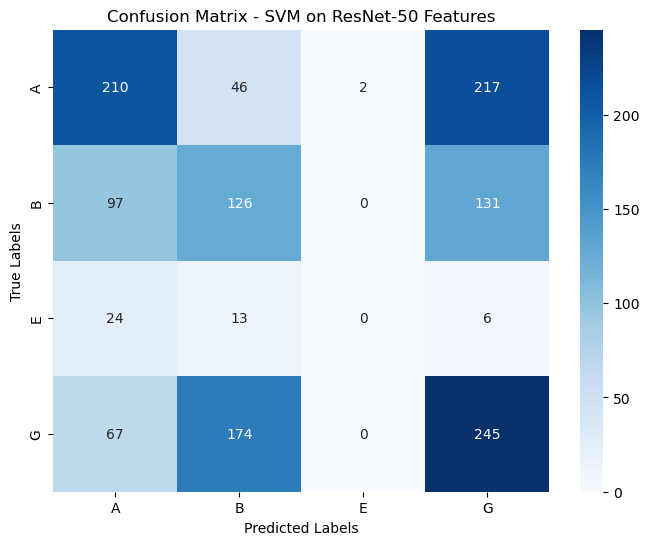

In [42]:
# Predict using SVM
svm_preds = svm_model.predict(test_features)

# Compute accuracy
svm_accuracy = accuracy_score(test_labels, svm_preds)
print(f"Test Accuracy (SVM on ResNet Features): {svm_accuracy:.4f}")

# Generate classification report
class_names = list(test_dataset.class_map.keys())
print("\nClassification Report (SVM on ResNet Features):\n")
print(classification_report(test_labels, svm_preds, target_names=class_names))

# Generate and print confusion matrix
cm = confusion_matrix(test_labels, svm_preds)
print("\nConfusion Matrix (SVM on ResNet Features):\n", cm)

# Save confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM on ResNet-50 Features")
plt.show()

In [ ]:
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score
import numpy as np
from itertools import product  # For looping through hyperparameters
from tqdm import tqdm  # Progress bar

# Define hyperparameter grid
param_grid = {
    "C": [0.1, 1, 10, 100],  # Regularization strength
    "kernel": ["sigmoid"],  # Different kernels
    "gamma": [0.01, 0.1, 1]  # RBF/Sigmoid/Poly kernel gamma
}

# Store best parameters and best F1-score
best_f1 = 0
best_params = None

# Get all possible parameter combinations
param_combinations = list(product(param_grid["C"], param_grid["kernel"], param_grid["gamma"]))

# Initialize progress bar
with tqdm(total=len(param_combinations), desc="Hyperparameter Tuning", unit="trial") as pbar:
    for C, kernel, gamma in param_combinations:
        if kernel == "linear" and gamma != "scale":
            pbar.update(1)
            continue  # gamma is not used for linear kernel
        
        # Create SVM model pipeline
        svm_model = make_pipeline(StandardScaler(), SVC(C=C, kernel=kernel, gamma=gamma))

        # Train on training set
        svm_model.fit(train_features, train_labels)

        # Predict on testidation set
        test_preds = svm_model.predict(test_features)

        # Compute F1-score on testidation set
        test_f1 = f1_score(test_labels, test_preds, average="weighted")

        # Print progress
        tqdm.write(f"Testing C={C}, Kernel={kernel}, Gamma={gamma} -> testidation F1 Score: {test_f1:.4f}")

        # Update best parameters if current F1-score is better
        if test_f1 > best_f1:
            best_f1 = test_f1
            best_params = {"C": C, "kernel": kernel, "gamma": gamma}

        # Update progress bar
        pbar.update(1)

# Print best hyperparameters based on testidation set
print("\nBest SVM Hyperparameters:")
print(best_params)
print(f"Best Weighted F1 Score on test: {best_f1:.4f}")

Hyperparameter Tuning:   0%|                          | 0/12 [00:00<?, ?trial/s]

In [44]:
# Train final SVM model with best hyperparameters
best_svm_model = make_pipeline(StandardScaler(), SVC(**best_params))
best_svm_model.fit(train_features, train_labels)

# Return best parameters
best_params

{'C': 0.1, 'kernel': 'sigmoid', 'gamma': 1}

Test Accuracy (SVM on ResNet Features): 0.2865

Classification Report (SVM on ResNet Features):

              precision    recall  f1-score   support

           A       0.38      0.32      0.34       475
           B       0.23      0.17      0.20       354
           E       0.09      0.67      0.16        43
           G       0.39      0.31      0.34       486

    accuracy                           0.29      1358
   macro avg       0.27      0.37      0.26      1358
weighted avg       0.33      0.29      0.30      1358


Confusion Matrix (SVM on ResNet Features):
 [[150 107 109 109]
 [ 51  61 118 124]
 [ 11   0  29   3]
 [185  96  56 149]]


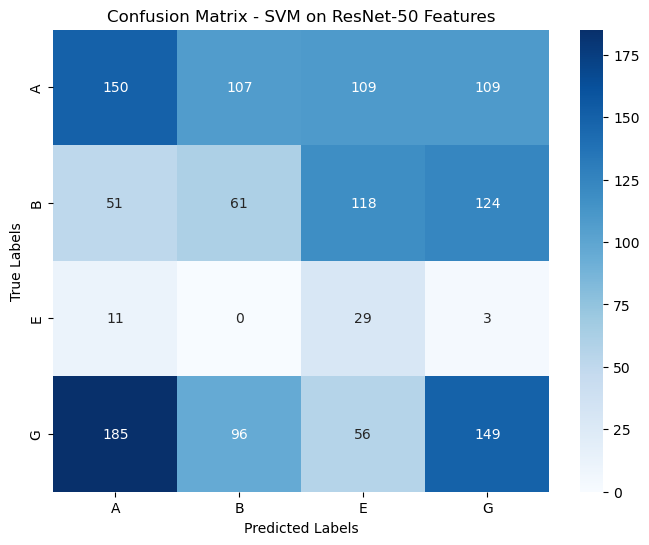

In [45]:
# Predict using SVM
svm_preds = best_svm_model.predict(test_features)

# Compute accuracy
svm_accuracy = accuracy_score(test_labels, svm_preds)
print(f"Test Accuracy (SVM on ResNet Features): {svm_accuracy:.4f}")

# Generate classification report
class_names = list(test_dataset.class_map.keys())
print("\nClassification Report (SVM on ResNet Features):\n")
print(classification_report(test_labels, svm_preds, target_names=class_names))

# Generate and print confusion matrix
cm = confusion_matrix(test_labels, svm_preds)
print("\nConfusion Matrix (SVM on ResNet Features):\n", cm)

# Save confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM on ResNet-50 Features")
plt.show()

In [ ]:
# Predict using SVM
best_svm_model = make_pipeline(StandardScaler(), SVC(kernel="sigmoid", C=1, gamma=1))
best_svm_model.fit(train_features, train_labels)
svm_preds = best_svm_model.predict(test_features)

# Compute accuracy
svm_accuracy = accuracy_score(test_labels, svm_preds)
print(f"Test Accuracy (SVM on ResNet Features): {svm_accuracy:.4f}")

# Generate classification report
class_names = list(test_dataset.class_map.keys())
print("\nClassification Report (SVM on ResNet Features):\n")
print(classification_report(test_labels, svm_preds, target_names=class_names))

# Generate and print confusion matrix
cm = confusion_matrix(test_labels, svm_preds)
print("\nConfusion Matrix (SVM on ResNet Features):\n", cm)

# Save confusion matrix as a heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix - SVM on ResNet-50 Features")
plt.show()